inspired by https://github.com/Data-Monkey/GTFS-NetworkX/blob/master/GTFStoGraph.py

GTFS API: https://developers.google.com/transit/gtfs/reference#agencytxt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Import the GTFS Files

In [3]:
ROUTES = pd.read_csv('cta_data/routes.txt')
STOPS = pd.read_csv('cta_data/stops.txt')
TRIPS = pd.read_csv('cta_data/trips.txt')
STOP_TIMES = pd.read_csv('cta_data/stop_times.txt')

### Clean the Data for "L" Train info only

We (for now) only want to model subways/metros, which use `route_type=1`, so we get a list of the `route_id`s that correspond ot the subway ("L") lines

In [4]:
ROUTES_subway = ROUTES[ROUTES['route_id']=='Blue']
# record subway route_ids
route_ids_subway = ROUTES_subway['route_id'].values.tolist()
ROUTES_subway

route_id route_short_name route_long_name  route_type  \
129     Blue              NaN       Blue Line           1   

                                   route_url route_color route_text_color  
129  http://www.transitchicago.com/blueline/      00A1DE           FFFFFF

Likewise, we will filter the `TRIPS` data so that it only includes trips for subway routes:

In [5]:
# filter to only include trips with subway route_ids
TRIPS_subway = TRIPS[TRIPS['route_id'].isin(route_ids_subway)]

# only include one direction to avoid redundancies
# TRIPS_subway = TRIPS_subway[TRIPS_subway['direction_id']==1]
trip_ids_subway = list(TRIPS_subway['trip_id'].values)
TRIPS_subway

route_id  service_id      trip_id  direction_id     block_id   shape_id  \
41967     Blue      106001  60166141078             1  60015964004  306000124   
41968     Blue      106001  60166141079             0  60015964047  306000002   
41969     Blue      106001  60166141080             0  60015964047  306000002   
41970     Blue      106001  60166141081             1  60015964047  306000001   
41971     Blue      106001  60166141085             0  60015963974  306000002   
...        ...         ...          ...           ...          ...        ...   
43034     Blue      106015  60164356348             1  60015806271  306000001   
43035     Blue      106015  60164356349             1  60015806272  306000001   
43036     Blue      106015  60164356350             1  60015806276  306000001   
43037     Blue      106015  60164356351             1  60015806274  306000001   
43038     Blue      106015  60164356355             0  60015806273  306000002   

      direction  wheelchair_accessible schd_trip_id  
41967     North                      1         R129  
41968     South                      1         R133  
41969     South                      1         R219  
41970     North                      1         R219  
41971     South                      1         R146  
...         ...                    ...          ...  
43034     North                      1         R126  
43035     North                      1         R146  
43036     North                      1         R147  
43037     North                      1         R148  
43038     South                      1         R230  

[1072 rows x 9 columns]

In [7]:
STOP_TIMES_subway = STOP_TIMES[STOP_TIMES['trip_id'].isin(trip_ids_subway)].reset_index()
STOP_TIMES_subway[STOP_TIMES_subway['pickup_type'] == 0]

index      trip_id arrival_time departure_time  stop_id  \
0       35086  60164356179     16:39:00       16:39:00    30240   
1       35087  60164356179     16:40:30       16:40:30    30013   
2       35088  60164356179     16:43:00       16:43:00    30198   
3       35089  60164356179     16:45:00       16:45:00    30112   
4       35090  60164356179     16:47:00       16:47:00    30130   
...       ...          ...          ...            ...      ...   
32467  126982  60166141391     06:55:30       06:55:30    30072   
32468  126983  60166141391     06:57:30       06:57:30    30375   
32469  126984  60166141391     07:00:00       07:00:00    30095   
32470  126985  60166141391     07:01:00       07:01:00    30271   
32471  126986  60166141391     07:03:30       07:03:30    30062   

       stop_sequence stop_headsign  pickup_type  shape_dist_traveled  
0                  8   UIC-Halsted            0                56616  
1                  9   UIC-Halsted            0                60642  
2                 10   UIC-Halsted            0                64157  
3                 11   UIC-Halsted            0                68425  
4                 12   UIC-Halsted            0                71765  
...              ...           ...          ...                  ...  
32467             16        O'Hare            0                54390  
32468             17        O'Hare            0                55674  
32469             18        O'Hare            0                61009  
32470             19        O'Hare            0                63747  
32471             20        O'Hare            0                67805  

[32472 rows x 9 columns]

We only want to track `stations` (`location_type=1`), but `STOP_TIMES` gives information for `platforms`(`location_type=0`). So first we need to assign the parent for each of the stops in `STOP_TIMES`

In [6]:
STOPS_stations = STOPS[STOPS['location_type']==1]
# stop_ids_stations = list(STOPS_stations['stop_id'].unique())

In [7]:
def get_parent(stop_id):
    parent = STOPS[STOPS['stop_id']==stop_id]['parent_station'].values
    if len(parent) == 0:
        return stop_id
    else:
        return parent[0]

STOP_TIMES_subway['station_id'] = STOP_TIMES_subway['stop_id'].apply(get_parent)

### use trip information to determine graph edges

In [220]:
origin_stops = []
dest_stops = []
trip_ids = []

edges_list = []
for trip_id, group in STOP_TIMES_subway.groupby('trip_id'):
    for i in group.index[:-1]:
        origin_stop = STOP_TIMES_subway['station_id'][i]
#         print(i)
        dest_stop = STOP_TIMES_subway['station_id'][i+1]
        if STOP_TIMES_subway['stop_sequence'][i+1] > STOP_TIMES_subway['stop_sequence'][i]:
            origin_stops.append(origin_stop)
            dest_stops.append(dest_stop)
            trip_ids.append(trip_id)
            edges_list.append((origin_stop, dest_stop))

In [6]:
edges = pd.DataFrame({'origin_stop':origin_stops, 'dest_stop':dest_stops, 'trip_id':trip_ids})
edges

NameError: name 'origin_stops' is not defined

### Let's play around with just stops data:

In [222]:
l_stops_raw = pd.read_csv("cta_data/CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv")
# convert coords to a readable dict
locations = l_stops_raw.Location.apply(lambda x: x[1:-1].split(","))
coords = pd.DataFrame(locations.tolist(), columns=['lat', 'long']).astype('float')

l_stops = l_stops_raw.drop(['Location'], axis=1)
l_stops = l_stops.join(coords)

In [223]:
l_stops['STATION_ID'] = l_stops['STOP_ID'].apply(get_parent)

In [224]:
# read in stop colors
stop_colors = l_stops[['STATION_ID', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y','Pnk', 'O']]

color_conversion = {'RED':'red', 'BLUE':'blue', 'G':'green', 'BRN':'brown', 'P':'purple', 'Pexp':'purple', 'Y':'yellow','Pnk':'pink', 'O':'orange'}

colors_dict = {}
for i in stop_colors.index:
    colors_list = []
    for c in stop_colors.columns.astype('str'):
        if stop_colors[c][i] == True:
            colors_list.append(color_conversion[c])
    if len(colors_list) == 0:
        colors_list.append('k')
    colors_dict[l_stops['STATION_ID'][i]] = colors_list

In [225]:
node_coords = {}
for i in coords.index:
    node_coords[l_stops['STATION_ID'][i]] = (coords.iloc[i].long, 
                      coords.iloc[i].lat)

In [226]:
G = nx.Graph()

G.add_edges_from(edges_list)

In [227]:
for n in G.nodes:
    stop_row = STOPS[STOPS['stop_id']==n]
    G.nodes[n]['pos'] = (stop_row['stop_lon'].values[0],
                         stop_row['stop_lat'].values[0])
    G.nodes[n]['node_color'] = colors_dict[n][0]

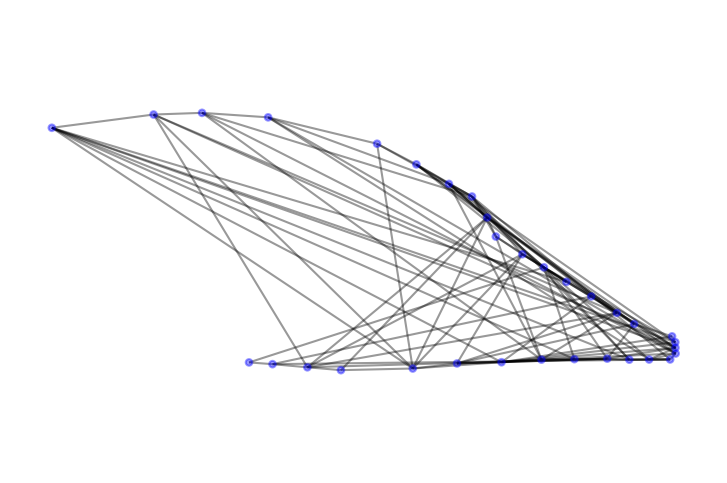

In [228]:
fig, ax = plt.subplots(dpi=150)
nx.draw(G, node_coords, 
        ax=ax, alpha=0.4, 
        node_size=10, 
        node_color=[G.nodes[i]['node_color'] for i in G.nodes])
plt.axis('equal')
plt.grid(which='both')
plt.show()

In [ ]:
for trip_id, group in STOP_TIMES_subway.groupby('trip_id'):
    display(group)
    print('break')

index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
291  35627  60164356112     03:00:00       03:00:00    30172              1   
292  35628  60164356112     03:05:00       03:05:00    30160              2   
293  35629  60164356112     03:07:00       03:07:00    30045              3   
294  35630  60164356112     03:10:30       03:10:30    30146              4   
295  35631  60164356112     03:15:00       03:15:00    30248              5   
296  35632  60164356112     03:17:00       03:17:00    30260              6   
297  35633  60164356112     03:19:00       03:19:00    30108              7   
298  35634  60164356112     03:21:00       03:21:00    30240              8   
299  35635  60164356112     03:22:30       03:22:30    30013              9   
300  35636  60164356112     03:25:00       03:25:00    30198             10   
301  35637  60164356112     03:27:00       03:27:00    30112             11   
302  35638  60164356112     03:29:00       03:29:00    30130             12   
303  35639  60164356112     03:31:00       03:31:00    30116             13   
304  35640  60164356112     03:33:00       03:33:00    30063             14   
305  35641  60164356112     03:35:00       03:35:00    30272             15   
306  35642  60164356112     03:36:30       03:36:30    30096             16   
307  35643  60164356112     03:39:00       03:39:00    30374             17   
308  35644  60164356112     03:40:30       03:40:30    30073             18   
309  35645  60164356112     03:41:30       03:41:30    30154             19   
310  35646  60164356112     03:42:30       03:42:30    30015             20   
311  35647  60164356112     03:44:00       03:44:00    30262             21   
312  35648  60164356112     03:45:00       03:45:00    30085             22   
313  35649  60164356112     03:47:00       03:47:00    30069             23   
314  35650  60164356112     03:49:00       03:49:00    30093             24   
315  35651  60164356112     03:51:30       03:51:30    30158             25   
316  35652  60164356112     03:53:30       03:53:30    30043             26   
317  35653  60164356112     03:57:00       03:57:00    30049             27   
318  35654  60164356112     04:00:00       04:00:00    30180             28   
319  35655  60164356112     04:02:30       04:02:30    30188             29   
320  35656  60164356112     04:06:30       04:06:30    30002             30   
321  35657  60164356112     04:08:30       04:08:30    30035             31   
322  35658  60164356112     04:11:00       04:11:00    30190             32   
323  35659  60164356112     04:13:00       04:13:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
291   Forest Park            0                    0     40890.0  
292   Forest Park            0                14158     40820.0  
293   Forest Park            0                19973     40230.0  
294   Forest Park            0                27985     40750.0  
295   Forest Park            0                42379     41280.0  
296   Forest Park            0                48172     41330.0  
297   Forest Park            0                53195     40550.0  
298   Forest Park            0                56616     41240.0  
299   Forest Park            0                60642     40060.0  
300   Forest Park            0                64157     41020.0  
301   Forest Park            0                68425     40570.0  
302   Forest Park            0                71765     40670.0  
303   Forest Park            0                75338     40590.0  
304   Forest Park            0                79132     40320.0  
305   Forest Park            0                83190     41410.0  
306   Forest Park            0                85928     40490.0  
307   Forest Park            0                91263     40380.0  
308   Forest Park            0                92547     40370.0  
309   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
324  35660  60164356113     03:30:00       03:30:00    30172              1   
325  35661  60164356113     03:35:00       03:35:00    30160              2   
326  35662  60164356113     03:37:00       03:37:00    30045              3   
327  35663  60164356113     03:40:30       03:40:30    30146              4   
328  35664  60164356113     03:45:00       03:45:00    30248              5   
329  35665  60164356113     03:47:00       03:47:00    30260              6   
330  35666  60164356113     03:49:00       03:49:00    30108              7   
331  35667  60164356113     03:51:00       03:51:00    30240              8   
332  35668  60164356113     03:52:30       03:52:30    30013              9   
333  35669  60164356113     03:55:00       03:55:00    30198             10   
334  35670  60164356113     03:57:00       03:57:00    30112             11   
335  35671  60164356113     03:59:00       03:59:00    30130             12   
336  35672  60164356113     04:01:00       04:01:00    30116             13   
337  35673  60164356113     04:03:00       04:03:00    30063             14   
338  35674  60164356113     04:05:00       04:05:00    30272             15   
339  35675  60164356113     04:06:30       04:06:30    30096             16   
340  35676  60164356113     04:09:00       04:09:00    30374             17   
341  35677  60164356113     04:10:30       04:10:30    30073             18   
342  35678  60164356113     04:11:30       04:11:30    30154             19   
634  36125  60164356113     04:12:30       04:12:30    30015             20   
635  36126  60164356113     04:14:00       04:14:00    30262             21   
636  36127  60164356113     04:15:00       04:15:00    30085             22   
637  36128  60164356113     04:17:00       04:17:00    30069             23   
638  36129  60164356113     04:19:00       04:19:00    30093             24   
639  36130  60164356113     04:21:30       04:21:30    30158             25   
640  36131  60164356113     04:23:30       04:23:30    30043             26   
641  36132  60164356113     04:27:00       04:27:00    30049             27   
642  36133  60164356113     04:30:00       04:30:00    30180             28   
643  36134  60164356113     04:32:30       04:32:30    30188             29   
644  36135  60164356113     04:36:30       04:36:30    30002             30   
645  36136  60164356113     04:38:30       04:38:30    30035             31   
646  36137  60164356113     04:41:00       04:41:00    30190             32   
647  36138  60164356113     04:43:00       04:43:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
324   Forest Park            0                    0     40890.0  
325   Forest Park            0                14158     40820.0  
326   Forest Park            0                19973     40230.0  
327   Forest Park            0                27985     40750.0  
328   Forest Park            0                42379     41280.0  
329   Forest Park            0                48172     41330.0  
330   Forest Park            0                53195     40550.0  
331   Forest Park            0                56616     41240.0  
332   Forest Park            0                60642     40060.0  
333   Forest Park            0                64157     41020.0  
334   Forest Park            0                68425     40570.0  
335   Forest Park            0                71765     40670.0  
336   Forest Park            0                75338     40590.0  
337   Forest Park            0                79132     40320.0  
338   Forest Park            0                83190     41410.0  
339   Forest Park            0                85928     40490.0  
340   Forest Park            0                91263     40380.0  
341   Forest Park            0                92547     40370.0  
342   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
648  36139  60164356114     03:45:00       03:45:00    30172              1   
649  36140  60164356114     03:50:00       03:50:00    30160              2   
650  36141  60164356114     03:52:00       03:52:00    30045              3   
651  36142  60164356114     03:55:30       03:55:30    30146              4   
652  36143  60164356114     04:00:00       04:00:00    30248              5   
653  36144  60164356114     04:02:00       04:02:00    30260              6   
654  36145  60164356114     04:04:00       04:04:00    30108              7   
655  36146  60164356114     04:06:00       04:06:00    30240              8   
656  36147  60164356114     04:07:30       04:07:30    30013              9   
657  36148  60164356114     04:10:00       04:10:00    30198             10   
658  36149  60164356114     04:12:00       04:12:00    30112             11   
659  36150  60164356114     04:14:00       04:14:00    30130             12   
660  36151  60164356114     04:16:00       04:16:00    30116             13   
661  36152  60164356114     04:18:00       04:18:00    30063             14   
662  36153  60164356114     04:20:00       04:20:00    30272             15   
663  36154  60164356114     04:21:30       04:21:30    30096             16   
664  36155  60164356114     04:24:00       04:24:00    30374             17   
665  36156  60164356114     04:25:30       04:25:30    30073             18   
666  36157  60164356114     04:26:30       04:26:30    30154             19   
667  36158  60164356114     04:27:30       04:27:30    30015             20   
668  36159  60164356114     04:29:00       04:29:00    30262             21   
669  36160  60164356114     04:30:00       04:30:00    30085             22   
670  36161  60164356114     04:32:00       04:32:00    30069             23   
671  36162  60164356114     04:34:00       04:34:00    30093             24   
672  36163  60164356114     04:36:30       04:36:30    30158             25   
673  36164  60164356114     04:38:30       04:38:30    30043             26   
674  36165  60164356114     04:42:00       04:42:00    30049             27   
675  36166  60164356114     04:45:00       04:45:00    30180             28   
676  36167  60164356114     04:47:30       04:47:30    30188             29   
677  36168  60164356114     04:51:30       04:51:30    30002             30   
678  36169  60164356114     04:53:30       04:53:30    30035             31   
679  36170  60164356114     04:56:00       04:56:00    30190             32   
680  36171  60164356114     04:58:00       04:58:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
648   Forest Park            0                    0     40890.0  
649   Forest Park            0                14158     40820.0  
650   Forest Park            0                19973     40230.0  
651   Forest Park            0                27985     40750.0  
652   Forest Park            0                42379     41280.0  
653   Forest Park            0                48172     41330.0  
654   Forest Park            0                53195     40550.0  
655   Forest Park            0                56616     41240.0  
656   Forest Park            0                60642     40060.0  
657   Forest Park            0                64157     41020.0  
658   Forest Park            0                68425     40570.0  
659   Forest Park            0                71765     40670.0  
660   Forest Park            0                75338     40590.0  
661   Forest Park            0                79132     40320.0  
662   Forest Park            0                83190     41410.0  
663   Forest Park            0                85928     40490.0  
664   Forest Park            0                91263     40380.0  
665   Forest Park            0                92547     40370.0  
666   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
681  36172  60164356115     04:00:00       04:00:00    30172              1   
682  36173  60164356115     04:05:00       04:05:00    30160              2   
683  36174  60164356115     04:07:00       04:07:00    30045              3   
684  36175  60164356115     04:10:30       04:10:30    30146              4   
685  36176  60164356115     04:15:00       04:15:00    30248              5   
686  36177  60164356115     04:17:00       04:17:00    30260              6   
687  36178  60164356115     04:19:00       04:19:00    30108              7   
688  36179  60164356115     04:21:00       04:21:00    30240              8   
689  36180  60164356115     04:22:30       04:22:30    30013              9   
690  36181  60164356115     04:25:00       04:25:00    30198             10   
691  36182  60164356115     04:27:00       04:27:00    30112             11   
692  36183  60164356115     04:29:00       04:29:00    30130             12   
693  36184  60164356115     04:31:00       04:31:00    30116             13   
694  36185  60164356115     04:33:00       04:33:00    30063             14   
695  36186  60164356115     04:35:00       04:35:00    30272             15   
696  36187  60164356115     04:36:30       04:36:30    30096             16   
697  36188  60164356115     04:39:00       04:39:00    30374             17   
698  36189  60164356115     04:40:30       04:40:30    30073             18   
699  36190  60164356115     04:41:30       04:41:30    30154             19   
700  36191  60164356115     04:42:30       04:42:30    30015             20   
701  36192  60164356115     04:44:00       04:44:00    30262             21   
702  36193  60164356115     04:45:00       04:45:00    30085             22   
703  36194  60164356115     04:47:00       04:47:00    30069             23   
704  36195  60164356115     04:49:00       04:49:00    30093             24   
705  36196  60164356115     04:51:30       04:51:30    30158             25   
706  36197  60164356115     04:53:30       04:53:30    30043             26   
707  36198  60164356115     04:57:00       04:57:00    30049             27   
708  36199  60164356115     05:00:00       05:00:00    30180             28   
709  36200  60164356115     05:02:30       05:02:30    30188             29   
710  36201  60164356115     05:06:30       05:06:30    30002             30   
711  36202  60164356115     05:08:30       05:08:30    30035             31   
712  36203  60164356115     05:11:00       05:11:00    30190             32   
713  36204  60164356115     05:13:00       05:13:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
681   Forest Park            0                    0     40890.0  
682   Forest Park            0                14158     40820.0  
683   Forest Park            0                19973     40230.0  
684   Forest Park            0                27985     40750.0  
685   Forest Park            0                42379     41280.0  
686   Forest Park            0                48172     41330.0  
687   Forest Park            0                53195     40550.0  
688   Forest Park            0                56616     41240.0  
689   Forest Park            0                60642     40060.0  
690   Forest Park            0                64157     41020.0  
691   Forest Park            0                68425     40570.0  
692   Forest Park            0                71765     40670.0  
693   Forest Park            0                75338     40590.0  
694   Forest Park            0                79132     40320.0  
695   Forest Park            0                83190     41410.0  
696   Forest Park            0                85928     40490.0  
697   Forest Park            0                91263     40380.0  
698   Forest Park            0                92547     40370.0  
699   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
714  36205  60164356116     04:15:00       04:15:00    30172              1   
715  36206  60164356116     04:20:00       04:20:00    30160              2   
716  36207  60164356116     04:22:00       04:22:00    30045              3   
717  36208  60164356116     04:25:30       04:25:30    30146              4   
718  36209  60164356116     04:30:00       04:30:00    30248              5   
719  36210  60164356116     04:32:00       04:32:00    30260              6   
720  36211  60164356116     04:34:00       04:34:00    30108              7   
721  36212  60164356116     04:36:00       04:36:00    30240              8   
722  36213  60164356116     04:37:30       04:37:30    30013              9   
723  36214  60164356116     04:40:00       04:40:00    30198             10   
724  36215  60164356116     04:42:00       04:42:00    30112             11   
725  36216  60164356116     04:44:00       04:44:00    30130             12   
726  36217  60164356116     04:46:00       04:46:00    30116             13   
727  36218  60164356116     04:48:00       04:48:00    30063             14   
728  36219  60164356116     04:50:00       04:50:00    30272             15   
729  36220  60164356116     04:51:30       04:51:30    30096             16   
730  36221  60164356116     04:54:00       04:54:00    30374             17   
731  36222  60164356116     04:55:30       04:55:30    30073             18   
732  36223  60164356116     04:56:30       04:56:30    30154             19   
733  36224  60164356116     04:57:30       04:57:30    30015             20   
734  36225  60164356116     04:59:00       04:59:00    30262             21   
735  36226  60164356116     05:00:00       05:00:00    30085             22   
736  36227  60164356116     05:02:00       05:02:00    30069             23   
737  36228  60164356116     05:04:00       05:04:00    30093             24   
738  36229  60164356116     05:06:30       05:06:30    30158             25   
739  36230  60164356116     05:08:30       05:08:30    30043             26   
740  36231  60164356116     05:12:00       05:12:00    30049             27   
741  36232  60164356116     05:15:00       05:15:00    30180             28   
742  36233  60164356116     05:17:30       05:17:30    30188             29   
743  36234  60164356116     05:21:30       05:21:30    30002             30   
744  36235  60164356116     05:23:30       05:23:30    30035             31   
745  36236  60164356116     05:26:00       05:26:00    30190             32   
746  36237  60164356116     05:28:00       05:28:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
714   Forest Park            0                    0     40890.0  
715   Forest Park            0                14158     40820.0  
716   Forest Park            0                19973     40230.0  
717   Forest Park            0                27985     40750.0  
718   Forest Park            0                42379     41280.0  
719   Forest Park            0                48172     41330.0  
720   Forest Park            0                53195     40550.0  
721   Forest Park            0                56616     41240.0  
722   Forest Park            0                60642     40060.0  
723   Forest Park            0                64157     41020.0  
724   Forest Park            0                68425     40570.0  
725   Forest Park            0                71765     40670.0  
726   Forest Park            0                75338     40590.0  
727   Forest Park            0                79132     40320.0  
728   Forest Park            0                83190     41410.0  
729   Forest Park            0                85928     40490.0  
730   Forest Park            0                91263     40380.0  
731   Forest Park            0                92547     40370.0  
732   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
747   36238  60164356117     04:30:00       04:30:00    30172              1   
748   36239  60164356117     04:35:00       04:35:00    30160              2   
749   36240  60164356117     04:37:00       04:37:00    30045              3   
750   36241  60164356117     04:40:30       04:40:30    30146              4   
751   36242  60164356117     04:45:00       04:45:00    30248              5   
752   36243  60164356117     04:47:00       04:47:00    30260              6   
753   36244  60164356117     04:49:00       04:49:00    30108              7   
754   36245  60164356117     04:51:00       04:51:00    30240              8   
755   36246  60164356117     04:52:30       04:52:30    30013              9   
756   36247  60164356117     04:55:00       04:55:00    30198             10   
757   36248  60164356117     04:57:00       04:57:00    30112             11   
758   36249  60164356117     04:59:00       04:59:00    30130             12   
759   36250  60164356117     05:01:00       05:01:00    30116             13   
760   36251  60164356117     05:03:00       05:03:00    30063             14   
761   36252  60164356117     05:05:00       05:05:00    30272             15   
762   36253  60164356117     05:06:30       05:06:30    30096             16   
763   36254  60164356117     05:09:00       05:09:00    30374             17   
764   36255  60164356117     05:10:30       05:10:30    30073             18   
765   36256  60164356117     05:11:30       05:11:30    30154             19   
766   36257  60164356117     05:12:30       05:12:30    30015             20   
767   36258  60164356117     05:14:00       05:14:00    30262             21   
768   36259  60164356117     05:15:00       05:15:00    30085             22   
769   36260  60164356117     05:17:00       05:17:00    30069             23   
770   36261  60164356117     05:19:00       05:19:00    30093             24   
771   36262  60164356117     05:21:30       05:21:30    30158             25   
772   36263  60164356117     05:23:30       05:23:30    30043             26   
1064  36709  60164356117     05:27:00       05:27:00    30049             27   
1065  36710  60164356117     05:30:00       05:30:00    30180             28   
1066  36711  60164356117     05:32:30       05:32:30    30188             29   
1067  36712  60164356117     05:36:30       05:36:30    30002             30   
1068  36713  60164356117     05:38:30       05:38:30    30035             31   
1069  36714  60164356117     05:41:00       05:41:00    30190             32   
1070  36715  60164356117     05:43:00       05:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
747    Forest Park            0                    0     40890.0  
748    Forest Park            0                14158     40820.0  
749    Forest Park            0                19973     40230.0  
750    Forest Park            0                27985     40750.0  
751    Forest Park            0                42379     41280.0  
752    Forest Park            0                48172     41330.0  
753    Forest Park            0                53195     40550.0  
754    Forest Park            0                56616     41240.0  
755    Forest Park            0                60642     40060.0  
756    Forest Park            0                64157     41020.0  
757    Forest Park            0                68425     40570.0  
758    Forest Park            0                71765     40670.0  
759    Forest Park            0                75338     40590.0  
760    Forest Park            0                79132     40320.0  
761    Forest Park            0                83190     41410.0  
762    Forest Park            0                85928     40490.0  
763    Forest Park            0                91263     40380.0  
764    Forest Park            0                92547     40370.0  
765    Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1071  36716  60164356118     04:45:00       04:45:00    30172              1   
1072  36717  60164356118     04:50:00       04:50:00    30160              2   
1073  36718  60164356118     04:52:00       04:52:00    30045              3   
1074  36719  60164356118     04:55:30       04:55:30    30146              4   
1075  36720  60164356118     05:00:00       05:00:00    30248              5   
1076  36721  60164356118     05:02:00       05:02:00    30260              6   
1077  36722  60164356118     05:04:00       05:04:00    30108              7   
1078  36723  60164356118     05:06:00       05:06:00    30240              8   
1079  36724  60164356118     05:07:30       05:07:30    30013              9   
1080  36725  60164356118     05:10:00       05:10:00    30198             10   
1081  36726  60164356118     05:12:00       05:12:00    30112             11   
1082  36727  60164356118     05:14:00       05:14:00    30130             12   
1083  36728  60164356118     05:16:00       05:16:00    30116             13   
1084  36729  60164356118     05:18:00       05:18:00    30063             14   
1085  36730  60164356118     05:20:00       05:20:00    30272             15   
1086  36731  60164356118     05:21:30       05:21:30    30096             16   
1087  36732  60164356118     05:24:00       05:24:00    30374             17   
1088  36733  60164356118     05:25:30       05:25:30    30073             18   
1089  36734  60164356118     05:26:30       05:26:30    30154             19   
1090  36735  60164356118     05:27:30       05:27:30    30015             20   
1091  36736  60164356118     05:29:00       05:29:00    30262             21   
1092  36737  60164356118     05:30:00       05:30:00    30085             22   
1093  36738  60164356118     05:32:00       05:32:00    30069             23   
1094  36739  60164356118     05:34:00       05:34:00    30093             24   
1095  36740  60164356118     05:36:30       05:36:30    30158             25   
1096  36741  60164356118     05:38:30       05:38:30    30043             26   
1097  36742  60164356118     05:42:00       05:42:00    30049             27   
1098  36743  60164356118     05:45:00       05:45:00    30180             28   
1099  36744  60164356118     05:47:30       05:47:30    30188             29   
1100  36745  60164356118     05:51:30       05:51:30    30002             30   
1101  36746  60164356118     05:53:30       05:53:30    30035             31   
1102  36747  60164356118     05:56:00       05:56:00    30190             32   
1103  36748  60164356118     05:58:00       05:58:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1071   Forest Park            0                    0     40890.0  
1072   Forest Park            0                14158     40820.0  
1073   Forest Park            0                19973     40230.0  
1074   Forest Park            0                27985     40750.0  
1075   Forest Park            0                42379     41280.0  
1076   Forest Park            0                48172     41330.0  
1077   Forest Park            0                53195     40550.0  
1078   Forest Park            0                56616     41240.0  
1079   Forest Park            0                60642     40060.0  
1080   Forest Park            0                64157     41020.0  
1081   Forest Park            0                68425     40570.0  
1082   Forest Park            0                71765     40670.0  
1083   Forest Park            0                75338     40590.0  
1084   Forest Park            0                79132     40320.0  
1085   Forest Park            0                83190     41410.0  
1086   Forest Park            0                85928     40490.0  
1087   Forest Park            0                91263     40380.0  
1088   Forest Park            0                92547     40370.0  
1089   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1104  36749  60164356119     05:00:00       05:00:00    30172              1   
1105  36750  60164356119     05:05:00       05:05:00    30160              2   
1106  36751  60164356119     05:07:00       05:07:00    30045              3   
1107  36752  60164356119     05:10:30       05:10:30    30146              4   
1108  36753  60164356119     05:15:00       05:15:00    30248              5   
1109  36754  60164356119     05:17:00       05:17:00    30260              6   
1110  36755  60164356119     05:19:00       05:19:00    30108              7   
1111  36756  60164356119     05:21:00       05:21:00    30240              8   
1112  36757  60164356119     05:22:30       05:22:30    30013              9   
1113  36758  60164356119     05:25:00       05:25:00    30198             10   
1114  36759  60164356119     05:27:00       05:27:00    30112             11   
1115  36760  60164356119     05:29:00       05:29:00    30130             12   
1116  36761  60164356119     05:31:00       05:31:00    30116             13   
1117  36762  60164356119     05:33:00       05:33:00    30063             14   
1118  36763  60164356119     05:35:00       05:35:00    30272             15   
1119  36764  60164356119     05:36:30       05:36:30    30096             16   
1120  36765  60164356119     05:39:00       05:39:00    30374             17   
1121  36766  60164356119     05:40:30       05:40:30    30073             18   
1122  36767  60164356119     05:41:30       05:41:30    30154             19   
1123  36768  60164356119     05:42:30       05:42:30    30015             20   
1124  36769  60164356119     05:44:00       05:44:00    30262             21   
1125  36770  60164356119     05:45:00       05:45:00    30085             22   
1126  36771  60164356119     05:47:00       05:47:00    30069             23   
1127  36772  60164356119     05:49:00       05:49:00    30093             24   
1128  36773  60164356119     05:51:30       05:51:30    30158             25   
1129  36774  60164356119     05:53:30       05:53:30    30043             26   
1130  36775  60164356119     05:57:00       05:57:00    30049             27   
1131  36776  60164356119     06:00:00       06:00:00    30180             28   
1132  36777  60164356119     06:02:30       06:02:30    30188             29   
1133  36778  60164356119     06:06:30       06:06:30    30002             30   
1134  36779  60164356119     06:08:30       06:08:30    30035             31   
1135  36780  60164356119     06:11:00       06:11:00    30190             32   
1136  36781  60164356119     06:13:00       06:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1104   Forest Park            0                    0     40890.0  
1105   Forest Park            0                14158     40820.0  
1106   Forest Park            0                19973     40230.0  
1107   Forest Park            0                27985     40750.0  
1108   Forest Park            0                42379     41280.0  
1109   Forest Park            0                48172     41330.0  
1110   Forest Park            0                53195     40550.0  
1111   Forest Park            0                56616     41240.0  
1112   Forest Park            0                60642     40060.0  
1113   Forest Park            0                64157     41020.0  
1114   Forest Park            0                68425     40570.0  
1115   Forest Park            0                71765     40670.0  
1116   Forest Park            0                75338     40590.0  
1117   Forest Park            0                79132     40320.0  
1118   Forest Park            0                83190     41410.0  
1119   Forest Park            0                85928     40490.0  
1120   Forest Park            0                91263     40380.0  
1121   Forest Park            0                92547     40370.0  
1122   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1137  36782  60164356120     05:15:00       05:15:00    30172              1   
1138  36783  60164356120     05:20:00       05:20:00    30160              2   
1139  36784  60164356120     05:22:00       05:22:00    30045              3   
1140  36785  60164356120     05:25:30       05:25:30    30146              4   
1141  36786  60164356120     05:30:00       05:30:00    30248              5   
1142  36787  60164356120     05:32:00       05:32:00    30260              6   
1143  36788  60164356120     05:34:00       05:34:00    30108              7   
1144  36789  60164356120     05:36:00       05:36:00    30240              8   
1145  36790  60164356120     05:37:30       05:37:30    30013              9   
1146  36791  60164356120     05:40:00       05:40:00    30198             10   
1147  36792  60164356120     05:42:00       05:42:00    30112             11   
1148  36793  60164356120     05:44:00       05:44:00    30130             12   
1149  36794  60164356120     05:46:00       05:46:00    30116             13   
1150  36795  60164356120     05:48:00       05:48:00    30063             14   
1151  36796  60164356120     05:50:00       05:50:00    30272             15   
1152  36797  60164356120     05:51:30       05:51:30    30096             16   
1153  36798  60164356120     05:54:00       05:54:00    30374             17   
1154  36799  60164356120     05:55:30       05:55:30    30073             18   
1155  36800  60164356120     05:56:30       05:56:30    30154             19   
1156  36801  60164356120     05:57:30       05:57:30    30015             20   
1157  36802  60164356120     05:59:00       05:59:00    30262             21   
1158  36803  60164356120     06:00:00       06:00:00    30085             22   
1159  36804  60164356120     06:02:00       06:02:00    30069             23   
1160  36805  60164356120     06:04:00       06:04:00    30093             24   
1161  36806  60164356120     06:06:30       06:06:30    30158             25   
1162  36807  60164356120     06:08:30       06:08:30    30043             26   
1163  36808  60164356120     06:12:00       06:12:00    30049             27   
1164  36809  60164356120     06:15:00       06:15:00    30180             28   
1165  36810  60164356120     06:17:30       06:17:30    30188             29   
1166  36811  60164356120     06:21:30       06:21:30    30002             30   
1167  36812  60164356120     06:23:30       06:23:30    30035             31   
1168  36813  60164356120     06:26:00       06:26:00    30190             32   
1169  36814  60164356120     06:28:00       06:28:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1137   Forest Park            0                    0     40890.0  
1138   Forest Park            0                14158     40820.0  
1139   Forest Park            0                19973     40230.0  
1140   Forest Park            0                27985     40750.0  
1141   Forest Park            0                42379     41280.0  
1142   Forest Park            0                48172     41330.0  
1143   Forest Park            0                53195     40550.0  
1144   Forest Park            0                56616     41240.0  
1145   Forest Park            0                60642     40060.0  
1146   Forest Park            0                64157     41020.0  
1147   Forest Park            0                68425     40570.0  
1148   Forest Park            0                71765     40670.0  
1149   Forest Park            0                75338     40590.0  
1150   Forest Park            0                79132     40320.0  
1151   Forest Park            0                83190     41410.0  
1152   Forest Park            0                85928     40490.0  
1153   Forest Park            0                91263     40380.0  
1154   Forest Park            0                92547     40370.0  
1155   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1170  36815  60164356121     05:30:00       05:30:00    30172              1   
1171  36816  60164356121     05:35:00       05:35:00    30160              2   
1172  36817  60164356121     05:37:00       05:37:00    30045              3   
1173  36818  60164356121     05:40:30       05:40:30    30146              4   
1174  36819  60164356121     05:45:00       05:45:00    30248              5   
1175  36820  60164356121     05:47:00       05:47:00    30260              6   
1176  36821  60164356121     05:49:00       05:49:00    30108              7   
1177  36822  60164356121     05:51:00       05:51:00    30240              8   
1178  36823  60164356121     05:52:30       05:52:30    30013              9   
1179  36824  60164356121     05:55:00       05:55:00    30198             10   
1180  36825  60164356121     05:57:00       05:57:00    30112             11   
1181  36826  60164356121     05:59:00       05:59:00    30130             12   
1182  36827  60164356121     06:01:00       06:01:00    30116             13   
1183  36828  60164356121     06:03:00       06:03:00    30063             14   
1184  36829  60164356121     06:05:00       06:05:00    30272             15   
1185  36830  60164356121     06:06:30       06:06:30    30096             16   
1186  36831  60164356121     06:09:00       06:09:00    30374             17   
1187  36832  60164356121     06:10:30       06:10:30    30073             18   
1188  36833  60164356121     06:11:30       06:11:30    30154             19   
1189  36834  60164356121     06:12:30       06:12:30    30015             20   
1190  36835  60164356121     06:14:00       06:14:00    30262             21   
1191  36836  60164356121     06:15:00       06:15:00    30085             22   
1192  36837  60164356121     06:17:00       06:17:00    30069             23   
1193  36838  60164356121     06:19:00       06:19:00    30093             24   
1194  36839  60164356121     06:21:30       06:21:30    30158             25   
1195  36840  60164356121     06:23:30       06:23:30    30043             26   
1196  36841  60164356121     06:27:00       06:27:00    30049             27   
1197  36842  60164356121     06:30:00       06:30:00    30180             28   
1198  36843  60164356121     06:32:30       06:32:30    30188             29   
1199  36844  60164356121     06:36:30       06:36:30    30002             30   
1200  36845  60164356121     06:38:30       06:38:30    30035             31   
1201  36846  60164356121     06:41:00       06:41:00    30190             32   
1202  36847  60164356121     06:43:00       06:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1170   Forest Park            0                    0     40890.0  
1171   Forest Park            0                14158     40820.0  
1172   Forest Park            0                19973     40230.0  
1173   Forest Park            0                27985     40750.0  
1174   Forest Park            0                42379     41280.0  
1175   Forest Park            0                48172     41330.0  
1176   Forest Park            0                53195     40550.0  
1177   Forest Park            0                56616     41240.0  
1178   Forest Park            0                60642     40060.0  
1179   Forest Park            0                64157     41020.0  
1180   Forest Park            0                68425     40570.0  
1181   Forest Park            0                71765     40670.0  
1182   Forest Park            0                75338     40590.0  
1183   Forest Park            0                79132     40320.0  
1184   Forest Park            0                83190     41410.0  
1185   Forest Park            0                85928     40490.0  
1186   Forest Park            0                91263     40380.0  
1187   Forest Park            0                92547     40370.0  
1188   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1495  37295  60164356122     05:45:00       05:45:00    30172              1   
1496  37296  60164356122     05:50:00       05:50:00    30160              2   
1497  37297  60164356122     05:52:00       05:52:00    30045              3   
1498  37298  60164356122     05:55:30       05:55:30    30146              4   
1499  37299  60164356122     06:00:00       06:00:00    30248              5   
1500  37300  60164356122     06:02:00       06:02:00    30260              6   
1501  37301  60164356122     06:04:00       06:04:00    30108              7   
1502  37302  60164356122     06:06:00       06:06:00    30240              8   
1503  37303  60164356122     06:07:30       06:07:30    30013              9   
1504  37304  60164356122     06:10:00       06:10:00    30198             10   
1505  37305  60164356122     06:12:00       06:12:00    30112             11   
1506  37306  60164356122     06:14:00       06:14:00    30130             12   
1507  37307  60164356122     06:16:00       06:16:00    30116             13   
1508  37308  60164356122     06:18:00       06:18:00    30063             14   
1509  37309  60164356122     06:20:00       06:20:00    30272             15   
1510  37310  60164356122     06:21:30       06:21:30    30096             16   
1511  37311  60164356122     06:24:00       06:24:00    30374             17   
1512  37312  60164356122     06:25:30       06:25:30    30073             18   
1513  37313  60164356122     06:26:30       06:26:30    30154             19   
1514  37314  60164356122     06:27:30       06:27:30    30015             20   
1515  37315  60164356122     06:29:00       06:29:00    30262             21   
1516  37316  60164356122     06:30:00       06:30:00    30085             22   
1517  37317  60164356122     06:32:00       06:32:00    30069             23   
1518  37318  60164356122     06:34:00       06:34:00    30093             24   
1519  37319  60164356122     06:36:30       06:36:30    30158             25   
1520  37320  60164356122     06:38:30       06:38:30    30043             26   
1521  37321  60164356122     06:42:00       06:42:00    30049             27   
1522  37322  60164356122     06:45:00       06:45:00    30180             28   
1523  37323  60164356122     06:47:30       06:47:30    30188             29   
1524  37324  60164356122     06:51:30       06:51:30    30002             30   
1525  37325  60164356122     06:53:30       06:53:30    30035             31   
1526  37326  60164356122     06:56:00       06:56:00    30190             32   
1527  37327  60164356122     06:58:00       06:58:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1495   Forest Park            0                    0     40890.0  
1496   Forest Park            0                14158     40820.0  
1497   Forest Park            0                19973     40230.0  
1498   Forest Park            0                27985     40750.0  
1499   Forest Park            0                42379     41280.0  
1500   Forest Park            0                48172     41330.0  
1501   Forest Park            0                53195     40550.0  
1502   Forest Park            0                56616     41240.0  
1503   Forest Park            0                60642     40060.0  
1504   Forest Park            0                64157     41020.0  
1505   Forest Park            0                68425     40570.0  
1506   Forest Park            0                71765     40670.0  
1507   Forest Park            0                75338     40590.0  
1508   Forest Park            0                79132     40320.0  
1509   Forest Park            0                83190     41410.0  
1510   Forest Park            0                85928     40490.0  
1511   Forest Park            0                91263     40380.0  
1512   Forest Park            0                92547     40370.0  
1513   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1528  37328  60164356123     06:00:00       06:00:00    30172              1   
1529  37329  60164356123     06:05:00       06:05:00    30160              2   
1530  37330  60164356123     06:07:00       06:07:00    30045              3   
1531  37331  60164356123     06:10:30       06:10:30    30146              4   
1532  37332  60164356123     06:15:00       06:15:00    30248              5   
1533  37333  60164356123     06:17:00       06:17:00    30260              6   
1534  37334  60164356123     06:19:00       06:19:00    30108              7   
1535  37335  60164356123     06:21:00       06:21:00    30240              8   
1536  37336  60164356123     06:22:30       06:22:30    30013              9   
1537  37337  60164356123     06:25:00       06:25:00    30198             10   
1538  37338  60164356123     06:27:00       06:27:00    30112             11   
1539  37339  60164356123     06:29:00       06:29:00    30130             12   
1540  37340  60164356123     06:31:00       06:31:00    30116             13   
1541  37341  60164356123     06:33:00       06:33:00    30063             14   
1542  37342  60164356123     06:35:00       06:35:00    30272             15   
1543  37343  60164356123     06:36:30       06:36:30    30096             16   
1544  37344  60164356123     06:39:00       06:39:00    30374             17   
1545  37345  60164356123     06:40:30       06:40:30    30073             18   
1546  37346  60164356123     06:41:30       06:41:30    30154             19   
1547  37347  60164356123     06:42:30       06:42:30    30015             20   
1548  37348  60164356123     06:44:00       06:44:00    30262             21   
1549  37349  60164356123     06:45:00       06:45:00    30085             22   
1550  37350  60164356123     06:47:00       06:47:00    30069             23   
1551  37351  60164356123     06:49:00       06:49:00    30093             24   
1552  37352  60164356123     06:51:30       06:51:30    30158             25   
1553  37353  60164356123     06:53:30       06:53:30    30043             26   
1554  37354  60164356123     06:57:00       06:57:00    30049             27   
1555  37355  60164356123     07:00:00       07:00:00    30180             28   
1556  37356  60164356123     07:02:30       07:02:30    30188             29   
1557  37357  60164356123     07:06:30       07:06:30    30002             30   
1558  37358  60164356123     07:08:30       07:08:30    30035             31   
1559  37359  60164356123     07:11:00       07:11:00    30190             32   
1560  37360  60164356123     07:13:00       07:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1528   Forest Park            0                    0     40890.0  
1529   Forest Park            0                14158     40820.0  
1530   Forest Park            0                19973     40230.0  
1531   Forest Park            0                27985     40750.0  
1532   Forest Park            0                42379     41280.0  
1533   Forest Park            0                48172     41330.0  
1534   Forest Park            0                53195     40550.0  
1535   Forest Park            0                56616     41240.0  
1536   Forest Park            0                60642     40060.0  
1537   Forest Park            0                64157     41020.0  
1538   Forest Park            0                68425     40570.0  
1539   Forest Park            0                71765     40670.0  
1540   Forest Park            0                75338     40590.0  
1541   Forest Park            0                79132     40320.0  
1542   Forest Park            0                83190     41410.0  
1543   Forest Park            0                85928     40490.0  
1544   Forest Park            0                91263     40380.0  
1545   Forest Park            0                92547     40370.0  
1546   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1561  37361  60164356124     06:12:00       06:12:00    30172              1   
1562  37362  60164356124     06:17:00       06:17:00    30160              2   
1563  37363  60164356124     06:19:00       06:19:00    30045              3   
1564  37364  60164356124     06:22:30       06:22:30    30146              4   
1565  37365  60164356124     06:27:00       06:27:00    30248              5   
1566  37366  60164356124     06:29:00       06:29:00    30260              6   
1567  37367  60164356124     06:31:00       06:31:00    30108              7   
1568  37368  60164356124     06:33:00       06:33:00    30240              8   
1569  37369  60164356124     06:34:30       06:34:30    30013              9   
1570  37370  60164356124     06:37:00       06:37:00    30198             10   
1571  37371  60164356124     06:39:00       06:39:00    30112             11   
1572  37372  60164356124     06:41:00       06:41:00    30130             12   
1573  37373  60164356124     06:43:00       06:43:00    30116             13   
1574  37374  60164356124     06:45:00       06:45:00    30063             14   
1575  37375  60164356124     06:47:00       06:47:00    30272             15   
1576  37376  60164356124     06:48:30       06:48:30    30096             16   
1577  37377  60164356124     06:51:00       06:51:00    30374             17   
1578  37378  60164356124     06:52:30       06:52:30    30073             18   
1579  37379  60164356124     06:53:30       06:53:30    30154             19   
1580  37380  60164356124     06:54:30       06:54:30    30015             20   
1581  37381  60164356124     06:56:00       06:56:00    30262             21   
1582  37382  60164356124     06:57:00       06:57:00    30085             22   
1583  37383  60164356124     06:59:00       06:59:00    30069             23   
1584  37384  60164356124     07:01:00       07:01:00    30093             24   
1585  37385  60164356124     07:03:30       07:03:30    30158             25   
1586  37386  60164356124     07:05:30       07:05:30    30043             26   
1587  37387  60164356124     07:09:00       07:09:00    30049             27   
1588  37388  60164356124     07:12:00       07:12:00    30180             28   
1589  37389  60164356124     07:14:30       07:14:30    30188             29   
1590  37390  60164356124     07:18:30       07:18:30    30002             30   
1591  37391  60164356124     07:20:30       07:20:30    30035             31   
1592  37392  60164356124     07:23:00       07:23:00    30190             32   
1593  37393  60164356124     07:25:00       07:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1561   Forest Park            0                    0     40890.0  
1562   Forest Park            0                14158     40820.0  
1563   Forest Park            0                19973     40230.0  
1564   Forest Park            0                27985     40750.0  
1565   Forest Park            0                42379     41280.0  
1566   Forest Park            0                48172     41330.0  
1567   Forest Park            0                53195     40550.0  
1568   Forest Park            0                56616     41240.0  
1569   Forest Park            0                60642     40060.0  
1570   Forest Park            0                64157     41020.0  
1571   Forest Park            0                68425     40570.0  
1572   Forest Park            0                71765     40670.0  
1573   Forest Park            0                75338     40590.0  
1574   Forest Park            0                79132     40320.0  
1575   Forest Park            0                83190     41410.0  
1576   Forest Park            0                85928     40490.0  
1577   Forest Park            0                91263     40380.0  
1578   Forest Park            0                92547     40370.0  
1579   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1594  37394  60164356125     06:24:00       06:24:00    30172              1   
1595  37395  60164356125     06:29:00       06:29:00    30160              2   
1596  37396  60164356125     06:31:00       06:31:00    30045              3   
1597  37397  60164356125     06:34:30       06:34:30    30146              4   
1598  37398  60164356125     06:39:00       06:39:00    30248              5   
1599  37399  60164356125     06:41:00       06:41:00    30260              6   
1600  37400  60164356125     06:43:00       06:43:00    30108              7   
1601  37401  60164356125     06:45:00       06:45:00    30240              8   
1602  37402  60164356125     06:46:30       06:46:30    30013              9   
1603  37403  60164356125     06:49:00       06:49:00    30198             10   
1604  37404  60164356125     06:51:00       06:51:00    30112             11   
1605  37405  60164356125     06:53:00       06:53:00    30130             12   
1606  37406  60164356125     06:55:00       06:55:00    30116             13   
1607  37407  60164356125     06:57:00       06:57:00    30063             14   
1608  37408  60164356125     06:59:00       06:59:00    30272             15   
1609  37409  60164356125     07:00:30       07:00:30    30096             16   
1610  37410  60164356125     07:03:00       07:03:00    30374             17   
1611  37411  60164356125     07:04:30       07:04:30    30073             18   
1612  37412  60164356125     07:05:30       07:05:30    30154             19   
1613  37413  60164356125     07:06:30       07:06:30    30015             20   
1614  37414  60164356125     07:08:00       07:08:00    30262             21   
1615  37415  60164356125     07:09:00       07:09:00    30085             22   
1616  37416  60164356125     07:11:00       07:11:00    30069             23   
1617  37417  60164356125     07:13:00       07:13:00    30093             24   
1618  37418  60164356125     07:15:30       07:15:30    30158             25   
1619  37419  60164356125     07:17:30       07:17:30    30043             26   
1620  37420  60164356125     07:21:00       07:21:00    30049             27   
1621  37421  60164356125     07:24:00       07:24:00    30180             28   
1622  37422  60164356125     07:26:30       07:26:30    30188             29   
1623  37423  60164356125     07:30:30       07:30:30    30002             30   
1624  37424  60164356125     07:32:30       07:32:30    30035             31   
1625  37425  60164356125     07:35:00       07:35:00    30190             32   
1626  37426  60164356125     07:37:00       07:37:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1594   Forest Park            0                    0     40890.0  
1595   Forest Park            0                14158     40820.0  
1596   Forest Park            0                19973     40230.0  
1597   Forest Park            0                27985     40750.0  
1598   Forest Park            0                42379     41280.0  
1599   Forest Park            0                48172     41330.0  
1600   Forest Park            0                53195     40550.0  
1601   Forest Park            0                56616     41240.0  
1602   Forest Park            0                60642     40060.0  
1603   Forest Park            0                64157     41020.0  
1604   Forest Park            0                68425     40570.0  
1605   Forest Park            0                71765     40670.0  
1606   Forest Park            0                75338     40590.0  
1607   Forest Park            0                79132     40320.0  
1608   Forest Park            0                83190     41410.0  
1609   Forest Park            0                85928     40490.0  
1610   Forest Park            0                91263     40380.0  
1611   Forest Park            0                92547     40370.0  
1612   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1627  37427  60164356126     06:36:00       06:36:00    30172              1   
1628  37428  60164356126     06:41:00       06:41:00    30160              2   
1629  37429  60164356126     06:43:00       06:43:00    30045              3   
1630  37430  60164356126     06:46:30       06:46:30    30146              4   
1631  37431  60164356126     06:51:00       06:51:00    30248              5   
1632  37432  60164356126     06:53:00       06:53:00    30260              6   
1633  37433  60164356126     06:55:00       06:55:00    30108              7   
1926  37880  60164356126     06:57:00       06:57:00    30240              8   
1927  37881  60164356126     06:58:30       06:58:30    30013              9   
1928  37882  60164356126     07:01:00       07:01:00    30198             10   
1929  37883  60164356126     07:03:00       07:03:00    30112             11   
1930  37884  60164356126     07:05:00       07:05:00    30130             12   
1931  37885  60164356126     07:07:00       07:07:00    30116             13   
1932  37886  60164356126     07:09:00       07:09:00    30063             14   
1933  37887  60164356126     07:11:00       07:11:00    30272             15   
1934  37888  60164356126     07:12:30       07:12:30    30096             16   
1935  37889  60164356126     07:15:00       07:15:00    30374             17   
1936  37890  60164356126     07:16:30       07:16:30    30073             18   
1937  37891  60164356126     07:17:30       07:17:30    30154             19   
1938  37892  60164356126     07:18:30       07:18:30    30015             20   
1939  37893  60164356126     07:20:00       07:20:00    30262             21   
1940  37894  60164356126     07:21:00       07:21:00    30085             22   
1941  37895  60164356126     07:23:00       07:23:00    30069             23   
1942  37896  60164356126     07:25:00       07:25:00    30093             24   
1943  37897  60164356126     07:27:30       07:27:30    30158             25   
1944  37898  60164356126     07:29:30       07:29:30    30043             26   
1945  37899  60164356126     07:33:00       07:33:00    30049             27   
1946  37900  60164356126     07:36:00       07:36:00    30180             28   
1947  37901  60164356126     07:38:30       07:38:30    30188             29   
1948  37902  60164356126     07:42:30       07:42:30    30002             30   
1949  37903  60164356126     07:44:30       07:44:30    30035             31   
1950  37904  60164356126     07:47:00       07:47:00    30190             32   
1951  37905  60164356126     07:49:00       07:49:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1627   Forest Park            0                    0     40890.0  
1628   Forest Park            0                14158     40820.0  
1629   Forest Park            0                19973     40230.0  
1630   Forest Park            0                27985     40750.0  
1631   Forest Park            0                42379     41280.0  
1632   Forest Park            0                48172     41330.0  
1633   Forest Park            0                53195     40550.0  
1926   Forest Park            0                56616     41240.0  
1927   Forest Park            0                60642     40060.0  
1928   Forest Park            0                64157     41020.0  
1929   Forest Park            0                68425     40570.0  
1930   Forest Park            0                71765     40670.0  
1931   Forest Park            0                75338     40590.0  
1932   Forest Park            0                79132     40320.0  
1933   Forest Park            0                83190     41410.0  
1934   Forest Park            0                85928     40490.0  
1935   Forest Park            0                91263     40380.0  
1936   Forest Park            0                92547     40370.0  
1937   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1952  37906  60164356127     06:48:00       06:48:00    30172              1   
1953  37907  60164356127     06:53:00       06:53:00    30160              2   
1954  37908  60164356127     06:55:00       06:55:00    30045              3   
1955  37909  60164356127     06:58:30       06:58:30    30146              4   
1956  37910  60164356127     07:03:00       07:03:00    30248              5   
1957  37911  60164356127     07:05:00       07:05:00    30260              6   
1958  37912  60164356127     07:07:00       07:07:00    30108              7   
1959  37913  60164356127     07:09:00       07:09:00    30240              8   
1960  37914  60164356127     07:10:30       07:10:30    30013              9   
1961  37915  60164356127     07:13:00       07:13:00    30198             10   
1962  37916  60164356127     07:15:00       07:15:00    30112             11   
1963  37917  60164356127     07:17:00       07:17:00    30130             12   
1964  37918  60164356127     07:19:00       07:19:00    30116             13   
1965  37919  60164356127     07:21:00       07:21:00    30063             14   
1966  37920  60164356127     07:23:00       07:23:00    30272             15   
1967  37921  60164356127     07:24:30       07:24:30    30096             16   
1968  37922  60164356127     07:27:00       07:27:00    30374             17   
1969  37923  60164356127     07:28:30       07:28:30    30073             18   
1970  37924  60164356127     07:29:30       07:29:30    30154             19   
1971  37925  60164356127     07:30:30       07:30:30    30015             20   
1972  37926  60164356127     07:32:00       07:32:00    30262             21   
1973  37927  60164356127     07:33:00       07:33:00    30085             22   
1974  37928  60164356127     07:35:00       07:35:00    30069             23   
1975  37929  60164356127     07:37:00       07:37:00    30093             24   
1976  37930  60164356127     07:39:30       07:39:30    30158             25   
1977  37931  60164356127     07:41:30       07:41:30    30043             26   
1978  37932  60164356127     07:45:00       07:45:00    30049             27   
1979  37933  60164356127     07:48:00       07:48:00    30180             28   
1980  37934  60164356127     07:50:30       07:50:30    30188             29   
1981  37935  60164356127     07:54:30       07:54:30    30002             30   
1982  37936  60164356127     07:56:30       07:56:30    30035             31   
1983  37937  60164356127     07:59:00       07:59:00    30190             32   
1984  37938  60164356127     08:01:00       08:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1952   Forest Park            0                    0     40890.0  
1953   Forest Park            0                14158     40820.0  
1954   Forest Park            0                19973     40230.0  
1955   Forest Park            0                27985     40750.0  
1956   Forest Park            0                42379     41280.0  
1957   Forest Park            0                48172     41330.0  
1958   Forest Park            0                53195     40550.0  
1959   Forest Park            0                56616     41240.0  
1960   Forest Park            0                60642     40060.0  
1961   Forest Park            0                64157     41020.0  
1962   Forest Park            0                68425     40570.0  
1963   Forest Park            0                71765     40670.0  
1964   Forest Park            0                75338     40590.0  
1965   Forest Park            0                79132     40320.0  
1966   Forest Park            0                83190     41410.0  
1967   Forest Park            0                85928     40490.0  
1968   Forest Park            0                91263     40380.0  
1969   Forest Park            0                92547     40370.0  
1970   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1985  37939  60164356128     07:00:00       07:00:00    30172              1   
1986  37940  60164356128     07:05:00       07:05:00    30160              2   
1987  37941  60164356128     07:07:00       07:07:00    30045              3   
1988  37942  60164356128     07:10:30       07:10:30    30146              4   
1989  37943  60164356128     07:15:00       07:15:00    30248              5   
1990  37944  60164356128     07:17:00       07:17:00    30260              6   
1991  37945  60164356128     07:19:00       07:19:00    30108              7   
1992  37946  60164356128     07:21:00       07:21:00    30240              8   
1993  37947  60164356128     07:22:30       07:22:30    30013              9   
1994  37948  60164356128     07:25:00       07:25:00    30198             10   
1995  37949  60164356128     07:27:00       07:27:00    30112             11   
1996  37950  60164356128     07:29:00       07:29:00    30130             12   
1997  37951  60164356128     07:31:00       07:31:00    30116             13   
1998  37952  60164356128     07:33:00       07:33:00    30063             14   
1999  37953  60164356128     07:35:00       07:35:00    30272             15   
2000  37954  60164356128     07:36:30       07:36:30    30096             16   
2001  37955  60164356128     07:39:00       07:39:00    30374             17   
2002  37956  60164356128     07:40:30       07:40:30    30073             18   
2003  37957  60164356128     07:41:30       07:41:30    30154             19   
2004  37958  60164356128     07:42:30       07:42:30    30015             20   
2005  37959  60164356128     07:44:00       07:44:00    30262             21   
2006  37960  60164356128     07:45:00       07:45:00    30085             22   
2007  37961  60164356128     07:47:00       07:47:00    30069             23   
2008  37962  60164356128     07:49:00       07:49:00    30093             24   
2009  37963  60164356128     07:51:30       07:51:30    30158             25   
2010  37964  60164356128     07:53:30       07:53:30    30043             26   
2011  37965  60164356128     07:57:00       07:57:00    30049             27   
2012  37966  60164356128     08:00:00       08:00:00    30180             28   
2013  37967  60164356128     08:02:30       08:02:30    30188             29   
2014  37968  60164356128     08:06:30       08:06:30    30002             30   
2015  37969  60164356128     08:08:30       08:08:30    30035             31   
2016  37970  60164356128     08:11:00       08:11:00    30190             32   
2017  37971  60164356128     08:13:00       08:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1985   Forest Park            0                    0     40890.0  
1986   Forest Park            0                14158     40820.0  
1987   Forest Park            0                19973     40230.0  
1988   Forest Park            0                27985     40750.0  
1989   Forest Park            0                42379     41280.0  
1990   Forest Park            0                48172     41330.0  
1991   Forest Park            0                53195     40550.0  
1992   Forest Park            0                56616     41240.0  
1993   Forest Park            0                60642     40060.0  
1994   Forest Park            0                64157     41020.0  
1995   Forest Park            0                68425     40570.0  
1996   Forest Park            0                71765     40670.0  
1997   Forest Park            0                75338     40590.0  
1998   Forest Park            0                79132     40320.0  
1999   Forest Park            0                83190     41410.0  
2000   Forest Park            0                85928     40490.0  
2001   Forest Park            0                91263     40380.0  
2002   Forest Park            0                92547     40370.0  
2003   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2018  37972  60164356129     07:10:00       07:10:00    30172              1   
2019  37973  60164356129     07:15:00       07:15:00    30160              2   
2020  37974  60164356129     07:17:00       07:17:00    30045              3   
2021  37975  60164356129     07:20:30       07:20:30    30146              4   
2022  37976  60164356129     07:25:00       07:25:00    30248              5   
2023  37977  60164356129     07:27:00       07:27:00    30260              6   
2024  37978  60164356129     07:29:00       07:29:00    30108              7   
2025  37979  60164356129     07:31:00       07:31:00    30240              8   
2026  37980  60164356129     07:32:30       07:32:30    30013              9   
2027  37981  60164356129     07:35:00       07:35:00    30198             10   
2028  37982  60164356129     07:37:00       07:37:00    30112             11   
2029  37983  60164356129     07:39:00       07:39:00    30130             12   
2030  37984  60164356129     07:41:00       07:41:00    30116             13   
2031  37985  60164356129     07:43:00       07:43:00    30063             14   
2032  37986  60164356129     07:45:00       07:45:00    30272             15   
2033  37987  60164356129     07:46:30       07:46:30    30096             16   
2034  37988  60164356129     07:49:00       07:49:00    30374             17   
2035  37989  60164356129     07:50:30       07:50:30    30073             18   
2036  37990  60164356129     07:51:30       07:51:30    30154             19   
2037  37991  60164356129     07:52:30       07:52:30    30015             20   
2038  37992  60164356129     07:54:00       07:54:00    30262             21   
2039  37993  60164356129     07:55:00       07:55:00    30085             22   
2040  37994  60164356129     07:57:00       07:57:00    30069             23   
2041  37995  60164356129     07:59:00       07:59:00    30093             24   
2042  37996  60164356129     08:01:30       08:01:30    30158             25   
2043  37997  60164356129     08:03:30       08:03:30    30043             26   
2044  37998  60164356129     08:07:00       08:07:00    30049             27   
2045  37999  60164356129     08:10:00       08:10:00    30180             28   
2046  38000  60164356129     08:12:30       08:12:30    30188             29   
2047  38001  60164356129     08:16:30       08:16:30    30002             30   
2048  38002  60164356129     08:18:30       08:18:30    30035             31   
2049  38003  60164356129     08:21:00       08:21:00    30190             32   
2050  38004  60164356129     08:23:00       08:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2018   Forest Park            0                    0     40890.0  
2019   Forest Park            0                14158     40820.0  
2020   Forest Park            0                19973     40230.0  
2021   Forest Park            0                27985     40750.0  
2022   Forest Park            0                42379     41280.0  
2023   Forest Park            0                48172     41330.0  
2024   Forest Park            0                53195     40550.0  
2025   Forest Park            0                56616     41240.0  
2026   Forest Park            0                60642     40060.0  
2027   Forest Park            0                64157     41020.0  
2028   Forest Park            0                68425     40570.0  
2029   Forest Park            0                71765     40670.0  
2030   Forest Park            0                75338     40590.0  
2031   Forest Park            0                79132     40320.0  
2032   Forest Park            0                83190     41410.0  
2033   Forest Park            0                85928     40490.0  
2034   Forest Park            0                91263     40380.0  
2035   Forest Park            0                92547     40370.0  
2036   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2051  38005  60164356130     07:30:00       07:30:00    30172              1   
2052  38006  60164356130     07:35:00       07:35:00    30160              2   
2053  38007  60164356130     07:37:00       07:37:00    30045              3   
2054  38008  60164356130     07:40:30       07:40:30    30146              4   
2055  38009  60164356130     07:45:00       07:45:00    30248              5   
2056  38010  60164356130     07:47:00       07:47:00    30260              6   
2057  38011  60164356130     07:49:00       07:49:00    30108              7   
2058  38012  60164356130     07:51:00       07:51:00    30240              8   
2059  38013  60164356130     07:52:30       07:52:30    30013              9   
2060  38014  60164356130     07:55:00       07:55:00    30198             10   
2061  38015  60164356130     07:57:00       07:57:00    30112             11   
2062  38016  60164356130     07:59:00       07:59:00    30130             12   
2063  38017  60164356130     08:01:00       08:01:00    30116             13   
2064  38018  60164356130     08:03:00       08:03:00    30063             14   
2204  38467  60164356130     08:05:00       08:05:00    30272             15   
2205  38468  60164356130     08:06:30       08:06:30    30096             16   
2206  38469  60164356130     08:09:00       08:09:00    30374             17   
2207  38470  60164356130     08:10:30       08:10:30    30073             18   
2208  38471  60164356130     08:11:30       08:11:30    30154             19   
2209  38472  60164356130     08:12:30       08:12:30    30015             20   
2210  38473  60164356130     08:14:00       08:14:00    30262             21   
2211  38474  60164356130     08:15:00       08:15:00    30085             22   
2212  38475  60164356130     08:17:00       08:17:00    30069             23   
2213  38476  60164356130     08:19:00       08:19:00    30093             24   
2214  38477  60164356130     08:21:30       08:21:30    30158             25   
2215  38478  60164356130     08:23:30       08:23:30    30043             26   
2216  38479  60164356130     08:27:00       08:27:00    30049             27   
2217  38480  60164356130     08:30:00       08:30:00    30180             28   
2218  38481  60164356130     08:32:30       08:32:30    30188             29   
2219  38482  60164356130     08:36:30       08:36:30    30002             30   
2220  38483  60164356130     08:38:30       08:38:30    30035             31   
2221  38484  60164356130     08:41:00       08:41:00    30190             32   
2222  38485  60164356130     08:43:00       08:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2051   Forest Park            0                    0     40890.0  
2052   Forest Park            0                14158     40820.0  
2053   Forest Park            0                19973     40230.0  
2054   Forest Park            0                27985     40750.0  
2055   Forest Park            0                42379     41280.0  
2056   Forest Park            0                48172     41330.0  
2057   Forest Park            0                53195     40550.0  
2058   Forest Park            0                56616     41240.0  
2059   Forest Park            0                60642     40060.0  
2060   Forest Park            0                64157     41020.0  
2061   Forest Park            0                68425     40570.0  
2062   Forest Park            0                71765     40670.0  
2063   Forest Park            0                75338     40590.0  
2064   Forest Park            0                79132     40320.0  
2204   Forest Park            0                83190     41410.0  
2205   Forest Park            0                85928     40490.0  
2206   Forest Park            0                91263     40380.0  
2207   Forest Park            0                92547     40370.0  
2208   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2223  38486  60164356131     07:40:00       07:40:00    30172              1   
2224  38487  60164356131     07:45:00       07:45:00    30160              2   
2225  38488  60164356131     07:47:00       07:47:00    30045              3   
2226  38489  60164356131     07:50:30       07:50:30    30146              4   
2227  38490  60164356131     07:55:00       07:55:00    30248              5   
2228  38491  60164356131     07:57:00       07:57:00    30260              6   
2229  38492  60164356131     07:59:00       07:59:00    30108              7   
2230  38493  60164356131     08:01:00       08:01:00    30240              8   
2231  38494  60164356131     08:02:30       08:02:30    30013              9   
2232  38495  60164356131     08:05:00       08:05:00    30198             10   
2233  38496  60164356131     08:07:00       08:07:00    30112             11   
2234  38497  60164356131     08:09:00       08:09:00    30130             12   
2235  38498  60164356131     08:11:00       08:11:00    30116             13   
2236  38499  60164356131     08:13:00       08:13:00    30063             14   
2237  38500  60164356131     08:15:00       08:15:00    30272             15   
2238  38501  60164356131     08:16:30       08:16:30    30096             16   
2239  38502  60164356131     08:19:00       08:19:00    30374             17   
2240  38503  60164356131     08:20:30       08:20:30    30073             18   
2241  38504  60164356131     08:21:30       08:21:30    30154             19   
2242  38505  60164356131     08:22:30       08:22:30    30015             20   
2243  38506  60164356131     08:24:00       08:24:00    30262             21   
2244  38507  60164356131     08:25:00       08:25:00    30085             22   
2245  38508  60164356131     08:27:00       08:27:00    30069             23   
2246  38509  60164356131     08:29:00       08:29:00    30093             24   
2247  38510  60164356131     08:31:30       08:31:30    30158             25   
2248  38511  60164356131     08:33:30       08:33:30    30043             26   
2249  38512  60164356131     08:37:00       08:37:00    30049             27   
2250  38513  60164356131     08:40:00       08:40:00    30180             28   
2251  38514  60164356131     08:42:30       08:42:30    30188             29   
2252  38515  60164356131     08:46:30       08:46:30    30002             30   
2253  38516  60164356131     08:48:30       08:48:30    30035             31   
2254  38517  60164356131     08:51:00       08:51:00    30190             32   
2255  38518  60164356131     08:53:00       08:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2223   Forest Park            0                    0     40890.0  
2224   Forest Park            0                14158     40820.0  
2225   Forest Park            0                19973     40230.0  
2226   Forest Park            0                27985     40750.0  
2227   Forest Park            0                42379     41280.0  
2228   Forest Park            0                48172     41330.0  
2229   Forest Park            0                53195     40550.0  
2230   Forest Park            0                56616     41240.0  
2231   Forest Park            0                60642     40060.0  
2232   Forest Park            0                64157     41020.0  
2233   Forest Park            0                68425     40570.0  
2234   Forest Park            0                71765     40670.0  
2235   Forest Park            0                75338     40590.0  
2236   Forest Park            0                79132     40320.0  
2237   Forest Park            0                83190     41410.0  
2238   Forest Park            0                85928     40490.0  
2239   Forest Park            0                91263     40380.0  
2240   Forest Park            0                92547     40370.0  
2241   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2256  38519  60164356132     07:50:00       07:50:00    30172              1   
2257  38520  60164356132     07:55:00       07:55:00    30160              2   
2258  38521  60164356132     07:57:00       07:57:00    30045              3   
2259  38522  60164356132     08:00:30       08:00:30    30146              4   
2260  38523  60164356132     08:05:00       08:05:00    30248              5   
2261  38524  60164356132     08:07:00       08:07:00    30260              6   
2262  38525  60164356132     08:09:00       08:09:00    30108              7   
2263  38526  60164356132     08:11:00       08:11:00    30240              8   
2264  38527  60164356132     08:12:30       08:12:30    30013              9   
2265  38528  60164356132     08:15:00       08:15:00    30198             10   
2266  38529  60164356132     08:17:00       08:17:00    30112             11   
2267  38530  60164356132     08:19:00       08:19:00    30130             12   
2268  38531  60164356132     08:21:00       08:21:00    30116             13   
2269  38532  60164356132     08:23:00       08:23:00    30063             14   
2270  38533  60164356132     08:25:00       08:25:00    30272             15   
2271  38534  60164356132     08:26:30       08:26:30    30096             16   
2272  38535  60164356132     08:29:00       08:29:00    30374             17   
2273  38536  60164356132     08:30:30       08:30:30    30073             18   
2274  38537  60164356132     08:31:30       08:31:30    30154             19   
2275  38538  60164356132     08:32:30       08:32:30    30015             20   
2276  38539  60164356132     08:34:00       08:34:00    30262             21   
2277  38540  60164356132     08:35:00       08:35:00    30085             22   
2278  38541  60164356132     08:37:00       08:37:00    30069             23   
2279  38542  60164356132     08:39:00       08:39:00    30093             24   
2280  38543  60164356132     08:41:30       08:41:30    30158             25   
2281  38544  60164356132     08:43:30       08:43:30    30043             26   
2282  38545  60164356132     08:47:00       08:47:00    30049             27   
2283  38546  60164356132     08:50:00       08:50:00    30180             28   
2284  38547  60164356132     08:52:30       08:52:30    30188             29   
2285  38548  60164356132     08:56:30       08:56:30    30002             30   
2286  38549  60164356132     08:58:30       08:58:30    30035             31   
2287  38550  60164356132     09:01:00       09:01:00    30190             32   
2288  38551  60164356132     09:03:00       09:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2256   Forest Park            0                    0     40890.0  
2257   Forest Park            0                14158     40820.0  
2258   Forest Park            0                19973     40230.0  
2259   Forest Park            0                27985     40750.0  
2260   Forest Park            0                42379     41280.0  
2261   Forest Park            0                48172     41330.0  
2262   Forest Park            0                53195     40550.0  
2263   Forest Park            0                56616     41240.0  
2264   Forest Park            0                60642     40060.0  
2265   Forest Park            0                64157     41020.0  
2266   Forest Park            0                68425     40570.0  
2267   Forest Park            0                71765     40670.0  
2268   Forest Park            0                75338     40590.0  
2269   Forest Park            0                79132     40320.0  
2270   Forest Park            0                83190     41410.0  
2271   Forest Park            0                85928     40490.0  
2272   Forest Park            0                91263     40380.0  
2273   Forest Park            0                92547     40370.0  
2274   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2289  38552  60164356133     08:00:00       08:00:00    30172              1   
2290  38553  60164356133     08:05:00       08:05:00    30160              2   
2291  38554  60164356133     08:07:00       08:07:00    30045              3   
2292  38555  60164356133     08:10:30       08:10:30    30146              4   
2293  38556  60164356133     08:15:00       08:15:00    30248              5   
2294  38557  60164356133     08:17:00       08:17:00    30260              6   
2295  38558  60164356133     08:19:00       08:19:00    30108              7   
2296  38559  60164356133     08:21:00       08:21:00    30240              8   
2297  38560  60164356133     08:22:30       08:22:30    30013              9   
2298  38561  60164356133     08:25:00       08:25:00    30198             10   
2299  38562  60164356133     08:27:00       08:27:00    30112             11   
2300  38563  60164356133     08:29:00       08:29:00    30130             12   
2301  38564  60164356133     08:31:00       08:31:00    30116             13   
2302  38565  60164356133     08:33:00       08:33:00    30063             14   
2303  38566  60164356133     08:35:00       08:35:00    30272             15   
2304  38567  60164356133     08:36:30       08:36:30    30096             16   
2305  38568  60164356133     08:39:00       08:39:00    30374             17   
2306  38569  60164356133     08:40:30       08:40:30    30073             18   
2307  38570  60164356133     08:41:30       08:41:30    30154             19   
2308  38571  60164356133     08:42:30       08:42:30    30015             20   
2309  38572  60164356133     08:44:00       08:44:00    30262             21   
2310  38573  60164356133     08:45:00       08:45:00    30085             22   
2311  38574  60164356133     08:47:00       08:47:00    30069             23   
2312  38575  60164356133     08:49:00       08:49:00    30093             24   
2313  38576  60164356133     08:51:30       08:51:30    30158             25   
2314  38577  60164356133     08:53:30       08:53:30    30043             26   
2315  38578  60164356133     08:57:00       08:57:00    30049             27   
2316  38579  60164356133     09:00:00       09:00:00    30180             28   
2317  38580  60164356133     09:02:30       09:02:30    30188             29   
2318  38581  60164356133     09:06:30       09:06:30    30002             30   
2319  38582  60164356133     09:08:30       09:08:30    30035             31   
2320  38583  60164356133     09:11:00       09:11:00    30190             32   
2321  38584  60164356133     09:13:00       09:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2289   Forest Park            0                    0     40890.0  
2290   Forest Park            0                14158     40820.0  
2291   Forest Park            0                19973     40230.0  
2292   Forest Park            0                27985     40750.0  
2293   Forest Park            0                42379     41280.0  
2294   Forest Park            0                48172     41330.0  
2295   Forest Park            0                53195     40550.0  
2296   Forest Park            0                56616     41240.0  
2297   Forest Park            0                60642     40060.0  
2298   Forest Park            0                64157     41020.0  
2299   Forest Park            0                68425     40570.0  
2300   Forest Park            0                71765     40670.0  
2301   Forest Park            0                75338     40590.0  
2302   Forest Park            0                79132     40320.0  
2303   Forest Park            0                83190     41410.0  
2304   Forest Park            0                85928     40490.0  
2305   Forest Park            0                91263     40380.0  
2306   Forest Park            0                92547     40370.0  
2307   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2322  38585  60164356134     08:10:00       08:10:00    30172              1   
2323  38586  60164356134     08:15:00       08:15:00    30160              2   
2324  38587  60164356134     08:17:00       08:17:00    30045              3   
2325  38588  60164356134     08:20:30       08:20:30    30146              4   
2326  38589  60164356134     08:25:00       08:25:00    30248              5   
2327  38590  60164356134     08:27:00       08:27:00    30260              6   
2328  38591  60164356134     08:29:00       08:29:00    30108              7   
2329  38592  60164356134     08:31:00       08:31:00    30240              8   
2330  38593  60164356134     08:32:30       08:32:30    30013              9   
2331  38594  60164356134     08:35:00       08:35:00    30198             10   
2332  38595  60164356134     08:37:00       08:37:00    30112             11   
2333  38596  60164356134     08:39:00       08:39:00    30130             12   
2334  38597  60164356134     08:41:00       08:41:00    30116             13   
2335  38598  60164356134     08:43:00       08:43:00    30063             14   
2336  38599  60164356134     08:45:00       08:45:00    30272             15   
2337  38600  60164356134     08:46:30       08:46:30    30096             16   
2338  38601  60164356134     08:49:00       08:49:00    30374             17   
2339  38602  60164356134     08:50:30       08:50:30    30073             18   
2340  38603  60164356134     08:51:30       08:51:30    30154             19   
2341  38604  60164356134     08:52:30       08:52:30    30015             20   
2342  38605  60164356134     08:54:00       08:54:00    30262             21   
2482  39053  60164356134     08:55:00       08:55:00    30085             22   
2483  39054  60164356134     08:57:00       08:57:00    30069             23   
2484  39055  60164356134     08:59:00       08:59:00    30093             24   
2485  39056  60164356134     09:01:30       09:01:30    30158             25   
2486  39057  60164356134     09:03:30       09:03:30    30043             26   
2487  39058  60164356134     09:07:00       09:07:00    30049             27   
2488  39059  60164356134     09:10:00       09:10:00    30180             28   
2489  39060  60164356134     09:12:30       09:12:30    30188             29   
2490  39061  60164356134     09:16:30       09:16:30    30002             30   
2491  39062  60164356134     09:18:30       09:18:30    30035             31   
2492  39063  60164356134     09:21:00       09:21:00    30190             32   
2493  39064  60164356134     09:23:00       09:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2322   Forest Park            0                    0     40890.0  
2323   Forest Park            0                14158     40820.0  
2324   Forest Park            0                19973     40230.0  
2325   Forest Park            0                27985     40750.0  
2326   Forest Park            0                42379     41280.0  
2327   Forest Park            0                48172     41330.0  
2328   Forest Park            0                53195     40550.0  
2329   Forest Park            0                56616     41240.0  
2330   Forest Park            0                60642     40060.0  
2331   Forest Park            0                64157     41020.0  
2332   Forest Park            0                68425     40570.0  
2333   Forest Park            0                71765     40670.0  
2334   Forest Park            0                75338     40590.0  
2335   Forest Park            0                79132     40320.0  
2336   Forest Park            0                83190     41410.0  
2337   Forest Park            0                85928     40490.0  
2338   Forest Park            0                91263     40380.0  
2339   Forest Park            0                92547     40370.0  
2340   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2494  39065  60164356135     08:20:00       08:20:00    30172              1   
2495  39066  60164356135     08:25:00       08:25:00    30160              2   
2496  39067  60164356135     08:27:00       08:27:00    30045              3   
2497  39068  60164356135     08:30:30       08:30:30    30146              4   
2498  39069  60164356135     08:35:00       08:35:00    30248              5   
2499  39070  60164356135     08:37:00       08:37:00    30260              6   
2500  39071  60164356135     08:39:00       08:39:00    30108              7   
2501  39072  60164356135     08:41:00       08:41:00    30240              8   
2502  39073  60164356135     08:42:30       08:42:30    30013              9   
2503  39074  60164356135     08:45:00       08:45:00    30198             10   
2504  39075  60164356135     08:47:00       08:47:00    30112             11   
2505  39076  60164356135     08:49:00       08:49:00    30130             12   
2506  39077  60164356135     08:51:00       08:51:00    30116             13   
2507  39078  60164356135     08:53:00       08:53:00    30063             14   
2508  39079  60164356135     08:55:00       08:55:00    30272             15   
2509  39080  60164356135     08:56:30       08:56:30    30096             16   
2510  39081  60164356135     08:59:00       08:59:00    30374             17   
2511  39082  60164356135     09:00:30       09:00:30    30073             18   
2512  39083  60164356135     09:01:30       09:01:30    30154             19   
2513  39084  60164356135     09:02:30       09:02:30    30015             20   
2514  39085  60164356135     09:04:00       09:04:00    30262             21   
2515  39086  60164356135     09:05:00       09:05:00    30085             22   
2516  39087  60164356135     09:07:00       09:07:00    30069             23   
2517  39088  60164356135     09:09:00       09:09:00    30093             24   
2518  39089  60164356135     09:11:30       09:11:30    30158             25   
2519  39090  60164356135     09:13:30       09:13:30    30043             26   
2520  39091  60164356135     09:17:00       09:17:00    30049             27   
2521  39092  60164356135     09:20:00       09:20:00    30180             28   
2522  39093  60164356135     09:22:30       09:22:30    30188             29   
2523  39094  60164356135     09:26:30       09:26:30    30002             30   
2524  39095  60164356135     09:28:30       09:28:30    30035             31   
2525  39096  60164356135     09:31:00       09:31:00    30190             32   
2526  39097  60164356135     09:33:00       09:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2494   Forest Park            0                    0     40890.0  
2495   Forest Park            0                14158     40820.0  
2496   Forest Park            0                19973     40230.0  
2497   Forest Park            0                27985     40750.0  
2498   Forest Park            0                42379     41280.0  
2499   Forest Park            0                48172     41330.0  
2500   Forest Park            0                53195     40550.0  
2501   Forest Park            0                56616     41240.0  
2502   Forest Park            0                60642     40060.0  
2503   Forest Park            0                64157     41020.0  
2504   Forest Park            0                68425     40570.0  
2505   Forest Park            0                71765     40670.0  
2506   Forest Park            0                75338     40590.0  
2507   Forest Park            0                79132     40320.0  
2508   Forest Park            0                83190     41410.0  
2509   Forest Park            0                85928     40490.0  
2510   Forest Park            0                91263     40380.0  
2511   Forest Park            0                92547     40370.0  
2512   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2527  39098  60164356136     08:30:00       08:30:00    30172              1   
2528  39099  60164356136     08:35:00       08:35:00    30160              2   
2529  39100  60164356136     08:37:00       08:37:00    30045              3   
2530  39101  60164356136     08:40:30       08:40:30    30146              4   
2531  39102  60164356136     08:45:00       08:45:00    30248              5   
2532  39103  60164356136     08:47:00       08:47:00    30260              6   
2533  39104  60164356136     08:49:00       08:49:00    30108              7   
2534  39105  60164356136     08:51:00       08:51:00    30240              8   
2535  39106  60164356136     08:52:30       08:52:30    30013              9   
2536  39107  60164356136     08:55:00       08:55:00    30198             10   
2537  39108  60164356136     08:57:00       08:57:00    30112             11   
2538  39109  60164356136     08:59:00       08:59:00    30130             12   
2539  39110  60164356136     09:01:00       09:01:00    30116             13   
2540  39111  60164356136     09:03:00       09:03:00    30063             14   
2541  39112  60164356136     09:05:00       09:05:00    30272             15   
2542  39113  60164356136     09:06:30       09:06:30    30096             16   
2543  39114  60164356136     09:09:00       09:09:00    30374             17   
2544  39115  60164356136     09:10:30       09:10:30    30073             18   
2545  39116  60164356136     09:11:30       09:11:30    30154             19   
2546  39117  60164356136     09:12:30       09:12:30    30015             20   
2547  39118  60164356136     09:14:00       09:14:00    30262             21   
2548  39119  60164356136     09:15:00       09:15:00    30085             22   
2549  39120  60164356136     09:17:00       09:17:00    30069             23   
2550  39121  60164356136     09:19:00       09:19:00    30093             24   
2551  39122  60164356136     09:21:30       09:21:30    30158             25   
2552  39123  60164356136     09:23:30       09:23:30    30043             26   
2553  39124  60164356136     09:27:00       09:27:00    30049             27   
2554  39125  60164356136     09:30:00       09:30:00    30180             28   
2555  39126  60164356136     09:32:30       09:32:30    30188             29   
2556  39127  60164356136     09:36:30       09:36:30    30002             30   
2557  39128  60164356136     09:38:30       09:38:30    30035             31   
2558  39129  60164356136     09:41:00       09:41:00    30190             32   
2559  39130  60164356136     09:43:00       09:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2527   Forest Park            0                    0     40890.0  
2528   Forest Park            0                14158     40820.0  
2529   Forest Park            0                19973     40230.0  
2530   Forest Park            0                27985     40750.0  
2531   Forest Park            0                42379     41280.0  
2532   Forest Park            0                48172     41330.0  
2533   Forest Park            0                53195     40550.0  
2534   Forest Park            0                56616     41240.0  
2535   Forest Park            0                60642     40060.0  
2536   Forest Park            0                64157     41020.0  
2537   Forest Park            0                68425     40570.0  
2538   Forest Park            0                71765     40670.0  
2539   Forest Park            0                75338     40590.0  
2540   Forest Park            0                79132     40320.0  
2541   Forest Park            0                83190     41410.0  
2542   Forest Park            0                85928     40490.0  
2543   Forest Park            0                91263     40380.0  
2544   Forest Park            0                92547     40370.0  
2545   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2560  39131  60164356137     08:50:00       08:50:00    30172              1   
2561  39132  60164356137     08:55:00       08:55:00    30160              2   
2562  39133  60164356137     08:57:00       08:57:00    30045              3   
2563  39134  60164356137     09:00:30       09:00:30    30146              4   
2564  39135  60164356137     09:05:00       09:05:00    30248              5   
2565  39136  60164356137     09:07:00       09:07:00    30260              6   
2566  39137  60164356137     09:09:00       09:09:00    30108              7   
2567  39138  60164356137     09:11:00       09:11:00    30240              8   
2568  39139  60164356137     09:12:30       09:12:30    30013              9   
2569  39140  60164356137     09:15:00       09:15:00    30198             10   
2570  39141  60164356137     09:17:00       09:17:00    30112             11   
2571  39142  60164356137     09:19:00       09:19:00    30130             12   
2572  39143  60164356137     09:21:00       09:21:00    30116             13   
2573  39144  60164356137     09:23:00       09:23:00    30063             14   
2574  39145  60164356137     09:25:00       09:25:00    30272             15   
2575  39146  60164356137     09:26:30       09:26:30    30096             16   
2576  39147  60164356137     09:29:00       09:29:00    30374             17   
2577  39148  60164356137     09:30:30       09:30:30    30073             18   
2578  39149  60164356137     09:31:30       09:31:30    30154             19   
2579  39150  60164356137     09:32:30       09:32:30    30015             20   
2580  39151  60164356137     09:34:00       09:34:00    30262             21   
2581  39152  60164356137     09:35:00       09:35:00    30085             22   
2582  39153  60164356137     09:37:00       09:37:00    30069             23   
2583  39154  60164356137     09:39:00       09:39:00    30093             24   
2584  39155  60164356137     09:41:30       09:41:30    30158             25   
2585  39156  60164356137     09:43:30       09:43:30    30043             26   
2586  39157  60164356137     09:47:00       09:47:00    30049             27   
2587  39158  60164356137     09:50:00       09:50:00    30180             28   
2588  39159  60164356137     09:52:30       09:52:30    30188             29   
2589  39160  60164356137     09:56:30       09:56:30    30002             30   
2590  39161  60164356137     09:58:30       09:58:30    30035             31   
2591  39162  60164356137     10:01:00       10:01:00    30190             32   
2592  39163  60164356137     10:03:00       10:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2560   Forest Park            0                    0     40890.0  
2561   Forest Park            0                14158     40820.0  
2562   Forest Park            0                19973     40230.0  
2563   Forest Park            0                27985     40750.0  
2564   Forest Park            0                42379     41280.0  
2565   Forest Park            0                48172     41330.0  
2566   Forest Park            0                53195     40550.0  
2567   Forest Park            0                56616     41240.0  
2568   Forest Park            0                60642     40060.0  
2569   Forest Park            0                64157     41020.0  
2570   Forest Park            0                68425     40570.0  
2571   Forest Park            0                71765     40670.0  
2572   Forest Park            0                75338     40590.0  
2573   Forest Park            0                79132     40320.0  
2574   Forest Park            0                83190     41410.0  
2575   Forest Park            0                85928     40490.0  
2576   Forest Park            0                91263     40380.0  
2577   Forest Park            0                92547     40370.0  
2578   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2593  39164  60164356138     09:00:00       09:00:00    30172              1   
2594  39165  60164356138     09:05:00       09:05:00    30160              2   
2595  39166  60164356138     09:07:00       09:07:00    30045              3   
2596  39167  60164356138     09:10:30       09:10:30    30146              4   
2597  39168  60164356138     09:15:00       09:15:00    30248              5   
2598  39169  60164356138     09:17:00       09:17:00    30260              6   
2599  39170  60164356138     09:19:00       09:19:00    30108              7   
2600  39171  60164356138     09:21:00       09:21:00    30240              8   
2601  39172  60164356138     09:22:30       09:22:30    30013              9   
2602  39173  60164356138     09:25:00       09:25:00    30198             10   
2603  39174  60164356138     09:27:00       09:27:00    30112             11   
2604  39175  60164356138     09:29:00       09:29:00    30130             12   
2605  39176  60164356138     09:31:00       09:31:00    30116             13   
2606  39177  60164356138     09:33:00       09:33:00    30063             14   
2607  39178  60164356138     09:35:00       09:35:00    30272             15   
2608  39179  60164356138     09:36:30       09:36:30    30096             16   
2609  39180  60164356138     09:39:00       09:39:00    30374             17   
2610  39181  60164356138     09:40:30       09:40:30    30073             18   
2611  39182  60164356138     09:41:30       09:41:30    30154             19   
2612  39183  60164356138     09:42:30       09:42:30    30015             20   
2613  39184  60164356138     09:44:00       09:44:00    30262             21   
2614  39185  60164356138     09:45:00       09:45:00    30085             22   
2615  39186  60164356138     09:47:00       09:47:00    30069             23   
2616  39187  60164356138     09:49:00       09:49:00    30093             24   
2617  39188  60164356138     09:51:30       09:51:30    30158             25   
2618  39189  60164356138     09:53:30       09:53:30    30043             26   
2619  39190  60164356138     09:57:00       09:57:00    30049             27   
2620  39191  60164356138     10:00:00       10:00:00    30180             28   
2760  39639  60164356138     10:02:30       10:02:30    30188             29   
2761  39640  60164356138     10:06:30       10:06:30    30002             30   
2762  39641  60164356138     10:08:30       10:08:30    30035             31   
2763  39642  60164356138     10:11:00       10:11:00    30190             32   
2764  39643  60164356138     10:13:00       10:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2593   Forest Park            0                    0     40890.0  
2594   Forest Park            0                14158     40820.0  
2595   Forest Park            0                19973     40230.0  
2596   Forest Park            0                27985     40750.0  
2597   Forest Park            0                42379     41280.0  
2598   Forest Park            0                48172     41330.0  
2599   Forest Park            0                53195     40550.0  
2600   Forest Park            0                56616     41240.0  
2601   Forest Park            0                60642     40060.0  
2602   Forest Park            0                64157     41020.0  
2603   Forest Park            0                68425     40570.0  
2604   Forest Park            0                71765     40670.0  
2605   Forest Park            0                75338     40590.0  
2606   Forest Park            0                79132     40320.0  
2607   Forest Park            0                83190     41410.0  
2608   Forest Park            0                85928     40490.0  
2609   Forest Park            0                91263     40380.0  
2610   Forest Park            0                92547     40370.0  
2611   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2765  39644  60164356139     10:00:00       10:00:00    30172              1   
2766  39645  60164356139     10:05:00       10:05:00    30160              2   
2767  39646  60164356139     10:07:00       10:07:00    30045              3   
2768  39647  60164356139     10:10:30       10:10:30    30146              4   
2769  39648  60164356139     10:15:00       10:15:00    30248              5   
2770  39649  60164356139     10:17:00       10:17:00    30260              6   
2771  39650  60164356139     10:19:00       10:19:00    30108              7   
2772  39651  60164356139     10:21:00       10:21:00    30240              8   
2773  39652  60164356139     10:22:30       10:22:30    30013              9   
2774  39653  60164356139     10:25:00       10:25:00    30198             10   
2775  39654  60164356139     10:27:00       10:27:00    30112             11   
2776  39655  60164356139     10:29:00       10:29:00    30130             12   
2777  39656  60164356139     10:31:00       10:31:00    30116             13   
2778  39657  60164356139     10:33:00       10:33:00    30063             14   
2779  39658  60164356139     10:35:00       10:35:00    30272             15   
2780  39659  60164356139     10:36:30       10:36:30    30096             16   
2781  39660  60164356139     10:39:00       10:39:00    30374             17   
2782  39661  60164356139     10:40:30       10:40:30    30073             18   
2783  39662  60164356139     10:41:30       10:41:30    30154             19   
2784  39663  60164356139     10:42:30       10:42:30    30015             20   
2785  39664  60164356139     10:44:00       10:44:00    30262             21   
2786  39665  60164356139     10:45:00       10:45:00    30085             22   
2787  39666  60164356139     10:47:00       10:47:00    30069             23   
2788  39667  60164356139     10:49:00       10:49:00    30093             24   
2789  39668  60164356139     10:51:30       10:51:30    30158             25   
2790  39669  60164356139     10:53:30       10:53:30    30043             26   
2791  39670  60164356139     10:57:00       10:57:00    30049             27   
2792  39671  60164356139     11:00:00       11:00:00    30180             28   
2793  39672  60164356139     11:02:30       11:02:30    30188             29   
2794  39673  60164356139     11:06:30       11:06:30    30002             30   
2795  39674  60164356139     11:08:30       11:08:30    30035             31   
2796  39675  60164356139     11:11:00       11:11:00    30190             32   
2797  39676  60164356139     11:13:00       11:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2765   Forest Park            0                    0     40890.0  
2766   Forest Park            0                14158     40820.0  
2767   Forest Park            0                19973     40230.0  
2768   Forest Park            0                27985     40750.0  
2769   Forest Park            0                42379     41280.0  
2770   Forest Park            0                48172     41330.0  
2771   Forest Park            0                53195     40550.0  
2772   Forest Park            0                56616     41240.0  
2773   Forest Park            0                60642     40060.0  
2774   Forest Park            0                64157     41020.0  
2775   Forest Park            0                68425     40570.0  
2776   Forest Park            0                71765     40670.0  
2777   Forest Park            0                75338     40590.0  
2778   Forest Park            0                79132     40320.0  
2779   Forest Park            0                83190     41410.0  
2780   Forest Park            0                85928     40490.0  
2781   Forest Park            0                91263     40380.0  
2782   Forest Park            0                92547     40370.0  
2783   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2798  39677  60164356140     09:07:30       09:07:30    30172              1   
2799  39678  60164356140     09:12:30       09:12:30    30160              2   
2800  39679  60164356140     09:14:30       09:14:30    30045              3   
2801  39680  60164356140     09:18:00       09:18:00    30146              4   
2802  39681  60164356140     09:22:30       09:22:30    30248              5   
2803  39682  60164356140     09:24:30       09:24:30    30260              6   
2804  39683  60164356140     09:26:30       09:26:30    30108              7   
2805  39684  60164356140     09:28:30       09:28:30    30240              8   
2806  39685  60164356140     09:30:00       09:30:00    30013              9   
2807  39686  60164356140     09:32:30       09:32:30    30198             10   
2808  39687  60164356140     09:34:30       09:34:30    30112             11   
2809  39688  60164356140     09:36:30       09:36:30    30130             12   
2810  39689  60164356140     09:38:30       09:38:30    30116             13   
2811  39690  60164356140     09:40:30       09:40:30    30063             14   
2812  39691  60164356140     09:42:30       09:42:30    30272             15   
2813  39692  60164356140     09:44:00       09:44:00    30096             16   
2814  39693  60164356140     09:46:30       09:46:30    30374             17   
2815  39694  60164356140     09:48:00       09:48:00    30073             18   
2816  39695  60164356140     09:49:00       09:49:00    30154             19   
2817  39696  60164356140     09:50:00       09:50:00    30015             20   
2818  39697  60164356140     09:51:30       09:51:30    30262             21   
2819  39698  60164356140     09:52:30       09:52:30    30085             22   
2820  39699  60164356140     09:54:30       09:54:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2798   UIC-Halsted            0                    0     40890.0  
2799   UIC-Halsted            0                14158     40820.0  
2800   UIC-Halsted            0                19973     40230.0  
2801   UIC-Halsted            0                27985     40750.0  
2802   UIC-Halsted            0                42379     41280.0  
2803   UIC-Halsted            0                48172     41330.0  
2804   UIC-Halsted            0                53195     40550.0  
2805   UIC-Halsted            0                56616     41240.0  
2806   UIC-Halsted            0                60642     40060.0  
2807   UIC-Halsted            0                64157     41020.0  
2808   UIC-Halsted            0                68425     40570.0  
2809   UIC-Halsted            0                71765     40670.0  
2810   UIC-Halsted            0                75338     40590.0  
2811   UIC-Halsted            0                79132     40320.0  
2812   UIC-Halsted            0                83190     41410.0  
2813   UIC-Halsted            0                85928     40490.0  
2814   UIC-Halsted            0                91263     40380.0  
2815   UIC-Halsted            0                92547     40370.0  
2816   UIC-Halsted            0                93445     40790.0  
2817   UIC-Halsted            0                94363     40070.0  
2818   UIC-Halsted            0                95933     41340.0  
2819   UIC-Halsted            0                98455     40430.0  
2820   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2821  39700  60164356141     09:22:30       09:22:30    30172              1   
2822  39701  60164356141     09:27:30       09:27:30    30160              2   
2823  39702  60164356141     09:29:30       09:29:30    30045              3   
2824  39703  60164356141     09:33:00       09:33:00    30146              4   
2825  39704  60164356141     09:37:30       09:37:30    30248              5   
2826  39705  60164356141     09:39:30       09:39:30    30260              6   
2827  39706  60164356141     09:41:30       09:41:30    30108              7   
2828  39707  60164356141     09:43:30       09:43:30    30240              8   
2829  39708  60164356141     09:45:00       09:45:00    30013              9   
2830  39709  60164356141     09:47:30       09:47:30    30198             10   
2831  39710  60164356141     09:49:30       09:49:30    30112             11   
2832  39711  60164356141     09:51:30       09:51:30    30130             12   
2833  39712  60164356141     09:53:30       09:53:30    30116             13   
2834  39713  60164356141     09:55:30       09:55:30    30063             14   
2835  39714  60164356141     09:57:30       09:57:30    30272             15   
2836  39715  60164356141     09:59:00       09:59:00    30096             16   
2837  39716  60164356141     10:01:30       10:01:30    30374             17   
2838  39717  60164356141     10:03:00       10:03:00    30073             18   
2839  39718  60164356141     10:04:00       10:04:00    30154             19   
2840  39719  60164356141     10:05:00       10:05:00    30015             20   
2841  39720  60164356141     10:06:30       10:06:30    30262             21   
2842  39721  60164356141     10:07:30       10:07:30    30085             22   
2843  39722  60164356141     10:09:30       10:09:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2821   UIC-Halsted            0                    0     40890.0  
2822   UIC-Halsted            0                14158     40820.0  
2823   UIC-Halsted            0                19973     40230.0  
2824   UIC-Halsted            0                27985     40750.0  
2825   UIC-Halsted            0                42379     41280.0  
2826   UIC-Halsted            0                48172     41330.0  
2827   UIC-Halsted            0                53195     40550.0  
2828   UIC-Halsted            0                56616     41240.0  
2829   UIC-Halsted            0                60642     40060.0  
2830   UIC-Halsted            0                64157     41020.0  
2831   UIC-Halsted            0                68425     40570.0  
2832   UIC-Halsted            0                71765     40670.0  
2833   UIC-Halsted            0                75338     40590.0  
2834   UIC-Halsted            0                79132     40320.0  
2835   UIC-Halsted            0                83190     41410.0  
2836   UIC-Halsted            0                85928     40490.0  
2837   UIC-Halsted            0                91263     40380.0  
2838   UIC-Halsted            0                92547     40370.0  
2839   UIC-Halsted            0                93445     40790.0  
2840   UIC-Halsted            0                94363     40070.0  
2841   UIC-Halsted            0                95933     41340.0  
2842   UIC-Halsted            0                98455     40430.0  
2843   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2844  39723  60164356142     09:30:00       09:30:00    30172              1   
2845  39724  60164356142     09:35:00       09:35:00    30160              2   
2846  39725  60164356142     09:37:00       09:37:00    30045              3   
2847  39726  60164356142     09:40:30       09:40:30    30146              4   
2848  39727  60164356142     09:45:00       09:45:00    30248              5   
2849  39728  60164356142     09:47:00       09:47:00    30260              6   
2850  39729  60164356142     09:49:00       09:49:00    30108              7   
2851  39730  60164356142     09:51:00       09:51:00    30240              8   
2852  39731  60164356142     09:52:30       09:52:30    30013              9   
2853  39732  60164356142     09:55:00       09:55:00    30198             10   
2854  39733  60164356142     09:57:00       09:57:00    30112             11   
2855  39734  60164356142     09:59:00       09:59:00    30130             12   
2856  39735  60164356142     10:01:00       10:01:00    30116             13   
2857  39736  60164356142     10:03:00       10:03:00    30063             14   
2858  39737  60164356142     10:05:00       10:05:00    30272             15   
2859  39738  60164356142     10:06:30       10:06:30    30096             16   
2860  39739  60164356142     10:09:00       10:09:00    30374             17   
2861  39740  60164356142     10:10:30       10:10:30    30073             18   
2862  39741  60164356142     10:11:30       10:11:30    30154             19   
2863  39742  60164356142     10:12:30       10:12:30    30015             20   
2864  39743  60164356142     10:14:00       10:14:00    30262             21   
2865  39744  60164356142     10:15:00       10:15:00    30085             22   
2866  39745  60164356142     10:17:00       10:17:00    30069             23   
2867  39746  60164356142     10:19:00       10:19:00    30093             24   
2868  39747  60164356142     10:21:30       10:21:30    30158             25   
2869  39748  60164356142     10:23:30       10:23:30    30043             26   
2870  39749  60164356142     10:27:00       10:27:00    30049             27   
2871  39750  60164356142     10:30:00       10:30:00    30180             28   
2872  39751  60164356142     10:32:30       10:32:30    30188             29   
2873  39752  60164356142     10:36:30       10:36:30    30002             30   
2874  39753  60164356142     10:38:30       10:38:30    30035             31   
2875  39754  60164356142     10:41:00       10:41:00    30190             32   
2876  39755  60164356142     10:43:00       10:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2844   Forest Park            0                    0     40890.0  
2845   Forest Park            0                14158     40820.0  
2846   Forest Park            0                19973     40230.0  
2847   Forest Park            0                27985     40750.0  
2848   Forest Park            0                42379     41280.0  
2849   Forest Park            0                48172     41330.0  
2850   Forest Park            0                53195     40550.0  
2851   Forest Park            0                56616     41240.0  
2852   Forest Park            0                60642     40060.0  
2853   Forest Park            0                64157     41020.0  
2854   Forest Park            0                68425     40570.0  
2855   Forest Park            0                71765     40670.0  
2856   Forest Park            0                75338     40590.0  
2857   Forest Park            0                79132     40320.0  
2858   Forest Park            0                83190     41410.0  
2859   Forest Park            0                85928     40490.0  
2860   Forest Park            0                91263     40380.0  
2861   Forest Park            0                92547     40370.0  
2862   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2877  39756  60164356143     09:37:30       09:37:30    30172              1   
2878  39757  60164356143     09:42:30       09:42:30    30160              2   
2879  39758  60164356143     09:44:30       09:44:30    30045              3   
2880  39759  60164356143     09:48:00       09:48:00    30146              4   
2881  39760  60164356143     09:52:30       09:52:30    30248              5   
2882  39761  60164356143     09:54:30       09:54:30    30260              6   
2883  39762  60164356143     09:56:30       09:56:30    30108              7   
2884  39763  60164356143     09:58:30       09:58:30    30240              8   
2885  39764  60164356143     10:00:00       10:00:00    30013              9   
2886  39765  60164356143     10:02:30       10:02:30    30198             10   
2887  39766  60164356143     10:04:30       10:04:30    30112             11   
2888  39767  60164356143     10:06:30       10:06:30    30130             12   
2889  39768  60164356143     10:08:30       10:08:30    30116             13   
2890  39769  60164356143     10:10:30       10:10:30    30063             14   
2891  39770  60164356143     10:12:30       10:12:30    30272             15   
2892  39771  60164356143     10:14:00       10:14:00    30096             16   
2893  39772  60164356143     10:16:30       10:16:30    30374             17   
2894  39773  60164356143     10:18:00       10:18:00    30073             18   
2895  39774  60164356143     10:19:00       10:19:00    30154             19   
2896  39775  60164356143     10:20:00       10:20:00    30015             20   
2897  39776  60164356143     10:21:30       10:21:30    30262             21   
2898  39777  60164356143     10:22:30       10:22:30    30085             22   
3038  40226  60164356143     10:24:30       10:24:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2877   UIC-Halsted            0                    0     40890.0  
2878   UIC-Halsted            0                14158     40820.0  
2879   UIC-Halsted            0                19973     40230.0  
2880   UIC-Halsted            0                27985     40750.0  
2881   UIC-Halsted            0                42379     41280.0  
2882   UIC-Halsted            0                48172     41330.0  
2883   UIC-Halsted            0                53195     40550.0  
2884   UIC-Halsted            0                56616     41240.0  
2885   UIC-Halsted            0                60642     40060.0  
2886   UIC-Halsted            0                64157     41020.0  
2887   UIC-Halsted            0                68425     40570.0  
2888   UIC-Halsted            0                71765     40670.0  
2889   UIC-Halsted            0                75338     40590.0  
2890   UIC-Halsted            0                79132     40320.0  
2891   UIC-Halsted            0                83190     41410.0  
2892   UIC-Halsted            0                85928     40490.0  
2893   UIC-Halsted            0                91263     40380.0  
2894   UIC-Halsted            0                92547     40370.0  
2895   UIC-Halsted            0                93445     40790.0  
2896   UIC-Halsted            0                94363     40070.0  
2897   UIC-Halsted            0                95933     41340.0  
2898   UIC-Halsted            0                98455     40430.0  
3038   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3039  40227  60164356144     09:52:30       09:52:30    30172              1   
3040  40228  60164356144     09:57:30       09:57:30    30160              2   
3041  40229  60164356144     09:59:30       09:59:30    30045              3   
3042  40230  60164356144     10:03:00       10:03:00    30146              4   
3043  40231  60164356144     10:07:30       10:07:30    30248              5   
3044  40232  60164356144     10:09:30       10:09:30    30260              6   
3045  40233  60164356144     10:11:30       10:11:30    30108              7   
3046  40234  60164356144     10:13:30       10:13:30    30240              8   
3047  40235  60164356144     10:15:00       10:15:00    30013              9   
3048  40236  60164356144     10:17:30       10:17:30    30198             10   
3049  40237  60164356144     10:19:30       10:19:30    30112             11   
3050  40238  60164356144     10:21:30       10:21:30    30130             12   
3051  40239  60164356144     10:23:30       10:23:30    30116             13   
3052  40240  60164356144     10:25:30       10:25:30    30063             14   
3053  40241  60164356144     10:27:30       10:27:30    30272             15   
3054  40242  60164356144     10:29:00       10:29:00    30096             16   
3055  40243  60164356144     10:31:30       10:31:30    30374             17   
3056  40244  60164356144     10:33:00       10:33:00    30073             18   
3057  40245  60164356144     10:34:00       10:34:00    30154             19   
3058  40246  60164356144     10:35:00       10:35:00    30015             20   
3059  40247  60164356144     10:36:30       10:36:30    30262             21   
3060  40248  60164356144     10:37:30       10:37:30    30085             22   
3061  40249  60164356144     10:39:30       10:39:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3039   UIC-Halsted            0                    0     40890.0  
3040   UIC-Halsted            0                14158     40820.0  
3041   UIC-Halsted            0                19973     40230.0  
3042   UIC-Halsted            0                27985     40750.0  
3043   UIC-Halsted            0                42379     41280.0  
3044   UIC-Halsted            0                48172     41330.0  
3045   UIC-Halsted            0                53195     40550.0  
3046   UIC-Halsted            0                56616     41240.0  
3047   UIC-Halsted            0                60642     40060.0  
3048   UIC-Halsted            0                64157     41020.0  
3049   UIC-Halsted            0                68425     40570.0  
3050   UIC-Halsted            0                71765     40670.0  
3051   UIC-Halsted            0                75338     40590.0  
3052   UIC-Halsted            0                79132     40320.0  
3053   UIC-Halsted            0                83190     41410.0  
3054   UIC-Halsted            0                85928     40490.0  
3055   UIC-Halsted            0                91263     40380.0  
3056   UIC-Halsted            0                92547     40370.0  
3057   UIC-Halsted            0                93445     40790.0  
3058   UIC-Halsted            0                94363     40070.0  
3059   UIC-Halsted            0                95933     41340.0  
3060   UIC-Halsted            0                98455     40430.0  
3061   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3062  40250  60164356145     10:07:30       10:07:30    30172              1   
3063  40251  60164356145     10:12:30       10:12:30    30160              2   
3064  40252  60164356145     10:14:30       10:14:30    30045              3   
3065  40253  60164356145     10:18:00       10:18:00    30146              4   
3066  40254  60164356145     10:22:30       10:22:30    30248              5   
3067  40255  60164356145     10:24:30       10:24:30    30260              6   
3068  40256  60164356145     10:26:30       10:26:30    30108              7   
3069  40257  60164356145     10:28:30       10:28:30    30240              8   
3070  40258  60164356145     10:30:00       10:30:00    30013              9   
3071  40259  60164356145     10:32:30       10:32:30    30198             10   
3072  40260  60164356145     10:34:30       10:34:30    30112             11   
3073  40261  60164356145     10:36:30       10:36:30    30130             12   
3074  40262  60164356145     10:38:30       10:38:30    30116             13   
3075  40263  60164356145     10:40:30       10:40:30    30063             14   
3076  40264  60164356145     10:42:30       10:42:30    30272             15   
3077  40265  60164356145     10:44:00       10:44:00    30096             16   
3078  40266  60164356145     10:46:30       10:46:30    30374             17   
3079  40267  60164356145     10:48:00       10:48:00    30073             18   
3080  40268  60164356145     10:49:00       10:49:00    30154             19   
3081  40269  60164356145     10:50:00       10:50:00    30015             20   
3082  40270  60164356145     10:51:30       10:51:30    30262             21   
3083  40271  60164356145     10:52:30       10:52:30    30085             22   
3084  40272  60164356145     10:54:30       10:54:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3062   UIC-Halsted            0                    0     40890.0  
3063   UIC-Halsted            0                14158     40820.0  
3064   UIC-Halsted            0                19973     40230.0  
3065   UIC-Halsted            0                27985     40750.0  
3066   UIC-Halsted            0                42379     41280.0  
3067   UIC-Halsted            0                48172     41330.0  
3068   UIC-Halsted            0                53195     40550.0  
3069   UIC-Halsted            0                56616     41240.0  
3070   UIC-Halsted            0                60642     40060.0  
3071   UIC-Halsted            0                64157     41020.0  
3072   UIC-Halsted            0                68425     40570.0  
3073   UIC-Halsted            0                71765     40670.0  
3074   UIC-Halsted            0                75338     40590.0  
3075   UIC-Halsted            0                79132     40320.0  
3076   UIC-Halsted            0                83190     41410.0  
3077   UIC-Halsted            0                85928     40490.0  
3078   UIC-Halsted            0                91263     40380.0  
3079   UIC-Halsted            0                92547     40370.0  
3080   UIC-Halsted            0                93445     40790.0  
3081   UIC-Halsted            0                94363     40070.0  
3082   UIC-Halsted            0                95933     41340.0  
3083   UIC-Halsted            0                98455     40430.0  
3084   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3085  40273  60164356146     10:22:30       10:22:30    30172              1   
3086  40274  60164356146     10:27:30       10:27:30    30160              2   
3087  40275  60164356146     10:29:30       10:29:30    30045              3   
3088  40276  60164356146     10:33:00       10:33:00    30146              4   
3089  40277  60164356146     10:37:30       10:37:30    30248              5   
3090  40278  60164356146     10:39:30       10:39:30    30260              6   
3091  40279  60164356146     10:41:30       10:41:30    30108              7   
3092  40280  60164356146     10:43:30       10:43:30    30240              8   
3093  40281  60164356146     10:45:00       10:45:00    30013              9   
3094  40282  60164356146     10:47:30       10:47:30    30198             10   
3095  40283  60164356146     10:49:30       10:49:30    30112             11   
3096  40284  60164356146     10:51:30       10:51:30    30130             12   
3097  40285  60164356146     10:53:30       10:53:30    30116             13   
3098  40286  60164356146     10:55:30       10:55:30    30063             14   
3099  40287  60164356146     10:57:30       10:57:30    30272             15   
3100  40288  60164356146     10:59:00       10:59:00    30096             16   
3101  40289  60164356146     11:01:30       11:01:30    30374             17   
3102  40290  60164356146     11:03:00       11:03:00    30073             18   
3103  40291  60164356146     11:04:00       11:04:00    30154             19   
3104  40292  60164356146     11:05:00       11:05:00    30015             20   
3105  40293  60164356146     11:06:30       11:06:30    30262             21   
3106  40294  60164356146     11:07:30       11:07:30    30085             22   
3107  40295  60164356146     11:09:30       11:09:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3085   UIC-Halsted            0                    0     40890.0  
3086   UIC-Halsted            0                14158     40820.0  
3087   UIC-Halsted            0                19973     40230.0  
3088   UIC-Halsted            0                27985     40750.0  
3089   UIC-Halsted            0                42379     41280.0  
3090   UIC-Halsted            0                48172     41330.0  
3091   UIC-Halsted            0                53195     40550.0  
3092   UIC-Halsted            0                56616     41240.0  
3093   UIC-Halsted            0                60642     40060.0  
3094   UIC-Halsted            0                64157     41020.0  
3095   UIC-Halsted            0                68425     40570.0  
3096   UIC-Halsted            0                71765     40670.0  
3097   UIC-Halsted            0                75338     40590.0  
3098   UIC-Halsted            0                79132     40320.0  
3099   UIC-Halsted            0                83190     41410.0  
3100   UIC-Halsted            0                85928     40490.0  
3101   UIC-Halsted            0                91263     40380.0  
3102   UIC-Halsted            0                92547     40370.0  
3103   UIC-Halsted            0                93445     40790.0  
3104   UIC-Halsted            0                94363     40070.0  
3105   UIC-Halsted            0                95933     41340.0  
3106   UIC-Halsted            0                98455     40430.0  
3107   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3108  40296  60164356147     10:30:00       10:30:00    30172              1   
3109  40297  60164356147     10:35:00       10:35:00    30160              2   
3110  40298  60164356147     10:37:00       10:37:00    30045              3   
3111  40299  60164356147     10:40:30       10:40:30    30146              4   
3112  40300  60164356147     10:45:00       10:45:00    30248              5   
3113  40301  60164356147     10:47:00       10:47:00    30260              6   
3114  40302  60164356147     10:49:00       10:49:00    30108              7   
3115  40303  60164356147     10:51:00       10:51:00    30240              8   
3116  40304  60164356147     10:52:30       10:52:30    30013              9   
3117  40305  60164356147     10:55:00       10:55:00    30198             10   
3118  40306  60164356147     10:57:00       10:57:00    30112             11   
3119  40307  60164356147     10:59:00       10:59:00    30130             12   
3120  40308  60164356147     11:01:00       11:01:00    30116             13   
3121  40309  60164356147     11:03:00       11:03:00    30063             14   
3122  40310  60164356147     11:05:00       11:05:00    30272             15   
3123  40311  60164356147     11:06:30       11:06:30    30096             16   
3124  40312  60164356147     11:09:00       11:09:00    30374             17   
3125  40313  60164356147     11:10:30       11:10:30    30073             18   
3126  40314  60164356147     11:11:30       11:11:30    30154             19   
3127  40315  60164356147     11:12:30       11:12:30    30015             20   
3128  40316  60164356147     11:14:00       11:14:00    30262             21   
3129  40317  60164356147     11:15:00       11:15:00    30085             22   
3130  40318  60164356147     11:17:00       11:17:00    30069             23   
3131  40319  60164356147     11:19:00       11:19:00    30093             24   
3132  40320  60164356147     11:21:30       11:21:30    30158             25   
3133  40321  60164356147     11:23:30       11:23:30    30043             26   
3134  40322  60164356147     11:27:00       11:27:00    30049             27   
3135  40323  60164356147     11:30:00       11:30:00    30180             28   
3136  40324  60164356147     11:32:30       11:32:30    30188             29   
3137  40325  60164356147     11:36:30       11:36:30    30002             30   
3138  40326  60164356147     11:38:30       11:38:30    30035             31   
3139  40327  60164356147     11:41:00       11:41:00    30190             32   
3140  40328  60164356147     11:43:00       11:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3108   Forest Park            0                    0     40890.0  
3109   Forest Park            0                14158     40820.0  
3110   Forest Park            0                19973     40230.0  
3111   Forest Park            0                27985     40750.0  
3112   Forest Park            0                42379     41280.0  
3113   Forest Park            0                48172     41330.0  
3114   Forest Park            0                53195     40550.0  
3115   Forest Park            0                56616     41240.0  
3116   Forest Park            0                60642     40060.0  
3117   Forest Park            0                64157     41020.0  
3118   Forest Park            0                68425     40570.0  
3119   Forest Park            0                71765     40670.0  
3120   Forest Park            0                75338     40590.0  
3121   Forest Park            0                79132     40320.0  
3122   Forest Park            0                83190     41410.0  
3123   Forest Park            0                85928     40490.0  
3124   Forest Park            0                91263     40380.0  
3125   Forest Park            0                92547     40370.0  
3126   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3141  40329  60164356148     10:37:30       10:37:30    30172              1   
3142  40330  60164356148     10:42:30       10:42:30    30160              2   
3143  40331  60164356148     10:44:30       10:44:30    30045              3   
3144  40332  60164356148     10:48:00       10:48:00    30146              4   
3145  40333  60164356148     10:52:30       10:52:30    30248              5   
3146  40334  60164356148     10:54:30       10:54:30    30260              6   
3147  40335  60164356148     10:56:30       10:56:30    30108              7   
3148  40336  60164356148     10:58:30       10:58:30    30240              8   
3149  40337  60164356148     11:00:00       11:00:00    30013              9   
3150  40338  60164356148     11:02:30       11:02:30    30198             10   
3151  40339  60164356148     11:04:30       11:04:30    30112             11   
3152  40340  60164356148     11:06:30       11:06:30    30130             12   
3153  40341  60164356148     11:08:30       11:08:30    30116             13   
3154  40342  60164356148     11:10:30       11:10:30    30063             14   
3155  40343  60164356148     11:12:30       11:12:30    30272             15   
3156  40344  60164356148     11:14:00       11:14:00    30096             16   
3157  40345  60164356148     11:16:30       11:16:30    30374             17   
3158  40346  60164356148     11:18:00       11:18:00    30073             18   
3159  40347  60164356148     11:19:00       11:19:00    30154             19   
3160  40348  60164356148     11:20:00       11:20:00    30015             20   
3161  40349  60164356148     11:21:30       11:21:30    30262             21   
3162  40350  60164356148     11:22:30       11:22:30    30085             22   
3163  40351  60164356148     11:24:30       11:24:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3141   UIC-Halsted            0                    0     40890.0  
3142   UIC-Halsted            0                14158     40820.0  
3143   UIC-Halsted            0                19973     40230.0  
3144   UIC-Halsted            0                27985     40750.0  
3145   UIC-Halsted            0                42379     41280.0  
3146   UIC-Halsted            0                48172     41330.0  
3147   UIC-Halsted            0                53195     40550.0  
3148   UIC-Halsted            0                56616     41240.0  
3149   UIC-Halsted            0                60642     40060.0  
3150   UIC-Halsted            0                64157     41020.0  
3151   UIC-Halsted            0                68425     40570.0  
3152   UIC-Halsted            0                71765     40670.0  
3153   UIC-Halsted            0                75338     40590.0  
3154   UIC-Halsted            0                79132     40320.0  
3155   UIC-Halsted            0                83190     41410.0  
3156   UIC-Halsted            0                85928     40490.0  
3157   UIC-Halsted            0                91263     40380.0  
3158   UIC-Halsted            0                92547     40370.0  
3159   UIC-Halsted            0                93445     40790.0  
3160   UIC-Halsted            0                94363     40070.0  
3161   UIC-Halsted            0                95933     41340.0  
3162   UIC-Halsted            0                98455     40430.0  
3163   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3164  40352  60164356149     11:48:00       11:48:00    30172              1   
3165  40353  60164356149     11:53:00       11:53:00    30160              2   
3166  40354  60164356149     11:55:00       11:55:00    30045              3   
3167  40355  60164356149     11:58:30       11:58:30    30146              4   
3168  40356  60164356149     12:03:00       12:03:00    30248              5   
3169  40357  60164356149     12:05:00       12:05:00    30260              6   
3170  40358  60164356149     12:07:00       12:07:00    30108              7   
3171  40359  60164356149     12:09:00       12:09:00    30240              8   
3172  40360  60164356149     12:10:30       12:10:30    30013              9   
3173  40361  60164356149     12:13:00       12:13:00    30198             10   
3174  40362  60164356149     12:15:00       12:15:00    30112             11   
3175  40363  60164356149     12:17:00       12:17:00    30130             12   
3176  40364  60164356149     12:19:00       12:19:00    30116             13   
3316  40812  60164356149     12:21:00       12:21:00    30063             14   
3317  40813  60164356149     12:23:00       12:23:00    30272             15   
3318  40814  60164356149     12:24:30       12:24:30    30096             16   
3319  40815  60164356149     12:27:00       12:27:00    30374             17   
3320  40816  60164356149     12:28:30       12:28:30    30073             18   
3321  40817  60164356149     12:29:30       12:29:30    30154             19   
3322  40818  60164356149     12:30:30       12:30:30    30015             20   
3323  40819  60164356149     12:32:00       12:32:00    30262             21   
3324  40820  60164356149     12:33:00       12:33:00    30085             22   
3325  40821  60164356149     12:35:00       12:35:00    30069             23   
3326  40822  60164356149     12:37:00       12:37:00    30093             24   
3327  40823  60164356149     12:39:30       12:39:30    30158             25   
3328  40824  60164356149     12:41:30       12:41:30    30043             26   
3329  40825  60164356149     12:45:00       12:45:00    30049             27   
3330  40826  60164356149     12:48:00       12:48:00    30180             28   
3331  40827  60164356149     12:50:30       12:50:30    30188             29   
3332  40828  60164356149     12:54:30       12:54:30    30002             30   
3333  40829  60164356149     12:56:30       12:56:30    30035             31   
3334  40830  60164356149     12:59:00       12:59:00    30190             32   
3335  40831  60164356149     13:01:00       13:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3164   Forest Park            0                    0     40890.0  
3165   Forest Park            0                14158     40820.0  
3166   Forest Park            0                19973     40230.0  
3167   Forest Park            0                27985     40750.0  
3168   Forest Park            0                42379     41280.0  
3169   Forest Park            0                48172     41330.0  
3170   Forest Park            0                53195     40550.0  
3171   Forest Park            0                56616     41240.0  
3172   Forest Park            0                60642     40060.0  
3173   Forest Park            0                64157     41020.0  
3174   Forest Park            0                68425     40570.0  
3175   Forest Park            0                71765     40670.0  
3176   Forest Park            0                75338     40590.0  
3316   Forest Park            0                79132     40320.0  
3317   Forest Park            0                83190     41410.0  
3318   Forest Park            0                85928     40490.0  
3319   Forest Park            0                91263     40380.0  
3320   Forest Park            0                92547     40370.0  
3321   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3336  40832  60164356150     11:18:00       11:18:00    30172              1   
3337  40833  60164356150     11:23:00       11:23:00    30160              2   
3338  40834  60164356150     11:25:00       11:25:00    30045              3   
3339  40835  60164356150     11:28:30       11:28:30    30146              4   
3340  40836  60164356150     11:33:00       11:33:00    30248              5   
3341  40837  60164356150     11:35:00       11:35:00    30260              6   
3342  40838  60164356150     11:37:00       11:37:00    30108              7   
3343  40839  60164356150     11:39:00       11:39:00    30240              8   
3344  40840  60164356150     11:40:30       11:40:30    30013              9   
3345  40841  60164356150     11:43:00       11:43:00    30198             10   
3346  40842  60164356150     11:45:00       11:45:00    30112             11   
3347  40843  60164356150     11:47:00       11:47:00    30130             12   
3348  40844  60164356150     11:49:00       11:49:00    30116             13   
3349  40845  60164356150     11:51:00       11:51:00    30063             14   
3350  40846  60164356150     11:53:00       11:53:00    30272             15   
3351  40847  60164356150     11:54:30       11:54:30    30096             16   
3352  40848  60164356150     11:57:00       11:57:00    30374             17   
3353  40849  60164356150     11:58:30       11:58:30    30073             18   
3354  40850  60164356150     11:59:30       11:59:30    30154             19   
3355  40851  60164356150     12:00:30       12:00:30    30015             20   
3356  40852  60164356150     12:02:00       12:02:00    30262             21   
3357  40853  60164356150     12:03:00       12:03:00    30085             22   
3358  40854  60164356150     12:05:00       12:05:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3336   UIC-Halsted            0                    0     40890.0  
3337   UIC-Halsted            0                14158     40820.0  
3338   UIC-Halsted            0                19973     40230.0  
3339   UIC-Halsted            0                27985     40750.0  
3340   UIC-Halsted            0                42379     41280.0  
3341   UIC-Halsted            0                48172     41330.0  
3342   UIC-Halsted            0                53195     40550.0  
3343   UIC-Halsted            0                56616     41240.0  
3344   UIC-Halsted            0                60642     40060.0  
3345   UIC-Halsted            0                64157     41020.0  
3346   UIC-Halsted            0                68425     40570.0  
3347   UIC-Halsted            0                71765     40670.0  
3348   UIC-Halsted            0                75338     40590.0  
3349   UIC-Halsted            0                79132     40320.0  
3350   UIC-Halsted            0                83190     41410.0  
3351   UIC-Halsted            0                85928     40490.0  
3352   UIC-Halsted            0                91263     40380.0  
3353   UIC-Halsted            0                92547     40370.0  
3354   UIC-Halsted            0                93445     40790.0  
3355   UIC-Halsted            0                94363     40070.0  
3356   UIC-Halsted            0                95933     41340.0  
3357   UIC-Halsted            0                98455     40430.0  
3358   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3359  40855  60164356151     10:52:30       10:52:30    30172              1   
3360  40856  60164356151     10:57:30       10:57:30    30160              2   
3361  40857  60164356151     10:59:30       10:59:30    30045              3   
3362  40858  60164356151     11:03:00       11:03:00    30146              4   
3363  40859  60164356151     11:07:30       11:07:30    30248              5   
3364  40860  60164356151     11:09:30       11:09:30    30260              6   
3365  40861  60164356151     11:11:30       11:11:30    30108              7   
3366  40862  60164356151     11:13:30       11:13:30    30240              8   
3367  40863  60164356151     11:15:00       11:15:00    30013              9   
3368  40864  60164356151     11:17:30       11:17:30    30198             10   
3369  40865  60164356151     11:19:30       11:19:30    30112             11   
3370  40866  60164356151     11:21:30       11:21:30    30130             12   
3371  40867  60164356151     11:23:30       11:23:30    30116             13   
3372  40868  60164356151     11:25:30       11:25:30    30063             14   
3373  40869  60164356151     11:27:30       11:27:30    30272             15   
3374  40870  60164356151     11:29:00       11:29:00    30096             16   
3375  40871  60164356151     11:31:30       11:31:30    30374             17   
3376  40872  60164356151     11:33:00       11:33:00    30073             18   
3377  40873  60164356151     11:34:00       11:34:00    30154             19   
3378  40874  60164356151     11:35:00       11:35:00    30015             20   
3379  40875  60164356151     11:36:30       11:36:30    30262             21   
3380  40876  60164356151     11:37:30       11:37:30    30085             22   
3381  40877  60164356151     11:39:30       11:39:30    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3359   UIC-Halsted            0                    0     40890.0  
3360   UIC-Halsted            0                14158     40820.0  
3361   UIC-Halsted            0                19973     40230.0  
3362   UIC-Halsted            0                27985     40750.0  
3363   UIC-Halsted            0                42379     41280.0  
3364   UIC-Halsted            0                48172     41330.0  
3365   UIC-Halsted            0                53195     40550.0  
3366   UIC-Halsted            0                56616     41240.0  
3367   UIC-Halsted            0                60642     40060.0  
3368   UIC-Halsted            0                64157     41020.0  
3369   UIC-Halsted            0                68425     40570.0  
3370   UIC-Halsted            0                71765     40670.0  
3371   UIC-Halsted            0                75338     40590.0  
3372   UIC-Halsted            0                79132     40320.0  
3373   UIC-Halsted            0                83190     41410.0  
3374   UIC-Halsted            0                85928     40490.0  
3375   UIC-Halsted            0                91263     40380.0  
3376   UIC-Halsted            0                92547     40370.0  
3377   UIC-Halsted            0                93445     40790.0  
3378   UIC-Halsted            0                94363     40070.0  
3379   UIC-Halsted            0                95933     41340.0  
3380   UIC-Halsted            0                98455     40430.0  
3381   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3382  40878  60164356152     11:42:00       11:42:00    30172              1   
3383  40879  60164356152     11:47:00       11:47:00    30160              2   
3384  40880  60164356152     11:49:00       11:49:00    30045              3   
3385  40881  60164356152     11:52:30       11:52:30    30146              4   
3386  40882  60164356152     11:57:00       11:57:00    30248              5   
3387  40883  60164356152     11:59:00       11:59:00    30260              6   
3388  40884  60164356152     12:01:00       12:01:00    30108              7   
3389  40885  60164356152     12:03:00       12:03:00    30240              8   
3390  40886  60164356152     12:04:30       12:04:30    30013              9   
3391  40887  60164356152     12:07:00       12:07:00    30198             10   
3392  40888  60164356152     12:09:00       12:09:00    30112             11   
3393  40889  60164356152     12:11:00       12:11:00    30130             12   
3394  40890  60164356152     12:13:00       12:13:00    30116             13   
3395  40891  60164356152     12:15:00       12:15:00    30063             14   
3396  40892  60164356152     12:17:00       12:17:00    30272             15   
3397  40893  60164356152     12:18:30       12:18:30    30096             16   
3398  40894  60164356152     12:21:00       12:21:00    30374             17   
3399  40895  60164356152     12:22:30       12:22:30    30073             18   
3400  40896  60164356152     12:23:30       12:23:30    30154             19   
3401  40897  60164356152     12:24:30       12:24:30    30015             20   
3402  40898  60164356152     12:26:00       12:26:00    30262             21   
3403  40899  60164356152     12:27:00       12:27:00    30085             22   
3404  40900  60164356152     12:29:00       12:29:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3382   UIC-Halsted            0                    0     40890.0  
3383   UIC-Halsted            0                14158     40820.0  
3384   UIC-Halsted            0                19973     40230.0  
3385   UIC-Halsted            0                27985     40750.0  
3386   UIC-Halsted            0                42379     41280.0  
3387   UIC-Halsted            0                48172     41330.0  
3388   UIC-Halsted            0                53195     40550.0  
3389   UIC-Halsted            0                56616     41240.0  
3390   UIC-Halsted            0                60642     40060.0  
3391   UIC-Halsted            0                64157     41020.0  
3392   UIC-Halsted            0                68425     40570.0  
3393   UIC-Halsted            0                71765     40670.0  
3394   UIC-Halsted            0                75338     40590.0  
3395   UIC-Halsted            0                79132     40320.0  
3396   UIC-Halsted            0                83190     41410.0  
3397   UIC-Halsted            0                85928     40490.0  
3398   UIC-Halsted            0                91263     40380.0  
3399   UIC-Halsted            0                92547     40370.0  
3400   UIC-Halsted            0                93445     40790.0  
3401   UIC-Halsted            0                94363     40070.0  
3402   UIC-Halsted            0                95933     41340.0  
3403   UIC-Halsted            0                98455     40430.0  
3404   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3405  40901  60164356153     12:00:00       12:00:00    30172              1   
3406  40902  60164356153     12:05:00       12:05:00    30160              2   
3407  40903  60164356153     12:07:00       12:07:00    30045              3   
3408  40904  60164356153     12:10:30       12:10:30    30146              4   
3409  40905  60164356153     12:15:00       12:15:00    30248              5   
3410  40906  60164356153     12:17:00       12:17:00    30260              6   
3411  40907  60164356153     12:19:00       12:19:00    30108              7   
3412  40908  60164356153     12:21:00       12:21:00    30240              8   
3413  40909  60164356153     12:22:30       12:22:30    30013              9   
3414  40910  60164356153     12:25:00       12:25:00    30198             10   
3415  40911  60164356153     12:27:00       12:27:00    30112             11   
3416  40912  60164356153     12:29:00       12:29:00    30130             12   
3417  40913  60164356153     12:31:00       12:31:00    30116             13   
3418  40914  60164356153     12:33:00       12:33:00    30063             14   
3419  40915  60164356153     12:35:00       12:35:00    30272             15   
3420  40916  60164356153     12:36:30       12:36:30    30096             16   
3421  40917  60164356153     12:39:00       12:39:00    30374             17   
3422  40918  60164356153     12:40:30       12:40:30    30073             18   
3423  40919  60164356153     12:41:30       12:41:30    30154             19   
3424  40920  60164356153     12:42:30       12:42:30    30015             20   
3425  40921  60164356153     12:44:00       12:44:00    30262             21   
3426  40922  60164356153     12:45:00       12:45:00    30085             22   
3427  40923  60164356153     12:47:00       12:47:00    30069             23   
3428  40924  60164356153     12:49:00       12:49:00    30093             24   
3429  40925  60164356153     12:51:30       12:51:30    30158             25   
3430  40926  60164356153     12:53:30       12:53:30    30043             26   
3431  40927  60164356153     12:57:00       12:57:00    30049             27   
3432  40928  60164356153     13:00:00       13:00:00    30180             28   
3433  40929  60164356153     13:02:30       13:02:30    30188             29   
3434  40930  60164356153     13:06:30       13:06:30    30002             30   
3435  40931  60164356153     13:08:30       13:08:30    30035             31   
3436  40932  60164356153     13:11:00       13:11:00    30190             32   
3437  40933  60164356153     13:13:00       13:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3405   Forest Park            0                    0     40890.0  
3406   Forest Park            0                14158     40820.0  
3407   Forest Park            0                19973     40230.0  
3408   Forest Park            0                27985     40750.0  
3409   Forest Park            0                42379     41280.0  
3410   Forest Park            0                48172     41330.0  
3411   Forest Park            0                53195     40550.0  
3412   Forest Park            0                56616     41240.0  
3413   Forest Park            0                60642     40060.0  
3414   Forest Park            0                64157     41020.0  
3415   Forest Park            0                68425     40570.0  
3416   Forest Park            0                71765     40670.0  
3417   Forest Park            0                75338     40590.0  
3418   Forest Park            0                79132     40320.0  
3419   Forest Park            0                83190     41410.0  
3420   Forest Park            0                85928     40490.0  
3421   Forest Park            0                91263     40380.0  
3422   Forest Park            0                92547     40370.0  
3423   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3438  40934  60164356154     12:12:00       12:12:00    30172              1   
3439  40935  60164356154     12:17:00       12:17:00    30160              2   
3440  40936  60164356154     12:19:00       12:19:00    30045              3   
3441  40937  60164356154     12:22:30       12:22:30    30146              4   
3442  40938  60164356154     12:27:00       12:27:00    30248              5   
3443  40939  60164356154     12:29:00       12:29:00    30260              6   
3444  40940  60164356154     12:31:00       12:31:00    30108              7   
3445  40941  60164356154     12:33:00       12:33:00    30240              8   
3446  40942  60164356154     12:34:30       12:34:30    30013              9   
3447  40943  60164356154     12:37:00       12:37:00    30198             10   
3448  40944  60164356154     12:39:00       12:39:00    30112             11   
3449  40945  60164356154     12:41:00       12:41:00    30130             12   
3450  40946  60164356154     12:43:00       12:43:00    30116             13   
3451  40947  60164356154     12:45:00       12:45:00    30063             14   
3452  40948  60164356154     12:47:00       12:47:00    30272             15   
3453  40949  60164356154     12:48:30       12:48:30    30096             16   
3454  40950  60164356154     12:51:00       12:51:00    30374             17   
3594  41400  60164356154     12:52:30       12:52:30    30073             18   
3595  41401  60164356154     12:53:30       12:53:30    30154             19   
3596  41402  60164356154     12:54:30       12:54:30    30015             20   
3597  41403  60164356154     12:56:00       12:56:00    30262             21   
3598  41404  60164356154     12:57:00       12:57:00    30085             22   
3599  41405  60164356154     12:59:00       12:59:00    30069             23   
3600  41406  60164356154     13:01:00       13:01:00    30093             24   
3601  41407  60164356154     13:03:30       13:03:30    30158             25   
3602  41408  60164356154     13:05:30       13:05:30    30043             26   
3603  41409  60164356154     13:09:00       13:09:00    30049             27   
3604  41410  60164356154     13:12:00       13:12:00    30180             28   
3605  41411  60164356154     13:14:30       13:14:30    30188             29   
3606  41412  60164356154     13:18:30       13:18:30    30002             30   
3607  41413  60164356154     13:20:30       13:20:30    30035             31   
3608  41414  60164356154     13:23:00       13:23:00    30190             32   
3609  41415  60164356154     13:25:00       13:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3438   Forest Park            0                    0     40890.0  
3439   Forest Park            0                14158     40820.0  
3440   Forest Park            0                19973     40230.0  
3441   Forest Park            0                27985     40750.0  
3442   Forest Park            0                42379     41280.0  
3443   Forest Park            0                48172     41330.0  
3444   Forest Park            0                53195     40550.0  
3445   Forest Park            0                56616     41240.0  
3446   Forest Park            0                60642     40060.0  
3447   Forest Park            0                64157     41020.0  
3448   Forest Park            0                68425     40570.0  
3449   Forest Park            0                71765     40670.0  
3450   Forest Park            0                75338     40590.0  
3451   Forest Park            0                79132     40320.0  
3452   Forest Park            0                83190     41410.0  
3453   Forest Park            0                85928     40490.0  
3454   Forest Park            0                91263     40380.0  
3594   Forest Park            0                92547     40370.0  
3595   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3610  41416  60164356155     12:18:00       12:18:00    30172              1   
3611  41417  60164356155     12:23:00       12:23:00    30160              2   
3612  41418  60164356155     12:25:00       12:25:00    30045              3   
3613  41419  60164356155     12:28:30       12:28:30    30146              4   
3614  41420  60164356155     12:33:00       12:33:00    30248              5   
3615  41421  60164356155     12:35:00       12:35:00    30260              6   
3616  41422  60164356155     12:37:00       12:37:00    30108              7   
3617  41423  60164356155     12:39:00       12:39:00    30240              8   
3618  41424  60164356155     12:40:30       12:40:30    30013              9   
3619  41425  60164356155     12:43:00       12:43:00    30198             10   
3620  41426  60164356155     12:45:00       12:45:00    30112             11   
3621  41427  60164356155     12:47:00       12:47:00    30130             12   
3622  41428  60164356155     12:49:00       12:49:00    30116             13   
3623  41429  60164356155     12:51:00       12:51:00    30063             14   
3624  41430  60164356155     12:53:00       12:53:00    30272             15   
3625  41431  60164356155     12:54:30       12:54:30    30096             16   
3626  41432  60164356155     12:57:00       12:57:00    30374             17   
3627  41433  60164356155     12:58:30       12:58:30    30073             18   
3628  41434  60164356155     12:59:30       12:59:30    30154             19   
3629  41435  60164356155     13:00:30       13:00:30    30015             20   
3630  41436  60164356155     13:02:00       13:02:00    30262             21   
3631  41437  60164356155     13:03:00       13:03:00    30085             22   
3632  41438  60164356155     13:05:00       13:05:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3610   UIC-Halsted            0                    0     40890.0  
3611   UIC-Halsted            0                14158     40820.0  
3612   UIC-Halsted            0                19973     40230.0  
3613   UIC-Halsted            0                27985     40750.0  
3614   UIC-Halsted            0                42379     41280.0  
3615   UIC-Halsted            0                48172     41330.0  
3616   UIC-Halsted            0                53195     40550.0  
3617   UIC-Halsted            0                56616     41240.0  
3618   UIC-Halsted            0                60642     40060.0  
3619   UIC-Halsted            0                64157     41020.0  
3620   UIC-Halsted            0                68425     40570.0  
3621   UIC-Halsted            0                71765     40670.0  
3622   UIC-Halsted            0                75338     40590.0  
3623   UIC-Halsted            0                79132     40320.0  
3624   UIC-Halsted            0                83190     41410.0  
3625   UIC-Halsted            0                85928     40490.0  
3626   UIC-Halsted            0                91263     40380.0  
3627   UIC-Halsted            0                92547     40370.0  
3628   UIC-Halsted            0                93445     40790.0  
3629   UIC-Halsted            0                94363     40070.0  
3630   UIC-Halsted            0                95933     41340.0  
3631   UIC-Halsted            0                98455     40430.0  
3632   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3633  41439  60164356156     12:30:00       12:30:00    30172              1   
3634  41440  60164356156     12:35:00       12:35:00    30160              2   
3635  41441  60164356156     12:37:00       12:37:00    30045              3   
3636  41442  60164356156     12:40:30       12:40:30    30146              4   
3637  41443  60164356156     12:45:00       12:45:00    30248              5   
3638  41444  60164356156     12:47:00       12:47:00    30260              6   
3639  41445  60164356156     12:49:00       12:49:00    30108              7   
3640  41446  60164356156     12:51:00       12:51:00    30240              8   
3641  41447  60164356156     12:52:30       12:52:30    30013              9   
3642  41448  60164356156     12:55:00       12:55:00    30198             10   
3643  41449  60164356156     12:57:00       12:57:00    30112             11   
3644  41450  60164356156     12:59:00       12:59:00    30130             12   
3645  41451  60164356156     13:01:00       13:01:00    30116             13   
3646  41452  60164356156     13:03:00       13:03:00    30063             14   
3647  41453  60164356156     13:05:00       13:05:00    30272             15   
3648  41454  60164356156     13:06:30       13:06:30    30096             16   
3649  41455  60164356156     13:09:00       13:09:00    30374             17   
3650  41456  60164356156     13:10:30       13:10:30    30073             18   
3651  41457  60164356156     13:11:30       13:11:30    30154             19   
3652  41458  60164356156     13:12:30       13:12:30    30015             20   
3653  41459  60164356156     13:14:00       13:14:00    30262             21   
3654  41460  60164356156     13:15:00       13:15:00    30085             22   
3655  41461  60164356156     13:17:00       13:17:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3633   UIC-Halsted            0                    0     40890.0  
3634   UIC-Halsted            0                14158     40820.0  
3635   UIC-Halsted            0                19973     40230.0  
3636   UIC-Halsted            0                27985     40750.0  
3637   UIC-Halsted            0                42379     41280.0  
3638   UIC-Halsted            0                48172     41330.0  
3639   UIC-Halsted            0                53195     40550.0  
3640   UIC-Halsted            0                56616     41240.0  
3641   UIC-Halsted            0                60642     40060.0  
3642   UIC-Halsted            0                64157     41020.0  
3643   UIC-Halsted            0                68425     40570.0  
3644   UIC-Halsted            0                71765     40670.0  
3645   UIC-Halsted            0                75338     40590.0  
3646   UIC-Halsted            0                79132     40320.0  
3647   UIC-Halsted            0                83190     41410.0  
3648   UIC-Halsted            0                85928     40490.0  
3649   UIC-Halsted            0                91263     40380.0  
3650   UIC-Halsted            0                92547     40370.0  
3651   UIC-Halsted            0                93445     40790.0  
3652   UIC-Halsted            0                94363     40070.0  
3653   UIC-Halsted            0                95933     41340.0  
3654   UIC-Halsted            0                98455     40430.0  
3655   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3656  41462  60164356157     12:42:00       12:42:00    30172              1   
3657  41463  60164356157     12:47:00       12:47:00    30160              2   
3658  41464  60164356157     12:49:00       12:49:00    30045              3   
3659  41465  60164356157     12:52:30       12:52:30    30146              4   
3660  41466  60164356157     12:57:00       12:57:00    30248              5   
3661  41467  60164356157     12:59:00       12:59:00    30260              6   
3662  41468  60164356157     13:01:00       13:01:00    30108              7   
3663  41469  60164356157     13:03:00       13:03:00    30240              8   
3664  41470  60164356157     13:04:30       13:04:30    30013              9   
3665  41471  60164356157     13:07:00       13:07:00    30198             10   
3666  41472  60164356157     13:09:00       13:09:00    30112             11   
3667  41473  60164356157     13:11:00       13:11:00    30130             12   
3668  41474  60164356157     13:13:00       13:13:00    30116             13   
3669  41475  60164356157     13:15:00       13:15:00    30063             14   
3670  41476  60164356157     13:17:00       13:17:00    30272             15   
3671  41477  60164356157     13:18:30       13:18:30    30096             16   
3672  41478  60164356157     13:21:00       13:21:00    30374             17   
3673  41479  60164356157     13:22:30       13:22:30    30073             18   
3674  41480  60164356157     13:23:30       13:23:30    30154             19   
3675  41481  60164356157     13:24:30       13:24:30    30015             20   
3676  41482  60164356157     13:26:00       13:26:00    30262             21   
3677  41483  60164356157     13:27:00       13:27:00    30085             22   
3678  41484  60164356157     13:29:00       13:29:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3656   UIC-Halsted            0                    0     40890.0  
3657   UIC-Halsted            0                14158     40820.0  
3658   UIC-Halsted            0                19973     40230.0  
3659   UIC-Halsted            0                27985     40750.0  
3660   UIC-Halsted            0                42379     41280.0  
3661   UIC-Halsted            0                48172     41330.0  
3662   UIC-Halsted            0                53195     40550.0  
3663   UIC-Halsted            0                56616     41240.0  
3664   UIC-Halsted            0                60642     40060.0  
3665   UIC-Halsted            0                64157     41020.0  
3666   UIC-Halsted            0                68425     40570.0  
3667   UIC-Halsted            0                71765     40670.0  
3668   UIC-Halsted            0                75338     40590.0  
3669   UIC-Halsted            0                79132     40320.0  
3670   UIC-Halsted            0                83190     41410.0  
3671   UIC-Halsted            0                85928     40490.0  
3672   UIC-Halsted            0                91263     40380.0  
3673   UIC-Halsted            0                92547     40370.0  
3674   UIC-Halsted            0                93445     40790.0  
3675   UIC-Halsted            0                94363     40070.0  
3676   UIC-Halsted            0                95933     41340.0  
3677   UIC-Halsted            0                98455     40430.0  
3678   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3679  41485  60164356158     12:48:00       12:48:00    30172              1   
3680  41486  60164356158     12:53:00       12:53:00    30160              2   
3681  41487  60164356158     12:55:00       12:55:00    30045              3   
3682  41488  60164356158     12:58:30       12:58:30    30146              4   
3683  41489  60164356158     13:03:00       13:03:00    30248              5   
3684  41490  60164356158     13:05:00       13:05:00    30260              6   
3685  41491  60164356158     13:07:00       13:07:00    30108              7   
3686  41492  60164356158     13:09:00       13:09:00    30240              8   
3687  41493  60164356158     13:10:30       13:10:30    30013              9   
3688  41494  60164356158     13:13:00       13:13:00    30198             10   
3689  41495  60164356158     13:15:00       13:15:00    30112             11   
3690  41496  60164356158     13:17:00       13:17:00    30130             12   
3691  41497  60164356158     13:19:00       13:19:00    30116             13   
3692  41498  60164356158     13:21:00       13:21:00    30063             14   
3693  41499  60164356158     13:23:00       13:23:00    30272             15   
3694  41500  60164356158     13:24:30       13:24:30    30096             16   
3695  41501  60164356158     13:27:00       13:27:00    30374             17   
3696  41502  60164356158     13:28:30       13:28:30    30073             18   
3697  41503  60164356158     13:29:30       13:29:30    30154             19   
3698  41504  60164356158     13:30:30       13:30:30    30015             20   
3699  41505  60164356158     13:32:00       13:32:00    30262             21   
3700  41506  60164356158     13:33:00       13:33:00    30085             22   
3701  41507  60164356158     13:35:00       13:35:00    30069             23   
3702  41508  60164356158     13:37:00       13:37:00    30093             24   
3703  41509  60164356158     13:39:30       13:39:30    30158             25   
3704  41510  60164356158     13:41:30       13:41:30    30043             26   
3705  41511  60164356158     13:45:00       13:45:00    30049             27   
3706  41512  60164356158     13:48:00       13:48:00    30180             28   
3707  41513  60164356158     13:50:30       13:50:30    30188             29   
3708  41514  60164356158     13:54:30       13:54:30    30002             30   
3709  41515  60164356158     13:56:30       13:56:30    30035             31   
3710  41516  60164356158     13:59:00       13:59:00    30190             32   
3711  41517  60164356158     14:01:00       14:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3679   Forest Park            0                    0     40890.0  
3680   Forest Park            0                14158     40820.0  
3681   Forest Park            0                19973     40230.0  
3682   Forest Park            0                27985     40750.0  
3683   Forest Park            0                42379     41280.0  
3684   Forest Park            0                48172     41330.0  
3685   Forest Park            0                53195     40550.0  
3686   Forest Park            0                56616     41240.0  
3687   Forest Park            0                60642     40060.0  
3688   Forest Park            0                64157     41020.0  
3689   Forest Park            0                68425     40570.0  
3690   Forest Park            0                71765     40670.0  
3691   Forest Park            0                75338     40590.0  
3692   Forest Park            0                79132     40320.0  
3693   Forest Park            0                83190     41410.0  
3694   Forest Park            0                85928     40490.0  
3695   Forest Park            0                91263     40380.0  
3696   Forest Park            0                92547     40370.0  
3697   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3712  41518  60164356159     13:00:00       13:00:00    30172              1   
3713  41519  60164356159     13:05:00       13:05:00    30160              2   
3714  41520  60164356159     13:07:00       13:07:00    30045              3   
3715  41521  60164356159     13:10:30       13:10:30    30146              4   
3716  41522  60164356159     13:15:00       13:15:00    30248              5   
3717  41523  60164356159     13:17:00       13:17:00    30260              6   
3718  41524  60164356159     13:19:00       13:19:00    30108              7   
3719  41525  60164356159     13:21:00       13:21:00    30240              8   
3720  41526  60164356159     13:22:30       13:22:30    30013              9   
3721  41527  60164356159     13:25:00       13:25:00    30198             10   
3722  41528  60164356159     13:27:00       13:27:00    30112             11   
3723  41529  60164356159     13:29:00       13:29:00    30130             12   
3724  41530  60164356159     13:31:00       13:31:00    30116             13   
3725  41531  60164356159     13:33:00       13:33:00    30063             14   
3726  41532  60164356159     13:35:00       13:35:00    30272             15   
3727  41533  60164356159     13:36:30       13:36:30    30096             16   
3728  41534  60164356159     13:39:00       13:39:00    30374             17   
3729  41535  60164356159     13:40:30       13:40:30    30073             18   
3730  41536  60164356159     13:41:30       13:41:30    30154             19   
3731  41537  60164356159     13:42:30       13:42:30    30015             20   
3732  41538  60164356159     13:44:00       13:44:00    30262             21   
3875  41990  60164356159     13:45:00       13:45:00    30085             22   
3876  41991  60164356159     13:47:00       13:47:00    30069             23   
3877  41992  60164356159     13:49:00       13:49:00    30093             24   
3878  41993  60164356159     13:51:30       13:51:30    30158             25   
3879  41994  60164356159     13:53:30       13:53:30    30043             26   
3880  41995  60164356159     13:57:00       13:57:00    30049             27   
3881  41996  60164356159     14:00:00       14:00:00    30180             28   
3882  41997  60164356159     14:02:30       14:02:30    30188             29   
3883  41998  60164356159     14:06:30       14:06:30    30002             30   
3884  41999  60164356159     14:08:30       14:08:30    30035             31   
3885  42000  60164356159     14:11:00       14:11:00    30190             32   
3886  42001  60164356159     14:13:00       14:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3712   Forest Park            0                    0     40890.0  
3713   Forest Park            0                14158     40820.0  
3714   Forest Park            0                19973     40230.0  
3715   Forest Park            0                27985     40750.0  
3716   Forest Park            0                42379     41280.0  
3717   Forest Park            0                48172     41330.0  
3718   Forest Park            0                53195     40550.0  
3719   Forest Park            0                56616     41240.0  
3720   Forest Park            0                60642     40060.0  
3721   Forest Park            0                64157     41020.0  
3722   Forest Park            0                68425     40570.0  
3723   Forest Park            0                71765     40670.0  
3724   Forest Park            0                75338     40590.0  
3725   Forest Park            0                79132     40320.0  
3726   Forest Park            0                83190     41410.0  
3727   Forest Park            0                85928     40490.0  
3728   Forest Park            0                91263     40380.0  
3729   Forest Park            0                92547     40370.0  
3730   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3887  42002  60164356160     13:12:00       13:12:00    30172              1   
3888  42003  60164356160     13:17:00       13:17:00    30160              2   
3889  42004  60164356160     13:19:00       13:19:00    30045              3   
3890  42005  60164356160     13:22:30       13:22:30    30146              4   
3891  42006  60164356160     13:27:00       13:27:00    30248              5   
3892  42007  60164356160     13:29:00       13:29:00    30260              6   
3893  42008  60164356160     13:31:00       13:31:00    30108              7   
3894  42009  60164356160     13:33:00       13:33:00    30240              8   
3895  42010  60164356160     13:34:30       13:34:30    30013              9   
3896  42011  60164356160     13:37:00       13:37:00    30198             10   
3897  42012  60164356160     13:39:00       13:39:00    30112             11   
3898  42013  60164356160     13:41:00       13:41:00    30130             12   
3899  42014  60164356160     13:43:00       13:43:00    30116             13   
3900  42015  60164356160     13:45:00       13:45:00    30063             14   
3901  42016  60164356160     13:47:00       13:47:00    30272             15   
3902  42017  60164356160     13:48:30       13:48:30    30096             16   
3903  42018  60164356160     13:51:00       13:51:00    30374             17   
3904  42019  60164356160     13:52:30       13:52:30    30073             18   
3905  42020  60164356160     13:53:30       13:53:30    30154             19   
3906  42021  60164356160     13:54:30       13:54:30    30015             20   
3907  42022  60164356160     13:56:00       13:56:00    30262             21   
3908  42023  60164356160     13:57:00       13:57:00    30085             22   
3909  42024  60164356160     13:59:00       13:59:00    30069             23   
3910  42025  60164356160     14:01:00       14:01:00    30093             24   
3911  42026  60164356160     14:03:30       14:03:30    30158             25   
3912  42027  60164356160     14:05:30       14:05:30    30043             26   
3913  42028  60164356160     14:09:00       14:09:00    30049             27   
3914  42029  60164356160     14:12:00       14:12:00    30180             28   
3915  42030  60164356160     14:14:30       14:14:30    30188             29   
3916  42031  60164356160     14:18:30       14:18:30    30002             30   
3917  42032  60164356160     14:20:30       14:20:30    30035             31   
3918  42033  60164356160     14:23:00       14:23:00    30190             32   
3919  42034  60164356160     14:25:00       14:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3887   Forest Park            0                    0     40890.0  
3888   Forest Park            0                14158     40820.0  
3889   Forest Park            0                19973     40230.0  
3890   Forest Park            0                27985     40750.0  
3891   Forest Park            0                42379     41280.0  
3892   Forest Park            0                48172     41330.0  
3893   Forest Park            0                53195     40550.0  
3894   Forest Park            0                56616     41240.0  
3895   Forest Park            0                60642     40060.0  
3896   Forest Park            0                64157     41020.0  
3897   Forest Park            0                68425     40570.0  
3898   Forest Park            0                71765     40670.0  
3899   Forest Park            0                75338     40590.0  
3900   Forest Park            0                79132     40320.0  
3901   Forest Park            0                83190     41410.0  
3902   Forest Park            0                85928     40490.0  
3903   Forest Park            0                91263     40380.0  
3904   Forest Park            0                92547     40370.0  
3905   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3920  42035  60164356161     13:18:00       13:18:00    30172              1   
3921  42036  60164356161     13:23:00       13:23:00    30160              2   
3922  42037  60164356161     13:25:00       13:25:00    30045              3   
3923  42038  60164356161     13:28:30       13:28:30    30146              4   
3924  42039  60164356161     13:33:00       13:33:00    30248              5   
3925  42040  60164356161     13:35:00       13:35:00    30260              6   
3926  42041  60164356161     13:37:00       13:37:00    30108              7   
3927  42042  60164356161     13:39:00       13:39:00    30240              8   
3928  42043  60164356161     13:40:30       13:40:30    30013              9   
3929  42044  60164356161     13:43:00       13:43:00    30198             10   
3930  42045  60164356161     13:45:00       13:45:00    30112             11   
3931  42046  60164356161     13:47:00       13:47:00    30130             12   
3932  42047  60164356161     13:49:00       13:49:00    30116             13   
3933  42048  60164356161     13:51:00       13:51:00    30063             14   
3934  42049  60164356161     13:53:00       13:53:00    30272             15   
3935  42050  60164356161     13:54:30       13:54:30    30096             16   
3936  42051  60164356161     13:57:00       13:57:00    30374             17   
3937  42052  60164356161     13:58:30       13:58:30    30073             18   
3938  42053  60164356161     13:59:30       13:59:30    30154             19   
3939  42054  60164356161     14:00:30       14:00:30    30015             20   
3940  42055  60164356161     14:02:00       14:02:00    30262             21   
3941  42056  60164356161     14:03:00       14:03:00    30085             22   
3942  42057  60164356161     14:05:00       14:05:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3920   UIC-Halsted            0                    0     40890.0  
3921   UIC-Halsted            0                14158     40820.0  
3922   UIC-Halsted            0                19973     40230.0  
3923   UIC-Halsted            0                27985     40750.0  
3924   UIC-Halsted            0                42379     41280.0  
3925   UIC-Halsted            0                48172     41330.0  
3926   UIC-Halsted            0                53195     40550.0  
3927   UIC-Halsted            0                56616     41240.0  
3928   UIC-Halsted            0                60642     40060.0  
3929   UIC-Halsted            0                64157     41020.0  
3930   UIC-Halsted            0                68425     40570.0  
3931   UIC-Halsted            0                71765     40670.0  
3932   UIC-Halsted            0                75338     40590.0  
3933   UIC-Halsted            0                79132     40320.0  
3934   UIC-Halsted            0                83190     41410.0  
3935   UIC-Halsted            0                85928     40490.0  
3936   UIC-Halsted            0                91263     40380.0  
3937   UIC-Halsted            0                92547     40370.0  
3938   UIC-Halsted            0                93445     40790.0  
3939   UIC-Halsted            0                94363     40070.0  
3940   UIC-Halsted            0                95933     41340.0  
3941   UIC-Halsted            0                98455     40430.0  
3942   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3943  42058  60164356162     13:30:00       13:30:00    30172              1   
3944  42059  60164356162     13:35:00       13:35:00    30160              2   
3945  42060  60164356162     13:37:00       13:37:00    30045              3   
3946  42061  60164356162     13:40:30       13:40:30    30146              4   
3947  42062  60164356162     13:45:00       13:45:00    30248              5   
3948  42063  60164356162     13:47:00       13:47:00    30260              6   
3949  42064  60164356162     13:49:00       13:49:00    30108              7   
3950  42065  60164356162     13:51:00       13:51:00    30240              8   
3951  42066  60164356162     13:52:30       13:52:30    30013              9   
3952  42067  60164356162     13:55:00       13:55:00    30198             10   
3953  42068  60164356162     13:57:00       13:57:00    30112             11   
3954  42069  60164356162     13:59:00       13:59:00    30130             12   
3955  42070  60164356162     14:01:00       14:01:00    30116             13   
3956  42071  60164356162     14:03:00       14:03:00    30063             14   
3957  42072  60164356162     14:05:00       14:05:00    30272             15   
3958  42073  60164356162     14:06:30       14:06:30    30096             16   
3959  42074  60164356162     14:09:00       14:09:00    30374             17   
3960  42075  60164356162     14:10:30       14:10:30    30073             18   
3961  42076  60164356162     14:11:30       14:11:30    30154             19   
3962  42077  60164356162     14:12:30       14:12:30    30015             20   
3963  42078  60164356162     14:14:00       14:14:00    30262             21   
3964  42079  60164356162     14:15:00       14:15:00    30085             22   
3965  42080  60164356162     14:17:00       14:17:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3943   UIC-Halsted            0                    0     40890.0  
3944   UIC-Halsted            0                14158     40820.0  
3945   UIC-Halsted            0                19973     40230.0  
3946   UIC-Halsted            0                27985     40750.0  
3947   UIC-Halsted            0                42379     41280.0  
3948   UIC-Halsted            0                48172     41330.0  
3949   UIC-Halsted            0                53195     40550.0  
3950   UIC-Halsted            0                56616     41240.0  
3951   UIC-Halsted            0                60642     40060.0  
3952   UIC-Halsted            0                64157     41020.0  
3953   UIC-Halsted            0                68425     40570.0  
3954   UIC-Halsted            0                71765     40670.0  
3955   UIC-Halsted            0                75338     40590.0  
3956   UIC-Halsted            0                79132     40320.0  
3957   UIC-Halsted            0                83190     41410.0  
3958   UIC-Halsted            0                85928     40490.0  
3959   UIC-Halsted            0                91263     40380.0  
3960   UIC-Halsted            0                92547     40370.0  
3961   UIC-Halsted            0                93445     40790.0  
3962   UIC-Halsted            0                94363     40070.0  
3963   UIC-Halsted            0                95933     41340.0  
3964   UIC-Halsted            0                98455     40430.0  
3965   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3966  42081  60164356163     13:42:00       13:42:00    30172              1   
3967  42082  60164356163     13:47:00       13:47:00    30160              2   
3968  42083  60164356163     13:49:00       13:49:00    30045              3   
3969  42084  60164356163     13:52:30       13:52:30    30146              4   
3970  42085  60164356163     13:57:00       13:57:00    30248              5   
3971  42086  60164356163     13:59:00       13:59:00    30260              6   
3972  42087  60164356163     14:01:00       14:01:00    30108              7   
3973  42088  60164356163     14:03:00       14:03:00    30240              8   
3974  42089  60164356163     14:04:30       14:04:30    30013              9   
3975  42090  60164356163     14:07:00       14:07:00    30198             10   
3976  42091  60164356163     14:09:00       14:09:00    30112             11   
3977  42092  60164356163     14:11:00       14:11:00    30130             12   
3978  42093  60164356163     14:13:00       14:13:00    30116             13   
3979  42094  60164356163     14:15:00       14:15:00    30063             14   
3980  42095  60164356163     14:17:00       14:17:00    30272             15   
3981  42096  60164356163     14:18:30       14:18:30    30096             16   
3982  42097  60164356163     14:21:00       14:21:00    30374             17   
3983  42098  60164356163     14:22:30       14:22:30    30073             18   
3984  42099  60164356163     14:23:30       14:23:30    30154             19   
3985  42100  60164356163     14:24:30       14:24:30    30015             20   
3986  42101  60164356163     14:26:00       14:26:00    30262             21   
3987  42102  60164356163     14:27:00       14:27:00    30085             22   
3988  42103  60164356163     14:29:00       14:29:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3966   UIC-Halsted            0                    0     40890.0  
3967   UIC-Halsted            0                14158     40820.0  
3968   UIC-Halsted            0                19973     40230.0  
3969   UIC-Halsted            0                27985     40750.0  
3970   UIC-Halsted            0                42379     41280.0  
3971   UIC-Halsted            0                48172     41330.0  
3972   UIC-Halsted            0                53195     40550.0  
3973   UIC-Halsted            0                56616     41240.0  
3974   UIC-Halsted            0                60642     40060.0  
3975   UIC-Halsted            0                64157     41020.0  
3976   UIC-Halsted            0                68425     40570.0  
3977   UIC-Halsted            0                71765     40670.0  
3978   UIC-Halsted            0                75338     40590.0  
3979   UIC-Halsted            0                79132     40320.0  
3980   UIC-Halsted            0                83190     41410.0  
3981   UIC-Halsted            0                85928     40490.0  
3982   UIC-Halsted            0                91263     40380.0  
3983   UIC-Halsted            0                92547     40370.0  
3984   UIC-Halsted            0                93445     40790.0  
3985   UIC-Halsted            0                94363     40070.0  
3986   UIC-Halsted            0                95933     41340.0  
3987   UIC-Halsted            0                98455     40430.0  
3988   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3989  42104  60164356164     13:48:00       13:48:00    30172              1   
3990  42105  60164356164     13:53:00       13:53:00    30160              2   
3991  42106  60164356164     13:55:00       13:55:00    30045              3   
3992  42107  60164356164     13:58:30       13:58:30    30146              4   
3993  42108  60164356164     14:03:00       14:03:00    30248              5   
3994  42109  60164356164     14:05:00       14:05:00    30260              6   
3995  42110  60164356164     14:07:00       14:07:00    30108              7   
3996  42111  60164356164     14:09:00       14:09:00    30240              8   
3997  42112  60164356164     14:10:30       14:10:30    30013              9   
3998  42113  60164356164     14:13:00       14:13:00    30198             10   
3999  42114  60164356164     14:15:00       14:15:00    30112             11   
4000  42115  60164356164     14:17:00       14:17:00    30130             12   
4001  42116  60164356164     14:19:00       14:19:00    30116             13   
4002  42117  60164356164     14:21:00       14:21:00    30063             14   
4003  42118  60164356164     14:23:00       14:23:00    30272             15   
4004  42119  60164356164     14:24:30       14:24:30    30096             16   
4005  42120  60164356164     14:27:00       14:27:00    30374             17   
4006  42121  60164356164     14:28:30       14:28:30    30073             18   
4007  42122  60164356164     14:29:30       14:29:30    30154             19   
4008  42123  60164356164     14:30:30       14:30:30    30015             20   
4009  42124  60164356164     14:32:00       14:32:00    30262             21   
4010  42125  60164356164     14:33:00       14:33:00    30085             22   
4011  42126  60164356164     14:35:00       14:35:00    30069             23   
4012  42127  60164356164     14:37:00       14:37:00    30093             24   
4013  42128  60164356164     14:39:30       14:39:30    30158             25   
4166  42590  60164356164     14:41:30       14:41:30    30043             26   
4167  42591  60164356164     14:45:00       14:45:00    30049             27   
4168  42592  60164356164     14:48:00       14:48:00    30180             28   
4169  42593  60164356164     14:50:30       14:50:30    30188             29   
4170  42594  60164356164     14:54:30       14:54:30    30002             30   
4171  42595  60164356164     14:56:30       14:56:30    30035             31   
4172  42596  60164356164     14:59:00       14:59:00    30190             32   
4173  42597  60164356164     15:01:00       15:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3989   Forest Park            0                    0     40890.0  
3990   Forest Park            0                14158     40820.0  
3991   Forest Park            0                19973     40230.0  
3992   Forest Park            0                27985     40750.0  
3993   Forest Park            0                42379     41280.0  
3994   Forest Park            0                48172     41330.0  
3995   Forest Park            0                53195     40550.0  
3996   Forest Park            0                56616     41240.0  
3997   Forest Park            0                60642     40060.0  
3998   Forest Park            0                64157     41020.0  
3999   Forest Park            0                68425     40570.0  
4000   Forest Park            0                71765     40670.0  
4001   Forest Park            0                75338     40590.0  
4002   Forest Park            0                79132     40320.0  
4003   Forest Park            0                83190     41410.0  
4004   Forest Park            0                85928     40490.0  
4005   Forest Park            0                91263     40380.0  
4006   Forest Park            0                92547     40370.0  
4007   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4174  42598  60164356165     14:30:00       14:30:00    30172              1   
4175  42599  60164356165     14:35:00       14:35:00    30160              2   
4176  42600  60164356165     14:37:00       14:37:00    30045              3   
4177  42601  60164356165     14:40:30       14:40:30    30146              4   
4178  42602  60164356165     14:45:00       14:45:00    30248              5   
4179  42603  60164356165     14:47:00       14:47:00    30260              6   
4180  42604  60164356165     14:49:00       14:49:00    30108              7   
4181  42605  60164356165     14:51:00       14:51:00    30240              8   
4182  42606  60164356165     14:52:30       14:52:30    30013              9   
4183  42607  60164356165     14:55:00       14:55:00    30198             10   
4184  42608  60164356165     14:57:00       14:57:00    30112             11   
4185  42609  60164356165     14:59:00       14:59:00    30130             12   
4186  42610  60164356165     15:01:00       15:01:00    30116             13   
4187  42611  60164356165     15:03:00       15:03:00    30063             14   
4188  42612  60164356165     15:05:00       15:05:00    30272             15   
4189  42613  60164356165     15:06:30       15:06:30    30096             16   
4190  42614  60164356165     15:09:00       15:09:00    30374             17   
4191  42615  60164356165     15:10:30       15:10:30    30073             18   
4192  42616  60164356165     15:11:30       15:11:30    30154             19   
4193  42617  60164356165     15:12:30       15:12:30    30015             20   
4194  42618  60164356165     15:14:00       15:14:00    30262             21   
4195  42619  60164356165     15:15:00       15:15:00    30085             22   
4196  42620  60164356165     15:17:00       15:17:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4174   UIC-Halsted            0                    0     40890.0  
4175   UIC-Halsted            0                14158     40820.0  
4176   UIC-Halsted            0                19973     40230.0  
4177   UIC-Halsted            0                27985     40750.0  
4178   UIC-Halsted            0                42379     41280.0  
4179   UIC-Halsted            0                48172     41330.0  
4180   UIC-Halsted            0                53195     40550.0  
4181   UIC-Halsted            0                56616     41240.0  
4182   UIC-Halsted            0                60642     40060.0  
4183   UIC-Halsted            0                64157     41020.0  
4184   UIC-Halsted            0                68425     40570.0  
4185   UIC-Halsted            0                71765     40670.0  
4186   UIC-Halsted            0                75338     40590.0  
4187   UIC-Halsted            0                79132     40320.0  
4188   UIC-Halsted            0                83190     41410.0  
4189   UIC-Halsted            0                85928     40490.0  
4190   UIC-Halsted            0                91263     40380.0  
4191   UIC-Halsted            0                92547     40370.0  
4192   UIC-Halsted            0                93445     40790.0  
4193   UIC-Halsted            0                94363     40070.0  
4194   UIC-Halsted            0                95933     41340.0  
4195   UIC-Halsted            0                98455     40430.0  
4196   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4197  42621  60164356166     14:00:00       14:00:00    30172              1   
4198  42622  60164356166     14:05:00       14:05:00    30160              2   
4199  42623  60164356166     14:07:00       14:07:00    30045              3   
4200  42624  60164356166     14:10:30       14:10:30    30146              4   
4201  42625  60164356166     14:15:00       14:15:00    30248              5   
4202  42626  60164356166     14:17:00       14:17:00    30260              6   
4203  42627  60164356166     14:19:00       14:19:00    30108              7   
4204  42628  60164356166     14:21:00       14:21:00    30240              8   
4205  42629  60164356166     14:22:30       14:22:30    30013              9   
4206  42630  60164356166     14:25:00       14:25:00    30198             10   
4207  42631  60164356166     14:27:00       14:27:00    30112             11   
4208  42632  60164356166     14:29:00       14:29:00    30130             12   
4209  42633  60164356166     14:31:00       14:31:00    30116             13   
4210  42634  60164356166     14:33:00       14:33:00    30063             14   
4211  42635  60164356166     14:35:00       14:35:00    30272             15   
4212  42636  60164356166     14:36:30       14:36:30    30096             16   
4213  42637  60164356166     14:39:00       14:39:00    30374             17   
4214  42638  60164356166     14:40:30       14:40:30    30073             18   
4215  42639  60164356166     14:41:30       14:41:30    30154             19   
4216  42640  60164356166     14:42:30       14:42:30    30015             20   
4217  42641  60164356166     14:44:00       14:44:00    30262             21   
4218  42642  60164356166     14:45:00       14:45:00    30085             22   
4219  42643  60164356166     14:47:00       14:47:00    30069             23   
4220  42644  60164356166     14:49:00       14:49:00    30093             24   
4221  42645  60164356166     14:51:30       14:51:30    30158             25   
4222  42646  60164356166     14:53:30       14:53:30    30043             26   
4223  42647  60164356166     14:57:00       14:57:00    30049             27   
4224  42648  60164356166     15:00:00       15:00:00    30180             28   
4225  42649  60164356166     15:02:30       15:02:30    30188             29   
4226  42650  60164356166     15:06:30       15:06:30    30002             30   
4227  42651  60164356166     15:08:30       15:08:30    30035             31   
4228  42652  60164356166     15:11:00       15:11:00    30190             32   
4229  42653  60164356166     15:13:00       15:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4197   Forest Park            0                    0     40890.0  
4198   Forest Park            0                14158     40820.0  
4199   Forest Park            0                19973     40230.0  
4200   Forest Park            0                27985     40750.0  
4201   Forest Park            0                42379     41280.0  
4202   Forest Park            0                48172     41330.0  
4203   Forest Park            0                53195     40550.0  
4204   Forest Park            0                56616     41240.0  
4205   Forest Park            0                60642     40060.0  
4206   Forest Park            0                64157     41020.0  
4207   Forest Park            0                68425     40570.0  
4208   Forest Park            0                71765     40670.0  
4209   Forest Park            0                75338     40590.0  
4210   Forest Park            0                79132     40320.0  
4211   Forest Park            0                83190     41410.0  
4212   Forest Park            0                85928     40490.0  
4213   Forest Park            0                91263     40380.0  
4214   Forest Park            0                92547     40370.0  
4215   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4230  42654  60164356167     14:12:00       14:12:00    30172              1   
4231  42655  60164356167     14:17:00       14:17:00    30160              2   
4232  42656  60164356167     14:19:00       14:19:00    30045              3   
4233  42657  60164356167     14:22:30       14:22:30    30146              4   
4234  42658  60164356167     14:27:00       14:27:00    30248              5   
4235  42659  60164356167     14:29:00       14:29:00    30260              6   
4236  42660  60164356167     14:31:00       14:31:00    30108              7   
4237  42661  60164356167     14:33:00       14:33:00    30240              8   
4238  42662  60164356167     14:34:30       14:34:30    30013              9   
4239  42663  60164356167     14:37:00       14:37:00    30198             10   
4240  42664  60164356167     14:39:00       14:39:00    30112             11   
4241  42665  60164356167     14:41:00       14:41:00    30130             12   
4242  42666  60164356167     14:43:00       14:43:00    30116             13   
4243  42667  60164356167     14:45:00       14:45:00    30063             14   
4244  42668  60164356167     14:47:00       14:47:00    30272             15   
4245  42669  60164356167     14:48:30       14:48:30    30096             16   
4246  42670  60164356167     14:51:00       14:51:00    30374             17   
4247  42671  60164356167     14:52:30       14:52:30    30073             18   
4248  42672  60164356167     14:53:30       14:53:30    30154             19   
4249  42673  60164356167     14:54:30       14:54:30    30015             20   
4250  42674  60164356167     14:56:00       14:56:00    30262             21   
4251  42675  60164356167     14:57:00       14:57:00    30085             22   
4252  42676  60164356167     14:59:00       14:59:00    30069             23   
4253  42677  60164356167     15:01:00       15:01:00    30093             24   
4254  42678  60164356167     15:03:30       15:03:30    30158             25   
4255  42679  60164356167     15:05:30       15:05:30    30043             26   
4256  42680  60164356167     15:09:00       15:09:00    30049             27   
4257  42681  60164356167     15:12:00       15:12:00    30180             28   
4258  42682  60164356167     15:14:30       15:14:30    30188             29   
4259  42683  60164356167     15:18:30       15:18:30    30002             30   
4260  42684  60164356167     15:20:30       15:20:30    30035             31   
4261  42685  60164356167     15:23:00       15:23:00    30190             32   
4262  42686  60164356167     15:25:00       15:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4230   Forest Park            0                    0     40890.0  
4231   Forest Park            0                14158     40820.0  
4232   Forest Park            0                19973     40230.0  
4233   Forest Park            0                27985     40750.0  
4234   Forest Park            0                42379     41280.0  
4235   Forest Park            0                48172     41330.0  
4236   Forest Park            0                53195     40550.0  
4237   Forest Park            0                56616     41240.0  
4238   Forest Park            0                60642     40060.0  
4239   Forest Park            0                64157     41020.0  
4240   Forest Park            0                68425     40570.0  
4241   Forest Park            0                71765     40670.0  
4242   Forest Park            0                75338     40590.0  
4243   Forest Park            0                79132     40320.0  
4244   Forest Park            0                83190     41410.0  
4245   Forest Park            0                85928     40490.0  
4246   Forest Park            0                91263     40380.0  
4247   Forest Park            0                92547     40370.0  
4248   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4263  42687  60164356168     14:18:00       14:18:00    30172              1   
4264  42688  60164356168     14:23:00       14:23:00    30160              2   
4265  42689  60164356168     14:25:00       14:25:00    30045              3   
4266  42690  60164356168     14:28:30       14:28:30    30146              4   
4267  42691  60164356168     14:33:00       14:33:00    30248              5   
4268  42692  60164356168     14:35:00       14:35:00    30260              6   
4269  42693  60164356168     14:37:00       14:37:00    30108              7   
4270  42694  60164356168     14:39:00       14:39:00    30240              8   
4271  42695  60164356168     14:40:30       14:40:30    30013              9   
4272  42696  60164356168     14:43:00       14:43:00    30198             10   
4273  42697  60164356168     14:45:00       14:45:00    30112             11   
4274  42698  60164356168     14:47:00       14:47:00    30130             12   
4275  42699  60164356168     14:49:00       14:49:00    30116             13   
4276  42700  60164356168     14:51:00       14:51:00    30063             14   
4277  42701  60164356168     14:53:00       14:53:00    30272             15   
4278  42702  60164356168     14:54:30       14:54:30    30096             16   
4279  42703  60164356168     14:57:00       14:57:00    30374             17   
4280  42704  60164356168     14:58:30       14:58:30    30073             18   
4281  42705  60164356168     14:59:30       14:59:30    30154             19   
4282  42706  60164356168     15:00:30       15:00:30    30015             20   
4283  42707  60164356168     15:02:00       15:02:00    30262             21   
4284  42708  60164356168     15:03:00       15:03:00    30085             22   
4285  42709  60164356168     15:05:00       15:05:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4263   UIC-Halsted            0                    0     40890.0  
4264   UIC-Halsted            0                14158     40820.0  
4265   UIC-Halsted            0                19973     40230.0  
4266   UIC-Halsted            0                27985     40750.0  
4267   UIC-Halsted            0                42379     41280.0  
4268   UIC-Halsted            0                48172     41330.0  
4269   UIC-Halsted            0                53195     40550.0  
4270   UIC-Halsted            0                56616     41240.0  
4271   UIC-Halsted            0                60642     40060.0  
4272   UIC-Halsted            0                64157     41020.0  
4273   UIC-Halsted            0                68425     40570.0  
4274   UIC-Halsted            0                71765     40670.0  
4275   UIC-Halsted            0                75338     40590.0  
4276   UIC-Halsted            0                79132     40320.0  
4277   UIC-Halsted            0                83190     41410.0  
4278   UIC-Halsted            0                85928     40490.0  
4279   UIC-Halsted            0                91263     40380.0  
4280   UIC-Halsted            0                92547     40370.0  
4281   UIC-Halsted            0                93445     40790.0  
4282   UIC-Halsted            0                94363     40070.0  
4283   UIC-Halsted            0                95933     41340.0  
4284   UIC-Halsted            0                98455     40430.0  
4285   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4286  42710  60164356169     14:42:00       14:42:00    30172              1   
4287  42711  60164356169     14:47:00       14:47:00    30160              2   
4288  42712  60164356169     14:49:00       14:49:00    30045              3   
4289  42713  60164356169     14:52:30       14:52:30    30146              4   
4290  42714  60164356169     14:57:00       14:57:00    30248              5   
4291  42715  60164356169     14:59:00       14:59:00    30260              6   
4292  42716  60164356169     15:01:00       15:01:00    30108              7   
4293  42717  60164356169     15:03:00       15:03:00    30240              8   
4294  42718  60164356169     15:04:30       15:04:30    30013              9   
4295  42719  60164356169     15:07:00       15:07:00    30198             10   
4296  42720  60164356169     15:09:00       15:09:00    30112             11   
4297  42721  60164356169     15:11:00       15:11:00    30130             12   
4298  42722  60164356169     15:13:00       15:13:00    30116             13   
4299  42723  60164356169     15:15:00       15:15:00    30063             14   
4300  42724  60164356169     15:17:00       15:17:00    30272             15   
4301  42725  60164356169     15:18:30       15:18:30    30096             16   
4302  42726  60164356169     15:21:00       15:21:00    30374             17   
4303  42727  60164356169     15:22:30       15:22:30    30073             18   
4304  42728  60164356169     15:23:30       15:23:30    30154             19   
4457  43189  60164356169     15:24:30       15:24:30    30015             20   
4458  43190  60164356169     15:26:00       15:26:00    30262             21   
4459  43191  60164356169     15:27:00       15:27:00    30085             22   
4460  43192  60164356169     15:29:00       15:29:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4286   UIC-Halsted            0                    0     40890.0  
4287   UIC-Halsted            0                14158     40820.0  
4288   UIC-Halsted            0                19973     40230.0  
4289   UIC-Halsted            0                27985     40750.0  
4290   UIC-Halsted            0                42379     41280.0  
4291   UIC-Halsted            0                48172     41330.0  
4292   UIC-Halsted            0                53195     40550.0  
4293   UIC-Halsted            0                56616     41240.0  
4294   UIC-Halsted            0                60642     40060.0  
4295   UIC-Halsted            0                64157     41020.0  
4296   UIC-Halsted            0                68425     40570.0  
4297   UIC-Halsted            0                71765     40670.0  
4298   UIC-Halsted            0                75338     40590.0  
4299   UIC-Halsted            0                79132     40320.0  
4300   UIC-Halsted            0                83190     41410.0  
4301   UIC-Halsted            0                85928     40490.0  
4302   UIC-Halsted            0                91263     40380.0  
4303   UIC-Halsted            0                92547     40370.0  
4304   UIC-Halsted            0                93445     40790.0  
4457   UIC-Halsted            0                94363     40070.0  
4458   UIC-Halsted            0                95933     41340.0  
4459   UIC-Halsted            0                98455     40430.0  
4460   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4461  43193  60164356170     14:48:00       14:48:00    30172              1   
4462  43194  60164356170     14:53:00       14:53:00    30160              2   
4463  43195  60164356170     14:55:00       14:55:00    30045              3   
4464  43196  60164356170     14:58:30       14:58:30    30146              4   
4465  43197  60164356170     15:03:00       15:03:00    30248              5   
4466  43198  60164356170     15:05:00       15:05:00    30260              6   
4467  43199  60164356170     15:07:00       15:07:00    30108              7   
4468  43200  60164356170     15:09:00       15:09:00    30240              8   
4469  43201  60164356170     15:10:30       15:10:30    30013              9   
4470  43202  60164356170     15:13:00       15:13:00    30198             10   
4471  43203  60164356170     15:15:00       15:15:00    30112             11   
4472  43204  60164356170     15:17:00       15:17:00    30130             12   
4473  43205  60164356170     15:19:00       15:19:00    30116             13   
4474  43206  60164356170     15:21:00       15:21:00    30063             14   
4475  43207  60164356170     15:23:00       15:23:00    30272             15   
4476  43208  60164356170     15:24:30       15:24:30    30096             16   
4477  43209  60164356170     15:27:00       15:27:00    30374             17   
4478  43210  60164356170     15:28:30       15:28:30    30073             18   
4479  43211  60164356170     15:29:30       15:29:30    30154             19   
4480  43212  60164356170     15:30:30       15:30:30    30015             20   
4481  43213  60164356170     15:32:00       15:32:00    30262             21   
4482  43214  60164356170     15:33:00       15:33:00    30085             22   
4483  43215  60164356170     15:35:00       15:35:00    30069             23   
4484  43216  60164356170     15:37:00       15:37:00    30093             24   
4485  43217  60164356170     15:39:30       15:39:30    30158             25   
4486  43218  60164356170     15:41:30       15:41:30    30043             26   
4487  43219  60164356170     15:45:00       15:45:00    30049             27   
4488  43220  60164356170     15:48:00       15:48:00    30180             28   
4489  43221  60164356170     15:50:30       15:50:30    30188             29   
4490  43222  60164356170     15:54:30       15:54:30    30002             30   
4491  43223  60164356170     15:56:30       15:56:30    30035             31   
4492  43224  60164356170     15:59:00       15:59:00    30190             32   
4493  43225  60164356170     16:01:00       16:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4461   Forest Park            0                    0     40890.0  
4462   Forest Park            0                14158     40820.0  
4463   Forest Park            0                19973     40230.0  
4464   Forest Park            0                27985     40750.0  
4465   Forest Park            0                42379     41280.0  
4466   Forest Park            0                48172     41330.0  
4467   Forest Park            0                53195     40550.0  
4468   Forest Park            0                56616     41240.0  
4469   Forest Park            0                60642     40060.0  
4470   Forest Park            0                64157     41020.0  
4471   Forest Park            0                68425     40570.0  
4472   Forest Park            0                71765     40670.0  
4473   Forest Park            0                75338     40590.0  
4474   Forest Park            0                79132     40320.0  
4475   Forest Park            0                83190     41410.0  
4476   Forest Park            0                85928     40490.0  
4477   Forest Park            0                91263     40380.0  
4478   Forest Park            0                92547     40370.0  
4479   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4494  43226  60164356171     15:00:00       15:00:00    30172              1   
4495  43227  60164356171     15:05:00       15:05:00    30160              2   
4496  43228  60164356171     15:07:00       15:07:00    30045              3   
4497  43229  60164356171     15:10:30       15:10:30    30146              4   
4498  43230  60164356171     15:15:00       15:15:00    30248              5   
4499  43231  60164356171     15:17:00       15:17:00    30260              6   
4500  43232  60164356171     15:19:00       15:19:00    30108              7   
4501  43233  60164356171     15:21:00       15:21:00    30240              8   
4502  43234  60164356171     15:22:30       15:22:30    30013              9   
4503  43235  60164356171     15:25:00       15:25:00    30198             10   
4504  43236  60164356171     15:27:00       15:27:00    30112             11   
4505  43237  60164356171     15:29:00       15:29:00    30130             12   
4506  43238  60164356171     15:31:00       15:31:00    30116             13   
4507  43239  60164356171     15:33:00       15:33:00    30063             14   
4508  43240  60164356171     15:35:00       15:35:00    30272             15   
4509  43241  60164356171     15:36:30       15:36:30    30096             16   
4510  43242  60164356171     15:39:00       15:39:00    30374             17   
4511  43243  60164356171     15:40:30       15:40:30    30073             18   
4512  43244  60164356171     15:41:30       15:41:30    30154             19   
4513  43245  60164356171     15:42:30       15:42:30    30015             20   
4514  43246  60164356171     15:44:00       15:44:00    30262             21   
4515  43247  60164356171     15:45:00       15:45:00    30085             22   
4516  43248  60164356171     15:47:00       15:47:00    30069             23   
4517  43249  60164356171     15:49:00       15:49:00    30093             24   
4518  43250  60164356171     15:51:30       15:51:30    30158             25   
4519  43251  60164356171     15:53:30       15:53:30    30043             26   
4520  43252  60164356171     15:57:00       15:57:00    30049             27   
4521  43253  60164356171     16:00:00       16:00:00    30180             28   
4522  43254  60164356171     16:02:30       16:02:30    30188             29   
4523  43255  60164356171     16:06:30       16:06:30    30002             30   
4524  43256  60164356171     16:08:30       16:08:30    30035             31   
4525  43257  60164356171     16:11:00       16:11:00    30190             32   
4526  43258  60164356171     16:13:00       16:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4494   Forest Park            0                    0     40890.0  
4495   Forest Park            0                14158     40820.0  
4496   Forest Park            0                19973     40230.0  
4497   Forest Park            0                27985     40750.0  
4498   Forest Park            0                42379     41280.0  
4499   Forest Park            0                48172     41330.0  
4500   Forest Park            0                53195     40550.0  
4501   Forest Park            0                56616     41240.0  
4502   Forest Park            0                60642     40060.0  
4503   Forest Park            0                64157     41020.0  
4504   Forest Park            0                68425     40570.0  
4505   Forest Park            0                71765     40670.0  
4506   Forest Park            0                75338     40590.0  
4507   Forest Park            0                79132     40320.0  
4508   Forest Park            0                83190     41410.0  
4509   Forest Park            0                85928     40490.0  
4510   Forest Park            0                91263     40380.0  
4511   Forest Park            0                92547     40370.0  
4512   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4527  43259  60164356172     15:12:00       15:12:00    30172              1   
4528  43260  60164356172     15:17:00       15:17:00    30160              2   
4529  43261  60164356172     15:19:00       15:19:00    30045              3   
4530  43262  60164356172     15:22:30       15:22:30    30146              4   
4531  43263  60164356172     15:27:00       15:27:00    30248              5   
4532  43264  60164356172     15:29:00       15:29:00    30260              6   
4533  43265  60164356172     15:31:00       15:31:00    30108              7   
4534  43266  60164356172     15:33:00       15:33:00    30240              8   
4535  43267  60164356172     15:34:30       15:34:30    30013              9   
4536  43268  60164356172     15:37:00       15:37:00    30198             10   
4537  43269  60164356172     15:39:00       15:39:00    30112             11   
4538  43270  60164356172     15:41:00       15:41:00    30130             12   
4539  43271  60164356172     15:43:00       15:43:00    30116             13   
4540  43272  60164356172     15:45:00       15:45:00    30063             14   
4541  43273  60164356172     15:47:00       15:47:00    30272             15   
4542  43274  60164356172     15:48:30       15:48:30    30096             16   
4543  43275  60164356172     15:51:00       15:51:00    30374             17   
4544  43276  60164356172     15:52:30       15:52:30    30073             18   
4545  43277  60164356172     15:53:30       15:53:30    30154             19   
4546  43278  60164356172     15:54:30       15:54:30    30015             20   
4547  43279  60164356172     15:56:00       15:56:00    30262             21   
4548  43280  60164356172     15:57:00       15:57:00    30085             22   
4549  43281  60164356172     15:59:00       15:59:00    30069             23   
4550  43282  60164356172     16:01:00       16:01:00    30093             24   
4551  43283  60164356172     16:03:30       16:03:30    30158             25   
4552  43284  60164356172     16:05:30       16:05:30    30043             26   
4553  43285  60164356172     16:09:00       16:09:00    30049             27   
4554  43286  60164356172     16:12:00       16:12:00    30180             28   
4555  43287  60164356172     16:14:30       16:14:30    30188             29   
4556  43288  60164356172     16:18:30       16:18:30    30002             30   
4557  43289  60164356172     16:20:30       16:20:30    30035             31   
4558  43290  60164356172     16:23:00       16:23:00    30190             32   
4559  43291  60164356172     16:25:00       16:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4527   Forest Park            0                    0     40890.0  
4528   Forest Park            0                14158     40820.0  
4529   Forest Park            0                19973     40230.0  
4530   Forest Park            0                27985     40750.0  
4531   Forest Park            0                42379     41280.0  
4532   Forest Park            0                48172     41330.0  
4533   Forest Park            0                53195     40550.0  
4534   Forest Park            0                56616     41240.0  
4535   Forest Park            0                60642     40060.0  
4536   Forest Park            0                64157     41020.0  
4537   Forest Park            0                68425     40570.0  
4538   Forest Park            0                71765     40670.0  
4539   Forest Park            0                75338     40590.0  
4540   Forest Park            0                79132     40320.0  
4541   Forest Park            0                83190     41410.0  
4542   Forest Park            0                85928     40490.0  
4543   Forest Park            0                91263     40380.0  
4544   Forest Park            0                92547     40370.0  
4545   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4560  43292  60164356173     15:18:00       15:18:00    30172              1   
4561  43293  60164356173     15:23:00       15:23:00    30160              2   
4562  43294  60164356173     15:25:00       15:25:00    30045              3   
4563  43295  60164356173     15:28:30       15:28:30    30146              4   
4564  43296  60164356173     15:33:00       15:33:00    30248              5   
4565  43297  60164356173     15:35:00       15:35:00    30260              6   
4566  43298  60164356173     15:37:00       15:37:00    30108              7   
4567  43299  60164356173     15:39:00       15:39:00    30240              8   
4568  43300  60164356173     15:40:30       15:40:30    30013              9   
4569  43301  60164356173     15:43:00       15:43:00    30198             10   
4570  43302  60164356173     15:45:00       15:45:00    30112             11   
4571  43303  60164356173     15:47:00       15:47:00    30130             12   
4572  43304  60164356173     15:49:00       15:49:00    30116             13   
4573  43305  60164356173     15:51:00       15:51:00    30063             14   
4574  43306  60164356173     15:53:00       15:53:00    30272             15   
4575  43307  60164356173     15:54:30       15:54:30    30096             16   
4576  43308  60164356173     15:57:00       15:57:00    30374             17   
4577  43309  60164356173     15:58:30       15:58:30    30073             18   
4578  43310  60164356173     15:59:30       15:59:30    30154             19   
4579  43311  60164356173     16:00:30       16:00:30    30015             20   
4580  43312  60164356173     16:02:00       16:02:00    30262             21   
4581  43313  60164356173     16:03:00       16:03:00    30085             22   
4582  43314  60164356173     16:05:00       16:05:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4560   UIC-Halsted            0                    0     40890.0  
4561   UIC-Halsted            0                14158     40820.0  
4562   UIC-Halsted            0                19973     40230.0  
4563   UIC-Halsted            0                27985     40750.0  
4564   UIC-Halsted            0                42379     41280.0  
4565   UIC-Halsted            0                48172     41330.0  
4566   UIC-Halsted            0                53195     40550.0  
4567   UIC-Halsted            0                56616     41240.0  
4568   UIC-Halsted            0                60642     40060.0  
4569   UIC-Halsted            0                64157     41020.0  
4570   UIC-Halsted            0                68425     40570.0  
4571   UIC-Halsted            0                71765     40670.0  
4572   UIC-Halsted            0                75338     40590.0  
4573   UIC-Halsted            0                79132     40320.0  
4574   UIC-Halsted            0                83190     41410.0  
4575   UIC-Halsted            0                85928     40490.0  
4576   UIC-Halsted            0                91263     40380.0  
4577   UIC-Halsted            0                92547     40370.0  
4578   UIC-Halsted            0                93445     40790.0  
4579   UIC-Halsted            0                94363     40070.0  
4580   UIC-Halsted            0                95933     41340.0  
4581   UIC-Halsted            0                98455     40430.0  
4582   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4583  43315  60164356174     15:30:00       15:30:00    30172              1   
4584  43316  60164356174     15:35:00       15:35:00    30160              2   
4585  43317  60164356174     15:37:00       15:37:00    30045              3   
4586  43318  60164356174     15:40:30       15:40:30    30146              4   
4587  43319  60164356174     15:45:00       15:45:00    30248              5   
4588  43320  60164356174     15:47:00       15:47:00    30260              6   
4589  43321  60164356174     15:49:00       15:49:00    30108              7   
4590  43322  60164356174     15:51:00       15:51:00    30240              8   
4591  43323  60164356174     15:52:30       15:52:30    30013              9   
4592  43324  60164356174     15:55:00       15:55:00    30198             10   
4593  43325  60164356174     15:57:00       15:57:00    30112             11   
4594  43326  60164356174     15:59:00       15:59:00    30130             12   
4595  43327  60164356174     16:01:00       16:01:00    30116             13   
4748  43788  60164356174     16:03:00       16:03:00    30063             14   
4749  43789  60164356174     16:05:00       16:05:00    30272             15   
4750  43790  60164356174     16:06:30       16:06:30    30096             16   
4751  43791  60164356174     16:09:00       16:09:00    30374             17   
4752  43792  60164356174     16:10:30       16:10:30    30073             18   
4753  43793  60164356174     16:11:30       16:11:30    30154             19   
4754  43794  60164356174     16:12:30       16:12:30    30015             20   
4755  43795  60164356174     16:14:00       16:14:00    30262             21   
4756  43796  60164356174     16:15:00       16:15:00    30085             22   
4757  43797  60164356174     16:17:00       16:17:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4583   UIC-Halsted            0                    0     40890.0  
4584   UIC-Halsted            0                14158     40820.0  
4585   UIC-Halsted            0                19973     40230.0  
4586   UIC-Halsted            0                27985     40750.0  
4587   UIC-Halsted            0                42379     41280.0  
4588   UIC-Halsted            0                48172     41330.0  
4589   UIC-Halsted            0                53195     40550.0  
4590   UIC-Halsted            0                56616     41240.0  
4591   UIC-Halsted            0                60642     40060.0  
4592   UIC-Halsted            0                64157     41020.0  
4593   UIC-Halsted            0                68425     40570.0  
4594   UIC-Halsted            0                71765     40670.0  
4595   UIC-Halsted            0                75338     40590.0  
4748   UIC-Halsted            0                79132     40320.0  
4749   UIC-Halsted            0                83190     41410.0  
4750   UIC-Halsted            0                85928     40490.0  
4751   UIC-Halsted            0                91263     40380.0  
4752   UIC-Halsted            0                92547     40370.0  
4753   UIC-Halsted            0                93445     40790.0  
4754   UIC-Halsted            0                94363     40070.0  
4755   UIC-Halsted            0                95933     41340.0  
4756   UIC-Halsted            0                98455     40430.0  
4757   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4758  43798  60164356175     16:12:00       16:12:00    30172              1   
4759  43799  60164356175     16:17:00       16:17:00    30160              2   
4760  43800  60164356175     16:19:00       16:19:00    30045              3   
4761  43801  60164356175     16:22:30       16:22:30    30146              4   
4762  43802  60164356175     16:27:00       16:27:00    30248              5   
4763  43803  60164356175     16:29:00       16:29:00    30260              6   
4764  43804  60164356175     16:31:00       16:31:00    30108              7   
4765  43805  60164356175     16:33:00       16:33:00    30240              8   
4766  43806  60164356175     16:34:30       16:34:30    30013              9   
4767  43807  60164356175     16:37:00       16:37:00    30198             10   
4768  43808  60164356175     16:39:00       16:39:00    30112             11   
4769  43809  60164356175     16:41:00       16:41:00    30130             12   
4770  43810  60164356175     16:43:00       16:43:00    30116             13   
4771  43811  60164356175     16:45:00       16:45:00    30063             14   
4772  43812  60164356175     16:47:00       16:47:00    30272             15   
4773  43813  60164356175     16:48:30       16:48:30    30096             16   
4774  43814  60164356175     16:51:00       16:51:00    30374             17   
4775  43815  60164356175     16:52:30       16:52:30    30073             18   
4776  43816  60164356175     16:53:30       16:53:30    30154             19   
4777  43817  60164356175     16:54:30       16:54:30    30015             20   
4778  43818  60164356175     16:56:00       16:56:00    30262             21   
4779  43819  60164356175     16:57:00       16:57:00    30085             22   
4780  43820  60164356175     16:59:00       16:59:00    30069             23   
4781  43821  60164356175     17:01:00       17:01:00    30093             24   
4782  43822  60164356175     17:03:30       17:03:30    30158             25   
4783  43823  60164356175     17:05:30       17:05:30    30043             26   
4784  43824  60164356175     17:09:00       17:09:00    30049             27   
4785  43825  60164356175     17:12:00       17:12:00    30180             28   
4786  43826  60164356175     17:14:30       17:14:30    30188             29   
4787  43827  60164356175     17:18:30       17:18:30    30002             30   
4788  43828  60164356175     17:20:30       17:20:30    30035             31   
4789  43829  60164356175     17:23:00       17:23:00    30190             32   
4790  43830  60164356175     17:25:00       17:25:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4758   Forest Park            0                    0     40890.0  
4759   Forest Park            0                14158     40820.0  
4760   Forest Park            0                19973     40230.0  
4761   Forest Park            0                27985     40750.0  
4762   Forest Park            0                42379     41280.0  
4763   Forest Park            0                48172     41330.0  
4764   Forest Park            0                53195     40550.0  
4765   Forest Park            0                56616     41240.0  
4766   Forest Park            0                60642     40060.0  
4767   Forest Park            0                64157     41020.0  
4768   Forest Park            0                68425     40570.0  
4769   Forest Park            0                71765     40670.0  
4770   Forest Park            0                75338     40590.0  
4771   Forest Park            0                79132     40320.0  
4772   Forest Park            0                83190     41410.0  
4773   Forest Park            0                85928     40490.0  
4774   Forest Park            0                91263     40380.0  
4775   Forest Park            0                92547     40370.0  
4776   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4791  43831  60164356176     15:42:00       15:42:00    30172              1   
4792  43832  60164356176     15:47:00       15:47:00    30160              2   
4793  43833  60164356176     15:49:00       15:49:00    30045              3   
4794  43834  60164356176     15:52:30       15:52:30    30146              4   
4795  43835  60164356176     15:57:00       15:57:00    30248              5   
4796  43836  60164356176     15:59:00       15:59:00    30260              6   
4797  43837  60164356176     16:01:00       16:01:00    30108              7   
4798  43838  60164356176     16:03:00       16:03:00    30240              8   
4799  43839  60164356176     16:04:30       16:04:30    30013              9   
4800  43840  60164356176     16:07:00       16:07:00    30198             10   
4801  43841  60164356176     16:09:00       16:09:00    30112             11   
4802  43842  60164356176     16:11:00       16:11:00    30130             12   
4803  43843  60164356176     16:13:00       16:13:00    30116             13   
4804  43844  60164356176     16:15:00       16:15:00    30063             14   
4805  43845  60164356176     16:17:00       16:17:00    30272             15   
4806  43846  60164356176     16:18:30       16:18:30    30096             16   
4807  43847  60164356176     16:21:00       16:21:00    30374             17   
4808  43848  60164356176     16:22:30       16:22:30    30073             18   
4809  43849  60164356176     16:23:30       16:23:30    30154             19   
4810  43850  60164356176     16:24:30       16:24:30    30015             20   
4811  43851  60164356176     16:26:00       16:26:00    30262             21   
4812  43852  60164356176     16:27:00       16:27:00    30085             22   
4813  43853  60164356176     16:29:00       16:29:00    30069             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4791   UIC-Halsted            0                    0     40890.0  
4792   UIC-Halsted            0                14158     40820.0  
4793   UIC-Halsted            0                19973     40230.0  
4794   UIC-Halsted            0                27985     40750.0  
4795   UIC-Halsted            0                42379     41280.0  
4796   UIC-Halsted            0                48172     41330.0  
4797   UIC-Halsted            0                53195     40550.0  
4798   UIC-Halsted            0                56616     41240.0  
4799   UIC-Halsted            0                60642     40060.0  
4800   UIC-Halsted            0                64157     41020.0  
4801   UIC-Halsted            0                68425     40570.0  
4802   UIC-Halsted            0                71765     40670.0  
4803   UIC-Halsted            0                75338     40590.0  
4804   UIC-Halsted            0                79132     40320.0  
4805   UIC-Halsted            0                83190     41410.0  
4806   UIC-Halsted            0                85928     40490.0  
4807   UIC-Halsted            0                91263     40380.0  
4808   UIC-Halsted            0                92547     40370.0  
4809   UIC-Halsted            0                93445     40790.0  
4810   UIC-Halsted            0                94363     40070.0  
4811   UIC-Halsted            0                95933     41340.0  
4812   UIC-Halsted            0                98455     40430.0  
4813   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4814  43854  60164356177     15:48:00       15:48:00    30172              1   
4815  43855  60164356177     15:53:00       15:53:00    30160              2   
4816  43856  60164356177     15:55:00       15:55:00    30045              3   
4817  43857  60164356177     15:58:30       15:58:30    30146              4   
4818  43858  60164356177     16:03:00       16:03:00    30248              5   
4819  43859  60164356177     16:05:00       16:05:00    30260              6   
4820  43860  60164356177     16:07:00       16:07:00    30108              7   
4821  43861  60164356177     16:09:00       16:09:00    30240              8   
4822  43862  60164356177     16:10:30       16:10:30    30013              9   
4823  43863  60164356177     16:13:00       16:13:00    30198             10   
4824  43864  60164356177     16:15:00       16:15:00    30112             11   
4825  43865  60164356177     16:17:00       16:17:00    30130             12   
4826  43866  60164356177     16:19:00       16:19:00    30116             13   
4827  43867  60164356177     16:21:00       16:21:00    30063             14   
4828  43868  60164356177     16:23:00       16:23:00    30272             15   
4829  43869  60164356177     16:24:30       16:24:30    30096             16   
4830  43870  60164356177     16:27:00       16:27:00    30374             17   
4831  43871  60164356177     16:28:30       16:28:30    30073             18   
4832  43872  60164356177     16:29:30       16:29:30    30154             19   
4833  43873  60164356177     16:30:30       16:30:30    30015             20   
4834  43874  60164356177     16:32:00       16:32:00    30262             21   
4835  43875  60164356177     16:33:00       16:33:00    30085             22   
4836  43876  60164356177     16:35:00       16:35:00    30069             23   
4837  43877  60164356177     16:37:00       16:37:00    30093             24   
4838  43878  60164356177     16:39:30       16:39:30    30158             25   
4839  43879  60164356177     16:41:30       16:41:30    30043             26   
4840  43880  60164356177     16:45:00       16:45:00    30049             27   
4841  43881  60164356177     16:48:00       16:48:00    30180             28   
4842  43882  60164356177     16:50:30       16:50:30    30188             29   
4843  43883  60164356177     16:54:30       16:54:30    30002             30   
4844  43884  60164356177     16:56:30       16:56:30    30035             31   
4845  43885  60164356177     16:59:00       16:59:00    30190             32   
4846  43886  60164356177     17:01:00       17:01:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4814   Forest Park            0                    0     40890.0  
4815   Forest Park            0                14158     40820.0  
4816   Forest Park            0                19973     40230.0  
4817   Forest Park            0                27985     40750.0  
4818   Forest Park            0                42379     41280.0  
4819   Forest Park            0                48172     41330.0  
4820   Forest Park            0                53195     40550.0  
4821   Forest Park            0                56616     41240.0  
4822   Forest Park            0                60642     40060.0  
4823   Forest Park            0                64157     41020.0  
4824   Forest Park            0                68425     40570.0  
4825   Forest Park            0                71765     40670.0  
4826   Forest Park            0                75338     40590.0  
4827   Forest Park            0                79132     40320.0  
4828   Forest Park            0                83190     41410.0  
4829   Forest Park            0                85928     40490.0  
4830   Forest Park            0                91263     40380.0  
4831   Forest Park            0                92547     40370.0  
4832   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4847  43887  60164356178     16:00:00       16:00:00    30172              1   
4848  43888  60164356178     16:05:00       16:05:00    30160              2   
4849  43889  60164356178     16:07:00       16:07:00    30045              3   
4850  43890  60164356178     16:10:30       16:10:30    30146              4   
4851  43891  60164356178     16:15:00       16:15:00    30248              5   
4852  43892  60164356178     16:17:00       16:17:00    30260              6   
4853  43893  60164356178     16:19:00       16:19:00    30108              7   
4854  43894  60164356178     16:21:00       16:21:00    30240              8   
4855  43895  60164356178     16:22:30       16:22:30    30013              9   
4856  43896  60164356178     16:25:00       16:25:00    30198             10   
4857  43897  60164356178     16:27:00       16:27:00    30112             11   
4858  43898  60164356178     16:29:00       16:29:00    30130             12   
4859  43899  60164356178     16:31:00       16:31:00    30116             13   
4860  43900  60164356178     16:33:00       16:33:00    30063             14   
4861  43901  60164356178     16:35:00       16:35:00    30272             15   
4862  43902  60164356178     16:36:30       16:36:30    30096             16   
4863  43903  60164356178     16:39:00       16:39:00    30374             17   
4864  43904  60164356178     16:40:30       16:40:30    30073             18   
4865  43905  60164356178     16:41:30       16:41:30    30154             19   
4866  43906  60164356178     16:42:30       16:42:30    30015             20   
4867  43907  60164356178     16:44:00       16:44:00    30262             21   
4868  43908  60164356178     16:45:00       16:45:00    30085             22   
4869  43909  60164356178     16:47:00       16:47:00    30069             23   
4870  43910  60164356178     16:49:00       16:49:00    30093             24   
4871  43911  60164356178     16:51:30       16:51:30    30158             25   
4872  43912  60164356178     16:53:30       16:53:30    30043             26   
4873  43913  60164356178     16:57:00       16:57:00    30049             27   
4874  43914  60164356178     17:00:00       17:00:00    30180             28   
4875  43915  60164356178     17:02:30       17:02:30    30188             29   
4876  43916  60164356178     17:06:30       17:06:30    30002             30   
4877  43917  60164356178     17:08:30       17:08:30    30035             31   
4878  43918  60164356178     17:11:00       17:11:00    30190             32   
4879  43919  60164356178     17:13:00       17:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4847   Forest Park            0                    0     40890.0  
4848   Forest Park            0                14158     40820.0  
4849   Forest Park            0                19973     40230.0  
4850   Forest Park            0                27985     40750.0  
4851   Forest Park            0                42379     41280.0  
4852   Forest Park            0                48172     41330.0  
4853   Forest Park            0                53195     40550.0  
4854   Forest Park            0                56616     41240.0  
4855   Forest Park            0                60642     40060.0  
4856   Forest Park            0                64157     41020.0  
4857   Forest Park            0                68425     40570.0  
4858   Forest Park            0                71765     40670.0  
4859   Forest Park            0                75338     40590.0  
4860   Forest Park            0                79132     40320.0  
4861   Forest Park            0                83190     41410.0  
4862   Forest Park            0                85928     40490.0  
4863   Forest Park            0                91263     40380.0  
4864   Forest Park            0                92547     40370.0  
4865   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
0     35086  60164356179     16:39:00       16:39:00    30240              8   
1     35087  60164356179     16:40:30       16:40:30    30013              9   
2     35088  60164356179     16:43:00       16:43:00    30198             10   
3     35089  60164356179     16:45:00       16:45:00    30112             11   
4     35090  60164356179     16:47:00       16:47:00    30130             12   
5     35091  60164356179     16:49:00       16:49:00    30116             13   
6     35092  60164356179     16:51:00       16:51:00    30063             14   
7     35093  60164356179     16:53:00       16:53:00    30272             15   
8     35094  60164356179     16:54:30       16:54:30    30096             16   
9     35095  60164356179     16:57:00       16:57:00    30374             17   
10    35096  60164356179     16:58:30       16:58:30    30073             18   
11    35097  60164356179     16:59:30       16:59:30    30154             19   
12    35098  60164356179     17:00:30       17:00:30    30015             20   
13    35099  60164356179     17:02:00       17:02:00    30262             21   
14    35100  60164356179     17:03:00       17:03:00    30085             22   
15    35101  60164356179     17:05:00       17:05:00    30069             23   
4880  43920  60164356179     16:18:00       16:18:00    30172              1   
4881  43921  60164356179     16:23:00       16:23:00    30160              2   
4882  43922  60164356179     16:25:00       16:25:00    30045              3   
4883  43923  60164356179     16:28:30       16:28:30    30146              4   
4884  43924  60164356179     16:33:00       16:33:00    30248              5   
4885  43925  60164356179     16:35:00       16:35:00    30260              6   
4886  43926  60164356179     16:37:00       16:37:00    30108              7   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
0      UIC-Halsted            0                56616     41240.0  
1      UIC-Halsted            0                60642     40060.0  
2      UIC-Halsted            0                64157     41020.0  
3      UIC-Halsted            0                68425     40570.0  
4      UIC-Halsted            0                71765     40670.0  
5      UIC-Halsted            0                75338     40590.0  
6      UIC-Halsted            0                79132     40320.0  
7      UIC-Halsted            0                83190     41410.0  
8      UIC-Halsted            0                85928     40490.0  
9      UIC-Halsted            0                91263     40380.0  
10     UIC-Halsted            0                92547     40370.0  
11     UIC-Halsted            0                93445     40790.0  
12     UIC-Halsted            0                94363     40070.0  
13     UIC-Halsted            0                95933     41340.0  
14     UIC-Halsted            0                98455     40430.0  
15     UIC-Halsted            0               100813     40350.0  
4880   UIC-Halsted            0                    0     40890.0  
4881   UIC-Halsted            0                14158     40820.0  
4882   UIC-Halsted            0                19973     40230.0  
4883   UIC-Halsted            0                27985     40750.0  
4884   UIC-Halsted            0                42379     41280.0  
4885   UIC-Halsted            0                48172     41330.0  
4886   UIC-Halsted            0                53195     40550.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16  35102  60164356180     16:30:00       16:30:00    30172              1   
17  35103  60164356180     16:35:00       16:35:00    30160              2   
18  35104  60164356180     16:37:00       16:37:00    30045              3   
19  35105  60164356180     16:40:30       16:40:30    30146              4   
20  35106  60164356180     16:45:00       16:45:00    30248              5   
21  35107  60164356180     16:47:00       16:47:00    30260              6   
22  35108  60164356180     16:49:00       16:49:00    30108              7   
23  35109  60164356180     16:51:00       16:51:00    30240              8   
24  35110  60164356180     16:52:30       16:52:30    30013              9   
25  35111  60164356180     16:55:00       16:55:00    30198             10   
26  35112  60164356180     16:57:00       16:57:00    30112             11   
27  35113  60164356180     16:59:00       16:59:00    30130             12   
28  35114  60164356180     17:01:00       17:01:00    30116             13   
29  35115  60164356180     17:03:00       17:03:00    30063             14   
30  35116  60164356180     17:05:00       17:05:00    30272             15   
31  35117  60164356180     17:06:30       17:06:30    30096             16   
32  35118  60164356180     17:09:00       17:09:00    30374             17   
33  35119  60164356180     17:10:30       17:10:30    30073             18   
34  35120  60164356180     17:11:30       17:11:30    30154             19   
35  35121  60164356180     17:12:30       17:12:30    30015             20   
36  35122  60164356180     17:14:00       17:14:00    30262             21   
37  35123  60164356180     17:15:00       17:15:00    30085             22   
38  35124  60164356180     17:17:00       17:17:00    30069             23   

   stop_headsign  pickup_type  shape_dist_traveled  station_id  
16   UIC-Halsted            0                    0     40890.0  
17   UIC-Halsted            0                14158     40820.0  
18   UIC-Halsted            0                19973     40230.0  
19   UIC-Halsted            0                27985     40750.0  
20   UIC-Halsted            0                42379     41280.0  
21   UIC-Halsted            0                48172     41330.0  
22   UIC-Halsted            0                53195     40550.0  
23   UIC-Halsted            0                56616     41240.0  
24   UIC-Halsted            0                60642     40060.0  
25   UIC-Halsted            0                64157     41020.0  
26   UIC-Halsted            0                68425     40570.0  
27   UIC-Halsted            0                71765     40670.0  
28   UIC-Halsted            0                75338     40590.0  
29   UIC-Halsted            0                79132     40320.0  
30   UIC-Halsted            0                83190     41410.0  
31   UIC-Halsted            0                85928     40490.0  
32   UIC-Halsted            0                91263     40380.0  
33   UIC-Halsted            0                92547     40370.0  
34   UIC-Halsted            0                93445     40790.0  
35   UIC-Halsted            0                94363     40070.0  
36   UIC-Halsted            0                95933     41340.0  
37   UIC-Halsted            0                98455     40430.0  
38   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
39  35125  60164356181     17:00:00       17:00:00    30172              1   
40  35126  60164356181     17:05:00       17:05:00    30160              2   
41  35127  60164356181     17:07:00       17:07:00    30045              3   
42  35128  60164356181     17:10:30       17:10:30    30146              4   
43  35129  60164356181     17:15:00       17:15:00    30248              5   
44  35130  60164356181     17:17:00       17:17:00    30260              6   
45  35131  60164356181     17:19:00       17:19:00    30108              7   
46  35132  60164356181     17:21:00       17:21:00    30240              8   
47  35133  60164356181     17:22:30       17:22:30    30013              9   
48  35134  60164356181     17:25:00       17:25:00    30198             10   
49  35135  60164356181     17:27:00       17:27:00    30112             11   
50  35136  60164356181     17:29:00       17:29:00    30130             12   
51  35137  60164356181     17:31:00       17:31:00    30116             13   
52  35138  60164356181     17:33:00       17:33:00    30063             14   
53  35139  60164356181     17:35:00       17:35:00    30272             15   
54  35140  60164356181     17:36:30       17:36:30    30096             16   
55  35141  60164356181     17:39:00       17:39:00    30374             17   
56  35142  60164356181     17:40:30       17:40:30    30073             18   
57  35143  60164356181     17:41:30       17:41:30    30154             19   
58  35144  60164356181     17:42:30       17:42:30    30015             20   
59  35145  60164356181     17:44:00       17:44:00    30262             21   
60  35146  60164356181     17:45:00       17:45:00    30085             22   
61  35147  60164356181     17:47:00       17:47:00    30069             23   
62  35148  60164356181     17:49:00       17:49:00    30093             24   
63  35149  60164356181     17:51:30       17:51:30    30158             25   
64  35150  60164356181     17:53:30       17:53:30    30043             26   
65  35151  60164356181     17:57:00       17:57:00    30049             27   
66  35152  60164356181     18:00:00       18:00:00    30180             28   
67  35153  60164356181     18:02:30       18:02:30    30188             29   
68  35154  60164356181     18:06:30       18:06:30    30002             30   
69  35155  60164356181     18:08:30       18:08:30    30035             31   
70  35156  60164356181     18:11:00       18:11:00    30190             32   
71  35157  60164356181     18:13:00       18:13:00    30077             33   

   stop_headsign  pickup_type  shape_dist_traveled  station_id  
39   Forest Park            0                    0     40890.0  
40   Forest Park            0                14158     40820.0  
41   Forest Park            0                19973     40230.0  
42   Forest Park            0                27985     40750.0  
43   Forest Park            0                42379     41280.0  
44   Forest Park            0                48172     41330.0  
45   Forest Park            0                53195     40550.0  
46   Forest Park            0                56616     41240.0  
47   Forest Park            0                60642     40060.0  
48   Forest Park            0                64157     41020.0  
49   Forest Park            0                68425     40570.0  
50   Forest Park            0                71765     40670.0  
51   Forest Park            0                75338     40590.0  
52   Forest Park            0                79132     40320.0  
53   Forest Park            0                83190     41410.0  
54   Forest Park            0                85928     40490.0  
55   Forest Park            0                91263     40380.0  
56   Forest Park            0                92547     40370.0  
57   Forest Park            0                93445     40790.0  
58   Forest Park            0                94363 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
72  35158  60164356182     16:42:00       16:42:00    30172              1   
73  35159  60164356182     16:47:00       16:47:00    30160              2   
74  35160  60164356182     16:49:00       16:49:00    30045              3   
75  35161  60164356182     16:52:30       16:52:30    30146              4   
76  35162  60164356182     16:57:00       16:57:00    30248              5   
77  35163  60164356182     16:59:00       16:59:00    30260              6   
78  35164  60164356182     17:01:00       17:01:00    30108              7   
79  35165  60164356182     17:03:00       17:03:00    30240              8   
80  35166  60164356182     17:04:30       17:04:30    30013              9   
81  35167  60164356182     17:07:00       17:07:00    30198             10   
82  35168  60164356182     17:09:00       17:09:00    30112             11   
83  35169  60164356182     17:11:00       17:11:00    30130             12   
84  35170  60164356182     17:13:00       17:13:00    30116             13   
85  35171  60164356182     17:15:00       17:15:00    30063             14   
86  35172  60164356182     17:17:00       17:17:00    30272             15   
87  35173  60164356182     17:18:30       17:18:30    30096             16   
88  35174  60164356182     17:21:00       17:21:00    30374             17   
89  35175  60164356182     17:22:30       17:22:30    30073             18   
90  35176  60164356182     17:23:30       17:23:30    30154             19   
91  35177  60164356182     17:24:30       17:24:30    30015             20   
92  35178  60164356182     17:26:00       17:26:00    30262             21   
93  35179  60164356182     17:27:00       17:27:00    30085             22   
94  35180  60164356182     17:29:00       17:29:00    30069             23   

   stop_headsign  pickup_type  shape_dist_traveled  station_id  
72   UIC-Halsted            0                    0     40890.0  
73   UIC-Halsted            0                14158     40820.0  
74   UIC-Halsted            0                19973     40230.0  
75   UIC-Halsted            0                27985     40750.0  
76   UIC-Halsted            0                42379     41280.0  
77   UIC-Halsted            0                48172     41330.0  
78   UIC-Halsted            0                53195     40550.0  
79   UIC-Halsted            0                56616     41240.0  
80   UIC-Halsted            0                60642     40060.0  
81   UIC-Halsted            0                64157     41020.0  
82   UIC-Halsted            0                68425     40570.0  
83   UIC-Halsted            0                71765     40670.0  
84   UIC-Halsted            0                75338     40590.0  
85   UIC-Halsted            0                79132     40320.0  
86   UIC-Halsted            0                83190     41410.0  
87   UIC-Halsted            0                85928     40490.0  
88   UIC-Halsted            0                91263     40380.0  
89   UIC-Halsted            0                92547     40370.0  
90   UIC-Halsted            0                93445     40790.0  
91   UIC-Halsted            0                94363     40070.0  
92   UIC-Halsted            0                95933     41340.0  
93   UIC-Halsted            0                98455     40430.0  
94   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
95   35181  60164356183     17:07:30       17:07:30    30172              1   
96   35182  60164356183     17:12:30       17:12:30    30160              2   
97   35183  60164356183     17:14:30       17:14:30    30045              3   
98   35184  60164356183     17:18:00       17:18:00    30146              4   
99   35185  60164356183     17:22:30       17:22:30    30248              5   
100  35186  60164356183     17:24:30       17:24:30    30260              6   
101  35187  60164356183     17:26:30       17:26:30    30108              7   
102  35188  60164356183     17:28:30       17:28:30    30240              8   
103  35189  60164356183     17:30:00       17:30:00    30013              9   
104  35190  60164356183     17:32:30       17:32:30    30198             10   
105  35191  60164356183     17:34:30       17:34:30    30112             11   
106  35192  60164356183     17:36:30       17:36:30    30130             12   
107  35193  60164356183     17:38:30       17:38:30    30116             13   
108  35194  60164356183     17:40:30       17:40:30    30063             14   
109  35195  60164356183     17:42:30       17:42:30    30272             15   
110  35196  60164356183     17:44:00       17:44:00    30096             16   
111  35197  60164356183     17:46:30       17:46:30    30374             17   
112  35198  60164356183     17:48:00       17:48:00    30073             18   
113  35199  60164356183     17:49:00       17:49:00    30154             19   
114  35200  60164356183     17:50:00       17:50:00    30015             20   
115  35201  60164356183     17:51:30       17:51:30    30262             21   
116  35202  60164356183     17:52:30       17:52:30    30085             22   
117  35203  60164356183     17:54:30       17:54:30    30069             23   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
95    UIC-Halsted            0                    0     40890.0  
96    UIC-Halsted            0                14158     40820.0  
97    UIC-Halsted            0                19973     40230.0  
98    UIC-Halsted            0                27985     40750.0  
99    UIC-Halsted            0                42379     41280.0  
100   UIC-Halsted            0                48172     41330.0  
101   UIC-Halsted            0                53195     40550.0  
102   UIC-Halsted            0                56616     41240.0  
103   UIC-Halsted            0                60642     40060.0  
104   UIC-Halsted            0                64157     41020.0  
105   UIC-Halsted            0                68425     40570.0  
106   UIC-Halsted            0                71765     40670.0  
107   UIC-Halsted            0                75338     40590.0  
108   UIC-Halsted            0                79132     40320.0  
109   UIC-Halsted            0                83190     41410.0  
110   UIC-Halsted            0                85928     40490.0  
111   UIC-Halsted            0                91263     40380.0  
112   UIC-Halsted            0                92547     40370.0  
113   UIC-Halsted            0                93445     40790.0  
114   UIC-Halsted            0                94363     40070.0  
115   UIC-Halsted            0                95933     41340.0  
116   UIC-Halsted            0                98455     40430.0  
117   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
118  35204  60164356184     11:00:00       11:00:00    30172              1   
119  35205  60164356184     11:05:00       11:05:00    30160              2   
120  35206  60164356184     11:07:00       11:07:00    30045              3   
121  35207  60164356184     11:10:30       11:10:30    30146              4   
122  35208  60164356184     11:15:00       11:15:00    30248              5   
123  35209  60164356184     11:17:00       11:17:00    30260              6   
124  35210  60164356184     11:19:00       11:19:00    30108              7   
125  35211  60164356184     11:21:00       11:21:00    30240              8   
126  35212  60164356184     11:22:30       11:22:30    30013              9   
127  35213  60164356184     11:25:00       11:25:00    30198             10   
128  35214  60164356184     11:27:00       11:27:00    30112             11   
129  35215  60164356184     11:29:00       11:29:00    30130             12   
130  35216  60164356184     11:31:00       11:31:00    30116             13   
131  35217  60164356184     11:33:00       11:33:00    30063             14   
132  35218  60164356184     11:35:00       11:35:00    30272             15   
133  35219  60164356184     11:36:30       11:36:30    30096             16   
134  35220  60164356184     11:39:00       11:39:00    30374             17   
135  35221  60164356184     11:40:30       11:40:30    30073             18   
136  35222  60164356184     11:41:30       11:41:30    30154             19   
137  35223  60164356184     11:42:30       11:42:30    30015             20   
138  35224  60164356184     11:44:00       11:44:00    30262             21   
343  35679  60164356184     11:45:00       11:45:00    30085             22   
344  35680  60164356184     11:47:00       11:47:00    30069             23   
345  35681  60164356184     11:49:00       11:49:00    30093             24   
346  35682  60164356184     11:51:30       11:51:30    30158             25   
347  35683  60164356184     11:53:30       11:53:30    30043             26   
348  35684  60164356184     11:57:00       11:57:00    30049             27   
349  35685  60164356184     12:00:00       12:00:00    30180             28   
350  35686  60164356184     12:02:30       12:02:30    30188             29   
351  35687  60164356184     12:06:30       12:06:30    30002             30   
352  35688  60164356184     12:08:30       12:08:30    30035             31   
353  35689  60164356184     12:11:00       12:11:00    30190             32   
354  35690  60164356184     12:13:00       12:13:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
118   Forest Park            0                    0     40890.0  
119   Forest Park            0                14158     40820.0  
120   Forest Park            0                19973     40230.0  
121   Forest Park            0                27985     40750.0  
122   Forest Park            0                42379     41280.0  
123   Forest Park            0                48172     41330.0  
124   Forest Park            0                53195     40550.0  
125   Forest Park            0                56616     41240.0  
126   Forest Park            0                60642     40060.0  
127   Forest Park            0                64157     41020.0  
128   Forest Park            0                68425     40570.0  
129   Forest Park            0                71765     40670.0  
130   Forest Park            0                75338     40590.0  
131   Forest Park            0                79132     40320.0  
132   Forest Park            0                83190     41410.0  
133   Forest Park            0                85928     40490.0  
134   Forest Park            0                91263     40380.0  
135   Forest Park            0                92547     40370.0  
136   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
355  35691  60164356185     17:30:00       17:30:00    30172              1   
356  35692  60164356185     17:35:00       17:35:00    30160              2   
357  35693  60164356185     17:37:00       17:37:00    30045              3   
358  35694  60164356185     17:40:30       17:40:30    30146              4   
359  35695  60164356185     17:45:00       17:45:00    30248              5   
360  35696  60164356185     17:47:00       17:47:00    30260              6   
361  35697  60164356185     17:49:00       17:49:00    30108              7   
362  35698  60164356185     17:51:00       17:51:00    30240              8   
363  35699  60164356185     17:52:30       17:52:30    30013              9   
364  35700  60164356185     17:55:00       17:55:00    30198             10   
365  35701  60164356185     17:57:00       17:57:00    30112             11   
366  35702  60164356185     17:59:00       17:59:00    30130             12   
367  35703  60164356185     18:01:00       18:01:00    30116             13   
368  35704  60164356185     18:03:00       18:03:00    30063             14   
369  35705  60164356185     18:05:00       18:05:00    30272             15   
370  35706  60164356185     18:06:30       18:06:30    30096             16   
371  35707  60164356185     18:09:00       18:09:00    30374             17   
372  35708  60164356185     18:10:30       18:10:30    30073             18   
373  35709  60164356185     18:11:30       18:11:30    30154             19   
374  35710  60164356185     18:12:30       18:12:30    30015             20   
375  35711  60164356185     18:14:00       18:14:00    30262             21   
376  35712  60164356185     18:15:00       18:15:00    30085             22   
377  35713  60164356185     18:17:00       18:17:00    30069             23   
378  35714  60164356185     18:19:00       18:19:00    30093             24   
379  35715  60164356185     18:21:30       18:21:30    30158             25   
380  35716  60164356185     18:23:30       18:23:30    30043             26   
381  35717  60164356185     18:27:00       18:27:00    30049             27   
382  35718  60164356185     18:30:00       18:30:00    30180             28   
383  35719  60164356185     18:32:30       18:32:30    30188             29   
384  35720  60164356185     18:36:30       18:36:30    30002             30   
385  35721  60164356185     18:38:30       18:38:30    30035             31   
386  35722  60164356185     18:41:00       18:41:00    30190             32   
387  35723  60164356185     18:43:00       18:43:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
355   Forest Park            0                    0     40890.0  
356   Forest Park            0                14158     40820.0  
357   Forest Park            0                19973     40230.0  
358   Forest Park            0                27985     40750.0  
359   Forest Park            0                42379     41280.0  
360   Forest Park            0                48172     41330.0  
361   Forest Park            0                53195     40550.0  
362   Forest Park            0                56616     41240.0  
363   Forest Park            0                60642     40060.0  
364   Forest Park            0                64157     41020.0  
365   Forest Park            0                68425     40570.0  
366   Forest Park            0                71765     40670.0  
367   Forest Park            0                75338     40590.0  
368   Forest Park            0                79132     40320.0  
369   Forest Park            0                83190     41410.0  
370   Forest Park            0                85928     40490.0  
371   Forest Park            0                91263     40380.0  
372   Forest Park            0                92547     40370.0  
373   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
388  35724  60164356186     11:12:00       11:12:00    30172              1   
389  35725  60164356186     11:17:00       11:17:00    30160              2   
390  35726  60164356186     11:19:00       11:19:00    30045              3   
391  35727  60164356186     11:22:30       11:22:30    30146              4   
392  35728  60164356186     11:27:00       11:27:00    30248              5   
393  35729  60164356186     11:29:00       11:29:00    30260              6   
394  35730  60164356186     11:31:00       11:31:00    30108              7   
395  35731  60164356186     11:33:00       11:33:00    30240              8   
396  35732  60164356186     11:34:30       11:34:30    30013              9   
397  35733  60164356186     11:37:00       11:37:00    30198             10   
398  35734  60164356186     11:39:00       11:39:00    30112             11   
399  35735  60164356186     11:41:00       11:41:00    30130             12   
400  35736  60164356186     11:43:00       11:43:00    30116             13   
401  35737  60164356186     11:45:00       11:45:00    30063             14   
402  35738  60164356186     11:47:00       11:47:00    30272             15   
403  35739  60164356186     11:48:30       11:48:30    30096             16   
404  35740  60164356186     11:51:00       11:51:00    30374             17   
405  35741  60164356186     11:52:30       11:52:30    30073             18   
406  35742  60164356186     11:53:30       11:53:30    30154             19   
407  35743  60164356186     11:54:30       11:54:30    30015             20   
408  35744  60164356186     11:56:00       11:56:00    30262             21   
409  35745  60164356186     11:57:00       11:57:00    30085             22   
410  35746  60164356186     11:59:00       11:59:00    30069             23   
411  35747  60164356186     12:01:00       12:01:00    30093             24   
412  35748  60164356186     12:03:30       12:03:30    30158             25   
413  35749  60164356186     12:05:30       12:05:30    30043             26   
414  35750  60164356186     12:09:00       12:09:00    30049             27   
415  35751  60164356186     12:12:00       12:12:00    30180             28   
416  35752  60164356186     12:14:30       12:14:30    30188             29   
417  35753  60164356186     12:18:30       12:18:30    30002             30   
418  35754  60164356186     12:20:30       12:20:30    30035             31   
419  35755  60164356186     12:23:00       12:23:00    30190             32   
420  35756  60164356186     12:25:00       12:25:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
388   Forest Park            0                    0     40890.0  
389   Forest Park            0                14158     40820.0  
390   Forest Park            0                19973     40230.0  
391   Forest Park            0                27985     40750.0  
392   Forest Park            0                42379     41280.0  
393   Forest Park            0                48172     41330.0  
394   Forest Park            0                53195     40550.0  
395   Forest Park            0                56616     41240.0  
396   Forest Park            0                60642     40060.0  
397   Forest Park            0                64157     41020.0  
398   Forest Park            0                68425     40570.0  
399   Forest Park            0                71765     40670.0  
400   Forest Park            0                75338     40590.0  
401   Forest Park            0                79132     40320.0  
402   Forest Park            0                83190     41410.0  
403   Forest Park            0                85928     40490.0  
404   Forest Park            0                91263     40380.0  
405   Forest Park            0                92547     40370.0  
406   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
421  35757  60164356187     11:30:00       11:30:00    30172              1   
422  35758  60164356187     11:35:00       11:35:00    30160              2   
423  35759  60164356187     11:37:00       11:37:00    30045              3   
424  35760  60164356187     11:40:30       11:40:30    30146              4   
425  35761  60164356187     11:45:00       11:45:00    30248              5   
426  35762  60164356187     11:47:00       11:47:00    30260              6   
427  35763  60164356187     11:49:00       11:49:00    30108              7   
428  35764  60164356187     11:51:00       11:51:00    30240              8   
429  35765  60164356187     11:52:30       11:52:30    30013              9   
430  35766  60164356187     11:55:00       11:55:00    30198             10   
431  35767  60164356187     11:57:00       11:57:00    30112             11   
432  35768  60164356187     11:59:00       11:59:00    30130             12   
433  35769  60164356187     12:01:00       12:01:00    30116             13   
434  35770  60164356187     12:03:00       12:03:00    30063             14   
435  35771  60164356187     12:05:00       12:05:00    30272             15   
436  35772  60164356187     12:06:30       12:06:30    30096             16   
437  35773  60164356187     12:09:00       12:09:00    30374             17   
438  35774  60164356187     12:10:30       12:10:30    30073             18   
439  35775  60164356187     12:11:30       12:11:30    30154             19   
440  35776  60164356187     12:12:30       12:12:30    30015             20   
441  35777  60164356187     12:14:00       12:14:00    30262             21   
442  35778  60164356187     12:15:00       12:15:00    30085             22   
443  35779  60164356187     12:17:00       12:17:00    30069             23   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
421   UIC-Halsted            0                    0     40890.0  
422   UIC-Halsted            0                14158     40820.0  
423   UIC-Halsted            0                19973     40230.0  
424   UIC-Halsted            0                27985     40750.0  
425   UIC-Halsted            0                42379     41280.0  
426   UIC-Halsted            0                48172     41330.0  
427   UIC-Halsted            0                53195     40550.0  
428   UIC-Halsted            0                56616     41240.0  
429   UIC-Halsted            0                60642     40060.0  
430   UIC-Halsted            0                64157     41020.0  
431   UIC-Halsted            0                68425     40570.0  
432   UIC-Halsted            0                71765     40670.0  
433   UIC-Halsted            0                75338     40590.0  
434   UIC-Halsted            0                79132     40320.0  
435   UIC-Halsted            0                83190     41410.0  
436   UIC-Halsted            0                85928     40490.0  
437   UIC-Halsted            0                91263     40380.0  
438   UIC-Halsted            0                92547     40370.0  
439   UIC-Halsted            0                93445     40790.0  
440   UIC-Halsted            0                94363     40070.0  
441   UIC-Halsted            0                95933     41340.0  
442   UIC-Halsted            0                98455     40430.0  
443   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
444  35780  60164356188     16:48:00       16:48:00    30172              1   
445  35781  60164356188     16:53:00       16:53:00    30160              2   
446  35782  60164356188     16:55:00       16:55:00    30045              3   
447  35783  60164356188     16:58:30       16:58:30    30146              4   
448  35784  60164356188     17:03:00       17:03:00    30248              5   
449  35785  60164356188     17:05:00       17:05:00    30260              6   
450  35786  60164356188     17:07:00       17:07:00    30108              7   
451  35787  60164356188     17:09:00       17:09:00    30240              8   
452  35788  60164356188     17:10:30       17:10:30    30013              9   
453  35789  60164356188     17:13:00       17:13:00    30198             10   
454  35790  60164356188     17:15:00       17:15:00    30112             11   
455  35791  60164356188     17:17:00       17:17:00    30130             12   
456  35792  60164356188     17:19:00       17:19:00    30116             13   
457  35793  60164356188     17:21:00       17:21:00    30063             14   
458  35794  60164356188     17:23:00       17:23:00    30272             15   
459  35795  60164356188     17:24:30       17:24:30    30096             16   
460  35796  60164356188     17:27:00       17:27:00    30374             17   
461  35797  60164356188     17:28:30       17:28:30    30073             18   
462  35798  60164356188     17:29:30       17:29:30    30154             19   
463  35799  60164356188     17:30:30       17:30:30    30015             20   
464  35800  60164356188     17:32:00       17:32:00    30262             21   
465  35801  60164356188     17:33:00       17:33:00    30085             22   
466  35802  60164356188     17:35:00       17:35:00    30069             23   
467  35803  60164356188     17:37:00       17:37:00    30093             24   
468  35804  60164356188     17:39:30       17:39:30    30158             25   
469  35805  60164356188     17:41:30       17:41:30    30043             26   
470  35806  60164356188     17:45:00       17:45:00    30049             27   
471  35807  60164356188     17:48:00       17:48:00    30180             28   
472  35808  60164356188     17:50:30       17:50:30    30188             29   
473  35809  60164356188     17:54:30       17:54:30    30002             30   
474  35810  60164356188     17:56:30       17:56:30    30035             31   
475  35811  60164356188     17:59:00       17:59:00    30190             32   
476  35812  60164356188     18:01:00       18:01:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
444   Forest Park            0                    0     40890.0  
445   Forest Park            0                14158     40820.0  
446   Forest Park            0                19973     40230.0  
447   Forest Park            0                27985     40750.0  
448   Forest Park            0                42379     41280.0  
449   Forest Park            0                48172     41330.0  
450   Forest Park            0                53195     40550.0  
451   Forest Park            0                56616     41240.0  
452   Forest Park            0                60642     40060.0  
453   Forest Park            0                64157     41020.0  
454   Forest Park            0                68425     40570.0  
455   Forest Park            0                71765     40670.0  
456   Forest Park            0                75338     40590.0  
457   Forest Park            0                79132     40320.0  
458   Forest Park            0                83190     41410.0  
459   Forest Park            0                85928     40490.0  
460   Forest Park            0                91263     40380.0  
461   Forest Park            0                92547     40370.0  
462   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
477  35813  60164356189     17:15:00       17:15:00    30172              1   
478  35814  60164356189     17:20:00       17:20:00    30160              2   
479  35815  60164356189     17:22:00       17:22:00    30045              3   
480  35816  60164356189     17:25:30       17:25:30    30146              4   
481  35817  60164356189     17:30:00       17:30:00    30248              5   
773  36264  60164356189     17:32:00       17:32:00    30260              6   
774  36265  60164356189     17:34:00       17:34:00    30108              7   
775  36266  60164356189     17:36:00       17:36:00    30240              8   
776  36267  60164356189     17:37:30       17:37:30    30013              9   
777  36268  60164356189     17:40:00       17:40:00    30198             10   
778  36269  60164356189     17:42:00       17:42:00    30112             11   
779  36270  60164356189     17:44:00       17:44:00    30130             12   
780  36271  60164356189     17:46:00       17:46:00    30116             13   
781  36272  60164356189     17:48:00       17:48:00    30063             14   
782  36273  60164356189     17:50:00       17:50:00    30272             15   
783  36274  60164356189     17:51:30       17:51:30    30096             16   
784  36275  60164356189     17:54:00       17:54:00    30374             17   
785  36276  60164356189     17:55:30       17:55:30    30073             18   
786  36277  60164356189     17:56:30       17:56:30    30154             19   
787  36278  60164356189     17:57:30       17:57:30    30015             20   
788  36279  60164356189     17:59:00       17:59:00    30262             21   
789  36280  60164356189     18:00:00       18:00:00    30085             22   
790  36281  60164356189     18:02:00       18:02:00    30069             23   
791  36282  60164356189     18:04:00       18:04:00    30093             24   
792  36283  60164356189     18:06:30       18:06:30    30158             25   
793  36284  60164356189     18:08:30       18:08:30    30043             26   
794  36285  60164356189     18:12:00       18:12:00    30049             27   
795  36286  60164356189     18:15:00       18:15:00    30180             28   
796  36287  60164356189     18:17:30       18:17:30    30188             29   
797  36288  60164356189     18:21:30       18:21:30    30002             30   
798  36289  60164356189     18:23:30       18:23:30    30035             31   
799  36290  60164356189     18:26:00       18:26:00    30190             32   
800  36291  60164356189     18:28:00       18:28:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
477   Forest Park            0                    0     40890.0  
478   Forest Park            0                14158     40820.0  
479   Forest Park            0                19973     40230.0  
480   Forest Park            0                27985     40750.0  
481   Forest Park            0                42379     41280.0  
773   Forest Park            0                48172     41330.0  
774   Forest Park            0                53195     40550.0  
775   Forest Park            0                56616     41240.0  
776   Forest Park            0                60642     40060.0  
777   Forest Park            0                64157     41020.0  
778   Forest Park            0                68425     40570.0  
779   Forest Park            0                71765     40670.0  
780   Forest Park            0                75338     40590.0  
781   Forest Park            0                79132     40320.0  
782   Forest Park            0                83190     41410.0  
783   Forest Park            0                85928     40490.0  
784   Forest Park            0                91263     40380.0  
785   Forest Park            0                92547     40370.0  
786   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
801  36292  60164356190     17:37:30       17:37:30    30172              1   
802  36293  60164356190     17:42:30       17:42:30    30160              2   
803  36294  60164356190     17:44:30       17:44:30    30045              3   
804  36295  60164356190     17:48:00       17:48:00    30146              4   
805  36296  60164356190     17:52:30       17:52:30    30248              5   
806  36297  60164356190     17:54:30       17:54:30    30260              6   
807  36298  60164356190     17:56:30       17:56:30    30108              7   
808  36299  60164356190     17:58:30       17:58:30    30240              8   
809  36300  60164356190     18:00:00       18:00:00    30013              9   
810  36301  60164356190     18:02:30       18:02:30    30198             10   
811  36302  60164356190     18:04:30       18:04:30    30112             11   
812  36303  60164356190     18:06:30       18:06:30    30130             12   
813  36304  60164356190     18:08:30       18:08:30    30116             13   
814  36305  60164356190     18:10:30       18:10:30    30063             14   
815  36306  60164356190     18:12:30       18:12:30    30272             15   
816  36307  60164356190     18:14:00       18:14:00    30096             16   
817  36308  60164356190     18:16:30       18:16:30    30374             17   
818  36309  60164356190     18:18:00       18:18:00    30073             18   
819  36310  60164356190     18:19:00       18:19:00    30154             19   
820  36311  60164356190     18:20:00       18:20:00    30015             20   
821  36312  60164356190     18:21:30       18:21:30    30262             21   
822  36313  60164356190     18:22:30       18:22:30    30085             22   
823  36314  60164356190     18:24:30       18:24:30    30069             23   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
801   UIC-Halsted            0                    0     40890.0  
802   UIC-Halsted            0                14158     40820.0  
803   UIC-Halsted            0                19973     40230.0  
804   UIC-Halsted            0                27985     40750.0  
805   UIC-Halsted            0                42379     41280.0  
806   UIC-Halsted            0                48172     41330.0  
807   UIC-Halsted            0                53195     40550.0  
808   UIC-Halsted            0                56616     41240.0  
809   UIC-Halsted            0                60642     40060.0  
810   UIC-Halsted            0                64157     41020.0  
811   UIC-Halsted            0                68425     40570.0  
812   UIC-Halsted            0                71765     40670.0  
813   UIC-Halsted            0                75338     40590.0  
814   UIC-Halsted            0                79132     40320.0  
815   UIC-Halsted            0                83190     41410.0  
816   UIC-Halsted            0                85928     40490.0  
817   UIC-Halsted            0                91263     40380.0  
818   UIC-Halsted            0                92547     40370.0  
819   UIC-Halsted            0                93445     40790.0  
820   UIC-Halsted            0                94363     40070.0  
821   UIC-Halsted            0                95933     41340.0  
822   UIC-Halsted            0                98455     40430.0  
823   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
824  36315  60164356191     17:52:30       17:52:30    30172              1   
825  36316  60164356191     17:57:30       17:57:30    30160              2   
826  36317  60164356191     17:59:30       17:59:30    30045              3   
827  36318  60164356191     18:03:00       18:03:00    30146              4   
828  36319  60164356191     18:07:30       18:07:30    30248              5   
829  36320  60164356191     18:09:30       18:09:30    30260              6   
830  36321  60164356191     18:11:30       18:11:30    30108              7   
831  36322  60164356191     18:13:30       18:13:30    30240              8   
832  36323  60164356191     18:15:00       18:15:00    30013              9   
833  36324  60164356191     18:17:30       18:17:30    30198             10   
834  36325  60164356191     18:19:30       18:19:30    30112             11   
835  36326  60164356191     18:21:30       18:21:30    30130             12   
836  36327  60164356191     18:23:30       18:23:30    30116             13   
837  36328  60164356191     18:25:30       18:25:30    30063             14   
838  36329  60164356191     18:27:30       18:27:30    30272             15   
839  36330  60164356191     18:29:00       18:29:00    30096             16   
840  36331  60164356191     18:31:30       18:31:30    30374             17   
841  36332  60164356191     18:33:00       18:33:00    30073             18   
842  36333  60164356191     18:34:00       18:34:00    30154             19   
843  36334  60164356191     18:35:00       18:35:00    30015             20   
844  36335  60164356191     18:36:30       18:36:30    30262             21   
845  36336  60164356191     18:37:30       18:37:30    30085             22   
846  36337  60164356191     18:39:30       18:39:30    30069             23   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
824   UIC-Halsted            0                    0     40890.0  
825   UIC-Halsted            0                14158     40820.0  
826   UIC-Halsted            0                19973     40230.0  
827   UIC-Halsted            0                27985     40750.0  
828   UIC-Halsted            0                42379     41280.0  
829   UIC-Halsted            0                48172     41330.0  
830   UIC-Halsted            0                53195     40550.0  
831   UIC-Halsted            0                56616     41240.0  
832   UIC-Halsted            0                60642     40060.0  
833   UIC-Halsted            0                64157     41020.0  
834   UIC-Halsted            0                68425     40570.0  
835   UIC-Halsted            0                71765     40670.0  
836   UIC-Halsted            0                75338     40590.0  
837   UIC-Halsted            0                79132     40320.0  
838   UIC-Halsted            0                83190     41410.0  
839   UIC-Halsted            0                85928     40490.0  
840   UIC-Halsted            0                91263     40380.0  
841   UIC-Halsted            0                92547     40370.0  
842   UIC-Halsted            0                93445     40790.0  
843   UIC-Halsted            0                94363     40070.0  
844   UIC-Halsted            0                95933     41340.0  
845   UIC-Halsted            0                98455     40430.0  
846   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
847  36338  60164356192     18:00:00       18:00:00    30172              1   
848  36339  60164356192     18:05:00       18:05:00    30160              2   
849  36340  60164356192     18:07:00       18:07:00    30045              3   
850  36341  60164356192     18:10:30       18:10:30    30146              4   
851  36342  60164356192     18:15:00       18:15:00    30248              5   
852  36343  60164356192     18:17:00       18:17:00    30260              6   
853  36344  60164356192     18:19:00       18:19:00    30108              7   
854  36345  60164356192     18:21:00       18:21:00    30240              8   
855  36346  60164356192     18:22:30       18:22:30    30013              9   
856  36347  60164356192     18:25:00       18:25:00    30198             10   
857  36348  60164356192     18:27:00       18:27:00    30112             11   
858  36349  60164356192     18:29:00       18:29:00    30130             12   
859  36350  60164356192     18:31:00       18:31:00    30116             13   
860  36351  60164356192     18:33:00       18:33:00    30063             14   
861  36352  60164356192     18:35:00       18:35:00    30272             15   
862  36353  60164356192     18:36:30       18:36:30    30096             16   
863  36354  60164356192     18:39:00       18:39:00    30374             17   
864  36355  60164356192     18:40:30       18:40:30    30073             18   
865  36356  60164356192     18:41:30       18:41:30    30154             19   
866  36357  60164356192     18:42:30       18:42:30    30015             20   
867  36358  60164356192     18:44:00       18:44:00    30262             21   
868  36359  60164356192     18:45:00       18:45:00    30085             22   
869  36360  60164356192     18:47:00       18:47:00    30069             23   
870  36361  60164356192     18:49:00       18:49:00    30093             24   
871  36362  60164356192     18:51:30       18:51:30    30158             25   
872  36363  60164356192     18:53:30       18:53:30    30043             26   
873  36364  60164356192     18:57:00       18:57:00    30049             27   
874  36365  60164356192     19:00:00       19:00:00    30180             28   
875  36366  60164356192     19:02:30       19:02:30    30188             29   
876  36367  60164356192     19:06:30       19:06:30    30002             30   
877  36368  60164356192     19:08:30       19:08:30    30035             31   
878  36369  60164356192     19:11:00       19:11:00    30190             32   
879  36370  60164356192     19:13:00       19:13:00    30077             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
847   Forest Park            0                    0     40890.0  
848   Forest Park            0                14158     40820.0  
849   Forest Park            0                19973     40230.0  
850   Forest Park            0                27985     40750.0  
851   Forest Park            0                42379     41280.0  
852   Forest Park            0                48172     41330.0  
853   Forest Park            0                53195     40550.0  
854   Forest Park            0                56616     41240.0  
855   Forest Park            0                60642     40060.0  
856   Forest Park            0                64157     41020.0  
857   Forest Park            0                68425     40570.0  
858   Forest Park            0                71765     40670.0  
859   Forest Park            0                75338     40590.0  
860   Forest Park            0                79132     40320.0  
861   Forest Park            0                83190     41410.0  
862   Forest Park            0                85928     40490.0  
863   Forest Park            0                91263     40380.0  
864   Forest Park            0                92547     40370.0  
865   Forest Park            0                93445     40790.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
880   36371  60164356193     18:10:00       18:10:00    30172              1   
881   36372  60164356193     18:15:00       18:15:00    30160              2   
882   36373  60164356193     18:17:00       18:17:00    30045              3   
883   36374  60164356193     18:20:30       18:20:30    30146              4   
884   36375  60164356193     18:25:00       18:25:00    30248              5   
885   36376  60164356193     18:27:00       18:27:00    30260              6   
886   36377  60164356193     18:29:00       18:29:00    30108              7   
887   36378  60164356193     18:31:00       18:31:00    30240              8   
888   36379  60164356193     18:32:30       18:32:30    30013              9   
889   36380  60164356193     18:35:00       18:35:00    30198             10   
890   36381  60164356193     18:37:00       18:37:00    30112             11   
891   36382  60164356193     18:39:00       18:39:00    30130             12   
892   36383  60164356193     18:41:00       18:41:00    30116             13   
893   36384  60164356193     18:43:00       18:43:00    30063             14   
894   36385  60164356193     18:45:00       18:45:00    30272             15   
895   36386  60164356193     18:46:30       18:46:30    30096             16   
896   36387  60164356193     18:49:00       18:49:00    30374             17   
897   36388  60164356193     18:50:30       18:50:30    30073             18   
898   36389  60164356193     18:51:30       18:51:30    30154             19   
899   36390  60164356193     18:52:30       18:52:30    30015             20   
900   36391  60164356193     18:54:00       18:54:00    30262             21   
901   36392  60164356193     18:55:00       18:55:00    30085             22   
902   36393  60164356193     18:57:00       18:57:00    30069             23   
903   36394  60164356193     18:59:00       18:59:00    30093             24   
904   36395  60164356193     19:01:30       19:01:30    30158             25   
905   36396  60164356193     19:03:30       19:03:30    30043             26   
906   36397  60164356193     19:07:00       19:07:00    30049             27   
907   36398  60164356193     19:10:00       19:10:00    30180             28   
908   36399  60164356193     19:12:30       19:12:30    30188             29   
909   36400  60164356193     19:16:30       19:16:30    30002             30   
910   36401  60164356193     19:18:30       19:18:30    30035             31   
911   36402  60164356193     19:21:00       19:21:00    30190             32   
1203  36848  60164356193     19:23:00       19:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
880    Forest Park            0                    0     40890.0  
881    Forest Park            0                14158     40820.0  
882    Forest Park            0                19973     40230.0  
883    Forest Park            0                27985     40750.0  
884    Forest Park            0                42379     41280.0  
885    Forest Park            0                48172     41330.0  
886    Forest Park            0                53195     40550.0  
887    Forest Park            0                56616     41240.0  
888    Forest Park            0                60642     40060.0  
889    Forest Park            0                64157     41020.0  
890    Forest Park            0                68425     40570.0  
891    Forest Park            0                71765     40670.0  
892    Forest Park            0                75338     40590.0  
893    Forest Park            0                79132     40320.0  
894    Forest Park            0                83190     41410.0  
895    Forest Park            0                85928     40490.0  
896    Forest Park            0                91263     40380.0  
897    Forest Park            0                92547     40370.0  
898    Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1204  36849  60164356194     18:20:00       18:20:00    30172              1   
1205  36850  60164356194     18:25:00       18:25:00    30160              2   
1206  36851  60164356194     18:27:00       18:27:00    30045              3   
1207  36852  60164356194     18:30:30       18:30:30    30146              4   
1208  36853  60164356194     18:35:00       18:35:00    30248              5   
1209  36854  60164356194     18:37:00       18:37:00    30260              6   
1210  36855  60164356194     18:39:00       18:39:00    30108              7   
1211  36856  60164356194     18:41:00       18:41:00    30240              8   
1212  36857  60164356194     18:42:30       18:42:30    30013              9   
1213  36858  60164356194     18:45:00       18:45:00    30198             10   
1214  36859  60164356194     18:47:00       18:47:00    30112             11   
1215  36860  60164356194     18:49:00       18:49:00    30130             12   
1216  36861  60164356194     18:51:00       18:51:00    30116             13   
1217  36862  60164356194     18:53:00       18:53:00    30063             14   
1218  36863  60164356194     18:55:00       18:55:00    30272             15   
1219  36864  60164356194     18:56:30       18:56:30    30096             16   
1220  36865  60164356194     18:59:00       18:59:00    30374             17   
1221  36866  60164356194     19:00:30       19:00:30    30073             18   
1222  36867  60164356194     19:01:30       19:01:30    30154             19   
1223  36868  60164356194     19:02:30       19:02:30    30015             20   
1224  36869  60164356194     19:04:00       19:04:00    30262             21   
1225  36870  60164356194     19:05:00       19:05:00    30085             22   
1226  36871  60164356194     19:07:00       19:07:00    30069             23   
1227  36872  60164356194     19:09:00       19:09:00    30093             24   
1228  36873  60164356194     19:11:30       19:11:30    30158             25   
1229  36874  60164356194     19:13:30       19:13:30    30043             26   
1230  36875  60164356194     19:17:00       19:17:00    30049             27   
1231  36876  60164356194     19:20:00       19:20:00    30180             28   
1232  36877  60164356194     19:22:30       19:22:30    30188             29   
1233  36878  60164356194     19:26:30       19:26:30    30002             30   
1234  36879  60164356194     19:28:30       19:28:30    30035             31   
1235  36880  60164356194     19:31:00       19:31:00    30190             32   
1236  36881  60164356194     19:33:00       19:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1204   Forest Park            0                    0     40890.0  
1205   Forest Park            0                14158     40820.0  
1206   Forest Park            0                19973     40230.0  
1207   Forest Park            0                27985     40750.0  
1208   Forest Park            0                42379     41280.0  
1209   Forest Park            0                48172     41330.0  
1210   Forest Park            0                53195     40550.0  
1211   Forest Park            0                56616     41240.0  
1212   Forest Park            0                60642     40060.0  
1213   Forest Park            0                64157     41020.0  
1214   Forest Park            0                68425     40570.0  
1215   Forest Park            0                71765     40670.0  
1216   Forest Park            0                75338     40590.0  
1217   Forest Park            0                79132     40320.0  
1218   Forest Park            0                83190     41410.0  
1219   Forest Park            0                85928     40490.0  
1220   Forest Park            0                91263     40380.0  
1221   Forest Park            0                92547     40370.0  
1222   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1237  36882  60164356195     18:30:00       18:30:00    30172              1   
1238  36883  60164356195     18:35:00       18:35:00    30160              2   
1239  36884  60164356195     18:37:00       18:37:00    30045              3   
1240  36885  60164356195     18:40:30       18:40:30    30146              4   
1241  36886  60164356195     18:45:00       18:45:00    30248              5   
1242  36887  60164356195     18:47:00       18:47:00    30260              6   
1243  36888  60164356195     18:49:00       18:49:00    30108              7   
1244  36889  60164356195     18:51:00       18:51:00    30240              8   
1245  36890  60164356195     18:52:30       18:52:30    30013              9   
1246  36891  60164356195     18:55:00       18:55:00    30198             10   
1247  36892  60164356195     18:57:00       18:57:00    30112             11   
1248  36893  60164356195     18:59:00       18:59:00    30130             12   
1249  36894  60164356195     19:01:00       19:01:00    30116             13   
1250  36895  60164356195     19:03:00       19:03:00    30063             14   
1251  36896  60164356195     19:05:00       19:05:00    30272             15   
1252  36897  60164356195     19:06:30       19:06:30    30096             16   
1253  36898  60164356195     19:09:00       19:09:00    30374             17   
1254  36899  60164356195     19:10:30       19:10:30    30073             18   
1255  36900  60164356195     19:11:30       19:11:30    30154             19   
1256  36901  60164356195     19:12:30       19:12:30    30015             20   
1257  36902  60164356195     19:14:00       19:14:00    30262             21   
1258  36903  60164356195     19:15:00       19:15:00    30085             22   
1259  36904  60164356195     19:17:00       19:17:00    30069             23   
1260  36905  60164356195     19:19:00       19:19:00    30093             24   
1261  36906  60164356195     19:21:30       19:21:30    30158             25   
1262  36907  60164356195     19:23:30       19:23:30    30043             26   
1263  36908  60164356195     19:27:00       19:27:00    30049             27   
1264  36909  60164356195     19:30:00       19:30:00    30180             28   
1265  36910  60164356195     19:32:30       19:32:30    30188             29   
1266  36911  60164356195     19:36:30       19:36:30    30002             30   
1267  36912  60164356195     19:38:30       19:38:30    30035             31   
1268  36913  60164356195     19:41:00       19:41:00    30190             32   
1269  36914  60164356195     19:43:00       19:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1237   Forest Park            0                    0     40890.0  
1238   Forest Park            0                14158     40820.0  
1239   Forest Park            0                19973     40230.0  
1240   Forest Park            0                27985     40750.0  
1241   Forest Park            0                42379     41280.0  
1242   Forest Park            0                48172     41330.0  
1243   Forest Park            0                53195     40550.0  
1244   Forest Park            0                56616     41240.0  
1245   Forest Park            0                60642     40060.0  
1246   Forest Park            0                64157     41020.0  
1247   Forest Park            0                68425     40570.0  
1248   Forest Park            0                71765     40670.0  
1249   Forest Park            0                75338     40590.0  
1250   Forest Park            0                79132     40320.0  
1251   Forest Park            0                83190     41410.0  
1252   Forest Park            0                85928     40490.0  
1253   Forest Park            0                91263     40380.0  
1254   Forest Park            0                92547     40370.0  
1255   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1270  36915  60164356196     18:40:00       18:40:00    30172              1   
1271  36916  60164356196     18:45:00       18:45:00    30160              2   
1272  36917  60164356196     18:47:00       18:47:00    30045              3   
1273  36918  60164356196     18:50:30       18:50:30    30146              4   
1274  36919  60164356196     18:55:00       18:55:00    30248              5   
1275  36920  60164356196     18:57:00       18:57:00    30260              6   
1276  36921  60164356196     18:59:00       18:59:00    30108              7   
1277  36922  60164356196     19:01:00       19:01:00    30240              8   
1278  36923  60164356196     19:02:30       19:02:30    30013              9   
1279  36924  60164356196     19:05:00       19:05:00    30198             10   
1280  36925  60164356196     19:07:00       19:07:00    30112             11   
1281  36926  60164356196     19:09:00       19:09:00    30130             12   
1282  36927  60164356196     19:11:00       19:11:00    30116             13   
1283  36928  60164356196     19:13:00       19:13:00    30063             14   
1284  36929  60164356196     19:15:00       19:15:00    30272             15   
1285  36930  60164356196     19:16:30       19:16:30    30096             16   
1286  36931  60164356196     19:19:00       19:19:00    30374             17   
1287  36932  60164356196     19:20:30       19:20:30    30073             18   
1288  36933  60164356196     19:21:30       19:21:30    30154             19   
1289  36934  60164356196     19:22:30       19:22:30    30015             20   
1290  36935  60164356196     19:24:00       19:24:00    30262             21   
1291  36936  60164356196     19:25:00       19:25:00    30085             22   
1292  36937  60164356196     19:27:00       19:27:00    30069             23   
1293  36938  60164356196     19:29:00       19:29:00    30093             24   
1294  36939  60164356196     19:31:30       19:31:30    30158             25   
1295  36940  60164356196     19:33:30       19:33:30    30043             26   
1296  36941  60164356196     19:37:00       19:37:00    30049             27   
1297  36942  60164356196     19:40:00       19:40:00    30180             28   
1298  36943  60164356196     19:42:30       19:42:30    30188             29   
1299  36944  60164356196     19:46:30       19:46:30    30002             30   
1300  36945  60164356196     19:48:30       19:48:30    30035             31   
1301  36946  60164356196     19:51:00       19:51:00    30190             32   
1302  36947  60164356196     19:53:00       19:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1270   Forest Park            0                    0     40890.0  
1271   Forest Park            0                14158     40820.0  
1272   Forest Park            0                19973     40230.0  
1273   Forest Park            0                27985     40750.0  
1274   Forest Park            0                42379     41280.0  
1275   Forest Park            0                48172     41330.0  
1276   Forest Park            0                53195     40550.0  
1277   Forest Park            0                56616     41240.0  
1278   Forest Park            0                60642     40060.0  
1279   Forest Park            0                64157     41020.0  
1280   Forest Park            0                68425     40570.0  
1281   Forest Park            0                71765     40670.0  
1282   Forest Park            0                75338     40590.0  
1283   Forest Park            0                79132     40320.0  
1284   Forest Park            0                83190     41410.0  
1285   Forest Park            0                85928     40490.0  
1286   Forest Park            0                91263     40380.0  
1287   Forest Park            0                92547     40370.0  
1288   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1303  36948  60164356197     19:00:00       19:00:00    30172              1   
1304  36949  60164356197     19:05:00       19:05:00    30160              2   
1305  36950  60164356197     19:07:00       19:07:00    30045              3   
1306  36951  60164356197     19:10:30       19:10:30    30146              4   
1307  36952  60164356197     19:15:00       19:15:00    30248              5   
1308  36953  60164356197     19:17:00       19:17:00    30260              6   
1309  36954  60164356197     19:19:00       19:19:00    30108              7   
1310  36955  60164356197     19:21:00       19:21:00    30240              8   
1311  36956  60164356197     19:22:30       19:22:30    30013              9   
1312  36957  60164356197     19:25:00       19:25:00    30198             10   
1313  36958  60164356197     19:27:00       19:27:00    30112             11   
1314  36959  60164356197     19:29:00       19:29:00    30130             12   
1315  36960  60164356197     19:31:00       19:31:00    30116             13   
1316  36961  60164356197     19:33:00       19:33:00    30063             14   
1317  36962  60164356197     19:35:00       19:35:00    30272             15   
1318  36963  60164356197     19:36:30       19:36:30    30096             16   
1319  36964  60164356197     19:39:00       19:39:00    30374             17   
1320  36965  60164356197     19:40:30       19:40:30    30073             18   
1321  36966  60164356197     19:41:30       19:41:30    30154             19   
1322  36967  60164356197     19:42:30       19:42:30    30015             20   
1323  36968  60164356197     19:44:00       19:44:00    30262             21   
1324  36969  60164356197     19:45:00       19:45:00    30085             22   
1325  36970  60164356197     19:47:00       19:47:00    30069             23   
1326  36971  60164356197     19:49:00       19:49:00    30093             24   
1327  36972  60164356197     19:51:30       19:51:30    30158             25   
1328  36973  60164356197     19:53:30       19:53:30    30043             26   
1329  36974  60164356197     19:57:00       19:57:00    30049             27   
1330  36975  60164356197     20:00:00       20:00:00    30180             28   
1331  36976  60164356197     20:02:30       20:02:30    30188             29   
1332  36977  60164356197     20:06:30       20:06:30    30002             30   
1333  36978  60164356197     20:08:30       20:08:30    30035             31   
1334  36979  60164356197     20:11:00       20:11:00    30190             32   
1335  36980  60164356197     20:13:00       20:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1303   Forest Park            0                    0     40890.0  
1304   Forest Park            0                14158     40820.0  
1305   Forest Park            0                19973     40230.0  
1306   Forest Park            0                27985     40750.0  
1307   Forest Park            0                42379     41280.0  
1308   Forest Park            0                48172     41330.0  
1309   Forest Park            0                53195     40550.0  
1310   Forest Park            0                56616     41240.0  
1311   Forest Park            0                60642     40060.0  
1312   Forest Park            0                64157     41020.0  
1313   Forest Park            0                68425     40570.0  
1314   Forest Park            0                71765     40670.0  
1315   Forest Park            0                75338     40590.0  
1316   Forest Park            0                79132     40320.0  
1317   Forest Park            0                83190     41410.0  
1318   Forest Park            0                85928     40490.0  
1319   Forest Park            0                91263     40380.0  
1320   Forest Park            0                92547     40370.0  
1321   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1336  36981  60164356198     19:10:00       19:10:00    30172              1   
1337  36982  60164356198     19:15:00       19:15:00    30160              2   
1338  36983  60164356198     19:17:00       19:17:00    30045              3   
1339  36984  60164356198     19:20:30       19:20:30    30146              4   
1340  36985  60164356198     19:25:00       19:25:00    30248              5   
1341  36986  60164356198     19:27:00       19:27:00    30260              6   
1634  37434  60164356198     19:29:00       19:29:00    30108              7   
1635  37435  60164356198     19:31:00       19:31:00    30240              8   
1636  37436  60164356198     19:32:30       19:32:30    30013              9   
1637  37437  60164356198     19:35:00       19:35:00    30198             10   
1638  37438  60164356198     19:37:00       19:37:00    30112             11   
1639  37439  60164356198     19:39:00       19:39:00    30130             12   
1640  37440  60164356198     19:41:00       19:41:00    30116             13   
1641  37441  60164356198     19:43:00       19:43:00    30063             14   
1642  37442  60164356198     19:45:00       19:45:00    30272             15   
1643  37443  60164356198     19:46:30       19:46:30    30096             16   
1644  37444  60164356198     19:49:00       19:49:00    30374             17   
1645  37445  60164356198     19:50:30       19:50:30    30073             18   
1646  37446  60164356198     19:51:30       19:51:30    30154             19   
1647  37447  60164356198     19:52:30       19:52:30    30015             20   
1648  37448  60164356198     19:54:00       19:54:00    30262             21   
1649  37449  60164356198     19:55:00       19:55:00    30085             22   
1650  37450  60164356198     19:57:00       19:57:00    30069             23   
1651  37451  60164356198     19:59:00       19:59:00    30093             24   
1652  37452  60164356198     20:01:30       20:01:30    30158             25   
1653  37453  60164356198     20:03:30       20:03:30    30043             26   
1654  37454  60164356198     20:07:00       20:07:00    30049             27   
1655  37455  60164356198     20:10:00       20:10:00    30180             28   
1656  37456  60164356198     20:12:30       20:12:30    30188             29   
1657  37457  60164356198     20:16:30       20:16:30    30002             30   
1658  37458  60164356198     20:18:30       20:18:30    30035             31   
1659  37459  60164356198     20:21:00       20:21:00    30190             32   
1660  37460  60164356198     20:23:00       20:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1336   Forest Park            0                    0     40890.0  
1337   Forest Park            0                14158     40820.0  
1338   Forest Park            0                19973     40230.0  
1339   Forest Park            0                27985     40750.0  
1340   Forest Park            0                42379     41280.0  
1341   Forest Park            0                48172     41330.0  
1634   Forest Park            0                53195     40550.0  
1635   Forest Park            0                56616     41240.0  
1636   Forest Park            0                60642     40060.0  
1637   Forest Park            0                64157     41020.0  
1638   Forest Park            0                68425     40570.0  
1639   Forest Park            0                71765     40670.0  
1640   Forest Park            0                75338     40590.0  
1641   Forest Park            0                79132     40320.0  
1642   Forest Park            0                83190     41410.0  
1643   Forest Park            0                85928     40490.0  
1644   Forest Park            0                91263     40380.0  
1645   Forest Park            0                92547     40370.0  
1646   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1661  37461  60164356199     19:20:00       19:20:00    30172              1   
1662  37462  60164356199     19:25:00       19:25:00    30160              2   
1663  37463  60164356199     19:27:00       19:27:00    30045              3   
1664  37464  60164356199     19:30:30       19:30:30    30146              4   
1665  37465  60164356199     19:35:00       19:35:00    30248              5   
1666  37466  60164356199     19:37:00       19:37:00    30260              6   
1667  37467  60164356199     19:39:00       19:39:00    30108              7   
1668  37468  60164356199     19:41:00       19:41:00    30240              8   
1669  37469  60164356199     19:42:30       19:42:30    30013              9   
1670  37470  60164356199     19:45:00       19:45:00    30198             10   
1671  37471  60164356199     19:47:00       19:47:00    30112             11   
1672  37472  60164356199     19:49:00       19:49:00    30130             12   
1673  37473  60164356199     19:51:00       19:51:00    30116             13   
1674  37474  60164356199     19:53:00       19:53:00    30063             14   
1675  37475  60164356199     19:55:00       19:55:00    30272             15   
1676  37476  60164356199     19:56:30       19:56:30    30096             16   
1677  37477  60164356199     19:59:00       19:59:00    30374             17   
1678  37478  60164356199     20:00:30       20:00:30    30073             18   
1679  37479  60164356199     20:01:30       20:01:30    30154             19   
1680  37480  60164356199     20:02:30       20:02:30    30015             20   
1681  37481  60164356199     20:04:00       20:04:00    30262             21   
1682  37482  60164356199     20:05:00       20:05:00    30085             22   
1683  37483  60164356199     20:07:00       20:07:00    30069             23   
1684  37484  60164356199     20:09:00       20:09:00    30093             24   
1685  37485  60164356199     20:11:30       20:11:30    30158             25   
1686  37486  60164356199     20:13:30       20:13:30    30043             26   
1687  37487  60164356199     20:17:00       20:17:00    30049             27   
1688  37488  60164356199     20:20:00       20:20:00    30180             28   
1689  37489  60164356199     20:22:30       20:22:30    30188             29   
1690  37490  60164356199     20:26:30       20:26:30    30002             30   
1691  37491  60164356199     20:28:30       20:28:30    30035             31   
1692  37492  60164356199     20:31:00       20:31:00    30190             32   
1693  37493  60164356199     20:33:00       20:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1661   Forest Park            0                    0     40890.0  
1662   Forest Park            0                14158     40820.0  
1663   Forest Park            0                19973     40230.0  
1664   Forest Park            0                27985     40750.0  
1665   Forest Park            0                42379     41280.0  
1666   Forest Park            0                48172     41330.0  
1667   Forest Park            0                53195     40550.0  
1668   Forest Park            0                56616     41240.0  
1669   Forest Park            0                60642     40060.0  
1670   Forest Park            0                64157     41020.0  
1671   Forest Park            0                68425     40570.0  
1672   Forest Park            0                71765     40670.0  
1673   Forest Park            0                75338     40590.0  
1674   Forest Park            0                79132     40320.0  
1675   Forest Park            0                83190     41410.0  
1676   Forest Park            0                85928     40490.0  
1677   Forest Park            0                91263     40380.0  
1678   Forest Park            0                92547     40370.0  
1679   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1694  37494  60164356200     19:30:00       19:30:00    30172              1   
1695  37495  60164356200     19:35:00       19:35:00    30160              2   
1696  37496  60164356200     19:37:00       19:37:00    30045              3   
1697  37497  60164356200     19:40:30       19:40:30    30146              4   
1698  37498  60164356200     19:45:00       19:45:00    30248              5   
1699  37499  60164356200     19:47:00       19:47:00    30260              6   
1700  37500  60164356200     19:49:00       19:49:00    30108              7   
1701  37501  60164356200     19:51:00       19:51:00    30240              8   
1702  37502  60164356200     19:52:30       19:52:30    30013              9   
1703  37503  60164356200     19:55:00       19:55:00    30198             10   
1704  37504  60164356200     19:57:00       19:57:00    30112             11   
1705  37505  60164356200     19:59:00       19:59:00    30130             12   
1706  37506  60164356200     20:01:00       20:01:00    30116             13   
1707  37507  60164356200     20:03:00       20:03:00    30063             14   
1708  37508  60164356200     20:05:00       20:05:00    30272             15   
1709  37509  60164356200     20:06:30       20:06:30    30096             16   
1710  37510  60164356200     20:09:00       20:09:00    30374             17   
1711  37511  60164356200     20:10:30       20:10:30    30073             18   
1712  37512  60164356200     20:11:30       20:11:30    30154             19   
1713  37513  60164356200     20:12:30       20:12:30    30015             20   
1714  37514  60164356200     20:14:00       20:14:00    30262             21   
1715  37515  60164356200     20:15:00       20:15:00    30085             22   
1716  37516  60164356200     20:17:00       20:17:00    30069             23   
1717  37517  60164356200     20:19:00       20:19:00    30093             24   
1718  37518  60164356200     20:21:30       20:21:30    30158             25   
1719  37519  60164356200     20:23:30       20:23:30    30043             26   
1720  37520  60164356200     20:27:00       20:27:00    30049             27   
1721  37521  60164356200     20:30:00       20:30:00    30180             28   
1722  37522  60164356200     20:32:30       20:32:30    30188             29   
1723  37523  60164356200     20:36:30       20:36:30    30002             30   
1724  37524  60164356200     20:38:30       20:38:30    30035             31   
1725  37525  60164356200     20:41:00       20:41:00    30190             32   
1726  37526  60164356200     20:43:00       20:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1694   Forest Park            0                    0     40890.0  
1695   Forest Park            0                14158     40820.0  
1696   Forest Park            0                19973     40230.0  
1697   Forest Park            0                27985     40750.0  
1698   Forest Park            0                42379     41280.0  
1699   Forest Park            0                48172     41330.0  
1700   Forest Park            0                53195     40550.0  
1701   Forest Park            0                56616     41240.0  
1702   Forest Park            0                60642     40060.0  
1703   Forest Park            0                64157     41020.0  
1704   Forest Park            0                68425     40570.0  
1705   Forest Park            0                71765     40670.0  
1706   Forest Park            0                75338     40590.0  
1707   Forest Park            0                79132     40320.0  
1708   Forest Park            0                83190     41410.0  
1709   Forest Park            0                85928     40490.0  
1710   Forest Park            0                91263     40380.0  
1711   Forest Park            0                92547     40370.0  
1712   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1727  37527  60164356201     20:10:00       20:10:00    30172              1   
1728  37528  60164356201     20:15:00       20:15:00    30160              2   
1729  37529  60164356201     20:17:00       20:17:00    30045              3   
1730  37530  60164356201     20:20:30       20:20:30    30146              4   
1731  37531  60164356201     20:25:00       20:25:00    30248              5   
1732  37532  60164356201     20:27:00       20:27:00    30260              6   
1733  37533  60164356201     20:29:00       20:29:00    30108              7   
1734  37534  60164356201     20:31:00       20:31:00    30240              8   
1735  37535  60164356201     20:32:30       20:32:30    30013              9   
1736  37536  60164356201     20:35:00       20:35:00    30198             10   
1737  37537  60164356201     20:37:00       20:37:00    30112             11   
1738  37538  60164356201     20:39:00       20:39:00    30130             12   
1739  37539  60164356201     20:41:00       20:41:00    30116             13   
1740  37540  60164356201     20:43:00       20:43:00    30063             14   
1741  37541  60164356201     20:45:00       20:45:00    30272             15   
1742  37542  60164356201     20:46:30       20:46:30    30096             16   
1743  37543  60164356201     20:49:00       20:49:00    30374             17   
1744  37544  60164356201     20:50:30       20:50:30    30073             18   
1745  37545  60164356201     20:51:30       20:51:30    30154             19   
1746  37546  60164356201     20:52:30       20:52:30    30015             20   
1747  37547  60164356201     20:54:00       20:54:00    30262             21   
1748  37548  60164356201     20:55:00       20:55:00    30085             22   
1749  37549  60164356201     20:57:00       20:57:00    30069             23   
1750  37550  60164356201     20:59:00       20:59:00    30093             24   
1751  37551  60164356201     21:01:30       21:01:30    30158             25   
1752  37552  60164356201     21:03:30       21:03:30    30043             26   
1753  37553  60164356201     21:07:00       21:07:00    30049             27   
1754  37554  60164356201     21:10:00       21:10:00    30180             28   
1755  37555  60164356201     21:12:30       21:12:30    30188             29   
1756  37556  60164356201     21:16:30       21:16:30    30002             30   
1757  37557  60164356201     21:18:30       21:18:30    30035             31   
1758  37558  60164356201     21:21:00       21:21:00    30190             32   
1759  37559  60164356201     21:23:00       21:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1727   Forest Park            0                    0     40890.0  
1728   Forest Park            0                14158     40820.0  
1729   Forest Park            0                19973     40230.0  
1730   Forest Park            0                27985     40750.0  
1731   Forest Park            0                42379     41280.0  
1732   Forest Park            0                48172     41330.0  
1733   Forest Park            0                53195     40550.0  
1734   Forest Park            0                56616     41240.0  
1735   Forest Park            0                60642     40060.0  
1736   Forest Park            0                64157     41020.0  
1737   Forest Park            0                68425     40570.0  
1738   Forest Park            0                71765     40670.0  
1739   Forest Park            0                75338     40590.0  
1740   Forest Park            0                79132     40320.0  
1741   Forest Park            0                83190     41410.0  
1742   Forest Park            0                85928     40490.0  
1743   Forest Park            0                91263     40380.0  
1744   Forest Park            0                92547     40370.0  
1745   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1760  37560  60164356202     19:40:00       19:40:00    30172              1   
1761  37561  60164356202     19:45:00       19:45:00    30160              2   
1762  37562  60164356202     19:47:00       19:47:00    30045              3   
1763  37563  60164356202     19:50:30       19:50:30    30146              4   
1764  37564  60164356202     19:55:00       19:55:00    30248              5   
1765  37565  60164356202     19:57:00       19:57:00    30260              6   
1766  37566  60164356202     19:59:00       19:59:00    30108              7   
1767  37567  60164356202     20:01:00       20:01:00    30240              8   
1768  37568  60164356202     20:02:30       20:02:30    30013              9   
1769  37569  60164356202     20:05:00       20:05:00    30198             10   
1770  37570  60164356202     20:07:00       20:07:00    30112             11   
1771  37571  60164356202     20:09:00       20:09:00    30130             12   
1772  37572  60164356202     20:11:00       20:11:00    30116             13   
2065  38019  60164356202     20:13:00       20:13:00    30063             14   
2066  38020  60164356202     20:15:00       20:15:00    30272             15   
2067  38021  60164356202     20:16:30       20:16:30    30096             16   
2068  38022  60164356202     20:19:00       20:19:00    30374             17   
2069  38023  60164356202     20:20:30       20:20:30    30073             18   
2070  38024  60164356202     20:21:30       20:21:30    30154             19   
2071  38025  60164356202     20:22:30       20:22:30    30015             20   
2072  38026  60164356202     20:24:00       20:24:00    30262             21   
2073  38027  60164356202     20:25:00       20:25:00    30085             22   
2074  38028  60164356202     20:27:00       20:27:00    30069             23   
2075  38029  60164356202     20:29:00       20:29:00    30093             24   
2076  38030  60164356202     20:31:30       20:31:30    30158             25   
2077  38031  60164356202     20:33:30       20:33:30    30043             26   
2078  38032  60164356202     20:37:00       20:37:00    30049             27   
2079  38033  60164356202     20:40:00       20:40:00    30180             28   
2080  38034  60164356202     20:42:30       20:42:30    30188             29   
2081  38035  60164356202     20:46:30       20:46:30    30002             30   
2082  38036  60164356202     20:48:30       20:48:30    30035             31   
2083  38037  60164356202     20:51:00       20:51:00    30190             32   
2084  38038  60164356202     20:53:00       20:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1760   Forest Park            0                    0     40890.0  
1761   Forest Park            0                14158     40820.0  
1762   Forest Park            0                19973     40230.0  
1763   Forest Park            0                27985     40750.0  
1764   Forest Park            0                42379     41280.0  
1765   Forest Park            0                48172     41330.0  
1766   Forest Park            0                53195     40550.0  
1767   Forest Park            0                56616     41240.0  
1768   Forest Park            0                60642     40060.0  
1769   Forest Park            0                64157     41020.0  
1770   Forest Park            0                68425     40570.0  
1771   Forest Park            0                71765     40670.0  
1772   Forest Park            0                75338     40590.0  
2065   Forest Park            0                79132     40320.0  
2066   Forest Park            0                83190     41410.0  
2067   Forest Park            0                85928     40490.0  
2068   Forest Park            0                91263     40380.0  
2069   Forest Park            0                92547     40370.0  
2070   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2085  38039  60164356203     19:50:00       19:50:00    30172              1   
2086  38040  60164356203     19:55:00       19:55:00    30160              2   
2087  38041  60164356203     19:57:00       19:57:00    30045              3   
2088  38042  60164356203     20:00:30       20:00:30    30146              4   
2089  38043  60164356203     20:05:00       20:05:00    30248              5   
2090  38044  60164356203     20:07:00       20:07:00    30260              6   
2091  38045  60164356203     20:09:00       20:09:00    30108              7   
2092  38046  60164356203     20:11:00       20:11:00    30240              8   
2093  38047  60164356203     20:12:30       20:12:30    30013              9   
2094  38048  60164356203     20:15:00       20:15:00    30198             10   
2095  38049  60164356203     20:17:00       20:17:00    30112             11   
2096  38050  60164356203     20:19:00       20:19:00    30130             12   
2097  38051  60164356203     20:21:00       20:21:00    30116             13   
2098  38052  60164356203     20:23:00       20:23:00    30063             14   
2099  38053  60164356203     20:25:00       20:25:00    30272             15   
2100  38054  60164356203     20:26:30       20:26:30    30096             16   
2101  38055  60164356203     20:29:00       20:29:00    30374             17   
2102  38056  60164356203     20:30:30       20:30:30    30073             18   
2103  38057  60164356203     20:31:30       20:31:30    30154             19   
2104  38058  60164356203     20:32:30       20:32:30    30015             20   
2105  38059  60164356203     20:34:00       20:34:00    30262             21   
2106  38060  60164356203     20:35:00       20:35:00    30085             22   
2107  38061  60164356203     20:37:00       20:37:00    30069             23   
2108  38062  60164356203     20:39:00       20:39:00    30093             24   
2109  38063  60164356203     20:41:30       20:41:30    30158             25   
2110  38064  60164356203     20:43:30       20:43:30    30043             26   
2111  38065  60164356203     20:47:00       20:47:00    30049             27   
2112  38066  60164356203     20:50:00       20:50:00    30180             28   
2113  38067  60164356203     20:52:30       20:52:30    30188             29   
2114  38068  60164356203     20:56:30       20:56:30    30002             30   
2115  38069  60164356203     20:58:30       20:58:30    30035             31   
2116  38070  60164356203     21:01:00       21:01:00    30190             32   
2117  38071  60164356203     21:03:00       21:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2085   Forest Park            0                    0     40890.0  
2086   Forest Park            0                14158     40820.0  
2087   Forest Park            0                19973     40230.0  
2088   Forest Park            0                27985     40750.0  
2089   Forest Park            0                42379     41280.0  
2090   Forest Park            0                48172     41330.0  
2091   Forest Park            0                53195     40550.0  
2092   Forest Park            0                56616     41240.0  
2093   Forest Park            0                60642     40060.0  
2094   Forest Park            0                64157     41020.0  
2095   Forest Park            0                68425     40570.0  
2096   Forest Park            0                71765     40670.0  
2097   Forest Park            0                75338     40590.0  
2098   Forest Park            0                79132     40320.0  
2099   Forest Park            0                83190     41410.0  
2100   Forest Park            0                85928     40490.0  
2101   Forest Park            0                91263     40380.0  
2102   Forest Park            0                92547     40370.0  
2103   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2118  38072  60164356204     20:00:00       20:00:00    30172              1   
2119  38073  60164356204     20:05:00       20:05:00    30160              2   
2120  38074  60164356204     20:07:00       20:07:00    30045              3   
2121  38075  60164356204     20:10:30       20:10:30    30146              4   
2122  38076  60164356204     20:15:00       20:15:00    30248              5   
2123  38077  60164356204     20:17:00       20:17:00    30260              6   
2124  38078  60164356204     20:19:00       20:19:00    30108              7   
2125  38079  60164356204     20:21:00       20:21:00    30240              8   
2126  38080  60164356204     20:22:30       20:22:30    30013              9   
2127  38081  60164356204     20:25:00       20:25:00    30198             10   
2128  38082  60164356204     20:27:00       20:27:00    30112             11   
2129  38083  60164356204     20:29:00       20:29:00    30130             12   
2130  38084  60164356204     20:31:00       20:31:00    30116             13   
2131  38085  60164356204     20:33:00       20:33:00    30063             14   
2132  38086  60164356204     20:35:00       20:35:00    30272             15   
2133  38087  60164356204     20:36:30       20:36:30    30096             16   
2134  38088  60164356204     20:39:00       20:39:00    30374             17   
2135  38089  60164356204     20:40:30       20:40:30    30073             18   
2136  38090  60164356204     20:41:30       20:41:30    30154             19   
2137  38091  60164356204     20:42:30       20:42:30    30015             20   
2138  38092  60164356204     20:44:00       20:44:00    30262             21   
2139  38093  60164356204     20:45:00       20:45:00    30085             22   
2140  38094  60164356204     20:47:00       20:47:00    30069             23   
2141  38095  60164356204     20:49:00       20:49:00    30093             24   
2142  38096  60164356204     20:51:30       20:51:30    30158             25   
2143  38097  60164356204     20:53:30       20:53:30    30043             26   
2144  38098  60164356204     20:57:00       20:57:00    30049             27   
2145  38099  60164356204     21:00:00       21:00:00    30180             28   
2146  38100  60164356204     21:02:30       21:02:30    30188             29   
2147  38101  60164356204     21:06:30       21:06:30    30002             30   
2148  38102  60164356204     21:08:30       21:08:30    30035             31   
2149  38103  60164356204     21:11:00       21:11:00    30190             32   
2150  38104  60164356204     21:13:00       21:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2118   Forest Park            0                    0     40890.0  
2119   Forest Park            0                14158     40820.0  
2120   Forest Park            0                19973     40230.0  
2121   Forest Park            0                27985     40750.0  
2122   Forest Park            0                42379     41280.0  
2123   Forest Park            0                48172     41330.0  
2124   Forest Park            0                53195     40550.0  
2125   Forest Park            0                56616     41240.0  
2126   Forest Park            0                60642     40060.0  
2127   Forest Park            0                64157     41020.0  
2128   Forest Park            0                68425     40570.0  
2129   Forest Park            0                71765     40670.0  
2130   Forest Park            0                75338     40590.0  
2131   Forest Park            0                79132     40320.0  
2132   Forest Park            0                83190     41410.0  
2133   Forest Park            0                85928     40490.0  
2134   Forest Park            0                91263     40380.0  
2135   Forest Park            0                92547     40370.0  
2136   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2151  38105  60164356205     20:20:00       20:20:00    30172              1   
2152  38106  60164356205     20:25:00       20:25:00    30160              2   
2153  38107  60164356205     20:27:00       20:27:00    30045              3   
2154  38108  60164356205     20:30:30       20:30:30    30146              4   
2155  38109  60164356205     20:35:00       20:35:00    30248              5   
2156  38110  60164356205     20:37:00       20:37:00    30260              6   
2157  38111  60164356205     20:39:00       20:39:00    30108              7   
2158  38112  60164356205     20:41:00       20:41:00    30240              8   
2159  38113  60164356205     20:42:30       20:42:30    30013              9   
2160  38114  60164356205     20:45:00       20:45:00    30198             10   
2161  38115  60164356205     20:47:00       20:47:00    30112             11   
2162  38116  60164356205     20:49:00       20:49:00    30130             12   
2163  38117  60164356205     20:51:00       20:51:00    30116             13   
2164  38118  60164356205     20:53:00       20:53:00    30063             14   
2165  38119  60164356205     20:55:00       20:55:00    30272             15   
2166  38120  60164356205     20:56:30       20:56:30    30096             16   
2167  38121  60164356205     20:59:00       20:59:00    30374             17   
2168  38122  60164356205     21:00:30       21:00:30    30073             18   
2169  38123  60164356205     21:01:30       21:01:30    30154             19   
2170  38124  60164356205     21:02:30       21:02:30    30015             20   
2171  38125  60164356205     21:04:00       21:04:00    30262             21   
2172  38126  60164356205     21:05:00       21:05:00    30085             22   
2173  38127  60164356205     21:07:00       21:07:00    30069             23   
2174  38128  60164356205     21:09:00       21:09:00    30093             24   
2175  38129  60164356205     21:11:30       21:11:30    30158             25   
2176  38130  60164356205     21:13:30       21:13:30    30043             26   
2177  38131  60164356205     21:17:00       21:17:00    30049             27   
2178  38132  60164356205     21:20:00       21:20:00    30180             28   
2179  38133  60164356205     21:22:30       21:22:30    30188             29   
2180  38134  60164356205     21:26:30       21:26:30    30002             30   
2181  38135  60164356205     21:28:30       21:28:30    30035             31   
2182  38136  60164356205     21:31:00       21:31:00    30190             32   
2183  38137  60164356205     21:33:00       21:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2151   Forest Park            0                    0     40890.0  
2152   Forest Park            0                14158     40820.0  
2153   Forest Park            0                19973     40230.0  
2154   Forest Park            0                27985     40750.0  
2155   Forest Park            0                42379     41280.0  
2156   Forest Park            0                48172     41330.0  
2157   Forest Park            0                53195     40550.0  
2158   Forest Park            0                56616     41240.0  
2159   Forest Park            0                60642     40060.0  
2160   Forest Park            0                64157     41020.0  
2161   Forest Park            0                68425     40570.0  
2162   Forest Park            0                71765     40670.0  
2163   Forest Park            0                75338     40590.0  
2164   Forest Park            0                79132     40320.0  
2165   Forest Park            0                83190     41410.0  
2166   Forest Park            0                85928     40490.0  
2167   Forest Park            0                91263     40380.0  
2168   Forest Park            0                92547     40370.0  
2169   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2184  38138  60164356206     20:30:00       20:30:00    30172              1   
2185  38139  60164356206     20:35:00       20:35:00    30160              2   
2186  38140  60164356206     20:37:00       20:37:00    30045              3   
2187  38141  60164356206     20:40:30       20:40:30    30146              4   
2188  38142  60164356206     20:45:00       20:45:00    30248              5   
2189  38143  60164356206     20:47:00       20:47:00    30260              6   
2190  38144  60164356206     20:49:00       20:49:00    30108              7   
2191  38145  60164356206     20:51:00       20:51:00    30240              8   
2192  38146  60164356206     20:52:30       20:52:30    30013              9   
2193  38147  60164356206     20:55:00       20:55:00    30198             10   
2194  38148  60164356206     20:57:00       20:57:00    30112             11   
2195  38149  60164356206     20:59:00       20:59:00    30130             12   
2196  38150  60164356206     21:01:00       21:01:00    30116             13   
2197  38151  60164356206     21:03:00       21:03:00    30063             14   
2198  38152  60164356206     21:05:00       21:05:00    30272             15   
2199  38153  60164356206     21:06:30       21:06:30    30096             16   
2200  38154  60164356206     21:09:00       21:09:00    30374             17   
2201  38155  60164356206     21:10:30       21:10:30    30073             18   
2202  38156  60164356206     21:11:30       21:11:30    30154             19   
2203  38157  60164356206     21:12:30       21:12:30    30015             20   
2343  38606  60164356206     21:14:00       21:14:00    30262             21   
2344  38607  60164356206     21:15:00       21:15:00    30085             22   
2345  38608  60164356206     21:17:00       21:17:00    30069             23   
2346  38609  60164356206     21:19:00       21:19:00    30093             24   
2347  38610  60164356206     21:21:30       21:21:30    30158             25   
2348  38611  60164356206     21:23:30       21:23:30    30043             26   
2349  38612  60164356206     21:27:00       21:27:00    30049             27   
2350  38613  60164356206     21:30:00       21:30:00    30180             28   
2351  38614  60164356206     21:32:30       21:32:30    30188             29   
2352  38615  60164356206     21:36:30       21:36:30    30002             30   
2353  38616  60164356206     21:38:30       21:38:30    30035             31   
2354  38617  60164356206     21:41:00       21:41:00    30190             32   
2355  38618  60164356206     21:43:00       21:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2184   Forest Park            0                    0     40890.0  
2185   Forest Park            0                14158     40820.0  
2186   Forest Park            0                19973     40230.0  
2187   Forest Park            0                27985     40750.0  
2188   Forest Park            0                42379     41280.0  
2189   Forest Park            0                48172     41330.0  
2190   Forest Park            0                53195     40550.0  
2191   Forest Park            0                56616     41240.0  
2192   Forest Park            0                60642     40060.0  
2193   Forest Park            0                64157     41020.0  
2194   Forest Park            0                68425     40570.0  
2195   Forest Park            0                71765     40670.0  
2196   Forest Park            0                75338     40590.0  
2197   Forest Park            0                79132     40320.0  
2198   Forest Park            0                83190     41410.0  
2199   Forest Park            0                85928     40490.0  
2200   Forest Park            0                91263     40380.0  
2201   Forest Park            0                92547     40370.0  
2202   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2356  38619  60164356207     20:40:00       20:40:00    30172              1   
2357  38620  60164356207     20:45:00       20:45:00    30160              2   
2358  38621  60164356207     20:47:00       20:47:00    30045              3   
2359  38622  60164356207     20:50:30       20:50:30    30146              4   
2360  38623  60164356207     20:55:00       20:55:00    30248              5   
2361  38624  60164356207     20:57:00       20:57:00    30260              6   
2362  38625  60164356207     20:59:00       20:59:00    30108              7   
2363  38626  60164356207     21:01:00       21:01:00    30240              8   
2364  38627  60164356207     21:02:30       21:02:30    30013              9   
2365  38628  60164356207     21:05:00       21:05:00    30198             10   
2366  38629  60164356207     21:07:00       21:07:00    30112             11   
2367  38630  60164356207     21:09:00       21:09:00    30130             12   
2368  38631  60164356207     21:11:00       21:11:00    30116             13   
2369  38632  60164356207     21:13:00       21:13:00    30063             14   
2370  38633  60164356207     21:15:00       21:15:00    30272             15   
2371  38634  60164356207     21:16:30       21:16:30    30096             16   
2372  38635  60164356207     21:19:00       21:19:00    30374             17   
2373  38636  60164356207     21:20:30       21:20:30    30073             18   
2374  38637  60164356207     21:21:30       21:21:30    30154             19   
2375  38638  60164356207     21:22:30       21:22:30    30015             20   
2376  38639  60164356207     21:24:00       21:24:00    30262             21   
2377  38640  60164356207     21:25:00       21:25:00    30085             22   
2378  38641  60164356207     21:27:00       21:27:00    30069             23   
2379  38642  60164356207     21:29:00       21:29:00    30093             24   
2380  38643  60164356207     21:31:30       21:31:30    30158             25   
2381  38644  60164356207     21:33:30       21:33:30    30043             26   
2382  38645  60164356207     21:37:00       21:37:00    30049             27   
2383  38646  60164356207     21:40:00       21:40:00    30180             28   
2384  38647  60164356207     21:42:30       21:42:30    30188             29   
2385  38648  60164356207     21:46:30       21:46:30    30002             30   
2386  38649  60164356207     21:48:30       21:48:30    30035             31   
2387  38650  60164356207     21:51:00       21:51:00    30190             32   
2388  38651  60164356207     21:53:00       21:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2356   Forest Park            0                    0     40890.0  
2357   Forest Park            0                14158     40820.0  
2358   Forest Park            0                19973     40230.0  
2359   Forest Park            0                27985     40750.0  
2360   Forest Park            0                42379     41280.0  
2361   Forest Park            0                48172     41330.0  
2362   Forest Park            0                53195     40550.0  
2363   Forest Park            0                56616     41240.0  
2364   Forest Park            0                60642     40060.0  
2365   Forest Park            0                64157     41020.0  
2366   Forest Park            0                68425     40570.0  
2367   Forest Park            0                71765     40670.0  
2368   Forest Park            0                75338     40590.0  
2369   Forest Park            0                79132     40320.0  
2370   Forest Park            0                83190     41410.0  
2371   Forest Park            0                85928     40490.0  
2372   Forest Park            0                91263     40380.0  
2373   Forest Park            0                92547     40370.0  
2374   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2389  38652  60164356208     20:50:00       20:50:00    30172              1   
2390  38653  60164356208     20:55:00       20:55:00    30160              2   
2391  38654  60164356208     20:57:00       20:57:00    30045              3   
2392  38655  60164356208     21:00:30       21:00:30    30146              4   
2393  38656  60164356208     21:05:00       21:05:00    30248              5   
2394  38657  60164356208     21:07:00       21:07:00    30260              6   
2395  38658  60164356208     21:09:00       21:09:00    30108              7   
2396  38659  60164356208     21:11:00       21:11:00    30240              8   
2397  38660  60164356208     21:12:30       21:12:30    30013              9   
2398  38661  60164356208     21:15:00       21:15:00    30198             10   
2399  38662  60164356208     21:17:00       21:17:00    30112             11   
2400  38663  60164356208     21:19:00       21:19:00    30130             12   
2401  38664  60164356208     21:21:00       21:21:00    30116             13   
2402  38665  60164356208     21:23:00       21:23:00    30063             14   
2403  38666  60164356208     21:25:00       21:25:00    30272             15   
2404  38667  60164356208     21:26:30       21:26:30    30096             16   
2405  38668  60164356208     21:29:00       21:29:00    30374             17   
2406  38669  60164356208     21:30:30       21:30:30    30073             18   
2407  38670  60164356208     21:31:30       21:31:30    30154             19   
2408  38671  60164356208     21:32:30       21:32:30    30015             20   
2409  38672  60164356208     21:34:00       21:34:00    30262             21   
2410  38673  60164356208     21:35:00       21:35:00    30085             22   
2411  38674  60164356208     21:37:00       21:37:00    30069             23   
2412  38675  60164356208     21:39:00       21:39:00    30093             24   
2413  38676  60164356208     21:41:30       21:41:30    30158             25   
2414  38677  60164356208     21:43:30       21:43:30    30043             26   
2415  38678  60164356208     21:47:00       21:47:00    30049             27   
2416  38679  60164356208     21:50:00       21:50:00    30180             28   
2417  38680  60164356208     21:52:30       21:52:30    30188             29   
2418  38681  60164356208     21:56:30       21:56:30    30002             30   
2419  38682  60164356208     21:58:30       21:58:30    30035             31   
2420  38683  60164356208     22:01:00       22:01:00    30190             32   
2421  38684  60164356208     22:03:00       22:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2389   Forest Park            0                    0     40890.0  
2390   Forest Park            0                14158     40820.0  
2391   Forest Park            0                19973     40230.0  
2392   Forest Park            0                27985     40750.0  
2393   Forest Park            0                42379     41280.0  
2394   Forest Park            0                48172     41330.0  
2395   Forest Park            0                53195     40550.0  
2396   Forest Park            0                56616     41240.0  
2397   Forest Park            0                60642     40060.0  
2398   Forest Park            0                64157     41020.0  
2399   Forest Park            0                68425     40570.0  
2400   Forest Park            0                71765     40670.0  
2401   Forest Park            0                75338     40590.0  
2402   Forest Park            0                79132     40320.0  
2403   Forest Park            0                83190     41410.0  
2404   Forest Park            0                85928     40490.0  
2405   Forest Park            0                91263     40380.0  
2406   Forest Park            0                92547     40370.0  
2407   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2422  38685  60164356209     21:00:00       21:00:00    30172              1   
2423  38686  60164356209     21:05:00       21:05:00    30160              2   
2424  38687  60164356209     21:07:00       21:07:00    30045              3   
2425  38688  60164356209     21:10:30       21:10:30    30146              4   
2426  38689  60164356209     21:15:00       21:15:00    30248              5   
2427  38690  60164356209     21:17:00       21:17:00    30260              6   
2428  38691  60164356209     21:19:00       21:19:00    30108              7   
2429  38692  60164356209     21:21:00       21:21:00    30240              8   
2430  38693  60164356209     21:22:30       21:22:30    30013              9   
2431  38694  60164356209     21:25:00       21:25:00    30198             10   
2432  38695  60164356209     21:27:00       21:27:00    30112             11   
2433  38696  60164356209     21:29:00       21:29:00    30130             12   
2434  38697  60164356209     21:31:00       21:31:00    30116             13   
2435  38698  60164356209     21:33:00       21:33:00    30063             14   
2436  38699  60164356209     21:35:00       21:35:00    30272             15   
2437  38700  60164356209     21:36:30       21:36:30    30096             16   
2438  38701  60164356209     21:39:00       21:39:00    30374             17   
2439  38702  60164356209     21:40:30       21:40:30    30073             18   
2440  38703  60164356209     21:41:30       21:41:30    30154             19   
2441  38704  60164356209     21:42:30       21:42:30    30015             20   
2442  38705  60164356209     21:44:00       21:44:00    30262             21   
2443  38706  60164356209     21:45:00       21:45:00    30085             22   
2444  38707  60164356209     21:47:00       21:47:00    30069             23   
2445  38708  60164356209     21:49:00       21:49:00    30093             24   
2446  38709  60164356209     21:51:30       21:51:30    30158             25   
2447  38710  60164356209     21:53:30       21:53:30    30043             26   
2448  38711  60164356209     21:57:00       21:57:00    30049             27   
2449  38712  60164356209     22:00:00       22:00:00    30180             28   
2450  38713  60164356209     22:02:30       22:02:30    30188             29   
2451  38714  60164356209     22:06:30       22:06:30    30002             30   
2452  38715  60164356209     22:08:30       22:08:30    30035             31   
2453  38716  60164356209     22:11:00       22:11:00    30190             32   
2454  38717  60164356209     22:13:00       22:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2422   Forest Park            0                    0     40890.0  
2423   Forest Park            0                14158     40820.0  
2424   Forest Park            0                19973     40230.0  
2425   Forest Park            0                27985     40750.0  
2426   Forest Park            0                42379     41280.0  
2427   Forest Park            0                48172     41330.0  
2428   Forest Park            0                53195     40550.0  
2429   Forest Park            0                56616     41240.0  
2430   Forest Park            0                60642     40060.0  
2431   Forest Park            0                64157     41020.0  
2432   Forest Park            0                68425     40570.0  
2433   Forest Park            0                71765     40670.0  
2434   Forest Park            0                75338     40590.0  
2435   Forest Park            0                79132     40320.0  
2436   Forest Park            0                83190     41410.0  
2437   Forest Park            0                85928     40490.0  
2438   Forest Park            0                91263     40380.0  
2439   Forest Park            0                92547     40370.0  
2440   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2455  38718  60164356210     21:10:00       21:10:00    30172              1   
2456  38719  60164356210     21:15:00       21:15:00    30160              2   
2457  38720  60164356210     21:17:00       21:17:00    30045              3   
2458  38721  60164356210     21:20:30       21:20:30    30146              4   
2459  38722  60164356210     21:25:00       21:25:00    30248              5   
2460  38723  60164356210     21:27:00       21:27:00    30260              6   
2461  38724  60164356210     21:29:00       21:29:00    30108              7   
2462  38725  60164356210     21:31:00       21:31:00    30240              8   
2463  38726  60164356210     21:32:30       21:32:30    30013              9   
2464  38727  60164356210     21:35:00       21:35:00    30198             10   
2465  38728  60164356210     21:37:00       21:37:00    30112             11   
2466  38729  60164356210     21:39:00       21:39:00    30130             12   
2467  38730  60164356210     21:41:00       21:41:00    30116             13   
2468  38731  60164356210     21:43:00       21:43:00    30063             14   
2469  38732  60164356210     21:45:00       21:45:00    30272             15   
2470  38733  60164356210     21:46:30       21:46:30    30096             16   
2471  38734  60164356210     21:49:00       21:49:00    30374             17   
2472  38735  60164356210     21:50:30       21:50:30    30073             18   
2473  38736  60164356210     21:51:30       21:51:30    30154             19   
2474  38737  60164356210     21:52:30       21:52:30    30015             20   
2475  38738  60164356210     21:54:00       21:54:00    30262             21   
2476  38739  60164356210     21:55:00       21:55:00    30085             22   
2477  38740  60164356210     21:57:00       21:57:00    30069             23   
2478  38741  60164356210     21:59:00       21:59:00    30093             24   
2479  38742  60164356210     22:01:30       22:01:30    30158             25   
2480  38743  60164356210     22:03:30       22:03:30    30043             26   
2481  38744  60164356210     22:07:00       22:07:00    30049             27   
2621  39192  60164356210     22:10:00       22:10:00    30180             28   
2622  39193  60164356210     22:12:30       22:12:30    30188             29   
2623  39194  60164356210     22:16:30       22:16:30    30002             30   
2624  39195  60164356210     22:18:30       22:18:30    30035             31   
2625  39196  60164356210     22:21:00       22:21:00    30190             32   
2626  39197  60164356210     22:23:00       22:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2455   Forest Park            0                    0     40890.0  
2456   Forest Park            0                14158     40820.0  
2457   Forest Park            0                19973     40230.0  
2458   Forest Park            0                27985     40750.0  
2459   Forest Park            0                42379     41280.0  
2460   Forest Park            0                48172     41330.0  
2461   Forest Park            0                53195     40550.0  
2462   Forest Park            0                56616     41240.0  
2463   Forest Park            0                60642     40060.0  
2464   Forest Park            0                64157     41020.0  
2465   Forest Park            0                68425     40570.0  
2466   Forest Park            0                71765     40670.0  
2467   Forest Park            0                75338     40590.0  
2468   Forest Park            0                79132     40320.0  
2469   Forest Park            0                83190     41410.0  
2470   Forest Park            0                85928     40490.0  
2471   Forest Park            0                91263     40380.0  
2472   Forest Park            0                92547     40370.0  
2473   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2627  39198  60164356211     21:20:00       21:20:00    30172              1   
2628  39199  60164356211     21:25:00       21:25:00    30160              2   
2629  39200  60164356211     21:27:00       21:27:00    30045              3   
2630  39201  60164356211     21:30:30       21:30:30    30146              4   
2631  39202  60164356211     21:35:00       21:35:00    30248              5   
2632  39203  60164356211     21:37:00       21:37:00    30260              6   
2633  39204  60164356211     21:39:00       21:39:00    30108              7   
2634  39205  60164356211     21:41:00       21:41:00    30240              8   
2635  39206  60164356211     21:42:30       21:42:30    30013              9   
2636  39207  60164356211     21:45:00       21:45:00    30198             10   
2637  39208  60164356211     21:47:00       21:47:00    30112             11   
2638  39209  60164356211     21:49:00       21:49:00    30130             12   
2639  39210  60164356211     21:51:00       21:51:00    30116             13   
2640  39211  60164356211     21:53:00       21:53:00    30063             14   
2641  39212  60164356211     21:55:00       21:55:00    30272             15   
2642  39213  60164356211     21:56:30       21:56:30    30096             16   
2643  39214  60164356211     21:59:00       21:59:00    30374             17   
2644  39215  60164356211     22:00:30       22:00:30    30073             18   
2645  39216  60164356211     22:01:30       22:01:30    30154             19   
2646  39217  60164356211     22:02:30       22:02:30    30015             20   
2647  39218  60164356211     22:04:00       22:04:00    30262             21   
2648  39219  60164356211     22:05:00       22:05:00    30085             22   
2649  39220  60164356211     22:07:00       22:07:00    30069             23   
2650  39221  60164356211     22:09:00       22:09:00    30093             24   
2651  39222  60164356211     22:11:30       22:11:30    30158             25   
2652  39223  60164356211     22:13:30       22:13:30    30043             26   
2653  39224  60164356211     22:17:00       22:17:00    30049             27   
2654  39225  60164356211     22:20:00       22:20:00    30180             28   
2655  39226  60164356211     22:22:30       22:22:30    30188             29   
2656  39227  60164356211     22:26:30       22:26:30    30002             30   
2657  39228  60164356211     22:28:30       22:28:30    30035             31   
2658  39229  60164356211     22:31:00       22:31:00    30190             32   
2659  39230  60164356211     22:33:00       22:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2627   Forest Park            0                    0     40890.0  
2628   Forest Park            0                14158     40820.0  
2629   Forest Park            0                19973     40230.0  
2630   Forest Park            0                27985     40750.0  
2631   Forest Park            0                42379     41280.0  
2632   Forest Park            0                48172     41330.0  
2633   Forest Park            0                53195     40550.0  
2634   Forest Park            0                56616     41240.0  
2635   Forest Park            0                60642     40060.0  
2636   Forest Park            0                64157     41020.0  
2637   Forest Park            0                68425     40570.0  
2638   Forest Park            0                71765     40670.0  
2639   Forest Park            0                75338     40590.0  
2640   Forest Park            0                79132     40320.0  
2641   Forest Park            0                83190     41410.0  
2642   Forest Park            0                85928     40490.0  
2643   Forest Park            0                91263     40380.0  
2644   Forest Park            0                92547     40370.0  
2645   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2660  39231  60164356212     21:40:00       21:40:00    30172              1   
2661  39232  60164356212     21:45:00       21:45:00    30160              2   
2662  39233  60164356212     21:47:00       21:47:00    30045              3   
2663  39234  60164356212     21:50:30       21:50:30    30146              4   
2664  39235  60164356212     21:55:00       21:55:00    30248              5   
2665  39236  60164356212     21:57:00       21:57:00    30260              6   
2666  39237  60164356212     21:59:00       21:59:00    30108              7   
2667  39238  60164356212     22:01:00       22:01:00    30240              8   
2668  39239  60164356212     22:02:30       22:02:30    30013              9   
2669  39240  60164356212     22:05:00       22:05:00    30198             10   
2670  39241  60164356212     22:07:00       22:07:00    30112             11   
2671  39242  60164356212     22:09:00       22:09:00    30130             12   
2672  39243  60164356212     22:11:00       22:11:00    30116             13   
2673  39244  60164356212     22:13:00       22:13:00    30063             14   
2674  39245  60164356212     22:15:00       22:15:00    30272             15   
2675  39246  60164356212     22:16:30       22:16:30    30096             16   
2676  39247  60164356212     22:19:00       22:19:00    30374             17   
2677  39248  60164356212     22:20:30       22:20:30    30073             18   
2678  39249  60164356212     22:21:30       22:21:30    30154             19   
2679  39250  60164356212     22:22:30       22:22:30    30015             20   
2680  39251  60164356212     22:24:00       22:24:00    30262             21   
2681  39252  60164356212     22:25:00       22:25:00    30085             22   
2682  39253  60164356212     22:27:00       22:27:00    30069             23   
2683  39254  60164356212     22:29:00       22:29:00    30093             24   
2684  39255  60164356212     22:31:30       22:31:30    30158             25   
2685  39256  60164356212     22:33:30       22:33:30    30043             26   
2686  39257  60164356212     22:37:00       22:37:00    30049             27   
2687  39258  60164356212     22:40:00       22:40:00    30180             28   
2688  39259  60164356212     22:42:30       22:42:30    30188             29   
2689  39260  60164356212     22:46:30       22:46:30    30002             30   
2690  39261  60164356212     22:48:30       22:48:30    30035             31   
2691  39262  60164356212     22:51:00       22:51:00    30190             32   
2692  39263  60164356212     22:53:00       22:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2660   Forest Park            0                    0     40890.0  
2661   Forest Park            0                14158     40820.0  
2662   Forest Park            0                19973     40230.0  
2663   Forest Park            0                27985     40750.0  
2664   Forest Park            0                42379     41280.0  
2665   Forest Park            0                48172     41330.0  
2666   Forest Park            0                53195     40550.0  
2667   Forest Park            0                56616     41240.0  
2668   Forest Park            0                60642     40060.0  
2669   Forest Park            0                64157     41020.0  
2670   Forest Park            0                68425     40570.0  
2671   Forest Park            0                71765     40670.0  
2672   Forest Park            0                75338     40590.0  
2673   Forest Park            0                79132     40320.0  
2674   Forest Park            0                83190     41410.0  
2675   Forest Park            0                85928     40490.0  
2676   Forest Park            0                91263     40380.0  
2677   Forest Park            0                92547     40370.0  
2678   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2693  39264  60164356213     21:50:00       21:50:00    30172              1   
2694  39265  60164356213     21:55:00       21:55:00    30160              2   
2695  39266  60164356213     21:57:00       21:57:00    30045              3   
2696  39267  60164356213     22:00:30       22:00:30    30146              4   
2697  39268  60164356213     22:05:00       22:05:00    30248              5   
2698  39269  60164356213     22:07:00       22:07:00    30260              6   
2699  39270  60164356213     22:09:00       22:09:00    30108              7   
2700  39271  60164356213     22:11:00       22:11:00    30240              8   
2701  39272  60164356213     22:12:30       22:12:30    30013              9   
2702  39273  60164356213     22:15:00       22:15:00    30198             10   
2703  39274  60164356213     22:17:00       22:17:00    30112             11   
2704  39275  60164356213     22:19:00       22:19:00    30130             12   
2705  39276  60164356213     22:21:00       22:21:00    30116             13   
2706  39277  60164356213     22:23:00       22:23:00    30063             14   
2707  39278  60164356213     22:25:00       22:25:00    30272             15   
2708  39279  60164356213     22:26:30       22:26:30    30096             16   
2709  39280  60164356213     22:29:00       22:29:00    30374             17   
2710  39281  60164356213     22:30:30       22:30:30    30073             18   
2711  39282  60164356213     22:31:30       22:31:30    30154             19   
2712  39283  60164356213     22:32:30       22:32:30    30015             20   
2713  39284  60164356213     22:34:00       22:34:00    30262             21   
2714  39285  60164356213     22:35:00       22:35:00    30085             22   
2715  39286  60164356213     22:37:00       22:37:00    30069             23   
2716  39287  60164356213     22:39:00       22:39:00    30093             24   
2717  39288  60164356213     22:41:30       22:41:30    30158             25   
2718  39289  60164356213     22:43:30       22:43:30    30043             26   
2719  39290  60164356213     22:47:00       22:47:00    30049             27   
2720  39291  60164356213     22:50:00       22:50:00    30180             28   
2721  39292  60164356213     22:52:30       22:52:30    30188             29   
2722  39293  60164356213     22:56:30       22:56:30    30002             30   
2723  39294  60164356213     22:58:30       22:58:30    30035             31   
2724  39295  60164356213     23:01:00       23:01:00    30190             32   
2725  39296  60164356213     23:03:00       23:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2693   Forest Park            0                    0     40890.0  
2694   Forest Park            0                14158     40820.0  
2695   Forest Park            0                19973     40230.0  
2696   Forest Park            0                27985     40750.0  
2697   Forest Park            0                42379     41280.0  
2698   Forest Park            0                48172     41330.0  
2699   Forest Park            0                53195     40550.0  
2700   Forest Park            0                56616     41240.0  
2701   Forest Park            0                60642     40060.0  
2702   Forest Park            0                64157     41020.0  
2703   Forest Park            0                68425     40570.0  
2704   Forest Park            0                71765     40670.0  
2705   Forest Park            0                75338     40590.0  
2706   Forest Park            0                79132     40320.0  
2707   Forest Park            0                83190     41410.0  
2708   Forest Park            0                85928     40490.0  
2709   Forest Park            0                91263     40380.0  
2710   Forest Park            0                92547     40370.0  
2711   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2726  39297  60164356214     22:00:00       22:00:00    30172              1   
2727  39298  60164356214     22:05:00       22:05:00    30160              2   
2728  39299  60164356214     22:07:00       22:07:00    30045              3   
2729  39300  60164356214     22:10:30       22:10:30    30146              4   
2730  39301  60164356214     22:15:00       22:15:00    30248              5   
2731  39302  60164356214     22:17:00       22:17:00    30260              6   
2732  39303  60164356214     22:19:00       22:19:00    30108              7   
2733  39304  60164356214     22:21:00       22:21:00    30240              8   
2734  39305  60164356214     22:22:30       22:22:30    30013              9   
2735  39306  60164356214     22:25:00       22:25:00    30198             10   
2736  39307  60164356214     22:27:00       22:27:00    30112             11   
2737  39308  60164356214     22:29:00       22:29:00    30130             12   
2738  39309  60164356214     22:31:00       22:31:00    30116             13   
2739  39310  60164356214     22:33:00       22:33:00    30063             14   
2740  39311  60164356214     22:35:00       22:35:00    30272             15   
2741  39312  60164356214     22:36:30       22:36:30    30096             16   
2742  39313  60164356214     22:39:00       22:39:00    30374             17   
2743  39314  60164356214     22:40:30       22:40:30    30073             18   
2744  39315  60164356214     22:41:30       22:41:30    30154             19   
2745  39316  60164356214     22:42:30       22:42:30    30015             20   
2746  39317  60164356214     22:44:00       22:44:00    30262             21   
2747  39318  60164356214     22:45:00       22:45:00    30085             22   
2748  39319  60164356214     22:47:00       22:47:00    30069             23   
2749  39320  60164356214     22:49:00       22:49:00    30093             24   
2750  39321  60164356214     22:51:30       22:51:30    30158             25   
2751  39322  60164356214     22:53:30       22:53:30    30043             26   
2752  39323  60164356214     22:57:00       22:57:00    30049             27   
2753  39324  60164356214     23:00:00       23:00:00    30180             28   
2754  39325  60164356214     23:02:30       23:02:30    30188             29   
2755  39326  60164356214     23:06:30       23:06:30    30002             30   
2756  39327  60164356214     23:08:30       23:08:30    30035             31   
2757  39328  60164356214     23:11:00       23:11:00    30190             32   
2758  39329  60164356214     23:13:00       23:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2726   Forest Park            0                    0     40890.0  
2727   Forest Park            0                14158     40820.0  
2728   Forest Park            0                19973     40230.0  
2729   Forest Park            0                27985     40750.0  
2730   Forest Park            0                42379     41280.0  
2731   Forest Park            0                48172     41330.0  
2732   Forest Park            0                53195     40550.0  
2733   Forest Park            0                56616     41240.0  
2734   Forest Park            0                60642     40060.0  
2735   Forest Park            0                64157     41020.0  
2736   Forest Park            0                68425     40570.0  
2737   Forest Park            0                71765     40670.0  
2738   Forest Park            0                75338     40590.0  
2739   Forest Park            0                79132     40320.0  
2740   Forest Park            0                83190     41410.0  
2741   Forest Park            0                85928     40490.0  
2742   Forest Park            0                91263     40380.0  
2743   Forest Park            0                92547     40370.0  
2744   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2759  39330  60164356215     22:10:00       22:10:00    30172              1   
2899  39778  60164356215     22:15:00       22:15:00    30160              2   
2900  39779  60164356215     22:17:00       22:17:00    30045              3   
2901  39780  60164356215     22:20:30       22:20:30    30146              4   
2902  39781  60164356215     22:25:00       22:25:00    30248              5   
2903  39782  60164356215     22:27:00       22:27:00    30260              6   
2904  39783  60164356215     22:29:00       22:29:00    30108              7   
2905  39784  60164356215     22:31:00       22:31:00    30240              8   
2906  39785  60164356215     22:32:30       22:32:30    30013              9   
2907  39786  60164356215     22:35:00       22:35:00    30198             10   
2908  39787  60164356215     22:37:00       22:37:00    30112             11   
2909  39788  60164356215     22:39:00       22:39:00    30130             12   
2910  39789  60164356215     22:41:00       22:41:00    30116             13   
2911  39790  60164356215     22:43:00       22:43:00    30063             14   
2912  39791  60164356215     22:45:00       22:45:00    30272             15   
2913  39792  60164356215     22:46:30       22:46:30    30096             16   
2914  39793  60164356215     22:49:00       22:49:00    30374             17   
2915  39794  60164356215     22:50:30       22:50:30    30073             18   
2916  39795  60164356215     22:51:30       22:51:30    30154             19   
2917  39796  60164356215     22:52:30       22:52:30    30015             20   
2918  39797  60164356215     22:54:00       22:54:00    30262             21   
2919  39798  60164356215     22:55:00       22:55:00    30085             22   
2920  39799  60164356215     22:57:00       22:57:00    30069             23   
2921  39800  60164356215     22:59:00       22:59:00    30093             24   
2922  39801  60164356215     23:01:30       23:01:30    30158             25   
2923  39802  60164356215     23:03:30       23:03:30    30043             26   
2924  39803  60164356215     23:07:00       23:07:00    30049             27   
2925  39804  60164356215     23:10:00       23:10:00    30180             28   
2926  39805  60164356215     23:12:30       23:12:30    30188             29   
2927  39806  60164356215     23:16:30       23:16:30    30002             30   
2928  39807  60164356215     23:18:30       23:18:30    30035             31   
2929  39808  60164356215     23:21:00       23:21:00    30190             32   
2930  39809  60164356215     23:23:00       23:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2759   Forest Park            0                    0     40890.0  
2899   Forest Park            0                14158     40820.0  
2900   Forest Park            0                19973     40230.0  
2901   Forest Park            0                27985     40750.0  
2902   Forest Park            0                42379     41280.0  
2903   Forest Park            0                48172     41330.0  
2904   Forest Park            0                53195     40550.0  
2905   Forest Park            0                56616     41240.0  
2906   Forest Park            0                60642     40060.0  
2907   Forest Park            0                64157     41020.0  
2908   Forest Park            0                68425     40570.0  
2909   Forest Park            0                71765     40670.0  
2910   Forest Park            0                75338     40590.0  
2911   Forest Park            0                79132     40320.0  
2912   Forest Park            0                83190     41410.0  
2913   Forest Park            0                85928     40490.0  
2914   Forest Park            0                91263     40380.0  
2915   Forest Park            0                92547     40370.0  
2916   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2931  39810  60164356216     22:20:00       22:20:00    30172              1   
2932  39811  60164356216     22:25:00       22:25:00    30160              2   
2933  39812  60164356216     22:27:00       22:27:00    30045              3   
2934  39813  60164356216     22:30:30       22:30:30    30146              4   
2935  39814  60164356216     22:35:00       22:35:00    30248              5   
2936  39815  60164356216     22:37:00       22:37:00    30260              6   
2937  39816  60164356216     22:39:00       22:39:00    30108              7   
2938  39817  60164356216     22:41:00       22:41:00    30240              8   
2939  39818  60164356216     22:42:30       22:42:30    30013              9   
2940  39819  60164356216     22:45:00       22:45:00    30198             10   
2941  39820  60164356216     22:47:00       22:47:00    30112             11   
2942  39821  60164356216     22:49:00       22:49:00    30130             12   
2943  39822  60164356216     22:51:00       22:51:00    30116             13   
2944  39823  60164356216     22:53:00       22:53:00    30063             14   
2945  39824  60164356216     22:55:00       22:55:00    30272             15   
2946  39825  60164356216     22:56:30       22:56:30    30096             16   
2947  39826  60164356216     22:59:00       22:59:00    30374             17   
2948  39827  60164356216     23:00:30       23:00:30    30073             18   
2949  39828  60164356216     23:01:30       23:01:30    30154             19   
2950  39829  60164356216     23:02:30       23:02:30    30015             20   
2951  39830  60164356216     23:04:00       23:04:00    30262             21   
2952  39831  60164356216     23:05:00       23:05:00    30085             22   
2953  39832  60164356216     23:07:00       23:07:00    30069             23   
2954  39833  60164356216     23:09:00       23:09:00    30093             24   
2955  39834  60164356216     23:11:30       23:11:30    30158             25   
2956  39835  60164356216     23:13:30       23:13:30    30043             26   
2957  39836  60164356216     23:17:00       23:17:00    30049             27   
2958  39837  60164356216     23:20:00       23:20:00    30180             28   
2959  39838  60164356216     23:22:30       23:22:30    30188             29   
2960  39839  60164356216     23:26:30       23:26:30    30002             30   
2961  39840  60164356216     23:28:30       23:28:30    30035             31   
2962  39841  60164356216     23:31:00       23:31:00    30190             32   
2963  39842  60164356216     23:33:00       23:33:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2931   Forest Park            0                    0     40890.0  
2932   Forest Park            0                14158     40820.0  
2933   Forest Park            0                19973     40230.0  
2934   Forest Park            0                27985     40750.0  
2935   Forest Park            0                42379     41280.0  
2936   Forest Park            0                48172     41330.0  
2937   Forest Park            0                53195     40550.0  
2938   Forest Park            0                56616     41240.0  
2939   Forest Park            0                60642     40060.0  
2940   Forest Park            0                64157     41020.0  
2941   Forest Park            0                68425     40570.0  
2942   Forest Park            0                71765     40670.0  
2943   Forest Park            0                75338     40590.0  
2944   Forest Park            0                79132     40320.0  
2945   Forest Park            0                83190     41410.0  
2946   Forest Park            0                85928     40490.0  
2947   Forest Park            0                91263     40380.0  
2948   Forest Park            0                92547     40370.0  
2949   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2964  39843  60164356217     23:10:00       23:10:00    30172              1   
2965  39844  60164356217     23:15:00       23:15:00    30160              2   
2966  39845  60164356217     23:17:00       23:17:00    30045              3   
2967  39846  60164356217     23:20:30       23:20:30    30146              4   
2968  39847  60164356217     23:25:00       23:25:00    30248              5   
2969  39848  60164356217     23:27:00       23:27:00    30260              6   
2970  39849  60164356217     23:29:00       23:29:00    30108              7   
2971  39850  60164356217     23:31:00       23:31:00    30240              8   
2972  39851  60164356217     23:32:30       23:32:30    30013              9   
2973  39852  60164356217     23:35:00       23:35:00    30198             10   
2974  39853  60164356217     23:37:00       23:37:00    30112             11   
2975  39854  60164356217     23:39:00       23:39:00    30130             12   
2976  39855  60164356217     23:41:00       23:41:00    30116             13   
2977  39856  60164356217     23:43:00       23:43:00    30063             14   
2978  39857  60164356217     23:45:00       23:45:00    30272             15   
2979  39858  60164356217     23:46:30       23:46:30    30096             16   
2980  39859  60164356217     23:49:00       23:49:00    30374             17   
2981  39860  60164356217     23:50:30       23:50:30    30073             18   
2982  39861  60164356217     23:51:30       23:51:30    30154             19   
2983  39862  60164356217     23:52:30       23:52:30    30015             20   
2984  39863  60164356217     23:54:00       23:54:00    30262             21   
2985  39864  60164356217     23:55:00       23:55:00    30085             22   
2986  39865  60164356217     23:57:00       23:57:00    30069             23   
2987  39866  60164356217     23:59:00       23:59:00    30093             24   
2988  39867  60164356217     24:01:30       24:01:30    30158             25   
2989  39868  60164356217     24:03:30       24:03:30    30043             26   
2990  39869  60164356217     24:07:00       24:07:00    30049             27   
2991  39870  60164356217     24:10:00       24:10:00    30180             28   
2992  39871  60164356217     24:12:30       24:12:30    30188             29   
2993  39872  60164356217     24:16:30       24:16:30    30002             30   
2994  39873  60164356217     24:18:30       24:18:30    30035             31   
2995  39874  60164356217     24:21:00       24:21:00    30190             32   
2996  39875  60164356217     24:23:00       24:23:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2964   Forest Park            0                    0     40890.0  
2965   Forest Park            0                14158     40820.0  
2966   Forest Park            0                19973     40230.0  
2967   Forest Park            0                27985     40750.0  
2968   Forest Park            0                42379     41280.0  
2969   Forest Park            0                48172     41330.0  
2970   Forest Park            0                53195     40550.0  
2971   Forest Park            0                56616     41240.0  
2972   Forest Park            0                60642     40060.0  
2973   Forest Park            0                64157     41020.0  
2974   Forest Park            0                68425     40570.0  
2975   Forest Park            0                71765     40670.0  
2976   Forest Park            0                75338     40590.0  
2977   Forest Park            0                79132     40320.0  
2978   Forest Park            0                83190     41410.0  
2979   Forest Park            0                85928     40490.0  
2980   Forest Park            0                91263     40380.0  
2981   Forest Park            0                92547     40370.0  
2982   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
2997  39876  60164356218     22:30:00       22:30:00    30172              1   
2998  39877  60164356218     22:35:00       22:35:00    30160              2   
2999  39878  60164356218     22:37:00       22:37:00    30045              3   
3000  39879  60164356218     22:40:30       22:40:30    30146              4   
3001  39880  60164356218     22:45:00       22:45:00    30248              5   
3002  39881  60164356218     22:47:00       22:47:00    30260              6   
3003  39882  60164356218     22:49:00       22:49:00    30108              7   
3004  39883  60164356218     22:51:00       22:51:00    30240              8   
3005  39884  60164356218     22:52:30       22:52:30    30013              9   
3006  39885  60164356218     22:55:00       22:55:00    30198             10   
3007  39886  60164356218     22:57:00       22:57:00    30112             11   
3008  39887  60164356218     22:59:00       22:59:00    30130             12   
3009  39888  60164356218     23:01:00       23:01:00    30116             13   
3010  39889  60164356218     23:03:00       23:03:00    30063             14   
3011  39890  60164356218     23:05:00       23:05:00    30272             15   
3012  39891  60164356218     23:06:30       23:06:30    30096             16   
3013  39892  60164356218     23:09:00       23:09:00    30374             17   
3014  39893  60164356218     23:10:30       23:10:30    30073             18   
3015  39894  60164356218     23:11:30       23:11:30    30154             19   
3016  39895  60164356218     23:12:30       23:12:30    30015             20   
3017  39896  60164356218     23:14:00       23:14:00    30262             21   
3018  39897  60164356218     23:15:00       23:15:00    30085             22   
3019  39898  60164356218     23:17:00       23:17:00    30069             23   
3020  39899  60164356218     23:19:00       23:19:00    30093             24   
3021  39900  60164356218     23:21:30       23:21:30    30158             25   
3022  39901  60164356218     23:23:30       23:23:30    30043             26   
3023  39902  60164356218     23:27:00       23:27:00    30049             27   
3024  39903  60164356218     23:30:00       23:30:00    30180             28   
3025  39904  60164356218     23:32:30       23:32:30    30188             29   
3026  39905  60164356218     23:36:30       23:36:30    30002             30   
3027  39906  60164356218     23:38:30       23:38:30    30035             31   
3028  39907  60164356218     23:41:00       23:41:00    30190             32   
3029  39908  60164356218     23:43:00       23:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
2997   Forest Park            0                    0     40890.0  
2998   Forest Park            0                14158     40820.0  
2999   Forest Park            0                19973     40230.0  
3000   Forest Park            0                27985     40750.0  
3001   Forest Park            0                42379     41280.0  
3002   Forest Park            0                48172     41330.0  
3003   Forest Park            0                53195     40550.0  
3004   Forest Park            0                56616     41240.0  
3005   Forest Park            0                60642     40060.0  
3006   Forest Park            0                64157     41020.0  
3007   Forest Park            0                68425     40570.0  
3008   Forest Park            0                71765     40670.0  
3009   Forest Park            0                75338     40590.0  
3010   Forest Park            0                79132     40320.0  
3011   Forest Park            0                83190     41410.0  
3012   Forest Park            0                85928     40490.0  
3013   Forest Park            0                91263     40380.0  
3014   Forest Park            0                92547     40370.0  
3015   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3030  39909  60164356219     23:40:00       23:40:00    30172              1   
3031  39910  60164356219     23:45:00       23:45:00    30160              2   
3032  39911  60164356219     23:47:00       23:47:00    30045              3   
3033  39912  60164356219     23:50:30       23:50:30    30146              4   
3034  39913  60164356219     23:55:00       23:55:00    30248              5   
3035  39914  60164356219     23:57:00       23:57:00    30260              6   
3036  39915  60164356219     23:59:00       23:59:00    30108              7   
3037  39916  60164356219     24:01:00       24:01:00    30240              8   
3177  40365  60164356219     24:02:30       24:02:30    30013              9   
3178  40366  60164356219     24:05:00       24:05:00    30198             10   
3179  40367  60164356219     24:07:00       24:07:00    30112             11   
3180  40368  60164356219     24:09:00       24:09:00    30130             12   
3181  40369  60164356219     24:11:00       24:11:00    30116             13   
3182  40370  60164356219     24:13:00       24:13:00    30063             14   
3183  40371  60164356219     24:15:00       24:15:00    30272             15   
3184  40372  60164356219     24:16:30       24:16:30    30096             16   
3185  40373  60164356219     24:19:00       24:19:00    30374             17   
3186  40374  60164356219     24:20:30       24:20:30    30073             18   
3187  40375  60164356219     24:21:30       24:21:30    30154             19   
3188  40376  60164356219     24:22:30       24:22:30    30015             20   
3189  40377  60164356219     24:24:00       24:24:00    30262             21   
3190  40378  60164356219     24:25:00       24:25:00    30085             22   
3191  40379  60164356219     24:27:00       24:27:00    30069             23   
3192  40380  60164356219     24:29:00       24:29:00    30093             24   
3193  40381  60164356219     24:31:30       24:31:30    30158             25   
3194  40382  60164356219     24:33:30       24:33:30    30043             26   
3195  40383  60164356219     24:37:00       24:37:00    30049             27   
3196  40384  60164356219     24:40:00       24:40:00    30180             28   
3197  40385  60164356219     24:42:30       24:42:30    30188             29   
3198  40386  60164356219     24:46:30       24:46:30    30002             30   
3199  40387  60164356219     24:48:30       24:48:30    30035             31   
3200  40388  60164356219     24:51:00       24:51:00    30190             32   
3201  40389  60164356219     24:53:00       24:53:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3030   Forest Park            0                    0     40890.0  
3031   Forest Park            0                14158     40820.0  
3032   Forest Park            0                19973     40230.0  
3033   Forest Park            0                27985     40750.0  
3034   Forest Park            0                42379     41280.0  
3035   Forest Park            0                48172     41330.0  
3036   Forest Park            0                53195     40550.0  
3037   Forest Park            0                56616     41240.0  
3177   Forest Park            0                60642     40060.0  
3178   Forest Park            0                64157     41020.0  
3179   Forest Park            0                68425     40570.0  
3180   Forest Park            0                71765     40670.0  
3181   Forest Park            0                75338     40590.0  
3182   Forest Park            0                79132     40320.0  
3183   Forest Park            0                83190     41410.0  
3184   Forest Park            0                85928     40490.0  
3185   Forest Park            0                91263     40380.0  
3186   Forest Park            0                92547     40370.0  
3187   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3202  40390  60164356220     22:50:00       22:50:00    30172              1   
3203  40391  60164356220     22:55:00       22:55:00    30160              2   
3204  40392  60164356220     22:57:00       22:57:00    30045              3   
3205  40393  60164356220     23:00:30       23:00:30    30146              4   
3206  40394  60164356220     23:05:00       23:05:00    30248              5   
3207  40395  60164356220     23:07:00       23:07:00    30260              6   
3208  40396  60164356220     23:09:00       23:09:00    30108              7   
3209  40397  60164356220     23:11:00       23:11:00    30240              8   
3210  40398  60164356220     23:12:30       23:12:30    30013              9   
3211  40399  60164356220     23:15:00       23:15:00    30198             10   
3212  40400  60164356220     23:17:00       23:17:00    30112             11   
3213  40401  60164356220     23:19:00       23:19:00    30130             12   
3214  40402  60164356220     23:21:00       23:21:00    30116             13   
3215  40403  60164356220     23:23:00       23:23:00    30063             14   
3216  40404  60164356220     23:25:00       23:25:00    30272             15   
3217  40405  60164356220     23:26:30       23:26:30    30096             16   
3218  40406  60164356220     23:29:00       23:29:00    30374             17   
3219  40407  60164356220     23:30:30       23:30:30    30073             18   
3220  40408  60164356220     23:31:30       23:31:30    30154             19   
3221  40409  60164356220     23:32:30       23:32:30    30015             20   
3222  40410  60164356220     23:34:00       23:34:00    30262             21   
3223  40411  60164356220     23:35:00       23:35:00    30085             22   
3224  40412  60164356220     23:37:00       23:37:00    30069             23   
3225  40413  60164356220     23:39:00       23:39:00    30093             24   
3226  40414  60164356220     23:41:30       23:41:30    30158             25   
3227  40415  60164356220     23:43:30       23:43:30    30043             26   
3228  40416  60164356220     23:47:00       23:47:00    30049             27   
3229  40417  60164356220     23:50:00       23:50:00    30180             28   
3230  40418  60164356220     23:52:30       23:52:30    30188             29   
3231  40419  60164356220     23:56:30       23:56:30    30002             30   
3232  40420  60164356220     23:58:30       23:58:30    30035             31   
3233  40421  60164356220     24:01:00       24:01:00    30190             32   
3234  40422  60164356220     24:03:00       24:03:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3202   Forest Park            0                    0     40890.0  
3203   Forest Park            0                14158     40820.0  
3204   Forest Park            0                19973     40230.0  
3205   Forest Park            0                27985     40750.0  
3206   Forest Park            0                42379     41280.0  
3207   Forest Park            0                48172     41330.0  
3208   Forest Park            0                53195     40550.0  
3209   Forest Park            0                56616     41240.0  
3210   Forest Park            0                60642     40060.0  
3211   Forest Park            0                64157     41020.0  
3212   Forest Park            0                68425     40570.0  
3213   Forest Park            0                71765     40670.0  
3214   Forest Park            0                75338     40590.0  
3215   Forest Park            0                79132     40320.0  
3216   Forest Park            0                83190     41410.0  
3217   Forest Park            0                85928     40490.0  
3218   Forest Park            0                91263     40380.0  
3219   Forest Park            0                92547     40370.0  
3220   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3235  40423  60164356221     00:15:00       00:15:00    30172              1   
3236  40424  60164356221     00:20:00       00:20:00    30160              2   
3237  40425  60164356221     00:22:00       00:22:00    30045              3   
3238  40426  60164356221     00:25:30       00:25:30    30146              4   
3239  40427  60164356221     00:30:00       00:30:00    30248              5   
3240  40428  60164356221     00:32:00       00:32:00    30260              6   
3241  40429  60164356221     00:34:00       00:34:00    30108              7   
3242  40430  60164356221     00:36:00       00:36:00    30240              8   
3243  40431  60164356221     00:37:30       00:37:30    30013              9   
3244  40432  60164356221     00:40:00       00:40:00    30198             10   
3245  40433  60164356221     00:42:00       00:42:00    30112             11   
3246  40434  60164356221     00:44:00       00:44:00    30130             12   
3247  40435  60164356221     00:46:00       00:46:00    30116             13   
3248  40436  60164356221     00:48:00       00:48:00    30063             14   
3249  40437  60164356221     00:50:00       00:50:00    30272             15   
3250  40438  60164356221     00:51:30       00:51:30    30096             16   
3251  40439  60164356221     00:54:00       00:54:00    30374             17   
3252  40440  60164356221     00:55:30       00:55:30    30073             18   
3253  40441  60164356221     00:56:30       00:56:30    30154             19   
3254  40442  60164356221     00:57:30       00:57:30    30015             20   
3255  40443  60164356221     00:59:00       00:59:00    30262             21   
3256  40444  60164356221     01:00:00       01:00:00    30085             22   
3257  40445  60164356221     01:02:00       01:02:00    30069             23   
3258  40446  60164356221     01:04:00       01:04:00    30093             24   
3259  40447  60164356221     01:06:30       01:06:30    30158             25   
3260  40448  60164356221     01:08:30       01:08:30    30043             26   
3261  40449  60164356221     01:12:00       01:12:00    30049             27   
3262  40450  60164356221     01:15:00       01:15:00    30180             28   
3263  40451  60164356221     01:17:30       01:17:30    30188             29   
3264  40452  60164356221     01:21:30       01:21:30    30002             30   
3265  40453  60164356221     01:23:30       01:23:30    30035             31   
3266  40454  60164356221     01:26:00       01:26:00    30190             32   
3267  40455  60164356221     01:28:00       01:28:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3235   Forest Park            0                    0     40890.0  
3236   Forest Park            0                14158     40820.0  
3237   Forest Park            0                19973     40230.0  
3238   Forest Park            0                27985     40750.0  
3239   Forest Park            0                42379     41280.0  
3240   Forest Park            0                48172     41330.0  
3241   Forest Park            0                53195     40550.0  
3242   Forest Park            0                56616     41240.0  
3243   Forest Park            0                60642     40060.0  
3244   Forest Park            0                64157     41020.0  
3245   Forest Park            0                68425     40570.0  
3246   Forest Park            0                71765     40670.0  
3247   Forest Park            0                75338     40590.0  
3248   Forest Park            0                79132     40320.0  
3249   Forest Park            0                83190     41410.0  
3250   Forest Park            0                85928     40490.0  
3251   Forest Park            0                91263     40380.0  
3252   Forest Park            0                92547     40370.0  
3253   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3268  40456  60164356222     23:00:00       23:00:00    30172              1   
3269  40457  60164356222     23:05:00       23:05:00    30160              2   
3270  40458  60164356222     23:07:00       23:07:00    30045              3   
3271  40459  60164356222     23:10:30       23:10:30    30146              4   
3272  40460  60164356222     23:15:00       23:15:00    30248              5   
3273  40461  60164356222     23:17:00       23:17:00    30260              6   
3274  40462  60164356222     23:19:00       23:19:00    30108              7   
3275  40463  60164356222     23:21:00       23:21:00    30240              8   
3276  40464  60164356222     23:22:30       23:22:30    30013              9   
3277  40465  60164356222     23:25:00       23:25:00    30198             10   
3278  40466  60164356222     23:27:00       23:27:00    30112             11   
3279  40467  60164356222     23:29:00       23:29:00    30130             12   
3280  40468  60164356222     23:31:00       23:31:00    30116             13   
3281  40469  60164356222     23:33:00       23:33:00    30063             14   
3282  40470  60164356222     23:35:00       23:35:00    30272             15   
3283  40471  60164356222     23:36:30       23:36:30    30096             16   
3284  40472  60164356222     23:39:00       23:39:00    30374             17   
3285  40473  60164356222     23:40:30       23:40:30    30073             18   
3286  40474  60164356222     23:41:30       23:41:30    30154             19   
3287  40475  60164356222     23:42:30       23:42:30    30015             20   
3288  40476  60164356222     23:44:00       23:44:00    30262             21   
3289  40477  60164356222     23:45:00       23:45:00    30085             22   
3290  40478  60164356222     23:47:00       23:47:00    30069             23   
3291  40479  60164356222     23:49:00       23:49:00    30093             24   
3292  40480  60164356222     23:51:30       23:51:30    30158             25   
3293  40481  60164356222     23:53:30       23:53:30    30043             26   
3294  40482  60164356222     23:57:00       23:57:00    30049             27   
3295  40483  60164356222     24:00:00       24:00:00    30180             28   
3296  40484  60164356222     24:02:30       24:02:30    30188             29   
3297  40485  60164356222     24:06:30       24:06:30    30002             30   
3298  40486  60164356222     24:08:30       24:08:30    30035             31   
3299  40487  60164356222     24:11:00       24:11:00    30190             32   
3300  40488  60164356222     24:13:00       24:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3268   Forest Park            0                    0     40890.0  
3269   Forest Park            0                14158     40820.0  
3270   Forest Park            0                19973     40230.0  
3271   Forest Park            0                27985     40750.0  
3272   Forest Park            0                42379     41280.0  
3273   Forest Park            0                48172     41330.0  
3274   Forest Park            0                53195     40550.0  
3275   Forest Park            0                56616     41240.0  
3276   Forest Park            0                60642     40060.0  
3277   Forest Park            0                64157     41020.0  
3278   Forest Park            0                68425     40570.0  
3279   Forest Park            0                71765     40670.0  
3280   Forest Park            0                75338     40590.0  
3281   Forest Park            0                79132     40320.0  
3282   Forest Park            0                83190     41410.0  
3283   Forest Park            0                85928     40490.0  
3284   Forest Park            0                91263     40380.0  
3285   Forest Park            0                92547     40370.0  
3286   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3301  40489  60164356223     23:30:00       23:30:00    30172              1   
3302  40490  60164356223     23:35:00       23:35:00    30160              2   
3303  40491  60164356223     23:37:00       23:37:00    30045              3   
3304  40492  60164356223     23:40:30       23:40:30    30146              4   
3305  40493  60164356223     23:45:00       23:45:00    30248              5   
3306  40494  60164356223     23:47:00       23:47:00    30260              6   
3307  40495  60164356223     23:49:00       23:49:00    30108              7   
3308  40496  60164356223     23:51:00       23:51:00    30240              8   
3309  40497  60164356223     23:52:30       23:52:30    30013              9   
3310  40498  60164356223     23:55:00       23:55:00    30198             10   
3311  40499  60164356223     23:57:00       23:57:00    30112             11   
3312  40500  60164356223     23:59:00       23:59:00    30130             12   
3313  40501  60164356223     24:01:00       24:01:00    30116             13   
3314  40502  60164356223     24:03:00       24:03:00    30063             14   
3315  40503  60164356223     24:05:00       24:05:00    30272             15   
3455  40951  60164356223     24:06:30       24:06:30    30096             16   
3456  40952  60164356223     24:09:00       24:09:00    30374             17   
3457  40953  60164356223     24:10:30       24:10:30    30073             18   
3458  40954  60164356223     24:11:30       24:11:30    30154             19   
3459  40955  60164356223     24:12:30       24:12:30    30015             20   
3460  40956  60164356223     24:14:00       24:14:00    30262             21   
3461  40957  60164356223     24:15:00       24:15:00    30085             22   
3462  40958  60164356223     24:17:00       24:17:00    30069             23   
3463  40959  60164356223     24:19:00       24:19:00    30093             24   
3464  40960  60164356223     24:21:30       24:21:30    30158             25   
3465  40961  60164356223     24:23:30       24:23:30    30043             26   
3466  40962  60164356223     24:27:00       24:27:00    30049             27   
3467  40963  60164356223     24:30:00       24:30:00    30180             28   
3468  40964  60164356223     24:32:30       24:32:30    30188             29   
3469  40965  60164356223     24:36:30       24:36:30    30002             30   
3470  40966  60164356223     24:38:30       24:38:30    30035             31   
3471  40967  60164356223     24:41:00       24:41:00    30190             32   
3472  40968  60164356223     24:43:00       24:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3301   Forest Park            0                    0     40890.0  
3302   Forest Park            0                14158     40820.0  
3303   Forest Park            0                19973     40230.0  
3304   Forest Park            0                27985     40750.0  
3305   Forest Park            0                42379     41280.0  
3306   Forest Park            0                48172     41330.0  
3307   Forest Park            0                53195     40550.0  
3308   Forest Park            0                56616     41240.0  
3309   Forest Park            0                60642     40060.0  
3310   Forest Park            0                64157     41020.0  
3311   Forest Park            0                68425     40570.0  
3312   Forest Park            0                71765     40670.0  
3313   Forest Park            0                75338     40590.0  
3314   Forest Park            0                79132     40320.0  
3315   Forest Park            0                83190     41410.0  
3455   Forest Park            0                85928     40490.0  
3456   Forest Park            0                91263     40380.0  
3457   Forest Park            0                92547     40370.0  
3458   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3473  40969  60164356224     00:00:00       00:00:00    30172              1   
3474  40970  60164356224     00:05:00       00:05:00    30160              2   
3475  40971  60164356224     00:07:00       00:07:00    30045              3   
3476  40972  60164356224     00:10:30       00:10:30    30146              4   
3477  40973  60164356224     00:15:00       00:15:00    30248              5   
3478  40974  60164356224     00:17:00       00:17:00    30260              6   
3479  40975  60164356224     00:19:00       00:19:00    30108              7   
3480  40976  60164356224     00:21:00       00:21:00    30240              8   
3481  40977  60164356224     00:22:30       00:22:30    30013              9   
3482  40978  60164356224     00:25:00       00:25:00    30198             10   
3483  40979  60164356224     00:27:00       00:27:00    30112             11   
3484  40980  60164356224     00:29:00       00:29:00    30130             12   
3485  40981  60164356224     00:31:00       00:31:00    30116             13   
3486  40982  60164356224     00:33:00       00:33:00    30063             14   
3487  40983  60164356224     00:35:00       00:35:00    30272             15   
3488  40984  60164356224     00:36:30       00:36:30    30096             16   
3489  40985  60164356224     00:39:00       00:39:00    30374             17   
3490  40986  60164356224     00:40:30       00:40:30    30073             18   
3491  40987  60164356224     00:41:30       00:41:30    30154             19   
3492  40988  60164356224     00:42:30       00:42:30    30015             20   
3493  40989  60164356224     00:44:00       00:44:00    30262             21   
3494  40990  60164356224     00:45:00       00:45:00    30085             22   
3495  40991  60164356224     00:47:00       00:47:00    30069             23   
3496  40992  60164356224     00:49:00       00:49:00    30093             24   
3497  40993  60164356224     00:51:30       00:51:30    30158             25   
3498  40994  60164356224     00:53:30       00:53:30    30043             26   
3499  40995  60164356224     00:57:00       00:57:00    30049             27   
3500  40996  60164356224     01:00:00       01:00:00    30180             28   
3501  40997  60164356224     01:02:30       01:02:30    30188             29   
3502  40998  60164356224     01:06:30       01:06:30    30002             30   
3503  40999  60164356224     01:08:30       01:08:30    30035             31   
3504  41000  60164356224     01:11:00       01:11:00    30190             32   
3505  41001  60164356224     01:13:00       01:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3473   Forest Park            0                    0     40890.0  
3474   Forest Park            0                14158     40820.0  
3475   Forest Park            0                19973     40230.0  
3476   Forest Park            0                27985     40750.0  
3477   Forest Park            0                42379     41280.0  
3478   Forest Park            0                48172     41330.0  
3479   Forest Park            0                53195     40550.0  
3480   Forest Park            0                56616     41240.0  
3481   Forest Park            0                60642     40060.0  
3482   Forest Park            0                64157     41020.0  
3483   Forest Park            0                68425     40570.0  
3484   Forest Park            0                71765     40670.0  
3485   Forest Park            0                75338     40590.0  
3486   Forest Park            0                79132     40320.0  
3487   Forest Park            0                83190     41410.0  
3488   Forest Park            0                85928     40490.0  
3489   Forest Park            0                91263     40380.0  
3490   Forest Park            0                92547     40370.0  
3491   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3506  41002  60164356225     00:30:00       00:30:00    30172              1   
3507  41003  60164356225     00:35:00       00:35:00    30160              2   
3508  41004  60164356225     00:37:00       00:37:00    30045              3   
3509  41005  60164356225     00:40:30       00:40:30    30146              4   
3510  41006  60164356225     00:45:00       00:45:00    30248              5   
3511  41007  60164356225     00:47:00       00:47:00    30260              6   
3512  41008  60164356225     00:49:00       00:49:00    30108              7   
3513  41009  60164356225     00:51:00       00:51:00    30240              8   
3514  41010  60164356225     00:52:30       00:52:30    30013              9   
3515  41011  60164356225     00:55:00       00:55:00    30198             10   
3516  41012  60164356225     00:57:00       00:57:00    30112             11   
3517  41013  60164356225     00:59:00       00:59:00    30130             12   
3518  41014  60164356225     01:01:00       01:01:00    30116             13   
3519  41015  60164356225     01:03:00       01:03:00    30063             14   
3520  41016  60164356225     01:05:00       01:05:00    30272             15   
3521  41017  60164356225     01:06:30       01:06:30    30096             16   
3522  41018  60164356225     01:09:00       01:09:00    30374             17   
3523  41019  60164356225     01:10:30       01:10:30    30073             18   
3524  41020  60164356225     01:11:30       01:11:30    30154             19   
3525  41021  60164356225     01:12:30       01:12:30    30015             20   
3526  41022  60164356225     01:14:00       01:14:00    30262             21   
3527  41023  60164356225     01:15:00       01:15:00    30085             22   
3528  41024  60164356225     01:17:00       01:17:00    30069             23   
3529  41025  60164356225     01:19:00       01:19:00    30093             24   
3530  41026  60164356225     01:21:30       01:21:30    30158             25   
3531  41027  60164356225     01:23:30       01:23:30    30043             26   
3532  41028  60164356225     01:27:00       01:27:00    30049             27   
3533  41029  60164356225     01:30:00       01:30:00    30180             28   
3534  41030  60164356225     01:32:30       01:32:30    30188             29   
3535  41031  60164356225     01:36:30       01:36:30    30002             30   
3536  41032  60164356225     01:38:30       01:38:30    30035             31   
3537  41033  60164356225     01:41:00       01:41:00    30190             32   
3538  41034  60164356225     01:43:00       01:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3506   Forest Park            0                    0     40890.0  
3507   Forest Park            0                14158     40820.0  
3508   Forest Park            0                19973     40230.0  
3509   Forest Park            0                27985     40750.0  
3510   Forest Park            0                42379     41280.0  
3511   Forest Park            0                48172     41330.0  
3512   Forest Park            0                53195     40550.0  
3513   Forest Park            0                56616     41240.0  
3514   Forest Park            0                60642     40060.0  
3515   Forest Park            0                64157     41020.0  
3516   Forest Park            0                68425     40570.0  
3517   Forest Park            0                71765     40670.0  
3518   Forest Park            0                75338     40590.0  
3519   Forest Park            0                79132     40320.0  
3520   Forest Park            0                83190     41410.0  
3521   Forest Park            0                85928     40490.0  
3522   Forest Park            0                91263     40380.0  
3523   Forest Park            0                92547     40370.0  
3524   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3539  41035  60164356226     00:45:00       00:45:00    30172              1   
3540  41036  60164356226     00:50:00       00:50:00    30160              2   
3541  41037  60164356226     00:52:00       00:52:00    30045              3   
3542  41038  60164356226     00:55:30       00:55:30    30146              4   
3543  41039  60164356226     01:00:00       01:00:00    30248              5   
3544  41040  60164356226     01:02:00       01:02:00    30260              6   
3545  41041  60164356226     01:04:00       01:04:00    30108              7   
3546  41042  60164356226     01:06:00       01:06:00    30240              8   
3547  41043  60164356226     01:07:30       01:07:30    30013              9   
3548  41044  60164356226     01:10:00       01:10:00    30198             10   
3549  41045  60164356226     01:12:00       01:12:00    30112             11   
3550  41046  60164356226     01:14:00       01:14:00    30130             12   
3551  41047  60164356226     01:16:00       01:16:00    30116             13   
3552  41048  60164356226     01:18:00       01:18:00    30063             14   
3553  41049  60164356226     01:20:00       01:20:00    30272             15   
3554  41050  60164356226     01:21:30       01:21:30    30096             16   
3555  41051  60164356226     01:24:00       01:24:00    30374             17   
3556  41052  60164356226     01:25:30       01:25:30    30073             18   
3557  41053  60164356226     01:26:30       01:26:30    30154             19   
3558  41054  60164356226     01:27:30       01:27:30    30015             20   
3559  41055  60164356226     01:29:00       01:29:00    30262             21   
3560  41056  60164356226     01:30:00       01:30:00    30085             22   
3561  41057  60164356226     01:32:00       01:32:00    30069             23   
3562  41058  60164356226     01:34:00       01:34:00    30093             24   
3563  41059  60164356226     01:36:30       01:36:30    30158             25   
3564  41060  60164356226     01:38:30       01:38:30    30043             26   
3565  41061  60164356226     01:42:00       01:42:00    30049             27   
3566  41062  60164356226     01:45:00       01:45:00    30180             28   
3567  41063  60164356226     01:47:30       01:47:30    30188             29   
3568  41064  60164356226     01:51:30       01:51:30    30002             30   
3569  41065  60164356226     01:53:30       01:53:30    30035             31   
3570  41066  60164356226     01:56:00       01:56:00    30190             32   
3571  41067  60164356226     01:58:00       01:58:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3539   Forest Park            0                    0     40890.0  
3540   Forest Park            0                14158     40820.0  
3541   Forest Park            0                19973     40230.0  
3542   Forest Park            0                27985     40750.0  
3543   Forest Park            0                42379     41280.0  
3544   Forest Park            0                48172     41330.0  
3545   Forest Park            0                53195     40550.0  
3546   Forest Park            0                56616     41240.0  
3547   Forest Park            0                60642     40060.0  
3548   Forest Park            0                64157     41020.0  
3549   Forest Park            0                68425     40570.0  
3550   Forest Park            0                71765     40670.0  
3551   Forest Park            0                75338     40590.0  
3552   Forest Park            0                79132     40320.0  
3553   Forest Park            0                83190     41410.0  
3554   Forest Park            0                85928     40490.0  
3555   Forest Park            0                91263     40380.0  
3556   Forest Park            0                92547     40370.0  
3557   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3572  41068  60164356227     01:00:00       01:00:00    30172              1   
3573  41069  60164356227     01:05:00       01:05:00    30160              2   
3574  41070  60164356227     01:07:00       01:07:00    30045              3   
3575  41071  60164356227     01:10:30       01:10:30    30146              4   
3576  41072  60164356227     01:15:00       01:15:00    30248              5   
3577  41073  60164356227     01:17:00       01:17:00    30260              6   
3578  41074  60164356227     01:19:00       01:19:00    30108              7   
3579  41075  60164356227     01:21:00       01:21:00    30240              8   
3580  41076  60164356227     01:22:30       01:22:30    30013              9   
3581  41077  60164356227     01:25:00       01:25:00    30198             10   
3582  41078  60164356227     01:27:00       01:27:00    30112             11   
3583  41079  60164356227     01:29:00       01:29:00    30130             12   
3584  41080  60164356227     01:31:00       01:31:00    30116             13   
3585  41081  60164356227     01:33:00       01:33:00    30063             14   
3586  41082  60164356227     01:35:00       01:35:00    30272             15   
3587  41083  60164356227     01:36:30       01:36:30    30096             16   
3588  41084  60164356227     01:39:00       01:39:00    30374             17   
3589  41085  60164356227     01:40:30       01:40:30    30073             18   
3590  41086  60164356227     01:41:30       01:41:30    30154             19   
3591  41087  60164356227     01:42:30       01:42:30    30015             20   
3592  41088  60164356227     01:44:00       01:44:00    30262             21   
3593  41089  60164356227     01:45:00       01:45:00    30085             22   
3733  41539  60164356227     01:47:00       01:47:00    30069             23   
3734  41540  60164356227     01:49:00       01:49:00    30093             24   
3735  41541  60164356227     01:51:30       01:51:30    30158             25   
3736  41542  60164356227     01:53:30       01:53:30    30043             26   
3737  41543  60164356227     01:57:00       01:57:00    30049             27   
3738  41544  60164356227     02:00:00       02:00:00    30180             28   
3739  41545  60164356227     02:02:30       02:02:30    30188             29   
3740  41546  60164356227     02:06:30       02:06:30    30002             30   
3741  41547  60164356227     02:08:30       02:08:30    30035             31   
3742  41548  60164356227     02:11:00       02:11:00    30190             32   
3743  41549  60164356227     02:13:00       02:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3572   Forest Park            0                    0     40890.0  
3573   Forest Park            0                14158     40820.0  
3574   Forest Park            0                19973     40230.0  
3575   Forest Park            0                27985     40750.0  
3576   Forest Park            0                42379     41280.0  
3577   Forest Park            0                48172     41330.0  
3578   Forest Park            0                53195     40550.0  
3579   Forest Park            0                56616     41240.0  
3580   Forest Park            0                60642     40060.0  
3581   Forest Park            0                64157     41020.0  
3582   Forest Park            0                68425     40570.0  
3583   Forest Park            0                71765     40670.0  
3584   Forest Park            0                75338     40590.0  
3585   Forest Park            0                79132     40320.0  
3586   Forest Park            0                83190     41410.0  
3587   Forest Park            0                85928     40490.0  
3588   Forest Park            0                91263     40380.0  
3589   Forest Park            0                92547     40370.0  
3590   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3744  41550  60164356228     01:15:00       01:15:00    30172              1   
3745  41551  60164356228     01:20:00       01:20:00    30160              2   
3746  41552  60164356228     01:22:00       01:22:00    30045              3   
3747  41553  60164356228     01:25:30       01:25:30    30146              4   
3748  41554  60164356228     01:30:00       01:30:00    30248              5   
3749  41555  60164356228     01:32:00       01:32:00    30260              6   
3750  41556  60164356228     01:34:00       01:34:00    30108              7   
3751  41557  60164356228     01:36:00       01:36:00    30240              8   
3752  41558  60164356228     01:37:30       01:37:30    30013              9   
3753  41559  60164356228     01:40:00       01:40:00    30198             10   
3754  41560  60164356228     01:42:00       01:42:00    30112             11   
3755  41561  60164356228     01:44:00       01:44:00    30130             12   
3756  41562  60164356228     01:46:00       01:46:00    30116             13   
3757  41563  60164356228     01:48:00       01:48:00    30063             14   
3758  41564  60164356228     01:50:00       01:50:00    30272             15   
3759  41565  60164356228     01:51:30       01:51:30    30096             16   
3760  41566  60164356228     01:54:00       01:54:00    30374             17   
3761  41567  60164356228     01:55:30       01:55:30    30073             18   
3762  41568  60164356228     01:56:30       01:56:30    30154             19   
3763  41569  60164356228     01:57:30       01:57:30    30015             20   
3764  41570  60164356228     01:59:00       01:59:00    30262             21   
3765  41571  60164356228     02:00:00       02:00:00    30085             22   
3766  41572  60164356228     02:02:00       02:02:00    30069             23   
3767  41573  60164356228     02:04:00       02:04:00    30093             24   
3768  41574  60164356228     02:06:30       02:06:30    30158             25   
3769  41575  60164356228     02:08:30       02:08:30    30043             26   
3770  41576  60164356228     02:12:00       02:12:00    30049             27   
3771  41577  60164356228     02:15:00       02:15:00    30180             28   
3772  41578  60164356228     02:17:30       02:17:30    30188             29   
3773  41579  60164356228     02:21:30       02:21:30    30002             30   
3774  41580  60164356228     02:23:30       02:23:30    30035             31   
3775  41581  60164356228     02:26:00       02:26:00    30190             32   
3776  41582  60164356228     02:28:00       02:28:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3744   Forest Park            0                    0     40890.0  
3745   Forest Park            0                14158     40820.0  
3746   Forest Park            0                19973     40230.0  
3747   Forest Park            0                27985     40750.0  
3748   Forest Park            0                42379     41280.0  
3749   Forest Park            0                48172     41330.0  
3750   Forest Park            0                53195     40550.0  
3751   Forest Park            0                56616     41240.0  
3752   Forest Park            0                60642     40060.0  
3753   Forest Park            0                64157     41020.0  
3754   Forest Park            0                68425     40570.0  
3755   Forest Park            0                71765     40670.0  
3756   Forest Park            0                75338     40590.0  
3757   Forest Park            0                79132     40320.0  
3758   Forest Park            0                83190     41410.0  
3759   Forest Park            0                85928     40490.0  
3760   Forest Park            0                91263     40380.0  
3761   Forest Park            0                92547     40370.0  
3762   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3777  41583  60164356229     01:30:00       01:30:00    30172              1   
3778  41584  60164356229     01:35:00       01:35:00    30160              2   
3779  41585  60164356229     01:37:00       01:37:00    30045              3   
3780  41586  60164356229     01:40:30       01:40:30    30146              4   
3781  41587  60164356229     01:45:00       01:45:00    30248              5   
3782  41588  60164356229     01:47:00       01:47:00    30260              6   
3783  41589  60164356229     01:49:00       01:49:00    30108              7   
3784  41590  60164356229     01:51:00       01:51:00    30240              8   
3785  41591  60164356229     01:52:30       01:52:30    30013              9   
3786  41592  60164356229     01:55:00       01:55:00    30198             10   
3787  41593  60164356229     01:57:00       01:57:00    30112             11   
3788  41594  60164356229     01:59:00       01:59:00    30130             12   
3789  41595  60164356229     02:01:00       02:01:00    30116             13   
3790  41596  60164356229     02:03:00       02:03:00    30063             14   
3791  41597  60164356229     02:05:00       02:05:00    30272             15   
3792  41598  60164356229     02:06:30       02:06:30    30096             16   
3793  41599  60164356229     02:09:00       02:09:00    30374             17   
3794  41600  60164356229     02:10:30       02:10:30    30073             18   
3795  41601  60164356229     02:11:30       02:11:30    30154             19   
3796  41602  60164356229     02:12:30       02:12:30    30015             20   
3797  41603  60164356229     02:14:00       02:14:00    30262             21   
3798  41604  60164356229     02:15:00       02:15:00    30085             22   
3799  41605  60164356229     02:17:00       02:17:00    30069             23   
3800  41606  60164356229     02:19:00       02:19:00    30093             24   
3801  41607  60164356229     02:21:30       02:21:30    30158             25   
3802  41608  60164356229     02:23:30       02:23:30    30043             26   
3803  41609  60164356229     02:27:00       02:27:00    30049             27   
3804  41610  60164356229     02:30:00       02:30:00    30180             28   
3805  41611  60164356229     02:32:30       02:32:30    30188             29   
3806  41612  60164356229     02:36:30       02:36:30    30002             30   
3807  41613  60164356229     02:38:30       02:38:30    30035             31   
3808  41614  60164356229     02:41:00       02:41:00    30190             32   
3809  41615  60164356229     02:43:00       02:43:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3777   Forest Park            0                    0     40890.0  
3778   Forest Park            0                14158     40820.0  
3779   Forest Park            0                19973     40230.0  
3780   Forest Park            0                27985     40750.0  
3781   Forest Park            0                42379     41280.0  
3782   Forest Park            0                48172     41330.0  
3783   Forest Park            0                53195     40550.0  
3784   Forest Park            0                56616     41240.0  
3785   Forest Park            0                60642     40060.0  
3786   Forest Park            0                64157     41020.0  
3787   Forest Park            0                68425     40570.0  
3788   Forest Park            0                71765     40670.0  
3789   Forest Park            0                75338     40590.0  
3790   Forest Park            0                79132     40320.0  
3791   Forest Park            0                83190     41410.0  
3792   Forest Park            0                85928     40490.0  
3793   Forest Park            0                91263     40380.0  
3794   Forest Park            0                92547     40370.0  
3795   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3810  41616  60164356230     02:00:00       02:00:00    30172              1   
3811  41617  60164356230     02:05:00       02:05:00    30160              2   
3812  41618  60164356230     02:07:00       02:07:00    30045              3   
3813  41619  60164356230     02:10:30       02:10:30    30146              4   
3814  41620  60164356230     02:15:00       02:15:00    30248              5   
3815  41621  60164356230     02:17:00       02:17:00    30260              6   
3816  41622  60164356230     02:19:00       02:19:00    30108              7   
3817  41623  60164356230     02:21:00       02:21:00    30240              8   
3818  41624  60164356230     02:22:30       02:22:30    30013              9   
3819  41625  60164356230     02:25:00       02:25:00    30198             10   
3820  41626  60164356230     02:27:00       02:27:00    30112             11   
3821  41627  60164356230     02:29:00       02:29:00    30130             12   
3822  41628  60164356230     02:31:00       02:31:00    30116             13   
3823  41629  60164356230     02:33:00       02:33:00    30063             14   
3824  41630  60164356230     02:35:00       02:35:00    30272             15   
3825  41631  60164356230     02:36:30       02:36:30    30096             16   
3826  41632  60164356230     02:39:00       02:39:00    30374             17   
3827  41633  60164356230     02:40:30       02:40:30    30073             18   
3828  41634  60164356230     02:41:30       02:41:30    30154             19   
3829  41635  60164356230     02:42:30       02:42:30    30015             20   
3830  41636  60164356230     02:44:00       02:44:00    30262             21   
3831  41637  60164356230     02:45:00       02:45:00    30085             22   
3832  41638  60164356230     02:47:00       02:47:00    30069             23   
3833  41639  60164356230     02:49:00       02:49:00    30093             24   
3834  41640  60164356230     02:51:30       02:51:30    30158             25   
3835  41641  60164356230     02:53:30       02:53:30    30043             26   
3836  41642  60164356230     02:57:00       02:57:00    30049             27   
3837  41643  60164356230     03:00:00       03:00:00    30180             28   
3838  41644  60164356230     03:02:30       03:02:30    30188             29   
3839  41645  60164356230     03:06:30       03:06:30    30002             30   
3840  41646  60164356230     03:08:30       03:08:30    30035             31   
3841  41647  60164356230     03:11:00       03:11:00    30190             32   
3842  41648  60164356230     03:13:00       03:13:00    30077             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3810   Forest Park            0                    0     40890.0  
3811   Forest Park            0                14158     40820.0  
3812   Forest Park            0                19973     40230.0  
3813   Forest Park            0                27985     40750.0  
3814   Forest Park            0                42379     41280.0  
3815   Forest Park            0                48172     41330.0  
3816   Forest Park            0                53195     40550.0  
3817   Forest Park            0                56616     41240.0  
3818   Forest Park            0                60642     40060.0  
3819   Forest Park            0                64157     41020.0  
3820   Forest Park            0                68425     40570.0  
3821   Forest Park            0                71765     40670.0  
3822   Forest Park            0                75338     40590.0  
3823   Forest Park            0                79132     40320.0  
3824   Forest Park            0                83190     41410.0  
3825   Forest Park            0                85928     40490.0  
3826   Forest Park            0                91263     40380.0  
3827   Forest Park            0                92547     40370.0  
3828   Fores

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
3843  41649  60164356233     04:15:00       04:15:00    30076              1   
3844  41650  60164356233     04:17:30       04:17:30    30189              2   
3845  41651  60164356233     04:19:30       04:19:30    30034              3   
3846  41652  60164356233     04:22:00       04:22:00    30001              4   
3847  41653  60164356233     04:25:30       04:25:30    30187              5   
3848  41654  60164356233     04:28:00       04:28:00    30179              6   
3849  41655  60164356233     04:30:30       04:30:30    30048              7   
3850  41656  60164356233     04:34:30       04:34:30    30042              8   
3851  41657  60164356233     04:37:00       04:37:00    30157              9   
3852  41658  60164356233     04:39:30       04:39:30    30092             10   
3853  41659  60164356233     04:41:00       04:41:00    30068             11   
3854  41660  60164356233     04:42:30       04:42:30    30084             12   
3855  41661  60164356233     04:44:00       04:44:00    30261             13   
3856  41662  60164356233     04:45:30       04:45:30    30014             14   
3857  41663  60164356233     04:46:30       04:46:30    30153             15   
3858  41664  60164356233     04:47:30       04:47:30    30072             16   
3859  41665  60164356233     04:49:00       04:49:00    30375             17   
3860  41666  60164356233     04:51:30       04:51:30    30095             18   
3861  41667  60164356233     04:52:30       04:52:30    30271             19   
3862  41668  60164356233     04:55:00       04:55:00    30062             20   
3863  41669  60164356233     04:57:00       04:57:00    30115             21   
3864  41670  60164356233     04:59:00       04:59:00    30129             22   
3865  41671  60164356233     05:01:00       05:01:00    30111             23   
3866  41672  60164356233     05:03:00       05:03:00    30197             24   
3867  41673  60164356233     05:05:00       05:05:00    30012             25   
3868  41674  60164356233     05:06:30       05:06:30    30239             26   
3869  41675  60164356233     05:08:30       05:08:30    30107             27   
3870  41676  60164356233     05:10:30       05:10:30    30259             28   
3871  41677  60164356233     05:13:00       05:13:00    30247             29   
3872  41678  60164356233     05:17:30       05:17:30    30145             30   
3873  41679  60164356233     05:20:30       05:20:30    30044             31   
3874  41680  60164356233     05:23:00       05:23:00    30159             32   
4014  42129  60164356233     05:28:00       05:28:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
3843        O'Hare            0                    0     40390.0  
3844        O'Hare            0                 2879     40980.0  
3845        O'Hare            0                 7092     40180.0  
3846        O'Hare            0                11152     40010.0  
3847        O'Hare            0                19887     40970.0  
3848        O'Hare            0                25381     40920.0  
3849        O'Hare            0                30742     40250.0  
3850        O'Hare            0                35551     40220.0  
3851        O'Hare            0                39496     40810.0  
3852        O'Hare            0                43444     40470.0  
3853        O'Hare            0                46124     40350.0  
3854        O'Hare            0                48482     40430.0  
3855        O'Hare            0                51004     41340.0  
3856        O'Hare            0                52574     40070.0  
3857        O'Hare            0                53492     40790.0  
3858        O'Hare            0                54390     40370.0  
3859        O'Hare            0                55674     40380.0  
3860        O'Hare            0                61009     40490.0  
3861        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4015  42130  60164356234     03:30:00       03:30:00    30076              1   
4016  42131  60164356234     03:32:30       03:32:30    30189              2   
4017  42132  60164356234     03:34:30       03:34:30    30034              3   
4018  42133  60164356234     03:37:00       03:37:00    30001              4   
4019  42134  60164356234     03:40:30       03:40:30    30187              5   
4020  42135  60164356234     03:43:00       03:43:00    30179              6   
4021  42136  60164356234     03:45:30       03:45:30    30048              7   
4022  42137  60164356234     03:49:30       03:49:30    30042              8   
4023  42138  60164356234     03:52:00       03:52:00    30157              9   
4024  42139  60164356234     03:54:30       03:54:30    30092             10   
4025  42140  60164356234     03:56:00       03:56:00    30068             11   
4026  42141  60164356234     03:57:30       03:57:30    30084             12   
4027  42142  60164356234     03:59:00       03:59:00    30261             13   
4028  42143  60164356234     04:00:30       04:00:30    30014             14   
4029  42144  60164356234     04:01:30       04:01:30    30153             15   
4030  42145  60164356234     04:02:30       04:02:30    30072             16   
4031  42146  60164356234     04:04:00       04:04:00    30375             17   
4032  42147  60164356234     04:06:30       04:06:30    30095             18   
4033  42148  60164356234     04:07:30       04:07:30    30271             19   
4034  42149  60164356234     04:10:00       04:10:00    30062             20   
4035  42150  60164356234     04:12:00       04:12:00    30115             21   
4036  42151  60164356234     04:14:00       04:14:00    30129             22   
4037  42152  60164356234     04:16:00       04:16:00    30111             23   
4038  42153  60164356234     04:18:00       04:18:00    30197             24   
4039  42154  60164356234     04:20:00       04:20:00    30012             25   
4040  42155  60164356234     04:21:30       04:21:30    30239             26   
4041  42156  60164356234     04:23:30       04:23:30    30107             27   
4042  42157  60164356234     04:25:30       04:25:30    30259             28   
4043  42158  60164356234     04:28:00       04:28:00    30247             29   
4044  42159  60164356234     04:32:30       04:32:30    30145             30   
4045  42160  60164356234     04:35:30       04:35:30    30044             31   
4046  42161  60164356234     04:38:00       04:38:00    30159             32   
4047  42162  60164356234     04:43:00       04:43:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4015        O'Hare            0                    0     40390.0  
4016        O'Hare            0                 2879     40980.0  
4017        O'Hare            0                 7092     40180.0  
4018        O'Hare            0                11152     40010.0  
4019        O'Hare            0                19887     40970.0  
4020        O'Hare            0                25381     40920.0  
4021        O'Hare            0                30742     40250.0  
4022        O'Hare            0                35551     40220.0  
4023        O'Hare            0                39496     40810.0  
4024        O'Hare            0                43444     40470.0  
4025        O'Hare            0                46124     40350.0  
4026        O'Hare            0                48482     40430.0  
4027        O'Hare            0                51004     41340.0  
4028        O'Hare            0                52574     40070.0  
4029        O'Hare            0                53492     40790.0  
4030        O'Hare            0                54390     40370.0  
4031        O'Hare            0                55674     40380.0  
4032        O'Hare            0                61009     40490.0  
4033        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4048  42163  60164356235     03:45:00       03:45:00    30076              1   
4049  42164  60164356235     03:47:30       03:47:30    30189              2   
4050  42165  60164356235     03:49:30       03:49:30    30034              3   
4051  42166  60164356235     03:52:00       03:52:00    30001              4   
4052  42167  60164356235     03:55:30       03:55:30    30187              5   
4053  42168  60164356235     03:58:00       03:58:00    30179              6   
4054  42169  60164356235     04:00:30       04:00:30    30048              7   
4055  42170  60164356235     04:04:30       04:04:30    30042              8   
4056  42171  60164356235     04:07:00       04:07:00    30157              9   
4057  42172  60164356235     04:09:30       04:09:30    30092             10   
4058  42173  60164356235     04:11:00       04:11:00    30068             11   
4059  42174  60164356235     04:12:30       04:12:30    30084             12   
4060  42175  60164356235     04:14:00       04:14:00    30261             13   
4061  42176  60164356235     04:15:30       04:15:30    30014             14   
4062  42177  60164356235     04:16:30       04:16:30    30153             15   
4063  42178  60164356235     04:17:30       04:17:30    30072             16   
4064  42179  60164356235     04:19:00       04:19:00    30375             17   
4065  42180  60164356235     04:21:30       04:21:30    30095             18   
4066  42181  60164356235     04:22:30       04:22:30    30271             19   
4067  42182  60164356235     04:25:00       04:25:00    30062             20   
4068  42183  60164356235     04:27:00       04:27:00    30115             21   
4069  42184  60164356235     04:29:00       04:29:00    30129             22   
4070  42185  60164356235     04:31:00       04:31:00    30111             23   
4071  42186  60164356235     04:33:00       04:33:00    30197             24   
4072  42187  60164356235     04:35:00       04:35:00    30012             25   
4073  42188  60164356235     04:36:30       04:36:30    30239             26   
4074  42189  60164356235     04:38:30       04:38:30    30107             27   
4075  42190  60164356235     04:40:30       04:40:30    30259             28   
4076  42191  60164356235     04:43:00       04:43:00    30247             29   
4077  42192  60164356235     04:47:30       04:47:30    30145             30   
4078  42193  60164356235     04:50:30       04:50:30    30044             31   
4079  42194  60164356235     04:53:00       04:53:00    30159             32   
4080  42195  60164356235     04:58:00       04:58:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4048        O'Hare            0                    0     40390.0  
4049        O'Hare            0                 2879     40980.0  
4050        O'Hare            0                 7092     40180.0  
4051        O'Hare            0                11152     40010.0  
4052        O'Hare            0                19887     40970.0  
4053        O'Hare            0                25381     40920.0  
4054        O'Hare            0                30742     40250.0  
4055        O'Hare            0                35551     40220.0  
4056        O'Hare            0                39496     40810.0  
4057        O'Hare            0                43444     40470.0  
4058        O'Hare            0                46124     40350.0  
4059        O'Hare            0                48482     40430.0  
4060        O'Hare            0                51004     41340.0  
4061        O'Hare            0                52574     40070.0  
4062        O'Hare            0                53492     40790.0  
4063        O'Hare            0                54390     40370.0  
4064        O'Hare            0                55674     40380.0  
4065        O'Hare            0                61009     40490.0  
4066        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4081  42196  60164356237     05:15:00       05:15:00    30076              1   
4082  42197  60164356237     05:17:30       05:17:30    30189              2   
4083  42198  60164356237     05:19:30       05:19:30    30034              3   
4084  42199  60164356237     05:22:00       05:22:00    30001              4   
4085  42200  60164356237     05:25:30       05:25:30    30187              5   
4086  42201  60164356237     05:28:00       05:28:00    30179              6   
4087  42202  60164356237     05:30:30       05:30:30    30048              7   
4088  42203  60164356237     05:34:30       05:34:30    30042              8   
4089  42204  60164356237     05:37:00       05:37:00    30157              9   
4090  42205  60164356237     05:39:30       05:39:30    30092             10   
4091  42206  60164356237     05:41:00       05:41:00    30068             11   
4092  42207  60164356237     05:42:30       05:42:30    30084             12   
4093  42208  60164356237     05:44:00       05:44:00    30261             13   
4094  42209  60164356237     05:45:30       05:45:30    30014             14   
4095  42210  60164356237     05:46:30       05:46:30    30153             15   
4096  42211  60164356237     05:47:30       05:47:30    30072             16   
4097  42212  60164356237     05:49:00       05:49:00    30375             17   
4098  42213  60164356237     05:51:30       05:51:30    30095             18   
4099  42214  60164356237     05:52:30       05:52:30    30271             19   
4100  42215  60164356237     05:55:00       05:55:00    30062             20   
4101  42216  60164356237     05:57:00       05:57:00    30115             21   
4102  42217  60164356237     05:59:00       05:59:00    30129             22   
4103  42218  60164356237     06:01:00       06:01:00    30111             23   
4104  42219  60164356237     06:03:00       06:03:00    30197             24   
4105  42220  60164356237     06:05:00       06:05:00    30012             25   
4106  42221  60164356237     06:06:30       06:06:30    30239             26   
4107  42222  60164356237     06:08:30       06:08:30    30107             27   
4108  42223  60164356237     06:10:30       06:10:30    30259             28   
4109  42224  60164356237     06:13:00       06:13:00    30247             29   
4110  42225  60164356237     06:17:30       06:17:30    30145             30   
4111  42226  60164356237     06:20:30       06:20:30    30044             31   
4112  42227  60164356237     06:23:00       06:23:00    30159             32   
4113  42228  60164356237     06:28:00       06:28:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4081        O'Hare            0                    0     40390.0  
4082        O'Hare            0                 2879     40980.0  
4083        O'Hare            0                 7092     40180.0  
4084        O'Hare            0                11152     40010.0  
4085        O'Hare            0                19887     40970.0  
4086        O'Hare            0                25381     40920.0  
4087        O'Hare            0                30742     40250.0  
4088        O'Hare            0                35551     40220.0  
4089        O'Hare            0                39496     40810.0  
4090        O'Hare            0                43444     40470.0  
4091        O'Hare            0                46124     40350.0  
4092        O'Hare            0                48482     40430.0  
4093        O'Hare            0                51004     41340.0  
4094        O'Hare            0                52574     40070.0  
4095        O'Hare            0                53492     40790.0  
4096        O'Hare            0                54390     40370.0  
4097        O'Hare            0                55674     40380.0  
4098        O'Hare            0                61009     40490.0  
4099        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4114  42229  60164356238     04:30:00       04:30:00    30076              1   
4115  42230  60164356238     04:32:30       04:32:30    30189              2   
4116  42231  60164356238     04:34:30       04:34:30    30034              3   
4117  42232  60164356238     04:37:00       04:37:00    30001              4   
4118  42233  60164356238     04:40:30       04:40:30    30187              5   
4119  42234  60164356238     04:43:00       04:43:00    30179              6   
4120  42235  60164356238     04:45:30       04:45:30    30048              7   
4121  42236  60164356238     04:49:30       04:49:30    30042              8   
4122  42237  60164356238     04:52:00       04:52:00    30157              9   
4123  42238  60164356238     04:54:30       04:54:30    30092             10   
4124  42239  60164356238     04:56:00       04:56:00    30068             11   
4125  42240  60164356238     04:57:30       04:57:30    30084             12   
4126  42241  60164356238     04:59:00       04:59:00    30261             13   
4127  42242  60164356238     05:00:30       05:00:30    30014             14   
4128  42243  60164356238     05:01:30       05:01:30    30153             15   
4129  42244  60164356238     05:02:30       05:02:30    30072             16   
4130  42245  60164356238     05:04:00       05:04:00    30375             17   
4131  42246  60164356238     05:06:30       05:06:30    30095             18   
4132  42247  60164356238     05:07:30       05:07:30    30271             19   
4133  42248  60164356238     05:10:00       05:10:00    30062             20   
4134  42249  60164356238     05:12:00       05:12:00    30115             21   
4135  42250  60164356238     05:14:00       05:14:00    30129             22   
4136  42251  60164356238     05:16:00       05:16:00    30111             23   
4137  42252  60164356238     05:18:00       05:18:00    30197             24   
4138  42253  60164356238     05:20:00       05:20:00    30012             25   
4139  42254  60164356238     05:21:30       05:21:30    30239             26   
4140  42255  60164356238     05:23:30       05:23:30    30107             27   
4141  42256  60164356238     05:25:30       05:25:30    30259             28   
4142  42257  60164356238     05:28:00       05:28:00    30247             29   
4143  42258  60164356238     05:32:30       05:32:30    30145             30   
4144  42259  60164356238     05:35:30       05:35:30    30044             31   
4145  42260  60164356238     05:38:00       05:38:00    30159             32   
4146  42261  60164356238     05:43:00       05:43:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4114        O'Hare            0                    0     40390.0  
4115        O'Hare            0                 2879     40980.0  
4116        O'Hare            0                 7092     40180.0  
4117        O'Hare            0                11152     40010.0  
4118        O'Hare            0                19887     40970.0  
4119        O'Hare            0                25381     40920.0  
4120        O'Hare            0                30742     40250.0  
4121        O'Hare            0                35551     40220.0  
4122        O'Hare            0                39496     40810.0  
4123        O'Hare            0                43444     40470.0  
4124        O'Hare            0                46124     40350.0  
4125        O'Hare            0                48482     40430.0  
4126        O'Hare            0                51004     41340.0  
4127        O'Hare            0                52574     40070.0  
4128        O'Hare            0                53492     40790.0  
4129        O'Hare            0                54390     40370.0  
4130        O'Hare            0                55674     40380.0  
4131        O'Hare            0                61009     40490.0  
4132        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4147  42262  60164356239     04:45:00       04:45:00    30076              1   
4148  42263  60164356239     04:47:30       04:47:30    30189              2   
4149  42264  60164356239     04:49:30       04:49:30    30034              3   
4150  42265  60164356239     04:52:00       04:52:00    30001              4   
4151  42266  60164356239     04:55:30       04:55:30    30187              5   
4152  42267  60164356239     04:58:00       04:58:00    30179              6   
4153  42268  60164356239     05:00:30       05:00:30    30048              7   
4154  42269  60164356239     05:04:30       05:04:30    30042              8   
4155  42270  60164356239     05:07:00       05:07:00    30157              9   
4156  42271  60164356239     05:09:30       05:09:30    30092             10   
4157  42272  60164356239     05:11:00       05:11:00    30068             11   
4158  42273  60164356239     05:12:30       05:12:30    30084             12   
4159  42274  60164356239     05:14:00       05:14:00    30261             13   
4160  42275  60164356239     05:15:30       05:15:30    30014             14   
4161  42276  60164356239     05:16:30       05:16:30    30153             15   
4162  42277  60164356239     05:17:30       05:17:30    30072             16   
4163  42278  60164356239     05:19:00       05:19:00    30375             17   
4164  42279  60164356239     05:21:30       05:21:30    30095             18   
4165  42280  60164356239     05:22:30       05:22:30    30271             19   
4305  42729  60164356239     05:25:00       05:25:00    30062             20   
4306  42730  60164356239     05:27:00       05:27:00    30115             21   
4307  42731  60164356239     05:29:00       05:29:00    30129             22   
4308  42732  60164356239     05:31:00       05:31:00    30111             23   
4309  42733  60164356239     05:33:00       05:33:00    30197             24   
4310  42734  60164356239     05:35:00       05:35:00    30012             25   
4311  42735  60164356239     05:36:30       05:36:30    30239             26   
4312  42736  60164356239     05:38:30       05:38:30    30107             27   
4313  42737  60164356239     05:40:30       05:40:30    30259             28   
4314  42738  60164356239     05:43:00       05:43:00    30247             29   
4315  42739  60164356239     05:47:30       05:47:30    30145             30   
4316  42740  60164356239     05:50:30       05:50:30    30044             31   
4317  42741  60164356239     05:53:00       05:53:00    30159             32   
4318  42742  60164356239     05:58:00       05:58:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4147        O'Hare            0                    0     40390.0  
4148        O'Hare            0                 2879     40980.0  
4149        O'Hare            0                 7092     40180.0  
4150        O'Hare            0                11152     40010.0  
4151        O'Hare            0                19887     40970.0  
4152        O'Hare            0                25381     40920.0  
4153        O'Hare            0                30742     40250.0  
4154        O'Hare            0                35551     40220.0  
4155        O'Hare            0                39496     40810.0  
4156        O'Hare            0                43444     40470.0  
4157        O'Hare            0                46124     40350.0  
4158        O'Hare            0                48482     40430.0  
4159        O'Hare            0                51004     41340.0  
4160        O'Hare            0                52574     40070.0  
4161        O'Hare            0                53492     40790.0  
4162        O'Hare            0                54390     40370.0  
4163        O'Hare            0                55674     40380.0  
4164        O'Hare            0                61009     40490.0  
4165        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4319  42743  60164356240     05:00:00       05:00:00    30076              1   
4320  42744  60164356240     05:02:30       05:02:30    30189              2   
4321  42745  60164356240     05:04:30       05:04:30    30034              3   
4322  42746  60164356240     05:07:00       05:07:00    30001              4   
4323  42747  60164356240     05:10:30       05:10:30    30187              5   
4324  42748  60164356240     05:13:00       05:13:00    30179              6   
4325  42749  60164356240     05:15:30       05:15:30    30048              7   
4326  42750  60164356240     05:19:30       05:19:30    30042              8   
4327  42751  60164356240     05:22:00       05:22:00    30157              9   
4328  42752  60164356240     05:24:30       05:24:30    30092             10   
4329  42753  60164356240     05:26:00       05:26:00    30068             11   
4330  42754  60164356240     05:27:30       05:27:30    30084             12   
4331  42755  60164356240     05:29:00       05:29:00    30261             13   
4332  42756  60164356240     05:30:30       05:30:30    30014             14   
4333  42757  60164356240     05:31:30       05:31:30    30153             15   
4334  42758  60164356240     05:32:30       05:32:30    30072             16   
4335  42759  60164356240     05:34:00       05:34:00    30375             17   
4336  42760  60164356240     05:36:30       05:36:30    30095             18   
4337  42761  60164356240     05:37:30       05:37:30    30271             19   
4338  42762  60164356240     05:40:00       05:40:00    30062             20   
4339  42763  60164356240     05:42:00       05:42:00    30115             21   
4340  42764  60164356240     05:44:00       05:44:00    30129             22   
4341  42765  60164356240     05:46:00       05:46:00    30111             23   
4342  42766  60164356240     05:48:00       05:48:00    30197             24   
4343  42767  60164356240     05:50:00       05:50:00    30012             25   
4344  42768  60164356240     05:51:30       05:51:30    30239             26   
4345  42769  60164356240     05:53:30       05:53:30    30107             27   
4346  42770  60164356240     05:55:30       05:55:30    30259             28   
4347  42771  60164356240     05:58:00       05:58:00    30247             29   
4348  42772  60164356240     06:02:30       06:02:30    30145             30   
4349  42773  60164356240     06:05:30       06:05:30    30044             31   
4350  42774  60164356240     06:08:00       06:08:00    30159             32   
4351  42775  60164356240     06:13:00       06:13:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4319        O'Hare            0                    0     40390.0  
4320        O'Hare            0                 2879     40980.0  
4321        O'Hare            0                 7092     40180.0  
4322        O'Hare            0                11152     40010.0  
4323        O'Hare            0                19887     40970.0  
4324        O'Hare            0                25381     40920.0  
4325        O'Hare            0                30742     40250.0  
4326        O'Hare            0                35551     40220.0  
4327        O'Hare            0                39496     40810.0  
4328        O'Hare            0                43444     40470.0  
4329        O'Hare            0                46124     40350.0  
4330        O'Hare            0                48482     40430.0  
4331        O'Hare            0                51004     41340.0  
4332        O'Hare            0                52574     40070.0  
4333        O'Hare            0                53492     40790.0  
4334        O'Hare            0                54390     40370.0  
4335        O'Hare            0                55674     40380.0  
4336        O'Hare            0                61009     40490.0  
4337        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4352  42776  60164356241     05:30:00       05:30:00    30076              1   
4353  42777  60164356241     05:32:30       05:32:30    30189              2   
4354  42778  60164356241     05:34:30       05:34:30    30034              3   
4355  42779  60164356241     05:37:00       05:37:00    30001              4   
4356  42780  60164356241     05:40:30       05:40:30    30187              5   
4357  42781  60164356241     05:43:00       05:43:00    30179              6   
4358  42782  60164356241     05:45:30       05:45:30    30048              7   
4359  42783  60164356241     05:49:30       05:49:30    30042              8   
4360  42784  60164356241     05:52:00       05:52:00    30157              9   
4361  42785  60164356241     05:54:30       05:54:30    30092             10   
4362  42786  60164356241     05:56:00       05:56:00    30068             11   
4363  42787  60164356241     05:57:30       05:57:30    30084             12   
4364  42788  60164356241     05:59:00       05:59:00    30261             13   
4365  42789  60164356241     06:00:30       06:00:30    30014             14   
4366  42790  60164356241     06:01:30       06:01:30    30153             15   
4367  42791  60164356241     06:02:30       06:02:30    30072             16   
4368  42792  60164356241     06:04:00       06:04:00    30375             17   
4369  42793  60164356241     06:06:30       06:06:30    30095             18   
4370  42794  60164356241     06:07:30       06:07:30    30271             19   
4371  42795  60164356241     06:10:00       06:10:00    30062             20   
4372  42796  60164356241     06:12:00       06:12:00    30115             21   
4373  42797  60164356241     06:14:00       06:14:00    30129             22   
4374  42798  60164356241     06:16:00       06:16:00    30111             23   
4375  42799  60164356241     06:18:00       06:18:00    30197             24   
4376  42800  60164356241     06:20:00       06:20:00    30012             25   
4377  42801  60164356241     06:21:30       06:21:30    30239             26   
4378  42802  60164356241     06:23:30       06:23:30    30107             27   
4379  42803  60164356241     06:25:30       06:25:30    30259             28   
4380  42804  60164356241     06:28:00       06:28:00    30247             29   
4381  42805  60164356241     06:32:30       06:32:30    30145             30   
4382  42806  60164356241     06:35:30       06:35:30    30044             31   
4383  42807  60164356241     06:38:00       06:38:00    30159             32   
4384  42808  60164356241     06:43:00       06:43:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4352        O'Hare            0                    0     40390.0  
4353        O'Hare            0                 2879     40980.0  
4354        O'Hare            0                 7092     40180.0  
4355        O'Hare            0                11152     40010.0  
4356        O'Hare            0                19887     40970.0  
4357        O'Hare            0                25381     40920.0  
4358        O'Hare            0                30742     40250.0  
4359        O'Hare            0                35551     40220.0  
4360        O'Hare            0                39496     40810.0  
4361        O'Hare            0                43444     40470.0  
4362        O'Hare            0                46124     40350.0  
4363        O'Hare            0                48482     40430.0  
4364        O'Hare            0                51004     41340.0  
4365        O'Hare            0                52574     40070.0  
4366        O'Hare            0                53492     40790.0  
4367        O'Hare            0                54390     40370.0  
4368        O'Hare            0                55674     40380.0  
4369        O'Hare            0                61009     40490.0  
4370        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4385  42809  60164356242     05:45:00       05:45:00    30076              1   
4386  42810  60164356242     05:47:30       05:47:30    30189              2   
4387  42811  60164356242     05:49:30       05:49:30    30034              3   
4388  42812  60164356242     05:52:00       05:52:00    30001              4   
4389  42813  60164356242     05:55:30       05:55:30    30187              5   
4390  42814  60164356242     05:58:00       05:58:00    30179              6   
4391  42815  60164356242     06:00:30       06:00:30    30048              7   
4392  42816  60164356242     06:04:30       06:04:30    30042              8   
4393  42817  60164356242     06:07:00       06:07:00    30157              9   
4394  42818  60164356242     06:09:30       06:09:30    30092             10   
4395  42819  60164356242     06:11:00       06:11:00    30068             11   
4396  42820  60164356242     06:12:30       06:12:30    30084             12   
4397  42821  60164356242     06:14:00       06:14:00    30261             13   
4398  42822  60164356242     06:15:30       06:15:30    30014             14   
4399  42823  60164356242     06:16:30       06:16:30    30153             15   
4400  42824  60164356242     06:17:30       06:17:30    30072             16   
4401  42825  60164356242     06:19:00       06:19:00    30375             17   
4402  42826  60164356242     06:21:30       06:21:30    30095             18   
4403  42827  60164356242     06:22:30       06:22:30    30271             19   
4404  42828  60164356242     06:25:00       06:25:00    30062             20   
4405  42829  60164356242     06:27:00       06:27:00    30115             21   
4406  42830  60164356242     06:29:00       06:29:00    30129             22   
4407  42831  60164356242     06:31:00       06:31:00    30111             23   
4408  42832  60164356242     06:33:00       06:33:00    30197             24   
4409  42833  60164356242     06:35:00       06:35:00    30012             25   
4410  42834  60164356242     06:36:30       06:36:30    30239             26   
4411  42835  60164356242     06:38:30       06:38:30    30107             27   
4412  42836  60164356242     06:40:30       06:40:30    30259             28   
4413  42837  60164356242     06:43:00       06:43:00    30247             29   
4414  42838  60164356242     06:47:30       06:47:30    30145             30   
4415  42839  60164356242     06:50:30       06:50:30    30044             31   
4416  42840  60164356242     06:53:00       06:53:00    30159             32   
4417  42841  60164356242     06:58:00       06:58:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4385        O'Hare            0                    0     40390.0  
4386        O'Hare            0                 2879     40980.0  
4387        O'Hare            0                 7092     40180.0  
4388        O'Hare            0                11152     40010.0  
4389        O'Hare            0                19887     40970.0  
4390        O'Hare            0                25381     40920.0  
4391        O'Hare            0                30742     40250.0  
4392        O'Hare            0                35551     40220.0  
4393        O'Hare            0                39496     40810.0  
4394        O'Hare            0                43444     40470.0  
4395        O'Hare            0                46124     40350.0  
4396        O'Hare            0                48482     40430.0  
4397        O'Hare            0                51004     41340.0  
4398        O'Hare            0                52574     40070.0  
4399        O'Hare            0                53492     40790.0  
4400        O'Hare            0                54390     40370.0  
4401        O'Hare            0                55674     40380.0  
4402        O'Hare            0                61009     40490.0  
4403        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4418  42842  60164356243     06:00:00       06:00:00    30076              1   
4419  42843  60164356243     06:02:30       06:02:30    30189              2   
4420  42844  60164356243     06:04:30       06:04:30    30034              3   
4421  42845  60164356243     06:07:00       06:07:00    30001              4   
4422  42846  60164356243     06:10:30       06:10:30    30187              5   
4423  42847  60164356243     06:13:00       06:13:00    30179              6   
4424  42848  60164356243     06:15:30       06:15:30    30048              7   
4425  42849  60164356243     06:19:30       06:19:30    30042              8   
4426  42850  60164356243     06:22:00       06:22:00    30157              9   
4427  42851  60164356243     06:24:30       06:24:30    30092             10   
4428  42852  60164356243     06:26:00       06:26:00    30068             11   
4429  42853  60164356243     06:27:30       06:27:30    30084             12   
4430  42854  60164356243     06:29:00       06:29:00    30261             13   
4431  42855  60164356243     06:30:30       06:30:30    30014             14   
4432  42856  60164356243     06:31:30       06:31:30    30153             15   
4433  42857  60164356243     06:32:30       06:32:30    30072             16   
4434  42858  60164356243     06:34:00       06:34:00    30375             17   
4435  42859  60164356243     06:36:30       06:36:30    30095             18   
4436  42860  60164356243     06:37:30       06:37:30    30271             19   
4437  42861  60164356243     06:40:00       06:40:00    30062             20   
4438  42862  60164356243     06:42:00       06:42:00    30115             21   
4439  42863  60164356243     06:44:00       06:44:00    30129             22   
4440  42864  60164356243     06:46:00       06:46:00    30111             23   
4441  42865  60164356243     06:48:00       06:48:00    30197             24   
4442  42866  60164356243     06:50:00       06:50:00    30012             25   
4443  42867  60164356243     06:51:30       06:51:30    30239             26   
4444  42868  60164356243     06:53:30       06:53:30    30107             27   
4445  42869  60164356243     06:55:30       06:55:30    30259             28   
4446  42870  60164356243     06:58:00       06:58:00    30247             29   
4447  42871  60164356243     07:02:30       07:02:30    30145             30   
4448  42872  60164356243     07:05:30       07:05:30    30044             31   
4449  42873  60164356243     07:08:00       07:08:00    30159             32   
4450  42874  60164356243     07:13:00       07:13:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4418        O'Hare            0                    0     40390.0  
4419        O'Hare            0                 2879     40980.0  
4420        O'Hare            0                 7092     40180.0  
4421        O'Hare            0                11152     40010.0  
4422        O'Hare            0                19887     40970.0  
4423        O'Hare            0                25381     40920.0  
4424        O'Hare            0                30742     40250.0  
4425        O'Hare            0                35551     40220.0  
4426        O'Hare            0                39496     40810.0  
4427        O'Hare            0                43444     40470.0  
4428        O'Hare            0                46124     40350.0  
4429        O'Hare            0                48482     40430.0  
4430        O'Hare            0                51004     41340.0  
4431        O'Hare            0                52574     40070.0  
4432        O'Hare            0                53492     40790.0  
4433        O'Hare            0                54390     40370.0  
4434        O'Hare            0                55674     40380.0  
4435        O'Hare            0                61009     40490.0  
4436        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4451  42875  60164356244     06:12:00       06:12:00    30076              1   
4452  42876  60164356244     06:14:30       06:14:30    30189              2   
4453  42877  60164356244     06:16:30       06:16:30    30034              3   
4454  42878  60164356244     06:19:00       06:19:00    30001              4   
4455  42879  60164356244     06:22:30       06:22:30    30187              5   
4456  42880  60164356244     06:25:00       06:25:00    30179              6   
4596  43328  60164356244     06:27:30       06:27:30    30048              7   
4597  43329  60164356244     06:31:30       06:31:30    30042              8   
4598  43330  60164356244     06:34:00       06:34:00    30157              9   
4599  43331  60164356244     06:36:30       06:36:30    30092             10   
4600  43332  60164356244     06:38:00       06:38:00    30068             11   
4601  43333  60164356244     06:39:30       06:39:30    30084             12   
4602  43334  60164356244     06:41:00       06:41:00    30261             13   
4603  43335  60164356244     06:42:30       06:42:30    30014             14   
4604  43336  60164356244     06:43:30       06:43:30    30153             15   
4605  43337  60164356244     06:44:30       06:44:30    30072             16   
4606  43338  60164356244     06:46:00       06:46:00    30375             17   
4607  43339  60164356244     06:48:30       06:48:30    30095             18   
4608  43340  60164356244     06:49:30       06:49:30    30271             19   
4609  43341  60164356244     06:52:00       06:52:00    30062             20   
4610  43342  60164356244     06:54:00       06:54:00    30115             21   
4611  43343  60164356244     06:56:00       06:56:00    30129             22   
4612  43344  60164356244     06:58:00       06:58:00    30111             23   
4613  43345  60164356244     07:00:00       07:00:00    30197             24   
4614  43346  60164356244     07:02:00       07:02:00    30012             25   
4615  43347  60164356244     07:03:30       07:03:30    30239             26   
4616  43348  60164356244     07:05:30       07:05:30    30107             27   
4617  43349  60164356244     07:07:30       07:07:30    30259             28   
4618  43350  60164356244     07:10:00       07:10:00    30247             29   
4619  43351  60164356244     07:14:30       07:14:30    30145             30   
4620  43352  60164356244     07:17:30       07:17:30    30044             31   
4621  43353  60164356244     07:20:00       07:20:00    30159             32   
4622  43354  60164356244     07:25:00       07:25:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4451        O'Hare            0                    0     40390.0  
4452        O'Hare            0                 2879     40980.0  
4453        O'Hare            0                 7092     40180.0  
4454        O'Hare            0                11152     40010.0  
4455        O'Hare            0                19887     40970.0  
4456        O'Hare            0                25381     40920.0  
4596        O'Hare            0                30742     40250.0  
4597        O'Hare            0                35551     40220.0  
4598        O'Hare            0                39496     40810.0  
4599        O'Hare            0                43444     40470.0  
4600        O'Hare            0                46124     40350.0  
4601        O'Hare            0                48482     40430.0  
4602        O'Hare            0                51004     41340.0  
4603        O'Hare            0                52574     40070.0  
4604        O'Hare            0                53492     40790.0  
4605        O'Hare            0                54390     40370.0  
4606        O'Hare            0                55674     40380.0  
4607        O'Hare            0                61009     40490.0  
4608        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4623  43355  60164356245     06:24:00       06:24:00    30076              1   
4624  43356  60164356245     06:26:30       06:26:30    30189              2   
4625  43357  60164356245     06:28:30       06:28:30    30034              3   
4626  43358  60164356245     06:31:00       06:31:00    30001              4   
4627  43359  60164356245     06:34:30       06:34:30    30187              5   
4628  43360  60164356245     06:37:00       06:37:00    30179              6   
4629  43361  60164356245     06:39:30       06:39:30    30048              7   
4630  43362  60164356245     06:43:30       06:43:30    30042              8   
4631  43363  60164356245     06:46:00       06:46:00    30157              9   
4632  43364  60164356245     06:48:30       06:48:30    30092             10   
4633  43365  60164356245     06:50:00       06:50:00    30068             11   
4634  43366  60164356245     06:51:30       06:51:30    30084             12   
4635  43367  60164356245     06:53:00       06:53:00    30261             13   
4636  43368  60164356245     06:54:30       06:54:30    30014             14   
4637  43369  60164356245     06:55:30       06:55:30    30153             15   
4638  43370  60164356245     06:56:30       06:56:30    30072             16   
4639  43371  60164356245     06:58:00       06:58:00    30375             17   
4640  43372  60164356245     07:00:30       07:00:30    30095             18   
4641  43373  60164356245     07:01:30       07:01:30    30271             19   
4642  43374  60164356245     07:04:00       07:04:00    30062             20   
4643  43375  60164356245     07:06:00       07:06:00    30115             21   
4644  43376  60164356245     07:08:00       07:08:00    30129             22   
4645  43377  60164356245     07:10:00       07:10:00    30111             23   
4646  43378  60164356245     07:12:00       07:12:00    30197             24   
4647  43379  60164356245     07:14:00       07:14:00    30012             25   
4648  43380  60164356245     07:15:30       07:15:30    30239             26   
4649  43381  60164356245     07:17:30       07:17:30    30107             27   
4650  43382  60164356245     07:19:30       07:19:30    30259             28   
4651  43383  60164356245     07:22:00       07:22:00    30247             29   
4652  43384  60164356245     07:26:30       07:26:30    30145             30   
4653  43385  60164356245     07:29:30       07:29:30    30044             31   
4654  43386  60164356245     07:32:00       07:32:00    30159             32   
4655  43387  60164356245     07:37:00       07:37:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4623        O'Hare            0                    0     40390.0  
4624        O'Hare            0                 2879     40980.0  
4625        O'Hare            0                 7092     40180.0  
4626        O'Hare            0                11152     40010.0  
4627        O'Hare            0                19887     40970.0  
4628        O'Hare            0                25381     40920.0  
4629        O'Hare            0                30742     40250.0  
4630        O'Hare            0                35551     40220.0  
4631        O'Hare            0                39496     40810.0  
4632        O'Hare            0                43444     40470.0  
4633        O'Hare            0                46124     40350.0  
4634        O'Hare            0                48482     40430.0  
4635        O'Hare            0                51004     41340.0  
4636        O'Hare            0                52574     40070.0  
4637        O'Hare            0                53492     40790.0  
4638        O'Hare            0                54390     40370.0  
4639        O'Hare            0                55674     40380.0  
4640        O'Hare            0                61009     40490.0  
4641        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4656  43388  60164356246     06:36:00       06:36:00    30076              1   
4657  43389  60164356246     06:38:30       06:38:30    30189              2   
4658  43390  60164356246     06:40:30       06:40:30    30034              3   
4659  43391  60164356246     06:43:00       06:43:00    30001              4   
4660  43392  60164356246     06:46:30       06:46:30    30187              5   
4661  43393  60164356246     06:49:00       06:49:00    30179              6   
4662  43394  60164356246     06:51:30       06:51:30    30048              7   
4663  43395  60164356246     06:55:30       06:55:30    30042              8   
4664  43396  60164356246     06:58:00       06:58:00    30157              9   
4665  43397  60164356246     07:00:30       07:00:30    30092             10   
4666  43398  60164356246     07:02:00       07:02:00    30068             11   
4667  43399  60164356246     07:03:30       07:03:30    30084             12   
4668  43400  60164356246     07:05:00       07:05:00    30261             13   
4669  43401  60164356246     07:06:30       07:06:30    30014             14   
4670  43402  60164356246     07:07:30       07:07:30    30153             15   
4671  43403  60164356246     07:08:30       07:08:30    30072             16   
4672  43404  60164356246     07:10:00       07:10:00    30375             17   
4673  43405  60164356246     07:12:30       07:12:30    30095             18   
4674  43406  60164356246     07:13:30       07:13:30    30271             19   
4675  43407  60164356246     07:16:00       07:16:00    30062             20   
4676  43408  60164356246     07:18:00       07:18:00    30115             21   
4677  43409  60164356246     07:20:00       07:20:00    30129             22   
4678  43410  60164356246     07:22:00       07:22:00    30111             23   
4679  43411  60164356246     07:24:00       07:24:00    30197             24   
4680  43412  60164356246     07:26:00       07:26:00    30012             25   
4681  43413  60164356246     07:27:30       07:27:30    30239             26   
4682  43414  60164356246     07:29:30       07:29:30    30107             27   
4683  43415  60164356246     07:31:30       07:31:30    30259             28   
4684  43416  60164356246     07:34:00       07:34:00    30247             29   
4685  43417  60164356246     07:38:30       07:38:30    30145             30   
4686  43418  60164356246     07:41:30       07:41:30    30044             31   
4687  43419  60164356246     07:44:00       07:44:00    30159             32   
4688  43420  60164356246     07:49:00       07:49:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4656        O'Hare            0                    0     40390.0  
4657        O'Hare            0                 2879     40980.0  
4658        O'Hare            0                 7092     40180.0  
4659        O'Hare            0                11152     40010.0  
4660        O'Hare            0                19887     40970.0  
4661        O'Hare            0                25381     40920.0  
4662        O'Hare            0                30742     40250.0  
4663        O'Hare            0                35551     40220.0  
4664        O'Hare            0                39496     40810.0  
4665        O'Hare            0                43444     40470.0  
4666        O'Hare            0                46124     40350.0  
4667        O'Hare            0                48482     40430.0  
4668        O'Hare            0                51004     41340.0  
4669        O'Hare            0                52574     40070.0  
4670        O'Hare            0                53492     40790.0  
4671        O'Hare            0                54390     40370.0  
4672        O'Hare            0                55674     40380.0  
4673        O'Hare            0                61009     40490.0  
4674        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4689  43421  60164356247     06:48:00       06:48:00    30076              1   
4690  43422  60164356247     06:50:30       06:50:30    30189              2   
4691  43423  60164356247     06:52:30       06:52:30    30034              3   
4692  43424  60164356247     06:55:00       06:55:00    30001              4   
4693  43425  60164356247     06:58:30       06:58:30    30187              5   
4694  43426  60164356247     07:01:00       07:01:00    30179              6   
4695  43427  60164356247     07:03:30       07:03:30    30048              7   
4696  43428  60164356247     07:07:30       07:07:30    30042              8   
4697  43429  60164356247     07:10:00       07:10:00    30157              9   
4698  43430  60164356247     07:12:30       07:12:30    30092             10   
4699  43431  60164356247     07:14:00       07:14:00    30068             11   
4700  43432  60164356247     07:15:30       07:15:30    30084             12   
4701  43433  60164356247     07:17:00       07:17:00    30261             13   
4702  43434  60164356247     07:18:30       07:18:30    30014             14   
4703  43435  60164356247     07:19:30       07:19:30    30153             15   
4704  43436  60164356247     07:20:30       07:20:30    30072             16   
4705  43437  60164356247     07:22:00       07:22:00    30375             17   
4706  43438  60164356247     07:24:30       07:24:30    30095             18   
4707  43439  60164356247     07:25:30       07:25:30    30271             19   
4708  43440  60164356247     07:28:00       07:28:00    30062             20   
4709  43441  60164356247     07:30:00       07:30:00    30115             21   
4710  43442  60164356247     07:32:00       07:32:00    30129             22   
4711  43443  60164356247     07:34:00       07:34:00    30111             23   
4712  43444  60164356247     07:36:00       07:36:00    30197             24   
4713  43445  60164356247     07:38:00       07:38:00    30012             25   
4714  43446  60164356247     07:39:30       07:39:30    30239             26   
4715  43447  60164356247     07:41:30       07:41:30    30107             27   
4716  43448  60164356247     07:43:30       07:43:30    30259             28   
4717  43449  60164356247     07:46:00       07:46:00    30247             29   
4718  43450  60164356247     07:50:30       07:50:30    30145             30   
4719  43451  60164356247     07:53:30       07:53:30    30044             31   
4720  43452  60164356247     07:56:00       07:56:00    30159             32   
4721  43453  60164356247     08:01:00       08:01:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4689        O'Hare            0                    0     40390.0  
4690        O'Hare            0                 2879     40980.0  
4691        O'Hare            0                 7092     40180.0  
4692        O'Hare            0                11152     40010.0  
4693        O'Hare            0                19887     40970.0  
4694        O'Hare            0                25381     40920.0  
4695        O'Hare            0                30742     40250.0  
4696        O'Hare            0                35551     40220.0  
4697        O'Hare            0                39496     40810.0  
4698        O'Hare            0                43444     40470.0  
4699        O'Hare            0                46124     40350.0  
4700        O'Hare            0                48482     40430.0  
4701        O'Hare            0                51004     41340.0  
4702        O'Hare            0                52574     40070.0  
4703        O'Hare            0                53492     40790.0  
4704        O'Hare            0                54390     40370.0  
4705        O'Hare            0                55674     40380.0  
4706        O'Hare            0                61009     40490.0  
4707        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4722  43454  60164356248     07:00:00       07:00:00    30076              1   
4723  43455  60164356248     07:02:30       07:02:30    30189              2   
4724  43456  60164356248     07:04:30       07:04:30    30034              3   
4725  43457  60164356248     07:07:00       07:07:00    30001              4   
4726  43458  60164356248     07:10:30       07:10:30    30187              5   
4727  43459  60164356248     07:13:00       07:13:00    30179              6   
4728  43460  60164356248     07:15:30       07:15:30    30048              7   
4729  43461  60164356248     07:19:30       07:19:30    30042              8   
4730  43462  60164356248     07:22:00       07:22:00    30157              9   
4731  43463  60164356248     07:24:30       07:24:30    30092             10   
4732  43464  60164356248     07:26:00       07:26:00    30068             11   
4733  43465  60164356248     07:27:30       07:27:30    30084             12   
4734  43466  60164356248     07:29:00       07:29:00    30261             13   
4735  43467  60164356248     07:30:30       07:30:30    30014             14   
4736  43468  60164356248     07:31:30       07:31:30    30153             15   
4737  43469  60164356248     07:32:30       07:32:30    30072             16   
4738  43470  60164356248     07:34:00       07:34:00    30375             17   
4739  43471  60164356248     07:36:30       07:36:30    30095             18   
4740  43472  60164356248     07:37:30       07:37:30    30271             19   
4741  43473  60164356248     07:40:00       07:40:00    30062             20   
4742  43474  60164356248     07:42:00       07:42:00    30115             21   
4743  43475  60164356248     07:44:00       07:44:00    30129             22   
4744  43476  60164356248     07:46:00       07:46:00    30111             23   
4745  43477  60164356248     07:48:00       07:48:00    30197             24   
4746  43478  60164356248     07:50:00       07:50:00    30012             25   
4747  43479  60164356248     07:51:30       07:51:30    30239             26   
4887  43927  60164356248     07:53:30       07:53:30    30107             27   
4888  43928  60164356248     07:55:30       07:55:30    30259             28   
4889  43929  60164356248     07:58:00       07:58:00    30247             29   
4890  43930  60164356248     08:02:30       08:02:30    30145             30   
4891  43931  60164356248     08:05:30       08:05:30    30044             31   
4892  43932  60164356248     08:08:00       08:08:00    30159             32   
4893  43933  60164356248     08:13:00       08:13:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4722        O'Hare            0                    0     40390.0  
4723        O'Hare            0                 2879     40980.0  
4724        O'Hare            0                 7092     40180.0  
4725        O'Hare            0                11152     40010.0  
4726        O'Hare            0                19887     40970.0  
4727        O'Hare            0                25381     40920.0  
4728        O'Hare            0                30742     40250.0  
4729        O'Hare            0                35551     40220.0  
4730        O'Hare            0                39496     40810.0  
4731        O'Hare            0                43444     40470.0  
4732        O'Hare            0                46124     40350.0  
4733        O'Hare            0                48482     40430.0  
4734        O'Hare            0                51004     41340.0  
4735        O'Hare            0                52574     40070.0  
4736        O'Hare            0                53492     40790.0  
4737        O'Hare            0                54390     40370.0  
4738        O'Hare            0                55674     40380.0  
4739        O'Hare            0                61009     40490.0  
4740        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4894  43934  60164356249     07:10:00       07:10:00    30076              1   
4895  43935  60164356249     07:12:30       07:12:30    30189              2   
4896  43936  60164356249     07:14:30       07:14:30    30034              3   
4897  43937  60164356249     07:17:00       07:17:00    30001              4   
4898  43938  60164356249     07:20:30       07:20:30    30187              5   
4899  43939  60164356249     07:23:00       07:23:00    30179              6   
4900  43940  60164356249     07:25:30       07:25:30    30048              7   
4901  43941  60164356249     07:29:30       07:29:30    30042              8   
4902  43942  60164356249     07:32:00       07:32:00    30157              9   
4903  43943  60164356249     07:34:30       07:34:30    30092             10   
4904  43944  60164356249     07:36:00       07:36:00    30068             11   
4905  43945  60164356249     07:37:30       07:37:30    30084             12   
4906  43946  60164356249     07:39:00       07:39:00    30261             13   
4907  43947  60164356249     07:40:30       07:40:30    30014             14   
4908  43948  60164356249     07:41:30       07:41:30    30153             15   
4909  43949  60164356249     07:42:30       07:42:30    30072             16   
4910  43950  60164356249     07:44:00       07:44:00    30375             17   
4911  43951  60164356249     07:46:30       07:46:30    30095             18   
4912  43952  60164356249     07:47:30       07:47:30    30271             19   
4913  43953  60164356249     07:50:00       07:50:00    30062             20   
4914  43954  60164356249     07:52:00       07:52:00    30115             21   
4915  43955  60164356249     07:54:00       07:54:00    30129             22   
4916  43956  60164356249     07:56:00       07:56:00    30111             23   
4917  43957  60164356249     07:58:00       07:58:00    30197             24   
4918  43958  60164356249     08:00:00       08:00:00    30012             25   
4919  43959  60164356249     08:01:30       08:01:30    30239             26   
4920  43960  60164356249     08:03:30       08:03:30    30107             27   
4921  43961  60164356249     08:05:30       08:05:30    30259             28   
4922  43962  60164356249     08:08:00       08:08:00    30247             29   
4923  43963  60164356249     08:12:30       08:12:30    30145             30   
4924  43964  60164356249     08:15:30       08:15:30    30044             31   
4925  43965  60164356249     08:18:00       08:18:00    30159             32   
4926  43966  60164356249     08:23:00       08:23:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4894        O'Hare            0                    0     40390.0  
4895        O'Hare            0                 2879     40980.0  
4896        O'Hare            0                 7092     40180.0  
4897        O'Hare            0                11152     40010.0  
4898        O'Hare            0                19887     40970.0  
4899        O'Hare            0                25381     40920.0  
4900        O'Hare            0                30742     40250.0  
4901        O'Hare            0                35551     40220.0  
4902        O'Hare            0                39496     40810.0  
4903        O'Hare            0                43444     40470.0  
4904        O'Hare            0                46124     40350.0  
4905        O'Hare            0                48482     40430.0  
4906        O'Hare            0                51004     41340.0  
4907        O'Hare            0                52574     40070.0  
4908        O'Hare            0                53492     40790.0  
4909        O'Hare            0                54390     40370.0  
4910        O'Hare            0                55674     40380.0  
4911        O'Hare            0                61009     40490.0  
4912        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4927  43967  60164356250     07:20:00       07:20:00    30076              1   
4928  43968  60164356250     07:22:30       07:22:30    30189              2   
4929  43969  60164356250     07:24:30       07:24:30    30034              3   
4930  43970  60164356250     07:27:00       07:27:00    30001              4   
4931  43971  60164356250     07:30:30       07:30:30    30187              5   
4932  43972  60164356250     07:33:00       07:33:00    30179              6   
4933  43973  60164356250     07:35:30       07:35:30    30048              7   
4934  43974  60164356250     07:39:30       07:39:30    30042              8   
4935  43975  60164356250     07:42:00       07:42:00    30157              9   
4936  43976  60164356250     07:44:30       07:44:30    30092             10   
4937  43977  60164356250     07:46:00       07:46:00    30068             11   
4938  43978  60164356250     07:47:30       07:47:30    30084             12   
4939  43979  60164356250     07:49:00       07:49:00    30261             13   
4940  43980  60164356250     07:50:30       07:50:30    30014             14   
4941  43981  60164356250     07:51:30       07:51:30    30153             15   
4942  43982  60164356250     07:52:30       07:52:30    30072             16   
4943  43983  60164356250     07:54:00       07:54:00    30375             17   
4944  43984  60164356250     07:56:30       07:56:30    30095             18   
4945  43985  60164356250     07:57:30       07:57:30    30271             19   
4946  43986  60164356250     08:00:00       08:00:00    30062             20   
4947  43987  60164356250     08:02:00       08:02:00    30115             21   
4948  43988  60164356250     08:04:00       08:04:00    30129             22   
4949  43989  60164356250     08:06:00       08:06:00    30111             23   
4950  43990  60164356250     08:08:00       08:08:00    30197             24   
4951  43991  60164356250     08:10:00       08:10:00    30012             25   
4952  43992  60164356250     08:11:30       08:11:30    30239             26   
4953  43993  60164356250     08:13:30       08:13:30    30107             27   
4954  43994  60164356250     08:15:30       08:15:30    30259             28   
4955  43995  60164356250     08:18:00       08:18:00    30247             29   
4956  43996  60164356250     08:22:30       08:22:30    30145             30   
4957  43997  60164356250     08:25:30       08:25:30    30044             31   
4958  43998  60164356250     08:28:00       08:28:00    30159             32   
4959  43999  60164356250     08:33:00       08:33:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4927        O'Hare            0                    0     40390.0  
4928        O'Hare            0                 2879     40980.0  
4929        O'Hare            0                 7092     40180.0  
4930        O'Hare            0                11152     40010.0  
4931        O'Hare            0                19887     40970.0  
4932        O'Hare            0                25381     40920.0  
4933        O'Hare            0                30742     40250.0  
4934        O'Hare            0                35551     40220.0  
4935        O'Hare            0                39496     40810.0  
4936        O'Hare            0                43444     40470.0  
4937        O'Hare            0                46124     40350.0  
4938        O'Hare            0                48482     40430.0  
4939        O'Hare            0                51004     41340.0  
4940        O'Hare            0                52574     40070.0  
4941        O'Hare            0                53492     40790.0  
4942        O'Hare            0                54390     40370.0  
4943        O'Hare            0                55674     40380.0  
4944        O'Hare            0                61009     40490.0  
4945        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4960  44000  60164356251     07:40:00       07:40:00    30076              1   
4961  44001  60164356251     07:42:30       07:42:30    30189              2   
4962  44002  60164356251     07:44:30       07:44:30    30034              3   
4963  44003  60164356251     07:47:00       07:47:00    30001              4   
4964  44004  60164356251     07:50:30       07:50:30    30187              5   
4965  44005  60164356251     07:53:00       07:53:00    30179              6   
4966  44006  60164356251     07:55:30       07:55:30    30048              7   
4967  44007  60164356251     07:59:30       07:59:30    30042              8   
4968  44008  60164356251     08:02:00       08:02:00    30157              9   
4969  44009  60164356251     08:04:30       08:04:30    30092             10   
4970  44010  60164356251     08:06:00       08:06:00    30068             11   
4971  44011  60164356251     08:07:30       08:07:30    30084             12   
4972  44012  60164356251     08:09:00       08:09:00    30261             13   
4973  44013  60164356251     08:10:30       08:10:30    30014             14   
4974  44014  60164356251     08:11:30       08:11:30    30153             15   
4975  44015  60164356251     08:12:30       08:12:30    30072             16   
4976  44016  60164356251     08:14:00       08:14:00    30375             17   
4977  44017  60164356251     08:16:30       08:16:30    30095             18   
4978  44018  60164356251     08:17:30       08:17:30    30271             19   
4979  44019  60164356251     08:20:00       08:20:00    30062             20   
4980  44020  60164356251     08:22:00       08:22:00    30115             21   
4981  44021  60164356251     08:24:00       08:24:00    30129             22   
4982  44022  60164356251     08:26:00       08:26:00    30111             23   
4983  44023  60164356251     08:28:00       08:28:00    30197             24   
4984  44024  60164356251     08:30:00       08:30:00    30012             25   
4985  44025  60164356251     08:31:30       08:31:30    30239             26   
4986  44026  60164356251     08:33:30       08:33:30    30107             27   
4987  44027  60164356251     08:35:30       08:35:30    30259             28   
4988  44028  60164356251     08:38:00       08:38:00    30247             29   
4989  44029  60164356251     08:42:30       08:42:30    30145             30   
4990  44030  60164356251     08:45:30       08:45:30    30044             31   
4991  44031  60164356251     08:48:00       08:48:00    30159             32   
4992  44032  60164356251     08:53:00       08:53:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4960        O'Hare            0                    0     40390.0  
4961        O'Hare            0                 2879     40980.0  
4962        O'Hare            0                 7092     40180.0  
4963        O'Hare            0                11152     40010.0  
4964        O'Hare            0                19887     40970.0  
4965        O'Hare            0                25381     40920.0  
4966        O'Hare            0                30742     40250.0  
4967        O'Hare            0                35551     40220.0  
4968        O'Hare            0                39496     40810.0  
4969        O'Hare            0                43444     40470.0  
4970        O'Hare            0                46124     40350.0  
4971        O'Hare            0                48482     40430.0  
4972        O'Hare            0                51004     41340.0  
4973        O'Hare            0                52574     40070.0  
4974        O'Hare            0                53492     40790.0  
4975        O'Hare            0                54390     40370.0  
4976        O'Hare            0                55674     40380.0  
4977        O'Hare            0                61009     40490.0  
4978        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
4993  44033  60164356252     07:50:00       07:50:00    30076              1   
4994  44034  60164356252     07:52:30       07:52:30    30189              2   
4995  44035  60164356252     07:54:30       07:54:30    30034              3   
4996  44036  60164356252     07:57:00       07:57:00    30001              4   
4997  44037  60164356252     08:00:30       08:00:30    30187              5   
4998  44038  60164356252     08:03:00       08:03:00    30179              6   
4999  44039  60164356252     08:05:30       08:05:30    30048              7   
5000  44040  60164356252     08:09:30       08:09:30    30042              8   
5001  44041  60164356252     08:12:00       08:12:00    30157              9   
5002  44042  60164356252     08:14:30       08:14:30    30092             10   
5003  44043  60164356252     08:16:00       08:16:00    30068             11   
5004  44044  60164356252     08:17:30       08:17:30    30084             12   
5005  44045  60164356252     08:19:00       08:19:00    30261             13   
5006  44046  60164356252     08:20:30       08:20:30    30014             14   
5007  44047  60164356252     08:21:30       08:21:30    30153             15   
5008  44048  60164356252     08:22:30       08:22:30    30072             16   
5009  44049  60164356252     08:24:00       08:24:00    30375             17   
5010  44050  60164356252     08:26:30       08:26:30    30095             18   
5011  44051  60164356252     08:27:30       08:27:30    30271             19   
5012  44052  60164356252     08:30:00       08:30:00    30062             20   
5013  44053  60164356252     08:32:00       08:32:00    30115             21   
5014  44054  60164356252     08:34:00       08:34:00    30129             22   
5015  44055  60164356252     08:36:00       08:36:00    30111             23   
5016  44056  60164356252     08:38:00       08:38:00    30197             24   
5017  44057  60164356252     08:40:00       08:40:00    30012             25   
5018  44058  60164356252     08:41:30       08:41:30    30239             26   
5019  44059  60164356252     08:43:30       08:43:30    30107             27   
5020  44060  60164356252     08:45:30       08:45:30    30259             28   
5021  44061  60164356252     08:48:00       08:48:00    30247             29   
5022  44062  60164356252     08:52:30       08:52:30    30145             30   
5023  44063  60164356252     08:55:30       08:55:30    30044             31   
5024  44064  60164356252     08:58:00       08:58:00    30159             32   
5025  44065  60164356252     09:03:00       09:03:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
4993        O'Hare            0                    0     40390.0  
4994        O'Hare            0                 2879     40980.0  
4995        O'Hare            0                 7092     40180.0  
4996        O'Hare            0                11152     40010.0  
4997        O'Hare            0                19887     40970.0  
4998        O'Hare            0                25381     40920.0  
4999        O'Hare            0                30742     40250.0  
5000        O'Hare            0                35551     40220.0  
5001        O'Hare            0                39496     40810.0  
5002        O'Hare            0                43444     40470.0  
5003        O'Hare            0                46124     40350.0  
5004        O'Hare            0                48482     40430.0  
5005        O'Hare            0                51004     41340.0  
5006        O'Hare            0                52574     40070.0  
5007        O'Hare            0                53492     40790.0  
5008        O'Hare            0                54390     40370.0  
5009        O'Hare            0                55674     40380.0  
5010        O'Hare            0                61009     40490.0  
5011        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
139   35225  60164356253     08:30:30       08:30:30    30014             14   
140   35226  60164356253     08:31:30       08:31:30    30153             15   
141   35227  60164356253     08:32:30       08:32:30    30072             16   
142   35228  60164356253     08:34:00       08:34:00    30375             17   
143   35229  60164356253     08:36:30       08:36:30    30095             18   
144   35230  60164356253     08:37:30       08:37:30    30271             19   
145   35231  60164356253     08:40:00       08:40:00    30062             20   
146   35232  60164356253     08:42:00       08:42:00    30115             21   
147   35233  60164356253     08:44:00       08:44:00    30129             22   
148   35234  60164356253     08:46:00       08:46:00    30111             23   
149   35235  60164356253     08:48:00       08:48:00    30197             24   
150   35236  60164356253     08:50:00       08:50:00    30012             25   
151   35237  60164356253     08:51:30       08:51:30    30239             26   
152   35238  60164356253     08:53:30       08:53:30    30107             27   
153   35239  60164356253     08:55:30       08:55:30    30259             28   
154   35240  60164356253     08:58:00       08:58:00    30247             29   
155   35241  60164356253     09:02:30       09:02:30    30145             30   
156   35242  60164356253     09:05:30       09:05:30    30044             31   
157   35243  60164356253     09:08:00       09:08:00    30159             32   
158   35244  60164356253     09:13:00       09:13:00    30171             33   
5026  44066  60164356253     08:00:00       08:00:00    30076              1   
5027  44067  60164356253     08:02:30       08:02:30    30189              2   
5028  44068  60164356253     08:04:30       08:04:30    30034              3   
5029  44069  60164356253     08:07:00       08:07:00    30001              4   
5030  44070  60164356253     08:10:30       08:10:30    30187              5   
5031  44071  60164356253     08:13:00       08:13:00    30179              6   
5032  44072  60164356253     08:15:30       08:15:30    30048              7   
5033  44073  60164356253     08:19:30       08:19:30    30042              8   
5034  44074  60164356253     08:22:00       08:22:00    30157              9   
5035  44075  60164356253     08:24:30       08:24:30    30092             10   
5036  44076  60164356253     08:26:00       08:26:00    30068             11   
5037  44077  60164356253     08:27:30       08:27:30    30084             12   
5038  44078  60164356253     08:29:00       08:29:00    30261             13   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
139         O'Hare            0                52574     40070.0  
140         O'Hare            0                53492     40790.0  
141         O'Hare            0                54390     40370.0  
142         O'Hare            0                55674     40380.0  
143         O'Hare            0                61009     40490.0  
144         O'Hare            0                63747     41410.0  
145         O'Hare            0                67805     40320.0  
146         O'Hare            0                71599     40590.0  
147         O'Hare            0                75172     40670.0  
148         O'Hare            0                78512     40570.0  
149         O'Hare            0                82780     41020.0  
150         O'Hare            0                86295     40060.0  
151         O'Hare            0                90321     41240.0  
152         O'Hare            0                93742     40550.0  
153         O'Hare            0                98765     41330.0  
154         O'Hare            0               104558     41280.0  
155         O'Hare            0               118952     40750.0  
156         O'Hare            0               126964     40230.0  
157         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
159  35245  60164356254     08:40:00       08:40:00    30076              1   
160  35246  60164356254     08:42:30       08:42:30    30189              2   
161  35247  60164356254     08:44:30       08:44:30    30034              3   
162  35248  60164356254     08:47:00       08:47:00    30001              4   
163  35249  60164356254     08:50:30       08:50:30    30187              5   
164  35250  60164356254     08:53:00       08:53:00    30179              6   
165  35251  60164356254     08:55:30       08:55:30    30048              7   
166  35252  60164356254     08:59:30       08:59:30    30042              8   
167  35253  60164356254     09:02:00       09:02:00    30157              9   
168  35254  60164356254     09:04:30       09:04:30    30092             10   
169  35255  60164356254     09:06:00       09:06:00    30068             11   
170  35256  60164356254     09:07:30       09:07:30    30084             12   
171  35257  60164356254     09:09:00       09:09:00    30261             13   
172  35258  60164356254     09:10:30       09:10:30    30014             14   
173  35259  60164356254     09:11:30       09:11:30    30153             15   
174  35260  60164356254     09:12:30       09:12:30    30072             16   
175  35261  60164356254     09:14:00       09:14:00    30375             17   
176  35262  60164356254     09:16:30       09:16:30    30095             18   
177  35263  60164356254     09:17:30       09:17:30    30271             19   
178  35264  60164356254     09:20:00       09:20:00    30062             20   
179  35265  60164356254     09:22:00       09:22:00    30115             21   
180  35266  60164356254     09:24:00       09:24:00    30129             22   
181  35267  60164356254     09:26:00       09:26:00    30111             23   
182  35268  60164356254     09:28:00       09:28:00    30197             24   
183  35269  60164356254     09:30:00       09:30:00    30012             25   
184  35270  60164356254     09:31:30       09:31:30    30239             26   
185  35271  60164356254     09:33:30       09:33:30    30107             27   
186  35272  60164356254     09:35:30       09:35:30    30259             28   
187  35273  60164356254     09:38:00       09:38:00    30247             29   
188  35274  60164356254     09:42:30       09:42:30    30145             30   
189  35275  60164356254     09:45:30       09:45:30    30044             31   
190  35276  60164356254     09:48:00       09:48:00    30159             32   
191  35277  60164356254     09:53:00       09:53:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
159        O'Hare            0                    0     40390.0  
160        O'Hare            0                 2879     40980.0  
161        O'Hare            0                 7092     40180.0  
162        O'Hare            0                11152     40010.0  
163        O'Hare            0                19887     40970.0  
164        O'Hare            0                25381     40920.0  
165        O'Hare            0                30742     40250.0  
166        O'Hare            0                35551     40220.0  
167        O'Hare            0                39496     40810.0  
168        O'Hare            0                43444     40470.0  
169        O'Hare            0                46124     40350.0  
170        O'Hare            0                48482     40430.0  
171        O'Hare            0                51004     41340.0  
172        O'Hare            0                52574     40070.0  
173        O'Hare            0                53492     40790.0  
174        O'Hare            0                54390     40370.0  
175        O'Hare            0                55674     40380.0  
176        O'Hare            0                61009     40490.0  
177        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
192  35278  60164356255     08:10:00       08:10:00    30076              1   
193  35279  60164356255     08:12:30       08:12:30    30189              2   
194  35280  60164356255     08:14:30       08:14:30    30034              3   
195  35281  60164356255     08:17:00       08:17:00    30001              4   
196  35282  60164356255     08:20:30       08:20:30    30187              5   
197  35283  60164356255     08:23:00       08:23:00    30179              6   
198  35284  60164356255     08:25:30       08:25:30    30048              7   
199  35285  60164356255     08:29:30       08:29:30    30042              8   
200  35286  60164356255     08:32:00       08:32:00    30157              9   
201  35287  60164356255     08:34:30       08:34:30    30092             10   
202  35288  60164356255     08:36:00       08:36:00    30068             11   
203  35289  60164356255     08:37:30       08:37:30    30084             12   
204  35290  60164356255     08:39:00       08:39:00    30261             13   
205  35291  60164356255     08:40:30       08:40:30    30014             14   
206  35292  60164356255     08:41:30       08:41:30    30153             15   
207  35293  60164356255     08:42:30       08:42:30    30072             16   
208  35294  60164356255     08:44:00       08:44:00    30375             17   
209  35295  60164356255     08:46:30       08:46:30    30095             18   
210  35296  60164356255     08:47:30       08:47:30    30271             19   
211  35297  60164356255     08:50:00       08:50:00    30062             20   
212  35298  60164356255     08:52:00       08:52:00    30115             21   
213  35299  60164356255     08:54:00       08:54:00    30129             22   
214  35300  60164356255     08:56:00       08:56:00    30111             23   
215  35301  60164356255     08:58:00       08:58:00    30197             24   
216  35302  60164356255     09:00:00       09:00:00    30012             25   
217  35303  60164356255     09:01:30       09:01:30    30239             26   
218  35304  60164356255     09:03:30       09:03:30    30107             27   
219  35305  60164356255     09:05:30       09:05:30    30259             28   
220  35306  60164356255     09:08:00       09:08:00    30247             29   
221  35307  60164356255     09:12:30       09:12:30    30145             30   
222  35308  60164356255     09:15:30       09:15:30    30044             31   
223  35309  60164356255     09:18:00       09:18:00    30159             32   
224  35310  60164356255     09:23:00       09:23:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
192        O'Hare            0                    0     40390.0  
193        O'Hare            0                 2879     40980.0  
194        O'Hare            0                 7092     40180.0  
195        O'Hare            0                11152     40010.0  
196        O'Hare            0                19887     40970.0  
197        O'Hare            0                25381     40920.0  
198        O'Hare            0                30742     40250.0  
199        O'Hare            0                35551     40220.0  
200        O'Hare            0                39496     40810.0  
201        O'Hare            0                43444     40470.0  
202        O'Hare            0                46124     40350.0  
203        O'Hare            0                48482     40430.0  
204        O'Hare            0                51004     41340.0  
205        O'Hare            0                52574     40070.0  
206        O'Hare            0                53492     40790.0  
207        O'Hare            0                54390     40370.0  
208        O'Hare            0                55674     40380.0  
209        O'Hare            0                61009     40490.0  
210        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
225  35311  60164356256     09:00:00       09:00:00    30076              1   
226  35312  60164356256     09:02:30       09:02:30    30189              2   
227  35313  60164356256     09:04:30       09:04:30    30034              3   
228  35314  60164356256     09:07:00       09:07:00    30001              4   
229  35315  60164356256     09:10:30       09:10:30    30187              5   
230  35316  60164356256     09:13:00       09:13:00    30179              6   
231  35317  60164356256     09:15:30       09:15:30    30048              7   
232  35318  60164356256     09:19:30       09:19:30    30042              8   
233  35319  60164356256     09:22:00       09:22:00    30157              9   
234  35320  60164356256     09:24:30       09:24:30    30092             10   
235  35321  60164356256     09:26:00       09:26:00    30068             11   
236  35322  60164356256     09:27:30       09:27:30    30084             12   
237  35323  60164356256     09:29:00       09:29:00    30261             13   
238  35324  60164356256     09:30:30       09:30:30    30014             14   
239  35325  60164356256     09:31:30       09:31:30    30153             15   
240  35326  60164356256     09:32:30       09:32:30    30072             16   
241  35327  60164356256     09:34:00       09:34:00    30375             17   
242  35328  60164356256     09:36:30       09:36:30    30095             18   
243  35329  60164356256     09:37:30       09:37:30    30271             19   
244  35330  60164356256     09:40:00       09:40:00    30062             20   
245  35331  60164356256     09:42:00       09:42:00    30115             21   
246  35332  60164356256     09:44:00       09:44:00    30129             22   
247  35333  60164356256     09:46:00       09:46:00    30111             23   
248  35334  60164356256     09:48:00       09:48:00    30197             24   
249  35335  60164356256     09:50:00       09:50:00    30012             25   
250  35336  60164356256     09:51:30       09:51:30    30239             26   
251  35337  60164356256     09:53:30       09:53:30    30107             27   
252  35338  60164356256     09:55:30       09:55:30    30259             28   
253  35339  60164356256     09:58:00       09:58:00    30247             29   
254  35340  60164356256     10:02:30       10:02:30    30145             30   
255  35341  60164356256     10:05:30       10:05:30    30044             31   
256  35342  60164356256     10:08:00       10:08:00    30159             32   
257  35343  60164356256     10:13:00       10:13:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
225        O'Hare            0                    0     40390.0  
226        O'Hare            0                 2879     40980.0  
227        O'Hare            0                 7092     40180.0  
228        O'Hare            0                11152     40010.0  
229        O'Hare            0                19887     40970.0  
230        O'Hare            0                25381     40920.0  
231        O'Hare            0                30742     40250.0  
232        O'Hare            0                35551     40220.0  
233        O'Hare            0                39496     40810.0  
234        O'Hare            0                43444     40470.0  
235        O'Hare            0                46124     40350.0  
236        O'Hare            0                48482     40430.0  
237        O'Hare            0                51004     41340.0  
238        O'Hare            0                52574     40070.0  
239        O'Hare            0                53492     40790.0  
240        O'Hare            0                54390     40370.0  
241        O'Hare            0                55674     40380.0  
242        O'Hare            0                61009     40490.0  
243        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
258  35344  60164356257     08:50:00       08:50:00    30076              1   
259  35345  60164356257     08:52:30       08:52:30    30189              2   
260  35346  60164356257     08:54:30       08:54:30    30034              3   
261  35347  60164356257     08:57:00       08:57:00    30001              4   
262  35348  60164356257     09:00:30       09:00:30    30187              5   
263  35349  60164356257     09:03:00       09:03:00    30179              6   
264  35350  60164356257     09:05:30       09:05:30    30048              7   
265  35351  60164356257     09:09:30       09:09:30    30042              8   
266  35352  60164356257     09:12:00       09:12:00    30157              9   
267  35353  60164356257     09:14:30       09:14:30    30092             10   
268  35354  60164356257     09:16:00       09:16:00    30068             11   
269  35355  60164356257     09:17:30       09:17:30    30084             12   
270  35356  60164356257     09:19:00       09:19:00    30261             13   
271  35357  60164356257     09:20:30       09:20:30    30014             14   
272  35358  60164356257     09:21:30       09:21:30    30153             15   
273  35359  60164356257     09:22:30       09:22:30    30072             16   
274  35360  60164356257     09:24:00       09:24:00    30375             17   
275  35361  60164356257     09:26:30       09:26:30    30095             18   
276  35362  60164356257     09:27:30       09:27:30    30271             19   
277  35363  60164356257     09:30:00       09:30:00    30062             20   
278  35364  60164356257     09:32:00       09:32:00    30115             21   
279  35365  60164356257     09:34:00       09:34:00    30129             22   
280  35366  60164356257     09:36:00       09:36:00    30111             23   
281  35367  60164356257     09:38:00       09:38:00    30197             24   
282  35368  60164356257     09:40:00       09:40:00    30012             25   
283  35369  60164356257     09:41:30       09:41:30    30239             26   
284  35370  60164356257     09:43:30       09:43:30    30107             27   
285  35371  60164356257     09:45:30       09:45:30    30259             28   
286  35372  60164356257     09:48:00       09:48:00    30247             29   
287  35373  60164356257     09:52:30       09:52:30    30145             30   
288  35374  60164356257     09:55:30       09:55:30    30044             31   
289  35375  60164356257     09:58:00       09:58:00    30159             32   
290  35376  60164356257     10:03:00       10:03:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
258        O'Hare            0                    0     40390.0  
259        O'Hare            0                 2879     40980.0  
260        O'Hare            0                 7092     40180.0  
261        O'Hare            0                11152     40010.0  
262        O'Hare            0                19887     40970.0  
263        O'Hare            0                25381     40920.0  
264        O'Hare            0                30742     40250.0  
265        O'Hare            0                35551     40220.0  
266        O'Hare            0                39496     40810.0  
267        O'Hare            0                43444     40470.0  
268        O'Hare            0                46124     40350.0  
269        O'Hare            0                48482     40430.0  
270        O'Hare            0                51004     41340.0  
271        O'Hare            0                52574     40070.0  
272        O'Hare            0                53492     40790.0  
273        O'Hare            0                54390     40370.0  
274        O'Hare            0                55674     40380.0  
275        O'Hare            0                61009     40490.0  
276        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
482  35818  60164356258     09:20:00       09:20:00    30076              1   
483  35819  60164356258     09:22:30       09:22:30    30189              2   
484  35820  60164356258     09:24:30       09:24:30    30034              3   
485  35821  60164356258     09:27:00       09:27:00    30001              4   
486  35822  60164356258     09:30:30       09:30:30    30187              5   
487  35823  60164356258     09:33:00       09:33:00    30179              6   
488  35824  60164356258     09:35:30       09:35:30    30048              7   
489  35825  60164356258     09:39:30       09:39:30    30042              8   
490  35826  60164356258     09:42:00       09:42:00    30157              9   
491  35827  60164356258     09:44:30       09:44:30    30092             10   
492  35828  60164356258     09:46:00       09:46:00    30068             11   
493  35829  60164356258     09:47:30       09:47:30    30084             12   
494  35830  60164356258     09:49:00       09:49:00    30261             13   
495  35831  60164356258     09:50:30       09:50:30    30014             14   
496  35832  60164356258     09:51:30       09:51:30    30153             15   
497  35833  60164356258     09:52:30       09:52:30    30072             16   
498  35834  60164356258     09:54:00       09:54:00    30375             17   
499  35835  60164356258     09:56:30       09:56:30    30095             18   
500  35836  60164356258     09:57:30       09:57:30    30271             19   
501  35837  60164356258     10:00:00       10:00:00    30062             20   
502  35838  60164356258     10:02:00       10:02:00    30115             21   
503  35839  60164356258     10:04:00       10:04:00    30129             22   
504  35840  60164356258     10:06:00       10:06:00    30111             23   
505  35841  60164356258     10:08:00       10:08:00    30197             24   
506  35842  60164356258     10:10:00       10:10:00    30012             25   
507  35843  60164356258     10:11:30       10:11:30    30239             26   
508  35844  60164356258     10:13:30       10:13:30    30107             27   
509  35845  60164356258     10:15:30       10:15:30    30259             28   
510  35846  60164356258     10:18:00       10:18:00    30247             29   
511  35847  60164356258     10:22:30       10:22:30    30145             30   
512  35848  60164356258     10:25:30       10:25:30    30044             31   
513  35849  60164356258     10:28:00       10:28:00    30159             32   
514  35850  60164356258     10:33:00       10:33:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
482        O'Hare            0                    0     40390.0  
483        O'Hare            0                 2879     40980.0  
484        O'Hare            0                 7092     40180.0  
485        O'Hare            0                11152     40010.0  
486        O'Hare            0                19887     40970.0  
487        O'Hare            0                25381     40920.0  
488        O'Hare            0                30742     40250.0  
489        O'Hare            0                35551     40220.0  
490        O'Hare            0                39496     40810.0  
491        O'Hare            0                43444     40470.0  
492        O'Hare            0                46124     40350.0  
493        O'Hare            0                48482     40430.0  
494        O'Hare            0                51004     41340.0  
495        O'Hare            0                52574     40070.0  
496        O'Hare            0                53492     40790.0  
497        O'Hare            0                54390     40370.0  
498        O'Hare            0                55674     40380.0  
499        O'Hare            0                61009     40490.0  
500        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
515  35851  60164356259     08:30:00       08:30:00    30076              1   
516  35852  60164356259     08:32:30       08:32:30    30189              2   
517  35853  60164356259     08:34:30       08:34:30    30034              3   
518  35854  60164356259     08:37:00       08:37:00    30001              4   
519  35855  60164356259     08:40:30       08:40:30    30187              5   
520  35856  60164356259     08:43:00       08:43:00    30179              6   
521  35857  60164356259     08:45:30       08:45:30    30048              7   
522  35858  60164356259     08:49:30       08:49:30    30042              8   
523  35859  60164356259     08:52:00       08:52:00    30157              9   
524  35860  60164356259     08:54:30       08:54:30    30092             10   
525  35861  60164356259     08:56:00       08:56:00    30068             11   
526  35862  60164356259     08:57:30       08:57:30    30084             12   
527  35863  60164356259     08:59:00       08:59:00    30261             13   
528  35864  60164356259     09:00:30       09:00:30    30014             14   
529  35865  60164356259     09:01:30       09:01:30    30153             15   
530  35866  60164356259     09:02:30       09:02:30    30072             16   
531  35867  60164356259     09:04:00       09:04:00    30375             17   
532  35868  60164356259     09:06:30       09:06:30    30095             18   
533  35869  60164356259     09:07:30       09:07:30    30271             19   
534  35870  60164356259     09:10:00       09:10:00    30062             20   
535  35871  60164356259     09:12:00       09:12:00    30115             21   
536  35872  60164356259     09:14:00       09:14:00    30129             22   
537  35873  60164356259     09:16:00       09:16:00    30111             23   
538  35874  60164356259     09:18:00       09:18:00    30197             24   
539  35875  60164356259     09:20:00       09:20:00    30012             25   
540  35876  60164356259     09:21:30       09:21:30    30239             26   
541  35877  60164356259     09:23:30       09:23:30    30107             27   
542  35878  60164356259     09:25:30       09:25:30    30259             28   
543  35879  60164356259     09:28:00       09:28:00    30247             29   
544  35880  60164356259     09:32:30       09:32:30    30145             30   
545  35881  60164356259     09:35:30       09:35:30    30044             31   
546  35882  60164356259     09:38:00       09:38:00    30159             32   
547  35883  60164356259     09:43:00       09:43:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
515        O'Hare            0                    0     40390.0  
516        O'Hare            0                 2879     40980.0  
517        O'Hare            0                 7092     40180.0  
518        O'Hare            0                11152     40010.0  
519        O'Hare            0                19887     40970.0  
520        O'Hare            0                25381     40920.0  
521        O'Hare            0                30742     40250.0  
522        O'Hare            0                35551     40220.0  
523        O'Hare            0                39496     40810.0  
524        O'Hare            0                43444     40470.0  
525        O'Hare            0                46124     40350.0  
526        O'Hare            0                48482     40430.0  
527        O'Hare            0                51004     41340.0  
528        O'Hare            0                52574     40070.0  
529        O'Hare            0                53492     40790.0  
530        O'Hare            0                54390     40370.0  
531        O'Hare            0                55674     40380.0  
532        O'Hare            0                61009     40490.0  
533        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
548  35884  60164356260     09:10:00       09:10:00    30076              1   
549  35885  60164356260     09:12:30       09:12:30    30189              2   
550  35886  60164356260     09:14:30       09:14:30    30034              3   
551  35887  60164356260     09:17:00       09:17:00    30001              4   
552  35888  60164356260     09:20:30       09:20:30    30187              5   
553  35889  60164356260     09:23:00       09:23:00    30179              6   
554  35890  60164356260     09:25:30       09:25:30    30048              7   
555  35891  60164356260     09:29:30       09:29:30    30042              8   
556  35892  60164356260     09:32:00       09:32:00    30157              9   
557  35893  60164356260     09:34:30       09:34:30    30092             10   
558  35894  60164356260     09:36:00       09:36:00    30068             11   
559  35895  60164356260     09:37:30       09:37:30    30084             12   
560  35896  60164356260     09:39:00       09:39:00    30261             13   
561  35897  60164356260     09:40:30       09:40:30    30014             14   
562  35898  60164356260     09:41:30       09:41:30    30153             15   
563  35899  60164356260     09:42:30       09:42:30    30072             16   
564  35900  60164356260     09:44:00       09:44:00    30375             17   
565  35901  60164356260     09:46:30       09:46:30    30095             18   
566  35902  60164356260     09:47:30       09:47:30    30271             19   
567  35903  60164356260     09:50:00       09:50:00    30062             20   
568  35904  60164356260     09:52:00       09:52:00    30115             21   
569  35905  60164356260     09:54:00       09:54:00    30129             22   
570  35906  60164356260     09:56:00       09:56:00    30111             23   
571  35907  60164356260     09:58:00       09:58:00    30197             24   
572  35908  60164356260     10:00:00       10:00:00    30012             25   
573  35909  60164356260     10:01:30       10:01:30    30239             26   
574  35910  60164356260     10:03:30       10:03:30    30107             27   
575  35911  60164356260     10:05:30       10:05:30    30259             28   
576  35912  60164356260     10:08:00       10:08:00    30247             29   
577  35913  60164356260     10:12:30       10:12:30    30145             30   
578  35914  60164356260     10:15:30       10:15:30    30044             31   
579  35915  60164356260     10:18:00       10:18:00    30159             32   
580  35916  60164356260     10:23:00       10:23:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
548        O'Hare            0                    0     40390.0  
549        O'Hare            0                 2879     40980.0  
550        O'Hare            0                 7092     40180.0  
551        O'Hare            0                11152     40010.0  
552        O'Hare            0                19887     40970.0  
553        O'Hare            0                25381     40920.0  
554        O'Hare            0                30742     40250.0  
555        O'Hare            0                35551     40220.0  
556        O'Hare            0                39496     40810.0  
557        O'Hare            0                43444     40470.0  
558        O'Hare            0                46124     40350.0  
559        O'Hare            0                48482     40430.0  
560        O'Hare            0                51004     41340.0  
561        O'Hare            0                52574     40070.0  
562        O'Hare            0                53492     40790.0  
563        O'Hare            0                54390     40370.0  
564        O'Hare            0                55674     40380.0  
565        O'Hare            0                61009     40490.0  
566        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
581  35917  60164356261     09:30:00       09:30:00    30076              1   
582  35918  60164356261     09:32:30       09:32:30    30189              2   
583  35919  60164356261     09:34:30       09:34:30    30034              3   
584  35920  60164356261     09:37:00       09:37:00    30001              4   
585  35921  60164356261     09:40:30       09:40:30    30187              5   
586  35922  60164356261     09:43:00       09:43:00    30179              6   
587  35923  60164356261     09:45:30       09:45:30    30048              7   
588  35924  60164356261     09:49:30       09:49:30    30042              8   
589  35925  60164356261     09:52:00       09:52:00    30157              9   
590  35926  60164356261     09:54:30       09:54:30    30092             10   
591  35927  60164356261     09:56:00       09:56:00    30068             11   
592  35928  60164356261     09:57:30       09:57:30    30084             12   
593  35929  60164356261     09:59:00       09:59:00    30261             13   
594  35930  60164356261     10:00:30       10:00:30    30014             14   
595  35931  60164356261     10:01:30       10:01:30    30153             15   
596  35932  60164356261     10:02:30       10:02:30    30072             16   
597  35933  60164356261     10:04:00       10:04:00    30375             17   
598  35934  60164356261     10:06:30       10:06:30    30095             18   
599  35935  60164356261     10:07:30       10:07:30    30271             19   
600  35936  60164356261     10:10:00       10:10:00    30062             20   
601  35937  60164356261     10:12:00       10:12:00    30115             21   
602  35938  60164356261     10:14:00       10:14:00    30129             22   
603  35939  60164356261     10:16:00       10:16:00    30111             23   
604  35940  60164356261     10:18:00       10:18:00    30197             24   
605  35941  60164356261     10:20:00       10:20:00    30012             25   
606  35942  60164356261     10:21:30       10:21:30    30239             26   
607  35943  60164356261     10:23:30       10:23:30    30107             27   
608  35944  60164356261     10:25:30       10:25:30    30259             28   
609  35945  60164356261     10:28:00       10:28:00    30247             29   
610  35946  60164356261     10:32:30       10:32:30    30145             30   
611  35947  60164356261     10:35:30       10:35:30    30044             31   
612  35948  60164356261     10:38:00       10:38:00    30159             32   
613  35949  60164356261     10:43:00       10:43:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
581        O'Hare            0                    0     40390.0  
582        O'Hare            0                 2879     40980.0  
583        O'Hare            0                 7092     40180.0  
584        O'Hare            0                11152     40010.0  
585        O'Hare            0                19887     40970.0  
586        O'Hare            0                25381     40920.0  
587        O'Hare            0                30742     40250.0  
588        O'Hare            0                35551     40220.0  
589        O'Hare            0                39496     40810.0  
590        O'Hare            0                43444     40470.0  
591        O'Hare            0                46124     40350.0  
592        O'Hare            0                48482     40430.0  
593        O'Hare            0                51004     41340.0  
594        O'Hare            0                52574     40070.0  
595        O'Hare            0                53492     40790.0  
596        O'Hare            0                54390     40370.0  
597        O'Hare            0                55674     40380.0  
598        O'Hare            0                61009     40490.0  
599        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
614  35950  60164356262     09:48:00       09:48:00    30076              1   
615  35951  60164356262     09:50:30       09:50:30    30189              2   
616  35952  60164356262     09:52:30       09:52:30    30034              3   
617  35953  60164356262     09:55:00       09:55:00    30001              4   
618  35954  60164356262     09:58:30       09:58:30    30187              5   
619  35955  60164356262     10:01:00       10:01:00    30179              6   
620  35956  60164356262     10:03:30       10:03:30    30048              7   
621  35957  60164356262     10:07:30       10:07:30    30042              8   
622  35958  60164356262     10:10:00       10:10:00    30157              9   
623  35959  60164356262     10:12:30       10:12:30    30092             10   
624  35960  60164356262     10:14:00       10:14:00    30068             11   
625  35961  60164356262     10:15:30       10:15:30    30084             12   
626  35962  60164356262     10:17:00       10:17:00    30261             13   
627  35963  60164356262     10:18:30       10:18:30    30014             14   
628  35964  60164356262     10:19:30       10:19:30    30153             15   
629  35965  60164356262     10:20:30       10:20:30    30072             16   
630  35966  60164356262     10:22:00       10:22:00    30375             17   
631  35967  60164356262     10:24:30       10:24:30    30095             18   
632  35968  60164356262     10:25:30       10:25:30    30271             19   
633  35969  60164356262     10:28:00       10:28:00    30062             20   
912  36403  60164356262     10:30:00       10:30:00    30115             21   
913  36404  60164356262     10:32:00       10:32:00    30129             22   
914  36405  60164356262     10:34:00       10:34:00    30111             23   
915  36406  60164356262     10:36:00       10:36:00    30197             24   
916  36407  60164356262     10:38:00       10:38:00    30012             25   
917  36408  60164356262     10:39:30       10:39:30    30239             26   
918  36409  60164356262     10:41:30       10:41:30    30107             27   
919  36410  60164356262     10:43:30       10:43:30    30259             28   
920  36411  60164356262     10:46:00       10:46:00    30247             29   
921  36412  60164356262     10:50:30       10:50:30    30145             30   
922  36413  60164356262     10:53:30       10:53:30    30044             31   
923  36414  60164356262     10:56:00       10:56:00    30159             32   
924  36415  60164356262     11:01:00       11:01:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
614        O'Hare            0                    0     40390.0  
615        O'Hare            0                 2879     40980.0  
616        O'Hare            0                 7092     40180.0  
617        O'Hare            0                11152     40010.0  
618        O'Hare            0                19887     40970.0  
619        O'Hare            0                25381     40920.0  
620        O'Hare            0                30742     40250.0  
621        O'Hare            0                35551     40220.0  
622        O'Hare            0                39496     40810.0  
623        O'Hare            0                43444     40470.0  
624        O'Hare            0                46124     40350.0  
625        O'Hare            0                48482     40430.0  
626        O'Hare            0                51004     41340.0  
627        O'Hare            0                52574     40070.0  
628        O'Hare            0                53492     40790.0  
629        O'Hare            0                54390     40370.0  
630        O'Hare            0                55674     40380.0  
631        O'Hare            0                61009     40490.0  
632        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
925  36416  60164356263     10:21:30       10:21:30    30068              1   
926  36417  60164356263     10:23:00       10:23:00    30084              2   
927  36418  60164356263     10:24:30       10:24:30    30261              3   
928  36419  60164356263     10:26:00       10:26:00    30014              4   
929  36420  60164356263     10:27:00       10:27:00    30153              5   
930  36421  60164356263     10:28:00       10:28:00    30072              6   
931  36422  60164356263     10:29:30       10:29:30    30375              7   
932  36423  60164356263     10:32:00       10:32:00    30095              8   
933  36424  60164356263     10:33:00       10:33:00    30271              9   
934  36425  60164356263     10:35:30       10:35:30    30062             10   
935  36426  60164356263     10:37:30       10:37:30    30115             11   
936  36427  60164356263     10:39:30       10:39:30    30129             12   
937  36428  60164356263     10:41:30       10:41:30    30111             13   
938  36429  60164356263     10:43:30       10:43:30    30197             14   
939  36430  60164356263     10:45:30       10:45:30    30012             15   
940  36431  60164356263     10:47:00       10:47:00    30239             16   
941  36432  60164356263     10:49:00       10:49:00    30107             17   
942  36433  60164356263     10:51:00       10:51:00    30259             18   
943  36434  60164356263     10:53:30       10:53:30    30247             19   
944  36435  60164356263     10:58:00       10:58:00    30145             20   
945  36436  60164356263     11:01:00       11:01:00    30044             21   
946  36437  60164356263     11:03:30       11:03:30    30159             22   
947  36438  60164356263     11:08:30       11:08:30    30171             23   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
925        O'Hare            0                    0     40350.0  
926        O'Hare            0                 2358     40430.0  
927        O'Hare            0                 4880     41340.0  
928        O'Hare            0                 6450     40070.0  
929        O'Hare            0                 7368     40790.0  
930        O'Hare            0                 8266     40370.0  
931        O'Hare            0                 9550     40380.0  
932        O'Hare            0                14885     40490.0  
933        O'Hare            0                17623     41410.0  
934        O'Hare            0                21681     40320.0  
935        O'Hare            0                25475     40590.0  
936        O'Hare            0                29048     40670.0  
937        O'Hare            0                32388     40570.0  
938        O'Hare            0                36656     41020.0  
939        O'Hare            0                40171     40060.0  
940        O'Hare            0                44197     41240.0  
941        O'Hare            0                47618     40550.0  
942        O'Hare            0                52641     41330.0  
943        O'Hare            0                58434     41280.0  
944        O'Hare            0                72828     40750.0  
945        O'Hare            0                80840     40230.0  
946        O'Hare            0                86655     40820.0  
947        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
948  36439  60164356264     10:03:00       10:03:00    30076              1   
949  36440  60164356264     10:05:30       10:05:30    30189              2   
950  36441  60164356264     10:07:30       10:07:30    30034              3   
951  36442  60164356264     10:10:00       10:10:00    30001              4   
952  36443  60164356264     10:13:30       10:13:30    30187              5   
953  36444  60164356264     10:16:00       10:16:00    30179              6   
954  36445  60164356264     10:18:30       10:18:30    30048              7   
955  36446  60164356264     10:22:30       10:22:30    30042              8   
956  36447  60164356264     10:25:00       10:25:00    30157              9   
957  36448  60164356264     10:27:30       10:27:30    30092             10   
958  36449  60164356264     10:29:00       10:29:00    30068             11   
959  36450  60164356264     10:30:30       10:30:30    30084             12   
960  36451  60164356264     10:32:00       10:32:00    30261             13   
961  36452  60164356264     10:33:30       10:33:30    30014             14   
962  36453  60164356264     10:34:30       10:34:30    30153             15   
963  36454  60164356264     10:35:30       10:35:30    30072             16   
964  36455  60164356264     10:37:00       10:37:00    30375             17   
965  36456  60164356264     10:39:30       10:39:30    30095             18   
966  36457  60164356264     10:40:30       10:40:30    30271             19   
967  36458  60164356264     10:43:00       10:43:00    30062             20   
968  36459  60164356264     10:45:00       10:45:00    30115             21   
969  36460  60164356264     10:47:00       10:47:00    30129             22   
970  36461  60164356264     10:49:00       10:49:00    30111             23   
971  36462  60164356264     10:51:00       10:51:00    30197             24   
972  36463  60164356264     10:53:00       10:53:00    30012             25   
973  36464  60164356264     10:54:30       10:54:30    30239             26   
974  36465  60164356264     10:56:30       10:56:30    30107             27   
975  36466  60164356264     10:58:30       10:58:30    30259             28   
976  36467  60164356264     11:01:00       11:01:00    30247             29   
977  36468  60164356264     11:05:30       11:05:30    30145             30   
978  36469  60164356264     11:08:30       11:08:30    30044             31   
979  36470  60164356264     11:11:00       11:11:00    30159             32   
980  36471  60164356264     11:16:00       11:16:00    30171             33   

    stop_headsign  pickup_type  shape_dist_traveled  station_id  
948        O'Hare            0                    0     40390.0  
949        O'Hare            0                 2879     40980.0  
950        O'Hare            0                 7092     40180.0  
951        O'Hare            0                11152     40010.0  
952        O'Hare            0                19887     40970.0  
953        O'Hare            0                25381     40920.0  
954        O'Hare            0                30742     40250.0  
955        O'Hare            0                35551     40220.0  
956        O'Hare            0                39496     40810.0  
957        O'Hare            0                43444     40470.0  
958        O'Hare            0                46124     40350.0  
959        O'Hare            0                48482     40430.0  
960        O'Hare            0                51004     41340.0  
961        O'Hare            0                52574     40070.0  
962        O'Hare            0                53492     40790.0  
963        O'Hare            0                54390     40370.0  
964        O'Hare            0                55674     40380.0  
965        O'Hare            0                61009     40490.0  
966        O'Hare            0                63747     41410.0 

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
981   36472  60164356265     10:36:30       10:36:30    30068              1   
982   36473  60164356265     10:38:00       10:38:00    30084              2   
983   36474  60164356265     10:39:30       10:39:30    30261              3   
984   36475  60164356265     10:41:00       10:41:00    30014              4   
985   36476  60164356265     10:42:00       10:42:00    30153              5   
986   36477  60164356265     10:43:00       10:43:00    30072              6   
987   36478  60164356265     10:44:30       10:44:30    30375              7   
988   36479  60164356265     10:47:00       10:47:00    30095              8   
989   36480  60164356265     10:48:00       10:48:00    30271              9   
990   36481  60164356265     10:50:30       10:50:30    30062             10   
991   36482  60164356265     10:52:30       10:52:30    30115             11   
992   36483  60164356265     10:54:30       10:54:30    30129             12   
993   36484  60164356265     10:56:30       10:56:30    30111             13   
994   36485  60164356265     10:58:30       10:58:30    30197             14   
995   36486  60164356265     11:00:30       11:00:30    30012             15   
996   36487  60164356265     11:02:00       11:02:00    30239             16   
997   36488  60164356265     11:04:00       11:04:00    30107             17   
998   36489  60164356265     11:06:00       11:06:00    30259             18   
999   36490  60164356265     11:08:30       11:08:30    30247             19   
1000  36491  60164356265     11:13:00       11:13:00    30145             20   
1001  36492  60164356265     11:16:00       11:16:00    30044             21   
1002  36493  60164356265     11:18:30       11:18:30    30159             22   
1003  36494  60164356265     11:23:30       11:23:30    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
981         O'Hare            0                    0     40350.0  
982         O'Hare            0                 2358     40430.0  
983         O'Hare            0                 4880     41340.0  
984         O'Hare            0                 6450     40070.0  
985         O'Hare            0                 7368     40790.0  
986         O'Hare            0                 8266     40370.0  
987         O'Hare            0                 9550     40380.0  
988         O'Hare            0                14885     40490.0  
989         O'Hare            0                17623     41410.0  
990         O'Hare            0                21681     40320.0  
991         O'Hare            0                25475     40590.0  
992         O'Hare            0                29048     40670.0  
993         O'Hare            0                32388     40570.0  
994         O'Hare            0                36656     41020.0  
995         O'Hare            0                40171     40060.0  
996         O'Hare            0                44197     41240.0  
997         O'Hare            0                47618     40550.0  
998         O'Hare            0                52641     41330.0  
999         O'Hare            0                58434     41280.0  
1000        O'Hare            0                72828     40750.0  
1001        O'Hare            0                80840     40230.0  
1002        O'Hare            0                86655     40820.0  
1003        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1004  36495  60164356266     10:18:00       10:18:00    30076              1   
1005  36496  60164356266     10:20:30       10:20:30    30189              2   
1006  36497  60164356266     10:22:30       10:22:30    30034              3   
1007  36498  60164356266     10:25:00       10:25:00    30001              4   
1008  36499  60164356266     10:28:30       10:28:30    30187              5   
1009  36500  60164356266     10:31:00       10:31:00    30179              6   
1010  36501  60164356266     10:33:30       10:33:30    30048              7   
1011  36502  60164356266     10:37:30       10:37:30    30042              8   
1012  36503  60164356266     10:40:00       10:40:00    30157              9   
1013  36504  60164356266     10:42:30       10:42:30    30092             10   
1014  36505  60164356266     10:44:00       10:44:00    30068             11   
1015  36506  60164356266     10:45:30       10:45:30    30084             12   
1016  36507  60164356266     10:47:00       10:47:00    30261             13   
1017  36508  60164356266     10:48:30       10:48:30    30014             14   
1018  36509  60164356266     10:49:30       10:49:30    30153             15   
1019  36510  60164356266     10:50:30       10:50:30    30072             16   
1020  36511  60164356266     10:52:00       10:52:00    30375             17   
1021  36512  60164356266     10:54:30       10:54:30    30095             18   
1022  36513  60164356266     10:55:30       10:55:30    30271             19   
1023  36514  60164356266     10:58:00       10:58:00    30062             20   
1024  36515  60164356266     11:00:00       11:00:00    30115             21   
1025  36516  60164356266     11:02:00       11:02:00    30129             22   
1026  36517  60164356266     11:04:00       11:04:00    30111             23   
1027  36518  60164356266     11:06:00       11:06:00    30197             24   
1028  36519  60164356266     11:08:00       11:08:00    30012             25   
1029  36520  60164356266     11:09:30       11:09:30    30239             26   
1030  36521  60164356266     11:11:30       11:11:30    30107             27   
1031  36522  60164356266     11:13:30       11:13:30    30259             28   
1032  36523  60164356266     11:16:00       11:16:00    30247             29   
1033  36524  60164356266     11:20:30       11:20:30    30145             30   
1034  36525  60164356266     11:23:30       11:23:30    30044             31   
1035  36526  60164356266     11:26:00       11:26:00    30159             32   
1036  36527  60164356266     11:31:00       11:31:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1004        O'Hare            0                    0     40390.0  
1005        O'Hare            0                 2879     40980.0  
1006        O'Hare            0                 7092     40180.0  
1007        O'Hare            0                11152     40010.0  
1008        O'Hare            0                19887     40970.0  
1009        O'Hare            0                25381     40920.0  
1010        O'Hare            0                30742     40250.0  
1011        O'Hare            0                35551     40220.0  
1012        O'Hare            0                39496     40810.0  
1013        O'Hare            0                43444     40470.0  
1014        O'Hare            0                46124     40350.0  
1015        O'Hare            0                48482     40430.0  
1016        O'Hare            0                51004     41340.0  
1017        O'Hare            0                52574     40070.0  
1018        O'Hare            0                53492     40790.0  
1019        O'Hare            0                54390     40370.0  
1020        O'Hare            0                55674     40380.0  
1021        O'Hare            0                61009     40490.0  
1022        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1037  36528  60164356267     10:33:00       10:33:00    30076              1   
1038  36529  60164356267     10:35:30       10:35:30    30189              2   
1039  36530  60164356267     10:37:30       10:37:30    30034              3   
1040  36531  60164356267     10:40:00       10:40:00    30001              4   
1041  36532  60164356267     10:43:30       10:43:30    30187              5   
1042  36533  60164356267     10:46:00       10:46:00    30179              6   
1043  36534  60164356267     10:48:30       10:48:30    30048              7   
1044  36535  60164356267     10:52:30       10:52:30    30042              8   
1045  36536  60164356267     10:55:00       10:55:00    30157              9   
1046  36537  60164356267     10:57:30       10:57:30    30092             10   
1047  36538  60164356267     10:59:00       10:59:00    30068             11   
1048  36539  60164356267     11:00:30       11:00:30    30084             12   
1049  36540  60164356267     11:02:00       11:02:00    30261             13   
1050  36541  60164356267     11:03:30       11:03:30    30014             14   
1051  36542  60164356267     11:04:30       11:04:30    30153             15   
1052  36543  60164356267     11:05:30       11:05:30    30072             16   
1053  36544  60164356267     11:07:00       11:07:00    30375             17   
1054  36545  60164356267     11:09:30       11:09:30    30095             18   
1055  36546  60164356267     11:10:30       11:10:30    30271             19   
1056  36547  60164356267     11:13:00       11:13:00    30062             20   
1057  36548  60164356267     11:15:00       11:15:00    30115             21   
1058  36549  60164356267     11:17:00       11:17:00    30129             22   
1059  36550  60164356267     11:19:00       11:19:00    30111             23   
1060  36551  60164356267     11:21:00       11:21:00    30197             24   
1061  36552  60164356267     11:23:00       11:23:00    30012             25   
1062  36553  60164356267     11:24:30       11:24:30    30239             26   
1063  36554  60164356267     11:26:30       11:26:30    30107             27   
1342  36987  60164356267     11:28:30       11:28:30    30259             28   
1343  36988  60164356267     11:31:00       11:31:00    30247             29   
1344  36989  60164356267     11:35:30       11:35:30    30145             30   
1345  36990  60164356267     11:38:30       11:38:30    30044             31   
1346  36991  60164356267     11:41:00       11:41:00    30159             32   
1347  36992  60164356267     11:46:00       11:46:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1037        O'Hare            0                    0     40390.0  
1038        O'Hare            0                 2879     40980.0  
1039        O'Hare            0                 7092     40180.0  
1040        O'Hare            0                11152     40010.0  
1041        O'Hare            0                19887     40970.0  
1042        O'Hare            0                25381     40920.0  
1043        O'Hare            0                30742     40250.0  
1044        O'Hare            0                35551     40220.0  
1045        O'Hare            0                39496     40810.0  
1046        O'Hare            0                43444     40470.0  
1047        O'Hare            0                46124     40350.0  
1048        O'Hare            0                48482     40430.0  
1049        O'Hare            0                51004     41340.0  
1050        O'Hare            0                52574     40070.0  
1051        O'Hare            0                53492     40790.0  
1052        O'Hare            0                54390     40370.0  
1053        O'Hare            0                55674     40380.0  
1054        O'Hare            0                61009     40490.0  
1055        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1348  36993  60164356268     11:06:30       11:06:30    30068              1   
1349  36994  60164356268     11:08:00       11:08:00    30084              2   
1350  36995  60164356268     11:09:30       11:09:30    30261              3   
1351  36996  60164356268     11:11:00       11:11:00    30014              4   
1352  36997  60164356268     11:12:00       11:12:00    30153              5   
1353  36998  60164356268     11:13:00       11:13:00    30072              6   
1354  36999  60164356268     11:14:30       11:14:30    30375              7   
1355  37000  60164356268     11:17:00       11:17:00    30095              8   
1356  37001  60164356268     11:18:00       11:18:00    30271              9   
1357  37002  60164356268     11:20:30       11:20:30    30062             10   
1358  37003  60164356268     11:22:30       11:22:30    30115             11   
1359  37004  60164356268     11:24:30       11:24:30    30129             12   
1360  37005  60164356268     11:26:30       11:26:30    30111             13   
1361  37006  60164356268     11:28:30       11:28:30    30197             14   
1362  37007  60164356268     11:30:30       11:30:30    30012             15   
1363  37008  60164356268     11:32:00       11:32:00    30239             16   
1364  37009  60164356268     11:34:00       11:34:00    30107             17   
1365  37010  60164356268     11:36:00       11:36:00    30259             18   
1366  37011  60164356268     11:38:30       11:38:30    30247             19   
1367  37012  60164356268     11:43:00       11:43:00    30145             20   
1368  37013  60164356268     11:46:00       11:46:00    30044             21   
1369  37014  60164356268     11:48:30       11:48:30    30159             22   
1370  37015  60164356268     11:53:30       11:53:30    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1348        O'Hare            0                    0     40350.0  
1349        O'Hare            0                 2358     40430.0  
1350        O'Hare            0                 4880     41340.0  
1351        O'Hare            0                 6450     40070.0  
1352        O'Hare            0                 7368     40790.0  
1353        O'Hare            0                 8266     40370.0  
1354        O'Hare            0                 9550     40380.0  
1355        O'Hare            0                14885     40490.0  
1356        O'Hare            0                17623     41410.0  
1357        O'Hare            0                21681     40320.0  
1358        O'Hare            0                25475     40590.0  
1359        O'Hare            0                29048     40670.0  
1360        O'Hare            0                32388     40570.0  
1361        O'Hare            0                36656     41020.0  
1362        O'Hare            0                40171     40060.0  
1363        O'Hare            0                44197     41240.0  
1364        O'Hare            0                47618     40550.0  
1365        O'Hare            0                52641     41330.0  
1366        O'Hare            0                58434     41280.0  
1367        O'Hare            0                72828     40750.0  
1368        O'Hare            0                80840     40230.0  
1369        O'Hare            0                86655     40820.0  
1370        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1371  37016  60164356269     11:21:30       11:21:30    30068              1   
1372  37017  60164356269     11:23:00       11:23:00    30084              2   
1373  37018  60164356269     11:24:30       11:24:30    30261              3   
1374  37019  60164356269     11:26:00       11:26:00    30014              4   
1375  37020  60164356269     11:27:00       11:27:00    30153              5   
1376  37021  60164356269     11:28:00       11:28:00    30072              6   
1377  37022  60164356269     11:29:30       11:29:30    30375              7   
1378  37023  60164356269     11:32:00       11:32:00    30095              8   
1379  37024  60164356269     11:33:00       11:33:00    30271              9   
1380  37025  60164356269     11:35:30       11:35:30    30062             10   
1381  37026  60164356269     11:37:30       11:37:30    30115             11   
1382  37027  60164356269     11:39:30       11:39:30    30129             12   
1383  37028  60164356269     11:41:30       11:41:30    30111             13   
1384  37029  60164356269     11:43:30       11:43:30    30197             14   
1385  37030  60164356269     11:45:30       11:45:30    30012             15   
1386  37031  60164356269     11:47:00       11:47:00    30239             16   
1387  37032  60164356269     11:49:00       11:49:00    30107             17   
1388  37033  60164356269     11:51:00       11:51:00    30259             18   
1389  37034  60164356269     11:53:30       11:53:30    30247             19   
1390  37035  60164356269     11:58:00       11:58:00    30145             20   
1391  37036  60164356269     12:01:00       12:01:00    30044             21   
1392  37037  60164356269     12:03:30       12:03:30    30159             22   
1393  37038  60164356269     12:08:30       12:08:30    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1371        O'Hare            0                    0     40350.0  
1372        O'Hare            0                 2358     40430.0  
1373        O'Hare            0                 4880     41340.0  
1374        O'Hare            0                 6450     40070.0  
1375        O'Hare            0                 7368     40790.0  
1376        O'Hare            0                 8266     40370.0  
1377        O'Hare            0                 9550     40380.0  
1378        O'Hare            0                14885     40490.0  
1379        O'Hare            0                17623     41410.0  
1380        O'Hare            0                21681     40320.0  
1381        O'Hare            0                25475     40590.0  
1382        O'Hare            0                29048     40670.0  
1383        O'Hare            0                32388     40570.0  
1384        O'Hare            0                36656     41020.0  
1385        O'Hare            0                40171     40060.0  
1386        O'Hare            0                44197     41240.0  
1387        O'Hare            0                47618     40550.0  
1388        O'Hare            0                52641     41330.0  
1389        O'Hare            0                58434     41280.0  
1390        O'Hare            0                72828     40750.0  
1391        O'Hare            0                80840     40230.0  
1392        O'Hare            0                86655     40820.0  
1393        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1394  37039  60164356270     11:03:00       11:03:00    30076              1   
1395  37040  60164356270     11:05:30       11:05:30    30189              2   
1396  37041  60164356270     11:07:30       11:07:30    30034              3   
1397  37042  60164356270     11:10:00       11:10:00    30001              4   
1398  37043  60164356270     11:13:30       11:13:30    30187              5   
1399  37044  60164356270     11:16:00       11:16:00    30179              6   
1400  37045  60164356270     11:18:30       11:18:30    30048              7   
1401  37046  60164356270     11:22:30       11:22:30    30042              8   
1402  37047  60164356270     11:25:00       11:25:00    30157              9   
1403  37048  60164356270     11:27:30       11:27:30    30092             10   
1404  37049  60164356270     11:29:00       11:29:00    30068             11   
1405  37050  60164356270     11:30:30       11:30:30    30084             12   
1406  37051  60164356270     11:32:00       11:32:00    30261             13   
1407  37052  60164356270     11:33:30       11:33:30    30014             14   
1408  37053  60164356270     11:34:30       11:34:30    30153             15   
1409  37054  60164356270     11:35:30       11:35:30    30072             16   
1410  37055  60164356270     11:37:00       11:37:00    30375             17   
1411  37056  60164356270     11:39:30       11:39:30    30095             18   
1412  37057  60164356270     11:40:30       11:40:30    30271             19   
1413  37058  60164356270     11:43:00       11:43:00    30062             20   
1414  37059  60164356270     11:45:00       11:45:00    30115             21   
1415  37060  60164356270     11:47:00       11:47:00    30129             22   
1416  37061  60164356270     11:49:00       11:49:00    30111             23   
1417  37062  60164356270     11:51:00       11:51:00    30197             24   
1418  37063  60164356270     11:53:00       11:53:00    30012             25   
1419  37064  60164356270     11:54:30       11:54:30    30239             26   
1420  37065  60164356270     11:56:30       11:56:30    30107             27   
1421  37066  60164356270     11:58:30       11:58:30    30259             28   
1422  37067  60164356270     12:01:00       12:01:00    30247             29   
1423  37068  60164356270     12:05:30       12:05:30    30145             30   
1424  37069  60164356270     12:08:30       12:08:30    30044             31   
1425  37070  60164356270     12:11:00       12:11:00    30159             32   
1426  37071  60164356270     12:16:00       12:16:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1394        O'Hare            0                    0     40390.0  
1395        O'Hare            0                 2879     40980.0  
1396        O'Hare            0                 7092     40180.0  
1397        O'Hare            0                11152     40010.0  
1398        O'Hare            0                19887     40970.0  
1399        O'Hare            0                25381     40920.0  
1400        O'Hare            0                30742     40250.0  
1401        O'Hare            0                35551     40220.0  
1402        O'Hare            0                39496     40810.0  
1403        O'Hare            0                43444     40470.0  
1404        O'Hare            0                46124     40350.0  
1405        O'Hare            0                48482     40430.0  
1406        O'Hare            0                51004     41340.0  
1407        O'Hare            0                52574     40070.0  
1408        O'Hare            0                53492     40790.0  
1409        O'Hare            0                54390     40370.0  
1410        O'Hare            0                55674     40380.0  
1411        O'Hare            0                61009     40490.0  
1412        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1427  37072  60164356271     11:36:30       11:36:30    30068              1   
1428  37073  60164356271     11:38:00       11:38:00    30084              2   
1429  37074  60164356271     11:39:30       11:39:30    30261              3   
1430  37075  60164356271     11:41:00       11:41:00    30014              4   
1431  37076  60164356271     11:42:00       11:42:00    30153              5   
1432  37077  60164356271     11:43:00       11:43:00    30072              6   
1433  37078  60164356271     11:44:30       11:44:30    30375              7   
1434  37079  60164356271     11:47:00       11:47:00    30095              8   
1435  37080  60164356271     11:48:00       11:48:00    30271              9   
1436  37081  60164356271     11:50:30       11:50:30    30062             10   
1437  37082  60164356271     11:52:30       11:52:30    30115             11   
1438  37083  60164356271     11:54:30       11:54:30    30129             12   
1439  37084  60164356271     11:56:30       11:56:30    30111             13   
1440  37085  60164356271     11:58:30       11:58:30    30197             14   
1441  37086  60164356271     12:00:30       12:00:30    30012             15   
1442  37087  60164356271     12:02:00       12:02:00    30239             16   
1443  37088  60164356271     12:04:00       12:04:00    30107             17   
1444  37089  60164356271     12:06:00       12:06:00    30259             18   
1445  37090  60164356271     12:08:30       12:08:30    30247             19   
1446  37091  60164356271     12:13:00       12:13:00    30145             20   
1447  37092  60164356271     12:16:00       12:16:00    30044             21   
1448  37093  60164356271     12:18:30       12:18:30    30159             22   
1449  37094  60164356271     12:23:30       12:23:30    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1427        O'Hare            0                    0     40350.0  
1428        O'Hare            0                 2358     40430.0  
1429        O'Hare            0                 4880     41340.0  
1430        O'Hare            0                 6450     40070.0  
1431        O'Hare            0                 7368     40790.0  
1432        O'Hare            0                 8266     40370.0  
1433        O'Hare            0                 9550     40380.0  
1434        O'Hare            0                14885     40490.0  
1435        O'Hare            0                17623     41410.0  
1436        O'Hare            0                21681     40320.0  
1437        O'Hare            0                25475     40590.0  
1438        O'Hare            0                29048     40670.0  
1439        O'Hare            0                32388     40570.0  
1440        O'Hare            0                36656     41020.0  
1441        O'Hare            0                40171     40060.0  
1442        O'Hare            0                44197     41240.0  
1443        O'Hare            0                47618     40550.0  
1444        O'Hare            0                52641     41330.0  
1445        O'Hare            0                58434     41280.0  
1446        O'Hare            0                72828     40750.0  
1447        O'Hare            0                80840     40230.0  
1448        O'Hare            0                86655     40820.0  
1449        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1450  37095  60164356272     11:51:00       11:51:00    30068              1   
1451  37096  60164356272     11:52:30       11:52:30    30084              2   
1452  37097  60164356272     11:54:00       11:54:00    30261              3   
1453  37098  60164356272     11:55:30       11:55:30    30014              4   
1454  37099  60164356272     11:56:30       11:56:30    30153              5   
1455  37100  60164356272     11:57:30       11:57:30    30072              6   
1456  37101  60164356272     11:59:00       11:59:00    30375              7   
1457  37102  60164356272     12:01:30       12:01:30    30095              8   
1458  37103  60164356272     12:02:30       12:02:30    30271              9   
1459  37104  60164356272     12:05:00       12:05:00    30062             10   
1460  37105  60164356272     12:07:00       12:07:00    30115             11   
1461  37106  60164356272     12:09:00       12:09:00    30129             12   
1462  37107  60164356272     12:11:00       12:11:00    30111             13   
1463  37108  60164356272     12:13:00       12:13:00    30197             14   
1464  37109  60164356272     12:15:00       12:15:00    30012             15   
1465  37110  60164356272     12:16:30       12:16:30    30239             16   
1466  37111  60164356272     12:18:30       12:18:30    30107             17   
1467  37112  60164356272     12:20:30       12:20:30    30259             18   
1468  37113  60164356272     12:23:00       12:23:00    30247             19   
1469  37114  60164356272     12:27:30       12:27:30    30145             20   
1470  37115  60164356272     12:30:30       12:30:30    30044             21   
1471  37116  60164356272     12:33:00       12:33:00    30159             22   
1472  37117  60164356272     12:38:00       12:38:00    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1450        O'Hare            0                    0     40350.0  
1451        O'Hare            0                 2358     40430.0  
1452        O'Hare            0                 4880     41340.0  
1453        O'Hare            0                 6450     40070.0  
1454        O'Hare            0                 7368     40790.0  
1455        O'Hare            0                 8266     40370.0  
1456        O'Hare            0                 9550     40380.0  
1457        O'Hare            0                14885     40490.0  
1458        O'Hare            0                17623     41410.0  
1459        O'Hare            0                21681     40320.0  
1460        O'Hare            0                25475     40590.0  
1461        O'Hare            0                29048     40670.0  
1462        O'Hare            0                32388     40570.0  
1463        O'Hare            0                36656     41020.0  
1464        O'Hare            0                40171     40060.0  
1465        O'Hare            0                44197     41240.0  
1466        O'Hare            0                47618     40550.0  
1467        O'Hare            0                52641     41330.0  
1468        O'Hare            0                58434     41280.0  
1469        O'Hare            0                72828     40750.0  
1470        O'Hare            0                80840     40230.0  
1471        O'Hare            0                86655     40820.0  
1472        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1473  37118  60164356273     12:20:00       12:20:00    30076              1   
1474  37119  60164356273     12:22:30       12:22:30    30189              2   
1475  37120  60164356273     12:24:30       12:24:30    30034              3   
1476  37121  60164356273     12:27:00       12:27:00    30001              4   
1477  37122  60164356273     12:30:30       12:30:30    30187              5   
1478  37123  60164356273     12:33:00       12:33:00    30179              6   
1479  37124  60164356273     12:35:30       12:35:30    30048              7   
1480  37125  60164356273     12:39:30       12:39:30    30042              8   
1481  37126  60164356273     12:42:00       12:42:00    30157              9   
1482  37127  60164356273     12:44:30       12:44:30    30092             10   
1483  37128  60164356273     12:46:00       12:46:00    30068             11   
1484  37129  60164356273     12:47:30       12:47:30    30084             12   
1485  37130  60164356273     12:49:00       12:49:00    30261             13   
1486  37131  60164356273     12:50:30       12:50:30    30014             14   
1487  37132  60164356273     12:51:30       12:51:30    30153             15   
1488  37133  60164356273     12:52:30       12:52:30    30072             16   
1489  37134  60164356273     12:54:00       12:54:00    30375             17   
1490  37135  60164356273     12:56:30       12:56:30    30095             18   
1491  37136  60164356273     12:57:30       12:57:30    30271             19   
1492  37137  60164356273     13:00:00       13:00:00    30062             20   
1493  37138  60164356273     13:02:00       13:02:00    30115             21   
1494  37139  60164356273     13:04:00       13:04:00    30129             22   
1773  37573  60164356273     13:06:00       13:06:00    30111             23   
1774  37574  60164356273     13:08:00       13:08:00    30197             24   
1775  37575  60164356273     13:10:00       13:10:00    30012             25   
1776  37576  60164356273     13:11:30       13:11:30    30239             26   
1777  37577  60164356273     13:13:30       13:13:30    30107             27   
1778  37578  60164356273     13:15:30       13:15:30    30259             28   
1779  37579  60164356273     13:18:00       13:18:00    30247             29   
1780  37580  60164356273     13:22:30       13:22:30    30145             30   
1781  37581  60164356273     13:25:30       13:25:30    30044             31   
1782  37582  60164356273     13:28:00       13:28:00    30159             32   
1783  37583  60164356273     13:33:00       13:33:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1473        O'Hare            0                    0     40390.0  
1474        O'Hare            0                 2879     40980.0  
1475        O'Hare            0                 7092     40180.0  
1476        O'Hare            0                11152     40010.0  
1477        O'Hare            0                19887     40970.0  
1478        O'Hare            0                25381     40920.0  
1479        O'Hare            0                30742     40250.0  
1480        O'Hare            0                35551     40220.0  
1481        O'Hare            0                39496     40810.0  
1482        O'Hare            0                43444     40470.0  
1483        O'Hare            0                46124     40350.0  
1484        O'Hare            0                48482     40430.0  
1485        O'Hare            0                51004     41340.0  
1486        O'Hare            0                52574     40070.0  
1487        O'Hare            0                53492     40790.0  
1488        O'Hare            0                54390     40370.0  
1489        O'Hare            0                55674     40380.0  
1490        O'Hare            0                61009     40490.0  
1491        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1784  37584  60164356274     11:18:00       11:18:00    30076              1   
1785  37585  60164356274     11:20:30       11:20:30    30189              2   
1786  37586  60164356274     11:22:30       11:22:30    30034              3   
1787  37587  60164356274     11:25:00       11:25:00    30001              4   
1788  37588  60164356274     11:28:30       11:28:30    30187              5   
1789  37589  60164356274     11:31:00       11:31:00    30179              6   
1790  37590  60164356274     11:33:30       11:33:30    30048              7   
1791  37591  60164356274     11:37:30       11:37:30    30042              8   
1792  37592  60164356274     11:40:00       11:40:00    30157              9   
1793  37593  60164356274     11:42:30       11:42:30    30092             10   
1794  37594  60164356274     11:44:00       11:44:00    30068             11   
1795  37595  60164356274     11:45:30       11:45:30    30084             12   
1796  37596  60164356274     11:47:00       11:47:00    30261             13   
1797  37597  60164356274     11:48:30       11:48:30    30014             14   
1798  37598  60164356274     11:49:30       11:49:30    30153             15   
1799  37599  60164356274     11:50:30       11:50:30    30072             16   
1800  37600  60164356274     11:52:00       11:52:00    30375             17   
1801  37601  60164356274     11:54:30       11:54:30    30095             18   
1802  37602  60164356274     11:55:30       11:55:30    30271             19   
1803  37603  60164356274     11:58:00       11:58:00    30062             20   
1804  37604  60164356274     12:00:00       12:00:00    30115             21   
1805  37605  60164356274     12:02:00       12:02:00    30129             22   
1806  37606  60164356274     12:04:00       12:04:00    30111             23   
1807  37607  60164356274     12:06:00       12:06:00    30197             24   
1808  37608  60164356274     12:08:00       12:08:00    30012             25   
1809  37609  60164356274     12:09:30       12:09:30    30239             26   
1810  37610  60164356274     12:11:30       12:11:30    30107             27   
1811  37611  60164356274     12:13:30       12:13:30    30259             28   
1812  37612  60164356274     12:16:00       12:16:00    30247             29   
1813  37613  60164356274     12:20:30       12:20:30    30145             30   
1814  37614  60164356274     12:23:30       12:23:30    30044             31   
1815  37615  60164356274     12:26:00       12:26:00    30159             32   
1816  37616  60164356274     12:31:00       12:31:00    30171             33   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1784        O'Hare            0                    0     40390.0  
1785        O'Hare            0                 2879     40980.0  
1786        O'Hare            0                 7092     40180.0  
1787        O'Hare            0                11152     40010.0  
1788        O'Hare            0                19887     40970.0  
1789        O'Hare            0                25381     40920.0  
1790        O'Hare            0                30742     40250.0  
1791        O'Hare            0                35551     40220.0  
1792        O'Hare            0                39496     40810.0  
1793        O'Hare            0                43444     40470.0  
1794        O'Hare            0                46124     40350.0  
1795        O'Hare            0                48482     40430.0  
1796        O'Hare            0                51004     41340.0  
1797        O'Hare            0                52574     40070.0  
1798        O'Hare            0                53492     40790.0  
1799        O'Hare            0                54390     40370.0  
1800        O'Hare            0                55674     40380.0  
1801        O'Hare            0                61009     40490.0  
1802        

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1817  37617  60164356275     12:04:00       12:04:00    30068              1   
1818  37618  60164356275     12:05:30       12:05:30    30084              2   
1819  37619  60164356275     12:07:00       12:07:00    30261              3   
1820  37620  60164356275     12:08:30       12:08:30    30014              4   
1821  37621  60164356275     12:09:30       12:09:30    30153              5   
1822  37622  60164356275     12:10:30       12:10:30    30072              6   
1823  37623  60164356275     12:12:00       12:12:00    30375              7   
1824  37624  60164356275     12:14:30       12:14:30    30095              8   
1825  37625  60164356275     12:15:30       12:15:30    30271              9   
1826  37626  60164356275     12:18:00       12:18:00    30062             10   
1827  37627  60164356275     12:20:00       12:20:00    30115             11   
1828  37628  60164356275     12:22:00       12:22:00    30129             12   
1829  37629  60164356275     12:24:00       12:24:00    30111             13   
1830  37630  60164356275     12:26:00       12:26:00    30197             14   
1831  37631  60164356275     12:28:00       12:28:00    30012             15   
1832  37632  60164356275     12:29:30       12:29:30    30239             16   
1833  37633  60164356275     12:31:30       12:31:30    30107             17   
1834  37634  60164356275     12:33:30       12:33:30    30259             18   
1835  37635  60164356275     12:36:00       12:36:00    30247             19   
1836  37636  60164356275     12:40:30       12:40:30    30145             20   
1837  37637  60164356275     12:43:30       12:43:30    30044             21   
1838  37638  60164356275     12:46:00       12:46:00    30159             22   
1839  37639  60164356275     12:51:00       12:51:00    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1817        O'Hare            0                    0     40350.0  
1818        O'Hare            0                 2358     40430.0  
1819        O'Hare            0                 4880     41340.0  
1820        O'Hare            0                 6450     40070.0  
1821        O'Hare            0                 7368     40790.0  
1822        O'Hare            0                 8266     40370.0  
1823        O'Hare            0                 9550     40380.0  
1824        O'Hare            0                14885     40490.0  
1825        O'Hare            0                17623     41410.0  
1826        O'Hare            0                21681     40320.0  
1827        O'Hare            0                25475     40590.0  
1828        O'Hare            0                29048     40670.0  
1829        O'Hare            0                32388     40570.0  
1830        O'Hare            0                36656     41020.0  
1831        O'Hare            0                40171     40060.0  
1832        O'Hare            0                44197     41240.0  
1833        O'Hare            0                47618     40550.0  
1834        O'Hare            0                52641     41330.0  
1835        O'Hare            0                58434     41280.0  
1836        O'Hare            0                72828     40750.0  
1837        O'Hare            0                80840     40230.0  
1838        O'Hare            0                86655     40820.0  
1839        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1840  37640  60164356276     12:16:00       12:16:00    30068              1   
1841  37641  60164356276     12:17:30       12:17:30    30084              2   
1842  37642  60164356276     12:19:00       12:19:00    30261              3   
1843  37643  60164356276     12:20:30       12:20:30    30014              4   
1844  37644  60164356276     12:21:30       12:21:30    30153              5   
1845  37645  60164356276     12:22:30       12:22:30    30072              6   
1846  37646  60164356276     12:24:00       12:24:00    30375              7   
1847  37647  60164356276     12:26:30       12:26:30    30095              8   
1848  37648  60164356276     12:27:30       12:27:30    30271              9   
1849  37649  60164356276     12:30:00       12:30:00    30062             10   
1850  37650  60164356276     12:32:00       12:32:00    30115             11   
1851  37651  60164356276     12:34:00       12:34:00    30129             12   
1852  37652  60164356276     12:36:00       12:36:00    30111             13   
1853  37653  60164356276     12:38:00       12:38:00    30197             14   
1854  37654  60164356276     12:40:00       12:40:00    30012             15   
1855  37655  60164356276     12:41:30       12:41:30    30239             16   
1856  37656  60164356276     12:43:30       12:43:30    30107             17   
1857  37657  60164356276     12:45:30       12:45:30    30259             18   
1858  37658  60164356276     12:48:00       12:48:00    30247             19   
1859  37659  60164356276     12:52:30       12:52:30    30145             20   
1860  37660  60164356276     12:55:30       12:55:30    30044             21   
1861  37661  60164356276     12:58:00       12:58:00    30159             22   
1862  37662  60164356276     13:03:00       13:03:00    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1840        O'Hare            0                    0     40350.0  
1841        O'Hare            0                 2358     40430.0  
1842        O'Hare            0                 4880     41340.0  
1843        O'Hare            0                 6450     40070.0  
1844        O'Hare            0                 7368     40790.0  
1845        O'Hare            0                 8266     40370.0  
1846        O'Hare            0                 9550     40380.0  
1847        O'Hare            0                14885     40490.0  
1848        O'Hare            0                17623     41410.0  
1849        O'Hare            0                21681     40320.0  
1850        O'Hare            0                25475     40590.0  
1851        O'Hare            0                29048     40670.0  
1852        O'Hare            0                32388     40570.0  
1853        O'Hare            0                36656     41020.0  
1854        O'Hare            0                40171     40060.0  
1855        O'Hare            0                44197     41240.0  
1856        O'Hare            0                47618     40550.0  
1857        O'Hare            0                52641     41330.0  
1858        O'Hare            0                58434     41280.0  
1859        O'Hare            0                72828     40750.0  
1860        O'Hare            0                80840     40230.0  
1861        O'Hare            0                86655     40820.0  
1862        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1863  37663  60164356277     12:28:00       12:28:00    30068              1   
1864  37664  60164356277     12:29:30       12:29:30    30084              2   
1865  37665  60164356277     12:31:00       12:31:00    30261              3   
1866  37666  60164356277     12:32:30       12:32:30    30014              4   
1867  37667  60164356277     12:33:30       12:33:30    30153              5   
1868  37668  60164356277     12:34:30       12:34:30    30072              6   
1869  37669  60164356277     12:36:00       12:36:00    30375              7   
1870  37670  60164356277     12:38:30       12:38:30    30095              8   
1871  37671  60164356277     12:39:30       12:39:30    30271              9   
1872  37672  60164356277     12:42:00       12:42:00    30062             10   
1873  37673  60164356277     12:44:00       12:44:00    30115             11   
1874  37674  60164356277     12:46:00       12:46:00    30129             12   
1875  37675  60164356277     12:48:00       12:48:00    30111             13   
1876  37676  60164356277     12:50:00       12:50:00    30197             14   
1877  37677  60164356277     12:52:00       12:52:00    30012             15   
1878  37678  60164356277     12:53:30       12:53:30    30239             16   
1879  37679  60164356277     12:55:30       12:55:30    30107             17   
1880  37680  60164356277     12:57:30       12:57:30    30259             18   
1881  37681  60164356277     13:00:00       13:00:00    30247             19   
1882  37682  60164356277     13:04:30       13:04:30    30145             20   
1883  37683  60164356277     13:07:30       13:07:30    30044             21   
1884  37684  60164356277     13:10:00       13:10:00    30159             22   
1885  37685  60164356277     13:15:00       13:15:00    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1863        O'Hare            0                    0     40350.0  
1864        O'Hare            0                 2358     40430.0  
1865        O'Hare            0                 4880     41340.0  
1866        O'Hare            0                 6450     40070.0  
1867        O'Hare            0                 7368     40790.0  
1868        O'Hare            0                 8266     40370.0  
1869        O'Hare            0                 9550     40380.0  
1870        O'Hare            0                14885     40490.0  
1871        O'Hare            0                17623     41410.0  
1872        O'Hare            0                21681     40320.0  
1873        O'Hare            0                25475     40590.0  
1874        O'Hare            0                29048     40670.0  
1875        O'Hare            0                32388     40570.0  
1876        O'Hare            0                36656     41020.0  
1877        O'Hare            0                40171     40060.0  
1878        O'Hare            0                44197     41240.0  
1879        O'Hare            0                47618     40550.0  
1880        O'Hare            0                52641     41330.0  
1881        O'Hare            0                58434     41280.0  
1882        O'Hare            0                72828     40750.0  
1883        O'Hare            0                80840     40230.0  
1884        O'Hare            0                86655     40820.0  
1885        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1886  37686  60164356278     12:40:00       12:40:00    30068              1   
1887  37687  60164356278     12:41:30       12:41:30    30084              2   
1888  37688  60164356278     12:43:00       12:43:00    30261              3   
1889  37689  60164356278     12:44:30       12:44:30    30014              4   
1890  37690  60164356278     12:45:30       12:45:30    30153              5   
1891  37691  60164356278     12:46:30       12:46:30    30072              6   
1892  37692  60164356278     12:48:00       12:48:00    30375              7   
1893  37693  60164356278     12:50:30       12:50:30    30095              8   
1894  37694  60164356278     12:51:30       12:51:30    30271              9   
1895  37695  60164356278     12:54:00       12:54:00    30062             10   
1896  37696  60164356278     12:56:00       12:56:00    30115             11   
1897  37697  60164356278     12:58:00       12:58:00    30129             12   
1898  37698  60164356278     13:00:00       13:00:00    30111             13   
1899  37699  60164356278     13:02:00       13:02:00    30197             14   
1900  37700  60164356278     13:04:00       13:04:00    30012             15   
1901  37701  60164356278     13:05:30       13:05:30    30239             16   
1902  37702  60164356278     13:07:30       13:07:30    30107             17   
1903  37703  60164356278     13:09:30       13:09:30    30259             18   
1904  37704  60164356278     13:12:00       13:12:00    30247             19   
1905  37705  60164356278     13:16:30       13:16:30    30145             20   
1906  37706  60164356278     13:19:30       13:19:30    30044             21   
1907  37707  60164356278     13:22:00       13:22:00    30159             22   
1908  37708  60164356278     13:27:00       13:27:00    30171             23   

     stop_headsign  pickup_type  shape_dist_traveled  station_id  
1886        O'Hare            0                    0     40350.0  
1887        O'Hare            0                 2358     40430.0  
1888        O'Hare            0                 4880     41340.0  
1889        O'Hare            0                 6450     40070.0  
1890        O'Hare            0                 7368     40790.0  
1891        O'Hare            0                 8266     40370.0  
1892        O'Hare            0                 9550     40380.0  
1893        O'Hare            0                14885     40490.0  
1894        O'Hare            0                17623     41410.0  
1895        O'Hare            0                21681     40320.0  
1896        O'Hare            0                25475     40590.0  
1897        O'Hare            0                29048     40670.0  
1898        O'Hare            0                32388     40570.0  
1899        O'Hare            0                36656     41020.0  
1900        O'Hare            0                40171     40060.0  
1901        O'Hare            0                44197     41240.0  
1902        O'Hare            0                47618     40550.0  
1903        O'Hare            0                52641     41330.0  
1904        O'Hare            0                58434     41280.0  
1905        O'Hare            0                72828     40750.0  
1906        O'Hare            0                80840     40230.0  
1907        O'Hare            0                86655     40820.0  
1908        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
1909   37709  60164356279     12:08:00       12:08:00    30076              1   
1910   37710  60164356279     12:10:30       12:10:30    30189              2   
1911   37711  60164356279     12:12:30       12:12:30    30034              3   
1912   37712  60164356279     12:15:00       12:15:00    30001              4   
1913   37713  60164356279     12:18:30       12:18:30    30187              5   
1914   37714  60164356279     12:21:00       12:21:00    30179              6   
1915   37715  60164356279     12:23:30       12:23:30    30048              7   
1916   37716  60164356279     12:27:30       12:27:30    30042              8   
1917   37717  60164356279     12:30:00       12:30:00    30157              9   
1918   37718  60164356279     12:32:30       12:32:30    30092             10   
1919   37719  60164356279     12:34:00       12:34:00    30068             11   
1920   37720  60164356279     12:35:30       12:35:30    30084             12   
1921   37721  60164356279     12:37:00       12:37:00    30261             13   
1922   37722  60164356279     12:38:30       12:38:30    30014             14   
1923   37723  60164356279     12:39:30       12:39:30    30153             15   
1924   37724  60164356279     12:40:30       12:40:30    30072             16   
1925   37725  60164356279     12:42:00       12:42:00    30375             17   
13596  65414  60164356279     12:44:30       12:44:30    30095             18   
13597  65415  60164356279     12:45:30       12:45:30    30271             19   
13598  65416  60164356279     12:48:00       12:48:00    30062             20   
13599  65417  60164356279     12:50:00       12:50:00    30115             21   
13600  65418  60164356279     12:52:00       12:52:00    30129             22   
13601  65419  60164356279     12:54:00       12:54:00    30111             23   
13602  65420  60164356279     12:56:00       12:56:00    30197             24   
13603  65421  60164356279     12:58:00       12:58:00    30012             25   
13604  65422  60164356279     12:59:30       12:59:30    30239             26   
13605  65423  60164356279     13:01:30       13:01:30    30107             27   
13606  65424  60164356279     13:03:30       13:03:30    30259             28   
13607  65425  60164356279     13:06:00       13:06:00    30247             29   
13608  65426  60164356279     13:10:30       13:10:30    30145             30   
13609  65427  60164356279     13:13:30       13:13:30    30044             31   
13610  65428  60164356279     13:16:00       13:16:00    30159             32   
13611  65429  60164356279     13:21:00       13:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
1909         O'Hare            0                    0     40390.0  
1910         O'Hare            0                 2879     40980.0  
1911         O'Hare            0                 7092     40180.0  
1912         O'Hare            0                11152     40010.0  
1913         O'Hare            0                19887     40970.0  
1914         O'Hare            0                25381     40920.0  
1915         O'Hare            0                30742     40250.0  
1916         O'Hare            0                35551     40220.0  
1917         O'Hare            0                39496     40810.0  
1918         O'Hare            0                43444     40470.0  
1919         O'Hare            0                46124     40350.0  
1920         O'Hare            0                48482     40430.0  
1921         O'Hare            0                51004     41340.0  
1922         O'Hare            0                52574     40070.0  
1923         O'Hare            0                53492     40790.0  
1924         O'Hare            0                54390     40370.0  
1925         O'Hare            0                55674     40380.0  
13596        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13612  65430  60164356280     12:32:00       12:32:00    30076              1   
13613  65431  60164356280     12:34:30       12:34:30    30189              2   
13614  65432  60164356280     12:36:30       12:36:30    30034              3   
13615  65433  60164356280     12:39:00       12:39:00    30001              4   
13616  65434  60164356280     12:42:30       12:42:30    30187              5   
13617  65435  60164356280     12:45:00       12:45:00    30179              6   
13618  65436  60164356280     12:47:30       12:47:30    30048              7   
13619  65437  60164356280     12:51:30       12:51:30    30042              8   
13620  65438  60164356280     12:54:00       12:54:00    30157              9   
13621  65439  60164356280     12:56:30       12:56:30    30092             10   
13622  65440  60164356280     12:58:00       12:58:00    30068             11   
13623  65441  60164356280     12:59:30       12:59:30    30084             12   
13624  65442  60164356280     13:01:00       13:01:00    30261             13   
13625  65443  60164356280     13:02:30       13:02:30    30014             14   
13626  65444  60164356280     13:03:30       13:03:30    30153             15   
13627  65445  60164356280     13:04:30       13:04:30    30072             16   
13628  65446  60164356280     13:06:00       13:06:00    30375             17   
13629  65447  60164356280     13:08:30       13:08:30    30095             18   
13630  65448  60164356280     13:09:30       13:09:30    30271             19   
13631  65449  60164356280     13:12:00       13:12:00    30062             20   
13632  65450  60164356280     13:14:00       13:14:00    30115             21   
13633  65451  60164356280     13:16:00       13:16:00    30129             22   
13634  65452  60164356280     13:18:00       13:18:00    30111             23   
13635  65453  60164356280     13:20:00       13:20:00    30197             24   
13636  65454  60164356280     13:22:00       13:22:00    30012             25   
13637  65455  60164356280     13:23:30       13:23:30    30239             26   
13638  65456  60164356280     13:25:30       13:25:30    30107             27   
13639  65457  60164356280     13:27:30       13:27:30    30259             28   
13640  65458  60164356280     13:30:00       13:30:00    30247             29   
13641  65459  60164356280     13:34:30       13:34:30    30145             30   
13642  65460  60164356280     13:37:30       13:37:30    30044             31   
13643  65461  60164356280     13:40:00       13:40:00    30159             32   
13644  65462  60164356280     13:45:00       13:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13612        O'Hare            0                    0     40390.0  
13613        O'Hare            0                 2879     40980.0  
13614        O'Hare            0                 7092     40180.0  
13615        O'Hare            0                11152     40010.0  
13616        O'Hare            0                19887     40970.0  
13617        O'Hare            0                25381     40920.0  
13618        O'Hare            0                30742     40250.0  
13619        O'Hare            0                35551     40220.0  
13620        O'Hare            0                39496     40810.0  
13621        O'Hare            0                43444     40470.0  
13622        O'Hare            0                46124     40350.0  
13623        O'Hare            0                48482     40430.0  
13624        O'Hare            0                51004     41340.0  
13625        O'Hare            0                52574     40070.0  
13626        O'Hare            0                53492     40790.0  
13627        O'Hare            0                54390     40370.0  
13628        O'Hare            0                55674     40380.0  
13629        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13645  65463  60164356281     13:16:00       13:16:00    30068              1   
13646  65464  60164356281     13:17:30       13:17:30    30084              2   
13647  65465  60164356281     13:19:00       13:19:00    30261              3   
13648  65466  60164356281     13:20:30       13:20:30    30014              4   
13649  65467  60164356281     13:21:30       13:21:30    30153              5   
13650  65468  60164356281     13:22:30       13:22:30    30072              6   
13651  65469  60164356281     13:24:00       13:24:00    30375              7   
13652  65470  60164356281     13:26:30       13:26:30    30095              8   
13653  65471  60164356281     13:27:30       13:27:30    30271              9   
13654  65472  60164356281     13:30:00       13:30:00    30062             10   
13655  65473  60164356281     13:32:00       13:32:00    30115             11   
13656  65474  60164356281     13:34:00       13:34:00    30129             12   
13657  65475  60164356281     13:36:00       13:36:00    30111             13   
13658  65476  60164356281     13:38:00       13:38:00    30197             14   
13659  65477  60164356281     13:40:00       13:40:00    30012             15   
13660  65478  60164356281     13:41:30       13:41:30    30239             16   
13661  65479  60164356281     13:43:30       13:43:30    30107             17   
13662  65480  60164356281     13:45:30       13:45:30    30259             18   
13663  65481  60164356281     13:48:00       13:48:00    30247             19   
13664  65482  60164356281     13:52:30       13:52:30    30145             20   
13665  65483  60164356281     13:55:30       13:55:30    30044             21   
13666  65484  60164356281     13:58:00       13:58:00    30159             22   
13667  65485  60164356281     14:03:00       14:03:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13645        O'Hare            0                    0     40350.0  
13646        O'Hare            0                 2358     40430.0  
13647        O'Hare            0                 4880     41340.0  
13648        O'Hare            0                 6450     40070.0  
13649        O'Hare            0                 7368     40790.0  
13650        O'Hare            0                 8266     40370.0  
13651        O'Hare            0                 9550     40380.0  
13652        O'Hare            0                14885     40490.0  
13653        O'Hare            0                17623     41410.0  
13654        O'Hare            0                21681     40320.0  
13655        O'Hare            0                25475     40590.0  
13656        O'Hare            0                29048     40670.0  
13657        O'Hare            0                32388     40570.0  
13658        O'Hare            0                36656     41020.0  
13659        O'Hare            0                40171     40060.0  
13660        O'Hare            0                44197     41240.0  
13661        O'Hare            0                47618     40550.0  
13662        O'Hare            0                52641     41330.0  
13663        O'Hare            0                58434     41280.0  
13664        O'Hare            0                72828     40750.0  
13665        O'Hare            0                80840     40230.0  
13666        O'Hare            0                86655     40820.0  
13667        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13668  65486  60164356282     13:28:00       13:28:00    30068              1   
13669  65487  60164356282     13:29:30       13:29:30    30084              2   
13670  65488  60164356282     13:31:00       13:31:00    30261              3   
13671  65489  60164356282     13:32:30       13:32:30    30014              4   
13672  65490  60164356282     13:33:30       13:33:30    30153              5   
13673  65491  60164356282     13:34:30       13:34:30    30072              6   
13674  65492  60164356282     13:36:00       13:36:00    30375              7   
13675  65493  60164356282     13:38:30       13:38:30    30095              8   
13676  65494  60164356282     13:39:30       13:39:30    30271              9   
13677  65495  60164356282     13:42:00       13:42:00    30062             10   
13678  65496  60164356282     13:44:00       13:44:00    30115             11   
13679  65497  60164356282     13:46:00       13:46:00    30129             12   
13680  65498  60164356282     13:48:00       13:48:00    30111             13   
13681  65499  60164356282     13:50:00       13:50:00    30197             14   
13682  65500  60164356282     13:52:00       13:52:00    30012             15   
13683  65501  60164356282     13:53:30       13:53:30    30239             16   
13684  65502  60164356282     13:55:30       13:55:30    30107             17   
13685  65503  60164356282     13:57:30       13:57:30    30259             18   
13686  65504  60164356282     14:00:00       14:00:00    30247             19   
13687  65505  60164356282     14:04:30       14:04:30    30145             20   
13688  65506  60164356282     14:07:30       14:07:30    30044             21   
13689  65507  60164356282     14:10:00       14:10:00    30159             22   
13690  65508  60164356282     14:15:00       14:15:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13668        O'Hare            0                    0     40350.0  
13669        O'Hare            0                 2358     40430.0  
13670        O'Hare            0                 4880     41340.0  
13671        O'Hare            0                 6450     40070.0  
13672        O'Hare            0                 7368     40790.0  
13673        O'Hare            0                 8266     40370.0  
13674        O'Hare            0                 9550     40380.0  
13675        O'Hare            0                14885     40490.0  
13676        O'Hare            0                17623     41410.0  
13677        O'Hare            0                21681     40320.0  
13678        O'Hare            0                25475     40590.0  
13679        O'Hare            0                29048     40670.0  
13680        O'Hare            0                32388     40570.0  
13681        O'Hare            0                36656     41020.0  
13682        O'Hare            0                40171     40060.0  
13683        O'Hare            0                44197     41240.0  
13684        O'Hare            0                47618     40550.0  
13685        O'Hare            0                52641     41330.0  
13686        O'Hare            0                58434     41280.0  
13687        O'Hare            0                72828     40750.0  
13688        O'Hare            0                80840     40230.0  
13689        O'Hare            0                86655     40820.0  
13690        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13691  65509  60164356283     13:40:00       13:40:00    30068              1   
13692  65510  60164356283     13:41:30       13:41:30    30084              2   
13693  65511  60164356283     13:43:00       13:43:00    30261              3   
13694  65512  60164356283     13:44:30       13:44:30    30014              4   
13695  65513  60164356283     13:45:30       13:45:30    30153              5   
13696  65514  60164356283     13:46:30       13:46:30    30072              6   
13697  65515  60164356283     13:48:00       13:48:00    30375              7   
13698  65516  60164356283     13:50:30       13:50:30    30095              8   
13699  65517  60164356283     13:51:30       13:51:30    30271              9   
13700  65518  60164356283     13:54:00       13:54:00    30062             10   
13701  65519  60164356283     13:56:00       13:56:00    30115             11   
13702  65520  60164356283     13:58:00       13:58:00    30129             12   
13703  65521  60164356283     14:00:00       14:00:00    30111             13   
13704  65522  60164356283     14:02:00       14:02:00    30197             14   
13705  65523  60164356283     14:04:00       14:04:00    30012             15   
13706  65524  60164356283     14:05:30       14:05:30    30239             16   
13707  65525  60164356283     14:07:30       14:07:30    30107             17   
13708  65526  60164356283     14:09:30       14:09:30    30259             18   
13709  65527  60164356283     14:12:00       14:12:00    30247             19   
13710  65528  60164356283     14:16:30       14:16:30    30145             20   
13711  65529  60164356283     14:19:30       14:19:30    30044             21   
13712  65530  60164356283     14:22:00       14:22:00    30159             22   
13713  65531  60164356283     14:27:00       14:27:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13691        O'Hare            0                    0     40350.0  
13692        O'Hare            0                 2358     40430.0  
13693        O'Hare            0                 4880     41340.0  
13694        O'Hare            0                 6450     40070.0  
13695        O'Hare            0                 7368     40790.0  
13696        O'Hare            0                 8266     40370.0  
13697        O'Hare            0                 9550     40380.0  
13698        O'Hare            0                14885     40490.0  
13699        O'Hare            0                17623     41410.0  
13700        O'Hare            0                21681     40320.0  
13701        O'Hare            0                25475     40590.0  
13702        O'Hare            0                29048     40670.0  
13703        O'Hare            0                32388     40570.0  
13704        O'Hare            0                36656     41020.0  
13705        O'Hare            0                40171     40060.0  
13706        O'Hare            0                44197     41240.0  
13707        O'Hare            0                47618     40550.0  
13708        O'Hare            0                52641     41330.0  
13709        O'Hare            0                58434     41280.0  
13710        O'Hare            0                72828     40750.0  
13711        O'Hare            0                80840     40230.0  
13712        O'Hare            0                86655     40820.0  
13713        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13714  65532  60164356284     13:08:00       13:08:00    30076              1   
13715  65533  60164356284     13:10:30       13:10:30    30189              2   
13716  65534  60164356284     13:12:30       13:12:30    30034              3   
13717  65535  60164356284     13:15:00       13:15:00    30001              4   
13718  65536  60164356284     13:18:30       13:18:30    30187              5   
13719  65537  60164356284     13:21:00       13:21:00    30179              6   
13720  65538  60164356284     13:23:30       13:23:30    30048              7   
13721  65539  60164356284     13:27:30       13:27:30    30042              8   
13722  65540  60164356284     13:30:00       13:30:00    30157              9   
13723  65541  60164356284     13:32:30       13:32:30    30092             10   
13724  65542  60164356284     13:34:00       13:34:00    30068             11   
13725  65543  60164356284     13:35:30       13:35:30    30084             12   
13726  65544  60164356284     13:37:00       13:37:00    30261             13   
13727  65545  60164356284     13:38:30       13:38:30    30014             14   
13728  65546  60164356284     13:39:30       13:39:30    30153             15   
13729  65547  60164356284     13:40:30       13:40:30    30072             16   
13730  65548  60164356284     13:42:00       13:42:00    30375             17   
13731  65549  60164356284     13:44:30       13:44:30    30095             18   
13732  65550  60164356284     13:45:30       13:45:30    30271             19   
13733  65551  60164356284     13:48:00       13:48:00    30062             20   
13734  65552  60164356284     13:50:00       13:50:00    30115             21   
13735  65553  60164356284     13:52:00       13:52:00    30129             22   
13736  65554  60164356284     13:54:00       13:54:00    30111             23   
13737  65555  60164356284     13:56:00       13:56:00    30197             24   
13738  65556  60164356284     13:58:00       13:58:00    30012             25   
13739  65557  60164356284     13:59:30       13:59:30    30239             26   
13740  65558  60164356284     14:01:30       14:01:30    30107             27   
13741  65559  60164356284     14:03:30       14:03:30    30259             28   
13742  65560  60164356284     14:06:00       14:06:00    30247             29   
13743  65561  60164356284     14:10:30       14:10:30    30145             30   
13744  65562  60164356284     14:13:30       14:13:30    30044             31   
13745  65563  60164356284     14:16:00       14:16:00    30159             32   
13746  65564  60164356284     14:21:00       14:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13714        O'Hare            0                    0     40390.0  
13715        O'Hare            0                 2879     40980.0  
13716        O'Hare            0                 7092     40180.0  
13717        O'Hare            0                11152     40010.0  
13718        O'Hare            0                19887     40970.0  
13719        O'Hare            0                25381     40920.0  
13720        O'Hare            0                30742     40250.0  
13721        O'Hare            0                35551     40220.0  
13722        O'Hare            0                39496     40810.0  
13723        O'Hare            0                43444     40470.0  
13724        O'Hare            0                46124     40350.0  
13725        O'Hare            0                48482     40430.0  
13726        O'Hare            0                51004     41340.0  
13727        O'Hare            0                52574     40070.0  
13728        O'Hare            0                53492     40790.0  
13729        O'Hare            0                54390     40370.0  
13730        O'Hare            0                55674     40380.0  
13731        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13747  65565  60164356285     13:20:00       13:20:00    30076              1   
13748  65566  60164356285     13:22:30       13:22:30    30189              2   
14166  65984  60164356285     13:24:30       13:24:30    30034              3   
14167  65985  60164356285     13:27:00       13:27:00    30001              4   
14168  65986  60164356285     13:30:30       13:30:30    30187              5   
14169  65987  60164356285     13:33:00       13:33:00    30179              6   
14170  65988  60164356285     13:35:30       13:35:30    30048              7   
14171  65989  60164356285     13:39:30       13:39:30    30042              8   
14172  65990  60164356285     13:42:00       13:42:00    30157              9   
14173  65991  60164356285     13:44:30       13:44:30    30092             10   
14174  65992  60164356285     13:46:00       13:46:00    30068             11   
14175  65993  60164356285     13:47:30       13:47:30    30084             12   
14176  65994  60164356285     13:49:00       13:49:00    30261             13   
14177  65995  60164356285     13:50:30       13:50:30    30014             14   
14178  65996  60164356285     13:51:30       13:51:30    30153             15   
14179  65997  60164356285     13:52:30       13:52:30    30072             16   
14180  65998  60164356285     13:54:00       13:54:00    30375             17   
14181  65999  60164356285     13:56:30       13:56:30    30095             18   
14182  66000  60164356285     13:57:30       13:57:30    30271             19   
14183  66001  60164356285     14:00:00       14:00:00    30062             20   
14184  66002  60164356285     14:02:00       14:02:00    30115             21   
14185  66003  60164356285     14:04:00       14:04:00    30129             22   
14186  66004  60164356285     14:06:00       14:06:00    30111             23   
14187  66005  60164356285     14:08:00       14:08:00    30197             24   
14188  66006  60164356285     14:10:00       14:10:00    30012             25   
14189  66007  60164356285     14:11:30       14:11:30    30239             26   
14190  66008  60164356285     14:13:30       14:13:30    30107             27   
14191  66009  60164356285     14:15:30       14:15:30    30259             28   
14192  66010  60164356285     14:18:00       14:18:00    30247             29   
14193  66011  60164356285     14:22:30       14:22:30    30145             30   
14194  66012  60164356285     14:25:30       14:25:30    30044             31   
14195  66013  60164356285     14:28:00       14:28:00    30159             32   
14196  66014  60164356285     14:33:00       14:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13747        O'Hare            0                    0     40390.0  
13748        O'Hare            0                 2879     40980.0  
14166        O'Hare            0                 7092     40180.0  
14167        O'Hare            0                11152     40010.0  
14168        O'Hare            0                19887     40970.0  
14169        O'Hare            0                25381     40920.0  
14170        O'Hare            0                30742     40250.0  
14171        O'Hare            0                35551     40220.0  
14172        O'Hare            0                39496     40810.0  
14173        O'Hare            0                43444     40470.0  
14174        O'Hare            0                46124     40350.0  
14175        O'Hare            0                48482     40430.0  
14176        O'Hare            0                51004     41340.0  
14177        O'Hare            0                52574     40070.0  
14178        O'Hare            0                53492     40790.0  
14179        O'Hare            0                54390     40370.0  
14180        O'Hare            0                55674     40380.0  
14181        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14197  66015  60164356286     13:32:00       13:32:00    30076              1   
14198  66016  60164356286     13:34:30       13:34:30    30189              2   
14199  66017  60164356286     13:36:30       13:36:30    30034              3   
14200  66018  60164356286     13:39:00       13:39:00    30001              4   
14201  66019  60164356286     13:42:30       13:42:30    30187              5   
14202  66020  60164356286     13:45:00       13:45:00    30179              6   
14203  66021  60164356286     13:47:30       13:47:30    30048              7   
14204  66022  60164356286     13:51:30       13:51:30    30042              8   
14205  66023  60164356286     13:54:00       13:54:00    30157              9   
14206  66024  60164356286     13:56:30       13:56:30    30092             10   
14207  66025  60164356286     13:58:00       13:58:00    30068             11   
14208  66026  60164356286     13:59:30       13:59:30    30084             12   
14209  66027  60164356286     14:01:00       14:01:00    30261             13   
14210  66028  60164356286     14:02:30       14:02:30    30014             14   
14211  66029  60164356286     14:03:30       14:03:30    30153             15   
14212  66030  60164356286     14:04:30       14:04:30    30072             16   
14213  66031  60164356286     14:06:00       14:06:00    30375             17   
14214  66032  60164356286     14:08:30       14:08:30    30095             18   
14215  66033  60164356286     14:09:30       14:09:30    30271             19   
14216  66034  60164356286     14:12:00       14:12:00    30062             20   
14217  66035  60164356286     14:14:00       14:14:00    30115             21   
14218  66036  60164356286     14:16:00       14:16:00    30129             22   
14219  66037  60164356286     14:18:00       14:18:00    30111             23   
14220  66038  60164356286     14:20:00       14:20:00    30197             24   
14221  66039  60164356286     14:22:00       14:22:00    30012             25   
14222  66040  60164356286     14:23:30       14:23:30    30239             26   
14223  66041  60164356286     14:25:30       14:25:30    30107             27   
14224  66042  60164356286     14:27:30       14:27:30    30259             28   
14225  66043  60164356286     14:30:00       14:30:00    30247             29   
14226  66044  60164356286     14:34:30       14:34:30    30145             30   
14227  66045  60164356286     14:37:30       14:37:30    30044             31   
14228  66046  60164356286     14:40:00       14:40:00    30159             32   
14229  66047  60164356286     14:45:00       14:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14197        O'Hare            0                    0     40390.0  
14198        O'Hare            0                 2879     40980.0  
14199        O'Hare            0                 7092     40180.0  
14200        O'Hare            0                11152     40010.0  
14201        O'Hare            0                19887     40970.0  
14202        O'Hare            0                25381     40920.0  
14203        O'Hare            0                30742     40250.0  
14204        O'Hare            0                35551     40220.0  
14205        O'Hare            0                39496     40810.0  
14206        O'Hare            0                43444     40470.0  
14207        O'Hare            0                46124     40350.0  
14208        O'Hare            0                48482     40430.0  
14209        O'Hare            0                51004     41340.0  
14210        O'Hare            0                52574     40070.0  
14211        O'Hare            0                53492     40790.0  
14212        O'Hare            0                54390     40370.0  
14213        O'Hare            0                55674     40380.0  
14214        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14230  66048  60164356287     13:44:00       13:44:00    30076              1   
14231  66049  60164356287     13:46:30       13:46:30    30189              2   
14232  66050  60164356287     13:48:30       13:48:30    30034              3   
14233  66051  60164356287     13:51:00       13:51:00    30001              4   
14234  66052  60164356287     13:54:30       13:54:30    30187              5   
14235  66053  60164356287     13:57:00       13:57:00    30179              6   
14236  66054  60164356287     13:59:30       13:59:30    30048              7   
14237  66055  60164356287     14:03:30       14:03:30    30042              8   
14238  66056  60164356287     14:06:00       14:06:00    30157              9   
14239  66057  60164356287     14:08:30       14:08:30    30092             10   
14240  66058  60164356287     14:10:00       14:10:00    30068             11   
14241  66059  60164356287     14:11:30       14:11:30    30084             12   
14242  66060  60164356287     14:13:00       14:13:00    30261             13   
14243  66061  60164356287     14:14:30       14:14:30    30014             14   
14244  66062  60164356287     14:15:30       14:15:30    30153             15   
14245  66063  60164356287     14:16:30       14:16:30    30072             16   
14246  66064  60164356287     14:18:00       14:18:00    30375             17   
14247  66065  60164356287     14:20:30       14:20:30    30095             18   
14248  66066  60164356287     14:21:30       14:21:30    30271             19   
14249  66067  60164356287     14:24:00       14:24:00    30062             20   
14250  66068  60164356287     14:26:00       14:26:00    30115             21   
14251  66069  60164356287     14:28:00       14:28:00    30129             22   
14252  66070  60164356287     14:30:00       14:30:00    30111             23   
14253  66071  60164356287     14:32:00       14:32:00    30197             24   
14254  66072  60164356287     14:34:00       14:34:00    30012             25   
14255  66073  60164356287     14:35:30       14:35:30    30239             26   
14256  66074  60164356287     14:37:30       14:37:30    30107             27   
14257  66075  60164356287     14:39:30       14:39:30    30259             28   
14258  66076  60164356287     14:42:00       14:42:00    30247             29   
14259  66077  60164356287     14:46:30       14:46:30    30145             30   
14260  66078  60164356287     14:49:30       14:49:30    30044             31   
14261  66079  60164356287     14:52:00       14:52:00    30159             32   
14262  66080  60164356287     14:57:00       14:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14230        O'Hare            0                    0     40390.0  
14231        O'Hare            0                 2879     40980.0  
14232        O'Hare            0                 7092     40180.0  
14233        O'Hare            0                11152     40010.0  
14234        O'Hare            0                19887     40970.0  
14235        O'Hare            0                25381     40920.0  
14236        O'Hare            0                30742     40250.0  
14237        O'Hare            0                35551     40220.0  
14238        O'Hare            0                39496     40810.0  
14239        O'Hare            0                43444     40470.0  
14240        O'Hare            0                46124     40350.0  
14241        O'Hare            0                48482     40430.0  
14242        O'Hare            0                51004     41340.0  
14243        O'Hare            0                52574     40070.0  
14244        O'Hare            0                53492     40790.0  
14245        O'Hare            0                54390     40370.0  
14246        O'Hare            0                55674     40380.0  
14247        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14263  66081  60164356288     13:56:00       13:56:00    30076              1   
14264  66082  60164356288     13:58:30       13:58:30    30189              2   
14265  66083  60164356288     14:00:30       14:00:30    30034              3   
14266  66084  60164356288     14:03:00       14:03:00    30001              4   
14267  66085  60164356288     14:06:30       14:06:30    30187              5   
14268  66086  60164356288     14:09:00       14:09:00    30179              6   
14269  66087  60164356288     14:11:30       14:11:30    30048              7   
14270  66088  60164356288     14:15:30       14:15:30    30042              8   
14271  66089  60164356288     14:18:00       14:18:00    30157              9   
14272  66090  60164356288     14:20:30       14:20:30    30092             10   
14273  66091  60164356288     14:22:00       14:22:00    30068             11   
14274  66092  60164356288     14:23:30       14:23:30    30084             12   
14275  66093  60164356288     14:25:00       14:25:00    30261             13   
14276  66094  60164356288     14:26:30       14:26:30    30014             14   
14277  66095  60164356288     14:27:30       14:27:30    30153             15   
14278  66096  60164356288     14:28:30       14:28:30    30072             16   
14279  66097  60164356288     14:30:00       14:30:00    30375             17   
14280  66098  60164356288     14:32:30       14:32:30    30095             18   
14281  66099  60164356288     14:33:30       14:33:30    30271             19   
14282  66100  60164356288     14:36:00       14:36:00    30062             20   
14283  66101  60164356288     14:38:00       14:38:00    30115             21   
14284  66102  60164356288     14:40:00       14:40:00    30129             22   
14285  66103  60164356288     14:42:00       14:42:00    30111             23   
14286  66104  60164356288     14:44:00       14:44:00    30197             24   
14287  66105  60164356288     14:46:00       14:46:00    30012             25   
14288  66106  60164356288     14:47:30       14:47:30    30239             26   
14289  66107  60164356288     14:49:30       14:49:30    30107             27   
14290  66108  60164356288     14:51:30       14:51:30    30259             28   
14291  66109  60164356288     14:54:00       14:54:00    30247             29   
14292  66110  60164356288     14:58:30       14:58:30    30145             30   
14293  66111  60164356288     15:01:30       15:01:30    30044             31   
14294  66112  60164356288     15:04:00       15:04:00    30159             32   
14295  66113  60164356288     15:09:00       15:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14263        O'Hare            0                    0     40390.0  
14264        O'Hare            0                 2879     40980.0  
14265        O'Hare            0                 7092     40180.0  
14266        O'Hare            0                11152     40010.0  
14267        O'Hare            0                19887     40970.0  
14268        O'Hare            0                25381     40920.0  
14269        O'Hare            0                30742     40250.0  
14270        O'Hare            0                35551     40220.0  
14271        O'Hare            0                39496     40810.0  
14272        O'Hare            0                43444     40470.0  
14273        O'Hare            0                46124     40350.0  
14274        O'Hare            0                48482     40430.0  
14275        O'Hare            0                51004     41340.0  
14276        O'Hare            0                52574     40070.0  
14277        O'Hare            0                53492     40790.0  
14278        O'Hare            0                54390     40370.0  
14279        O'Hare            0                55674     40380.0  
14280        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14296  66114  60164356289     14:32:00       14:32:00    30076              1   
14297  66115  60164356289     14:34:30       14:34:30    30189              2   
14298  66116  60164356289     14:36:30       14:36:30    30034              3   
14299  66117  60164356289     14:39:00       14:39:00    30001              4   
14300  66118  60164356289     14:42:30       14:42:30    30187              5   
14301  66119  60164356289     14:45:00       14:45:00    30179              6   
14302  66120  60164356289     14:47:30       14:47:30    30048              7   
14303  66121  60164356289     14:51:30       14:51:30    30042              8   
14304  66122  60164356289     14:54:00       14:54:00    30157              9   
14305  66123  60164356289     14:56:30       14:56:30    30092             10   
14306  66124  60164356289     14:58:00       14:58:00    30068             11   
14307  66125  60164356289     14:59:30       14:59:30    30084             12   
14308  66126  60164356289     15:01:00       15:01:00    30261             13   
14309  66127  60164356289     15:02:30       15:02:30    30014             14   
14310  66128  60164356289     15:03:30       15:03:30    30153             15   
14311  66129  60164356289     15:04:30       15:04:30    30072             16   
14312  66130  60164356289     15:06:00       15:06:00    30375             17   
14313  66131  60164356289     15:08:30       15:08:30    30095             18   
14314  66132  60164356289     15:09:30       15:09:30    30271             19   
14315  66133  60164356289     15:12:00       15:12:00    30062             20   
14316  66134  60164356289     15:14:00       15:14:00    30115             21   
14317  66135  60164356289     15:16:00       15:16:00    30129             22   
14735  66553  60164356289     15:18:00       15:18:00    30111             23   
14736  66554  60164356289     15:20:00       15:20:00    30197             24   
14737  66555  60164356289     15:22:00       15:22:00    30012             25   
14738  66556  60164356289     15:23:30       15:23:30    30239             26   
14739  66557  60164356289     15:25:30       15:25:30    30107             27   
14740  66558  60164356289     15:27:30       15:27:30    30259             28   
14741  66559  60164356289     15:30:00       15:30:00    30247             29   
14742  66560  60164356289     15:34:30       15:34:30    30145             30   
14743  66561  60164356289     15:37:30       15:37:30    30044             31   
14744  66562  60164356289     15:40:00       15:40:00    30159             32   
14745  66563  60164356289     15:45:00       15:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14296        O'Hare            0                    0     40390.0  
14297        O'Hare            0                 2879     40980.0  
14298        O'Hare            0                 7092     40180.0  
14299        O'Hare            0                11152     40010.0  
14300        O'Hare            0                19887     40970.0  
14301        O'Hare            0                25381     40920.0  
14302        O'Hare            0                30742     40250.0  
14303        O'Hare            0                35551     40220.0  
14304        O'Hare            0                39496     40810.0  
14305        O'Hare            0                43444     40470.0  
14306        O'Hare            0                46124     40350.0  
14307        O'Hare            0                48482     40430.0  
14308        O'Hare            0                51004     41340.0  
14309        O'Hare            0                52574     40070.0  
14310        O'Hare            0                53492     40790.0  
14311        O'Hare            0                54390     40370.0  
14312        O'Hare            0                55674     40380.0  
14313        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14746  66564  60164356290     14:40:00       14:40:00    30068              1   
14747  66565  60164356290     14:41:30       14:41:30    30084              2   
14748  66566  60164356290     14:43:00       14:43:00    30261              3   
14749  66567  60164356290     14:44:30       14:44:30    30014              4   
14750  66568  60164356290     14:45:30       14:45:30    30153              5   
14751  66569  60164356290     14:46:30       14:46:30    30072              6   
14752  66570  60164356290     14:48:00       14:48:00    30375              7   
14753  66571  60164356290     14:50:30       14:50:30    30095              8   
14754  66572  60164356290     14:51:30       14:51:30    30271              9   
14755  66573  60164356290     14:54:00       14:54:00    30062             10   
14756  66574  60164356290     14:56:00       14:56:00    30115             11   
14757  66575  60164356290     14:58:00       14:58:00    30129             12   
14758  66576  60164356290     15:00:00       15:00:00    30111             13   
14759  66577  60164356290     15:02:00       15:02:00    30197             14   
14760  66578  60164356290     15:04:00       15:04:00    30012             15   
14761  66579  60164356290     15:05:30       15:05:30    30239             16   
14762  66580  60164356290     15:07:30       15:07:30    30107             17   
14763  66581  60164356290     15:09:30       15:09:30    30259             18   
14764  66582  60164356290     15:12:00       15:12:00    30247             19   
14765  66583  60164356290     15:16:30       15:16:30    30145             20   
14766  66584  60164356290     15:19:30       15:19:30    30044             21   
14767  66585  60164356290     15:22:00       15:22:00    30159             22   
14768  66586  60164356290     15:27:00       15:27:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14746        O'Hare            0                    0     40350.0  
14747        O'Hare            0                 2358     40430.0  
14748        O'Hare            0                 4880     41340.0  
14749        O'Hare            0                 6450     40070.0  
14750        O'Hare            0                 7368     40790.0  
14751        O'Hare            0                 8266     40370.0  
14752        O'Hare            0                 9550     40380.0  
14753        O'Hare            0                14885     40490.0  
14754        O'Hare            0                17623     41410.0  
14755        O'Hare            0                21681     40320.0  
14756        O'Hare            0                25475     40590.0  
14757        O'Hare            0                29048     40670.0  
14758        O'Hare            0                32388     40570.0  
14759        O'Hare            0                36656     41020.0  
14760        O'Hare            0                40171     40060.0  
14761        O'Hare            0                44197     41240.0  
14762        O'Hare            0                47618     40550.0  
14763        O'Hare            0                52641     41330.0  
14764        O'Hare            0                58434     41280.0  
14765        O'Hare            0                72828     40750.0  
14766        O'Hare            0                80840     40230.0  
14767        O'Hare            0                86655     40820.0  
14768        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14769  66587  60164356291     14:56:00       14:56:00    30076              1   
14770  66588  60164356291     14:58:30       14:58:30    30189              2   
14771  66589  60164356291     15:00:30       15:00:30    30034              3   
14772  66590  60164356291     15:03:00       15:03:00    30001              4   
14773  66591  60164356291     15:06:30       15:06:30    30187              5   
14774  66592  60164356291     15:09:00       15:09:00    30179              6   
14775  66593  60164356291     15:11:30       15:11:30    30048              7   
14776  66594  60164356291     15:15:30       15:15:30    30042              8   
14777  66595  60164356291     15:18:00       15:18:00    30157              9   
14778  66596  60164356291     15:20:30       15:20:30    30092             10   
14779  66597  60164356291     15:22:00       15:22:00    30068             11   
14780  66598  60164356291     15:23:30       15:23:30    30084             12   
14781  66599  60164356291     15:25:00       15:25:00    30261             13   
14782  66600  60164356291     15:26:30       15:26:30    30014             14   
14783  66601  60164356291     15:27:30       15:27:30    30153             15   
14784  66602  60164356291     15:28:30       15:28:30    30072             16   
14785  66603  60164356291     15:30:00       15:30:00    30375             17   
14786  66604  60164356291     15:32:30       15:32:30    30095             18   
14787  66605  60164356291     15:33:30       15:33:30    30271             19   
14788  66606  60164356291     15:36:00       15:36:00    30062             20   
14789  66607  60164356291     15:38:00       15:38:00    30115             21   
14790  66608  60164356291     15:40:00       15:40:00    30129             22   
14791  66609  60164356291     15:42:00       15:42:00    30111             23   
14792  66610  60164356291     15:44:00       15:44:00    30197             24   
14793  66611  60164356291     15:46:00       15:46:00    30012             25   
14794  66612  60164356291     15:47:30       15:47:30    30239             26   
14795  66613  60164356291     15:49:30       15:49:30    30107             27   
14796  66614  60164356291     15:51:30       15:51:30    30259             28   
14797  66615  60164356291     15:54:00       15:54:00    30247             29   
14798  66616  60164356291     15:58:30       15:58:30    30145             30   
14799  66617  60164356291     16:01:30       16:01:30    30044             31   
14800  66618  60164356291     16:04:00       16:04:00    30159             32   
14801  66619  60164356291     16:09:00       16:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14769        O'Hare            0                    0     40390.0  
14770        O'Hare            0                 2879     40980.0  
14771        O'Hare            0                 7092     40180.0  
14772        O'Hare            0                11152     40010.0  
14773        O'Hare            0                19887     40970.0  
14774        O'Hare            0                25381     40920.0  
14775        O'Hare            0                30742     40250.0  
14776        O'Hare            0                35551     40220.0  
14777        O'Hare            0                39496     40810.0  
14778        O'Hare            0                43444     40470.0  
14779        O'Hare            0                46124     40350.0  
14780        O'Hare            0                48482     40430.0  
14781        O'Hare            0                51004     41340.0  
14782        O'Hare            0                52574     40070.0  
14783        O'Hare            0                53492     40790.0  
14784        O'Hare            0                54390     40370.0  
14785        O'Hare            0                55674     40380.0  
14786        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14802  66620  60164356292     14:52:00       14:52:00    30068              1   
14803  66621  60164356292     14:53:30       14:53:30    30084              2   
14804  66622  60164356292     14:55:00       14:55:00    30261              3   
14805  66623  60164356292     14:56:30       14:56:30    30014              4   
14806  66624  60164356292     14:57:30       14:57:30    30153              5   
14807  66625  60164356292     14:58:30       14:58:30    30072              6   
14808  66626  60164356292     15:00:00       15:00:00    30375              7   
14809  66627  60164356292     15:02:30       15:02:30    30095              8   
14810  66628  60164356292     15:03:30       15:03:30    30271              9   
14811  66629  60164356292     15:06:00       15:06:00    30062             10   
14812  66630  60164356292     15:08:00       15:08:00    30115             11   
14813  66631  60164356292     15:10:00       15:10:00    30129             12   
14814  66632  60164356292     15:12:00       15:12:00    30111             13   
14815  66633  60164356292     15:14:00       15:14:00    30197             14   
14816  66634  60164356292     15:16:00       15:16:00    30012             15   
14817  66635  60164356292     15:17:30       15:17:30    30239             16   
14818  66636  60164356292     15:19:30       15:19:30    30107             17   
14819  66637  60164356292     15:21:30       15:21:30    30259             18   
14820  66638  60164356292     15:24:00       15:24:00    30247             19   
14821  66639  60164356292     15:28:30       15:28:30    30145             20   
14822  66640  60164356292     15:31:30       15:31:30    30044             21   
14823  66641  60164356292     15:34:00       15:34:00    30159             22   
14824  66642  60164356292     15:39:00       15:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14802        O'Hare            0                    0     40350.0  
14803        O'Hare            0                 2358     40430.0  
14804        O'Hare            0                 4880     41340.0  
14805        O'Hare            0                 6450     40070.0  
14806        O'Hare            0                 7368     40790.0  
14807        O'Hare            0                 8266     40370.0  
14808        O'Hare            0                 9550     40380.0  
14809        O'Hare            0                14885     40490.0  
14810        O'Hare            0                17623     41410.0  
14811        O'Hare            0                21681     40320.0  
14812        O'Hare            0                25475     40590.0  
14813        O'Hare            0                29048     40670.0  
14814        O'Hare            0                32388     40570.0  
14815        O'Hare            0                36656     41020.0  
14816        O'Hare            0                40171     40060.0  
14817        O'Hare            0                44197     41240.0  
14818        O'Hare            0                47618     40550.0  
14819        O'Hare            0                52641     41330.0  
14820        O'Hare            0                58434     41280.0  
14821        O'Hare            0                72828     40750.0  
14822        O'Hare            0                80840     40230.0  
14823        O'Hare            0                86655     40820.0  
14824        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14825  66643  60164356293     15:44:00       15:44:00    30076              1   
14826  66644  60164356293     15:46:30       15:46:30    30189              2   
14827  66645  60164356293     15:48:30       15:48:30    30034              3   
14828  66646  60164356293     15:51:00       15:51:00    30001              4   
14829  66647  60164356293     15:54:30       15:54:30    30187              5   
14830  66648  60164356293     15:57:00       15:57:00    30179              6   
14831  66649  60164356293     15:59:30       15:59:30    30048              7   
14832  66650  60164356293     16:03:30       16:03:30    30042              8   
14833  66651  60164356293     16:06:00       16:06:00    30157              9   
14834  66652  60164356293     16:08:30       16:08:30    30092             10   
14835  66653  60164356293     16:10:00       16:10:00    30068             11   
14836  66654  60164356293     16:11:30       16:11:30    30084             12   
14837  66655  60164356293     16:13:00       16:13:00    30261             13   
14838  66656  60164356293     16:14:30       16:14:30    30014             14   
14839  66657  60164356293     16:15:30       16:15:30    30153             15   
14840  66658  60164356293     16:16:30       16:16:30    30072             16   
14841  66659  60164356293     16:18:00       16:18:00    30375             17   
14842  66660  60164356293     16:20:30       16:20:30    30095             18   
14843  66661  60164356293     16:21:30       16:21:30    30271             19   
14844  66662  60164356293     16:24:00       16:24:00    30062             20   
14845  66663  60164356293     16:26:00       16:26:00    30115             21   
14846  66664  60164356293     16:28:00       16:28:00    30129             22   
14847  66665  60164356293     16:30:00       16:30:00    30111             23   
14848  66666  60164356293     16:32:00       16:32:00    30197             24   
14849  66667  60164356293     16:34:00       16:34:00    30012             25   
14850  66668  60164356293     16:35:30       16:35:30    30239             26   
14851  66669  60164356293     16:37:30       16:37:30    30107             27   
14852  66670  60164356293     16:39:30       16:39:30    30259             28   
14853  66671  60164356293     16:42:00       16:42:00    30247             29   
14854  66672  60164356293     16:46:30       16:46:30    30145             30   
14855  66673  60164356293     16:49:30       16:49:30    30044             31   
14856  66674  60164356293     16:52:00       16:52:00    30159             32   
14857  66675  60164356293     16:57:00       16:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14825        O'Hare            0                    0     40390.0  
14826        O'Hare            0                 2879     40980.0  
14827        O'Hare            0                 7092     40180.0  
14828        O'Hare            0                11152     40010.0  
14829        O'Hare            0                19887     40970.0  
14830        O'Hare            0                25381     40920.0  
14831        O'Hare            0                30742     40250.0  
14832        O'Hare            0                35551     40220.0  
14833        O'Hare            0                39496     40810.0  
14834        O'Hare            0                43444     40470.0  
14835        O'Hare            0                46124     40350.0  
14836        O'Hare            0                48482     40430.0  
14837        O'Hare            0                51004     41340.0  
14838        O'Hare            0                52574     40070.0  
14839        O'Hare            0                53492     40790.0  
14840        O'Hare            0                54390     40370.0  
14841        O'Hare            0                55674     40380.0  
14842        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14858  66676  60164356294     15:04:00       15:04:00    30068              1   
14859  66677  60164356294     15:05:30       15:05:30    30084              2   
14860  66678  60164356294     15:07:00       15:07:00    30261              3   
14861  66679  60164356294     15:08:30       15:08:30    30014              4   
14862  66680  60164356294     15:09:30       15:09:30    30153              5   
14863  66681  60164356294     15:10:30       15:10:30    30072              6   
14864  66682  60164356294     15:12:00       15:12:00    30375              7   
14865  66683  60164356294     15:14:30       15:14:30    30095              8   
14866  66684  60164356294     15:15:30       15:15:30    30271              9   
14867  66685  60164356294     15:18:00       15:18:00    30062             10   
14868  66686  60164356294     15:20:00       15:20:00    30115             11   
14869  66687  60164356294     15:22:00       15:22:00    30129             12   
14870  66688  60164356294     15:24:00       15:24:00    30111             13   
14871  66689  60164356294     15:26:00       15:26:00    30197             14   
14872  66690  60164356294     15:28:00       15:28:00    30012             15   
14873  66691  60164356294     15:29:30       15:29:30    30239             16   
14874  66692  60164356294     15:31:30       15:31:30    30107             17   
14875  66693  60164356294     15:33:30       15:33:30    30259             18   
14876  66694  60164356294     15:36:00       15:36:00    30247             19   
14877  66695  60164356294     15:40:30       15:40:30    30145             20   
14878  66696  60164356294     15:43:30       15:43:30    30044             21   
14879  66697  60164356294     15:46:00       15:46:00    30159             22   
14880  66698  60164356294     15:51:00       15:51:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14858        O'Hare            0                    0     40350.0  
14859        O'Hare            0                 2358     40430.0  
14860        O'Hare            0                 4880     41340.0  
14861        O'Hare            0                 6450     40070.0  
14862        O'Hare            0                 7368     40790.0  
14863        O'Hare            0                 8266     40370.0  
14864        O'Hare            0                 9550     40380.0  
14865        O'Hare            0                14885     40490.0  
14866        O'Hare            0                17623     41410.0  
14867        O'Hare            0                21681     40320.0  
14868        O'Hare            0                25475     40590.0  
14869        O'Hare            0                29048     40670.0  
14870        O'Hare            0                32388     40570.0  
14871        O'Hare            0                36656     41020.0  
14872        O'Hare            0                40171     40060.0  
14873        O'Hare            0                44197     41240.0  
14874        O'Hare            0                47618     40550.0  
14875        O'Hare            0                52641     41330.0  
14876        O'Hare            0                58434     41280.0  
14877        O'Hare            0                72828     40750.0  
14878        O'Hare            0                80840     40230.0  
14879        O'Hare            0                86655     40820.0  
14880        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14881  66699  60164356295     14:44:00       14:44:00    30076              1   
14882  66700  60164356295     14:46:30       14:46:30    30189              2   
14883  66701  60164356295     14:48:30       14:48:30    30034              3   
14884  66702  60164356295     14:51:00       14:51:00    30001              4   
14885  66703  60164356295     14:54:30       14:54:30    30187              5   
14886  66704  60164356295     14:57:00       14:57:00    30179              6   
14887  66705  60164356295     14:59:30       14:59:30    30048              7   
15305  67123  60164356295     15:03:30       15:03:30    30042              8   
15306  67124  60164356295     15:06:00       15:06:00    30157              9   
15307  67125  60164356295     15:08:30       15:08:30    30092             10   
15308  67126  60164356295     15:10:00       15:10:00    30068             11   
15309  67127  60164356295     15:11:30       15:11:30    30084             12   
15310  67128  60164356295     15:13:00       15:13:00    30261             13   
15311  67129  60164356295     15:14:30       15:14:30    30014             14   
15312  67130  60164356295     15:15:30       15:15:30    30153             15   
15313  67131  60164356295     15:16:30       15:16:30    30072             16   
15314  67132  60164356295     15:18:00       15:18:00    30375             17   
15315  67133  60164356295     15:20:30       15:20:30    30095             18   
15316  67134  60164356295     15:21:30       15:21:30    30271             19   
15317  67135  60164356295     15:24:00       15:24:00    30062             20   
15318  67136  60164356295     15:26:00       15:26:00    30115             21   
15319  67137  60164356295     15:28:00       15:28:00    30129             22   
15320  67138  60164356295     15:30:00       15:30:00    30111             23   
15321  67139  60164356295     15:32:00       15:32:00    30197             24   
15322  67140  60164356295     15:34:00       15:34:00    30012             25   
15323  67141  60164356295     15:35:30       15:35:30    30239             26   
15324  67142  60164356295     15:37:30       15:37:30    30107             27   
15325  67143  60164356295     15:39:30       15:39:30    30259             28   
15326  67144  60164356295     15:42:00       15:42:00    30247             29   
15327  67145  60164356295     15:46:30       15:46:30    30145             30   
15328  67146  60164356295     15:49:30       15:49:30    30044             31   
15329  67147  60164356295     15:52:00       15:52:00    30159             32   
15330  67148  60164356295     15:57:00       15:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14881        O'Hare            0                    0     40390.0  
14882        O'Hare            0                 2879     40980.0  
14883        O'Hare            0                 7092     40180.0  
14884        O'Hare            0                11152     40010.0  
14885        O'Hare            0                19887     40970.0  
14886        O'Hare            0                25381     40920.0  
14887        O'Hare            0                30742     40250.0  
15305        O'Hare            0                35551     40220.0  
15306        O'Hare            0                39496     40810.0  
15307        O'Hare            0                43444     40470.0  
15308        O'Hare            0                46124     40350.0  
15309        O'Hare            0                48482     40430.0  
15310        O'Hare            0                51004     41340.0  
15311        O'Hare            0                52574     40070.0  
15312        O'Hare            0                53492     40790.0  
15313        O'Hare            0                54390     40370.0  
15314        O'Hare            0                55674     40380.0  
15315        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15331  67149  60164356296     15:40:00       15:40:00    30068              1   
15332  67150  60164356296     15:41:30       15:41:30    30084              2   
15333  67151  60164356296     15:43:00       15:43:00    30261              3   
15334  67152  60164356296     15:44:30       15:44:30    30014              4   
15335  67153  60164356296     15:45:30       15:45:30    30153              5   
15336  67154  60164356296     15:46:30       15:46:30    30072              6   
15337  67155  60164356296     15:48:00       15:48:00    30375              7   
15338  67156  60164356296     15:50:30       15:50:30    30095              8   
15339  67157  60164356296     15:51:30       15:51:30    30271              9   
15340  67158  60164356296     15:54:00       15:54:00    30062             10   
15341  67159  60164356296     15:56:00       15:56:00    30115             11   
15342  67160  60164356296     15:58:00       15:58:00    30129             12   
15343  67161  60164356296     16:00:00       16:00:00    30111             13   
15344  67162  60164356296     16:02:00       16:02:00    30197             14   
15345  67163  60164356296     16:04:00       16:04:00    30012             15   
15346  67164  60164356296     16:05:30       16:05:30    30239             16   
15347  67165  60164356296     16:07:30       16:07:30    30107             17   
15348  67166  60164356296     16:09:30       16:09:30    30259             18   
15349  67167  60164356296     16:12:00       16:12:00    30247             19   
15350  67168  60164356296     16:16:30       16:16:30    30145             20   
15351  67169  60164356296     16:19:30       16:19:30    30044             21   
15352  67170  60164356296     16:22:00       16:22:00    30159             22   
15353  67171  60164356296     16:27:00       16:27:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15331        O'Hare            0                    0     40350.0  
15332        O'Hare            0                 2358     40430.0  
15333        O'Hare            0                 4880     41340.0  
15334        O'Hare            0                 6450     40070.0  
15335        O'Hare            0                 7368     40790.0  
15336        O'Hare            0                 8266     40370.0  
15337        O'Hare            0                 9550     40380.0  
15338        O'Hare            0                14885     40490.0  
15339        O'Hare            0                17623     41410.0  
15340        O'Hare            0                21681     40320.0  
15341        O'Hare            0                25475     40590.0  
15342        O'Hare            0                29048     40670.0  
15343        O'Hare            0                32388     40570.0  
15344        O'Hare            0                36656     41020.0  
15345        O'Hare            0                40171     40060.0  
15346        O'Hare            0                44197     41240.0  
15347        O'Hare            0                47618     40550.0  
15348        O'Hare            0                52641     41330.0  
15349        O'Hare            0                58434     41280.0  
15350        O'Hare            0                72828     40750.0  
15351        O'Hare            0                80840     40230.0  
15352        O'Hare            0                86655     40820.0  
15353        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15354  67172  60164356297     15:52:00       15:52:00    30068              1   
15355  67173  60164356297     15:53:30       15:53:30    30084              2   
15356  67174  60164356297     15:55:00       15:55:00    30261              3   
15357  67175  60164356297     15:56:30       15:56:30    30014              4   
15358  67176  60164356297     15:57:30       15:57:30    30153              5   
15359  67177  60164356297     15:58:30       15:58:30    30072              6   
15360  67178  60164356297     16:00:00       16:00:00    30375              7   
15361  67179  60164356297     16:02:30       16:02:30    30095              8   
15362  67180  60164356297     16:03:30       16:03:30    30271              9   
15363  67181  60164356297     16:06:00       16:06:00    30062             10   
15364  67182  60164356297     16:08:00       16:08:00    30115             11   
15365  67183  60164356297     16:10:00       16:10:00    30129             12   
15366  67184  60164356297     16:12:00       16:12:00    30111             13   
15367  67185  60164356297     16:14:00       16:14:00    30197             14   
15368  67186  60164356297     16:16:00       16:16:00    30012             15   
15369  67187  60164356297     16:17:30       16:17:30    30239             16   
15370  67188  60164356297     16:19:30       16:19:30    30107             17   
15371  67189  60164356297     16:21:30       16:21:30    30259             18   
15372  67190  60164356297     16:24:00       16:24:00    30247             19   
15373  67191  60164356297     16:28:30       16:28:30    30145             20   
15374  67192  60164356297     16:31:30       16:31:30    30044             21   
15375  67193  60164356297     16:34:00       16:34:00    30159             22   
15376  67194  60164356297     16:39:00       16:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15354        O'Hare            0                    0     40350.0  
15355        O'Hare            0                 2358     40430.0  
15356        O'Hare            0                 4880     41340.0  
15357        O'Hare            0                 6450     40070.0  
15358        O'Hare            0                 7368     40790.0  
15359        O'Hare            0                 8266     40370.0  
15360        O'Hare            0                 9550     40380.0  
15361        O'Hare            0                14885     40490.0  
15362        O'Hare            0                17623     41410.0  
15363        O'Hare            0                21681     40320.0  
15364        O'Hare            0                25475     40590.0  
15365        O'Hare            0                29048     40670.0  
15366        O'Hare            0                32388     40570.0  
15367        O'Hare            0                36656     41020.0  
15368        O'Hare            0                40171     40060.0  
15369        O'Hare            0                44197     41240.0  
15370        O'Hare            0                47618     40550.0  
15371        O'Hare            0                52641     41330.0  
15372        O'Hare            0                58434     41280.0  
15373        O'Hare            0                72828     40750.0  
15374        O'Hare            0                80840     40230.0  
15375        O'Hare            0                86655     40820.0  
15376        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15377  67195  60164356298     16:04:00       16:04:00    30068              1   
15378  67196  60164356298     16:05:30       16:05:30    30084              2   
15379  67197  60164356298     16:07:00       16:07:00    30261              3   
15380  67198  60164356298     16:08:30       16:08:30    30014              4   
15381  67199  60164356298     16:09:30       16:09:30    30153              5   
15382  67200  60164356298     16:10:30       16:10:30    30072              6   
15383  67201  60164356298     16:12:00       16:12:00    30375              7   
15384  67202  60164356298     16:14:30       16:14:30    30095              8   
15385  67203  60164356298     16:15:30       16:15:30    30271              9   
15386  67204  60164356298     16:18:00       16:18:00    30062             10   
15387  67205  60164356298     16:20:00       16:20:00    30115             11   
15388  67206  60164356298     16:22:00       16:22:00    30129             12   
15389  67207  60164356298     16:24:00       16:24:00    30111             13   
15390  67208  60164356298     16:26:00       16:26:00    30197             14   
15391  67209  60164356298     16:28:00       16:28:00    30012             15   
15392  67210  60164356298     16:29:30       16:29:30    30239             16   
15393  67211  60164356298     16:31:30       16:31:30    30107             17   
15394  67212  60164356298     16:33:30       16:33:30    30259             18   
15395  67213  60164356298     16:36:00       16:36:00    30247             19   
15396  67214  60164356298     16:40:30       16:40:30    30145             20   
15397  67215  60164356298     16:43:30       16:43:30    30044             21   
15398  67216  60164356298     16:46:00       16:46:00    30159             22   
15399  67217  60164356298     16:51:00       16:51:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15377        O'Hare            0                    0     40350.0  
15378        O'Hare            0                 2358     40430.0  
15379        O'Hare            0                 4880     41340.0  
15380        O'Hare            0                 6450     40070.0  
15381        O'Hare            0                 7368     40790.0  
15382        O'Hare            0                 8266     40370.0  
15383        O'Hare            0                 9550     40380.0  
15384        O'Hare            0                14885     40490.0  
15385        O'Hare            0                17623     41410.0  
15386        O'Hare            0                21681     40320.0  
15387        O'Hare            0                25475     40590.0  
15388        O'Hare            0                29048     40670.0  
15389        O'Hare            0                32388     40570.0  
15390        O'Hare            0                36656     41020.0  
15391        O'Hare            0                40171     40060.0  
15392        O'Hare            0                44197     41240.0  
15393        O'Hare            0                47618     40550.0  
15394        O'Hare            0                52641     41330.0  
15395        O'Hare            0                58434     41280.0  
15396        O'Hare            0                72828     40750.0  
15397        O'Hare            0                80840     40230.0  
15398        O'Hare            0                86655     40820.0  
15399        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15400  67218  60164356299     15:32:00       15:32:00    30076              1   
15401  67219  60164356299     15:34:30       15:34:30    30189              2   
15402  67220  60164356299     15:36:30       15:36:30    30034              3   
15403  67221  60164356299     15:39:00       15:39:00    30001              4   
15404  67222  60164356299     15:42:30       15:42:30    30187              5   
15405  67223  60164356299     15:45:00       15:45:00    30179              6   
15406  67224  60164356299     15:47:30       15:47:30    30048              7   
15407  67225  60164356299     15:51:30       15:51:30    30042              8   
15408  67226  60164356299     15:54:00       15:54:00    30157              9   
15409  67227  60164356299     15:56:30       15:56:30    30092             10   
15410  67228  60164356299     15:58:00       15:58:00    30068             11   
15411  67229  60164356299     15:59:30       15:59:30    30084             12   
15412  67230  60164356299     16:01:00       16:01:00    30261             13   
15413  67231  60164356299     16:02:30       16:02:30    30014             14   
15414  67232  60164356299     16:03:30       16:03:30    30153             15   
15415  67233  60164356299     16:04:30       16:04:30    30072             16   
15416  67234  60164356299     16:06:00       16:06:00    30375             17   
15417  67235  60164356299     16:08:30       16:08:30    30095             18   
15418  67236  60164356299     16:09:30       16:09:30    30271             19   
15419  67237  60164356299     16:12:00       16:12:00    30062             20   
15420  67238  60164356299     16:14:00       16:14:00    30115             21   
15421  67239  60164356299     16:16:00       16:16:00    30129             22   
15422  67240  60164356299     16:18:00       16:18:00    30111             23   
15423  67241  60164356299     16:20:00       16:20:00    30197             24   
15424  67242  60164356299     16:22:00       16:22:00    30012             25   
15425  67243  60164356299     16:23:30       16:23:30    30239             26   
15426  67244  60164356299     16:25:30       16:25:30    30107             27   
15427  67245  60164356299     16:27:30       16:27:30    30259             28   
15428  67246  60164356299     16:30:00       16:30:00    30247             29   
15429  67247  60164356299     16:34:30       16:34:30    30145             30   
15430  67248  60164356299     16:37:30       16:37:30    30044             31   
15431  67249  60164356299     16:40:00       16:40:00    30159             32   
15432  67250  60164356299     16:45:00       16:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15400        O'Hare            0                    0     40390.0  
15401        O'Hare            0                 2879     40980.0  
15402        O'Hare            0                 7092     40180.0  
15403        O'Hare            0                11152     40010.0  
15404        O'Hare            0                19887     40970.0  
15405        O'Hare            0                25381     40920.0  
15406        O'Hare            0                30742     40250.0  
15407        O'Hare            0                35551     40220.0  
15408        O'Hare            0                39496     40810.0  
15409        O'Hare            0                43444     40470.0  
15410        O'Hare            0                46124     40350.0  
15411        O'Hare            0                48482     40430.0  
15412        O'Hare            0                51004     41340.0  
15413        O'Hare            0                52574     40070.0  
15414        O'Hare            0                53492     40790.0  
15415        O'Hare            0                54390     40370.0  
15416        O'Hare            0                55674     40380.0  
15417        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15433  67251  60164356300     15:56:00       15:56:00    30076              1   
15434  67252  60164356300     15:58:30       15:58:30    30189              2   
15435  67253  60164356300     16:00:30       16:00:30    30034              3   
15436  67254  60164356300     16:03:00       16:03:00    30001              4   
15437  67255  60164356300     16:06:30       16:06:30    30187              5   
15438  67256  60164356300     16:09:00       16:09:00    30179              6   
15439  67257  60164356300     16:11:30       16:11:30    30048              7   
15440  67258  60164356300     16:15:30       16:15:30    30042              8   
15441  67259  60164356300     16:18:00       16:18:00    30157              9   
15442  67260  60164356300     16:20:30       16:20:30    30092             10   
15443  67261  60164356300     16:22:00       16:22:00    30068             11   
15444  67262  60164356300     16:23:30       16:23:30    30084             12   
15445  67263  60164356300     16:25:00       16:25:00    30261             13   
15446  67264  60164356300     16:26:30       16:26:30    30014             14   
15447  67265  60164356300     16:27:30       16:27:30    30153             15   
15448  67266  60164356300     16:28:30       16:28:30    30072             16   
15449  67267  60164356300     16:30:00       16:30:00    30375             17   
15450  67268  60164356300     16:32:30       16:32:30    30095             18   
15451  67269  60164356300     16:33:30       16:33:30    30271             19   
15452  67270  60164356300     16:36:00       16:36:00    30062             20   
15453  67271  60164356300     16:38:00       16:38:00    30115             21   
15454  67272  60164356300     16:40:00       16:40:00    30129             22   
15455  67273  60164356300     16:42:00       16:42:00    30111             23   
15456  67274  60164356300     16:44:00       16:44:00    30197             24   
15457  67275  60164356300     16:46:00       16:46:00    30012             25   
15875  67693  60164356300     16:47:30       16:47:30    30239             26   
15876  67694  60164356300     16:49:30       16:49:30    30107             27   
15877  67695  60164356300     16:51:30       16:51:30    30259             28   
15878  67696  60164356300     16:54:00       16:54:00    30247             29   
15879  67697  60164356300     16:58:30       16:58:30    30145             30   
15880  67698  60164356300     17:01:30       17:01:30    30044             31   
15881  67699  60164356300     17:04:00       17:04:00    30159             32   
15882  67700  60164356300     17:09:00       17:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15433        O'Hare            0                    0     40390.0  
15434        O'Hare            0                 2879     40980.0  
15435        O'Hare            0                 7092     40180.0  
15436        O'Hare            0                11152     40010.0  
15437        O'Hare            0                19887     40970.0  
15438        O'Hare            0                25381     40920.0  
15439        O'Hare            0                30742     40250.0  
15440        O'Hare            0                35551     40220.0  
15441        O'Hare            0                39496     40810.0  
15442        O'Hare            0                43444     40470.0  
15443        O'Hare            0                46124     40350.0  
15444        O'Hare            0                48482     40430.0  
15445        O'Hare            0                51004     41340.0  
15446        O'Hare            0                52574     40070.0  
15447        O'Hare            0                53492     40790.0  
15448        O'Hare            0                54390     40370.0  
15449        O'Hare            0                55674     40380.0  
15450        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15883  67701  60164356301     16:40:00       16:40:00    30068              1   
15884  67702  60164356301     16:41:30       16:41:30    30084              2   
15885  67703  60164356301     16:43:00       16:43:00    30261              3   
15886  67704  60164356301     16:44:30       16:44:30    30014              4   
15887  67705  60164356301     16:45:30       16:45:30    30153              5   
15888  67706  60164356301     16:46:30       16:46:30    30072              6   
15889  67707  60164356301     16:48:00       16:48:00    30375              7   
15890  67708  60164356301     16:50:30       16:50:30    30095              8   
15891  67709  60164356301     16:51:30       16:51:30    30271              9   
15892  67710  60164356301     16:54:00       16:54:00    30062             10   
15893  67711  60164356301     16:56:00       16:56:00    30115             11   
15894  67712  60164356301     16:58:00       16:58:00    30129             12   
15895  67713  60164356301     17:00:00       17:00:00    30111             13   
15896  67714  60164356301     17:02:00       17:02:00    30197             14   
15897  67715  60164356301     17:04:00       17:04:00    30012             15   
15898  67716  60164356301     17:05:30       17:05:30    30239             16   
15899  67717  60164356301     17:07:30       17:07:30    30107             17   
15900  67718  60164356301     17:09:30       17:09:30    30259             18   
15901  67719  60164356301     17:12:00       17:12:00    30247             19   
15902  67720  60164356301     17:16:30       17:16:30    30145             20   
15903  67721  60164356301     17:19:30       17:19:30    30044             21   
15904  67722  60164356301     17:22:00       17:22:00    30159             22   
15905  67723  60164356301     17:27:00       17:27:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15883        O'Hare            0                    0     40350.0  
15884        O'Hare            0                 2358     40430.0  
15885        O'Hare            0                 4880     41340.0  
15886        O'Hare            0                 6450     40070.0  
15887        O'Hare            0                 7368     40790.0  
15888        O'Hare            0                 8266     40370.0  
15889        O'Hare            0                 9550     40380.0  
15890        O'Hare            0                14885     40490.0  
15891        O'Hare            0                17623     41410.0  
15892        O'Hare            0                21681     40320.0  
15893        O'Hare            0                25475     40590.0  
15894        O'Hare            0                29048     40670.0  
15895        O'Hare            0                32388     40570.0  
15896        O'Hare            0                36656     41020.0  
15897        O'Hare            0                40171     40060.0  
15898        O'Hare            0                44197     41240.0  
15899        O'Hare            0                47618     40550.0  
15900        O'Hare            0                52641     41330.0  
15901        O'Hare            0                58434     41280.0  
15902        O'Hare            0                72828     40750.0  
15903        O'Hare            0                80840     40230.0  
15904        O'Hare            0                86655     40820.0  
15905        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15906  67724  60164356302     16:52:00       16:52:00    30068              1   
15907  67725  60164356302     16:53:30       16:53:30    30084              2   
15908  67726  60164356302     16:55:00       16:55:00    30261              3   
15909  67727  60164356302     16:56:30       16:56:30    30014              4   
15910  67728  60164356302     16:57:30       16:57:30    30153              5   
15911  67729  60164356302     16:58:30       16:58:30    30072              6   
15912  67730  60164356302     17:00:00       17:00:00    30375              7   
15913  67731  60164356302     17:02:30       17:02:30    30095              8   
15914  67732  60164356302     17:03:30       17:03:30    30271              9   
15915  67733  60164356302     17:06:00       17:06:00    30062             10   
15916  67734  60164356302     17:08:00       17:08:00    30115             11   
15917  67735  60164356302     17:10:00       17:10:00    30129             12   
15918  67736  60164356302     17:12:00       17:12:00    30111             13   
15919  67737  60164356302     17:14:00       17:14:00    30197             14   
15920  67738  60164356302     17:16:00       17:16:00    30012             15   
15921  67739  60164356302     17:17:30       17:17:30    30239             16   
15922  67740  60164356302     17:19:30       17:19:30    30107             17   
15923  67741  60164356302     17:21:30       17:21:30    30259             18   
15924  67742  60164356302     17:24:00       17:24:00    30247             19   
15925  67743  60164356302     17:28:30       17:28:30    30145             20   
15926  67744  60164356302     17:31:30       17:31:30    30044             21   
15927  67745  60164356302     17:34:00       17:34:00    30159             22   
15928  67746  60164356302     17:39:00       17:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15906        O'Hare            0                    0     40350.0  
15907        O'Hare            0                 2358     40430.0  
15908        O'Hare            0                 4880     41340.0  
15909        O'Hare            0                 6450     40070.0  
15910        O'Hare            0                 7368     40790.0  
15911        O'Hare            0                 8266     40370.0  
15912        O'Hare            0                 9550     40380.0  
15913        O'Hare            0                14885     40490.0  
15914        O'Hare            0                17623     41410.0  
15915        O'Hare            0                21681     40320.0  
15916        O'Hare            0                25475     40590.0  
15917        O'Hare            0                29048     40670.0  
15918        O'Hare            0                32388     40570.0  
15919        O'Hare            0                36656     41020.0  
15920        O'Hare            0                40171     40060.0  
15921        O'Hare            0                44197     41240.0  
15922        O'Hare            0                47618     40550.0  
15923        O'Hare            0                52641     41330.0  
15924        O'Hare            0                58434     41280.0  
15925        O'Hare            0                72828     40750.0  
15926        O'Hare            0                80840     40230.0  
15927        O'Hare            0                86655     40820.0  
15928        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15929  67747  60164356303     16:20:00       16:20:00    30076              1   
15930  67748  60164356303     16:22:30       16:22:30    30189              2   
15931  67749  60164356303     16:24:30       16:24:30    30034              3   
15932  67750  60164356303     16:27:00       16:27:00    30001              4   
15933  67751  60164356303     16:30:30       16:30:30    30187              5   
15934  67752  60164356303     16:33:00       16:33:00    30179              6   
15935  67753  60164356303     16:35:30       16:35:30    30048              7   
15936  67754  60164356303     16:39:30       16:39:30    30042              8   
15937  67755  60164356303     16:42:00       16:42:00    30157              9   
15938  67756  60164356303     16:44:30       16:44:30    30092             10   
15939  67757  60164356303     16:46:00       16:46:00    30068             11   
15940  67758  60164356303     16:47:30       16:47:30    30084             12   
15941  67759  60164356303     16:49:00       16:49:00    30261             13   
15942  67760  60164356303     16:50:30       16:50:30    30014             14   
15943  67761  60164356303     16:51:30       16:51:30    30153             15   
15944  67762  60164356303     16:52:30       16:52:30    30072             16   
15945  67763  60164356303     16:54:00       16:54:00    30375             17   
15946  67764  60164356303     16:56:30       16:56:30    30095             18   
15947  67765  60164356303     16:57:30       16:57:30    30271             19   
15948  67766  60164356303     17:00:00       17:00:00    30062             20   
15949  67767  60164356303     17:02:00       17:02:00    30115             21   
15950  67768  60164356303     17:04:00       17:04:00    30129             22   
15951  67769  60164356303     17:06:00       17:06:00    30111             23   
15952  67770  60164356303     17:08:00       17:08:00    30197             24   
15953  67771  60164356303     17:10:00       17:10:00    30012             25   
15954  67772  60164356303     17:11:30       17:11:30    30239             26   
15955  67773  60164356303     17:13:30       17:13:30    30107             27   
15956  67774  60164356303     17:15:30       17:15:30    30259             28   
15957  67775  60164356303     17:18:00       17:18:00    30247             29   
15958  67776  60164356303     17:22:30       17:22:30    30145             30   
15959  67777  60164356303     17:25:30       17:25:30    30044             31   
15960  67778  60164356303     17:28:00       17:28:00    30159             32   
15961  67779  60164356303     17:33:00       17:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15929        O'Hare            0                    0     40390.0  
15930        O'Hare            0                 2879     40980.0  
15931        O'Hare            0                 7092     40180.0  
15932        O'Hare            0                11152     40010.0  
15933        O'Hare            0                19887     40970.0  
15934        O'Hare            0                25381     40920.0  
15935        O'Hare            0                30742     40250.0  
15936        O'Hare            0                35551     40220.0  
15937        O'Hare            0                39496     40810.0  
15938        O'Hare            0                43444     40470.0  
15939        O'Hare            0                46124     40350.0  
15940        O'Hare            0                48482     40430.0  
15941        O'Hare            0                51004     41340.0  
15942        O'Hare            0                52574     40070.0  
15943        O'Hare            0                53492     40790.0  
15944        O'Hare            0                54390     40370.0  
15945        O'Hare            0                55674     40380.0  
15946        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15962  67780  60164356304     17:16:00       17:16:00    30068              1   
15963  67781  60164356304     17:17:30       17:17:30    30084              2   
15964  67782  60164356304     17:19:00       17:19:00    30261              3   
15965  67783  60164356304     17:20:30       17:20:30    30014              4   
15966  67784  60164356304     17:21:30       17:21:30    30153              5   
15967  67785  60164356304     17:22:30       17:22:30    30072              6   
15968  67786  60164356304     17:24:00       17:24:00    30375              7   
15969  67787  60164356304     17:26:30       17:26:30    30095              8   
15970  67788  60164356304     17:27:30       17:27:30    30271              9   
15971  67789  60164356304     17:30:00       17:30:00    30062             10   
15972  67790  60164356304     17:32:00       17:32:00    30115             11   
15973  67791  60164356304     17:34:00       17:34:00    30129             12   
15974  67792  60164356304     17:36:00       17:36:00    30111             13   
15975  67793  60164356304     17:38:00       17:38:00    30197             14   
15976  67794  60164356304     17:40:00       17:40:00    30012             15   
15977  67795  60164356304     17:41:30       17:41:30    30239             16   
15978  67796  60164356304     17:43:30       17:43:30    30107             17   
15979  67797  60164356304     17:45:30       17:45:30    30259             18   
15980  67798  60164356304     17:48:00       17:48:00    30247             19   
15981  67799  60164356304     17:52:30       17:52:30    30145             20   
15982  67800  60164356304     17:55:30       17:55:30    30044             21   
15983  67801  60164356304     17:58:00       17:58:00    30159             22   
15984  67802  60164356304     18:03:00       18:03:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15962        O'Hare            0                    0     40350.0  
15963        O'Hare            0                 2358     40430.0  
15964        O'Hare            0                 4880     41340.0  
15965        O'Hare            0                 6450     40070.0  
15966        O'Hare            0                 7368     40790.0  
15967        O'Hare            0                 8266     40370.0  
15968        O'Hare            0                 9550     40380.0  
15969        O'Hare            0                14885     40490.0  
15970        O'Hare            0                17623     41410.0  
15971        O'Hare            0                21681     40320.0  
15972        O'Hare            0                25475     40590.0  
15973        O'Hare            0                29048     40670.0  
15974        O'Hare            0                32388     40570.0  
15975        O'Hare            0                36656     41020.0  
15976        O'Hare            0                40171     40060.0  
15977        O'Hare            0                44197     41240.0  
15978        O'Hare            0                47618     40550.0  
15979        O'Hare            0                52641     41330.0  
15980        O'Hare            0                58434     41280.0  
15981        O'Hare            0                72828     40750.0  
15982        O'Hare            0                80840     40230.0  
15983        O'Hare            0                86655     40820.0  
15984        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15985  67803  60164356305     16:44:00       16:44:00    30076              1   
15986  67804  60164356305     16:46:30       16:46:30    30189              2   
15987  67805  60164356305     16:48:30       16:48:30    30034              3   
15988  67806  60164356305     16:51:00       16:51:00    30001              4   
15989  67807  60164356305     16:54:30       16:54:30    30187              5   
15990  67808  60164356305     16:57:00       16:57:00    30179              6   
15991  67809  60164356305     16:59:30       16:59:30    30048              7   
15992  67810  60164356305     17:03:30       17:03:30    30042              8   
15993  67811  60164356305     17:06:00       17:06:00    30157              9   
15994  67812  60164356305     17:08:30       17:08:30    30092             10   
15995  67813  60164356305     17:10:00       17:10:00    30068             11   
15996  67814  60164356305     17:11:30       17:11:30    30084             12   
15997  67815  60164356305     17:13:00       17:13:00    30261             13   
15998  67816  60164356305     17:14:30       17:14:30    30014             14   
15999  67817  60164356305     17:15:30       17:15:30    30153             15   
16000  67818  60164356305     17:16:30       17:16:30    30072             16   
16001  67819  60164356305     17:18:00       17:18:00    30375             17   
16002  67820  60164356305     17:20:30       17:20:30    30095             18   
16003  67821  60164356305     17:21:30       17:21:30    30271             19   
16004  67822  60164356305     17:24:00       17:24:00    30062             20   
16005  67823  60164356305     17:26:00       17:26:00    30115             21   
16006  67824  60164356305     17:28:00       17:28:00    30129             22   
16007  67825  60164356305     17:30:00       17:30:00    30111             23   
16008  67826  60164356305     17:32:00       17:32:00    30197             24   
16009  67827  60164356305     17:34:00       17:34:00    30012             25   
16010  67828  60164356305     17:35:30       17:35:30    30239             26   
16011  67829  60164356305     17:37:30       17:37:30    30107             27   
16012  67830  60164356305     17:39:30       17:39:30    30259             28   
16013  67831  60164356305     17:42:00       17:42:00    30247             29   
16014  67832  60164356305     17:46:30       17:46:30    30145             30   
16015  67833  60164356305     17:49:30       17:49:30    30044             31   
16016  67834  60164356305     17:52:00       17:52:00    30159             32   
16017  67835  60164356305     17:57:00       17:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15985        O'Hare            0                    0     40390.0  
15986        O'Hare            0                 2879     40980.0  
15987        O'Hare            0                 7092     40180.0  
15988        O'Hare            0                11152     40010.0  
15989        O'Hare            0                19887     40970.0  
15990        O'Hare            0                25381     40920.0  
15991        O'Hare            0                30742     40250.0  
15992        O'Hare            0                35551     40220.0  
15993        O'Hare            0                39496     40810.0  
15994        O'Hare            0                43444     40470.0  
15995        O'Hare            0                46124     40350.0  
15996        O'Hare            0                48482     40430.0  
15997        O'Hare            0                51004     41340.0  
15998        O'Hare            0                52574     40070.0  
15999        O'Hare            0                53492     40790.0  
16000        O'Hare            0                54390     40370.0  
16001        O'Hare            0                55674     40380.0  
16002        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16018  67836  60164356306     17:28:00       17:28:00    30068              1   
16019  67837  60164356306     17:29:30       17:29:30    30084              2   
16020  67838  60164356306     17:31:00       17:31:00    30261              3   
16021  67839  60164356306     17:32:30       17:32:30    30014              4   
16022  67840  60164356306     17:33:30       17:33:30    30153              5   
16023  67841  60164356306     17:34:30       17:34:30    30072              6   
16024  67842  60164356306     17:36:00       17:36:00    30375              7   
16025  67843  60164356306     17:38:30       17:38:30    30095              8   
16026  67844  60164356306     17:39:30       17:39:30    30271              9   
16027  67845  60164356306     17:42:00       17:42:00    30062             10   
16445  68263  60164356306     17:44:00       17:44:00    30115             11   
16446  68264  60164356306     17:46:00       17:46:00    30129             12   
16447  68265  60164356306     17:48:00       17:48:00    30111             13   
16448  68266  60164356306     17:50:00       17:50:00    30197             14   
16449  68267  60164356306     17:52:00       17:52:00    30012             15   
16450  68268  60164356306     17:53:30       17:53:30    30239             16   
16451  68269  60164356306     17:55:30       17:55:30    30107             17   
16452  68270  60164356306     17:57:30       17:57:30    30259             18   
16453  68271  60164356306     18:00:00       18:00:00    30247             19   
16454  68272  60164356306     18:04:30       18:04:30    30145             20   
16455  68273  60164356306     18:07:30       18:07:30    30044             21   
16456  68274  60164356306     18:10:00       18:10:00    30159             22   
16457  68275  60164356306     18:15:00       18:15:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16018        O'Hare            0                    0     40350.0  
16019        O'Hare            0                 2358     40430.0  
16020        O'Hare            0                 4880     41340.0  
16021        O'Hare            0                 6450     40070.0  
16022        O'Hare            0                 7368     40790.0  
16023        O'Hare            0                 8266     40370.0  
16024        O'Hare            0                 9550     40380.0  
16025        O'Hare            0                14885     40490.0  
16026        O'Hare            0                17623     41410.0  
16027        O'Hare            0                21681     40320.0  
16445        O'Hare            0                25475     40590.0  
16446        O'Hare            0                29048     40670.0  
16447        O'Hare            0                32388     40570.0  
16448        O'Hare            0                36656     41020.0  
16449        O'Hare            0                40171     40060.0  
16450        O'Hare            0                44197     41240.0  
16451        O'Hare            0                47618     40550.0  
16452        O'Hare            0                52641     41330.0  
16453        O'Hare            0                58434     41280.0  
16454        O'Hare            0                72828     40750.0  
16455        O'Hare            0                80840     40230.0  
16456        O'Hare            0                86655     40820.0  
16457        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16458  68276  60164356307     17:08:00       17:08:00    30076              1   
16459  68277  60164356307     17:10:30       17:10:30    30189              2   
16460  68278  60164356307     17:12:30       17:12:30    30034              3   
16461  68279  60164356307     17:15:00       17:15:00    30001              4   
16462  68280  60164356307     17:18:30       17:18:30    30187              5   
16463  68281  60164356307     17:21:00       17:21:00    30179              6   
16464  68282  60164356307     17:23:30       17:23:30    30048              7   
16465  68283  60164356307     17:27:30       17:27:30    30042              8   
16466  68284  60164356307     17:30:00       17:30:00    30157              9   
16467  68285  60164356307     17:32:30       17:32:30    30092             10   
16468  68286  60164356307     17:34:00       17:34:00    30068             11   
16469  68287  60164356307     17:35:30       17:35:30    30084             12   
16470  68288  60164356307     17:37:00       17:37:00    30261             13   
16471  68289  60164356307     17:38:30       17:38:30    30014             14   
16472  68290  60164356307     17:39:30       17:39:30    30153             15   
16473  68291  60164356307     17:40:30       17:40:30    30072             16   
16474  68292  60164356307     17:42:00       17:42:00    30375             17   
16475  68293  60164356307     17:44:30       17:44:30    30095             18   
16476  68294  60164356307     17:45:30       17:45:30    30271             19   
16477  68295  60164356307     17:48:00       17:48:00    30062             20   
16478  68296  60164356307     17:50:00       17:50:00    30115             21   
16479  68297  60164356307     17:52:00       17:52:00    30129             22   
16480  68298  60164356307     17:54:00       17:54:00    30111             23   
16481  68299  60164356307     17:56:00       17:56:00    30197             24   
16482  68300  60164356307     17:58:00       17:58:00    30012             25   
16483  68301  60164356307     17:59:30       17:59:30    30239             26   
16484  68302  60164356307     18:01:30       18:01:30    30107             27   
16485  68303  60164356307     18:03:30       18:03:30    30259             28   
16486  68304  60164356307     18:06:00       18:06:00    30247             29   
16487  68305  60164356307     18:10:30       18:10:30    30145             30   
16488  68306  60164356307     18:13:30       18:13:30    30044             31   
16489  68307  60164356307     18:16:00       18:16:00    30159             32   
16490  68308  60164356307     18:21:00       18:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16458        O'Hare            0                    0     40390.0  
16459        O'Hare            0                 2879     40980.0  
16460        O'Hare            0                 7092     40180.0  
16461        O'Hare            0                11152     40010.0  
16462        O'Hare            0                19887     40970.0  
16463        O'Hare            0                25381     40920.0  
16464        O'Hare            0                30742     40250.0  
16465        O'Hare            0                35551     40220.0  
16466        O'Hare            0                39496     40810.0  
16467        O'Hare            0                43444     40470.0  
16468        O'Hare            0                46124     40350.0  
16469        O'Hare            0                48482     40430.0  
16470        O'Hare            0                51004     41340.0  
16471        O'Hare            0                52574     40070.0  
16472        O'Hare            0                53492     40790.0  
16473        O'Hare            0                54390     40370.0  
16474        O'Hare            0                55674     40380.0  
16475        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16491  68309  60164356308     18:21:30       18:21:30    30068              1   
16492  68310  60164356308     18:23:00       18:23:00    30084              2   
16493  68311  60164356308     18:24:30       18:24:30    30261              3   
16494  68312  60164356308     18:26:00       18:26:00    30014              4   
16495  68313  60164356308     18:27:00       18:27:00    30153              5   
16496  68314  60164356308     18:28:00       18:28:00    30072              6   
16497  68315  60164356308     18:29:30       18:29:30    30375              7   
16498  68316  60164356308     18:32:00       18:32:00    30095              8   
16499  68317  60164356308     18:33:00       18:33:00    30271              9   
16500  68318  60164356308     18:35:30       18:35:30    30062             10   
16501  68319  60164356308     18:37:30       18:37:30    30115             11   
16502  68320  60164356308     18:39:30       18:39:30    30129             12   
16503  68321  60164356308     18:41:30       18:41:30    30111             13   
16504  68322  60164356308     18:43:30       18:43:30    30197             14   
16505  68323  60164356308     18:45:30       18:45:30    30012             15   
16506  68324  60164356308     18:47:00       18:47:00    30239             16   
16507  68325  60164356308     18:49:00       18:49:00    30107             17   
16508  68326  60164356308     18:51:00       18:51:00    30259             18   
16509  68327  60164356308     18:53:30       18:53:30    30247             19   
16510  68328  60164356308     18:58:00       18:58:00    30145             20   
16511  68329  60164356308     19:01:00       19:01:00    30044             21   
16512  68330  60164356308     19:03:30       19:03:30    30159             22   
16513  68331  60164356308     19:08:30       19:08:30    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16491        O'Hare            0                    0     40350.0  
16492        O'Hare            0                 2358     40430.0  
16493        O'Hare            0                 4880     41340.0  
16494        O'Hare            0                 6450     40070.0  
16495        O'Hare            0                 7368     40790.0  
16496        O'Hare            0                 8266     40370.0  
16497        O'Hare            0                 9550     40380.0  
16498        O'Hare            0                14885     40490.0  
16499        O'Hare            0                17623     41410.0  
16500        O'Hare            0                21681     40320.0  
16501        O'Hare            0                25475     40590.0  
16502        O'Hare            0                29048     40670.0  
16503        O'Hare            0                32388     40570.0  
16504        O'Hare            0                36656     41020.0  
16505        O'Hare            0                40171     40060.0  
16506        O'Hare            0                44197     41240.0  
16507        O'Hare            0                47618     40550.0  
16508        O'Hare            0                52641     41330.0  
16509        O'Hare            0                58434     41280.0  
16510        O'Hare            0                72828     40750.0  
16511        O'Hare            0                80840     40230.0  
16512        O'Hare            0                86655     40820.0  
16513        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16514  68332  60164356309     17:52:00       17:52:00    30068              1   
16515  68333  60164356309     17:53:30       17:53:30    30084              2   
16516  68334  60164356309     17:55:00       17:55:00    30261              3   
16517  68335  60164356309     17:56:30       17:56:30    30014              4   
16518  68336  60164356309     17:57:30       17:57:30    30153              5   
16519  68337  60164356309     17:58:30       17:58:30    30072              6   
16520  68338  60164356309     18:00:00       18:00:00    30375              7   
16521  68339  60164356309     18:02:30       18:02:30    30095              8   
16522  68340  60164356309     18:03:30       18:03:30    30271              9   
16523  68341  60164356309     18:06:00       18:06:00    30062             10   
16524  68342  60164356309     18:08:00       18:08:00    30115             11   
16525  68343  60164356309     18:10:00       18:10:00    30129             12   
16526  68344  60164356309     18:12:00       18:12:00    30111             13   
16527  68345  60164356309     18:14:00       18:14:00    30197             14   
16528  68346  60164356309     18:16:00       18:16:00    30012             15   
16529  68347  60164356309     18:17:30       18:17:30    30239             16   
16530  68348  60164356309     18:19:30       18:19:30    30107             17   
16531  68349  60164356309     18:21:30       18:21:30    30259             18   
16532  68350  60164356309     18:24:00       18:24:00    30247             19   
16533  68351  60164356309     18:28:30       18:28:30    30145             20   
16534  68352  60164356309     18:31:30       18:31:30    30044             21   
16535  68353  60164356309     18:34:00       18:34:00    30159             22   
16536  68354  60164356309     18:39:00       18:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16514        O'Hare            0                    0     40350.0  
16515        O'Hare            0                 2358     40430.0  
16516        O'Hare            0                 4880     41340.0  
16517        O'Hare            0                 6450     40070.0  
16518        O'Hare            0                 7368     40790.0  
16519        O'Hare            0                 8266     40370.0  
16520        O'Hare            0                 9550     40380.0  
16521        O'Hare            0                14885     40490.0  
16522        O'Hare            0                17623     41410.0  
16523        O'Hare            0                21681     40320.0  
16524        O'Hare            0                25475     40590.0  
16525        O'Hare            0                29048     40670.0  
16526        O'Hare            0                32388     40570.0  
16527        O'Hare            0                36656     41020.0  
16528        O'Hare            0                40171     40060.0  
16529        O'Hare            0                44197     41240.0  
16530        O'Hare            0                47618     40550.0  
16531        O'Hare            0                52641     41330.0  
16532        O'Hare            0                58434     41280.0  
16533        O'Hare            0                72828     40750.0  
16534        O'Hare            0                80840     40230.0  
16535        O'Hare            0                86655     40820.0  
16536        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16537  68355  60164356310     17:20:00       17:20:00    30076              1   
16538  68356  60164356310     17:22:30       17:22:30    30189              2   
16539  68357  60164356310     17:24:30       17:24:30    30034              3   
16540  68358  60164356310     17:27:00       17:27:00    30001              4   
16541  68359  60164356310     17:30:30       17:30:30    30187              5   
16542  68360  60164356310     17:33:00       17:33:00    30179              6   
16543  68361  60164356310     17:35:30       17:35:30    30048              7   
16544  68362  60164356310     17:39:30       17:39:30    30042              8   
16545  68363  60164356310     17:42:00       17:42:00    30157              9   
16546  68364  60164356310     17:44:30       17:44:30    30092             10   
16547  68365  60164356310     17:46:00       17:46:00    30068             11   
16548  68366  60164356310     17:47:30       17:47:30    30084             12   
16549  68367  60164356310     17:49:00       17:49:00    30261             13   
16550  68368  60164356310     17:50:30       17:50:30    30014             14   
16551  68369  60164356310     17:51:30       17:51:30    30153             15   
16552  68370  60164356310     17:52:30       17:52:30    30072             16   
16553  68371  60164356310     17:54:00       17:54:00    30375             17   
16554  68372  60164356310     17:56:30       17:56:30    30095             18   
16555  68373  60164356310     17:57:30       17:57:30    30271             19   
16556  68374  60164356310     18:00:00       18:00:00    30062             20   
16557  68375  60164356310     18:02:00       18:02:00    30115             21   
16558  68376  60164356310     18:04:00       18:04:00    30129             22   
16559  68377  60164356310     18:06:00       18:06:00    30111             23   
16560  68378  60164356310     18:08:00       18:08:00    30197             24   
16561  68379  60164356310     18:10:00       18:10:00    30012             25   
16562  68380  60164356310     18:11:30       18:11:30    30239             26   
16563  68381  60164356310     18:13:30       18:13:30    30107             27   
16564  68382  60164356310     18:15:30       18:15:30    30259             28   
16565  68383  60164356310     18:18:00       18:18:00    30247             29   
16566  68384  60164356310     18:22:30       18:22:30    30145             30   
16567  68385  60164356310     18:25:30       18:25:30    30044             31   
16568  68386  60164356310     18:28:00       18:28:00    30159             32   
16569  68387  60164356310     18:33:00       18:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16537        O'Hare            0                    0     40390.0  
16538        O'Hare            0                 2879     40980.0  
16539        O'Hare            0                 7092     40180.0  
16540        O'Hare            0                11152     40010.0  
16541        O'Hare            0                19887     40970.0  
16542        O'Hare            0                25381     40920.0  
16543        O'Hare            0                30742     40250.0  
16544        O'Hare            0                35551     40220.0  
16545        O'Hare            0                39496     40810.0  
16546        O'Hare            0                43444     40470.0  
16547        O'Hare            0                46124     40350.0  
16548        O'Hare            0                48482     40430.0  
16549        O'Hare            0                51004     41340.0  
16550        O'Hare            0                52574     40070.0  
16551        O'Hare            0                53492     40790.0  
16552        O'Hare            0                54390     40370.0  
16553        O'Hare            0                55674     40380.0  
16554        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16570  68388  60164356311     17:48:00       17:48:00    30076              1   
16571  68389  60164356311     17:50:30       17:50:30    30189              2   
16572  68390  60164356311     17:52:30       17:52:30    30034              3   
16573  68391  60164356311     17:55:00       17:55:00    30001              4   
16574  68392  60164356311     17:58:30       17:58:30    30187              5   
16575  68393  60164356311     18:01:00       18:01:00    30179              6   
16576  68394  60164356311     18:03:30       18:03:30    30048              7   
16577  68395  60164356311     18:07:30       18:07:30    30042              8   
16578  68396  60164356311     18:10:00       18:10:00    30157              9   
16579  68397  60164356311     18:12:30       18:12:30    30092             10   
16580  68398  60164356311     18:14:00       18:14:00    30068             11   
16581  68399  60164356311     18:15:30       18:15:30    30084             12   
16582  68400  60164356311     18:17:00       18:17:00    30261             13   
16583  68401  60164356311     18:18:30       18:18:30    30014             14   
16584  68402  60164356311     18:19:30       18:19:30    30153             15   
16585  68403  60164356311     18:20:30       18:20:30    30072             16   
16586  68404  60164356311     18:22:00       18:22:00    30375             17   
16587  68405  60164356311     18:24:30       18:24:30    30095             18   
16588  68406  60164356311     18:25:30       18:25:30    30271             19   
16589  68407  60164356311     18:28:00       18:28:00    30062             20   
16590  68408  60164356311     18:30:00       18:30:00    30115             21   
16591  68409  60164356311     18:32:00       18:32:00    30129             22   
16592  68410  60164356311     18:34:00       18:34:00    30111             23   
16593  68411  60164356311     18:36:00       18:36:00    30197             24   
16594  68412  60164356311     18:38:00       18:38:00    30012             25   
16595  68413  60164356311     18:39:30       18:39:30    30239             26   
16596  68414  60164356311     18:41:30       18:41:30    30107             27   
17016  68834  60164356311     18:43:30       18:43:30    30259             28   
17017  68835  60164356311     18:46:00       18:46:00    30247             29   
17018  68836  60164356311     18:50:30       18:50:30    30145             30   
17019  68837  60164356311     18:53:30       18:53:30    30044             31   
17020  68838  60164356311     18:56:00       18:56:00    30159             32   
17021  68839  60164356311     19:01:00       19:01:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16570        O'Hare            0                    0     40390.0  
16571        O'Hare            0                 2879     40980.0  
16572        O'Hare            0                 7092     40180.0  
16573        O'Hare            0                11152     40010.0  
16574        O'Hare            0                19887     40970.0  
16575        O'Hare            0                25381     40920.0  
16576        O'Hare            0                30742     40250.0  
16577        O'Hare            0                35551     40220.0  
16578        O'Hare            0                39496     40810.0  
16579        O'Hare            0                43444     40470.0  
16580        O'Hare            0                46124     40350.0  
16581        O'Hare            0                48482     40430.0  
16582        O'Hare            0                51004     41340.0  
16583        O'Hare            0                52574     40070.0  
16584        O'Hare            0                53492     40790.0  
16585        O'Hare            0                54390     40370.0  
16586        O'Hare            0                55674     40380.0  
16587        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17022  68840  60164356312     18:03:00       18:03:00    30076              1   
17023  68841  60164356312     18:05:30       18:05:30    30189              2   
17024  68842  60164356312     18:07:30       18:07:30    30034              3   
17025  68843  60164356312     18:10:00       18:10:00    30001              4   
17026  68844  60164356312     18:13:30       18:13:30    30187              5   
17027  68845  60164356312     18:16:00       18:16:00    30179              6   
17028  68846  60164356312     18:18:30       18:18:30    30048              7   
17029  68847  60164356312     18:22:30       18:22:30    30042              8   
17030  68848  60164356312     18:25:00       18:25:00    30157              9   
17031  68849  60164356312     18:27:30       18:27:30    30092             10   
17032  68850  60164356312     18:29:00       18:29:00    30068             11   
17033  68851  60164356312     18:30:30       18:30:30    30084             12   
17034  68852  60164356312     18:32:00       18:32:00    30261             13   
17035  68853  60164356312     18:33:30       18:33:30    30014             14   
17036  68854  60164356312     18:34:30       18:34:30    30153             15   
17037  68855  60164356312     18:35:30       18:35:30    30072             16   
17038  68856  60164356312     18:37:00       18:37:00    30375             17   
17039  68857  60164356312     18:39:30       18:39:30    30095             18   
17040  68858  60164356312     18:40:30       18:40:30    30271             19   
17041  68859  60164356312     18:43:00       18:43:00    30062             20   
17042  68860  60164356312     18:45:00       18:45:00    30115             21   
17043  68861  60164356312     18:47:00       18:47:00    30129             22   
17044  68862  60164356312     18:49:00       18:49:00    30111             23   
17045  68863  60164356312     18:51:00       18:51:00    30197             24   
17046  68864  60164356312     18:53:00       18:53:00    30012             25   
17047  68865  60164356312     18:54:30       18:54:30    30239             26   
17048  68866  60164356312     18:56:30       18:56:30    30107             27   
17049  68867  60164356312     18:58:30       18:58:30    30259             28   
17050  68868  60164356312     19:01:00       19:01:00    30247             29   
17051  68869  60164356312     19:05:30       19:05:30    30145             30   
17052  68870  60164356312     19:08:30       19:08:30    30044             31   
17053  68871  60164356312     19:11:00       19:11:00    30159             32   
17054  68872  60164356312     19:16:00       19:16:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17022        O'Hare            0                    0     40390.0  
17023        O'Hare            0                 2879     40980.0  
17024        O'Hare            0                 7092     40180.0  
17025        O'Hare            0                11152     40010.0  
17026        O'Hare            0                19887     40970.0  
17027        O'Hare            0                25381     40920.0  
17028        O'Hare            0                30742     40250.0  
17029        O'Hare            0                35551     40220.0  
17030        O'Hare            0                39496     40810.0  
17031        O'Hare            0                43444     40470.0  
17032        O'Hare            0                46124     40350.0  
17033        O'Hare            0                48482     40430.0  
17034        O'Hare            0                51004     41340.0  
17035        O'Hare            0                52574     40070.0  
17036        O'Hare            0                53492     40790.0  
17037        O'Hare            0                54390     40370.0  
17038        O'Hare            0                55674     40380.0  
17039        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17055  68873  60164356313     18:18:00       18:18:00    30076              1   
17056  68874  60164356313     18:20:30       18:20:30    30189              2   
17057  68875  60164356313     18:22:30       18:22:30    30034              3   
17058  68876  60164356313     18:25:00       18:25:00    30001              4   
17059  68877  60164356313     18:28:30       18:28:30    30187              5   
17060  68878  60164356313     18:31:00       18:31:00    30179              6   
17061  68879  60164356313     18:33:30       18:33:30    30048              7   
17062  68880  60164356313     18:37:30       18:37:30    30042              8   
17063  68881  60164356313     18:40:00       18:40:00    30157              9   
17064  68882  60164356313     18:42:30       18:42:30    30092             10   
17065  68883  60164356313     18:44:00       18:44:00    30068             11   
17066  68884  60164356313     18:45:30       18:45:30    30084             12   
17067  68885  60164356313     18:47:00       18:47:00    30261             13   
17068  68886  60164356313     18:48:30       18:48:30    30014             14   
17069  68887  60164356313     18:49:30       18:49:30    30153             15   
17070  68888  60164356313     18:50:30       18:50:30    30072             16   
17071  68889  60164356313     18:52:00       18:52:00    30375             17   
17072  68890  60164356313     18:54:30       18:54:30    30095             18   
17073  68891  60164356313     18:55:30       18:55:30    30271             19   
17074  68892  60164356313     18:58:00       18:58:00    30062             20   
17075  68893  60164356313     19:00:00       19:00:00    30115             21   
17076  68894  60164356313     19:02:00       19:02:00    30129             22   
17077  68895  60164356313     19:04:00       19:04:00    30111             23   
17078  68896  60164356313     19:06:00       19:06:00    30197             24   
17079  68897  60164356313     19:08:00       19:08:00    30012             25   
17080  68898  60164356313     19:09:30       19:09:30    30239             26   
17081  68899  60164356313     19:11:30       19:11:30    30107             27   
17082  68900  60164356313     19:13:30       19:13:30    30259             28   
17083  68901  60164356313     19:16:00       19:16:00    30247             29   
17084  68902  60164356313     19:20:30       19:20:30    30145             30   
17085  68903  60164356313     19:23:30       19:23:30    30044             31   
17086  68904  60164356313     19:26:00       19:26:00    30159             32   
17087  68905  60164356313     19:31:00       19:31:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17055        O'Hare            0                    0     40390.0  
17056        O'Hare            0                 2879     40980.0  
17057        O'Hare            0                 7092     40180.0  
17058        O'Hare            0                11152     40010.0  
17059        O'Hare            0                19887     40970.0  
17060        O'Hare            0                25381     40920.0  
17061        O'Hare            0                30742     40250.0  
17062        O'Hare            0                35551     40220.0  
17063        O'Hare            0                39496     40810.0  
17064        O'Hare            0                43444     40470.0  
17065        O'Hare            0                46124     40350.0  
17066        O'Hare            0                48482     40430.0  
17067        O'Hare            0                51004     41340.0  
17068        O'Hare            0                52574     40070.0  
17069        O'Hare            0                53492     40790.0  
17070        O'Hare            0                54390     40370.0  
17071        O'Hare            0                55674     40380.0  
17072        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17088  68906  60164356314     18:51:30       18:51:30    30068              1   
17089  68907  60164356314     18:53:00       18:53:00    30084              2   
17090  68908  60164356314     18:54:30       18:54:30    30261              3   
17091  68909  60164356314     18:56:00       18:56:00    30014              4   
17092  68910  60164356314     18:57:00       18:57:00    30153              5   
17093  68911  60164356314     18:58:00       18:58:00    30072              6   
17094  68912  60164356314     18:59:30       18:59:30    30375              7   
17095  68913  60164356314     19:02:00       19:02:00    30095              8   
17096  68914  60164356314     19:03:00       19:03:00    30271              9   
17097  68915  60164356314     19:05:30       19:05:30    30062             10   
17098  68916  60164356314     19:07:30       19:07:30    30115             11   
17099  68917  60164356314     19:09:30       19:09:30    30129             12   
17100  68918  60164356314     19:11:30       19:11:30    30111             13   
17101  68919  60164356314     19:13:30       19:13:30    30197             14   
17102  68920  60164356314     19:15:30       19:15:30    30012             15   
17103  68921  60164356314     19:17:00       19:17:00    30239             16   
17104  68922  60164356314     19:19:00       19:19:00    30107             17   
17105  68923  60164356314     19:21:00       19:21:00    30259             18   
17106  68924  60164356314     19:23:30       19:23:30    30247             19   
17107  68925  60164356314     19:28:00       19:28:00    30145             20   
17108  68926  60164356314     19:31:00       19:31:00    30044             21   
17109  68927  60164356314     19:33:30       19:33:30    30159             22   
17110  68928  60164356314     19:38:30       19:38:30    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17088        O'Hare            0                    0     40350.0  
17089        O'Hare            0                 2358     40430.0  
17090        O'Hare            0                 4880     41340.0  
17091        O'Hare            0                 6450     40070.0  
17092        O'Hare            0                 7368     40790.0  
17093        O'Hare            0                 8266     40370.0  
17094        O'Hare            0                 9550     40380.0  
17095        O'Hare            0                14885     40490.0  
17096        O'Hare            0                17623     41410.0  
17097        O'Hare            0                21681     40320.0  
17098        O'Hare            0                25475     40590.0  
17099        O'Hare            0                29048     40670.0  
17100        O'Hare            0                32388     40570.0  
17101        O'Hare            0                36656     41020.0  
17102        O'Hare            0                40171     40060.0  
17103        O'Hare            0                44197     41240.0  
17104        O'Hare            0                47618     40550.0  
17105        O'Hare            0                52641     41330.0  
17106        O'Hare            0                58434     41280.0  
17107        O'Hare            0                72828     40750.0  
17108        O'Hare            0                80840     40230.0  
17109        O'Hare            0                86655     40820.0  
17110        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17111  68929  60164356315     18:33:00       18:33:00    30076              1   
17112  68930  60164356315     18:35:30       18:35:30    30189              2   
17113  68931  60164356315     18:37:30       18:37:30    30034              3   
17114  68932  60164356315     18:40:00       18:40:00    30001              4   
17115  68933  60164356315     18:43:30       18:43:30    30187              5   
17116  68934  60164356315     18:46:00       18:46:00    30179              6   
17117  68935  60164356315     18:48:30       18:48:30    30048              7   
17118  68936  60164356315     18:52:30       18:52:30    30042              8   
17119  68937  60164356315     18:55:00       18:55:00    30157              9   
17120  68938  60164356315     18:57:30       18:57:30    30092             10   
17121  68939  60164356315     18:59:00       18:59:00    30068             11   
17122  68940  60164356315     19:00:30       19:00:30    30084             12   
17123  68941  60164356315     19:02:00       19:02:00    30261             13   
17124  68942  60164356315     19:03:30       19:03:30    30014             14   
17125  68943  60164356315     19:04:30       19:04:30    30153             15   
17126  68944  60164356315     19:05:30       19:05:30    30072             16   
17127  68945  60164356315     19:07:00       19:07:00    30375             17   
17128  68946  60164356315     19:09:30       19:09:30    30095             18   
17129  68947  60164356315     19:10:30       19:10:30    30271             19   
17130  68948  60164356315     19:13:00       19:13:00    30062             20   
17131  68949  60164356315     19:15:00       19:15:00    30115             21   
17132  68950  60164356315     19:17:00       19:17:00    30129             22   
17133  68951  60164356315     19:19:00       19:19:00    30111             23   
17134  68952  60164356315     19:21:00       19:21:00    30197             24   
17135  68953  60164356315     19:23:00       19:23:00    30012             25   
17136  68954  60164356315     19:24:30       19:24:30    30239             26   
17137  68955  60164356315     19:26:30       19:26:30    30107             27   
17138  68956  60164356315     19:28:30       19:28:30    30259             28   
17139  68957  60164356315     19:31:00       19:31:00    30247             29   
17140  68958  60164356315     19:35:30       19:35:30    30145             30   
17141  68959  60164356315     19:38:30       19:38:30    30044             31   
17142  68960  60164356315     19:41:00       19:41:00    30159             32   
17143  68961  60164356315     19:46:00       19:46:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17111        O'Hare            0                    0     40390.0  
17112        O'Hare            0                 2879     40980.0  
17113        O'Hare            0                 7092     40180.0  
17114        O'Hare            0                11152     40010.0  
17115        O'Hare            0                19887     40970.0  
17116        O'Hare            0                25381     40920.0  
17117        O'Hare            0                30742     40250.0  
17118        O'Hare            0                35551     40220.0  
17119        O'Hare            0                39496     40810.0  
17120        O'Hare            0                43444     40470.0  
17121        O'Hare            0                46124     40350.0  
17122        O'Hare            0                48482     40430.0  
17123        O'Hare            0                51004     41340.0  
17124        O'Hare            0                52574     40070.0  
17125        O'Hare            0                53492     40790.0  
17126        O'Hare            0                54390     40370.0  
17127        O'Hare            0                55674     40380.0  
17128        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17144  68962  60164356316     18:50:00       18:50:00    30076              1   
17145  68963  60164356316     18:52:30       18:52:30    30189              2   
17146  68964  60164356316     18:54:30       18:54:30    30034              3   
17147  68965  60164356316     18:57:00       18:57:00    30001              4   
17148  68966  60164356316     19:00:30       19:00:30    30187              5   
17149  68967  60164356316     19:03:00       19:03:00    30179              6   
17150  68968  60164356316     19:05:30       19:05:30    30048              7   
17151  68969  60164356316     19:09:30       19:09:30    30042              8   
17152  68970  60164356316     19:12:00       19:12:00    30157              9   
17153  68971  60164356316     19:14:30       19:14:30    30092             10   
17154  68972  60164356316     19:16:00       19:16:00    30068             11   
17155  68973  60164356316     19:17:30       19:17:30    30084             12   
17156  68974  60164356316     19:19:00       19:19:00    30261             13   
17157  68975  60164356316     19:20:30       19:20:30    30014             14   
17158  68976  60164356316     19:21:30       19:21:30    30153             15   
17159  68977  60164356316     19:22:30       19:22:30    30072             16   
17160  68978  60164356316     19:24:00       19:24:00    30375             17   
17161  68979  60164356316     19:26:30       19:26:30    30095             18   
17162  68980  60164356316     19:27:30       19:27:30    30271             19   
17163  68981  60164356316     19:30:00       19:30:00    30062             20   
17164  68982  60164356316     19:32:00       19:32:00    30115             21   
17165  68983  60164356316     19:34:00       19:34:00    30129             22   
17166  68984  60164356316     19:36:00       19:36:00    30111             23   
17167  68985  60164356316     19:38:00       19:38:00    30197             24   
17597  69415  60164356316     19:40:00       19:40:00    30012             25   
17598  69416  60164356316     19:41:30       19:41:30    30239             26   
17599  69417  60164356316     19:43:30       19:43:30    30107             27   
17600  69418  60164356316     19:45:30       19:45:30    30259             28   
17601  69419  60164356316     19:48:00       19:48:00    30247             29   
17602  69420  60164356316     19:52:30       19:52:30    30145             30   
17603  69421  60164356316     19:55:30       19:55:30    30044             31   
17604  69422  60164356316     19:58:00       19:58:00    30159             32   
17605  69423  60164356316     20:03:00       20:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17144        O'Hare            0                    0     40390.0  
17145        O'Hare            0                 2879     40980.0  
17146        O'Hare            0                 7092     40180.0  
17147        O'Hare            0                11152     40010.0  
17148        O'Hare            0                19887     40970.0  
17149        O'Hare            0                25381     40920.0  
17150        O'Hare            0                30742     40250.0  
17151        O'Hare            0                35551     40220.0  
17152        O'Hare            0                39496     40810.0  
17153        O'Hare            0                43444     40470.0  
17154        O'Hare            0                46124     40350.0  
17155        O'Hare            0                48482     40430.0  
17156        O'Hare            0                51004     41340.0  
17157        O'Hare            0                52574     40070.0  
17158        O'Hare            0                53492     40790.0  
17159        O'Hare            0                54390     40370.0  
17160        O'Hare            0                55674     40380.0  
17161        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17606  69424  60164356317     19:00:00       19:00:00    30076              1   
17607  69425  60164356317     19:02:30       19:02:30    30189              2   
17608  69426  60164356317     19:04:30       19:04:30    30034              3   
17609  69427  60164356317     19:07:00       19:07:00    30001              4   
17610  69428  60164356317     19:10:30       19:10:30    30187              5   
17611  69429  60164356317     19:13:00       19:13:00    30179              6   
17612  69430  60164356317     19:15:30       19:15:30    30048              7   
17613  69431  60164356317     19:19:30       19:19:30    30042              8   
17614  69432  60164356317     19:22:00       19:22:00    30157              9   
17615  69433  60164356317     19:24:30       19:24:30    30092             10   
17616  69434  60164356317     19:26:00       19:26:00    30068             11   
17617  69435  60164356317     19:27:30       19:27:30    30084             12   
17618  69436  60164356317     19:29:00       19:29:00    30261             13   
17619  69437  60164356317     19:30:30       19:30:30    30014             14   
17620  69438  60164356317     19:31:30       19:31:30    30153             15   
17621  69439  60164356317     19:32:30       19:32:30    30072             16   
17622  69440  60164356317     19:34:00       19:34:00    30375             17   
17623  69441  60164356317     19:36:30       19:36:30    30095             18   
17624  69442  60164356317     19:37:30       19:37:30    30271             19   
17625  69443  60164356317     19:40:00       19:40:00    30062             20   
17626  69444  60164356317     19:42:00       19:42:00    30115             21   
17627  69445  60164356317     19:44:00       19:44:00    30129             22   
17628  69446  60164356317     19:46:00       19:46:00    30111             23   
17629  69447  60164356317     19:48:00       19:48:00    30197             24   
17630  69448  60164356317     19:50:00       19:50:00    30012             25   
17631  69449  60164356317     19:51:30       19:51:30    30239             26   
17632  69450  60164356317     19:53:30       19:53:30    30107             27   
17633  69451  60164356317     19:55:30       19:55:30    30259             28   
17634  69452  60164356317     19:58:00       19:58:00    30247             29   
17635  69453  60164356317     20:02:30       20:02:30    30145             30   
17636  69454  60164356317     20:05:30       20:05:30    30044             31   
17637  69455  60164356317     20:08:00       20:08:00    30159             32   
17638  69456  60164356317     20:13:00       20:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17606        O'Hare            0                    0     40390.0  
17607        O'Hare            0                 2879     40980.0  
17608        O'Hare            0                 7092     40180.0  
17609        O'Hare            0                11152     40010.0  
17610        O'Hare            0                19887     40970.0  
17611        O'Hare            0                25381     40920.0  
17612        O'Hare            0                30742     40250.0  
17613        O'Hare            0                35551     40220.0  
17614        O'Hare            0                39496     40810.0  
17615        O'Hare            0                43444     40470.0  
17616        O'Hare            0                46124     40350.0  
17617        O'Hare            0                48482     40430.0  
17618        O'Hare            0                51004     41340.0  
17619        O'Hare            0                52574     40070.0  
17620        O'Hare            0                53492     40790.0  
17621        O'Hare            0                54390     40370.0  
17622        O'Hare            0                55674     40380.0  
17623        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17639  69457  60164356318     19:10:00       19:10:00    30076              1   
17640  69458  60164356318     19:12:30       19:12:30    30189              2   
17641  69459  60164356318     19:14:30       19:14:30    30034              3   
17642  69460  60164356318     19:17:00       19:17:00    30001              4   
17643  69461  60164356318     19:20:30       19:20:30    30187              5   
17644  69462  60164356318     19:23:00       19:23:00    30179              6   
17645  69463  60164356318     19:25:30       19:25:30    30048              7   
17646  69464  60164356318     19:29:30       19:29:30    30042              8   
17647  69465  60164356318     19:32:00       19:32:00    30157              9   
17648  69466  60164356318     19:34:30       19:34:30    30092             10   
17649  69467  60164356318     19:36:00       19:36:00    30068             11   
17650  69468  60164356318     19:37:30       19:37:30    30084             12   
17651  69469  60164356318     19:39:00       19:39:00    30261             13   
17652  69470  60164356318     19:40:30       19:40:30    30014             14   
17653  69471  60164356318     19:41:30       19:41:30    30153             15   
17654  69472  60164356318     19:42:30       19:42:30    30072             16   
17655  69473  60164356318     19:44:00       19:44:00    30375             17   
17656  69474  60164356318     19:46:30       19:46:30    30095             18   
17657  69475  60164356318     19:47:30       19:47:30    30271             19   
17658  69476  60164356318     19:50:00       19:50:00    30062             20   
17659  69477  60164356318     19:52:00       19:52:00    30115             21   
17660  69478  60164356318     19:54:00       19:54:00    30129             22   
17661  69479  60164356318     19:56:00       19:56:00    30111             23   
17662  69480  60164356318     19:58:00       19:58:00    30197             24   
17663  69481  60164356318     20:00:00       20:00:00    30012             25   
17664  69482  60164356318     20:01:30       20:01:30    30239             26   
17665  69483  60164356318     20:03:30       20:03:30    30107             27   
17666  69484  60164356318     20:05:30       20:05:30    30259             28   
17667  69485  60164356318     20:08:00       20:08:00    30247             29   
17668  69486  60164356318     20:12:30       20:12:30    30145             30   
17669  69487  60164356318     20:15:30       20:15:30    30044             31   
17670  69488  60164356318     20:18:00       20:18:00    30159             32   
17671  69489  60164356318     20:23:00       20:23:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17639        O'Hare            0                    0     40390.0  
17640        O'Hare            0                 2879     40980.0  
17641        O'Hare            0                 7092     40180.0  
17642        O'Hare            0                11152     40010.0  
17643        O'Hare            0                19887     40970.0  
17644        O'Hare            0                25381     40920.0  
17645        O'Hare            0                30742     40250.0  
17646        O'Hare            0                35551     40220.0  
17647        O'Hare            0                39496     40810.0  
17648        O'Hare            0                43444     40470.0  
17649        O'Hare            0                46124     40350.0  
17650        O'Hare            0                48482     40430.0  
17651        O'Hare            0                51004     41340.0  
17652        O'Hare            0                52574     40070.0  
17653        O'Hare            0                53492     40790.0  
17654        O'Hare            0                54390     40370.0  
17655        O'Hare            0                55674     40380.0  
17656        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17672  69490  60164356319     19:20:00       19:20:00    30076              1   
17673  69491  60164356319     19:22:30       19:22:30    30189              2   
17674  69492  60164356319     19:24:30       19:24:30    30034              3   
17675  69493  60164356319     19:27:00       19:27:00    30001              4   
17676  69494  60164356319     19:30:30       19:30:30    30187              5   
17677  69495  60164356319     19:33:00       19:33:00    30179              6   
17678  69496  60164356319     19:35:30       19:35:30    30048              7   
17679  69497  60164356319     19:39:30       19:39:30    30042              8   
17680  69498  60164356319     19:42:00       19:42:00    30157              9   
17681  69499  60164356319     19:44:30       19:44:30    30092             10   
17682  69500  60164356319     19:46:00       19:46:00    30068             11   
17683  69501  60164356319     19:47:30       19:47:30    30084             12   
17684  69502  60164356319     19:49:00       19:49:00    30261             13   
17685  69503  60164356319     19:50:30       19:50:30    30014             14   
17686  69504  60164356319     19:51:30       19:51:30    30153             15   
17687  69505  60164356319     19:52:30       19:52:30    30072             16   
17688  69506  60164356319     19:54:00       19:54:00    30375             17   
17689  69507  60164356319     19:56:30       19:56:30    30095             18   
17690  69508  60164356319     19:57:30       19:57:30    30271             19   
17691  69509  60164356319     20:00:00       20:00:00    30062             20   
17692  69510  60164356319     20:02:00       20:02:00    30115             21   
17693  69511  60164356319     20:04:00       20:04:00    30129             22   
17694  69512  60164356319     20:06:00       20:06:00    30111             23   
17695  69513  60164356319     20:08:00       20:08:00    30197             24   
17696  69514  60164356319     20:10:00       20:10:00    30012             25   
17697  69515  60164356319     20:11:30       20:11:30    30239             26   
17698  69516  60164356319     20:13:30       20:13:30    30107             27   
17699  69517  60164356319     20:15:30       20:15:30    30259             28   
17700  69518  60164356319     20:18:00       20:18:00    30247             29   
17701  69519  60164356319     20:22:30       20:22:30    30145             30   
17702  69520  60164356319     20:25:30       20:25:30    30044             31   
17703  69521  60164356319     20:28:00       20:28:00    30159             32   
17704  69522  60164356319     20:33:00       20:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17672        O'Hare            0                    0     40390.0  
17673        O'Hare            0                 2879     40980.0  
17674        O'Hare            0                 7092     40180.0  
17675        O'Hare            0                11152     40010.0  
17676        O'Hare            0                19887     40970.0  
17677        O'Hare            0                25381     40920.0  
17678        O'Hare            0                30742     40250.0  
17679        O'Hare            0                35551     40220.0  
17680        O'Hare            0                39496     40810.0  
17681        O'Hare            0                43444     40470.0  
17682        O'Hare            0                46124     40350.0  
17683        O'Hare            0                48482     40430.0  
17684        O'Hare            0                51004     41340.0  
17685        O'Hare            0                52574     40070.0  
17686        O'Hare            0                53492     40790.0  
17687        O'Hare            0                54390     40370.0  
17688        O'Hare            0                55674     40380.0  
17689        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17705  69523  60164356320     19:30:00       19:30:00    30076              1   
17706  69524  60164356320     19:32:30       19:32:30    30189              2   
17707  69525  60164356320     19:34:30       19:34:30    30034              3   
17708  69526  60164356320     19:37:00       19:37:00    30001              4   
17709  69527  60164356320     19:40:30       19:40:30    30187              5   
17710  69528  60164356320     19:43:00       19:43:00    30179              6   
17711  69529  60164356320     19:45:30       19:45:30    30048              7   
17712  69530  60164356320     19:49:30       19:49:30    30042              8   
17713  69531  60164356320     19:52:00       19:52:00    30157              9   
17714  69532  60164356320     19:54:30       19:54:30    30092             10   
17715  69533  60164356320     19:56:00       19:56:00    30068             11   
17716  69534  60164356320     19:57:30       19:57:30    30084             12   
17717  69535  60164356320     19:59:00       19:59:00    30261             13   
17718  69536  60164356320     20:00:30       20:00:30    30014             14   
17719  69537  60164356320     20:01:30       20:01:30    30153             15   
17720  69538  60164356320     20:02:30       20:02:30    30072             16   
17721  69539  60164356320     20:04:00       20:04:00    30375             17   
17722  69540  60164356320     20:06:30       20:06:30    30095             18   
17723  69541  60164356320     20:07:30       20:07:30    30271             19   
17724  69542  60164356320     20:10:00       20:10:00    30062             20   
17725  69543  60164356320     20:12:00       20:12:00    30115             21   
17726  69544  60164356320     20:14:00       20:14:00    30129             22   
17727  69545  60164356320     20:16:00       20:16:00    30111             23   
17728  69546  60164356320     20:18:00       20:18:00    30197             24   
17729  69547  60164356320     20:20:00       20:20:00    30012             25   
17730  69548  60164356320     20:21:30       20:21:30    30239             26   
17731  69549  60164356320     20:23:30       20:23:30    30107             27   
17732  69550  60164356320     20:25:30       20:25:30    30259             28   
17733  69551  60164356320     20:28:00       20:28:00    30247             29   
17734  69552  60164356320     20:32:30       20:32:30    30145             30   
17735  69553  60164356320     20:35:30       20:35:30    30044             31   
17736  69554  60164356320     20:38:00       20:38:00    30159             32   
17737  69555  60164356320     20:43:00       20:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17705        O'Hare            0                    0     40390.0  
17706        O'Hare            0                 2879     40980.0  
17707        O'Hare            0                 7092     40180.0  
17708        O'Hare            0                11152     40010.0  
17709        O'Hare            0                19887     40970.0  
17710        O'Hare            0                25381     40920.0  
17711        O'Hare            0                30742     40250.0  
17712        O'Hare            0                35551     40220.0  
17713        O'Hare            0                39496     40810.0  
17714        O'Hare            0                43444     40470.0  
17715        O'Hare            0                46124     40350.0  
17716        O'Hare            0                48482     40430.0  
17717        O'Hare            0                51004     41340.0  
17718        O'Hare            0                52574     40070.0  
17719        O'Hare            0                53492     40790.0  
17720        O'Hare            0                54390     40370.0  
17721        O'Hare            0                55674     40380.0  
17722        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17738  69556  60164356321     20:20:00       20:20:00    30076              1   
17739  69557  60164356321     20:22:30       20:22:30    30189              2   
17740  69558  60164356321     20:24:30       20:24:30    30034              3   
17741  69559  60164356321     20:27:00       20:27:00    30001              4   
17742  69560  60164356321     20:30:30       20:30:30    30187              5   
17743  69561  60164356321     20:33:00       20:33:00    30179              6   
17744  69562  60164356321     20:35:30       20:35:30    30048              7   
17745  69563  60164356321     20:39:30       20:39:30    30042              8   
17746  69564  60164356321     20:42:00       20:42:00    30157              9   
17747  69565  60164356321     20:44:30       20:44:30    30092             10   
17748  69566  60164356321     20:46:00       20:46:00    30068             11   
18185  70003  60164356321     20:47:30       20:47:30    30084             12   
18186  70004  60164356321     20:49:00       20:49:00    30261             13   
18187  70005  60164356321     20:50:30       20:50:30    30014             14   
18188  70006  60164356321     20:51:30       20:51:30    30153             15   
18189  70007  60164356321     20:52:30       20:52:30    30072             16   
18190  70008  60164356321     20:54:00       20:54:00    30375             17   
18191  70009  60164356321     20:56:30       20:56:30    30095             18   
18192  70010  60164356321     20:57:30       20:57:30    30271             19   
18193  70011  60164356321     21:00:00       21:00:00    30062             20   
18194  70012  60164356321     21:02:00       21:02:00    30115             21   
18195  70013  60164356321     21:04:00       21:04:00    30129             22   
18196  70014  60164356321     21:06:00       21:06:00    30111             23   
18197  70015  60164356321     21:08:00       21:08:00    30197             24   
18198  70016  60164356321     21:10:00       21:10:00    30012             25   
18199  70017  60164356321     21:11:30       21:11:30    30239             26   
18200  70018  60164356321     21:13:30       21:13:30    30107             27   
18201  70019  60164356321     21:15:30       21:15:30    30259             28   
18202  70020  60164356321     21:18:00       21:18:00    30247             29   
18203  70021  60164356321     21:22:30       21:22:30    30145             30   
18204  70022  60164356321     21:25:30       21:25:30    30044             31   
18205  70023  60164356321     21:28:00       21:28:00    30159             32   
18206  70024  60164356321     21:33:00       21:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17738        O'Hare            0                    0     40390.0  
17739        O'Hare            0                 2879     40980.0  
17740        O'Hare            0                 7092     40180.0  
17741        O'Hare            0                11152     40010.0  
17742        O'Hare            0                19887     40970.0  
17743        O'Hare            0                25381     40920.0  
17744        O'Hare            0                30742     40250.0  
17745        O'Hare            0                35551     40220.0  
17746        O'Hare            0                39496     40810.0  
17747        O'Hare            0                43444     40470.0  
17748        O'Hare            0                46124     40350.0  
18185        O'Hare            0                48482     40430.0  
18186        O'Hare            0                51004     41340.0  
18187        O'Hare            0                52574     40070.0  
18188        O'Hare            0                53492     40790.0  
18189        O'Hare            0                54390     40370.0  
18190        O'Hare            0                55674     40380.0  
18191        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18207  70025  60164356322     19:40:00       19:40:00    30076              1   
18208  70026  60164356322     19:42:30       19:42:30    30189              2   
18209  70027  60164356322     19:44:30       19:44:30    30034              3   
18210  70028  60164356322     19:47:00       19:47:00    30001              4   
18211  70029  60164356322     19:50:30       19:50:30    30187              5   
18212  70030  60164356322     19:53:00       19:53:00    30179              6   
18213  70031  60164356322     19:55:30       19:55:30    30048              7   
18214  70032  60164356322     19:59:30       19:59:30    30042              8   
18215  70033  60164356322     20:02:00       20:02:00    30157              9   
18216  70034  60164356322     20:04:30       20:04:30    30092             10   
18217  70035  60164356322     20:06:00       20:06:00    30068             11   
18218  70036  60164356322     20:07:30       20:07:30    30084             12   
18219  70037  60164356322     20:09:00       20:09:00    30261             13   
18220  70038  60164356322     20:10:30       20:10:30    30014             14   
18221  70039  60164356322     20:11:30       20:11:30    30153             15   
18222  70040  60164356322     20:12:30       20:12:30    30072             16   
18223  70041  60164356322     20:14:00       20:14:00    30375             17   
18224  70042  60164356322     20:16:30       20:16:30    30095             18   
18225  70043  60164356322     20:17:30       20:17:30    30271             19   
18226  70044  60164356322     20:20:00       20:20:00    30062             20   
18227  70045  60164356322     20:22:00       20:22:00    30115             21   
18228  70046  60164356322     20:24:00       20:24:00    30129             22   
18229  70047  60164356322     20:26:00       20:26:00    30111             23   
18230  70048  60164356322     20:28:00       20:28:00    30197             24   
18231  70049  60164356322     20:30:00       20:30:00    30012             25   
18232  70050  60164356322     20:31:30       20:31:30    30239             26   
18233  70051  60164356322     20:33:30       20:33:30    30107             27   
18234  70052  60164356322     20:35:30       20:35:30    30259             28   
18235  70053  60164356322     20:38:00       20:38:00    30247             29   
18236  70054  60164356322     20:42:30       20:42:30    30145             30   
18237  70055  60164356322     20:45:30       20:45:30    30044             31   
18238  70056  60164356322     20:48:00       20:48:00    30159             32   
18239  70057  60164356322     20:53:00       20:53:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18207        O'Hare            0                    0     40390.0  
18208        O'Hare            0                 2879     40980.0  
18209        O'Hare            0                 7092     40180.0  
18210        O'Hare            0                11152     40010.0  
18211        O'Hare            0                19887     40970.0  
18212        O'Hare            0                25381     40920.0  
18213        O'Hare            0                30742     40250.0  
18214        O'Hare            0                35551     40220.0  
18215        O'Hare            0                39496     40810.0  
18216        O'Hare            0                43444     40470.0  
18217        O'Hare            0                46124     40350.0  
18218        O'Hare            0                48482     40430.0  
18219        O'Hare            0                51004     41340.0  
18220        O'Hare            0                52574     40070.0  
18221        O'Hare            0                53492     40790.0  
18222        O'Hare            0                54390     40370.0  
18223        O'Hare            0                55674     40380.0  
18224        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18240  70058  60164356323     20:00:00       20:00:00    30076              1   
18241  70059  60164356323     20:02:30       20:02:30    30189              2   
18242  70060  60164356323     20:04:30       20:04:30    30034              3   
18243  70061  60164356323     20:07:00       20:07:00    30001              4   
18244  70062  60164356323     20:10:30       20:10:30    30187              5   
18245  70063  60164356323     20:13:00       20:13:00    30179              6   
18246  70064  60164356323     20:15:30       20:15:30    30048              7   
18247  70065  60164356323     20:19:30       20:19:30    30042              8   
18248  70066  60164356323     20:22:00       20:22:00    30157              9   
18249  70067  60164356323     20:24:30       20:24:30    30092             10   
18250  70068  60164356323     20:26:00       20:26:00    30068             11   
18251  70069  60164356323     20:27:30       20:27:30    30084             12   
18252  70070  60164356323     20:29:00       20:29:00    30261             13   
18253  70071  60164356323     20:30:30       20:30:30    30014             14   
18254  70072  60164356323     20:31:30       20:31:30    30153             15   
18255  70073  60164356323     20:32:30       20:32:30    30072             16   
18256  70074  60164356323     20:34:00       20:34:00    30375             17   
18257  70075  60164356323     20:36:30       20:36:30    30095             18   
18258  70076  60164356323     20:37:30       20:37:30    30271             19   
18259  70077  60164356323     20:40:00       20:40:00    30062             20   
18260  70078  60164356323     20:42:00       20:42:00    30115             21   
18261  70079  60164356323     20:44:00       20:44:00    30129             22   
18262  70080  60164356323     20:46:00       20:46:00    30111             23   
18263  70081  60164356323     20:48:00       20:48:00    30197             24   
18264  70082  60164356323     20:50:00       20:50:00    30012             25   
18265  70083  60164356323     20:51:30       20:51:30    30239             26   
18266  70084  60164356323     20:53:30       20:53:30    30107             27   
18267  70085  60164356323     20:55:30       20:55:30    30259             28   
18268  70086  60164356323     20:58:00       20:58:00    30247             29   
18269  70087  60164356323     21:02:30       21:02:30    30145             30   
18270  70088  60164356323     21:05:30       21:05:30    30044             31   
18271  70089  60164356323     21:08:00       21:08:00    30159             32   
18272  70090  60164356323     21:13:00       21:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18240        O'Hare            0                    0     40390.0  
18241        O'Hare            0                 2879     40980.0  
18242        O'Hare            0                 7092     40180.0  
18243        O'Hare            0                11152     40010.0  
18244        O'Hare            0                19887     40970.0  
18245        O'Hare            0                25381     40920.0  
18246        O'Hare            0                30742     40250.0  
18247        O'Hare            0                35551     40220.0  
18248        O'Hare            0                39496     40810.0  
18249        O'Hare            0                43444     40470.0  
18250        O'Hare            0                46124     40350.0  
18251        O'Hare            0                48482     40430.0  
18252        O'Hare            0                51004     41340.0  
18253        O'Hare            0                52574     40070.0  
18254        O'Hare            0                53492     40790.0  
18255        O'Hare            0                54390     40370.0  
18256        O'Hare            0                55674     40380.0  
18257        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18273  70091  60164356324     20:50:00       20:50:00    30076              1   
18274  70092  60164356324     20:52:30       20:52:30    30189              2   
18275  70093  60164356324     20:54:30       20:54:30    30034              3   
18276  70094  60164356324     20:57:00       20:57:00    30001              4   
18277  70095  60164356324     21:00:30       21:00:30    30187              5   
18278  70096  60164356324     21:03:00       21:03:00    30179              6   
18279  70097  60164356324     21:05:30       21:05:30    30048              7   
18280  70098  60164356324     21:09:30       21:09:30    30042              8   
18281  70099  60164356324     21:12:00       21:12:00    30157              9   
18282  70100  60164356324     21:14:30       21:14:30    30092             10   
18283  70101  60164356324     21:16:00       21:16:00    30068             11   
18284  70102  60164356324     21:17:30       21:17:30    30084             12   
18285  70103  60164356324     21:19:00       21:19:00    30261             13   
18286  70104  60164356324     21:20:30       21:20:30    30014             14   
18287  70105  60164356324     21:21:30       21:21:30    30153             15   
18288  70106  60164356324     21:22:30       21:22:30    30072             16   
18289  70107  60164356324     21:24:00       21:24:00    30375             17   
18290  70108  60164356324     21:26:30       21:26:30    30095             18   
18291  70109  60164356324     21:27:30       21:27:30    30271             19   
18292  70110  60164356324     21:30:00       21:30:00    30062             20   
18293  70111  60164356324     21:32:00       21:32:00    30115             21   
18294  70112  60164356324     21:34:00       21:34:00    30129             22   
18295  70113  60164356324     21:36:00       21:36:00    30111             23   
18296  70114  60164356324     21:38:00       21:38:00    30197             24   
18297  70115  60164356324     21:40:00       21:40:00    30012             25   
18298  70116  60164356324     21:41:30       21:41:30    30239             26   
18299  70117  60164356324     21:43:30       21:43:30    30107             27   
18300  70118  60164356324     21:45:30       21:45:30    30259             28   
18301  70119  60164356324     21:48:00       21:48:00    30247             29   
18302  70120  60164356324     21:52:30       21:52:30    30145             30   
18303  70121  60164356324     21:55:30       21:55:30    30044             31   
18304  70122  60164356324     21:58:00       21:58:00    30159             32   
18305  70123  60164356324     22:03:00       22:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18273        O'Hare            0                    0     40390.0  
18274        O'Hare            0                 2879     40980.0  
18275        O'Hare            0                 7092     40180.0  
18276        O'Hare            0                11152     40010.0  
18277        O'Hare            0                19887     40970.0  
18278        O'Hare            0                25381     40920.0  
18279        O'Hare            0                30742     40250.0  
18280        O'Hare            0                35551     40220.0  
18281        O'Hare            0                39496     40810.0  
18282        O'Hare            0                43444     40470.0  
18283        O'Hare            0                46124     40350.0  
18284        O'Hare            0                48482     40430.0  
18285        O'Hare            0                51004     41340.0  
18286        O'Hare            0                52574     40070.0  
18287        O'Hare            0                53492     40790.0  
18288        O'Hare            0                54390     40370.0  
18289        O'Hare            0                55674     40380.0  
18290        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18306  70124  60164356325     20:10:00       20:10:00    30076              1   
18307  70125  60164356325     20:12:30       20:12:30    30189              2   
18308  70126  60164356325     20:14:30       20:14:30    30034              3   
18309  70127  60164356325     20:17:00       20:17:00    30001              4   
18310  70128  60164356325     20:20:30       20:20:30    30187              5   
18311  70129  60164356325     20:23:00       20:23:00    30179              6   
18312  70130  60164356325     20:25:30       20:25:30    30048              7   
18313  70131  60164356325     20:29:30       20:29:30    30042              8   
18314  70132  60164356325     20:32:00       20:32:00    30157              9   
18315  70133  60164356325     20:34:30       20:34:30    30092             10   
18316  70134  60164356325     20:36:00       20:36:00    30068             11   
18317  70135  60164356325     20:37:30       20:37:30    30084             12   
18318  70136  60164356325     20:39:00       20:39:00    30261             13   
18319  70137  60164356325     20:40:30       20:40:30    30014             14   
18320  70138  60164356325     20:41:30       20:41:30    30153             15   
18321  70139  60164356325     20:42:30       20:42:30    30072             16   
18322  70140  60164356325     20:44:00       20:44:00    30375             17   
18323  70141  60164356325     20:46:30       20:46:30    30095             18   
18324  70142  60164356325     20:47:30       20:47:30    30271             19   
18325  70143  60164356325     20:50:00       20:50:00    30062             20   
18326  70144  60164356325     20:52:00       20:52:00    30115             21   
18327  70145  60164356325     20:54:00       20:54:00    30129             22   
18328  70146  60164356325     20:56:00       20:56:00    30111             23   
18329  70147  60164356325     20:58:00       20:58:00    30197             24   
18330  70148  60164356325     21:00:00       21:00:00    30012             25   
18331  70149  60164356325     21:01:30       21:01:30    30239             26   
18332  70150  60164356325     21:03:30       21:03:30    30107             27   
18333  70151  60164356325     21:05:30       21:05:30    30259             28   
18334  70152  60164356325     21:08:00       21:08:00    30247             29   
18335  70153  60164356325     21:12:30       21:12:30    30145             30   
18336  70154  60164356325     21:15:30       21:15:30    30044             31   
18781  70599  60164356325     21:18:00       21:18:00    30159             32   
18782  70600  60164356325     21:23:00       21:23:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18306        O'Hare            0                    0     40390.0  
18307        O'Hare            0                 2879     40980.0  
18308        O'Hare            0                 7092     40180.0  
18309        O'Hare            0                11152     40010.0  
18310        O'Hare            0                19887     40970.0  
18311        O'Hare            0                25381     40920.0  
18312        O'Hare            0                30742     40250.0  
18313        O'Hare            0                35551     40220.0  
18314        O'Hare            0                39496     40810.0  
18315        O'Hare            0                43444     40470.0  
18316        O'Hare            0                46124     40350.0  
18317        O'Hare            0                48482     40430.0  
18318        O'Hare            0                51004     41340.0  
18319        O'Hare            0                52574     40070.0  
18320        O'Hare            0                53492     40790.0  
18321        O'Hare            0                54390     40370.0  
18322        O'Hare            0                55674     40380.0  
18323        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18783  70601  60164356326     21:10:00       21:10:00    30076              1   
18784  70602  60164356326     21:12:30       21:12:30    30189              2   
18785  70603  60164356326     21:14:30       21:14:30    30034              3   
18786  70604  60164356326     21:17:00       21:17:00    30001              4   
18787  70605  60164356326     21:20:30       21:20:30    30187              5   
18788  70606  60164356326     21:23:00       21:23:00    30179              6   
18789  70607  60164356326     21:25:30       21:25:30    30048              7   
18790  70608  60164356326     21:29:30       21:29:30    30042              8   
18791  70609  60164356326     21:32:00       21:32:00    30157              9   
18792  70610  60164356326     21:34:30       21:34:30    30092             10   
18793  70611  60164356326     21:36:00       21:36:00    30068             11   
18794  70612  60164356326     21:37:30       21:37:30    30084             12   
18795  70613  60164356326     21:39:00       21:39:00    30261             13   
18796  70614  60164356326     21:40:30       21:40:30    30014             14   
18797  70615  60164356326     21:41:30       21:41:30    30153             15   
18798  70616  60164356326     21:42:30       21:42:30    30072             16   
18799  70617  60164356326     21:44:00       21:44:00    30375             17   
18800  70618  60164356326     21:46:30       21:46:30    30095             18   
18801  70619  60164356326     21:47:30       21:47:30    30271             19   
18802  70620  60164356326     21:50:00       21:50:00    30062             20   
18803  70621  60164356326     21:52:00       21:52:00    30115             21   
18804  70622  60164356326     21:54:00       21:54:00    30129             22   
18805  70623  60164356326     21:56:00       21:56:00    30111             23   
18806  70624  60164356326     21:58:00       21:58:00    30197             24   
18807  70625  60164356326     22:00:00       22:00:00    30012             25   
18808  70626  60164356326     22:01:30       22:01:30    30239             26   
18809  70627  60164356326     22:03:30       22:03:30    30107             27   
18810  70628  60164356326     22:05:30       22:05:30    30259             28   
18811  70629  60164356326     22:08:00       22:08:00    30247             29   
18812  70630  60164356326     22:12:30       22:12:30    30145             30   
18813  70631  60164356326     22:15:30       22:15:30    30044             31   
18814  70632  60164356326     22:18:00       22:18:00    30159             32   
18815  70633  60164356326     22:23:00       22:23:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18783        O'Hare            0                    0     40390.0  
18784        O'Hare            0                 2879     40980.0  
18785        O'Hare            0                 7092     40180.0  
18786        O'Hare            0                11152     40010.0  
18787        O'Hare            0                19887     40970.0  
18788        O'Hare            0                25381     40920.0  
18789        O'Hare            0                30742     40250.0  
18790        O'Hare            0                35551     40220.0  
18791        O'Hare            0                39496     40810.0  
18792        O'Hare            0                43444     40470.0  
18793        O'Hare            0                46124     40350.0  
18794        O'Hare            0                48482     40430.0  
18795        O'Hare            0                51004     41340.0  
18796        O'Hare            0                52574     40070.0  
18797        O'Hare            0                53492     40790.0  
18798        O'Hare            0                54390     40370.0  
18799        O'Hare            0                55674     40380.0  
18800        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18816  70634  60164356327     20:30:00       20:30:00    30076              1   
18817  70635  60164356327     20:32:30       20:32:30    30189              2   
18818  70636  60164356327     20:34:30       20:34:30    30034              3   
18819  70637  60164356327     20:37:00       20:37:00    30001              4   
18820  70638  60164356327     20:40:30       20:40:30    30187              5   
18821  70639  60164356327     20:43:00       20:43:00    30179              6   
18822  70640  60164356327     20:45:30       20:45:30    30048              7   
18823  70641  60164356327     20:49:30       20:49:30    30042              8   
18824  70642  60164356327     20:52:00       20:52:00    30157              9   
18825  70643  60164356327     20:54:30       20:54:30    30092             10   
18826  70644  60164356327     20:56:00       20:56:00    30068             11   
18827  70645  60164356327     20:57:30       20:57:30    30084             12   
18828  70646  60164356327     20:59:00       20:59:00    30261             13   
18829  70647  60164356327     21:00:30       21:00:30    30014             14   
18830  70648  60164356327     21:01:30       21:01:30    30153             15   
18831  70649  60164356327     21:02:30       21:02:30    30072             16   
18832  70650  60164356327     21:04:00       21:04:00    30375             17   
18833  70651  60164356327     21:06:30       21:06:30    30095             18   
18834  70652  60164356327     21:07:30       21:07:30    30271             19   
18835  70653  60164356327     21:10:00       21:10:00    30062             20   
18836  70654  60164356327     21:12:00       21:12:00    30115             21   
18837  70655  60164356327     21:14:00       21:14:00    30129             22   
18838  70656  60164356327     21:16:00       21:16:00    30111             23   
18839  70657  60164356327     21:18:00       21:18:00    30197             24   
18840  70658  60164356327     21:20:00       21:20:00    30012             25   
18841  70659  60164356327     21:21:30       21:21:30    30239             26   
18842  70660  60164356327     21:23:30       21:23:30    30107             27   
18843  70661  60164356327     21:25:30       21:25:30    30259             28   
18844  70662  60164356327     21:28:00       21:28:00    30247             29   
18845  70663  60164356327     21:32:30       21:32:30    30145             30   
18846  70664  60164356327     21:35:30       21:35:30    30044             31   
18847  70665  60164356327     21:38:00       21:38:00    30159             32   
18848  70666  60164356327     21:43:00       21:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18816        O'Hare            0                    0     40390.0  
18817        O'Hare            0                 2879     40980.0  
18818        O'Hare            0                 7092     40180.0  
18819        O'Hare            0                11152     40010.0  
18820        O'Hare            0                19887     40970.0  
18821        O'Hare            0                25381     40920.0  
18822        O'Hare            0                30742     40250.0  
18823        O'Hare            0                35551     40220.0  
18824        O'Hare            0                39496     40810.0  
18825        O'Hare            0                43444     40470.0  
18826        O'Hare            0                46124     40350.0  
18827        O'Hare            0                48482     40430.0  
18828        O'Hare            0                51004     41340.0  
18829        O'Hare            0                52574     40070.0  
18830        O'Hare            0                53492     40790.0  
18831        O'Hare            0                54390     40370.0  
18832        O'Hare            0                55674     40380.0  
18833        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18849  70667  60164356328     20:40:00       20:40:00    30076              1   
18850  70668  60164356328     20:42:30       20:42:30    30189              2   
18851  70669  60164356328     20:44:30       20:44:30    30034              3   
18852  70670  60164356328     20:47:00       20:47:00    30001              4   
18853  70671  60164356328     20:50:30       20:50:30    30187              5   
18854  70672  60164356328     20:53:00       20:53:00    30179              6   
18855  70673  60164356328     20:55:30       20:55:30    30048              7   
18856  70674  60164356328     20:59:30       20:59:30    30042              8   
18857  70675  60164356328     21:02:00       21:02:00    30157              9   
18858  70676  60164356328     21:04:30       21:04:30    30092             10   
18859  70677  60164356328     21:06:00       21:06:00    30068             11   
18860  70678  60164356328     21:07:30       21:07:30    30084             12   
18861  70679  60164356328     21:09:00       21:09:00    30261             13   
18862  70680  60164356328     21:10:30       21:10:30    30014             14   
18863  70681  60164356328     21:11:30       21:11:30    30153             15   
18864  70682  60164356328     21:12:30       21:12:30    30072             16   
18865  70683  60164356328     21:14:00       21:14:00    30375             17   
18866  70684  60164356328     21:16:30       21:16:30    30095             18   
18867  70685  60164356328     21:17:30       21:17:30    30271             19   
18868  70686  60164356328     21:20:00       21:20:00    30062             20   
18869  70687  60164356328     21:22:00       21:22:00    30115             21   
18870  70688  60164356328     21:24:00       21:24:00    30129             22   
18871  70689  60164356328     21:26:00       21:26:00    30111             23   
18872  70690  60164356328     21:28:00       21:28:00    30197             24   
18873  70691  60164356328     21:30:00       21:30:00    30012             25   
18874  70692  60164356328     21:31:30       21:31:30    30239             26   
18875  70693  60164356328     21:33:30       21:33:30    30107             27   
18876  70694  60164356328     21:35:30       21:35:30    30259             28   
18877  70695  60164356328     21:38:00       21:38:00    30247             29   
18878  70696  60164356328     21:42:30       21:42:30    30145             30   
18879  70697  60164356328     21:45:30       21:45:30    30044             31   
18880  70698  60164356328     21:48:00       21:48:00    30159             32   
18881  70699  60164356328     21:53:00       21:53:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18849        O'Hare            0                    0     40390.0  
18850        O'Hare            0                 2879     40980.0  
18851        O'Hare            0                 7092     40180.0  
18852        O'Hare            0                11152     40010.0  
18853        O'Hare            0                19887     40970.0  
18854        O'Hare            0                25381     40920.0  
18855        O'Hare            0                30742     40250.0  
18856        O'Hare            0                35551     40220.0  
18857        O'Hare            0                39496     40810.0  
18858        O'Hare            0                43444     40470.0  
18859        O'Hare            0                46124     40350.0  
18860        O'Hare            0                48482     40430.0  
18861        O'Hare            0                51004     41340.0  
18862        O'Hare            0                52574     40070.0  
18863        O'Hare            0                53492     40790.0  
18864        O'Hare            0                54390     40370.0  
18865        O'Hare            0                55674     40380.0  
18866        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18882  70700  60164356329     21:00:00       21:00:00    30076              1   
18883  70701  60164356329     21:02:30       21:02:30    30189              2   
18884  70702  60164356329     21:04:30       21:04:30    30034              3   
18885  70703  60164356329     21:07:00       21:07:00    30001              4   
18886  70704  60164356329     21:10:30       21:10:30    30187              5   
18887  70705  60164356329     21:13:00       21:13:00    30179              6   
18888  70706  60164356329     21:15:30       21:15:30    30048              7   
18889  70707  60164356329     21:19:30       21:19:30    30042              8   
18890  70708  60164356329     21:22:00       21:22:00    30157              9   
18891  70709  60164356329     21:24:30       21:24:30    30092             10   
18892  70710  60164356329     21:26:00       21:26:00    30068             11   
18893  70711  60164356329     21:27:30       21:27:30    30084             12   
18894  70712  60164356329     21:29:00       21:29:00    30261             13   
18895  70713  60164356329     21:30:30       21:30:30    30014             14   
18896  70714  60164356329     21:31:30       21:31:30    30153             15   
18897  70715  60164356329     21:32:30       21:32:30    30072             16   
18898  70716  60164356329     21:34:00       21:34:00    30375             17   
18899  70717  60164356329     21:36:30       21:36:30    30095             18   
18900  70718  60164356329     21:37:30       21:37:30    30271             19   
18901  70719  60164356329     21:40:00       21:40:00    30062             20   
18902  70720  60164356329     21:42:00       21:42:00    30115             21   
18903  70721  60164356329     21:44:00       21:44:00    30129             22   
18904  70722  60164356329     21:46:00       21:46:00    30111             23   
18905  70723  60164356329     21:48:00       21:48:00    30197             24   
18906  70724  60164356329     21:50:00       21:50:00    30012             25   
18907  70725  60164356329     21:51:30       21:51:30    30239             26   
18908  70726  60164356329     21:53:30       21:53:30    30107             27   
18909  70727  60164356329     21:55:30       21:55:30    30259             28   
18910  70728  60164356329     21:58:00       21:58:00    30247             29   
18911  70729  60164356329     22:02:30       22:02:30    30145             30   
18912  70730  60164356329     22:05:30       22:05:30    30044             31   
18913  70731  60164356329     22:08:00       22:08:00    30159             32   
18914  70732  60164356329     22:13:00       22:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18882        O'Hare            0                    0     40390.0  
18883        O'Hare            0                 2879     40980.0  
18884        O'Hare            0                 7092     40180.0  
18885        O'Hare            0                11152     40010.0  
18886        O'Hare            0                19887     40970.0  
18887        O'Hare            0                25381     40920.0  
18888        O'Hare            0                30742     40250.0  
18889        O'Hare            0                35551     40220.0  
18890        O'Hare            0                39496     40810.0  
18891        O'Hare            0                43444     40470.0  
18892        O'Hare            0                46124     40350.0  
18893        O'Hare            0                48482     40430.0  
18894        O'Hare            0                51004     41340.0  
18895        O'Hare            0                52574     40070.0  
18896        O'Hare            0                53492     40790.0  
18897        O'Hare            0                54390     40370.0  
18898        O'Hare            0                55674     40380.0  
18899        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18915  70733  60164356330     21:20:00       21:20:00    30076              1   
18916  70734  60164356330     21:22:30       21:22:30    30189              2   
18917  70735  60164356330     21:24:30       21:24:30    30034              3   
18918  70736  60164356330     21:27:00       21:27:00    30001              4   
18919  70737  60164356330     21:30:30       21:30:30    30187              5   
18920  70738  60164356330     21:33:00       21:33:00    30179              6   
18921  70739  60164356330     21:35:30       21:35:30    30048              7   
18922  70740  60164356330     21:39:30       21:39:30    30042              8   
18923  70741  60164356330     21:42:00       21:42:00    30157              9   
18924  70742  60164356330     21:44:30       21:44:30    30092             10   
18925  70743  60164356330     21:46:00       21:46:00    30068             11   
18926  70744  60164356330     21:47:30       21:47:30    30084             12   
18927  70745  60164356330     21:49:00       21:49:00    30261             13   
18928  70746  60164356330     21:50:30       21:50:30    30014             14   
18929  70747  60164356330     21:51:30       21:51:30    30153             15   
18930  70748  60164356330     21:52:30       21:52:30    30072             16   
18931  70749  60164356330     21:54:00       21:54:00    30375             17   
18932  70750  60164356330     21:56:30       21:56:30    30095             18   
19376  71194  60164356330     21:57:30       21:57:30    30271             19   
19377  71195  60164356330     22:00:00       22:00:00    30062             20   
19378  71196  60164356330     22:02:00       22:02:00    30115             21   
19379  71197  60164356330     22:04:00       22:04:00    30129             22   
19380  71198  60164356330     22:06:00       22:06:00    30111             23   
19381  71199  60164356330     22:08:00       22:08:00    30197             24   
19382  71200  60164356330     22:10:00       22:10:00    30012             25   
19383  71201  60164356330     22:11:30       22:11:30    30239             26   
19384  71202  60164356330     22:13:30       22:13:30    30107             27   
19385  71203  60164356330     22:15:30       22:15:30    30259             28   
19386  71204  60164356330     22:18:00       22:18:00    30247             29   
19387  71205  60164356330     22:22:30       22:22:30    30145             30   
19388  71206  60164356330     22:25:30       22:25:30    30044             31   
19389  71207  60164356330     22:28:00       22:28:00    30159             32   
19390  71208  60164356330     22:33:00       22:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18915        O'Hare            0                    0     40390.0  
18916        O'Hare            0                 2879     40980.0  
18917        O'Hare            0                 7092     40180.0  
18918        O'Hare            0                11152     40010.0  
18919        O'Hare            0                19887     40970.0  
18920        O'Hare            0                25381     40920.0  
18921        O'Hare            0                30742     40250.0  
18922        O'Hare            0                35551     40220.0  
18923        O'Hare            0                39496     40810.0  
18924        O'Hare            0                43444     40470.0  
18925        O'Hare            0                46124     40350.0  
18926        O'Hare            0                48482     40430.0  
18927        O'Hare            0                51004     41340.0  
18928        O'Hare            0                52574     40070.0  
18929        O'Hare            0                53492     40790.0  
18930        O'Hare            0                54390     40370.0  
18931        O'Hare            0                55674     40380.0  
18932        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19391  71209  60164356331     21:30:00       21:30:00    30076              1   
19392  71210  60164356331     21:32:30       21:32:30    30189              2   
19393  71211  60164356331     21:34:30       21:34:30    30034              3   
19394  71212  60164356331     21:37:00       21:37:00    30001              4   
19395  71213  60164356331     21:40:30       21:40:30    30187              5   
19396  71214  60164356331     21:43:00       21:43:00    30179              6   
19397  71215  60164356331     21:45:30       21:45:30    30048              7   
19398  71216  60164356331     21:49:30       21:49:30    30042              8   
19399  71217  60164356331     21:52:00       21:52:00    30157              9   
19400  71218  60164356331     21:54:30       21:54:30    30092             10   
19401  71219  60164356331     21:56:00       21:56:00    30068             11   
19402  71220  60164356331     21:57:30       21:57:30    30084             12   
19403  71221  60164356331     21:59:00       21:59:00    30261             13   
19404  71222  60164356331     22:00:30       22:00:30    30014             14   
19405  71223  60164356331     22:01:30       22:01:30    30153             15   
19406  71224  60164356331     22:02:30       22:02:30    30072             16   
19407  71225  60164356331     22:04:00       22:04:00    30375             17   
19408  71226  60164356331     22:06:30       22:06:30    30095             18   
19409  71227  60164356331     22:07:30       22:07:30    30271             19   
19410  71228  60164356331     22:10:00       22:10:00    30062             20   
19411  71229  60164356331     22:12:00       22:12:00    30115             21   
19412  71230  60164356331     22:14:00       22:14:00    30129             22   
19413  71231  60164356331     22:16:00       22:16:00    30111             23   
19414  71232  60164356331     22:18:00       22:18:00    30197             24   
19415  71233  60164356331     22:20:00       22:20:00    30012             25   
19416  71234  60164356331     22:21:30       22:21:30    30239             26   
19417  71235  60164356331     22:23:30       22:23:30    30107             27   
19418  71236  60164356331     22:25:30       22:25:30    30259             28   
19419  71237  60164356331     22:28:00       22:28:00    30247             29   
19420  71238  60164356331     22:32:30       22:32:30    30145             30   
19421  71239  60164356331     22:35:30       22:35:30    30044             31   
19422  71240  60164356331     22:38:00       22:38:00    30159             32   
19423  71241  60164356331     22:43:00       22:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19391        O'Hare            0                    0     40390.0  
19392        O'Hare            0                 2879     40980.0  
19393        O'Hare            0                 7092     40180.0  
19394        O'Hare            0                11152     40010.0  
19395        O'Hare            0                19887     40970.0  
19396        O'Hare            0                25381     40920.0  
19397        O'Hare            0                30742     40250.0  
19398        O'Hare            0                35551     40220.0  
19399        O'Hare            0                39496     40810.0  
19400        O'Hare            0                43444     40470.0  
19401        O'Hare            0                46124     40350.0  
19402        O'Hare            0                48482     40430.0  
19403        O'Hare            0                51004     41340.0  
19404        O'Hare            0                52574     40070.0  
19405        O'Hare            0                53492     40790.0  
19406        O'Hare            0                54390     40370.0  
19407        O'Hare            0                55674     40380.0  
19408        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19424  71242  60164356332     21:40:00       21:40:00    30076              1   
19425  71243  60164356332     21:42:30       21:42:30    30189              2   
19426  71244  60164356332     21:44:30       21:44:30    30034              3   
19427  71245  60164356332     21:47:00       21:47:00    30001              4   
19428  71246  60164356332     21:50:30       21:50:30    30187              5   
19429  71247  60164356332     21:53:00       21:53:00    30179              6   
19430  71248  60164356332     21:55:30       21:55:30    30048              7   
19431  71249  60164356332     21:59:30       21:59:30    30042              8   
19432  71250  60164356332     22:02:00       22:02:00    30157              9   
19433  71251  60164356332     22:04:30       22:04:30    30092             10   
19434  71252  60164356332     22:06:00       22:06:00    30068             11   
19435  71253  60164356332     22:07:30       22:07:30    30084             12   
19436  71254  60164356332     22:09:00       22:09:00    30261             13   
19437  71255  60164356332     22:10:30       22:10:30    30014             14   
19438  71256  60164356332     22:11:30       22:11:30    30153             15   
19439  71257  60164356332     22:12:30       22:12:30    30072             16   
19440  71258  60164356332     22:14:00       22:14:00    30375             17   
19441  71259  60164356332     22:16:30       22:16:30    30095             18   
19442  71260  60164356332     22:17:30       22:17:30    30271             19   
19443  71261  60164356332     22:20:00       22:20:00    30062             20   
19444  71262  60164356332     22:22:00       22:22:00    30115             21   
19445  71263  60164356332     22:24:00       22:24:00    30129             22   
19446  71264  60164356332     22:26:00       22:26:00    30111             23   
19447  71265  60164356332     22:28:00       22:28:00    30197             24   
19448  71266  60164356332     22:30:00       22:30:00    30012             25   
19449  71267  60164356332     22:31:30       22:31:30    30239             26   
19450  71268  60164356332     22:33:30       22:33:30    30107             27   
19451  71269  60164356332     22:35:30       22:35:30    30259             28   
19452  71270  60164356332     22:38:00       22:38:00    30247             29   
19453  71271  60164356332     22:42:30       22:42:30    30145             30   
19454  71272  60164356332     22:45:30       22:45:30    30044             31   
19455  71273  60164356332     22:48:00       22:48:00    30159             32   
19456  71274  60164356332     22:53:00       22:53:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19424        O'Hare            0                    0     40390.0  
19425        O'Hare            0                 2879     40980.0  
19426        O'Hare            0                 7092     40180.0  
19427        O'Hare            0                11152     40010.0  
19428        O'Hare            0                19887     40970.0  
19429        O'Hare            0                25381     40920.0  
19430        O'Hare            0                30742     40250.0  
19431        O'Hare            0                35551     40220.0  
19432        O'Hare            0                39496     40810.0  
19433        O'Hare            0                43444     40470.0  
19434        O'Hare            0                46124     40350.0  
19435        O'Hare            0                48482     40430.0  
19436        O'Hare            0                51004     41340.0  
19437        O'Hare            0                52574     40070.0  
19438        O'Hare            0                53492     40790.0  
19439        O'Hare            0                54390     40370.0  
19440        O'Hare            0                55674     40380.0  
19441        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19457  71275  60164356333     21:50:00       21:50:00    30076              1   
19458  71276  60164356333     21:52:30       21:52:30    30189              2   
19459  71277  60164356333     21:54:30       21:54:30    30034              3   
19460  71278  60164356333     21:57:00       21:57:00    30001              4   
19461  71279  60164356333     22:00:30       22:00:30    30187              5   
19462  71280  60164356333     22:03:00       22:03:00    30179              6   
19463  71281  60164356333     22:05:30       22:05:30    30048              7   
19464  71282  60164356333     22:09:30       22:09:30    30042              8   
19465  71283  60164356333     22:12:00       22:12:00    30157              9   
19466  71284  60164356333     22:14:30       22:14:30    30092             10   
19467  71285  60164356333     22:16:00       22:16:00    30068             11   
19468  71286  60164356333     22:17:30       22:17:30    30084             12   
19469  71287  60164356333     22:19:00       22:19:00    30261             13   
19470  71288  60164356333     22:20:30       22:20:30    30014             14   
19471  71289  60164356333     22:21:30       22:21:30    30153             15   
19472  71290  60164356333     22:22:30       22:22:30    30072             16   
19473  71291  60164356333     22:24:00       22:24:00    30375             17   
19474  71292  60164356333     22:26:30       22:26:30    30095             18   
19475  71293  60164356333     22:27:30       22:27:30    30271             19   
19476  71294  60164356333     22:30:00       22:30:00    30062             20   
19477  71295  60164356333     22:32:00       22:32:00    30115             21   
19478  71296  60164356333     22:34:00       22:34:00    30129             22   
19479  71297  60164356333     22:36:00       22:36:00    30111             23   
19480  71298  60164356333     22:38:00       22:38:00    30197             24   
19481  71299  60164356333     22:40:00       22:40:00    30012             25   
19482  71300  60164356333     22:41:30       22:41:30    30239             26   
19483  71301  60164356333     22:43:30       22:43:30    30107             27   
19484  71302  60164356333     22:45:30       22:45:30    30259             28   
19485  71303  60164356333     22:48:00       22:48:00    30247             29   
19486  71304  60164356333     22:52:30       22:52:30    30145             30   
19487  71305  60164356333     22:55:30       22:55:30    30044             31   
19488  71306  60164356333     22:58:00       22:58:00    30159             32   
19489  71307  60164356333     23:03:00       23:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19457        O'Hare            0                    0     40390.0  
19458        O'Hare            0                 2879     40980.0  
19459        O'Hare            0                 7092     40180.0  
19460        O'Hare            0                11152     40010.0  
19461        O'Hare            0                19887     40970.0  
19462        O'Hare            0                25381     40920.0  
19463        O'Hare            0                30742     40250.0  
19464        O'Hare            0                35551     40220.0  
19465        O'Hare            0                39496     40810.0  
19466        O'Hare            0                43444     40470.0  
19467        O'Hare            0                46124     40350.0  
19468        O'Hare            0                48482     40430.0  
19469        O'Hare            0                51004     41340.0  
19470        O'Hare            0                52574     40070.0  
19471        O'Hare            0                53492     40790.0  
19472        O'Hare            0                54390     40370.0  
19473        O'Hare            0                55674     40380.0  
19474        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19490  71308  60164356334     22:10:00       22:10:00    30076              1   
19491  71309  60164356334     22:12:30       22:12:30    30189              2   
19492  71310  60164356334     22:14:30       22:14:30    30034              3   
19493  71311  60164356334     22:17:00       22:17:00    30001              4   
19494  71312  60164356334     22:20:30       22:20:30    30187              5   
19495  71313  60164356334     22:23:00       22:23:00    30179              6   
19496  71314  60164356334     22:25:30       22:25:30    30048              7   
19497  71315  60164356334     22:29:30       22:29:30    30042              8   
19498  71316  60164356334     22:32:00       22:32:00    30157              9   
19499  71317  60164356334     22:34:30       22:34:30    30092             10   
19500  71318  60164356334     22:36:00       22:36:00    30068             11   
19501  71319  60164356334     22:37:30       22:37:30    30084             12   
19502  71320  60164356334     22:39:00       22:39:00    30261             13   
19503  71321  60164356334     22:40:30       22:40:30    30014             14   
19504  71322  60164356334     22:41:30       22:41:30    30153             15   
19505  71323  60164356334     22:42:30       22:42:30    30072             16   
19506  71324  60164356334     22:44:00       22:44:00    30375             17   
19507  71325  60164356334     22:46:30       22:46:30    30095             18   
19508  71326  60164356334     22:47:30       22:47:30    30271             19   
19509  71327  60164356334     22:50:00       22:50:00    30062             20   
19510  71328  60164356334     22:52:00       22:52:00    30115             21   
19511  71329  60164356334     22:54:00       22:54:00    30129             22   
19512  71330  60164356334     22:56:00       22:56:00    30111             23   
19513  71331  60164356334     22:58:00       22:58:00    30197             24   
19514  71332  60164356334     23:00:00       23:00:00    30012             25   
19515  71333  60164356334     23:01:30       23:01:30    30239             26   
19516  71334  60164356334     23:03:30       23:03:30    30107             27   
19517  71335  60164356334     23:05:30       23:05:30    30259             28   
19518  71336  60164356334     23:08:00       23:08:00    30247             29   
19519  71337  60164356334     23:12:30       23:12:30    30145             30   
19520  71338  60164356334     23:15:30       23:15:30    30044             31   
19521  71339  60164356334     23:18:00       23:18:00    30159             32   
19522  71340  60164356334     23:23:00       23:23:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19490        O'Hare            0                    0     40390.0  
19491        O'Hare            0                 2879     40980.0  
19492        O'Hare            0                 7092     40180.0  
19493        O'Hare            0                11152     40010.0  
19494        O'Hare            0                19887     40970.0  
19495        O'Hare            0                25381     40920.0  
19496        O'Hare            0                30742     40250.0  
19497        O'Hare            0                35551     40220.0  
19498        O'Hare            0                39496     40810.0  
19499        O'Hare            0                43444     40470.0  
19500        O'Hare            0                46124     40350.0  
19501        O'Hare            0                48482     40430.0  
19502        O'Hare            0                51004     41340.0  
19503        O'Hare            0                52574     40070.0  
19504        O'Hare            0                53492     40790.0  
19505        O'Hare            0                54390     40370.0  
19506        O'Hare            0                55674     40380.0  
19507        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19523  71341  60164356335     22:50:00       22:50:00    30076              1   
19524  71342  60164356335     22:52:30       22:52:30    30189              2   
19525  71343  60164356335     22:54:30       22:54:30    30034              3   
19526  71344  60164356335     22:57:00       22:57:00    30001              4   
19527  71345  60164356335     23:00:30       23:00:30    30187              5   
19972  71790  60164356335     23:03:00       23:03:00    30179              6   
19973  71791  60164356335     23:05:30       23:05:30    30048              7   
19974  71792  60164356335     23:09:30       23:09:30    30042              8   
19975  71793  60164356335     23:12:00       23:12:00    30157              9   
19976  71794  60164356335     23:14:30       23:14:30    30092             10   
19977  71795  60164356335     23:16:00       23:16:00    30068             11   
19978  71796  60164356335     23:17:30       23:17:30    30084             12   
19979  71797  60164356335     23:19:00       23:19:00    30261             13   
19980  71798  60164356335     23:20:30       23:20:30    30014             14   
19981  71799  60164356335     23:21:30       23:21:30    30153             15   
19982  71800  60164356335     23:22:30       23:22:30    30072             16   
19983  71801  60164356335     23:24:00       23:24:00    30375             17   
19984  71802  60164356335     23:26:30       23:26:30    30095             18   
19985  71803  60164356335     23:27:30       23:27:30    30271             19   
19986  71804  60164356335     23:30:00       23:30:00    30062             20   
19987  71805  60164356335     23:32:00       23:32:00    30115             21   
19988  71806  60164356335     23:34:00       23:34:00    30129             22   
19989  71807  60164356335     23:36:00       23:36:00    30111             23   
19990  71808  60164356335     23:38:00       23:38:00    30197             24   
19991  71809  60164356335     23:40:00       23:40:00    30012             25   
19992  71810  60164356335     23:41:30       23:41:30    30239             26   
19993  71811  60164356335     23:43:30       23:43:30    30107             27   
19994  71812  60164356335     23:45:30       23:45:30    30259             28   
19995  71813  60164356335     23:48:00       23:48:00    30247             29   
19996  71814  60164356335     23:52:30       23:52:30    30145             30   
19997  71815  60164356335     23:55:30       23:55:30    30044             31   
19998  71816  60164356335     23:58:00       23:58:00    30159             32   
19999  71817  60164356335     24:03:00       24:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19523        O'Hare            0                    0     40390.0  
19524        O'Hare            0                 2879     40980.0  
19525        O'Hare            0                 7092     40180.0  
19526        O'Hare            0                11152     40010.0  
19527        O'Hare            0                19887     40970.0  
19972        O'Hare            0                25381     40920.0  
19973        O'Hare            0                30742     40250.0  
19974        O'Hare            0                35551     40220.0  
19975        O'Hare            0                39496     40810.0  
19976        O'Hare            0                43444     40470.0  
19977        O'Hare            0                46124     40350.0  
19978        O'Hare            0                48482     40430.0  
19979        O'Hare            0                51004     41340.0  
19980        O'Hare            0                52574     40070.0  
19981        O'Hare            0                53492     40790.0  
19982        O'Hare            0                54390     40370.0  
19983        O'Hare            0                55674     40380.0  
19984        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20000  71818  60164356336     22:20:00       22:20:00    30076              1   
20001  71819  60164356336     22:22:30       22:22:30    30189              2   
20002  71820  60164356336     22:24:30       22:24:30    30034              3   
20003  71821  60164356336     22:27:00       22:27:00    30001              4   
20004  71822  60164356336     22:30:30       22:30:30    30187              5   
20005  71823  60164356336     22:33:00       22:33:00    30179              6   
20006  71824  60164356336     22:35:30       22:35:30    30048              7   
20007  71825  60164356336     22:39:30       22:39:30    30042              8   
20008  71826  60164356336     22:42:00       22:42:00    30157              9   
20009  71827  60164356336     22:44:30       22:44:30    30092             10   
20010  71828  60164356336     22:46:00       22:46:00    30068             11   
20011  71829  60164356336     22:47:30       22:47:30    30084             12   
20012  71830  60164356336     22:49:00       22:49:00    30261             13   
20013  71831  60164356336     22:50:30       22:50:30    30014             14   
20014  71832  60164356336     22:51:30       22:51:30    30153             15   
20015  71833  60164356336     22:52:30       22:52:30    30072             16   
20016  71834  60164356336     22:54:00       22:54:00    30375             17   
20017  71835  60164356336     22:56:30       22:56:30    30095             18   
20018  71836  60164356336     22:57:30       22:57:30    30271             19   
20019  71837  60164356336     23:00:00       23:00:00    30062             20   
20020  71838  60164356336     23:02:00       23:02:00    30115             21   
20021  71839  60164356336     23:04:00       23:04:00    30129             22   
20022  71840  60164356336     23:06:00       23:06:00    30111             23   
20023  71841  60164356336     23:08:00       23:08:00    30197             24   
20024  71842  60164356336     23:10:00       23:10:00    30012             25   
20025  71843  60164356336     23:11:30       23:11:30    30239             26   
20026  71844  60164356336     23:13:30       23:13:30    30107             27   
20027  71845  60164356336     23:15:30       23:15:30    30259             28   
20028  71846  60164356336     23:18:00       23:18:00    30247             29   
20029  71847  60164356336     23:22:30       23:22:30    30145             30   
20030  71848  60164356336     23:25:30       23:25:30    30044             31   
20031  71849  60164356336     23:28:00       23:28:00    30159             32   
20032  71850  60164356336     23:33:00       23:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20000        O'Hare            0                    0     40390.0  
20001        O'Hare            0                 2879     40980.0  
20002        O'Hare            0                 7092     40180.0  
20003        O'Hare            0                11152     40010.0  
20004        O'Hare            0                19887     40970.0  
20005        O'Hare            0                25381     40920.0  
20006        O'Hare            0                30742     40250.0  
20007        O'Hare            0                35551     40220.0  
20008        O'Hare            0                39496     40810.0  
20009        O'Hare            0                43444     40470.0  
20010        O'Hare            0                46124     40350.0  
20011        O'Hare            0                48482     40430.0  
20012        O'Hare            0                51004     41340.0  
20013        O'Hare            0                52574     40070.0  
20014        O'Hare            0                53492     40790.0  
20015        O'Hare            0                54390     40370.0  
20016        O'Hare            0                55674     40380.0  
20017        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20033  71851  60164356337     22:30:00       22:30:00    30076              1   
20034  71852  60164356337     22:32:30       22:32:30    30189              2   
20035  71853  60164356337     22:34:30       22:34:30    30034              3   
20036  71854  60164356337     22:37:00       22:37:00    30001              4   
20037  71855  60164356337     22:40:30       22:40:30    30187              5   
20038  71856  60164356337     22:43:00       22:43:00    30179              6   
20039  71857  60164356337     22:45:30       22:45:30    30048              7   
20040  71858  60164356337     22:49:30       22:49:30    30042              8   
20041  71859  60164356337     22:52:00       22:52:00    30157              9   
20042  71860  60164356337     22:54:30       22:54:30    30092             10   
20043  71861  60164356337     22:56:00       22:56:00    30068             11   
20044  71862  60164356337     22:57:30       22:57:30    30084             12   
20045  71863  60164356337     22:59:00       22:59:00    30261             13   
20046  71864  60164356337     23:00:30       23:00:30    30014             14   
20047  71865  60164356337     23:01:30       23:01:30    30153             15   
20048  71866  60164356337     23:02:30       23:02:30    30072             16   
20049  71867  60164356337     23:04:00       23:04:00    30375             17   
20050  71868  60164356337     23:06:30       23:06:30    30095             18   
20051  71869  60164356337     23:07:30       23:07:30    30271             19   
20052  71870  60164356337     23:10:00       23:10:00    30062             20   
20053  71871  60164356337     23:12:00       23:12:00    30115             21   
20054  71872  60164356337     23:14:00       23:14:00    30129             22   
20055  71873  60164356337     23:16:00       23:16:00    30111             23   
20056  71874  60164356337     23:18:00       23:18:00    30197             24   
20057  71875  60164356337     23:20:00       23:20:00    30012             25   
20058  71876  60164356337     23:21:30       23:21:30    30239             26   
20059  71877  60164356337     23:23:30       23:23:30    30107             27   
20060  71878  60164356337     23:25:30       23:25:30    30259             28   
20061  71879  60164356337     23:28:00       23:28:00    30247             29   
20062  71880  60164356337     23:32:30       23:32:30    30145             30   
20063  71881  60164356337     23:35:30       23:35:30    30044             31   
20064  71882  60164356337     23:38:00       23:38:00    30159             32   
20065  71883  60164356337     23:43:00       23:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20033        O'Hare            0                    0     40390.0  
20034        O'Hare            0                 2879     40980.0  
20035        O'Hare            0                 7092     40180.0  
20036        O'Hare            0                11152     40010.0  
20037        O'Hare            0                19887     40970.0  
20038        O'Hare            0                25381     40920.0  
20039        O'Hare            0                30742     40250.0  
20040        O'Hare            0                35551     40220.0  
20041        O'Hare            0                39496     40810.0  
20042        O'Hare            0                43444     40470.0  
20043        O'Hare            0                46124     40350.0  
20044        O'Hare            0                48482     40430.0  
20045        O'Hare            0                51004     41340.0  
20046        O'Hare            0                52574     40070.0  
20047        O'Hare            0                53492     40790.0  
20048        O'Hare            0                54390     40370.0  
20049        O'Hare            0                55674     40380.0  
20050        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20066  71884  60164356338     22:40:00       22:40:00    30076              1   
20067  71885  60164356338     22:42:30       22:42:30    30189              2   
20068  71886  60164356338     22:44:30       22:44:30    30034              3   
20069  71887  60164356338     22:47:00       22:47:00    30001              4   
20070  71888  60164356338     22:50:30       22:50:30    30187              5   
20071  71889  60164356338     22:53:00       22:53:00    30179              6   
20072  71890  60164356338     22:55:30       22:55:30    30048              7   
20073  71891  60164356338     22:59:30       22:59:30    30042              8   
20074  71892  60164356338     23:02:00       23:02:00    30157              9   
20075  71893  60164356338     23:04:30       23:04:30    30092             10   
20076  71894  60164356338     23:06:00       23:06:00    30068             11   
20077  71895  60164356338     23:07:30       23:07:30    30084             12   
20078  71896  60164356338     23:09:00       23:09:00    30261             13   
20079  71897  60164356338     23:10:30       23:10:30    30014             14   
20080  71898  60164356338     23:11:30       23:11:30    30153             15   
20081  71899  60164356338     23:12:30       23:12:30    30072             16   
20082  71900  60164356338     23:14:00       23:14:00    30375             17   
20083  71901  60164356338     23:16:30       23:16:30    30095             18   
20084  71902  60164356338     23:17:30       23:17:30    30271             19   
20085  71903  60164356338     23:20:00       23:20:00    30062             20   
20086  71904  60164356338     23:22:00       23:22:00    30115             21   
20087  71905  60164356338     23:24:00       23:24:00    30129             22   
20088  71906  60164356338     23:26:00       23:26:00    30111             23   
20089  71907  60164356338     23:28:00       23:28:00    30197             24   
20090  71908  60164356338     23:30:00       23:30:00    30012             25   
20091  71909  60164356338     23:31:30       23:31:30    30239             26   
20092  71910  60164356338     23:33:30       23:33:30    30107             27   
20093  71911  60164356338     23:35:30       23:35:30    30259             28   
20094  71912  60164356338     23:38:00       23:38:00    30247             29   
20095  71913  60164356338     23:42:30       23:42:30    30145             30   
20096  71914  60164356338     23:45:30       23:45:30    30044             31   
20097  71915  60164356338     23:48:00       23:48:00    30159             32   
20098  71916  60164356338     23:53:00       23:53:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20066        O'Hare            0                    0     40390.0  
20067        O'Hare            0                 2879     40980.0  
20068        O'Hare            0                 7092     40180.0  
20069        O'Hare            0                11152     40010.0  
20070        O'Hare            0                19887     40970.0  
20071        O'Hare            0                25381     40920.0  
20072        O'Hare            0                30742     40250.0  
20073        O'Hare            0                35551     40220.0  
20074        O'Hare            0                39496     40810.0  
20075        O'Hare            0                43444     40470.0  
20076        O'Hare            0                46124     40350.0  
20077        O'Hare            0                48482     40430.0  
20078        O'Hare            0                51004     41340.0  
20079        O'Hare            0                52574     40070.0  
20080        O'Hare            0                53492     40790.0  
20081        O'Hare            0                54390     40370.0  
20082        O'Hare            0                55674     40380.0  
20083        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11409  63227  60164356339     24:01:30       24:01:30    30239             26   
11410  63228  60164356339     24:03:30       24:03:30    30107             27   
11411  63229  60164356339     24:05:30       24:05:30    30259             28   
11412  63230  60164356339     24:08:00       24:08:00    30247             29   
11413  63231  60164356339     24:12:30       24:12:30    30145             30   
11414  63232  60164356339     24:15:30       24:15:30    30044             31   
11415  63233  60164356339     24:18:00       24:18:00    30159             32   
11416  63234  60164356339     24:23:00       24:23:00    30171             33   
20099  71917  60164356339     23:10:00       23:10:00    30076              1   
20100  71918  60164356339     23:12:30       23:12:30    30189              2   
20101  71919  60164356339     23:14:30       23:14:30    30034              3   
20102  71920  60164356339     23:17:00       23:17:00    30001              4   
20103  71921  60164356339     23:20:30       23:20:30    30187              5   
20104  71922  60164356339     23:23:00       23:23:00    30179              6   
20105  71923  60164356339     23:25:30       23:25:30    30048              7   
20106  71924  60164356339     23:29:30       23:29:30    30042              8   
20107  71925  60164356339     23:32:00       23:32:00    30157              9   
20108  71926  60164356339     23:34:30       23:34:30    30092             10   
20109  71927  60164356339     23:36:00       23:36:00    30068             11   
20110  71928  60164356339     23:37:30       23:37:30    30084             12   
20111  71929  60164356339     23:39:00       23:39:00    30261             13   
20112  71930  60164356339     23:40:30       23:40:30    30014             14   
20113  71931  60164356339     23:41:30       23:41:30    30153             15   
20114  71932  60164356339     23:42:30       23:42:30    30072             16   
20115  71933  60164356339     23:44:00       23:44:00    30375             17   
20116  71934  60164356339     23:46:30       23:46:30    30095             18   
20117  71935  60164356339     23:47:30       23:47:30    30271             19   
20118  71936  60164356339     23:50:00       23:50:00    30062             20   
20119  71937  60164356339     23:52:00       23:52:00    30115             21   
20120  71938  60164356339     23:54:00       23:54:00    30129             22   
20121  71939  60164356339     23:56:00       23:56:00    30111             23   
20122  71940  60164356339     23:58:00       23:58:00    30197             24   
20123  71941  60164356339     24:00:00       24:00:00    30012             25   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11409        O'Hare            0                90321     41240.0  
11410        O'Hare            0                93742     40550.0  
11411        O'Hare            0                98765     41330.0  
11412        O'Hare            0               104558     41280.0  
11413        O'Hare            0               118952     40750.0  
11414        O'Hare            0               126964     40230.0  
11415        O'Hare            0               132779     40820.0  
11416        O'Hare            0               146937     40890.0  
20099        O'Hare            0                    0     40390.0  
20100        O'Hare            0                 2879     40980.0  
20101        O'Hare            0                 7092     40180.0  
20102        O'Hare            0                11152     40010.0  
20103        O'Hare            0                19887     40970.0  
20104        O'Hare            0                25381     40920.0  
20105        O'Hare            0                30742     40250.0  
20106        O'Hare            0                35551     40220.0  
20107        O'Hare            0                39496     40810.0  
20108        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11417  63235  60164356340     23:20:00       23:20:00    30076              1   
11418  63236  60164356340     23:22:30       23:22:30    30189              2   
11419  63237  60164356340     23:24:30       23:24:30    30034              3   
11420  63238  60164356340     23:27:00       23:27:00    30001              4   
11421  63239  60164356340     23:30:30       23:30:30    30187              5   
11422  63240  60164356340     23:33:00       23:33:00    30179              6   
11423  63241  60164356340     23:35:30       23:35:30    30048              7   
11424  63242  60164356340     23:39:30       23:39:30    30042              8   
11425  63243  60164356340     23:42:00       23:42:00    30157              9   
11426  63244  60164356340     23:44:30       23:44:30    30092             10   
11427  63245  60164356340     23:46:00       23:46:00    30068             11   
11428  63246  60164356340     23:47:30       23:47:30    30084             12   
11429  63247  60164356340     23:49:00       23:49:00    30261             13   
11430  63248  60164356340     23:50:30       23:50:30    30014             14   
11431  63249  60164356340     23:51:30       23:51:30    30153             15   
11432  63250  60164356340     23:52:30       23:52:30    30072             16   
11433  63251  60164356340     23:54:00       23:54:00    30375             17   
11434  63252  60164356340     23:56:30       23:56:30    30095             18   
11435  63253  60164356340     23:57:30       23:57:30    30271             19   
11436  63254  60164356340     24:00:00       24:00:00    30062             20   
11437  63255  60164356340     24:02:00       24:02:00    30115             21   
11438  63256  60164356340     24:04:00       24:04:00    30129             22   
11439  63257  60164356340     24:06:00       24:06:00    30111             23   
11440  63258  60164356340     24:08:00       24:08:00    30197             24   
11441  63259  60164356340     24:10:00       24:10:00    30012             25   
11442  63260  60164356340     24:11:30       24:11:30    30239             26   
11443  63261  60164356340     24:13:30       24:13:30    30107             27   
11444  63262  60164356340     24:15:30       24:15:30    30259             28   
11445  63263  60164356340     24:18:00       24:18:00    30247             29   
11446  63264  60164356340     24:22:30       24:22:30    30145             30   
11447  63265  60164356340     24:25:30       24:25:30    30044             31   
11448  63266  60164356340     24:28:00       24:28:00    30159             32   
11449  63267  60164356340     24:33:00       24:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11417        O'Hare            0                    0     40390.0  
11418        O'Hare            0                 2879     40980.0  
11419        O'Hare            0                 7092     40180.0  
11420        O'Hare            0                11152     40010.0  
11421        O'Hare            0                19887     40970.0  
11422        O'Hare            0                25381     40920.0  
11423        O'Hare            0                30742     40250.0  
11424        O'Hare            0                35551     40220.0  
11425        O'Hare            0                39496     40810.0  
11426        O'Hare            0                43444     40470.0  
11427        O'Hare            0                46124     40350.0  
11428        O'Hare            0                48482     40430.0  
11429        O'Hare            0                51004     41340.0  
11430        O'Hare            0                52574     40070.0  
11431        O'Hare            0                53492     40790.0  
11432        O'Hare            0                54390     40370.0  
11433        O'Hare            0                55674     40380.0  
11434        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11450  63268  60164356341     23:30:00       23:30:00    30076              1   
11451  63269  60164356341     23:32:30       23:32:30    30189              2   
11452  63270  60164356341     23:34:30       23:34:30    30034              3   
11453  63271  60164356341     23:37:00       23:37:00    30001              4   
11454  63272  60164356341     23:40:30       23:40:30    30187              5   
11455  63273  60164356341     23:43:00       23:43:00    30179              6   
11456  63274  60164356341     23:45:30       23:45:30    30048              7   
11457  63275  60164356341     23:49:30       23:49:30    30042              8   
11458  63276  60164356341     23:52:00       23:52:00    30157              9   
11459  63277  60164356341     23:54:30       23:54:30    30092             10   
11460  63278  60164356341     23:56:00       23:56:00    30068             11   
11461  63279  60164356341     23:57:30       23:57:30    30084             12   
11462  63280  60164356341     23:59:00       23:59:00    30261             13   
11463  63281  60164356341     24:00:30       24:00:30    30014             14   
11464  63282  60164356341     24:01:30       24:01:30    30153             15   
11465  63283  60164356341     24:02:30       24:02:30    30072             16   
11466  63284  60164356341     24:04:00       24:04:00    30375             17   
11467  63285  60164356341     24:06:30       24:06:30    30095             18   
11468  63286  60164356341     24:07:30       24:07:30    30271             19   
11469  63287  60164356341     24:10:00       24:10:00    30062             20   
11470  63288  60164356341     24:12:00       24:12:00    30115             21   
11471  63289  60164356341     24:14:00       24:14:00    30129             22   
11472  63290  60164356341     24:16:00       24:16:00    30111             23   
11473  63291  60164356341     24:18:00       24:18:00    30197             24   
11474  63292  60164356341     24:20:00       24:20:00    30012             25   
11475  63293  60164356341     24:21:30       24:21:30    30239             26   
11476  63294  60164356341     24:23:30       24:23:30    30107             27   
11477  63295  60164356341     24:25:30       24:25:30    30259             28   
11478  63296  60164356341     24:28:00       24:28:00    30247             29   
11479  63297  60164356341     24:32:30       24:32:30    30145             30   
11480  63298  60164356341     24:35:30       24:35:30    30044             31   
11481  63299  60164356341     24:38:00       24:38:00    30159             32   
11482  63300  60164356341     24:43:00       24:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11450        O'Hare            0                    0     40390.0  
11451        O'Hare            0                 2879     40980.0  
11452        O'Hare            0                 7092     40180.0  
11453        O'Hare            0                11152     40010.0  
11454        O'Hare            0                19887     40970.0  
11455        O'Hare            0                25381     40920.0  
11456        O'Hare            0                30742     40250.0  
11457        O'Hare            0                35551     40220.0  
11458        O'Hare            0                39496     40810.0  
11459        O'Hare            0                43444     40470.0  
11460        O'Hare            0                46124     40350.0  
11461        O'Hare            0                48482     40430.0  
11462        O'Hare            0                51004     41340.0  
11463        O'Hare            0                52574     40070.0  
11464        O'Hare            0                53492     40790.0  
11465        O'Hare            0                54390     40370.0  
11466        O'Hare            0                55674     40380.0  
11467        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11483  63301  60164356342     23:50:00       23:50:00    30076              1   
11484  63302  60164356342     23:52:30       23:52:30    30189              2   
11485  63303  60164356342     23:54:30       23:54:30    30034              3   
11486  63304  60164356342     23:57:00       23:57:00    30001              4   
11487  63305  60164356342     24:00:30       24:00:30    30187              5   
11488  63306  60164356342     24:03:00       24:03:00    30179              6   
11489  63307  60164356342     24:05:30       24:05:30    30048              7   
11490  63308  60164356342     24:09:30       24:09:30    30042              8   
11491  63309  60164356342     24:12:00       24:12:00    30157              9   
11492  63310  60164356342     24:14:30       24:14:30    30092             10   
11493  63311  60164356342     24:16:00       24:16:00    30068             11   
11494  63312  60164356342     24:17:30       24:17:30    30084             12   
11495  63313  60164356342     24:19:00       24:19:00    30261             13   
11496  63314  60164356342     24:20:30       24:20:30    30014             14   
11497  63315  60164356342     24:21:30       24:21:30    30153             15   
11498  63316  60164356342     24:22:30       24:22:30    30072             16   
11499  63317  60164356342     24:24:00       24:24:00    30375             17   
11500  63318  60164356342     24:26:30       24:26:30    30095             18   
11501  63319  60164356342     24:27:30       24:27:30    30271             19   
11502  63320  60164356342     24:30:00       24:30:00    30062             20   
11503  63321  60164356342     24:32:00       24:32:00    30115             21   
11504  63322  60164356342     24:34:00       24:34:00    30129             22   
11505  63323  60164356342     24:36:00       24:36:00    30111             23   
11506  63324  60164356342     24:38:00       24:38:00    30197             24   
11507  63325  60164356342     24:40:00       24:40:00    30012             25   
11508  63326  60164356342     24:41:30       24:41:30    30239             26   
11509  63327  60164356342     24:43:30       24:43:30    30107             27   
11510  63328  60164356342     24:45:30       24:45:30    30259             28   
11511  63329  60164356342     24:48:00       24:48:00    30247             29   
11512  63330  60164356342     24:52:30       24:52:30    30145             30   
11513  63331  60164356342     24:55:30       24:55:30    30044             31   
11514  63332  60164356342     24:58:00       24:58:00    30159             32   
11515  63333  60164356342     25:03:00       25:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11483        O'Hare            0                    0     40390.0  
11484        O'Hare            0                 2879     40980.0  
11485        O'Hare            0                 7092     40180.0  
11486        O'Hare            0                11152     40010.0  
11487        O'Hare            0                19887     40970.0  
11488        O'Hare            0                25381     40920.0  
11489        O'Hare            0                30742     40250.0  
11490        O'Hare            0                35551     40220.0  
11491        O'Hare            0                39496     40810.0  
11492        O'Hare            0                43444     40470.0  
11493        O'Hare            0                46124     40350.0  
11494        O'Hare            0                48482     40430.0  
11495        O'Hare            0                51004     41340.0  
11496        O'Hare            0                52574     40070.0  
11497        O'Hare            0                53492     40790.0  
11498        O'Hare            0                54390     40370.0  
11499        O'Hare            0                55674     40380.0  
11500        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11516  63334  60164356343     00:00:00       00:00:00    30076              1   
11517  63335  60164356343     00:02:30       00:02:30    30189              2   
11518  63336  60164356343     00:04:30       00:04:30    30034              3   
11519  63337  60164356343     00:07:00       00:07:00    30001              4   
11520  63338  60164356343     00:10:30       00:10:30    30187              5   
11521  63339  60164356343     00:13:00       00:13:00    30179              6   
11522  63340  60164356343     00:15:30       00:15:30    30048              7   
11523  63341  60164356343     00:19:30       00:19:30    30042              8   
11524  63342  60164356343     00:22:00       00:22:00    30157              9   
11525  63343  60164356343     00:24:30       00:24:30    30092             10   
11526  63344  60164356343     00:26:00       00:26:00    30068             11   
11527  63345  60164356343     00:27:30       00:27:30    30084             12   
11528  63346  60164356343     00:29:00       00:29:00    30261             13   
11529  63347  60164356343     00:30:30       00:30:30    30014             14   
11530  63348  60164356343     00:31:30       00:31:30    30153             15   
11531  63349  60164356343     00:32:30       00:32:30    30072             16   
11532  63350  60164356343     00:34:00       00:34:00    30375             17   
11533  63351  60164356343     00:36:30       00:36:30    30095             18   
11534  63352  60164356343     00:37:30       00:37:30    30271             19   
11535  63353  60164356343     00:40:00       00:40:00    30062             20   
11536  63354  60164356343     00:42:00       00:42:00    30115             21   
11537  63355  60164356343     00:44:00       00:44:00    30129             22   
11538  63356  60164356343     00:46:00       00:46:00    30111             23   
11539  63357  60164356343     00:48:00       00:48:00    30197             24   
11540  63358  60164356343     00:50:00       00:50:00    30012             25   
11541  63359  60164356343     00:51:30       00:51:30    30239             26   
11542  63360  60164356343     00:53:30       00:53:30    30107             27   
11543  63361  60164356343     00:55:30       00:55:30    30259             28   
11544  63362  60164356343     00:58:00       00:58:00    30247             29   
11545  63363  60164356343     01:02:30       01:02:30    30145             30   
11546  63364  60164356343     01:05:30       01:05:30    30044             31   
11547  63365  60164356343     01:08:00       01:08:00    30159             32   
11548  63366  60164356343     01:13:00       01:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11516        O'Hare            0                    0     40390.0  
11517        O'Hare            0                 2879     40980.0  
11518        O'Hare            0                 7092     40180.0  
11519        O'Hare            0                11152     40010.0  
11520        O'Hare            0                19887     40970.0  
11521        O'Hare            0                25381     40920.0  
11522        O'Hare            0                30742     40250.0  
11523        O'Hare            0                35551     40220.0  
11524        O'Hare            0                39496     40810.0  
11525        O'Hare            0                43444     40470.0  
11526        O'Hare            0                46124     40350.0  
11527        O'Hare            0                48482     40430.0  
11528        O'Hare            0                51004     41340.0  
11529        O'Hare            0                52574     40070.0  
11530        O'Hare            0                53492     40790.0  
11531        O'Hare            0                54390     40370.0  
11532        O'Hare            0                55674     40380.0  
11533        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11549  63367  60164356344     01:00:00       01:00:00    30076              1   
11550  63368  60164356344     01:02:30       01:02:30    30189              2   
11551  63369  60164356344     01:04:30       01:04:30    30034              3   
11552  63370  60164356344     01:07:00       01:07:00    30001              4   
11553  63371  60164356344     01:10:30       01:10:30    30187              5   
11554  63372  60164356344     01:13:00       01:13:00    30179              6   
11555  63373  60164356344     01:15:30       01:15:30    30048              7   
11556  63374  60164356344     01:19:30       01:19:30    30042              8   
11557  63375  60164356344     01:22:00       01:22:00    30157              9   
11558  63376  60164356344     01:24:30       01:24:30    30092             10   
11559  63377  60164356344     01:26:00       01:26:00    30068             11   
11560  63378  60164356344     01:27:30       01:27:30    30084             12   
11995  63813  60164356344     01:29:00       01:29:00    30261             13   
11996  63814  60164356344     01:30:30       01:30:30    30014             14   
11997  63815  60164356344     01:31:30       01:31:30    30153             15   
11998  63816  60164356344     01:32:30       01:32:30    30072             16   
11999  63817  60164356344     01:34:00       01:34:00    30375             17   
12000  63818  60164356344     01:36:30       01:36:30    30095             18   
12001  63819  60164356344     01:37:30       01:37:30    30271             19   
12002  63820  60164356344     01:40:00       01:40:00    30062             20   
12003  63821  60164356344     01:42:00       01:42:00    30115             21   
12004  63822  60164356344     01:44:00       01:44:00    30129             22   
12005  63823  60164356344     01:46:00       01:46:00    30111             23   
12006  63824  60164356344     01:48:00       01:48:00    30197             24   
12007  63825  60164356344     01:50:00       01:50:00    30012             25   
12008  63826  60164356344     01:51:30       01:51:30    30239             26   
12009  63827  60164356344     01:53:30       01:53:30    30107             27   
12010  63828  60164356344     01:55:30       01:55:30    30259             28   
12011  63829  60164356344     01:58:00       01:58:00    30247             29   
12012  63830  60164356344     02:02:30       02:02:30    30145             30   
12013  63831  60164356344     02:05:30       02:05:30    30044             31   
12014  63832  60164356344     02:08:00       02:08:00    30159             32   
12015  63833  60164356344     02:13:00       02:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11549        O'Hare            0                    0     40390.0  
11550        O'Hare            0                 2879     40980.0  
11551        O'Hare            0                 7092     40180.0  
11552        O'Hare            0                11152     40010.0  
11553        O'Hare            0                19887     40970.0  
11554        O'Hare            0                25381     40920.0  
11555        O'Hare            0                30742     40250.0  
11556        O'Hare            0                35551     40220.0  
11557        O'Hare            0                39496     40810.0  
11558        O'Hare            0                43444     40470.0  
11559        O'Hare            0                46124     40350.0  
11560        O'Hare            0                48482     40430.0  
11995        O'Hare            0                51004     41340.0  
11996        O'Hare            0                52574     40070.0  
11997        O'Hare            0                53492     40790.0  
11998        O'Hare            0                54390     40370.0  
11999        O'Hare            0                55674     40380.0  
12000        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12016  63834  60164356345     00:15:00       00:15:00    30076              1   
12017  63835  60164356345     00:17:30       00:17:30    30189              2   
12018  63836  60164356345     00:19:30       00:19:30    30034              3   
12019  63837  60164356345     00:22:00       00:22:00    30001              4   
12020  63838  60164356345     00:25:30       00:25:30    30187              5   
12021  63839  60164356345     00:28:00       00:28:00    30179              6   
12022  63840  60164356345     00:30:30       00:30:30    30048              7   
12023  63841  60164356345     00:34:30       00:34:30    30042              8   
12024  63842  60164356345     00:37:00       00:37:00    30157              9   
12025  63843  60164356345     00:39:30       00:39:30    30092             10   
12026  63844  60164356345     00:41:00       00:41:00    30068             11   
12027  63845  60164356345     00:42:30       00:42:30    30084             12   
12028  63846  60164356345     00:44:00       00:44:00    30261             13   
12029  63847  60164356345     00:45:30       00:45:30    30014             14   
12030  63848  60164356345     00:46:30       00:46:30    30153             15   
12031  63849  60164356345     00:47:30       00:47:30    30072             16   
12032  63850  60164356345     00:49:00       00:49:00    30375             17   
12033  63851  60164356345     00:51:30       00:51:30    30095             18   
12034  63852  60164356345     00:52:30       00:52:30    30271             19   
12035  63853  60164356345     00:55:00       00:55:00    30062             20   
12036  63854  60164356345     00:57:00       00:57:00    30115             21   
12037  63855  60164356345     00:59:00       00:59:00    30129             22   
12038  63856  60164356345     01:01:00       01:01:00    30111             23   
12039  63857  60164356345     01:03:00       01:03:00    30197             24   
12040  63858  60164356345     01:05:00       01:05:00    30012             25   
12041  63859  60164356345     01:06:30       01:06:30    30239             26   
12042  63860  60164356345     01:08:30       01:08:30    30107             27   
12043  63861  60164356345     01:10:30       01:10:30    30259             28   
12044  63862  60164356345     01:13:00       01:13:00    30247             29   
12045  63863  60164356345     01:17:30       01:17:30    30145             30   
12046  63864  60164356345     01:20:30       01:20:30    30044             31   
12047  63865  60164356345     01:23:00       01:23:00    30159             32   
12048  63866  60164356345     01:28:00       01:28:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12016        O'Hare            0                    0     40390.0  
12017        O'Hare            0                 2879     40980.0  
12018        O'Hare            0                 7092     40180.0  
12019        O'Hare            0                11152     40010.0  
12020        O'Hare            0                19887     40970.0  
12021        O'Hare            0                25381     40920.0  
12022        O'Hare            0                30742     40250.0  
12023        O'Hare            0                35551     40220.0  
12024        O'Hare            0                39496     40810.0  
12025        O'Hare            0                43444     40470.0  
12026        O'Hare            0                46124     40350.0  
12027        O'Hare            0                48482     40430.0  
12028        O'Hare            0                51004     41340.0  
12029        O'Hare            0                52574     40070.0  
12030        O'Hare            0                53492     40790.0  
12031        O'Hare            0                54390     40370.0  
12032        O'Hare            0                55674     40380.0  
12033        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12049  63867  60164356346     00:30:00       00:30:00    30076              1   
12050  63868  60164356346     00:32:30       00:32:30    30189              2   
12051  63869  60164356346     00:34:30       00:34:30    30034              3   
12052  63870  60164356346     00:37:00       00:37:00    30001              4   
12053  63871  60164356346     00:40:30       00:40:30    30187              5   
12054  63872  60164356346     00:43:00       00:43:00    30179              6   
12055  63873  60164356346     00:45:30       00:45:30    30048              7   
12056  63874  60164356346     00:49:30       00:49:30    30042              8   
12057  63875  60164356346     00:52:00       00:52:00    30157              9   
12058  63876  60164356346     00:54:30       00:54:30    30092             10   
12059  63877  60164356346     00:56:00       00:56:00    30068             11   
12060  63878  60164356346     00:57:30       00:57:30    30084             12   
12061  63879  60164356346     00:59:00       00:59:00    30261             13   
12062  63880  60164356346     01:00:30       01:00:30    30014             14   
12063  63881  60164356346     01:01:30       01:01:30    30153             15   
12064  63882  60164356346     01:02:30       01:02:30    30072             16   
12065  63883  60164356346     01:04:00       01:04:00    30375             17   
12066  63884  60164356346     01:06:30       01:06:30    30095             18   
12067  63885  60164356346     01:07:30       01:07:30    30271             19   
12068  63886  60164356346     01:10:00       01:10:00    30062             20   
12069  63887  60164356346     01:12:00       01:12:00    30115             21   
12070  63888  60164356346     01:14:00       01:14:00    30129             22   
12071  63889  60164356346     01:16:00       01:16:00    30111             23   
12072  63890  60164356346     01:18:00       01:18:00    30197             24   
12073  63891  60164356346     01:20:00       01:20:00    30012             25   
12074  63892  60164356346     01:21:30       01:21:30    30239             26   
12075  63893  60164356346     01:23:30       01:23:30    30107             27   
12076  63894  60164356346     01:25:30       01:25:30    30259             28   
12077  63895  60164356346     01:28:00       01:28:00    30247             29   
12078  63896  60164356346     01:32:30       01:32:30    30145             30   
12079  63897  60164356346     01:35:30       01:35:30    30044             31   
12080  63898  60164356346     01:38:00       01:38:00    30159             32   
12081  63899  60164356346     01:43:00       01:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12049        O'Hare            0                    0     40390.0  
12050        O'Hare            0                 2879     40980.0  
12051        O'Hare            0                 7092     40180.0  
12052        O'Hare            0                11152     40010.0  
12053        O'Hare            0                19887     40970.0  
12054        O'Hare            0                25381     40920.0  
12055        O'Hare            0                30742     40250.0  
12056        O'Hare            0                35551     40220.0  
12057        O'Hare            0                39496     40810.0  
12058        O'Hare            0                43444     40470.0  
12059        O'Hare            0                46124     40350.0  
12060        O'Hare            0                48482     40430.0  
12061        O'Hare            0                51004     41340.0  
12062        O'Hare            0                52574     40070.0  
12063        O'Hare            0                53492     40790.0  
12064        O'Hare            0                54390     40370.0  
12065        O'Hare            0                55674     40380.0  
12066        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12082  63900  60164356347     00:45:00       00:45:00    30076              1   
12083  63901  60164356347     00:47:30       00:47:30    30189              2   
12084  63902  60164356347     00:49:30       00:49:30    30034              3   
12085  63903  60164356347     00:52:00       00:52:00    30001              4   
12086  63904  60164356347     00:55:30       00:55:30    30187              5   
12087  63905  60164356347     00:58:00       00:58:00    30179              6   
12088  63906  60164356347     01:00:30       01:00:30    30048              7   
12089  63907  60164356347     01:04:30       01:04:30    30042              8   
12090  63908  60164356347     01:07:00       01:07:00    30157              9   
12091  63909  60164356347     01:09:30       01:09:30    30092             10   
12092  63910  60164356347     01:11:00       01:11:00    30068             11   
12093  63911  60164356347     01:12:30       01:12:30    30084             12   
12094  63912  60164356347     01:14:00       01:14:00    30261             13   
12095  63913  60164356347     01:15:30       01:15:30    30014             14   
12096  63914  60164356347     01:16:30       01:16:30    30153             15   
12097  63915  60164356347     01:17:30       01:17:30    30072             16   
12098  63916  60164356347     01:19:00       01:19:00    30375             17   
12099  63917  60164356347     01:21:30       01:21:30    30095             18   
12100  63918  60164356347     01:22:30       01:22:30    30271             19   
12101  63919  60164356347     01:25:00       01:25:00    30062             20   
12102  63920  60164356347     01:27:00       01:27:00    30115             21   
12103  63921  60164356347     01:29:00       01:29:00    30129             22   
12104  63922  60164356347     01:31:00       01:31:00    30111             23   
12105  63923  60164356347     01:33:00       01:33:00    30197             24   
12106  63924  60164356347     01:35:00       01:35:00    30012             25   
12107  63925  60164356347     01:36:30       01:36:30    30239             26   
12108  63926  60164356347     01:38:30       01:38:30    30107             27   
12109  63927  60164356347     01:40:30       01:40:30    30259             28   
12110  63928  60164356347     01:43:00       01:43:00    30247             29   
12111  63929  60164356347     01:47:30       01:47:30    30145             30   
12112  63930  60164356347     01:50:30       01:50:30    30044             31   
12113  63931  60164356347     01:53:00       01:53:00    30159             32   
12114  63932  60164356347     01:58:00       01:58:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12082        O'Hare            0                    0     40390.0  
12083        O'Hare            0                 2879     40980.0  
12084        O'Hare            0                 7092     40180.0  
12085        O'Hare            0                11152     40010.0  
12086        O'Hare            0                19887     40970.0  
12087        O'Hare            0                25381     40920.0  
12088        O'Hare            0                30742     40250.0  
12089        O'Hare            0                35551     40220.0  
12090        O'Hare            0                39496     40810.0  
12091        O'Hare            0                43444     40470.0  
12092        O'Hare            0                46124     40350.0  
12093        O'Hare            0                48482     40430.0  
12094        O'Hare            0                51004     41340.0  
12095        O'Hare            0                52574     40070.0  
12096        O'Hare            0                53492     40790.0  
12097        O'Hare            0                54390     40370.0  
12098        O'Hare            0                55674     40380.0  
12099        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12115  63933  60164356348     01:15:00       01:15:00    30076              1   
12116  63934  60164356348     01:17:30       01:17:30    30189              2   
12117  63935  60164356348     01:19:30       01:19:30    30034              3   
12118  63936  60164356348     01:22:00       01:22:00    30001              4   
12119  63937  60164356348     01:25:30       01:25:30    30187              5   
12120  63938  60164356348     01:28:00       01:28:00    30179              6   
12121  63939  60164356348     01:30:30       01:30:30    30048              7   
12122  63940  60164356348     01:34:30       01:34:30    30042              8   
12123  63941  60164356348     01:37:00       01:37:00    30157              9   
12124  63942  60164356348     01:39:30       01:39:30    30092             10   
12125  63943  60164356348     01:41:00       01:41:00    30068             11   
12126  63944  60164356348     01:42:30       01:42:30    30084             12   
12127  63945  60164356348     01:44:00       01:44:00    30261             13   
12128  63946  60164356348     01:45:30       01:45:30    30014             14   
12129  63947  60164356348     01:46:30       01:46:30    30153             15   
12130  63948  60164356348     01:47:30       01:47:30    30072             16   
12131  63949  60164356348     01:49:00       01:49:00    30375             17   
12132  63950  60164356348     01:51:30       01:51:30    30095             18   
12133  63951  60164356348     01:52:30       01:52:30    30271             19   
12134  63952  60164356348     01:55:00       01:55:00    30062             20   
12135  63953  60164356348     01:57:00       01:57:00    30115             21   
12136  63954  60164356348     01:59:00       01:59:00    30129             22   
12137  63955  60164356348     02:01:00       02:01:00    30111             23   
12138  63956  60164356348     02:03:00       02:03:00    30197             24   
12139  63957  60164356348     02:05:00       02:05:00    30012             25   
12140  63958  60164356348     02:06:30       02:06:30    30239             26   
12141  63959  60164356348     02:08:30       02:08:30    30107             27   
12142  63960  60164356348     02:10:30       02:10:30    30259             28   
12143  63961  60164356348     02:13:00       02:13:00    30247             29   
12144  63962  60164356348     02:17:30       02:17:30    30145             30   
12145  63963  60164356348     02:20:30       02:20:30    30044             31   
12146  63964  60164356348     02:23:00       02:23:00    30159             32   
12586  64404  60164356348     02:28:00       02:28:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12115        O'Hare            0                    0     40390.0  
12116        O'Hare            0                 2879     40980.0  
12117        O'Hare            0                 7092     40180.0  
12118        O'Hare            0                11152     40010.0  
12119        O'Hare            0                19887     40970.0  
12120        O'Hare            0                25381     40920.0  
12121        O'Hare            0                30742     40250.0  
12122        O'Hare            0                35551     40220.0  
12123        O'Hare            0                39496     40810.0  
12124        O'Hare            0                43444     40470.0  
12125        O'Hare            0                46124     40350.0  
12126        O'Hare            0                48482     40430.0  
12127        O'Hare            0                51004     41340.0  
12128        O'Hare            0                52574     40070.0  
12129        O'Hare            0                53492     40790.0  
12130        O'Hare            0                54390     40370.0  
12131        O'Hare            0                55674     40380.0  
12132        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12587  64405  60164356349     01:30:00       01:30:00    30076              1   
12588  64406  60164356349     01:32:30       01:32:30    30189              2   
12589  64407  60164356349     01:34:30       01:34:30    30034              3   
12590  64408  60164356349     01:37:00       01:37:00    30001              4   
12591  64409  60164356349     01:40:30       01:40:30    30187              5   
12592  64410  60164356349     01:43:00       01:43:00    30179              6   
12593  64411  60164356349     01:45:30       01:45:30    30048              7   
12594  64412  60164356349     01:49:30       01:49:30    30042              8   
12595  64413  60164356349     01:52:00       01:52:00    30157              9   
12596  64414  60164356349     01:54:30       01:54:30    30092             10   
12597  64415  60164356349     01:56:00       01:56:00    30068             11   
12598  64416  60164356349     01:57:30       01:57:30    30084             12   
12599  64417  60164356349     01:59:00       01:59:00    30261             13   
12600  64418  60164356349     02:00:30       02:00:30    30014             14   
12601  64419  60164356349     02:01:30       02:01:30    30153             15   
12602  64420  60164356349     02:02:30       02:02:30    30072             16   
12603  64421  60164356349     02:04:00       02:04:00    30375             17   
12604  64422  60164356349     02:06:30       02:06:30    30095             18   
12605  64423  60164356349     02:07:30       02:07:30    30271             19   
12606  64424  60164356349     02:10:00       02:10:00    30062             20   
12607  64425  60164356349     02:12:00       02:12:00    30115             21   
12608  64426  60164356349     02:14:00       02:14:00    30129             22   
12609  64427  60164356349     02:16:00       02:16:00    30111             23   
12610  64428  60164356349     02:18:00       02:18:00    30197             24   
12611  64429  60164356349     02:20:00       02:20:00    30012             25   
12612  64430  60164356349     02:21:30       02:21:30    30239             26   
12613  64431  60164356349     02:23:30       02:23:30    30107             27   
12614  64432  60164356349     02:25:30       02:25:30    30259             28   
12615  64433  60164356349     02:28:00       02:28:00    30247             29   
12616  64434  60164356349     02:32:30       02:32:30    30145             30   
12617  64435  60164356349     02:35:30       02:35:30    30044             31   
12618  64436  60164356349     02:38:00       02:38:00    30159             32   
12619  64437  60164356349     02:43:00       02:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12587        O'Hare            0                    0     40390.0  
12588        O'Hare            0                 2879     40980.0  
12589        O'Hare            0                 7092     40180.0  
12590        O'Hare            0                11152     40010.0  
12591        O'Hare            0                19887     40970.0  
12592        O'Hare            0                25381     40920.0  
12593        O'Hare            0                30742     40250.0  
12594        O'Hare            0                35551     40220.0  
12595        O'Hare            0                39496     40810.0  
12596        O'Hare            0                43444     40470.0  
12597        O'Hare            0                46124     40350.0  
12598        O'Hare            0                48482     40430.0  
12599        O'Hare            0                51004     41340.0  
12600        O'Hare            0                52574     40070.0  
12601        O'Hare            0                53492     40790.0  
12602        O'Hare            0                54390     40370.0  
12603        O'Hare            0                55674     40380.0  
12604        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12620  64438  60164356350     02:00:00       02:00:00    30076              1   
12621  64439  60164356350     02:02:30       02:02:30    30189              2   
12622  64440  60164356350     02:04:30       02:04:30    30034              3   
12623  64441  60164356350     02:07:00       02:07:00    30001              4   
12624  64442  60164356350     02:10:30       02:10:30    30187              5   
12625  64443  60164356350     02:13:00       02:13:00    30179              6   
12626  64444  60164356350     02:15:30       02:15:30    30048              7   
12627  64445  60164356350     02:19:30       02:19:30    30042              8   
12628  64446  60164356350     02:22:00       02:22:00    30157              9   
12629  64447  60164356350     02:24:30       02:24:30    30092             10   
12630  64448  60164356350     02:26:00       02:26:00    30068             11   
12631  64449  60164356350     02:27:30       02:27:30    30084             12   
12632  64450  60164356350     02:29:00       02:29:00    30261             13   
12633  64451  60164356350     02:30:30       02:30:30    30014             14   
12634  64452  60164356350     02:31:30       02:31:30    30153             15   
12635  64453  60164356350     02:32:30       02:32:30    30072             16   
12636  64454  60164356350     02:34:00       02:34:00    30375             17   
12637  64455  60164356350     02:36:30       02:36:30    30095             18   
12638  64456  60164356350     02:37:30       02:37:30    30271             19   
12639  64457  60164356350     02:40:00       02:40:00    30062             20   
12640  64458  60164356350     02:42:00       02:42:00    30115             21   
12641  64459  60164356350     02:44:00       02:44:00    30129             22   
12642  64460  60164356350     02:46:00       02:46:00    30111             23   
12643  64461  60164356350     02:48:00       02:48:00    30197             24   
12644  64462  60164356350     02:50:00       02:50:00    30012             25   
12645  64463  60164356350     02:51:30       02:51:30    30239             26   
12646  64464  60164356350     02:53:30       02:53:30    30107             27   
12647  64465  60164356350     02:55:30       02:55:30    30259             28   
12648  64466  60164356350     02:58:00       02:58:00    30247             29   
12649  64467  60164356350     03:02:30       03:02:30    30145             30   
12650  64468  60164356350     03:05:30       03:05:30    30044             31   
12651  64469  60164356350     03:08:00       03:08:00    30159             32   
12652  64470  60164356350     03:13:00       03:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12620        O'Hare            0                    0     40390.0  
12621        O'Hare            0                 2879     40980.0  
12622        O'Hare            0                 7092     40180.0  
12623        O'Hare            0                11152     40010.0  
12624        O'Hare            0                19887     40970.0  
12625        O'Hare            0                25381     40920.0  
12626        O'Hare            0                30742     40250.0  
12627        O'Hare            0                35551     40220.0  
12628        O'Hare            0                39496     40810.0  
12629        O'Hare            0                43444     40470.0  
12630        O'Hare            0                46124     40350.0  
12631        O'Hare            0                48482     40430.0  
12632        O'Hare            0                51004     41340.0  
12633        O'Hare            0                52574     40070.0  
12634        O'Hare            0                53492     40790.0  
12635        O'Hare            0                54390     40370.0  
12636        O'Hare            0                55674     40380.0  
12637        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12653  64471  60164356351     02:30:00       02:30:00    30076              1   
12654  64472  60164356351     02:32:30       02:32:30    30189              2   
12655  64473  60164356351     02:34:30       02:34:30    30034              3   
12656  64474  60164356351     02:37:00       02:37:00    30001              4   
12657  64475  60164356351     02:40:30       02:40:30    30187              5   
12658  64476  60164356351     02:43:00       02:43:00    30179              6   
12659  64477  60164356351     02:45:30       02:45:30    30048              7   
12660  64478  60164356351     02:49:30       02:49:30    30042              8   
12661  64479  60164356351     02:52:00       02:52:00    30157              9   
12662  64480  60164356351     02:54:30       02:54:30    30092             10   
12663  64481  60164356351     02:56:00       02:56:00    30068             11   
12664  64482  60164356351     02:57:30       02:57:30    30084             12   
12665  64483  60164356351     02:59:00       02:59:00    30261             13   
12666  64484  60164356351     03:00:30       03:00:30    30014             14   
12667  64485  60164356351     03:01:30       03:01:30    30153             15   
12668  64486  60164356351     03:02:30       03:02:30    30072             16   
12669  64487  60164356351     03:04:00       03:04:00    30375             17   
12670  64488  60164356351     03:06:30       03:06:30    30095             18   
12671  64489  60164356351     03:07:30       03:07:30    30271             19   
12672  64490  60164356351     03:10:00       03:10:00    30062             20   
12673  64491  60164356351     03:12:00       03:12:00    30115             21   
12674  64492  60164356351     03:14:00       03:14:00    30129             22   
12675  64493  60164356351     03:16:00       03:16:00    30111             23   
12676  64494  60164356351     03:18:00       03:18:00    30197             24   
12677  64495  60164356351     03:20:00       03:20:00    30012             25   
12678  64496  60164356351     03:21:30       03:21:30    30239             26   
12679  64497  60164356351     03:23:30       03:23:30    30107             27   
12680  64498  60164356351     03:25:30       03:25:30    30259             28   
12681  64499  60164356351     03:28:00       03:28:00    30247             29   
12682  64500  60164356351     03:32:30       03:32:30    30145             30   
12683  64501  60164356351     03:35:30       03:35:30    30044             31   
12684  64502  60164356351     03:38:00       03:38:00    30159             32   
12685  64503  60164356351     03:43:00       03:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12653        O'Hare            0                    0     40390.0  
12654        O'Hare            0                 2879     40980.0  
12655        O'Hare            0                 7092     40180.0  
12656        O'Hare            0                11152     40010.0  
12657        O'Hare            0                19887     40970.0  
12658        O'Hare            0                25381     40920.0  
12659        O'Hare            0                30742     40250.0  
12660        O'Hare            0                35551     40220.0  
12661        O'Hare            0                39496     40810.0  
12662        O'Hare            0                43444     40470.0  
12663        O'Hare            0                46124     40350.0  
12664        O'Hare            0                48482     40430.0  
12665        O'Hare            0                51004     41340.0  
12666        O'Hare            0                52574     40070.0  
12667        O'Hare            0                53492     40790.0  
12668        O'Hare            0                54390     40370.0  
12669        O'Hare            0                55674     40380.0  
12670        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12686  64504  60164356352     03:15:00       03:15:00    30172              1   
12687  64505  60164356352     03:20:00       03:20:00    30160              2   
12688  64506  60164356352     03:22:00       03:22:00    30045              3   
12689  64507  60164356352     03:25:30       03:25:30    30146              4   
12690  64508  60164356352     03:30:00       03:30:00    30248              5   
12691  64509  60164356352     03:32:00       03:32:00    30260              6   
12692  64510  60164356352     03:34:00       03:34:00    30108              7   
12693  64511  60164356352     03:36:00       03:36:00    30240              8   
12694  64512  60164356352     03:37:30       03:37:30    30013              9   
12695  64513  60164356352     03:40:00       03:40:00    30198             10   
12696  64514  60164356352     03:42:00       03:42:00    30112             11   
12697  64515  60164356352     03:44:00       03:44:00    30130             12   
12698  64516  60164356352     03:46:00       03:46:00    30116             13   
12699  64517  60164356352     03:48:00       03:48:00    30063             14   
12700  64518  60164356352     03:50:00       03:50:00    30272             15   
12701  64519  60164356352     03:51:30       03:51:30    30096             16   
12702  64520  60164356352     03:54:00       03:54:00    30374             17   
12703  64521  60164356352     03:55:30       03:55:30    30073             18   
12704  64522  60164356352     03:56:30       03:56:30    30154             19   
12705  64523  60164356352     03:57:30       03:57:30    30015             20   
12706  64524  60164356352     03:59:00       03:59:00    30262             21   
12707  64525  60164356352     04:00:00       04:00:00    30085             22   
12708  64526  60164356352     04:02:00       04:02:00    30069             23   
12709  64527  60164356352     04:04:00       04:04:00    30093             24   
12710  64528  60164356352     04:06:30       04:06:30    30158             25   
12711  64529  60164356352     04:08:30       04:08:30    30043             26   
12712  64530  60164356352     04:12:00       04:12:00    30049             27   
12713  64531  60164356352     04:15:00       04:15:00    30180             28   
12714  64532  60164356352     04:17:30       04:17:30    30188             29   
12715  64533  60164356352     04:21:30       04:21:30    30002             30   
12716  64534  60164356352     04:23:30       04:23:30    30035             31   
12717  64535  60164356352     04:26:00       04:26:00    30190             32   
12718  64536  60164356352     04:28:00       04:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12686   Forest Park            0                    0     40890.0  
12687   Forest Park            0                14158     40820.0  
12688   Forest Park            0                19973     40230.0  
12689   Forest Park            0                27985     40750.0  
12690   Forest Park            0                42379     41280.0  
12691   Forest Park            0                48172     41330.0  
12692   Forest Park            0                53195     40550.0  
12693   Forest Park            0                56616     41240.0  
12694   Forest Park            0                60642     40060.0  
12695   Forest Park            0                64157     41020.0  
12696   Forest Park            0                68425     40570.0  
12697   Forest Park            0                71765     40670.0  
12698   Forest Park            0                75338     40590.0  
12699   Forest Park            0                79132     40320.0  
12700   Forest Park            0                83190     41410.0  
12701   Forest Park            0                85928     40490.0  
12702   Forest Park            0                91263     40380.0  
12703   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12719  64537  60164356355     02:30:00       02:30:00    30172              1   
12720  64538  60164356355     02:35:00       02:35:00    30160              2   
12721  64539  60164356355     02:37:00       02:37:00    30045              3   
12722  64540  60164356355     02:40:30       02:40:30    30146              4   
12723  64541  60164356355     02:45:00       02:45:00    30248              5   
12724  64542  60164356355     02:47:00       02:47:00    30260              6   
12725  64543  60164356355     02:49:00       02:49:00    30108              7   
12726  64544  60164356355     02:51:00       02:51:00    30240              8   
12727  64545  60164356355     02:52:30       02:52:30    30013              9   
12728  64546  60164356355     02:55:00       02:55:00    30198             10   
12729  64547  60164356355     02:57:00       02:57:00    30112             11   
12730  64548  60164356355     02:59:00       02:59:00    30130             12   
12731  64549  60164356355     03:01:00       03:01:00    30116             13   
12732  64550  60164356355     03:03:00       03:03:00    30063             14   
12733  64551  60164356355     03:05:00       03:05:00    30272             15   
13171  64989  60164356355     03:06:30       03:06:30    30096             16   
13172  64990  60164356355     03:09:00       03:09:00    30374             17   
13173  64991  60164356355     03:10:30       03:10:30    30073             18   
13174  64992  60164356355     03:11:30       03:11:30    30154             19   
13175  64993  60164356355     03:12:30       03:12:30    30015             20   
13176  64994  60164356355     03:14:00       03:14:00    30262             21   
13177  64995  60164356355     03:15:00       03:15:00    30085             22   
13178  64996  60164356355     03:17:00       03:17:00    30069             23   
13179  64997  60164356355     03:19:00       03:19:00    30093             24   
13180  64998  60164356355     03:21:30       03:21:30    30158             25   
13181  64999  60164356355     03:23:30       03:23:30    30043             26   
13182  65000  60164356355     03:27:00       03:27:00    30049             27   
13183  65001  60164356355     03:30:00       03:30:00    30180             28   
13184  65002  60164356355     03:32:30       03:32:30    30188             29   
13185  65003  60164356355     03:36:30       03:36:30    30002             30   
13186  65004  60164356355     03:38:30       03:38:30    30035             31   
13187  65005  60164356355     03:41:00       03:41:00    30190             32   
13188  65006  60164356355     03:43:00       03:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12719   Forest Park            0                    0     40890.0  
12720   Forest Park            0                14158     40820.0  
12721   Forest Park            0                19973     40230.0  
12722   Forest Park            0                27985     40750.0  
12723   Forest Park            0                42379     41280.0  
12724   Forest Park            0                48172     41330.0  
12725   Forest Park            0                53195     40550.0  
12726   Forest Park            0                56616     41240.0  
12727   Forest Park            0                60642     40060.0  
12728   Forest Park            0                64157     41020.0  
12729   Forest Park            0                68425     40570.0  
12730   Forest Park            0                71765     40670.0  
12731   Forest Park            0                75338     40590.0  
12732   Forest Park            0                79132     40320.0  
12733   Forest Park            0                83190     41410.0  
13171   Forest Park            0                85928     40490.0  
13172   Forest Park            0                91263     40380.0  
13173   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13189  65007  60164356356     03:00:00       03:00:00    30076              1   
13190  65008  60164356356     03:02:30       03:02:30    30189              2   
13191  65009  60164356356     03:04:30       03:04:30    30034              3   
13192  65010  60164356356     03:07:00       03:07:00    30001              4   
13193  65011  60164356356     03:10:30       03:10:30    30187              5   
13194  65012  60164356356     03:13:00       03:13:00    30179              6   
13195  65013  60164356356     03:15:30       03:15:30    30048              7   
13196  65014  60164356356     03:19:30       03:19:30    30042              8   
13197  65015  60164356356     03:22:00       03:22:00    30157              9   
13198  65016  60164356356     03:24:30       03:24:30    30092             10   
13199  65017  60164356356     03:26:00       03:26:00    30068             11   
13200  65018  60164356356     03:27:30       03:27:30    30084             12   
13201  65019  60164356356     03:29:00       03:29:00    30261             13   
13202  65020  60164356356     03:30:30       03:30:30    30014             14   
13203  65021  60164356356     03:31:30       03:31:30    30153             15   
13204  65022  60164356356     03:32:30       03:32:30    30072             16   
13205  65023  60164356356     03:34:00       03:34:00    30375             17   
13206  65024  60164356356     03:36:30       03:36:30    30095             18   
13207  65025  60164356356     03:37:30       03:37:30    30271             19   
13208  65026  60164356356     03:40:00       03:40:00    30062             20   
13209  65027  60164356356     03:42:00       03:42:00    30115             21   
13210  65028  60164356356     03:44:00       03:44:00    30129             22   
13211  65029  60164356356     03:46:00       03:46:00    30111             23   
13212  65030  60164356356     03:48:00       03:48:00    30197             24   
13213  65031  60164356356     03:50:00       03:50:00    30012             25   
13214  65032  60164356356     03:51:30       03:51:30    30239             26   
13215  65033  60164356356     03:53:30       03:53:30    30107             27   
13216  65034  60164356356     03:55:30       03:55:30    30259             28   
13217  65035  60164356356     03:58:00       03:58:00    30247             29   
13218  65036  60164356356     04:02:30       04:02:30    30145             30   
13219  65037  60164356356     04:05:30       04:05:30    30044             31   
13220  65038  60164356356     04:08:00       04:08:00    30159             32   
13221  65039  60164356356     04:13:00       04:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13189        O'Hare            0                    0     40390.0  
13190        O'Hare            0                 2879     40980.0  
13191        O'Hare            0                 7092     40180.0  
13192        O'Hare            0                11152     40010.0  
13193        O'Hare            0                19887     40970.0  
13194        O'Hare            0                25381     40920.0  
13195        O'Hare            0                30742     40250.0  
13196        O'Hare            0                35551     40220.0  
13197        O'Hare            0                39496     40810.0  
13198        O'Hare            0                43444     40470.0  
13199        O'Hare            0                46124     40350.0  
13200        O'Hare            0                48482     40430.0  
13201        O'Hare            0                51004     41340.0  
13202        O'Hare            0                52574     40070.0  
13203        O'Hare            0                53492     40790.0  
13204        O'Hare            0                54390     40370.0  
13205        O'Hare            0                55674     40380.0  
13206        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13222  65040  60164356357     03:15:00       03:15:00    30076              1   
13223  65041  60164356357     03:17:30       03:17:30    30189              2   
13224  65042  60164356357     03:19:30       03:19:30    30034              3   
13225  65043  60164356357     03:22:00       03:22:00    30001              4   
13226  65044  60164356357     03:25:30       03:25:30    30187              5   
13227  65045  60164356357     03:28:00       03:28:00    30179              6   
13228  65046  60164356357     03:30:30       03:30:30    30048              7   
13229  65047  60164356357     03:34:30       03:34:30    30042              8   
13230  65048  60164356357     03:37:00       03:37:00    30157              9   
13231  65049  60164356357     03:39:30       03:39:30    30092             10   
13232  65050  60164356357     03:41:00       03:41:00    30068             11   
13233  65051  60164356357     03:42:30       03:42:30    30084             12   
13234  65052  60164356357     03:44:00       03:44:00    30261             13   
13235  65053  60164356357     03:45:30       03:45:30    30014             14   
13236  65054  60164356357     03:46:30       03:46:30    30153             15   
13237  65055  60164356357     03:47:30       03:47:30    30072             16   
13238  65056  60164356357     03:49:00       03:49:00    30375             17   
13239  65057  60164356357     03:51:30       03:51:30    30095             18   
13240  65058  60164356357     03:52:30       03:52:30    30271             19   
13241  65059  60164356357     03:55:00       03:55:00    30062             20   
13242  65060  60164356357     03:57:00       03:57:00    30115             21   
13243  65061  60164356357     03:59:00       03:59:00    30129             22   
13244  65062  60164356357     04:01:00       04:01:00    30111             23   
13245  65063  60164356357     04:03:00       04:03:00    30197             24   
13246  65064  60164356357     04:05:00       04:05:00    30012             25   
13247  65065  60164356357     04:06:30       04:06:30    30239             26   
13248  65066  60164356357     04:08:30       04:08:30    30107             27   
13249  65067  60164356357     04:10:30       04:10:30    30259             28   
13250  65068  60164356357     04:13:00       04:13:00    30247             29   
13251  65069  60164356357     04:17:30       04:17:30    30145             30   
13252  65070  60164356357     04:20:30       04:20:30    30044             31   
13253  65071  60164356357     04:23:00       04:23:00    30159             32   
13254  65072  60164356357     04:28:00       04:28:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13222        O'Hare            0                    0     40390.0  
13223        O'Hare            0                 2879     40980.0  
13224        O'Hare            0                 7092     40180.0  
13225        O'Hare            0                11152     40010.0  
13226        O'Hare            0                19887     40970.0  
13227        O'Hare            0                25381     40920.0  
13228        O'Hare            0                30742     40250.0  
13229        O'Hare            0                35551     40220.0  
13230        O'Hare            0                39496     40810.0  
13231        O'Hare            0                43444     40470.0  
13232        O'Hare            0                46124     40350.0  
13233        O'Hare            0                48482     40430.0  
13234        O'Hare            0                51004     41340.0  
13235        O'Hare            0                52574     40070.0  
13236        O'Hare            0                53492     40790.0  
13237        O'Hare            0                54390     40370.0  
13238        O'Hare            0                55674     40380.0  
13239        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13255  65073  60164356360     04:00:00       04:00:00    30076              1   
13256  65074  60164356360     04:02:30       04:02:30    30189              2   
13257  65075  60164356360     04:04:30       04:04:30    30034              3   
13258  65076  60164356360     04:07:00       04:07:00    30001              4   
13259  65077  60164356360     04:10:30       04:10:30    30187              5   
13260  65078  60164356360     04:13:00       04:13:00    30179              6   
13261  65079  60164356360     04:15:30       04:15:30    30048              7   
13262  65080  60164356360     04:19:30       04:19:30    30042              8   
13263  65081  60164356360     04:22:00       04:22:00    30157              9   
13264  65082  60164356360     04:24:30       04:24:30    30092             10   
13265  65083  60164356360     04:26:00       04:26:00    30068             11   
13266  65084  60164356360     04:27:30       04:27:30    30084             12   
13267  65085  60164356360     04:29:00       04:29:00    30261             13   
13268  65086  60164356360     04:30:30       04:30:30    30014             14   
13269  65087  60164356360     04:31:30       04:31:30    30153             15   
13270  65088  60164356360     04:32:30       04:32:30    30072             16   
13271  65089  60164356360     04:34:00       04:34:00    30375             17   
13272  65090  60164356360     04:36:30       04:36:30    30095             18   
13273  65091  60164356360     04:37:30       04:37:30    30271             19   
13274  65092  60164356360     04:40:00       04:40:00    30062             20   
13275  65093  60164356360     04:42:00       04:42:00    30115             21   
13276  65094  60164356360     04:44:00       04:44:00    30129             22   
13277  65095  60164356360     04:46:00       04:46:00    30111             23   
13278  65096  60164356360     04:48:00       04:48:00    30197             24   
13279  65097  60164356360     04:50:00       04:50:00    30012             25   
13280  65098  60164356360     04:51:30       04:51:30    30239             26   
13281  65099  60164356360     04:53:30       04:53:30    30107             27   
13282  65100  60164356360     04:55:30       04:55:30    30259             28   
13283  65101  60164356360     04:58:00       04:58:00    30247             29   
13284  65102  60164356360     05:02:30       05:02:30    30145             30   
13285  65103  60164356360     05:05:30       05:05:30    30044             31   
13286  65104  60164356360     05:08:00       05:08:00    30159             32   
13287  65105  60164356360     05:13:00       05:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13255        O'Hare            0                    0     40390.0  
13256        O'Hare            0                 2879     40980.0  
13257        O'Hare            0                 7092     40180.0  
13258        O'Hare            0                11152     40010.0  
13259        O'Hare            0                19887     40970.0  
13260        O'Hare            0                25381     40920.0  
13261        O'Hare            0                30742     40250.0  
13262        O'Hare            0                35551     40220.0  
13263        O'Hare            0                39496     40810.0  
13264        O'Hare            0                43444     40470.0  
13265        O'Hare            0                46124     40350.0  
13266        O'Hare            0                48482     40430.0  
13267        O'Hare            0                51004     41340.0  
13268        O'Hare            0                52574     40070.0  
13269        O'Hare            0                53492     40790.0  
13270        O'Hare            0                54390     40370.0  
13271        O'Hare            0                55674     40380.0  
13272        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13288  65106  60164356361     10:15:00       10:15:00    30172              1   
13289  65107  60164356361     10:20:00       10:20:00    30160              2   
13290  65108  60164356361     10:22:00       10:22:00    30045              3   
13291  65109  60164356361     10:25:30       10:25:30    30146              4   
13292  65110  60164356361     10:30:00       10:30:00    30248              5   
13293  65111  60164356361     10:32:00       10:32:00    30260              6   
13294  65112  60164356361     10:34:00       10:34:00    30108              7   
13295  65113  60164356361     10:36:00       10:36:00    30240              8   
13296  65114  60164356361     10:37:30       10:37:30    30013              9   
13297  65115  60164356361     10:40:00       10:40:00    30198             10   
13298  65116  60164356361     10:42:00       10:42:00    30112             11   
13299  65117  60164356361     10:44:00       10:44:00    30130             12   
13300  65118  60164356361     10:46:00       10:46:00    30116             13   
13301  65119  60164356361     10:48:00       10:48:00    30063             14   
13302  65120  60164356361     10:50:00       10:50:00    30272             15   
13303  65121  60164356361     10:51:30       10:51:30    30096             16   
13304  65122  60164356361     10:54:00       10:54:00    30374             17   
13305  65123  60164356361     10:55:30       10:55:30    30073             18   
13306  65124  60164356361     10:56:30       10:56:30    30154             19   
13307  65125  60164356361     10:57:30       10:57:30    30015             20   
13308  65126  60164356361     10:59:00       10:59:00    30262             21   
13309  65127  60164356361     11:00:00       11:00:00    30085             22   
13310  65128  60164356361     11:02:00       11:02:00    30069             23   
13311  65129  60164356361     11:04:00       11:04:00    30093             24   
13312  65130  60164356361     11:06:30       11:06:30    30158             25   
13313  65131  60164356361     11:08:30       11:08:30    30043             26   
13314  65132  60164356361     11:12:00       11:12:00    30049             27   
13315  65133  60164356361     11:15:00       11:15:00    30180             28   
13316  65134  60164356361     11:17:30       11:17:30    30188             29   
13317  65135  60164356361     11:21:30       11:21:30    30002             30   
13749  65567  60164356361     11:23:30       11:23:30    30035             31   
13750  65568  60164356361     11:26:00       11:26:00    30190             32   
13751  65569  60164356361     11:28:00       11:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13288   Forest Park            0                    0     40890.0  
13289   Forest Park            0                14158     40820.0  
13290   Forest Park            0                19973     40230.0  
13291   Forest Park            0                27985     40750.0  
13292   Forest Park            0                42379     41280.0  
13293   Forest Park            0                48172     41330.0  
13294   Forest Park            0                53195     40550.0  
13295   Forest Park            0                56616     41240.0  
13296   Forest Park            0                60642     40060.0  
13297   Forest Park            0                64157     41020.0  
13298   Forest Park            0                68425     40570.0  
13299   Forest Park            0                71765     40670.0  
13300   Forest Park            0                75338     40590.0  
13301   Forest Park            0                79132     40320.0  
13302   Forest Park            0                83190     41410.0  
13303   Forest Park            0                85928     40490.0  
13304   Forest Park            0                91263     40380.0  
13305   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13752  65570  60164356367     09:15:00       09:15:00    30172              1   
13753  65571  60164356367     09:20:00       09:20:00    30160              2   
13754  65572  60164356367     09:22:00       09:22:00    30045              3   
13755  65573  60164356367     09:25:30       09:25:30    30146              4   
13756  65574  60164356367     09:30:00       09:30:00    30248              5   
13757  65575  60164356367     09:32:00       09:32:00    30260              6   
13758  65576  60164356367     09:34:00       09:34:00    30108              7   
13759  65577  60164356367     09:36:00       09:36:00    30240              8   
13760  65578  60164356367     09:37:30       09:37:30    30013              9   
13761  65579  60164356367     09:40:00       09:40:00    30198             10   
13762  65580  60164356367     09:42:00       09:42:00    30112             11   
13763  65581  60164356367     09:44:00       09:44:00    30130             12   
13764  65582  60164356367     09:46:00       09:46:00    30116             13   
13765  65583  60164356367     09:48:00       09:48:00    30063             14   
13766  65584  60164356367     09:50:00       09:50:00    30272             15   
13767  65585  60164356367     09:51:30       09:51:30    30096             16   
13768  65586  60164356367     09:54:00       09:54:00    30374             17   
13769  65587  60164356367     09:55:30       09:55:30    30073             18   
13770  65588  60164356367     09:56:30       09:56:30    30154             19   
13771  65589  60164356367     09:57:30       09:57:30    30015             20   
13772  65590  60164356367     09:59:00       09:59:00    30262             21   
13773  65591  60164356367     10:00:00       10:00:00    30085             22   
13774  65592  60164356367     10:02:00       10:02:00    30069             23   
13775  65593  60164356367     10:04:00       10:04:00    30093             24   
13776  65594  60164356367     10:06:30       10:06:30    30158             25   
13777  65595  60164356367     10:08:30       10:08:30    30043             26   
13778  65596  60164356367     10:12:00       10:12:00    30049             27   
13779  65597  60164356367     10:15:00       10:15:00    30180             28   
13780  65598  60164356367     10:17:30       10:17:30    30188             29   
13781  65599  60164356367     10:21:30       10:21:30    30002             30   
13782  65600  60164356367     10:23:30       10:23:30    30035             31   
13783  65601  60164356367     10:26:00       10:26:00    30190             32   
13784  65602  60164356367     10:28:00       10:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13752   Forest Park            0                    0     40890.0  
13753   Forest Park            0                14158     40820.0  
13754   Forest Park            0                19973     40230.0  
13755   Forest Park            0                27985     40750.0  
13756   Forest Park            0                42379     41280.0  
13757   Forest Park            0                48172     41330.0  
13758   Forest Park            0                53195     40550.0  
13759   Forest Park            0                56616     41240.0  
13760   Forest Park            0                60642     40060.0  
13761   Forest Park            0                64157     41020.0  
13762   Forest Park            0                68425     40570.0  
13763   Forest Park            0                71765     40670.0  
13764   Forest Park            0                75338     40590.0  
13765   Forest Park            0                79132     40320.0  
13766   Forest Park            0                83190     41410.0  
13767   Forest Park            0                85928     40490.0  
13768   Forest Park            0                91263     40380.0  
13769   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13785  65603  60164356368     09:45:00       09:45:00    30172              1   
13786  65604  60164356368     09:50:00       09:50:00    30160              2   
13787  65605  60164356368     09:52:00       09:52:00    30045              3   
13788  65606  60164356368     09:55:30       09:55:30    30146              4   
13789  65607  60164356368     10:00:00       10:00:00    30248              5   
13790  65608  60164356368     10:02:00       10:02:00    30260              6   
13791  65609  60164356368     10:04:00       10:04:00    30108              7   
13792  65610  60164356368     10:06:00       10:06:00    30240              8   
13793  65611  60164356368     10:07:30       10:07:30    30013              9   
13794  65612  60164356368     10:10:00       10:10:00    30198             10   
13795  65613  60164356368     10:12:00       10:12:00    30112             11   
13796  65614  60164356368     10:14:00       10:14:00    30130             12   
13797  65615  60164356368     10:16:00       10:16:00    30116             13   
13798  65616  60164356368     10:18:00       10:18:00    30063             14   
13799  65617  60164356368     10:20:00       10:20:00    30272             15   
13800  65618  60164356368     10:21:30       10:21:30    30096             16   
13801  65619  60164356368     10:24:00       10:24:00    30374             17   
13802  65620  60164356368     10:25:30       10:25:30    30073             18   
13803  65621  60164356368     10:26:30       10:26:30    30154             19   
13804  65622  60164356368     10:27:30       10:27:30    30015             20   
13805  65623  60164356368     10:29:00       10:29:00    30262             21   
13806  65624  60164356368     10:30:00       10:30:00    30085             22   
13807  65625  60164356368     10:32:00       10:32:00    30069             23   
13808  65626  60164356368     10:34:00       10:34:00    30093             24   
13809  65627  60164356368     10:36:30       10:36:30    30158             25   
13810  65628  60164356368     10:38:30       10:38:30    30043             26   
13811  65629  60164356368     10:42:00       10:42:00    30049             27   
13812  65630  60164356368     10:45:00       10:45:00    30180             28   
13813  65631  60164356368     10:47:30       10:47:30    30188             29   
13814  65632  60164356368     10:51:30       10:51:30    30002             30   
13815  65633  60164356368     10:53:30       10:53:30    30035             31   
13816  65634  60164356368     10:56:00       10:56:00    30190             32   
13817  65635  60164356368     10:58:00       10:58:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13785   Forest Park            0                    0     40890.0  
13786   Forest Park            0                14158     40820.0  
13787   Forest Park            0                19973     40230.0  
13788   Forest Park            0                27985     40750.0  
13789   Forest Park            0                42379     41280.0  
13790   Forest Park            0                48172     41330.0  
13791   Forest Park            0                53195     40550.0  
13792   Forest Park            0                56616     41240.0  
13793   Forest Park            0                60642     40060.0  
13794   Forest Park            0                64157     41020.0  
13795   Forest Park            0                68425     40570.0  
13796   Forest Park            0                71765     40670.0  
13797   Forest Park            0                75338     40590.0  
13798   Forest Park            0                79132     40320.0  
13799   Forest Park            0                83190     41410.0  
13800   Forest Park            0                85928     40490.0  
13801   Forest Park            0                91263     40380.0  
13802   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13818  65636  60164356369     10:45:00       10:45:00    30172              1   
13819  65637  60164356369     10:50:00       10:50:00    30160              2   
13820  65638  60164356369     10:52:00       10:52:00    30045              3   
13821  65639  60164356369     10:55:30       10:55:30    30146              4   
13822  65640  60164356369     11:00:00       11:00:00    30248              5   
13823  65641  60164356369     11:02:00       11:02:00    30260              6   
13824  65642  60164356369     11:04:00       11:04:00    30108              7   
13825  65643  60164356369     11:06:00       11:06:00    30240              8   
13826  65644  60164356369     11:07:30       11:07:30    30013              9   
13827  65645  60164356369     11:10:00       11:10:00    30198             10   
13828  65646  60164356369     11:12:00       11:12:00    30112             11   
13829  65647  60164356369     11:14:00       11:14:00    30130             12   
13830  65648  60164356369     11:16:00       11:16:00    30116             13   
13831  65649  60164356369     11:18:00       11:18:00    30063             14   
13832  65650  60164356369     11:20:00       11:20:00    30272             15   
13833  65651  60164356369     11:21:30       11:21:30    30096             16   
13834  65652  60164356369     11:24:00       11:24:00    30374             17   
13835  65653  60164356369     11:25:30       11:25:30    30073             18   
13836  65654  60164356369     11:26:30       11:26:30    30154             19   
13837  65655  60164356369     11:27:30       11:27:30    30015             20   
13838  65656  60164356369     11:29:00       11:29:00    30262             21   
13839  65657  60164356369     11:30:00       11:30:00    30085             22   
13840  65658  60164356369     11:32:00       11:32:00    30069             23   
13841  65659  60164356369     11:34:00       11:34:00    30093             24   
13842  65660  60164356369     11:36:30       11:36:30    30158             25   
13843  65661  60164356369     11:38:30       11:38:30    30043             26   
13844  65662  60164356369     11:42:00       11:42:00    30049             27   
13845  65663  60164356369     11:45:00       11:45:00    30180             28   
13846  65664  60164356369     11:47:30       11:47:30    30188             29   
13847  65665  60164356369     11:51:30       11:51:30    30002             30   
13848  65666  60164356369     11:53:30       11:53:30    30035             31   
13849  65667  60164356369     11:56:00       11:56:00    30190             32   
13850  65668  60164356369     11:58:00       11:58:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13818   Forest Park            0                    0     40890.0  
13819   Forest Park            0                14158     40820.0  
13820   Forest Park            0                19973     40230.0  
13821   Forest Park            0                27985     40750.0  
13822   Forest Park            0                42379     41280.0  
13823   Forest Park            0                48172     41330.0  
13824   Forest Park            0                53195     40550.0  
13825   Forest Park            0                56616     41240.0  
13826   Forest Park            0                60642     40060.0  
13827   Forest Park            0                64157     41020.0  
13828   Forest Park            0                68425     40570.0  
13829   Forest Park            0                71765     40670.0  
13830   Forest Park            0                75338     40590.0  
13831   Forest Park            0                79132     40320.0  
13832   Forest Park            0                83190     41410.0  
13833   Forest Park            0                85928     40490.0  
13834   Forest Park            0                91263     40380.0  
13835   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13851  65669  60164356370     12:06:00       12:06:00    30172              1   
13852  65670  60164356370     12:11:00       12:11:00    30160              2   
13853  65671  60164356370     12:13:00       12:13:00    30045              3   
13854  65672  60164356370     12:16:30       12:16:30    30146              4   
13855  65673  60164356370     12:21:00       12:21:00    30248              5   
13856  65674  60164356370     12:23:00       12:23:00    30260              6   
13857  65675  60164356370     12:25:00       12:25:00    30108              7   
13858  65676  60164356370     12:27:00       12:27:00    30240              8   
13859  65677  60164356370     12:28:30       12:28:30    30013              9   
13860  65678  60164356370     12:31:00       12:31:00    30198             10   
13861  65679  60164356370     12:33:00       12:33:00    30112             11   
13862  65680  60164356370     12:35:00       12:35:00    30130             12   
13863  65681  60164356370     12:37:00       12:37:00    30116             13   
13864  65682  60164356370     12:39:00       12:39:00    30063             14   
13865  65683  60164356370     12:41:00       12:41:00    30272             15   
13866  65684  60164356370     12:42:30       12:42:30    30096             16   
13867  65685  60164356370     12:45:00       12:45:00    30374             17   
13868  65686  60164356370     12:46:30       12:46:30    30073             18   
13869  65687  60164356370     12:47:30       12:47:30    30154             19   
13870  65688  60164356370     12:48:30       12:48:30    30015             20   
13871  65689  60164356370     12:50:00       12:50:00    30262             21   
13872  65690  60164356370     12:51:00       12:51:00    30085             22   
13873  65691  60164356370     12:53:00       12:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13851   UIC-Halsted            0                    0     40890.0  
13852   UIC-Halsted            0                14158     40820.0  
13853   UIC-Halsted            0                19973     40230.0  
13854   UIC-Halsted            0                27985     40750.0  
13855   UIC-Halsted            0                42379     41280.0  
13856   UIC-Halsted            0                48172     41330.0  
13857   UIC-Halsted            0                53195     40550.0  
13858   UIC-Halsted            0                56616     41240.0  
13859   UIC-Halsted            0                60642     40060.0  
13860   UIC-Halsted            0                64157     41020.0  
13861   UIC-Halsted            0                68425     40570.0  
13862   UIC-Halsted            0                71765     40670.0  
13863   UIC-Halsted            0                75338     40590.0  
13864   UIC-Halsted            0                79132     40320.0  
13865   UIC-Halsted            0                83190     41410.0  
13866   UIC-Halsted            0                85928     40490.0  
13867   UIC-Halsted            0                91263     40380.0  
13868   UIC-Halsted            0                92547     40370.0  
13869   UIC-Halsted            0                93445     40790.0  
13870   UIC-Halsted            0                94363     40070.0  
13871   UIC-Halsted            0                95933     41340.0  
13872   UIC-Halsted            0                98455     40430.0  
13873   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13874  65692  60164356371     13:06:00       13:06:00    30172              1   
13875  65693  60164356371     13:11:00       13:11:00    30160              2   
13876  65694  60164356371     13:13:00       13:13:00    30045              3   
13877  65695  60164356371     13:16:30       13:16:30    30146              4   
13878  65696  60164356371     13:21:00       13:21:00    30248              5   
13879  65697  60164356371     13:23:00       13:23:00    30260              6   
13880  65698  60164356371     13:25:00       13:25:00    30108              7   
13881  65699  60164356371     13:27:00       13:27:00    30240              8   
13882  65700  60164356371     13:28:30       13:28:30    30013              9   
13883  65701  60164356371     13:31:00       13:31:00    30198             10   
13884  65702  60164356371     13:33:00       13:33:00    30112             11   
13885  65703  60164356371     13:35:00       13:35:00    30130             12   
13886  65704  60164356371     13:37:00       13:37:00    30116             13   
13887  65705  60164356371     13:39:00       13:39:00    30063             14   
14318  66136  60164356371     13:41:00       13:41:00    30272             15   
14319  66137  60164356371     13:42:30       13:42:30    30096             16   
14320  66138  60164356371     13:45:00       13:45:00    30374             17   
14321  66139  60164356371     13:46:30       13:46:30    30073             18   
14322  66140  60164356371     13:47:30       13:47:30    30154             19   
14323  66141  60164356371     13:48:30       13:48:30    30015             20   
14324  66142  60164356371     13:50:00       13:50:00    30262             21   
14325  66143  60164356371     13:51:00       13:51:00    30085             22   
14326  66144  60164356371     13:53:00       13:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13874   UIC-Halsted            0                    0     40890.0  
13875   UIC-Halsted            0                14158     40820.0  
13876   UIC-Halsted            0                19973     40230.0  
13877   UIC-Halsted            0                27985     40750.0  
13878   UIC-Halsted            0                42379     41280.0  
13879   UIC-Halsted            0                48172     41330.0  
13880   UIC-Halsted            0                53195     40550.0  
13881   UIC-Halsted            0                56616     41240.0  
13882   UIC-Halsted            0                60642     40060.0  
13883   UIC-Halsted            0                64157     41020.0  
13884   UIC-Halsted            0                68425     40570.0  
13885   UIC-Halsted            0                71765     40670.0  
13886   UIC-Halsted            0                75338     40590.0  
13887   UIC-Halsted            0                79132     40320.0  
14318   UIC-Halsted            0                83190     41410.0  
14319   UIC-Halsted            0                85928     40490.0  
14320   UIC-Halsted            0                91263     40380.0  
14321   UIC-Halsted            0                92547     40370.0  
14322   UIC-Halsted            0                93445     40790.0  
14323   UIC-Halsted            0                94363     40070.0  
14324   UIC-Halsted            0                95933     41340.0  
14325   UIC-Halsted            0                98455     40430.0  
14326   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14327  66145  60164356372     14:06:00       14:06:00    30172              1   
14328  66146  60164356372     14:11:00       14:11:00    30160              2   
14329  66147  60164356372     14:13:00       14:13:00    30045              3   
14330  66148  60164356372     14:16:30       14:16:30    30146              4   
14331  66149  60164356372     14:21:00       14:21:00    30248              5   
14332  66150  60164356372     14:23:00       14:23:00    30260              6   
14333  66151  60164356372     14:25:00       14:25:00    30108              7   
14334  66152  60164356372     14:27:00       14:27:00    30240              8   
14335  66153  60164356372     14:28:30       14:28:30    30013              9   
14336  66154  60164356372     14:31:00       14:31:00    30198             10   
14337  66155  60164356372     14:33:00       14:33:00    30112             11   
14338  66156  60164356372     14:35:00       14:35:00    30130             12   
14339  66157  60164356372     14:37:00       14:37:00    30116             13   
14340  66158  60164356372     14:39:00       14:39:00    30063             14   
14341  66159  60164356372     14:41:00       14:41:00    30272             15   
14342  66160  60164356372     14:42:30       14:42:30    30096             16   
14343  66161  60164356372     14:45:00       14:45:00    30374             17   
14344  66162  60164356372     14:46:30       14:46:30    30073             18   
14345  66163  60164356372     14:47:30       14:47:30    30154             19   
14346  66164  60164356372     14:48:30       14:48:30    30015             20   
14347  66165  60164356372     14:50:00       14:50:00    30262             21   
14348  66166  60164356372     14:51:00       14:51:00    30085             22   
14349  66167  60164356372     14:53:00       14:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14327   UIC-Halsted            0                    0     40890.0  
14328   UIC-Halsted            0                14158     40820.0  
14329   UIC-Halsted            0                19973     40230.0  
14330   UIC-Halsted            0                27985     40750.0  
14331   UIC-Halsted            0                42379     41280.0  
14332   UIC-Halsted            0                48172     41330.0  
14333   UIC-Halsted            0                53195     40550.0  
14334   UIC-Halsted            0                56616     41240.0  
14335   UIC-Halsted            0                60642     40060.0  
14336   UIC-Halsted            0                64157     41020.0  
14337   UIC-Halsted            0                68425     40570.0  
14338   UIC-Halsted            0                71765     40670.0  
14339   UIC-Halsted            0                75338     40590.0  
14340   UIC-Halsted            0                79132     40320.0  
14341   UIC-Halsted            0                83190     41410.0  
14342   UIC-Halsted            0                85928     40490.0  
14343   UIC-Halsted            0                91263     40380.0  
14344   UIC-Halsted            0                92547     40370.0  
14345   UIC-Halsted            0                93445     40790.0  
14346   UIC-Halsted            0                94363     40070.0  
14347   UIC-Halsted            0                95933     41340.0  
14348   UIC-Halsted            0                98455     40430.0  
14349   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14350  66168  60164356373     15:06:00       15:06:00    30172              1   
14351  66169  60164356373     15:11:00       15:11:00    30160              2   
14352  66170  60164356373     15:13:00       15:13:00    30045              3   
14353  66171  60164356373     15:16:30       15:16:30    30146              4   
14354  66172  60164356373     15:21:00       15:21:00    30248              5   
14355  66173  60164356373     15:23:00       15:23:00    30260              6   
14356  66174  60164356373     15:25:00       15:25:00    30108              7   
14357  66175  60164356373     15:27:00       15:27:00    30240              8   
14358  66176  60164356373     15:28:30       15:28:30    30013              9   
14359  66177  60164356373     15:31:00       15:31:00    30198             10   
14360  66178  60164356373     15:33:00       15:33:00    30112             11   
14361  66179  60164356373     15:35:00       15:35:00    30130             12   
14362  66180  60164356373     15:37:00       15:37:00    30116             13   
14363  66181  60164356373     15:39:00       15:39:00    30063             14   
14364  66182  60164356373     15:41:00       15:41:00    30272             15   
14365  66183  60164356373     15:42:30       15:42:30    30096             16   
14366  66184  60164356373     15:45:00       15:45:00    30374             17   
14367  66185  60164356373     15:46:30       15:46:30    30073             18   
14368  66186  60164356373     15:47:30       15:47:30    30154             19   
14369  66187  60164356373     15:48:30       15:48:30    30015             20   
14370  66188  60164356373     15:50:00       15:50:00    30262             21   
14371  66189  60164356373     15:51:00       15:51:00    30085             22   
14372  66190  60164356373     15:53:00       15:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14350   UIC-Halsted            0                    0     40890.0  
14351   UIC-Halsted            0                14158     40820.0  
14352   UIC-Halsted            0                19973     40230.0  
14353   UIC-Halsted            0                27985     40750.0  
14354   UIC-Halsted            0                42379     41280.0  
14355   UIC-Halsted            0                48172     41330.0  
14356   UIC-Halsted            0                53195     40550.0  
14357   UIC-Halsted            0                56616     41240.0  
14358   UIC-Halsted            0                60642     40060.0  
14359   UIC-Halsted            0                64157     41020.0  
14360   UIC-Halsted            0                68425     40570.0  
14361   UIC-Halsted            0                71765     40670.0  
14362   UIC-Halsted            0                75338     40590.0  
14363   UIC-Halsted            0                79132     40320.0  
14364   UIC-Halsted            0                83190     41410.0  
14365   UIC-Halsted            0                85928     40490.0  
14366   UIC-Halsted            0                91263     40380.0  
14367   UIC-Halsted            0                92547     40370.0  
14368   UIC-Halsted            0                93445     40790.0  
14369   UIC-Halsted            0                94363     40070.0  
14370   UIC-Halsted            0                95933     41340.0  
14371   UIC-Halsted            0                98455     40430.0  
14372   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14373  66191  60164356374     14:24:00       14:24:00    30172              1   
14374  66192  60164356374     14:29:00       14:29:00    30160              2   
14375  66193  60164356374     14:31:00       14:31:00    30045              3   
14376  66194  60164356374     14:34:30       14:34:30    30146              4   
14377  66195  60164356374     14:39:00       14:39:00    30248              5   
14378  66196  60164356374     14:41:00       14:41:00    30260              6   
14379  66197  60164356374     14:43:00       14:43:00    30108              7   
14380  66198  60164356374     14:45:00       14:45:00    30240              8   
14381  66199  60164356374     14:46:30       14:46:30    30013              9   
14382  66200  60164356374     14:49:00       14:49:00    30198             10   
14383  66201  60164356374     14:51:00       14:51:00    30112             11   
14384  66202  60164356374     14:53:00       14:53:00    30130             12   
14385  66203  60164356374     14:55:00       14:55:00    30116             13   
14386  66204  60164356374     14:57:00       14:57:00    30063             14   
14387  66205  60164356374     14:59:00       14:59:00    30272             15   
14388  66206  60164356374     15:00:30       15:00:30    30096             16   
14389  66207  60164356374     15:03:00       15:03:00    30374             17   
14390  66208  60164356374     15:04:30       15:04:30    30073             18   
14391  66209  60164356374     15:05:30       15:05:30    30154             19   
14392  66210  60164356374     15:06:30       15:06:30    30015             20   
14393  66211  60164356374     15:08:00       15:08:00    30262             21   
14394  66212  60164356374     15:09:00       15:09:00    30085             22   
14395  66213  60164356374     15:11:00       15:11:00    30069             23   
14396  66214  60164356374     15:13:00       15:13:00    30093             24   
14397  66215  60164356374     15:15:30       15:15:30    30158             25   
14398  66216  60164356374     15:17:30       15:17:30    30043             26   
14399  66217  60164356374     15:21:00       15:21:00    30049             27   
14400  66218  60164356374     15:24:00       15:24:00    30180             28   
14401  66219  60164356374     15:26:30       15:26:30    30188             29   
14402  66220  60164356374     15:30:30       15:30:30    30002             30   
14403  66221  60164356374     15:32:30       15:32:30    30035             31   
14404  66222  60164356374     15:35:00       15:35:00    30190             32   
14405  66223  60164356374     15:37:00       15:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14373   Forest Park            0                    0     40890.0  
14374   Forest Park            0                14158     40820.0  
14375   Forest Park            0                19973     40230.0  
14376   Forest Park            0                27985     40750.0  
14377   Forest Park            0                42379     41280.0  
14378   Forest Park            0                48172     41330.0  
14379   Forest Park            0                53195     40550.0  
14380   Forest Park            0                56616     41240.0  
14381   Forest Park            0                60642     40060.0  
14382   Forest Park            0                64157     41020.0  
14383   Forest Park            0                68425     40570.0  
14384   Forest Park            0                71765     40670.0  
14385   Forest Park            0                75338     40590.0  
14386   Forest Park            0                79132     40320.0  
14387   Forest Park            0                83190     41410.0  
14388   Forest Park            0                85928     40490.0  
14389   Forest Park            0                91263     40380.0  
14390   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14406  66224  60164356375     16:06:00       16:06:00    30172              1   
14407  66225  60164356375     16:11:00       16:11:00    30160              2   
14408  66226  60164356375     16:13:00       16:13:00    30045              3   
14409  66227  60164356375     16:16:30       16:16:30    30146              4   
14410  66228  60164356375     16:21:00       16:21:00    30248              5   
14411  66229  60164356375     16:23:00       16:23:00    30260              6   
14412  66230  60164356375     16:25:00       16:25:00    30108              7   
14413  66231  60164356375     16:27:00       16:27:00    30240              8   
14414  66232  60164356375     16:28:30       16:28:30    30013              9   
14415  66233  60164356375     16:31:00       16:31:00    30198             10   
14416  66234  60164356375     16:33:00       16:33:00    30112             11   
14417  66235  60164356375     16:35:00       16:35:00    30130             12   
14418  66236  60164356375     16:37:00       16:37:00    30116             13   
14419  66237  60164356375     16:39:00       16:39:00    30063             14   
14420  66238  60164356375     16:41:00       16:41:00    30272             15   
14421  66239  60164356375     16:42:30       16:42:30    30096             16   
14422  66240  60164356375     16:45:00       16:45:00    30374             17   
14423  66241  60164356375     16:46:30       16:46:30    30073             18   
14424  66242  60164356375     16:47:30       16:47:30    30154             19   
14425  66243  60164356375     16:48:30       16:48:30    30015             20   
14426  66244  60164356375     16:50:00       16:50:00    30262             21   
14427  66245  60164356375     16:51:00       16:51:00    30085             22   
14428  66246  60164356375     16:53:00       16:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14406   UIC-Halsted            0                    0     40890.0  
14407   UIC-Halsted            0                14158     40820.0  
14408   UIC-Halsted            0                19973     40230.0  
14409   UIC-Halsted            0                27985     40750.0  
14410   UIC-Halsted            0                42379     41280.0  
14411   UIC-Halsted            0                48172     41330.0  
14412   UIC-Halsted            0                53195     40550.0  
14413   UIC-Halsted            0                56616     41240.0  
14414   UIC-Halsted            0                60642     40060.0  
14415   UIC-Halsted            0                64157     41020.0  
14416   UIC-Halsted            0                68425     40570.0  
14417   UIC-Halsted            0                71765     40670.0  
14418   UIC-Halsted            0                75338     40590.0  
14419   UIC-Halsted            0                79132     40320.0  
14420   UIC-Halsted            0                83190     41410.0  
14421   UIC-Halsted            0                85928     40490.0  
14422   UIC-Halsted            0                91263     40380.0  
14423   UIC-Halsted            0                92547     40370.0  
14424   UIC-Halsted            0                93445     40790.0  
14425   UIC-Halsted            0                94363     40070.0  
14426   UIC-Halsted            0                95933     41340.0  
14427   UIC-Halsted            0                98455     40430.0  
14428   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14429  66247  60164356376     12:24:00       12:24:00    30172              1   
14430  66248  60164356376     12:29:00       12:29:00    30160              2   
14431  66249  60164356376     12:31:00       12:31:00    30045              3   
14432  66250  60164356376     12:34:30       12:34:30    30146              4   
14433  66251  60164356376     12:39:00       12:39:00    30248              5   
14434  66252  60164356376     12:41:00       12:41:00    30260              6   
14435  66253  60164356376     12:43:00       12:43:00    30108              7   
14436  66254  60164356376     12:45:00       12:45:00    30240              8   
14437  66255  60164356376     12:46:30       12:46:30    30013              9   
14438  66256  60164356376     12:49:00       12:49:00    30198             10   
14439  66257  60164356376     12:51:00       12:51:00    30112             11   
14440  66258  60164356376     12:53:00       12:53:00    30130             12   
14441  66259  60164356376     12:55:00       12:55:00    30116             13   
14442  66260  60164356376     12:57:00       12:57:00    30063             14   
14443  66261  60164356376     12:59:00       12:59:00    30272             15   
14444  66262  60164356376     13:00:30       13:00:30    30096             16   
14445  66263  60164356376     13:03:00       13:03:00    30374             17   
14446  66264  60164356376     13:04:30       13:04:30    30073             18   
14447  66265  60164356376     13:05:30       13:05:30    30154             19   
14448  66266  60164356376     13:06:30       13:06:30    30015             20   
14449  66267  60164356376     13:08:00       13:08:00    30262             21   
14450  66268  60164356376     13:09:00       13:09:00    30085             22   
14451  66269  60164356376     13:11:00       13:11:00    30069             23   
14452  66270  60164356376     13:13:00       13:13:00    30093             24   
14453  66271  60164356376     13:15:30       13:15:30    30158             25   
14454  66272  60164356376     13:17:30       13:17:30    30043             26   
14455  66273  60164356376     13:21:00       13:21:00    30049             27   
14456  66274  60164356376     13:24:00       13:24:00    30180             28   
14888  66706  60164356376     13:26:30       13:26:30    30188             29   
14889  66707  60164356376     13:30:30       13:30:30    30002             30   
14890  66708  60164356376     13:32:30       13:32:30    30035             31   
14891  66709  60164356376     13:35:00       13:35:00    30190             32   
14892  66710  60164356376     13:37:00       13:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14429   Forest Park            0                    0     40890.0  
14430   Forest Park            0                14158     40820.0  
14431   Forest Park            0                19973     40230.0  
14432   Forest Park            0                27985     40750.0  
14433   Forest Park            0                42379     41280.0  
14434   Forest Park            0                48172     41330.0  
14435   Forest Park            0                53195     40550.0  
14436   Forest Park            0                56616     41240.0  
14437   Forest Park            0                60642     40060.0  
14438   Forest Park            0                64157     41020.0  
14439   Forest Park            0                68425     40570.0  
14440   Forest Park            0                71765     40670.0  
14441   Forest Park            0                75338     40590.0  
14442   Forest Park            0                79132     40320.0  
14443   Forest Park            0                83190     41410.0  
14444   Forest Park            0                85928     40490.0  
14445   Forest Park            0                91263     40380.0  
14446   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14893  66711  60164356377     13:24:00       13:24:00    30172              1   
14894  66712  60164356377     13:29:00       13:29:00    30160              2   
14895  66713  60164356377     13:31:00       13:31:00    30045              3   
14896  66714  60164356377     13:34:30       13:34:30    30146              4   
14897  66715  60164356377     13:39:00       13:39:00    30248              5   
14898  66716  60164356377     13:41:00       13:41:00    30260              6   
14899  66717  60164356377     13:43:00       13:43:00    30108              7   
14900  66718  60164356377     13:45:00       13:45:00    30240              8   
14901  66719  60164356377     13:46:30       13:46:30    30013              9   
14902  66720  60164356377     13:49:00       13:49:00    30198             10   
14903  66721  60164356377     13:51:00       13:51:00    30112             11   
14904  66722  60164356377     13:53:00       13:53:00    30130             12   
14905  66723  60164356377     13:55:00       13:55:00    30116             13   
14906  66724  60164356377     13:57:00       13:57:00    30063             14   
14907  66725  60164356377     13:59:00       13:59:00    30272             15   
14908  66726  60164356377     14:00:30       14:00:30    30096             16   
14909  66727  60164356377     14:03:00       14:03:00    30374             17   
14910  66728  60164356377     14:04:30       14:04:30    30073             18   
14911  66729  60164356377     14:05:30       14:05:30    30154             19   
14912  66730  60164356377     14:06:30       14:06:30    30015             20   
14913  66731  60164356377     14:08:00       14:08:00    30262             21   
14914  66732  60164356377     14:09:00       14:09:00    30085             22   
14915  66733  60164356377     14:11:00       14:11:00    30069             23   
14916  66734  60164356377     14:13:00       14:13:00    30093             24   
14917  66735  60164356377     14:15:30       14:15:30    30158             25   
14918  66736  60164356377     14:17:30       14:17:30    30043             26   
14919  66737  60164356377     14:21:00       14:21:00    30049             27   
14920  66738  60164356377     14:24:00       14:24:00    30180             28   
14921  66739  60164356377     14:26:30       14:26:30    30188             29   
14922  66740  60164356377     14:30:30       14:30:30    30002             30   
14923  66741  60164356377     14:32:30       14:32:30    30035             31   
14924  66742  60164356377     14:35:00       14:35:00    30190             32   
14925  66743  60164356377     14:37:00       14:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14893   Forest Park            0                    0     40890.0  
14894   Forest Park            0                14158     40820.0  
14895   Forest Park            0                19973     40230.0  
14896   Forest Park            0                27985     40750.0  
14897   Forest Park            0                42379     41280.0  
14898   Forest Park            0                48172     41330.0  
14899   Forest Park            0                53195     40550.0  
14900   Forest Park            0                56616     41240.0  
14901   Forest Park            0                60642     40060.0  
14902   Forest Park            0                64157     41020.0  
14903   Forest Park            0                68425     40570.0  
14904   Forest Park            0                71765     40670.0  
14905   Forest Park            0                75338     40590.0  
14906   Forest Park            0                79132     40320.0  
14907   Forest Park            0                83190     41410.0  
14908   Forest Park            0                85928     40490.0  
14909   Forest Park            0                91263     40380.0  
14910   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14926  66744  60164356378     15:24:00       15:24:00    30172              1   
14927  66745  60164356378     15:29:00       15:29:00    30160              2   
14928  66746  60164356378     15:31:00       15:31:00    30045              3   
14929  66747  60164356378     15:34:30       15:34:30    30146              4   
14930  66748  60164356378     15:39:00       15:39:00    30248              5   
14931  66749  60164356378     15:41:00       15:41:00    30260              6   
14932  66750  60164356378     15:43:00       15:43:00    30108              7   
14933  66751  60164356378     15:45:00       15:45:00    30240              8   
14934  66752  60164356378     15:46:30       15:46:30    30013              9   
14935  66753  60164356378     15:49:00       15:49:00    30198             10   
14936  66754  60164356378     15:51:00       15:51:00    30112             11   
14937  66755  60164356378     15:53:00       15:53:00    30130             12   
14938  66756  60164356378     15:55:00       15:55:00    30116             13   
14939  66757  60164356378     15:57:00       15:57:00    30063             14   
14940  66758  60164356378     15:59:00       15:59:00    30272             15   
14941  66759  60164356378     16:00:30       16:00:30    30096             16   
14942  66760  60164356378     16:03:00       16:03:00    30374             17   
14943  66761  60164356378     16:04:30       16:04:30    30073             18   
14944  66762  60164356378     16:05:30       16:05:30    30154             19   
14945  66763  60164356378     16:06:30       16:06:30    30015             20   
14946  66764  60164356378     16:08:00       16:08:00    30262             21   
14947  66765  60164356378     16:09:00       16:09:00    30085             22   
14948  66766  60164356378     16:11:00       16:11:00    30069             23   
14949  66767  60164356378     16:13:00       16:13:00    30093             24   
14950  66768  60164356378     16:15:30       16:15:30    30158             25   
14951  66769  60164356378     16:17:30       16:17:30    30043             26   
14952  66770  60164356378     16:21:00       16:21:00    30049             27   
14953  66771  60164356378     16:24:00       16:24:00    30180             28   
14954  66772  60164356378     16:26:30       16:26:30    30188             29   
14955  66773  60164356378     16:30:30       16:30:30    30002             30   
14956  66774  60164356378     16:32:30       16:32:30    30035             31   
14957  66775  60164356378     16:35:00       16:35:00    30190             32   
14958  66776  60164356378     16:37:00       16:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14926   Forest Park            0                    0     40890.0  
14927   Forest Park            0                14158     40820.0  
14928   Forest Park            0                19973     40230.0  
14929   Forest Park            0                27985     40750.0  
14930   Forest Park            0                42379     41280.0  
14931   Forest Park            0                48172     41330.0  
14932   Forest Park            0                53195     40550.0  
14933   Forest Park            0                56616     41240.0  
14934   Forest Park            0                60642     40060.0  
14935   Forest Park            0                64157     41020.0  
14936   Forest Park            0                68425     40570.0  
14937   Forest Park            0                71765     40670.0  
14938   Forest Park            0                75338     40590.0  
14939   Forest Park            0                79132     40320.0  
14940   Forest Park            0                83190     41410.0  
14941   Forest Park            0                85928     40490.0  
14942   Forest Park            0                91263     40380.0  
14943   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14959  66777  60164356379     16:24:00       16:24:00    30172              1   
14960  66778  60164356379     16:29:00       16:29:00    30160              2   
14961  66779  60164356379     16:31:00       16:31:00    30045              3   
14962  66780  60164356379     16:34:30       16:34:30    30146              4   
14963  66781  60164356379     16:39:00       16:39:00    30248              5   
14964  66782  60164356379     16:41:00       16:41:00    30260              6   
14965  66783  60164356379     16:43:00       16:43:00    30108              7   
14966  66784  60164356379     16:45:00       16:45:00    30240              8   
14967  66785  60164356379     16:46:30       16:46:30    30013              9   
14968  66786  60164356379     16:49:00       16:49:00    30198             10   
14969  66787  60164356379     16:51:00       16:51:00    30112             11   
14970  66788  60164356379     16:53:00       16:53:00    30130             12   
14971  66789  60164356379     16:55:00       16:55:00    30116             13   
14972  66790  60164356379     16:57:00       16:57:00    30063             14   
14973  66791  60164356379     16:59:00       16:59:00    30272             15   
14974  66792  60164356379     17:00:30       17:00:30    30096             16   
14975  66793  60164356379     17:03:00       17:03:00    30374             17   
14976  66794  60164356379     17:04:30       17:04:30    30073             18   
14977  66795  60164356379     17:05:30       17:05:30    30154             19   
14978  66796  60164356379     17:06:30       17:06:30    30015             20   
14979  66797  60164356379     17:08:00       17:08:00    30262             21   
14980  66798  60164356379     17:09:00       17:09:00    30085             22   
14981  66799  60164356379     17:11:00       17:11:00    30069             23   
14982  66800  60164356379     17:13:00       17:13:00    30093             24   
14983  66801  60164356379     17:15:30       17:15:30    30158             25   
14984  66802  60164356379     17:17:30       17:17:30    30043             26   
14985  66803  60164356379     17:21:00       17:21:00    30049             27   
14986  66804  60164356379     17:24:00       17:24:00    30180             28   
14987  66805  60164356379     17:26:30       17:26:30    30188             29   
14988  66806  60164356379     17:30:30       17:30:30    30002             30   
14989  66807  60164356379     17:32:30       17:32:30    30035             31   
14990  66808  60164356379     17:35:00       17:35:00    30190             32   
14991  66809  60164356379     17:37:00       17:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14959   Forest Park            0                    0     40890.0  
14960   Forest Park            0                14158     40820.0  
14961   Forest Park            0                19973     40230.0  
14962   Forest Park            0                27985     40750.0  
14963   Forest Park            0                42379     41280.0  
14964   Forest Park            0                48172     41330.0  
14965   Forest Park            0                53195     40550.0  
14966   Forest Park            0                56616     41240.0  
14967   Forest Park            0                60642     40060.0  
14968   Forest Park            0                64157     41020.0  
14969   Forest Park            0                68425     40570.0  
14970   Forest Park            0                71765     40670.0  
14971   Forest Park            0                75338     40590.0  
14972   Forest Park            0                79132     40320.0  
14973   Forest Park            0                83190     41410.0  
14974   Forest Park            0                85928     40490.0  
14975   Forest Park            0                91263     40380.0  
14976   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14992  66810  60164356380     15:54:00       15:54:00    30172              1   
14993  66811  60164356380     15:59:00       15:59:00    30160              2   
14994  66812  60164356380     16:01:00       16:01:00    30045              3   
14995  66813  60164356380     16:04:30       16:04:30    30146              4   
14996  66814  60164356380     16:09:00       16:09:00    30248              5   
14997  66815  60164356380     16:11:00       16:11:00    30260              6   
14998  66816  60164356380     16:13:00       16:13:00    30108              7   
14999  66817  60164356380     16:15:00       16:15:00    30240              8   
15000  66818  60164356380     16:16:30       16:16:30    30013              9   
15001  66819  60164356380     16:19:00       16:19:00    30198             10   
15002  66820  60164356380     16:21:00       16:21:00    30112             11   
15003  66821  60164356380     16:23:00       16:23:00    30130             12   
15004  66822  60164356380     16:25:00       16:25:00    30116             13   
15005  66823  60164356380     16:27:00       16:27:00    30063             14   
15006  66824  60164356380     16:29:00       16:29:00    30272             15   
15007  66825  60164356380     16:30:30       16:30:30    30096             16   
15008  66826  60164356380     16:33:00       16:33:00    30374             17   
15009  66827  60164356380     16:34:30       16:34:30    30073             18   
15010  66828  60164356380     16:35:30       16:35:30    30154             19   
15011  66829  60164356380     16:36:30       16:36:30    30015             20   
15012  66830  60164356380     16:38:00       16:38:00    30262             21   
15013  66831  60164356380     16:39:00       16:39:00    30085             22   
15014  66832  60164356380     16:41:00       16:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14992   UIC-Halsted            0                    0     40890.0  
14993   UIC-Halsted            0                14158     40820.0  
14994   UIC-Halsted            0                19973     40230.0  
14995   UIC-Halsted            0                27985     40750.0  
14996   UIC-Halsted            0                42379     41280.0  
14997   UIC-Halsted            0                48172     41330.0  
14998   UIC-Halsted            0                53195     40550.0  
14999   UIC-Halsted            0                56616     41240.0  
15000   UIC-Halsted            0                60642     40060.0  
15001   UIC-Halsted            0                64157     41020.0  
15002   UIC-Halsted            0                68425     40570.0  
15003   UIC-Halsted            0                71765     40670.0  
15004   UIC-Halsted            0                75338     40590.0  
15005   UIC-Halsted            0                79132     40320.0  
15006   UIC-Halsted            0                83190     41410.0  
15007   UIC-Halsted            0                85928     40490.0  
15008   UIC-Halsted            0                91263     40380.0  
15009   UIC-Halsted            0                92547     40370.0  
15010   UIC-Halsted            0                93445     40790.0  
15011   UIC-Halsted            0                94363     40070.0  
15012   UIC-Halsted            0                95933     41340.0  
15013   UIC-Halsted            0                98455     40430.0  
15014   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15015  66833  60164356381     12:54:00       12:54:00    30172              1   
15016  66834  60164356381     12:59:00       12:59:00    30160              2   
15017  66835  60164356381     13:01:00       13:01:00    30045              3   
15018  66836  60164356381     13:04:30       13:04:30    30146              4   
15019  66837  60164356381     13:09:00       13:09:00    30248              5   
15020  66838  60164356381     13:11:00       13:11:00    30260              6   
15021  66839  60164356381     13:13:00       13:13:00    30108              7   
15022  66840  60164356381     13:15:00       13:15:00    30240              8   
15023  66841  60164356381     13:16:30       13:16:30    30013              9   
15024  66842  60164356381     13:19:00       13:19:00    30198             10   
15025  66843  60164356381     13:21:00       13:21:00    30112             11   
15026  66844  60164356381     13:23:00       13:23:00    30130             12   
15458  67276  60164356381     13:25:00       13:25:00    30116             13   
15459  67277  60164356381     13:27:00       13:27:00    30063             14   
15460  67278  60164356381     13:29:00       13:29:00    30272             15   
15461  67279  60164356381     13:30:30       13:30:30    30096             16   
15462  67280  60164356381     13:33:00       13:33:00    30374             17   
15463  67281  60164356381     13:34:30       13:34:30    30073             18   
15464  67282  60164356381     13:35:30       13:35:30    30154             19   
15465  67283  60164356381     13:36:30       13:36:30    30015             20   
15466  67284  60164356381     13:38:00       13:38:00    30262             21   
15467  67285  60164356381     13:39:00       13:39:00    30085             22   
15468  67286  60164356381     13:41:00       13:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15015   UIC-Halsted            0                    0     40890.0  
15016   UIC-Halsted            0                14158     40820.0  
15017   UIC-Halsted            0                19973     40230.0  
15018   UIC-Halsted            0                27985     40750.0  
15019   UIC-Halsted            0                42379     41280.0  
15020   UIC-Halsted            0                48172     41330.0  
15021   UIC-Halsted            0                53195     40550.0  
15022   UIC-Halsted            0                56616     41240.0  
15023   UIC-Halsted            0                60642     40060.0  
15024   UIC-Halsted            0                64157     41020.0  
15025   UIC-Halsted            0                68425     40570.0  
15026   UIC-Halsted            0                71765     40670.0  
15458   UIC-Halsted            0                75338     40590.0  
15459   UIC-Halsted            0                79132     40320.0  
15460   UIC-Halsted            0                83190     41410.0  
15461   UIC-Halsted            0                85928     40490.0  
15462   UIC-Halsted            0                91263     40380.0  
15463   UIC-Halsted            0                92547     40370.0  
15464   UIC-Halsted            0                93445     40790.0  
15465   UIC-Halsted            0                94363     40070.0  
15466   UIC-Halsted            0                95933     41340.0  
15467   UIC-Halsted            0                98455     40430.0  
15468   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15469  67287  60164356382     13:54:00       13:54:00    30172              1   
15470  67288  60164356382     13:59:00       13:59:00    30160              2   
15471  67289  60164356382     14:01:00       14:01:00    30045              3   
15472  67290  60164356382     14:04:30       14:04:30    30146              4   
15473  67291  60164356382     14:09:00       14:09:00    30248              5   
15474  67292  60164356382     14:11:00       14:11:00    30260              6   
15475  67293  60164356382     14:13:00       14:13:00    30108              7   
15476  67294  60164356382     14:15:00       14:15:00    30240              8   
15477  67295  60164356382     14:16:30       14:16:30    30013              9   
15478  67296  60164356382     14:19:00       14:19:00    30198             10   
15479  67297  60164356382     14:21:00       14:21:00    30112             11   
15480  67298  60164356382     14:23:00       14:23:00    30130             12   
15481  67299  60164356382     14:25:00       14:25:00    30116             13   
15482  67300  60164356382     14:27:00       14:27:00    30063             14   
15483  67301  60164356382     14:29:00       14:29:00    30272             15   
15484  67302  60164356382     14:30:30       14:30:30    30096             16   
15485  67303  60164356382     14:33:00       14:33:00    30374             17   
15486  67304  60164356382     14:34:30       14:34:30    30073             18   
15487  67305  60164356382     14:35:30       14:35:30    30154             19   
15488  67306  60164356382     14:36:30       14:36:30    30015             20   
15489  67307  60164356382     14:38:00       14:38:00    30262             21   
15490  67308  60164356382     14:39:00       14:39:00    30085             22   
15491  67309  60164356382     14:41:00       14:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15469   UIC-Halsted            0                    0     40890.0  
15470   UIC-Halsted            0                14158     40820.0  
15471   UIC-Halsted            0                19973     40230.0  
15472   UIC-Halsted            0                27985     40750.0  
15473   UIC-Halsted            0                42379     41280.0  
15474   UIC-Halsted            0                48172     41330.0  
15475   UIC-Halsted            0                53195     40550.0  
15476   UIC-Halsted            0                56616     41240.0  
15477   UIC-Halsted            0                60642     40060.0  
15478   UIC-Halsted            0                64157     41020.0  
15479   UIC-Halsted            0                68425     40570.0  
15480   UIC-Halsted            0                71765     40670.0  
15481   UIC-Halsted            0                75338     40590.0  
15482   UIC-Halsted            0                79132     40320.0  
15483   UIC-Halsted            0                83190     41410.0  
15484   UIC-Halsted            0                85928     40490.0  
15485   UIC-Halsted            0                91263     40380.0  
15486   UIC-Halsted            0                92547     40370.0  
15487   UIC-Halsted            0                93445     40790.0  
15488   UIC-Halsted            0                94363     40070.0  
15489   UIC-Halsted            0                95933     41340.0  
15490   UIC-Halsted            0                98455     40430.0  
15491   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15492  67310  60164356383     14:54:00       14:54:00    30172              1   
15493  67311  60164356383     14:59:00       14:59:00    30160              2   
15494  67312  60164356383     15:01:00       15:01:00    30045              3   
15495  67313  60164356383     15:04:30       15:04:30    30146              4   
15496  67314  60164356383     15:09:00       15:09:00    30248              5   
15497  67315  60164356383     15:11:00       15:11:00    30260              6   
15498  67316  60164356383     15:13:00       15:13:00    30108              7   
15499  67317  60164356383     15:15:00       15:15:00    30240              8   
15500  67318  60164356383     15:16:30       15:16:30    30013              9   
15501  67319  60164356383     15:19:00       15:19:00    30198             10   
15502  67320  60164356383     15:21:00       15:21:00    30112             11   
15503  67321  60164356383     15:23:00       15:23:00    30130             12   
15504  67322  60164356383     15:25:00       15:25:00    30116             13   
15505  67323  60164356383     15:27:00       15:27:00    30063             14   
15506  67324  60164356383     15:29:00       15:29:00    30272             15   
15507  67325  60164356383     15:30:30       15:30:30    30096             16   
15508  67326  60164356383     15:33:00       15:33:00    30374             17   
15509  67327  60164356383     15:34:30       15:34:30    30073             18   
15510  67328  60164356383     15:35:30       15:35:30    30154             19   
15511  67329  60164356383     15:36:30       15:36:30    30015             20   
15512  67330  60164356383     15:38:00       15:38:00    30262             21   
15513  67331  60164356383     15:39:00       15:39:00    30085             22   
15514  67332  60164356383     15:41:00       15:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15492   UIC-Halsted            0                    0     40890.0  
15493   UIC-Halsted            0                14158     40820.0  
15494   UIC-Halsted            0                19973     40230.0  
15495   UIC-Halsted            0                27985     40750.0  
15496   UIC-Halsted            0                42379     41280.0  
15497   UIC-Halsted            0                48172     41330.0  
15498   UIC-Halsted            0                53195     40550.0  
15499   UIC-Halsted            0                56616     41240.0  
15500   UIC-Halsted            0                60642     40060.0  
15501   UIC-Halsted            0                64157     41020.0  
15502   UIC-Halsted            0                68425     40570.0  
15503   UIC-Halsted            0                71765     40670.0  
15504   UIC-Halsted            0                75338     40590.0  
15505   UIC-Halsted            0                79132     40320.0  
15506   UIC-Halsted            0                83190     41410.0  
15507   UIC-Halsted            0                85928     40490.0  
15508   UIC-Halsted            0                91263     40380.0  
15509   UIC-Halsted            0                92547     40370.0  
15510   UIC-Halsted            0                93445     40790.0  
15511   UIC-Halsted            0                94363     40070.0  
15512   UIC-Halsted            0                95933     41340.0  
15513   UIC-Halsted            0                98455     40430.0  
15514   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15515  67333  60164356384     16:54:00       16:54:00    30172              1   
15516  67334  60164356384     16:59:00       16:59:00    30160              2   
15517  67335  60164356384     17:01:00       17:01:00    30045              3   
15518  67336  60164356384     17:04:30       17:04:30    30146              4   
15519  67337  60164356384     17:09:00       17:09:00    30248              5   
15520  67338  60164356384     17:11:00       17:11:00    30260              6   
15521  67339  60164356384     17:13:00       17:13:00    30108              7   
15522  67340  60164356384     17:15:00       17:15:00    30240              8   
15523  67341  60164356384     17:16:30       17:16:30    30013              9   
15524  67342  60164356384     17:19:00       17:19:00    30198             10   
15525  67343  60164356384     17:21:00       17:21:00    30112             11   
15526  67344  60164356384     17:23:00       17:23:00    30130             12   
15527  67345  60164356384     17:25:00       17:25:00    30116             13   
15528  67346  60164356384     17:27:00       17:27:00    30063             14   
15529  67347  60164356384     17:29:00       17:29:00    30272             15   
15530  67348  60164356384     17:30:30       17:30:30    30096             16   
15531  67349  60164356384     17:33:00       17:33:00    30374             17   
15532  67350  60164356384     17:34:30       17:34:30    30073             18   
15533  67351  60164356384     17:35:30       17:35:30    30154             19   
15534  67352  60164356384     17:36:30       17:36:30    30015             20   
15535  67353  60164356384     17:38:00       17:38:00    30262             21   
15536  67354  60164356384     17:39:00       17:39:00    30085             22   
15537  67355  60164356384     17:41:00       17:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15515   UIC-Halsted            0                    0     40890.0  
15516   UIC-Halsted            0                14158     40820.0  
15517   UIC-Halsted            0                19973     40230.0  
15518   UIC-Halsted            0                27985     40750.0  
15519   UIC-Halsted            0                42379     41280.0  
15520   UIC-Halsted            0                48172     41330.0  
15521   UIC-Halsted            0                53195     40550.0  
15522   UIC-Halsted            0                56616     41240.0  
15523   UIC-Halsted            0                60642     40060.0  
15524   UIC-Halsted            0                64157     41020.0  
15525   UIC-Halsted            0                68425     40570.0  
15526   UIC-Halsted            0                71765     40670.0  
15527   UIC-Halsted            0                75338     40590.0  
15528   UIC-Halsted            0                79132     40320.0  
15529   UIC-Halsted            0                83190     41410.0  
15530   UIC-Halsted            0                85928     40490.0  
15531   UIC-Halsted            0                91263     40380.0  
15532   UIC-Halsted            0                92547     40370.0  
15533   UIC-Halsted            0                93445     40790.0  
15534   UIC-Halsted            0                94363     40070.0  
15535   UIC-Halsted            0                95933     41340.0  
15536   UIC-Halsted            0                98455     40430.0  
15537   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15538  67356  60164356385     12:36:00       12:36:00    30172              1   
15539  67357  60164356385     12:41:00       12:41:00    30160              2   
15540  67358  60164356385     12:43:00       12:43:00    30045              3   
15541  67359  60164356385     12:46:30       12:46:30    30146              4   
15542  67360  60164356385     12:51:00       12:51:00    30248              5   
15543  67361  60164356385     12:53:00       12:53:00    30260              6   
15544  67362  60164356385     12:55:00       12:55:00    30108              7   
15545  67363  60164356385     12:57:00       12:57:00    30240              8   
15546  67364  60164356385     12:58:30       12:58:30    30013              9   
15547  67365  60164356385     13:01:00       13:01:00    30198             10   
15548  67366  60164356385     13:03:00       13:03:00    30112             11   
15549  67367  60164356385     13:05:00       13:05:00    30130             12   
15550  67368  60164356385     13:07:00       13:07:00    30116             13   
15551  67369  60164356385     13:09:00       13:09:00    30063             14   
15552  67370  60164356385     13:11:00       13:11:00    30272             15   
15553  67371  60164356385     13:12:30       13:12:30    30096             16   
15554  67372  60164356385     13:15:00       13:15:00    30374             17   
15555  67373  60164356385     13:16:30       13:16:30    30073             18   
15556  67374  60164356385     13:17:30       13:17:30    30154             19   
15557  67375  60164356385     13:18:30       13:18:30    30015             20   
15558  67376  60164356385     13:20:00       13:20:00    30262             21   
15559  67377  60164356385     13:21:00       13:21:00    30085             22   
15560  67378  60164356385     13:23:00       13:23:00    30069             23   
15561  67379  60164356385     13:25:00       13:25:00    30093             24   
15562  67380  60164356385     13:27:30       13:27:30    30158             25   
15563  67381  60164356385     13:29:30       13:29:30    30043             26   
15564  67382  60164356385     13:33:00       13:33:00    30049             27   
15565  67383  60164356385     13:36:00       13:36:00    30180             28   
15566  67384  60164356385     13:38:30       13:38:30    30188             29   
15567  67385  60164356385     13:42:30       13:42:30    30002             30   
15568  67386  60164356385     13:44:30       13:44:30    30035             31   
15569  67387  60164356385     13:47:00       13:47:00    30190             32   
15570  67388  60164356385     13:49:00       13:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15538   Forest Park            0                    0     40890.0  
15539   Forest Park            0                14158     40820.0  
15540   Forest Park            0                19973     40230.0  
15541   Forest Park            0                27985     40750.0  
15542   Forest Park            0                42379     41280.0  
15543   Forest Park            0                48172     41330.0  
15544   Forest Park            0                53195     40550.0  
15545   Forest Park            0                56616     41240.0  
15546   Forest Park            0                60642     40060.0  
15547   Forest Park            0                64157     41020.0  
15548   Forest Park            0                68425     40570.0  
15549   Forest Park            0                71765     40670.0  
15550   Forest Park            0                75338     40590.0  
15551   Forest Park            0                79132     40320.0  
15552   Forest Park            0                83190     41410.0  
15553   Forest Park            0                85928     40490.0  
15554   Forest Park            0                91263     40380.0  
15555   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15571  67389  60164356386     13:36:00       13:36:00    30172              1   
15572  67390  60164356386     13:41:00       13:41:00    30160              2   
15573  67391  60164356386     13:43:00       13:43:00    30045              3   
15574  67392  60164356386     13:46:30       13:46:30    30146              4   
15575  67393  60164356386     13:51:00       13:51:00    30248              5   
15576  67394  60164356386     13:53:00       13:53:00    30260              6   
15577  67395  60164356386     13:55:00       13:55:00    30108              7   
15578  67396  60164356386     13:57:00       13:57:00    30240              8   
15579  67397  60164356386     13:58:30       13:58:30    30013              9   
15580  67398  60164356386     14:01:00       14:01:00    30198             10   
15581  67399  60164356386     14:03:00       14:03:00    30112             11   
15582  67400  60164356386     14:05:00       14:05:00    30130             12   
15583  67401  60164356386     14:07:00       14:07:00    30116             13   
15584  67402  60164356386     14:09:00       14:09:00    30063             14   
15585  67403  60164356386     14:11:00       14:11:00    30272             15   
15586  67404  60164356386     14:12:30       14:12:30    30096             16   
15587  67405  60164356386     14:15:00       14:15:00    30374             17   
15588  67406  60164356386     14:16:30       14:16:30    30073             18   
15589  67407  60164356386     14:17:30       14:17:30    30154             19   
15590  67408  60164356386     14:18:30       14:18:30    30015             20   
15591  67409  60164356386     14:20:00       14:20:00    30262             21   
15592  67410  60164356386     14:21:00       14:21:00    30085             22   
15593  67411  60164356386     14:23:00       14:23:00    30069             23   
15594  67412  60164356386     14:25:00       14:25:00    30093             24   
15595  67413  60164356386     14:27:30       14:27:30    30158             25   
15596  67414  60164356386     14:29:30       14:29:30    30043             26   
16028  67846  60164356386     14:33:00       14:33:00    30049             27   
16029  67847  60164356386     14:36:00       14:36:00    30180             28   
16030  67848  60164356386     14:38:30       14:38:30    30188             29   
16031  67849  60164356386     14:42:30       14:42:30    30002             30   
16032  67850  60164356386     14:44:30       14:44:30    30035             31   
16033  67851  60164356386     14:47:00       14:47:00    30190             32   
16034  67852  60164356386     14:49:00       14:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15571   Forest Park            0                    0     40890.0  
15572   Forest Park            0                14158     40820.0  
15573   Forest Park            0                19973     40230.0  
15574   Forest Park            0                27985     40750.0  
15575   Forest Park            0                42379     41280.0  
15576   Forest Park            0                48172     41330.0  
15577   Forest Park            0                53195     40550.0  
15578   Forest Park            0                56616     41240.0  
15579   Forest Park            0                60642     40060.0  
15580   Forest Park            0                64157     41020.0  
15581   Forest Park            0                68425     40570.0  
15582   Forest Park            0                71765     40670.0  
15583   Forest Park            0                75338     40590.0  
15584   Forest Park            0                79132     40320.0  
15585   Forest Park            0                83190     41410.0  
15586   Forest Park            0                85928     40490.0  
15587   Forest Park            0                91263     40380.0  
15588   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16035  67853  60164356387     14:36:00       14:36:00    30172              1   
16036  67854  60164356387     14:41:00       14:41:00    30160              2   
16037  67855  60164356387     14:43:00       14:43:00    30045              3   
16038  67856  60164356387     14:46:30       14:46:30    30146              4   
16039  67857  60164356387     14:51:00       14:51:00    30248              5   
16040  67858  60164356387     14:53:00       14:53:00    30260              6   
16041  67859  60164356387     14:55:00       14:55:00    30108              7   
16042  67860  60164356387     14:57:00       14:57:00    30240              8   
16043  67861  60164356387     14:58:30       14:58:30    30013              9   
16044  67862  60164356387     15:01:00       15:01:00    30198             10   
16045  67863  60164356387     15:03:00       15:03:00    30112             11   
16046  67864  60164356387     15:05:00       15:05:00    30130             12   
16047  67865  60164356387     15:07:00       15:07:00    30116             13   
16048  67866  60164356387     15:09:00       15:09:00    30063             14   
16049  67867  60164356387     15:11:00       15:11:00    30272             15   
16050  67868  60164356387     15:12:30       15:12:30    30096             16   
16051  67869  60164356387     15:15:00       15:15:00    30374             17   
16052  67870  60164356387     15:16:30       15:16:30    30073             18   
16053  67871  60164356387     15:17:30       15:17:30    30154             19   
16054  67872  60164356387     15:18:30       15:18:30    30015             20   
16055  67873  60164356387     15:20:00       15:20:00    30262             21   
16056  67874  60164356387     15:21:00       15:21:00    30085             22   
16057  67875  60164356387     15:23:00       15:23:00    30069             23   
16058  67876  60164356387     15:25:00       15:25:00    30093             24   
16059  67877  60164356387     15:27:30       15:27:30    30158             25   
16060  67878  60164356387     15:29:30       15:29:30    30043             26   
16061  67879  60164356387     15:33:00       15:33:00    30049             27   
16062  67880  60164356387     15:36:00       15:36:00    30180             28   
16063  67881  60164356387     15:38:30       15:38:30    30188             29   
16064  67882  60164356387     15:42:30       15:42:30    30002             30   
16065  67883  60164356387     15:44:30       15:44:30    30035             31   
16066  67884  60164356387     15:47:00       15:47:00    30190             32   
16067  67885  60164356387     15:49:00       15:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16035   Forest Park            0                    0     40890.0  
16036   Forest Park            0                14158     40820.0  
16037   Forest Park            0                19973     40230.0  
16038   Forest Park            0                27985     40750.0  
16039   Forest Park            0                42379     41280.0  
16040   Forest Park            0                48172     41330.0  
16041   Forest Park            0                53195     40550.0  
16042   Forest Park            0                56616     41240.0  
16043   Forest Park            0                60642     40060.0  
16044   Forest Park            0                64157     41020.0  
16045   Forest Park            0                68425     40570.0  
16046   Forest Park            0                71765     40670.0  
16047   Forest Park            0                75338     40590.0  
16048   Forest Park            0                79132     40320.0  
16049   Forest Park            0                83190     41410.0  
16050   Forest Park            0                85928     40490.0  
16051   Forest Park            0                91263     40380.0  
16052   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16068  67886  60164356388     15:36:00       15:36:00    30172              1   
16069  67887  60164356388     15:41:00       15:41:00    30160              2   
16070  67888  60164356388     15:43:00       15:43:00    30045              3   
16071  67889  60164356388     15:46:30       15:46:30    30146              4   
16072  67890  60164356388     15:51:00       15:51:00    30248              5   
16073  67891  60164356388     15:53:00       15:53:00    30260              6   
16074  67892  60164356388     15:55:00       15:55:00    30108              7   
16075  67893  60164356388     15:57:00       15:57:00    30240              8   
16076  67894  60164356388     15:58:30       15:58:30    30013              9   
16077  67895  60164356388     16:01:00       16:01:00    30198             10   
16078  67896  60164356388     16:03:00       16:03:00    30112             11   
16079  67897  60164356388     16:05:00       16:05:00    30130             12   
16080  67898  60164356388     16:07:00       16:07:00    30116             13   
16081  67899  60164356388     16:09:00       16:09:00    30063             14   
16082  67900  60164356388     16:11:00       16:11:00    30272             15   
16083  67901  60164356388     16:12:30       16:12:30    30096             16   
16084  67902  60164356388     16:15:00       16:15:00    30374             17   
16085  67903  60164356388     16:16:30       16:16:30    30073             18   
16086  67904  60164356388     16:17:30       16:17:30    30154             19   
16087  67905  60164356388     16:18:30       16:18:30    30015             20   
16088  67906  60164356388     16:20:00       16:20:00    30262             21   
16089  67907  60164356388     16:21:00       16:21:00    30085             22   
16090  67908  60164356388     16:23:00       16:23:00    30069             23   
16091  67909  60164356388     16:25:00       16:25:00    30093             24   
16092  67910  60164356388     16:27:30       16:27:30    30158             25   
16093  67911  60164356388     16:29:30       16:29:30    30043             26   
16094  67912  60164356388     16:33:00       16:33:00    30049             27   
16095  67913  60164356388     16:36:00       16:36:00    30180             28   
16096  67914  60164356388     16:38:30       16:38:30    30188             29   
16097  67915  60164356388     16:42:30       16:42:30    30002             30   
16098  67916  60164356388     16:44:30       16:44:30    30035             31   
16099  67917  60164356388     16:47:00       16:47:00    30190             32   
16100  67918  60164356388     16:49:00       16:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16068   Forest Park            0                    0     40890.0  
16069   Forest Park            0                14158     40820.0  
16070   Forest Park            0                19973     40230.0  
16071   Forest Park            0                27985     40750.0  
16072   Forest Park            0                42379     41280.0  
16073   Forest Park            0                48172     41330.0  
16074   Forest Park            0                53195     40550.0  
16075   Forest Park            0                56616     41240.0  
16076   Forest Park            0                60642     40060.0  
16077   Forest Park            0                64157     41020.0  
16078   Forest Park            0                68425     40570.0  
16079   Forest Park            0                71765     40670.0  
16080   Forest Park            0                75338     40590.0  
16081   Forest Park            0                79132     40320.0  
16082   Forest Park            0                83190     41410.0  
16083   Forest Park            0                85928     40490.0  
16084   Forest Park            0                91263     40380.0  
16085   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16101  67919  60164356389     16:36:00       16:36:00    30172              1   
16102  67920  60164356389     16:41:00       16:41:00    30160              2   
16103  67921  60164356389     16:43:00       16:43:00    30045              3   
16104  67922  60164356389     16:46:30       16:46:30    30146              4   
16105  67923  60164356389     16:51:00       16:51:00    30248              5   
16106  67924  60164356389     16:53:00       16:53:00    30260              6   
16107  67925  60164356389     16:55:00       16:55:00    30108              7   
16108  67926  60164356389     16:57:00       16:57:00    30240              8   
16109  67927  60164356389     16:58:30       16:58:30    30013              9   
16110  67928  60164356389     17:01:00       17:01:00    30198             10   
16111  67929  60164356389     17:03:00       17:03:00    30112             11   
16112  67930  60164356389     17:05:00       17:05:00    30130             12   
16113  67931  60164356389     17:07:00       17:07:00    30116             13   
16114  67932  60164356389     17:09:00       17:09:00    30063             14   
16115  67933  60164356389     17:11:00       17:11:00    30272             15   
16116  67934  60164356389     17:12:30       17:12:30    30096             16   
16117  67935  60164356389     17:15:00       17:15:00    30374             17   
16118  67936  60164356389     17:16:30       17:16:30    30073             18   
16119  67937  60164356389     17:17:30       17:17:30    30154             19   
16120  67938  60164356389     17:18:30       17:18:30    30015             20   
16121  67939  60164356389     17:20:00       17:20:00    30262             21   
16122  67940  60164356389     17:21:00       17:21:00    30085             22   
16123  67941  60164356389     17:23:00       17:23:00    30069             23   
16124  67942  60164356389     17:25:00       17:25:00    30093             24   
16125  67943  60164356389     17:27:30       17:27:30    30158             25   
16126  67944  60164356389     17:29:30       17:29:30    30043             26   
16127  67945  60164356389     17:33:00       17:33:00    30049             27   
16128  67946  60164356389     17:36:00       17:36:00    30180             28   
16129  67947  60164356389     17:38:30       17:38:30    30188             29   
16130  67948  60164356389     17:42:30       17:42:30    30002             30   
16131  67949  60164356389     17:44:30       17:44:30    30035             31   
16132  67950  60164356389     17:47:00       17:47:00    30190             32   
16133  67951  60164356389     17:49:00       17:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16101   Forest Park            0                    0     40890.0  
16102   Forest Park            0                14158     40820.0  
16103   Forest Park            0                19973     40230.0  
16104   Forest Park            0                27985     40750.0  
16105   Forest Park            0                42379     41280.0  
16106   Forest Park            0                48172     41330.0  
16107   Forest Park            0                53195     40550.0  
16108   Forest Park            0                56616     41240.0  
16109   Forest Park            0                60642     40060.0  
16110   Forest Park            0                64157     41020.0  
16111   Forest Park            0                68425     40570.0  
16112   Forest Park            0                71765     40670.0  
16113   Forest Park            0                75338     40590.0  
16114   Forest Park            0                79132     40320.0  
16115   Forest Park            0                83190     41410.0  
16116   Forest Park            0                85928     40490.0  
16117   Forest Park            0                91263     40380.0  
16118   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16134  67952  60164356390     11:06:00       11:06:00    30172              1   
16135  67953  60164356390     11:11:00       11:11:00    30160              2   
16136  67954  60164356390     11:13:00       11:13:00    30045              3   
16137  67955  60164356390     11:16:30       11:16:30    30146              4   
16138  67956  60164356390     11:21:00       11:21:00    30248              5   
16139  67957  60164356390     11:23:00       11:23:00    30260              6   
16140  67958  60164356390     11:25:00       11:25:00    30108              7   
16141  67959  60164356390     11:27:00       11:27:00    30240              8   
16142  67960  60164356390     11:28:30       11:28:30    30013              9   
16143  67961  60164356390     11:31:00       11:31:00    30198             10   
16144  67962  60164356390     11:33:00       11:33:00    30112             11   
16145  67963  60164356390     11:35:00       11:35:00    30130             12   
16146  67964  60164356390     11:37:00       11:37:00    30116             13   
16147  67965  60164356390     11:39:00       11:39:00    30063             14   
16148  67966  60164356390     11:41:00       11:41:00    30272             15   
16149  67967  60164356390     11:42:30       11:42:30    30096             16   
16150  67968  60164356390     11:45:00       11:45:00    30374             17   
16151  67969  60164356390     11:46:30       11:46:30    30073             18   
16152  67970  60164356390     11:47:30       11:47:30    30154             19   
16153  67971  60164356390     11:48:30       11:48:30    30015             20   
16154  67972  60164356390     11:50:00       11:50:00    30262             21   
16155  67973  60164356390     11:51:00       11:51:00    30085             22   
16156  67974  60164356390     11:53:00       11:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16134   UIC-Halsted            0                    0     40890.0  
16135   UIC-Halsted            0                14158     40820.0  
16136   UIC-Halsted            0                19973     40230.0  
16137   UIC-Halsted            0                27985     40750.0  
16138   UIC-Halsted            0                42379     41280.0  
16139   UIC-Halsted            0                48172     41330.0  
16140   UIC-Halsted            0                53195     40550.0  
16141   UIC-Halsted            0                56616     41240.0  
16142   UIC-Halsted            0                60642     40060.0  
16143   UIC-Halsted            0                64157     41020.0  
16144   UIC-Halsted            0                68425     40570.0  
16145   UIC-Halsted            0                71765     40670.0  
16146   UIC-Halsted            0                75338     40590.0  
16147   UIC-Halsted            0                79132     40320.0  
16148   UIC-Halsted            0                83190     41410.0  
16149   UIC-Halsted            0                85928     40490.0  
16150   UIC-Halsted            0                91263     40380.0  
16151   UIC-Halsted            0                92547     40370.0  
16152   UIC-Halsted            0                93445     40790.0  
16153   UIC-Halsted            0                94363     40070.0  
16154   UIC-Halsted            0                95933     41340.0  
16155   UIC-Halsted            0                98455     40430.0  
16156   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16157  67975  60164356391     11:24:00       11:24:00    30172              1   
16158  67976  60164356391     11:29:00       11:29:00    30160              2   
16159  67977  60164356391     11:31:00       11:31:00    30045              3   
16160  67978  60164356391     11:34:30       11:34:30    30146              4   
16161  67979  60164356391     11:39:00       11:39:00    30248              5   
16162  67980  60164356391     11:41:00       11:41:00    30260              6   
16163  67981  60164356391     11:43:00       11:43:00    30108              7   
16164  67982  60164356391     11:45:00       11:45:00    30240              8   
16165  67983  60164356391     11:46:30       11:46:30    30013              9   
16166  67984  60164356391     11:49:00       11:49:00    30198             10   
16597  68415  60164356391     11:51:00       11:51:00    30112             11   
16598  68416  60164356391     11:53:00       11:53:00    30130             12   
16599  68417  60164356391     11:55:00       11:55:00    30116             13   
16600  68418  60164356391     11:57:00       11:57:00    30063             14   
16601  68419  60164356391     11:59:00       11:59:00    30272             15   
16602  68420  60164356391     12:00:30       12:00:30    30096             16   
16603  68421  60164356391     12:03:00       12:03:00    30374             17   
16604  68422  60164356391     12:04:30       12:04:30    30073             18   
16605  68423  60164356391     12:05:30       12:05:30    30154             19   
16606  68424  60164356391     12:06:30       12:06:30    30015             20   
16607  68425  60164356391     12:08:00       12:08:00    30262             21   
16608  68426  60164356391     12:09:00       12:09:00    30085             22   
16609  68427  60164356391     12:11:00       12:11:00    30069             23   
16610  68428  60164356391     12:13:00       12:13:00    30093             24   
16611  68429  60164356391     12:15:30       12:15:30    30158             25   
16612  68430  60164356391     12:17:30       12:17:30    30043             26   
16613  68431  60164356391     12:21:00       12:21:00    30049             27   
16614  68432  60164356391     12:24:00       12:24:00    30180             28   
16615  68433  60164356391     12:26:30       12:26:30    30188             29   
16616  68434  60164356391     12:30:30       12:30:30    30002             30   
16617  68435  60164356391     12:32:30       12:32:30    30035             31   
16618  68436  60164356391     12:35:00       12:35:00    30190             32   
16619  68437  60164356391     12:37:00       12:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16157   Forest Park            0                    0     40890.0  
16158   Forest Park            0                14158     40820.0  
16159   Forest Park            0                19973     40230.0  
16160   Forest Park            0                27985     40750.0  
16161   Forest Park            0                42379     41280.0  
16162   Forest Park            0                48172     41330.0  
16163   Forest Park            0                53195     40550.0  
16164   Forest Park            0                56616     41240.0  
16165   Forest Park            0                60642     40060.0  
16166   Forest Park            0                64157     41020.0  
16597   Forest Park            0                68425     40570.0  
16598   Forest Park            0                71765     40670.0  
16599   Forest Park            0                75338     40590.0  
16600   Forest Park            0                79132     40320.0  
16601   Forest Park            0                83190     41410.0  
16602   Forest Park            0                85928     40490.0  
16603   Forest Park            0                91263     40380.0  
16604   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16620  68438  60164356392     11:36:00       11:36:00    30172              1   
16621  68439  60164356392     11:41:00       11:41:00    30160              2   
16622  68440  60164356392     11:43:00       11:43:00    30045              3   
16623  68441  60164356392     11:46:30       11:46:30    30146              4   
16624  68442  60164356392     11:51:00       11:51:00    30248              5   
16625  68443  60164356392     11:53:00       11:53:00    30260              6   
16626  68444  60164356392     11:55:00       11:55:00    30108              7   
16627  68445  60164356392     11:57:00       11:57:00    30240              8   
16628  68446  60164356392     11:58:30       11:58:30    30013              9   
16629  68447  60164356392     12:01:00       12:01:00    30198             10   
16630  68448  60164356392     12:03:00       12:03:00    30112             11   
16631  68449  60164356392     12:05:00       12:05:00    30130             12   
16632  68450  60164356392     12:07:00       12:07:00    30116             13   
16633  68451  60164356392     12:09:00       12:09:00    30063             14   
16634  68452  60164356392     12:11:00       12:11:00    30272             15   
16635  68453  60164356392     12:12:30       12:12:30    30096             16   
16636  68454  60164356392     12:15:00       12:15:00    30374             17   
16637  68455  60164356392     12:16:30       12:16:30    30073             18   
16638  68456  60164356392     12:17:30       12:17:30    30154             19   
16639  68457  60164356392     12:18:30       12:18:30    30015             20   
16640  68458  60164356392     12:20:00       12:20:00    30262             21   
16641  68459  60164356392     12:21:00       12:21:00    30085             22   
16642  68460  60164356392     12:23:00       12:23:00    30069             23   
16643  68461  60164356392     12:25:00       12:25:00    30093             24   
16644  68462  60164356392     12:27:30       12:27:30    30158             25   
16645  68463  60164356392     12:29:30       12:29:30    30043             26   
16646  68464  60164356392     12:33:00       12:33:00    30049             27   
16647  68465  60164356392     12:36:00       12:36:00    30180             28   
16648  68466  60164356392     12:38:30       12:38:30    30188             29   
16649  68467  60164356392     12:42:30       12:42:30    30002             30   
16650  68468  60164356392     12:44:30       12:44:30    30035             31   
16651  68469  60164356392     12:47:00       12:47:00    30190             32   
16652  68470  60164356392     12:49:00       12:49:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16620   Forest Park            0                    0     40890.0  
16621   Forest Park            0                14158     40820.0  
16622   Forest Park            0                19973     40230.0  
16623   Forest Park            0                27985     40750.0  
16624   Forest Park            0                42379     41280.0  
16625   Forest Park            0                48172     41330.0  
16626   Forest Park            0                53195     40550.0  
16627   Forest Park            0                56616     41240.0  
16628   Forest Park            0                60642     40060.0  
16629   Forest Park            0                64157     41020.0  
16630   Forest Park            0                68425     40570.0  
16631   Forest Park            0                71765     40670.0  
16632   Forest Park            0                75338     40590.0  
16633   Forest Park            0                79132     40320.0  
16634   Forest Park            0                83190     41410.0  
16635   Forest Park            0                85928     40490.0  
16636   Forest Park            0                91263     40380.0  
16637   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16653  68471  60164356393     11:54:00       11:54:00    30172              1   
16654  68472  60164356393     11:59:00       11:59:00    30160              2   
16655  68473  60164356393     12:01:00       12:01:00    30045              3   
16656  68474  60164356393     12:04:30       12:04:30    30146              4   
16657  68475  60164356393     12:09:00       12:09:00    30248              5   
16658  68476  60164356393     12:11:00       12:11:00    30260              6   
16659  68477  60164356393     12:13:00       12:13:00    30108              7   
16660  68478  60164356393     12:15:00       12:15:00    30240              8   
16661  68479  60164356393     12:16:30       12:16:30    30013              9   
16662  68480  60164356393     12:19:00       12:19:00    30198             10   
16663  68481  60164356393     12:21:00       12:21:00    30112             11   
16664  68482  60164356393     12:23:00       12:23:00    30130             12   
16665  68483  60164356393     12:25:00       12:25:00    30116             13   
16666  68484  60164356393     12:27:00       12:27:00    30063             14   
16667  68485  60164356393     12:29:00       12:29:00    30272             15   
16668  68486  60164356393     12:30:30       12:30:30    30096             16   
16669  68487  60164356393     12:33:00       12:33:00    30374             17   
16670  68488  60164356393     12:34:30       12:34:30    30073             18   
16671  68489  60164356393     12:35:30       12:35:30    30154             19   
16672  68490  60164356393     12:36:30       12:36:30    30015             20   
16673  68491  60164356393     12:38:00       12:38:00    30262             21   
16674  68492  60164356393     12:39:00       12:39:00    30085             22   
16675  68493  60164356393     12:41:00       12:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16653   UIC-Halsted            0                    0     40890.0  
16654   UIC-Halsted            0                14158     40820.0  
16655   UIC-Halsted            0                19973     40230.0  
16656   UIC-Halsted            0                27985     40750.0  
16657   UIC-Halsted            0                42379     41280.0  
16658   UIC-Halsted            0                48172     41330.0  
16659   UIC-Halsted            0                53195     40550.0  
16660   UIC-Halsted            0                56616     41240.0  
16661   UIC-Halsted            0                60642     40060.0  
16662   UIC-Halsted            0                64157     41020.0  
16663   UIC-Halsted            0                68425     40570.0  
16664   UIC-Halsted            0                71765     40670.0  
16665   UIC-Halsted            0                75338     40590.0  
16666   UIC-Halsted            0                79132     40320.0  
16667   UIC-Halsted            0                83190     41410.0  
16668   UIC-Halsted            0                85928     40490.0  
16669   UIC-Halsted            0                91263     40380.0  
16670   UIC-Halsted            0                92547     40370.0  
16671   UIC-Halsted            0                93445     40790.0  
16672   UIC-Halsted            0                94363     40070.0  
16673   UIC-Halsted            0                95933     41340.0  
16674   UIC-Halsted            0                98455     40430.0  
16675   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16676  68494  60164356394     18:06:30       18:06:30    30068              1   
16677  68495  60164356394     18:08:00       18:08:00    30084              2   
16678  68496  60164356394     18:09:30       18:09:30    30261              3   
16679  68497  60164356394     18:11:00       18:11:00    30014              4   
16680  68498  60164356394     18:12:00       18:12:00    30153              5   
16681  68499  60164356394     18:13:00       18:13:00    30072              6   
16682  68500  60164356394     18:14:30       18:14:30    30375              7   
16683  68501  60164356394     18:17:00       18:17:00    30095              8   
16684  68502  60164356394     18:18:00       18:18:00    30271              9   
16685  68503  60164356394     18:20:30       18:20:30    30062             10   
16686  68504  60164356394     18:22:30       18:22:30    30115             11   
16687  68505  60164356394     18:24:30       18:24:30    30129             12   
16688  68506  60164356394     18:26:30       18:26:30    30111             13   
16689  68507  60164356394     18:28:30       18:28:30    30197             14   
16690  68508  60164356394     18:30:30       18:30:30    30012             15   
16691  68509  60164356394     18:32:00       18:32:00    30239             16   
16692  68510  60164356394     18:34:00       18:34:00    30107             17   
16693  68511  60164356394     18:36:00       18:36:00    30259             18   
16694  68512  60164356394     18:38:30       18:38:30    30247             19   
16695  68513  60164356394     18:43:00       18:43:00    30145             20   
16696  68514  60164356394     18:46:00       18:46:00    30044             21   
16697  68515  60164356394     18:48:30       18:48:30    30159             22   
16698  68516  60164356394     18:53:30       18:53:30    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16676        O'Hare            0                    0     40350.0  
16677        O'Hare            0                 2358     40430.0  
16678        O'Hare            0                 4880     41340.0  
16679        O'Hare            0                 6450     40070.0  
16680        O'Hare            0                 7368     40790.0  
16681        O'Hare            0                 8266     40370.0  
16682        O'Hare            0                 9550     40380.0  
16683        O'Hare            0                14885     40490.0  
16684        O'Hare            0                17623     41410.0  
16685        O'Hare            0                21681     40320.0  
16686        O'Hare            0                25475     40590.0  
16687        O'Hare            0                29048     40670.0  
16688        O'Hare            0                32388     40570.0  
16689        O'Hare            0                36656     41020.0  
16690        O'Hare            0                40171     40060.0  
16691        O'Hare            0                44197     41240.0  
16692        O'Hare            0                47618     40550.0  
16693        O'Hare            0                52641     41330.0  
16694        O'Hare            0                58434     41280.0  
16695        O'Hare            0                72828     40750.0  
16696        O'Hare            0                80840     40230.0  
16697        O'Hare            0                86655     40820.0  
16698        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16699  68517  60164356395     08:40:00       08:40:00    30172              1   
16700  68518  60164356395     08:45:00       08:45:00    30160              2   
16701  68519  60164356395     08:47:00       08:47:00    30045              3   
16702  68520  60164356395     08:50:30       08:50:30    30146              4   
16703  68521  60164356395     08:55:00       08:55:00    30248              5   
16704  68522  60164356395     08:57:00       08:57:00    30260              6   
16705  68523  60164356395     08:59:00       08:59:00    30108              7   
16706  68524  60164356395     09:01:00       09:01:00    30240              8   
16707  68525  60164356395     09:02:30       09:02:30    30013              9   
16708  68526  60164356395     09:05:00       09:05:00    30198             10   
16709  68527  60164356395     09:07:00       09:07:00    30112             11   
16710  68528  60164356395     09:09:00       09:09:00    30130             12   
16711  68529  60164356395     09:11:00       09:11:00    30116             13   
16712  68530  60164356395     09:13:00       09:13:00    30063             14   
16713  68531  60164356395     09:15:00       09:15:00    30272             15   
16714  68532  60164356395     09:16:30       09:16:30    30096             16   
16715  68533  60164356395     09:19:00       09:19:00    30374             17   
16716  68534  60164356395     09:20:30       09:20:30    30073             18   
16717  68535  60164356395     09:21:30       09:21:30    30154             19   
16718  68536  60164356395     09:22:30       09:22:30    30015             20   
16719  68537  60164356395     09:24:00       09:24:00    30262             21   
16720  68538  60164356395     09:25:00       09:25:00    30085             22   
16721  68539  60164356395     09:27:00       09:27:00    30069             23   
16722  68540  60164356395     09:29:00       09:29:00    30093             24   
16723  68541  60164356395     09:31:30       09:31:30    30158             25   
16724  68542  60164356395     09:33:30       09:33:30    30043             26   
16725  68543  60164356395     09:37:00       09:37:00    30049             27   
16726  68544  60164356395     09:40:00       09:40:00    30180             28   
16727  68545  60164356395     09:42:30       09:42:30    30188             29   
16728  68546  60164356395     09:46:30       09:46:30    30002             30   
16729  68547  60164356395     09:48:30       09:48:30    30035             31   
16730  68548  60164356395     09:51:00       09:51:00    30190             32   
16731  68549  60164356395     09:53:00       09:53:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16699   Forest Park            0                    0     40890.0  
16700   Forest Park            0                14158     40820.0  
16701   Forest Park            0                19973     40230.0  
16702   Forest Park            0                27985     40750.0  
16703   Forest Park            0                42379     41280.0  
16704   Forest Park            0                48172     41330.0  
16705   Forest Park            0                53195     40550.0  
16706   Forest Park            0                56616     41240.0  
16707   Forest Park            0                60642     40060.0  
16708   Forest Park            0                64157     41020.0  
16709   Forest Park            0                68425     40570.0  
16710   Forest Park            0                71765     40670.0  
16711   Forest Park            0                75338     40590.0  
16712   Forest Park            0                79132     40320.0  
16713   Forest Park            0                83190     41410.0  
16714   Forest Park            0                85928     40490.0  
16715   Forest Park            0                91263     40380.0  
16716   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16732  68550  60164356396     17:22:30       17:22:30    30172              1   
16733  68551  60164356396     17:27:30       17:27:30    30160              2   
16734  68552  60164356396     17:29:30       17:29:30    30045              3   
16735  68553  60164356396     17:33:00       17:33:00    30146              4   
16736  68554  60164356396     17:37:30       17:37:30    30248              5   
16737  68555  60164356396     17:39:30       17:39:30    30260              6   
17168  68986  60164356396     17:41:30       17:41:30    30108              7   
17169  68987  60164356396     17:43:30       17:43:30    30240              8   
17170  68988  60164356396     17:45:00       17:45:00    30013              9   
17171  68989  60164356396     17:47:30       17:47:30    30198             10   
17172  68990  60164356396     17:49:30       17:49:30    30112             11   
17173  68991  60164356396     17:51:30       17:51:30    30130             12   
17174  68992  60164356396     17:53:30       17:53:30    30116             13   
17175  68993  60164356396     17:55:30       17:55:30    30063             14   
17176  68994  60164356396     17:57:30       17:57:30    30272             15   
17177  68995  60164356396     17:59:00       17:59:00    30096             16   
17178  68996  60164356396     18:01:30       18:01:30    30374             17   
17179  68997  60164356396     18:03:00       18:03:00    30073             18   
17180  68998  60164356396     18:04:00       18:04:00    30154             19   
17181  68999  60164356396     18:05:00       18:05:00    30015             20   
17182  69000  60164356396     18:06:30       18:06:30    30262             21   
17183  69001  60164356396     18:07:30       18:07:30    30085             22   
17184  69002  60164356396     18:09:30       18:09:30    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16732   UIC-Halsted            0                    0     40890.0  
16733   UIC-Halsted            0                14158     40820.0  
16734   UIC-Halsted            0                19973     40230.0  
16735   UIC-Halsted            0                27985     40750.0  
16736   UIC-Halsted            0                42379     41280.0  
16737   UIC-Halsted            0                48172     41330.0  
17168   UIC-Halsted            0                53195     40550.0  
17169   UIC-Halsted            0                56616     41240.0  
17170   UIC-Halsted            0                60642     40060.0  
17171   UIC-Halsted            0                64157     41020.0  
17172   UIC-Halsted            0                68425     40570.0  
17173   UIC-Halsted            0                71765     40670.0  
17174   UIC-Halsted            0                75338     40590.0  
17175   UIC-Halsted            0                79132     40320.0  
17176   UIC-Halsted            0                83190     41410.0  
17177   UIC-Halsted            0                85928     40490.0  
17178   UIC-Halsted            0                91263     40380.0  
17179   UIC-Halsted            0                92547     40370.0  
17180   UIC-Halsted            0                93445     40790.0  
17181   UIC-Halsted            0                94363     40070.0  
17182   UIC-Halsted            0                95933     41340.0  
17183   UIC-Halsted            0                98455     40430.0  
17184   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17185  69003  60164356397     16:32:00       16:32:00    30076              1   
17186  69004  60164356397     16:34:30       16:34:30    30189              2   
17187  69005  60164356397     16:36:30       16:36:30    30034              3   
17188  69006  60164356397     16:39:00       16:39:00    30001              4   
17189  69007  60164356397     16:42:30       16:42:30    30187              5   
17190  69008  60164356397     16:45:00       16:45:00    30179              6   
17191  69009  60164356397     16:47:30       16:47:30    30048              7   
17192  69010  60164356397     16:51:30       16:51:30    30042              8   
17193  69011  60164356397     16:54:00       16:54:00    30157              9   
17194  69012  60164356397     16:56:30       16:56:30    30092             10   
17195  69013  60164356397     16:58:00       16:58:00    30068             11   
17196  69014  60164356397     16:59:30       16:59:30    30084             12   
17197  69015  60164356397     17:01:00       17:01:00    30261             13   
17198  69016  60164356397     17:02:30       17:02:30    30014             14   
17199  69017  60164356397     17:03:30       17:03:30    30153             15   
17200  69018  60164356397     17:04:30       17:04:30    30072             16   
17201  69019  60164356397     17:06:00       17:06:00    30375             17   
17202  69020  60164356397     17:08:30       17:08:30    30095             18   
17203  69021  60164356397     17:09:30       17:09:30    30271             19   
17204  69022  60164356397     17:12:00       17:12:00    30062             20   
17205  69023  60164356397     17:14:00       17:14:00    30115             21   
17206  69024  60164356397     17:16:00       17:16:00    30129             22   
17207  69025  60164356397     17:18:00       17:18:00    30111             23   
17208  69026  60164356397     17:20:00       17:20:00    30197             24   
17209  69027  60164356397     17:22:00       17:22:00    30012             25   
17210  69028  60164356397     17:23:30       17:23:30    30239             26   
17211  69029  60164356397     17:25:30       17:25:30    30107             27   
17212  69030  60164356397     17:27:30       17:27:30    30259             28   
17213  69031  60164356397     17:30:00       17:30:00    30247             29   
17214  69032  60164356397     17:34:30       17:34:30    30145             30   
17215  69033  60164356397     17:37:30       17:37:30    30044             31   
17216  69034  60164356397     17:40:00       17:40:00    30159             32   
17217  69035  60164356397     17:45:00       17:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17185        O'Hare            0                    0     40390.0  
17186        O'Hare            0                 2879     40980.0  
17187        O'Hare            0                 7092     40180.0  
17188        O'Hare            0                11152     40010.0  
17189        O'Hare            0                19887     40970.0  
17190        O'Hare            0                25381     40920.0  
17191        O'Hare            0                30742     40250.0  
17192        O'Hare            0                35551     40220.0  
17193        O'Hare            0                39496     40810.0  
17194        O'Hare            0                43444     40470.0  
17195        O'Hare            0                46124     40350.0  
17196        O'Hare            0                48482     40430.0  
17197        O'Hare            0                51004     41340.0  
17198        O'Hare            0                52574     40070.0  
17199        O'Hare            0                53492     40790.0  
17200        O'Hare            0                54390     40370.0  
17201        O'Hare            0                55674     40380.0  
17202        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17218  69036  60164356398     18:36:30       18:36:30    30068              1   
17219  69037  60164356398     18:38:00       18:38:00    30084              2   
17220  69038  60164356398     18:39:30       18:39:30    30261              3   
17221  69039  60164356398     18:41:00       18:41:00    30014              4   
17222  69040  60164356398     18:42:00       18:42:00    30153              5   
17223  69041  60164356398     18:43:00       18:43:00    30072              6   
17224  69042  60164356398     18:44:30       18:44:30    30375              7   
17225  69043  60164356398     18:47:00       18:47:00    30095              8   
17226  69044  60164356398     18:48:00       18:48:00    30271              9   
17227  69045  60164356398     18:50:30       18:50:30    30062             10   
17228  69046  60164356398     18:52:30       18:52:30    30115             11   
17229  69047  60164356398     18:54:30       18:54:30    30129             12   
17230  69048  60164356398     18:56:30       18:56:30    30111             13   
17231  69049  60164356398     18:58:30       18:58:30    30197             14   
17232  69050  60164356398     19:00:30       19:00:30    30012             15   
17233  69051  60164356398     19:02:00       19:02:00    30239             16   
17234  69052  60164356398     19:04:00       19:04:00    30107             17   
17235  69053  60164356398     19:06:00       19:06:00    30259             18   
17236  69054  60164356398     19:08:30       19:08:30    30247             19   
17237  69055  60164356398     19:13:00       19:13:00    30145             20   
17238  69056  60164356398     19:16:00       19:16:00    30044             21   
17239  69057  60164356398     19:18:30       19:18:30    30159             22   
17240  69058  60164356398     19:23:30       19:23:30    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17218        O'Hare            0                    0     40350.0  
17219        O'Hare            0                 2358     40430.0  
17220        O'Hare            0                 4880     41340.0  
17221        O'Hare            0                 6450     40070.0  
17222        O'Hare            0                 7368     40790.0  
17223        O'Hare            0                 8266     40370.0  
17224        O'Hare            0                 9550     40380.0  
17225        O'Hare            0                14885     40490.0  
17226        O'Hare            0                17623     41410.0  
17227        O'Hare            0                21681     40320.0  
17228        O'Hare            0                25475     40590.0  
17229        O'Hare            0                29048     40670.0  
17230        O'Hare            0                32388     40570.0  
17231        O'Hare            0                36656     41020.0  
17232        O'Hare            0                40171     40060.0  
17233        O'Hare            0                44197     41240.0  
17234        O'Hare            0                47618     40550.0  
17235        O'Hare            0                52641     41330.0  
17236        O'Hare            0                58434     41280.0  
17237        O'Hare            0                72828     40750.0  
17238        O'Hare            0                80840     40230.0  
17239        O'Hare            0                86655     40820.0  
17240        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17241  69059  60164356399     17:40:00       17:40:00    30068              1   
17242  69060  60164356399     17:41:30       17:41:30    30084              2   
17243  69061  60164356399     17:43:00       17:43:00    30261              3   
17244  69062  60164356399     17:44:30       17:44:30    30014              4   
17245  69063  60164356399     17:45:30       17:45:30    30153              5   
17246  69064  60164356399     17:46:30       17:46:30    30072              6   
17247  69065  60164356399     17:48:00       17:48:00    30375              7   
17248  69066  60164356399     17:50:30       17:50:30    30095              8   
17249  69067  60164356399     17:51:30       17:51:30    30271              9   
17250  69068  60164356399     17:54:00       17:54:00    30062             10   
17251  69069  60164356399     17:56:00       17:56:00    30115             11   
17252  69070  60164356399     17:58:00       17:58:00    30129             12   
17253  69071  60164356399     18:00:00       18:00:00    30111             13   
17254  69072  60164356399     18:02:00       18:02:00    30197             14   
17255  69073  60164356399     18:04:00       18:04:00    30012             15   
17256  69074  60164356399     18:05:30       18:05:30    30239             16   
17257  69075  60164356399     18:07:30       18:07:30    30107             17   
17258  69076  60164356399     18:09:30       18:09:30    30259             18   
17259  69077  60164356399     18:12:00       18:12:00    30247             19   
17260  69078  60164356399     18:16:30       18:16:30    30145             20   
17261  69079  60164356399     18:19:30       18:19:30    30044             21   
17262  69080  60164356399     18:22:00       18:22:00    30159             22   
17263  69081  60164356399     18:27:00       18:27:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17241        O'Hare            0                    0     40350.0  
17242        O'Hare            0                 2358     40430.0  
17243        O'Hare            0                 4880     41340.0  
17244        O'Hare            0                 6450     40070.0  
17245        O'Hare            0                 7368     40790.0  
17246        O'Hare            0                 8266     40370.0  
17247        O'Hare            0                 9550     40380.0  
17248        O'Hare            0                14885     40490.0  
17249        O'Hare            0                17623     41410.0  
17250        O'Hare            0                21681     40320.0  
17251        O'Hare            0                25475     40590.0  
17252        O'Hare            0                29048     40670.0  
17253        O'Hare            0                32388     40570.0  
17254        O'Hare            0                36656     41020.0  
17255        O'Hare            0                40171     40060.0  
17256        O'Hare            0                44197     41240.0  
17257        O'Hare            0                47618     40550.0  
17258        O'Hare            0                52641     41330.0  
17259        O'Hare            0                58434     41280.0  
17260        O'Hare            0                72828     40750.0  
17261        O'Hare            0                80840     40230.0  
17262        O'Hare            0                86655     40820.0  
17263        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17264  69082  60164356400     10:06:00       10:06:00    30068              1   
17265  69083  60164356400     10:07:30       10:07:30    30084              2   
17266  69084  60164356400     10:09:00       10:09:00    30261              3   
17267  69085  60164356400     10:10:30       10:10:30    30014              4   
17268  69086  60164356400     10:11:30       10:11:30    30153              5   
17269  69087  60164356400     10:12:30       10:12:30    30072              6   
17270  69088  60164356400     10:14:00       10:14:00    30375              7   
17271  69089  60164356400     10:16:30       10:16:30    30095              8   
17272  69090  60164356400     10:17:30       10:17:30    30271              9   
17273  69091  60164356400     10:20:00       10:20:00    30062             10   
17274  69092  60164356400     10:22:00       10:22:00    30115             11   
17275  69093  60164356400     10:24:00       10:24:00    30129             12   
17276  69094  60164356400     10:26:00       10:26:00    30111             13   
17277  69095  60164356400     10:28:00       10:28:00    30197             14   
17278  69096  60164356400     10:30:00       10:30:00    30012             15   
17279  69097  60164356400     10:31:30       10:31:30    30239             16   
17280  69098  60164356400     10:33:30       10:33:30    30107             17   
17281  69099  60164356400     10:35:30       10:35:30    30259             18   
17282  69100  60164356400     10:38:00       10:38:00    30247             19   
17283  69101  60164356400     10:42:30       10:42:30    30145             20   
17284  69102  60164356400     10:45:30       10:45:30    30044             21   
17285  69103  60164356400     10:48:00       10:48:00    30159             22   
17286  69104  60164356400     10:53:00       10:53:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17264        O'Hare            0                    0     40350.0  
17265        O'Hare            0                 2358     40430.0  
17266        O'Hare            0                 4880     41340.0  
17267        O'Hare            0                 6450     40070.0  
17268        O'Hare            0                 7368     40790.0  
17269        O'Hare            0                 8266     40370.0  
17270        O'Hare            0                 9550     40380.0  
17271        O'Hare            0                14885     40490.0  
17272        O'Hare            0                17623     41410.0  
17273        O'Hare            0                21681     40320.0  
17274        O'Hare            0                25475     40590.0  
17275        O'Hare            0                29048     40670.0  
17276        O'Hare            0                32388     40570.0  
17277        O'Hare            0                36656     41020.0  
17278        O'Hare            0                40171     40060.0  
17279        O'Hare            0                44197     41240.0  
17280        O'Hare            0                47618     40550.0  
17281        O'Hare            0                52641     41330.0  
17282        O'Hare            0                58434     41280.0  
17283        O'Hare            0                72828     40750.0  
17284        O'Hare            0                80840     40230.0  
17285        O'Hare            0                86655     40820.0  
17286        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17287  69105  60164356401     11:56:00       11:56:00    30076              1   
17288  69106  60164356401     11:58:30       11:58:30    30189              2   
17289  69107  60164356401     12:00:30       12:00:30    30034              3   
17290  69108  60164356401     12:03:00       12:03:00    30001              4   
17291  69109  60164356401     12:06:30       12:06:30    30187              5   
17292  69110  60164356401     12:09:00       12:09:00    30179              6   
17293  69111  60164356401     12:11:30       12:11:30    30048              7   
17294  69112  60164356401     12:15:30       12:15:30    30042              8   
17295  69113  60164356401     12:18:00       12:18:00    30157              9   
17296  69114  60164356401     12:20:30       12:20:30    30092             10   
17297  69115  60164356401     12:22:00       12:22:00    30068             11   
17298  69116  60164356401     12:23:30       12:23:30    30084             12   
17299  69117  60164356401     12:25:00       12:25:00    30261             13   
17300  69118  60164356401     12:26:30       12:26:30    30014             14   
17301  69119  60164356401     12:27:30       12:27:30    30153             15   
17302  69120  60164356401     12:28:30       12:28:30    30072             16   
17303  69121  60164356401     12:30:00       12:30:00    30375             17   
17304  69122  60164356401     12:32:30       12:32:30    30095             18   
17305  69123  60164356401     12:33:30       12:33:30    30271             19   
17306  69124  60164356401     12:36:00       12:36:00    30062             20   
17307  69125  60164356401     12:38:00       12:38:00    30115             21   
17308  69126  60164356401     12:40:00       12:40:00    30129             22   
17309  69127  60164356401     12:42:00       12:42:00    30111             23   
17310  69128  60164356401     12:44:00       12:44:00    30197             24   
17311  69129  60164356401     12:46:00       12:46:00    30012             25   
17312  69130  60164356401     12:47:30       12:47:30    30239             26   
17313  69131  60164356401     12:49:30       12:49:30    30107             27   
17314  69132  60164356401     12:51:30       12:51:30    30259             28   
17315  69133  60164356401     12:54:00       12:54:00    30247             29   
17316  69134  60164356401     12:58:30       12:58:30    30145             30   
17317  69135  60164356401     13:01:30       13:01:30    30044             31   
17318  69136  60164356401     13:04:00       13:04:00    30159             32   
17749  69567  60164356401     13:09:00       13:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17287        O'Hare            0                    0     40390.0  
17288        O'Hare            0                 2879     40980.0  
17289        O'Hare            0                 7092     40180.0  
17290        O'Hare            0                11152     40010.0  
17291        O'Hare            0                19887     40970.0  
17292        O'Hare            0                25381     40920.0  
17293        O'Hare            0                30742     40250.0  
17294        O'Hare            0                35551     40220.0  
17295        O'Hare            0                39496     40810.0  
17296        O'Hare            0                43444     40470.0  
17297        O'Hare            0                46124     40350.0  
17298        O'Hare            0                48482     40430.0  
17299        O'Hare            0                51004     41340.0  
17300        O'Hare            0                52574     40070.0  
17301        O'Hare            0                53492     40790.0  
17302        O'Hare            0                54390     40370.0  
17303        O'Hare            0                55674     40380.0  
17304        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17750  69568  60164356402     10:51:30       10:51:30    30068              1   
17751  69569  60164356402     10:53:00       10:53:00    30084              2   
17752  69570  60164356402     10:54:30       10:54:30    30261              3   
17753  69571  60164356402     10:56:00       10:56:00    30014              4   
17754  69572  60164356402     10:57:00       10:57:00    30153              5   
17755  69573  60164356402     10:58:00       10:58:00    30072              6   
17756  69574  60164356402     10:59:30       10:59:30    30375              7   
17757  69575  60164356402     11:02:00       11:02:00    30095              8   
17758  69576  60164356402     11:03:00       11:03:00    30271              9   
17759  69577  60164356402     11:05:30       11:05:30    30062             10   
17760  69578  60164356402     11:07:30       11:07:30    30115             11   
17761  69579  60164356402     11:09:30       11:09:30    30129             12   
17762  69580  60164356402     11:11:30       11:11:30    30111             13   
17763  69581  60164356402     11:13:30       11:13:30    30197             14   
17764  69582  60164356402     11:15:30       11:15:30    30012             15   
17765  69583  60164356402     11:17:00       11:17:00    30239             16   
17766  69584  60164356402     11:19:00       11:19:00    30107             17   
17767  69585  60164356402     11:21:00       11:21:00    30259             18   
17768  69586  60164356402     11:23:30       11:23:30    30247             19   
17769  69587  60164356402     11:28:00       11:28:00    30145             20   
17770  69588  60164356402     11:31:00       11:31:00    30044             21   
17771  69589  60164356402     11:33:30       11:33:30    30159             22   
17772  69590  60164356402     11:38:30       11:38:30    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17750        O'Hare            0                    0     40350.0  
17751        O'Hare            0                 2358     40430.0  
17752        O'Hare            0                 4880     41340.0  
17753        O'Hare            0                 6450     40070.0  
17754        O'Hare            0                 7368     40790.0  
17755        O'Hare            0                 8266     40370.0  
17756        O'Hare            0                 9550     40380.0  
17757        O'Hare            0                14885     40490.0  
17758        O'Hare            0                17623     41410.0  
17759        O'Hare            0                21681     40320.0  
17760        O'Hare            0                25475     40590.0  
17761        O'Hare            0                29048     40670.0  
17762        O'Hare            0                32388     40570.0  
17763        O'Hare            0                36656     41020.0  
17764        O'Hare            0                40171     40060.0  
17765        O'Hare            0                44197     41240.0  
17766        O'Hare            0                47618     40550.0  
17767        O'Hare            0                52641     41330.0  
17768        O'Hare            0                58434     41280.0  
17769        O'Hare            0                72828     40750.0  
17770        O'Hare            0                80840     40230.0  
17771        O'Hare            0                86655     40820.0  
17772        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17773  69591  60164356403     10:48:00       10:48:00    30076              1   
17774  69592  60164356403     10:50:30       10:50:30    30189              2   
17775  69593  60164356403     10:52:30       10:52:30    30034              3   
17776  69594  60164356403     10:55:00       10:55:00    30001              4   
17777  69595  60164356403     10:58:30       10:58:30    30187              5   
17778  69596  60164356403     11:01:00       11:01:00    30179              6   
17779  69597  60164356403     11:03:30       11:03:30    30048              7   
17780  69598  60164356403     11:07:30       11:07:30    30042              8   
17781  69599  60164356403     11:10:00       11:10:00    30157              9   
17782  69600  60164356403     11:12:30       11:12:30    30092             10   
17783  69601  60164356403     11:14:00       11:14:00    30068             11   
17784  69602  60164356403     11:15:30       11:15:30    30084             12   
17785  69603  60164356403     11:17:00       11:17:00    30261             13   
17786  69604  60164356403     11:18:30       11:18:30    30014             14   
17787  69605  60164356403     11:19:30       11:19:30    30153             15   
17788  69606  60164356403     11:20:30       11:20:30    30072             16   
17789  69607  60164356403     11:22:00       11:22:00    30375             17   
17790  69608  60164356403     11:24:30       11:24:30    30095             18   
17791  69609  60164356403     11:25:30       11:25:30    30271             19   
17792  69610  60164356403     11:28:00       11:28:00    30062             20   
17793  69611  60164356403     11:30:00       11:30:00    30115             21   
17794  69612  60164356403     11:32:00       11:32:00    30129             22   
17795  69613  60164356403     11:34:00       11:34:00    30111             23   
17796  69614  60164356403     11:36:00       11:36:00    30197             24   
17797  69615  60164356403     11:38:00       11:38:00    30012             25   
17798  69616  60164356403     11:39:30       11:39:30    30239             26   
17799  69617  60164356403     11:41:30       11:41:30    30107             27   
17800  69618  60164356403     11:43:30       11:43:30    30259             28   
17801  69619  60164356403     11:46:00       11:46:00    30247             29   
17802  69620  60164356403     11:50:30       11:50:30    30145             30   
17803  69621  60164356403     11:53:30       11:53:30    30044             31   
17804  69622  60164356403     11:56:00       11:56:00    30159             32   
17805  69623  60164356403     12:01:00       12:01:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17773        O'Hare            0                    0     40390.0  
17774        O'Hare            0                 2879     40980.0  
17775        O'Hare            0                 7092     40180.0  
17776        O'Hare            0                11152     40010.0  
17777        O'Hare            0                19887     40970.0  
17778        O'Hare            0                25381     40920.0  
17779        O'Hare            0                30742     40250.0  
17780        O'Hare            0                35551     40220.0  
17781        O'Hare            0                39496     40810.0  
17782        O'Hare            0                43444     40470.0  
17783        O'Hare            0                46124     40350.0  
17784        O'Hare            0                48482     40430.0  
17785        O'Hare            0                51004     41340.0  
17786        O'Hare            0                52574     40070.0  
17787        O'Hare            0                53492     40790.0  
17788        O'Hare            0                54390     40370.0  
17789        O'Hare            0                55674     40380.0  
17790        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17806  69624  60164356404     17:33:00       17:33:00    30076              1   
17807  69625  60164356404     17:35:30       17:35:30    30189              2   
17808  69626  60164356404     17:37:30       17:37:30    30034              3   
17809  69627  60164356404     17:40:00       17:40:00    30001              4   
17810  69628  60164356404     17:43:30       17:43:30    30187              5   
17811  69629  60164356404     17:46:00       17:46:00    30179              6   
17812  69630  60164356404     17:48:30       17:48:30    30048              7   
17813  69631  60164356404     17:52:30       17:52:30    30042              8   
17814  69632  60164356404     17:55:00       17:55:00    30157              9   
17815  69633  60164356404     17:57:30       17:57:30    30092             10   
17816  69634  60164356404     17:59:00       17:59:00    30068             11   
17817  69635  60164356404     18:00:30       18:00:30    30084             12   
17818  69636  60164356404     18:02:00       18:02:00    30261             13   
17819  69637  60164356404     18:03:30       18:03:30    30014             14   
17820  69638  60164356404     18:04:30       18:04:30    30153             15   
17821  69639  60164356404     18:05:30       18:05:30    30072             16   
17822  69640  60164356404     18:07:00       18:07:00    30375             17   
17823  69641  60164356404     18:09:30       18:09:30    30095             18   
17824  69642  60164356404     18:10:30       18:10:30    30271             19   
17825  69643  60164356404     18:13:00       18:13:00    30062             20   
17826  69644  60164356404     18:15:00       18:15:00    30115             21   
17827  69645  60164356404     18:17:00       18:17:00    30129             22   
17828  69646  60164356404     18:19:00       18:19:00    30111             23   
17829  69647  60164356404     18:21:00       18:21:00    30197             24   
17830  69648  60164356404     18:23:00       18:23:00    30012             25   
17831  69649  60164356404     18:24:30       18:24:30    30239             26   
17832  69650  60164356404     18:26:30       18:26:30    30107             27   
17833  69651  60164356404     18:28:30       18:28:30    30259             28   
17834  69652  60164356404     18:31:00       18:31:00    30247             29   
17835  69653  60164356404     18:35:30       18:35:30    30145             30   
17836  69654  60164356404     18:38:30       18:38:30    30044             31   
17837  69655  60164356404     18:41:00       18:41:00    30159             32   
17838  69656  60164356404     18:46:00       18:46:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17806        O'Hare            0                    0     40390.0  
17807        O'Hare            0                 2879     40980.0  
17808        O'Hare            0                 7092     40180.0  
17809        O'Hare            0                11152     40010.0  
17810        O'Hare            0                19887     40970.0  
17811        O'Hare            0                25381     40920.0  
17812        O'Hare            0                30742     40250.0  
17813        O'Hare            0                35551     40220.0  
17814        O'Hare            0                39496     40810.0  
17815        O'Hare            0                43444     40470.0  
17816        O'Hare            0                46124     40350.0  
17817        O'Hare            0                48482     40430.0  
17818        O'Hare            0                51004     41340.0  
17819        O'Hare            0                52574     40070.0  
17820        O'Hare            0                53492     40790.0  
17821        O'Hare            0                54390     40370.0  
17822        O'Hare            0                55674     40380.0  
17823        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17839  69657  60164356405     12:44:00       12:44:00    30076              1   
17840  69658  60164356405     12:46:30       12:46:30    30189              2   
17841  69659  60164356405     12:48:30       12:48:30    30034              3   
17842  69660  60164356405     12:51:00       12:51:00    30001              4   
17843  69661  60164356405     12:54:30       12:54:30    30187              5   
17844  69662  60164356405     12:57:00       12:57:00    30179              6   
17845  69663  60164356405     12:59:30       12:59:30    30048              7   
17846  69664  60164356405     13:03:30       13:03:30    30042              8   
17847  69665  60164356405     13:06:00       13:06:00    30157              9   
17848  69666  60164356405     13:08:30       13:08:30    30092             10   
17849  69667  60164356405     13:10:00       13:10:00    30068             11   
17850  69668  60164356405     13:11:30       13:11:30    30084             12   
17851  69669  60164356405     13:13:00       13:13:00    30261             13   
17852  69670  60164356405     13:14:30       13:14:30    30014             14   
17853  69671  60164356405     13:15:30       13:15:30    30153             15   
17854  69672  60164356405     13:16:30       13:16:30    30072             16   
17855  69673  60164356405     13:18:00       13:18:00    30375             17   
17856  69674  60164356405     13:20:30       13:20:30    30095             18   
17857  69675  60164356405     13:21:30       13:21:30    30271             19   
17858  69676  60164356405     13:24:00       13:24:00    30062             20   
17859  69677  60164356405     13:26:00       13:26:00    30115             21   
17860  69678  60164356405     13:28:00       13:28:00    30129             22   
17861  69679  60164356405     13:30:00       13:30:00    30111             23   
17862  69680  60164356405     13:32:00       13:32:00    30197             24   
17863  69681  60164356405     13:34:00       13:34:00    30012             25   
17864  69682  60164356405     13:35:30       13:35:30    30239             26   
17865  69683  60164356405     13:37:30       13:37:30    30107             27   
17866  69684  60164356405     13:39:30       13:39:30    30259             28   
17867  69685  60164356405     13:42:00       13:42:00    30247             29   
17868  69686  60164356405     13:46:30       13:46:30    30145             30   
17869  69687  60164356405     13:49:30       13:49:30    30044             31   
17870  69688  60164356405     13:52:00       13:52:00    30159             32   
17871  69689  60164356405     13:57:00       13:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17839        O'Hare            0                    0     40390.0  
17840        O'Hare            0                 2879     40980.0  
17841        O'Hare            0                 7092     40180.0  
17842        O'Hare            0                11152     40010.0  
17843        O'Hare            0                19887     40970.0  
17844        O'Hare            0                25381     40920.0  
17845        O'Hare            0                30742     40250.0  
17846        O'Hare            0                35551     40220.0  
17847        O'Hare            0                39496     40810.0  
17848        O'Hare            0                43444     40470.0  
17849        O'Hare            0                46124     40350.0  
17850        O'Hare            0                48482     40430.0  
17851        O'Hare            0                51004     41340.0  
17852        O'Hare            0                52574     40070.0  
17853        O'Hare            0                53492     40790.0  
17854        O'Hare            0                54390     40370.0  
17855        O'Hare            0                55674     40380.0  
17856        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17872  69690  60164356406     12:56:00       12:56:00    30076              1   
17873  69691  60164356406     12:58:30       12:58:30    30189              2   
17874  69692  60164356406     13:00:30       13:00:30    30034              3   
17875  69693  60164356406     13:03:00       13:03:00    30001              4   
17876  69694  60164356406     13:06:30       13:06:30    30187              5   
17877  69695  60164356406     13:09:00       13:09:00    30179              6   
17878  69696  60164356406     13:11:30       13:11:30    30048              7   
17879  69697  60164356406     13:15:30       13:15:30    30042              8   
17880  69698  60164356406     13:18:00       13:18:00    30157              9   
17881  69699  60164356406     13:20:30       13:20:30    30092             10   
17882  69700  60164356406     13:22:00       13:22:00    30068             11   
17883  69701  60164356406     13:23:30       13:23:30    30084             12   
17884  69702  60164356406     13:25:00       13:25:00    30261             13   
17885  69703  60164356406     13:26:30       13:26:30    30014             14   
17886  69704  60164356406     13:27:30       13:27:30    30153             15   
17887  69705  60164356406     13:28:30       13:28:30    30072             16   
17888  69706  60164356406     13:30:00       13:30:00    30375             17   
17889  69707  60164356406     13:32:30       13:32:30    30095             18   
17890  69708  60164356406     13:33:30       13:33:30    30271             19   
17891  69709  60164356406     13:36:00       13:36:00    30062             20   
17892  69710  60164356406     13:38:00       13:38:00    30115             21   
17893  69711  60164356406     13:40:00       13:40:00    30129             22   
17894  69712  60164356406     13:42:00       13:42:00    30111             23   
17895  69713  60164356406     13:44:00       13:44:00    30197             24   
17896  69714  60164356406     13:46:00       13:46:00    30012             25   
17897  69715  60164356406     13:47:30       13:47:30    30239             26   
17898  69716  60164356406     13:49:30       13:49:30    30107             27   
17899  69717  60164356406     13:51:30       13:51:30    30259             28   
17900  69718  60164356406     13:54:00       13:54:00    30247             29   
18337  70155  60164356406     13:58:30       13:58:30    30145             30   
18338  70156  60164356406     14:01:30       14:01:30    30044             31   
18339  70157  60164356406     14:04:00       14:04:00    30159             32   
18340  70158  60164356406     14:09:00       14:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17872        O'Hare            0                    0     40390.0  
17873        O'Hare            0                 2879     40980.0  
17874        O'Hare            0                 7092     40180.0  
17875        O'Hare            0                11152     40010.0  
17876        O'Hare            0                19887     40970.0  
17877        O'Hare            0                25381     40920.0  
17878        O'Hare            0                30742     40250.0  
17879        O'Hare            0                35551     40220.0  
17880        O'Hare            0                39496     40810.0  
17881        O'Hare            0                43444     40470.0  
17882        O'Hare            0                46124     40350.0  
17883        O'Hare            0                48482     40430.0  
17884        O'Hare            0                51004     41340.0  
17885        O'Hare            0                52574     40070.0  
17886        O'Hare            0                53492     40790.0  
17887        O'Hare            0                54390     40370.0  
17888        O'Hare            0                55674     40380.0  
17889        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18341  70159  60164356407     14:28:00       14:28:00    30068              1   
18342  70160  60164356407     14:29:30       14:29:30    30084              2   
18343  70161  60164356407     14:31:00       14:31:00    30261              3   
18344  70162  60164356407     14:32:30       14:32:30    30014              4   
18345  70163  60164356407     14:33:30       14:33:30    30153              5   
18346  70164  60164356407     14:34:30       14:34:30    30072              6   
18347  70165  60164356407     14:36:00       14:36:00    30375              7   
18348  70166  60164356407     14:38:30       14:38:30    30095              8   
18349  70167  60164356407     14:39:30       14:39:30    30271              9   
18350  70168  60164356407     14:42:00       14:42:00    30062             10   
18351  70169  60164356407     14:44:00       14:44:00    30115             11   
18352  70170  60164356407     14:46:00       14:46:00    30129             12   
18353  70171  60164356407     14:48:00       14:48:00    30111             13   
18354  70172  60164356407     14:50:00       14:50:00    30197             14   
18355  70173  60164356407     14:52:00       14:52:00    30012             15   
18356  70174  60164356407     14:53:30       14:53:30    30239             16   
18357  70175  60164356407     14:55:30       14:55:30    30107             17   
18358  70176  60164356407     14:57:30       14:57:30    30259             18   
18359  70177  60164356407     15:00:00       15:00:00    30247             19   
18360  70178  60164356407     15:04:30       15:04:30    30145             20   
18361  70179  60164356407     15:07:30       15:07:30    30044             21   
18362  70180  60164356407     15:10:00       15:10:00    30159             22   
18363  70181  60164356407     15:15:00       15:15:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18341        O'Hare            0                    0     40350.0  
18342        O'Hare            0                 2358     40430.0  
18343        O'Hare            0                 4880     41340.0  
18344        O'Hare            0                 6450     40070.0  
18345        O'Hare            0                 7368     40790.0  
18346        O'Hare            0                 8266     40370.0  
18347        O'Hare            0                 9550     40380.0  
18348        O'Hare            0                14885     40490.0  
18349        O'Hare            0                17623     41410.0  
18350        O'Hare            0                21681     40320.0  
18351        O'Hare            0                25475     40590.0  
18352        O'Hare            0                29048     40670.0  
18353        O'Hare            0                32388     40570.0  
18354        O'Hare            0                36656     41020.0  
18355        O'Hare            0                40171     40060.0  
18356        O'Hare            0                44197     41240.0  
18357        O'Hare            0                47618     40550.0  
18358        O'Hare            0                52641     41330.0  
18359        O'Hare            0                58434     41280.0  
18360        O'Hare            0                72828     40750.0  
18361        O'Hare            0                80840     40230.0  
18362        O'Hare            0                86655     40820.0  
18363        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18364  70182  60164356408     14:08:00       14:08:00    30076              1   
18365  70183  60164356408     14:10:30       14:10:30    30189              2   
18366  70184  60164356408     14:12:30       14:12:30    30034              3   
18367  70185  60164356408     14:15:00       14:15:00    30001              4   
18368  70186  60164356408     14:18:30       14:18:30    30187              5   
18369  70187  60164356408     14:21:00       14:21:00    30179              6   
18370  70188  60164356408     14:23:30       14:23:30    30048              7   
18371  70189  60164356408     14:27:30       14:27:30    30042              8   
18372  70190  60164356408     14:30:00       14:30:00    30157              9   
18373  70191  60164356408     14:32:30       14:32:30    30092             10   
18374  70192  60164356408     14:34:00       14:34:00    30068             11   
18375  70193  60164356408     14:35:30       14:35:30    30084             12   
18376  70194  60164356408     14:37:00       14:37:00    30261             13   
18377  70195  60164356408     14:38:30       14:38:30    30014             14   
18378  70196  60164356408     14:39:30       14:39:30    30153             15   
18379  70197  60164356408     14:40:30       14:40:30    30072             16   
18380  70198  60164356408     14:42:00       14:42:00    30375             17   
18381  70199  60164356408     14:44:30       14:44:30    30095             18   
18382  70200  60164356408     14:45:30       14:45:30    30271             19   
18383  70201  60164356408     14:48:00       14:48:00    30062             20   
18384  70202  60164356408     14:50:00       14:50:00    30115             21   
18385  70203  60164356408     14:52:00       14:52:00    30129             22   
18386  70204  60164356408     14:54:00       14:54:00    30111             23   
18387  70205  60164356408     14:56:00       14:56:00    30197             24   
18388  70206  60164356408     14:58:00       14:58:00    30012             25   
18389  70207  60164356408     14:59:30       14:59:30    30239             26   
18390  70208  60164356408     15:01:30       15:01:30    30107             27   
18391  70209  60164356408     15:03:30       15:03:30    30259             28   
18392  70210  60164356408     15:06:00       15:06:00    30247             29   
18393  70211  60164356408     15:10:30       15:10:30    30145             30   
18394  70212  60164356408     15:13:30       15:13:30    30044             31   
18395  70213  60164356408     15:16:00       15:16:00    30159             32   
18396  70214  60164356408     15:21:00       15:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18364        O'Hare            0                    0     40390.0  
18365        O'Hare            0                 2879     40980.0  
18366        O'Hare            0                 7092     40180.0  
18367        O'Hare            0                11152     40010.0  
18368        O'Hare            0                19887     40970.0  
18369        O'Hare            0                25381     40920.0  
18370        O'Hare            0                30742     40250.0  
18371        O'Hare            0                35551     40220.0  
18372        O'Hare            0                39496     40810.0  
18373        O'Hare            0                43444     40470.0  
18374        O'Hare            0                46124     40350.0  
18375        O'Hare            0                48482     40430.0  
18376        O'Hare            0                51004     41340.0  
18377        O'Hare            0                52574     40070.0  
18378        O'Hare            0                53492     40790.0  
18379        O'Hare            0                54390     40370.0  
18380        O'Hare            0                55674     40380.0  
18381        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18397  70215  60164356409     13:52:00       13:52:00    30068              1   
18398  70216  60164356409     13:53:30       13:53:30    30084              2   
18399  70217  60164356409     13:55:00       13:55:00    30261              3   
18400  70218  60164356409     13:56:30       13:56:30    30014              4   
18401  70219  60164356409     13:57:30       13:57:30    30153              5   
18402  70220  60164356409     13:58:30       13:58:30    30072              6   
18403  70221  60164356409     14:00:00       14:00:00    30375              7   
18404  70222  60164356409     14:02:30       14:02:30    30095              8   
18405  70223  60164356409     14:03:30       14:03:30    30271              9   
18406  70224  60164356409     14:06:00       14:06:00    30062             10   
18407  70225  60164356409     14:08:00       14:08:00    30115             11   
18408  70226  60164356409     14:10:00       14:10:00    30129             12   
18409  70227  60164356409     14:12:00       14:12:00    30111             13   
18410  70228  60164356409     14:14:00       14:14:00    30197             14   
18411  70229  60164356409     14:16:00       14:16:00    30012             15   
18412  70230  60164356409     14:17:30       14:17:30    30239             16   
18413  70231  60164356409     14:19:30       14:19:30    30107             17   
18414  70232  60164356409     14:21:30       14:21:30    30259             18   
18415  70233  60164356409     14:24:00       14:24:00    30247             19   
18416  70234  60164356409     14:28:30       14:28:30    30145             20   
18417  70235  60164356409     14:31:30       14:31:30    30044             21   
18418  70236  60164356409     14:34:00       14:34:00    30159             22   
18419  70237  60164356409     14:39:00       14:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18397        O'Hare            0                    0     40350.0  
18398        O'Hare            0                 2358     40430.0  
18399        O'Hare            0                 4880     41340.0  
18400        O'Hare            0                 6450     40070.0  
18401        O'Hare            0                 7368     40790.0  
18402        O'Hare            0                 8266     40370.0  
18403        O'Hare            0                 9550     40380.0  
18404        O'Hare            0                14885     40490.0  
18405        O'Hare            0                17623     41410.0  
18406        O'Hare            0                21681     40320.0  
18407        O'Hare            0                25475     40590.0  
18408        O'Hare            0                29048     40670.0  
18409        O'Hare            0                32388     40570.0  
18410        O'Hare            0                36656     41020.0  
18411        O'Hare            0                40171     40060.0  
18412        O'Hare            0                44197     41240.0  
18413        O'Hare            0                47618     40550.0  
18414        O'Hare            0                52641     41330.0  
18415        O'Hare            0                58434     41280.0  
18416        O'Hare            0                72828     40750.0  
18417        O'Hare            0                80840     40230.0  
18418        O'Hare            0                86655     40820.0  
18419        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18420  70238  60164356410     13:04:00       13:04:00    30068              1   
18421  70239  60164356410     13:05:30       13:05:30    30084              2   
18422  70240  60164356410     13:07:00       13:07:00    30261              3   
18423  70241  60164356410     13:08:30       13:08:30    30014              4   
18424  70242  60164356410     13:09:30       13:09:30    30153              5   
18425  70243  60164356410     13:10:30       13:10:30    30072              6   
18426  70244  60164356410     13:12:00       13:12:00    30375              7   
18427  70245  60164356410     13:14:30       13:14:30    30095              8   
18428  70246  60164356410     13:15:30       13:15:30    30271              9   
18429  70247  60164356410     13:18:00       13:18:00    30062             10   
18430  70248  60164356410     13:20:00       13:20:00    30115             11   
18431  70249  60164356410     13:22:00       13:22:00    30129             12   
18432  70250  60164356410     13:24:00       13:24:00    30111             13   
18433  70251  60164356410     13:26:00       13:26:00    30197             14   
18434  70252  60164356410     13:28:00       13:28:00    30012             15   
18435  70253  60164356410     13:29:30       13:29:30    30239             16   
18436  70254  60164356410     13:31:30       13:31:30    30107             17   
18437  70255  60164356410     13:33:30       13:33:30    30259             18   
18438  70256  60164356410     13:36:00       13:36:00    30247             19   
18439  70257  60164356410     13:40:30       13:40:30    30145             20   
18440  70258  60164356410     13:43:30       13:43:30    30044             21   
18441  70259  60164356410     13:46:00       13:46:00    30159             22   
18442  70260  60164356410     13:51:00       13:51:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18420        O'Hare            0                    0     40350.0  
18421        O'Hare            0                 2358     40430.0  
18422        O'Hare            0                 4880     41340.0  
18423        O'Hare            0                 6450     40070.0  
18424        O'Hare            0                 7368     40790.0  
18425        O'Hare            0                 8266     40370.0  
18426        O'Hare            0                 9550     40380.0  
18427        O'Hare            0                14885     40490.0  
18428        O'Hare            0                17623     41410.0  
18429        O'Hare            0                21681     40320.0  
18430        O'Hare            0                25475     40590.0  
18431        O'Hare            0                29048     40670.0  
18432        O'Hare            0                32388     40570.0  
18433        O'Hare            0                36656     41020.0  
18434        O'Hare            0                40171     40060.0  
18435        O'Hare            0                44197     41240.0  
18436        O'Hare            0                47618     40550.0  
18437        O'Hare            0                52641     41330.0  
18438        O'Hare            0                58434     41280.0  
18439        O'Hare            0                72828     40750.0  
18440        O'Hare            0                80840     40230.0  
18441        O'Hare            0                86655     40820.0  
18442        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18443  70261  60164356411     11:32:00       11:32:00    30076              1   
18444  70262  60164356411     11:34:30       11:34:30    30189              2   
18445  70263  60164356411     11:36:30       11:36:30    30034              3   
18446  70264  60164356411     11:39:00       11:39:00    30001              4   
18447  70265  60164356411     11:42:30       11:42:30    30187              5   
18448  70266  60164356411     11:45:00       11:45:00    30179              6   
18449  70267  60164356411     11:47:30       11:47:30    30048              7   
18450  70268  60164356411     11:51:30       11:51:30    30042              8   
18451  70269  60164356411     11:54:00       11:54:00    30157              9   
18452  70270  60164356411     11:56:30       11:56:30    30092             10   
18453  70271  60164356411     11:58:00       11:58:00    30068             11   
18454  70272  60164356411     11:59:30       11:59:30    30084             12   
18455  70273  60164356411     12:01:00       12:01:00    30261             13   
18456  70274  60164356411     12:02:30       12:02:30    30014             14   
18457  70275  60164356411     12:03:30       12:03:30    30153             15   
18458  70276  60164356411     12:04:30       12:04:30    30072             16   
18459  70277  60164356411     12:06:00       12:06:00    30375             17   
18460  70278  60164356411     12:08:30       12:08:30    30095             18   
18461  70279  60164356411     12:09:30       12:09:30    30271             19   
18462  70280  60164356411     12:12:00       12:12:00    30062             20   
18463  70281  60164356411     12:14:00       12:14:00    30115             21   
18464  70282  60164356411     12:16:00       12:16:00    30129             22   
18465  70283  60164356411     12:18:00       12:18:00    30111             23   
18466  70284  60164356411     12:20:00       12:20:00    30197             24   
18467  70285  60164356411     12:22:00       12:22:00    30012             25   
18468  70286  60164356411     12:23:30       12:23:30    30239             26   
18469  70287  60164356411     12:25:30       12:25:30    30107             27   
18470  70288  60164356411     12:27:30       12:27:30    30259             28   
18471  70289  60164356411     12:30:00       12:30:00    30247             29   
18472  70290  60164356411     12:34:30       12:34:30    30145             30   
18473  70291  60164356411     12:37:30       12:37:30    30044             31   
18474  70292  60164356411     12:40:00       12:40:00    30159             32   
18475  70293  60164356411     12:45:00       12:45:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18443        O'Hare            0                    0     40390.0  
18444        O'Hare            0                 2879     40980.0  
18445        O'Hare            0                 7092     40180.0  
18446        O'Hare            0                11152     40010.0  
18447        O'Hare            0                19887     40970.0  
18448        O'Hare            0                25381     40920.0  
18449        O'Hare            0                30742     40250.0  
18450        O'Hare            0                35551     40220.0  
18451        O'Hare            0                39496     40810.0  
18452        O'Hare            0                43444     40470.0  
18453        O'Hare            0                46124     40350.0  
18454        O'Hare            0                48482     40430.0  
18455        O'Hare            0                51004     41340.0  
18456        O'Hare            0                52574     40070.0  
18457        O'Hare            0                53492     40790.0  
18458        O'Hare            0                54390     40370.0  
18459        O'Hare            0                55674     40380.0  
18460        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18476  70294  60164356412     11:44:00       11:44:00    30076              1   
18477  70295  60164356412     11:46:30       11:46:30    30189              2   
18478  70296  60164356412     11:48:30       11:48:30    30034              3   
18479  70297  60164356412     11:51:00       11:51:00    30001              4   
18480  70298  60164356412     11:54:30       11:54:30    30187              5   
18481  70299  60164356412     11:57:00       11:57:00    30179              6   
18482  70300  60164356412     11:59:30       11:59:30    30048              7   
18483  70301  60164356412     12:03:30       12:03:30    30042              8   
18484  70302  60164356412     12:06:00       12:06:00    30157              9   
18485  70303  60164356412     12:08:30       12:08:30    30092             10   
18486  70304  60164356412     12:10:00       12:10:00    30068             11   
18487  70305  60164356412     12:11:30       12:11:30    30084             12   
18488  70306  60164356412     12:13:00       12:13:00    30261             13   
18489  70307  60164356412     12:14:30       12:14:30    30014             14   
18933  70751  60164356412     12:15:30       12:15:30    30153             15   
18934  70752  60164356412     12:16:30       12:16:30    30072             16   
18935  70753  60164356412     12:18:00       12:18:00    30375             17   
18936  70754  60164356412     12:20:30       12:20:30    30095             18   
18937  70755  60164356412     12:21:30       12:21:30    30271             19   
18938  70756  60164356412     12:24:00       12:24:00    30062             20   
18939  70757  60164356412     12:26:00       12:26:00    30115             21   
18940  70758  60164356412     12:28:00       12:28:00    30129             22   
18941  70759  60164356412     12:30:00       12:30:00    30111             23   
18942  70760  60164356412     12:32:00       12:32:00    30197             24   
18943  70761  60164356412     12:34:00       12:34:00    30012             25   
18944  70762  60164356412     12:35:30       12:35:30    30239             26   
18945  70763  60164356412     12:37:30       12:37:30    30107             27   
18946  70764  60164356412     12:39:30       12:39:30    30259             28   
18947  70765  60164356412     12:42:00       12:42:00    30247             29   
18948  70766  60164356412     12:46:30       12:46:30    30145             30   
18949  70767  60164356412     12:49:30       12:49:30    30044             31   
18950  70768  60164356412     12:52:00       12:52:00    30159             32   
18951  70769  60164356412     12:57:00       12:57:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18476        O'Hare            0                    0     40390.0  
18477        O'Hare            0                 2879     40980.0  
18478        O'Hare            0                 7092     40180.0  
18479        O'Hare            0                11152     40010.0  
18480        O'Hare            0                19887     40970.0  
18481        O'Hare            0                25381     40920.0  
18482        O'Hare            0                30742     40250.0  
18483        O'Hare            0                35551     40220.0  
18484        O'Hare            0                39496     40810.0  
18485        O'Hare            0                43444     40470.0  
18486        O'Hare            0                46124     40350.0  
18487        O'Hare            0                48482     40430.0  
18488        O'Hare            0                51004     41340.0  
18489        O'Hare            0                52574     40070.0  
18933        O'Hare            0                53492     40790.0  
18934        O'Hare            0                54390     40370.0  
18935        O'Hare            0                55674     40380.0  
18936        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18952  70770  60164356413     12:52:00       12:52:00    30068              1   
18953  70771  60164356413     12:53:30       12:53:30    30084              2   
18954  70772  60164356413     12:55:00       12:55:00    30261              3   
18955  70773  60164356413     12:56:30       12:56:30    30014              4   
18956  70774  60164356413     12:57:30       12:57:30    30153              5   
18957  70775  60164356413     12:58:30       12:58:30    30072              6   
18958  70776  60164356413     13:00:00       13:00:00    30375              7   
18959  70777  60164356413     13:02:30       13:02:30    30095              8   
18960  70778  60164356413     13:03:30       13:03:30    30271              9   
18961  70779  60164356413     13:06:00       13:06:00    30062             10   
18962  70780  60164356413     13:08:00       13:08:00    30115             11   
18963  70781  60164356413     13:10:00       13:10:00    30129             12   
18964  70782  60164356413     13:12:00       13:12:00    30111             13   
18965  70783  60164356413     13:14:00       13:14:00    30197             14   
18966  70784  60164356413     13:16:00       13:16:00    30012             15   
18967  70785  60164356413     13:17:30       13:17:30    30239             16   
18968  70786  60164356413     13:19:30       13:19:30    30107             17   
18969  70787  60164356413     13:21:30       13:21:30    30259             18   
18970  70788  60164356413     13:24:00       13:24:00    30247             19   
18971  70789  60164356413     13:28:30       13:28:30    30145             20   
18972  70790  60164356413     13:31:30       13:31:30    30044             21   
18973  70791  60164356413     13:34:00       13:34:00    30159             22   
18974  70792  60164356413     13:39:00       13:39:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18952        O'Hare            0                    0     40350.0  
18953        O'Hare            0                 2358     40430.0  
18954        O'Hare            0                 4880     41340.0  
18955        O'Hare            0                 6450     40070.0  
18956        O'Hare            0                 7368     40790.0  
18957        O'Hare            0                 8266     40370.0  
18958        O'Hare            0                 9550     40380.0  
18959        O'Hare            0                14885     40490.0  
18960        O'Hare            0                17623     41410.0  
18961        O'Hare            0                21681     40320.0  
18962        O'Hare            0                25475     40590.0  
18963        O'Hare            0                29048     40670.0  
18964        O'Hare            0                32388     40570.0  
18965        O'Hare            0                36656     41020.0  
18966        O'Hare            0                40171     40060.0  
18967        O'Hare            0                44197     41240.0  
18968        O'Hare            0                47618     40550.0  
18969        O'Hare            0                52641     41330.0  
18970        O'Hare            0                58434     41280.0  
18971        O'Hare            0                72828     40750.0  
18972        O'Hare            0                80840     40230.0  
18973        O'Hare            0                86655     40820.0  
18974        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
18975  70793  60164356414     15:08:00       15:08:00    30076              1   
18976  70794  60164356414     15:10:30       15:10:30    30189              2   
18977  70795  60164356414     15:12:30       15:12:30    30034              3   
18978  70796  60164356414     15:15:00       15:15:00    30001              4   
18979  70797  60164356414     15:18:30       15:18:30    30187              5   
18980  70798  60164356414     15:21:00       15:21:00    30179              6   
18981  70799  60164356414     15:23:30       15:23:30    30048              7   
18982  70800  60164356414     15:27:30       15:27:30    30042              8   
18983  70801  60164356414     15:30:00       15:30:00    30157              9   
18984  70802  60164356414     15:32:30       15:32:30    30092             10   
18985  70803  60164356414     15:34:00       15:34:00    30068             11   
18986  70804  60164356414     15:35:30       15:35:30    30084             12   
18987  70805  60164356414     15:37:00       15:37:00    30261             13   
18988  70806  60164356414     15:38:30       15:38:30    30014             14   
18989  70807  60164356414     15:39:30       15:39:30    30153             15   
18990  70808  60164356414     15:40:30       15:40:30    30072             16   
18991  70809  60164356414     15:42:00       15:42:00    30375             17   
18992  70810  60164356414     15:44:30       15:44:30    30095             18   
18993  70811  60164356414     15:45:30       15:45:30    30271             19   
18994  70812  60164356414     15:48:00       15:48:00    30062             20   
18995  70813  60164356414     15:50:00       15:50:00    30115             21   
18996  70814  60164356414     15:52:00       15:52:00    30129             22   
18997  70815  60164356414     15:54:00       15:54:00    30111             23   
18998  70816  60164356414     15:56:00       15:56:00    30197             24   
18999  70817  60164356414     15:58:00       15:58:00    30012             25   
19000  70818  60164356414     15:59:30       15:59:30    30239             26   
19001  70819  60164356414     16:01:30       16:01:30    30107             27   
19002  70820  60164356414     16:03:30       16:03:30    30259             28   
19003  70821  60164356414     16:06:00       16:06:00    30247             29   
19004  70822  60164356414     16:10:30       16:10:30    30145             30   
19005  70823  60164356414     16:13:30       16:13:30    30044             31   
19006  70824  60164356414     16:16:00       16:16:00    30159             32   
19007  70825  60164356414     16:21:00       16:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
18975        O'Hare            0                    0     40390.0  
18976        O'Hare            0                 2879     40980.0  
18977        O'Hare            0                 7092     40180.0  
18978        O'Hare            0                11152     40010.0  
18979        O'Hare            0                19887     40970.0  
18980        O'Hare            0                25381     40920.0  
18981        O'Hare            0                30742     40250.0  
18982        O'Hare            0                35551     40220.0  
18983        O'Hare            0                39496     40810.0  
18984        O'Hare            0                43444     40470.0  
18985        O'Hare            0                46124     40350.0  
18986        O'Hare            0                48482     40430.0  
18987        O'Hare            0                51004     41340.0  
18988        O'Hare            0                52574     40070.0  
18989        O'Hare            0                53492     40790.0  
18990        O'Hare            0                54390     40370.0  
18991        O'Hare            0                55674     40380.0  
18992        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19008  70826  60164356415     15:20:00       15:20:00    30076              1   
19009  70827  60164356415     15:22:30       15:22:30    30189              2   
19010  70828  60164356415     15:24:30       15:24:30    30034              3   
19011  70829  60164356415     15:27:00       15:27:00    30001              4   
19012  70830  60164356415     15:30:30       15:30:30    30187              5   
19013  70831  60164356415     15:33:00       15:33:00    30179              6   
19014  70832  60164356415     15:35:30       15:35:30    30048              7   
19015  70833  60164356415     15:39:30       15:39:30    30042              8   
19016  70834  60164356415     15:42:00       15:42:00    30157              9   
19017  70835  60164356415     15:44:30       15:44:30    30092             10   
19018  70836  60164356415     15:46:00       15:46:00    30068             11   
19019  70837  60164356415     15:47:30       15:47:30    30084             12   
19020  70838  60164356415     15:49:00       15:49:00    30261             13   
19021  70839  60164356415     15:50:30       15:50:30    30014             14   
19022  70840  60164356415     15:51:30       15:51:30    30153             15   
19023  70841  60164356415     15:52:30       15:52:30    30072             16   
19024  70842  60164356415     15:54:00       15:54:00    30375             17   
19025  70843  60164356415     15:56:30       15:56:30    30095             18   
19026  70844  60164356415     15:57:30       15:57:30    30271             19   
19027  70845  60164356415     16:00:00       16:00:00    30062             20   
19028  70846  60164356415     16:02:00       16:02:00    30115             21   
19029  70847  60164356415     16:04:00       16:04:00    30129             22   
19030  70848  60164356415     16:06:00       16:06:00    30111             23   
19031  70849  60164356415     16:08:00       16:08:00    30197             24   
19032  70850  60164356415     16:10:00       16:10:00    30012             25   
19033  70851  60164356415     16:11:30       16:11:30    30239             26   
19034  70852  60164356415     16:13:30       16:13:30    30107             27   
19035  70853  60164356415     16:15:30       16:15:30    30259             28   
19036  70854  60164356415     16:18:00       16:18:00    30247             29   
19037  70855  60164356415     16:22:30       16:22:30    30145             30   
19038  70856  60164356415     16:25:30       16:25:30    30044             31   
19039  70857  60164356415     16:28:00       16:28:00    30159             32   
19040  70858  60164356415     16:33:00       16:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19008        O'Hare            0                    0     40390.0  
19009        O'Hare            0                 2879     40980.0  
19010        O'Hare            0                 7092     40180.0  
19011        O'Hare            0                11152     40010.0  
19012        O'Hare            0                19887     40970.0  
19013        O'Hare            0                25381     40920.0  
19014        O'Hare            0                30742     40250.0  
19015        O'Hare            0                35551     40220.0  
19016        O'Hare            0                39496     40810.0  
19017        O'Hare            0                43444     40470.0  
19018        O'Hare            0                46124     40350.0  
19019        O'Hare            0                48482     40430.0  
19020        O'Hare            0                51004     41340.0  
19021        O'Hare            0                52574     40070.0  
19022        O'Hare            0                53492     40790.0  
19023        O'Hare            0                54390     40370.0  
19024        O'Hare            0                55674     40380.0  
19025        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19041  70859  60164356416     14:04:00       14:04:00    30068              1   
19042  70860  60164356416     14:05:30       14:05:30    30084              2   
19043  70861  60164356416     14:07:00       14:07:00    30261              3   
19044  70862  60164356416     14:08:30       14:08:30    30014              4   
19045  70863  60164356416     14:09:30       14:09:30    30153              5   
19046  70864  60164356416     14:10:30       14:10:30    30072              6   
19047  70865  60164356416     14:12:00       14:12:00    30375              7   
19048  70866  60164356416     14:14:30       14:14:30    30095              8   
19049  70867  60164356416     14:15:30       14:15:30    30271              9   
19050  70868  60164356416     14:18:00       14:18:00    30062             10   
19051  70869  60164356416     14:20:00       14:20:00    30115             11   
19052  70870  60164356416     14:22:00       14:22:00    30129             12   
19053  70871  60164356416     14:24:00       14:24:00    30111             13   
19054  70872  60164356416     14:26:00       14:26:00    30197             14   
19055  70873  60164356416     14:28:00       14:28:00    30012             15   
19056  70874  60164356416     14:29:30       14:29:30    30239             16   
19057  70875  60164356416     14:31:30       14:31:30    30107             17   
19058  70876  60164356416     14:33:30       14:33:30    30259             18   
19059  70877  60164356416     14:36:00       14:36:00    30247             19   
19060  70878  60164356416     14:40:30       14:40:30    30145             20   
19061  70879  60164356416     14:43:30       14:43:30    30044             21   
19062  70880  60164356416     14:46:00       14:46:00    30159             22   
19063  70881  60164356416     14:51:00       14:51:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19041        O'Hare            0                    0     40350.0  
19042        O'Hare            0                 2358     40430.0  
19043        O'Hare            0                 4880     41340.0  
19044        O'Hare            0                 6450     40070.0  
19045        O'Hare            0                 7368     40790.0  
19046        O'Hare            0                 8266     40370.0  
19047        O'Hare            0                 9550     40380.0  
19048        O'Hare            0                14885     40490.0  
19049        O'Hare            0                17623     41410.0  
19050        O'Hare            0                21681     40320.0  
19051        O'Hare            0                25475     40590.0  
19052        O'Hare            0                29048     40670.0  
19053        O'Hare            0                32388     40570.0  
19054        O'Hare            0                36656     41020.0  
19055        O'Hare            0                40171     40060.0  
19056        O'Hare            0                44197     41240.0  
19057        O'Hare            0                47618     40550.0  
19058        O'Hare            0                52641     41330.0  
19059        O'Hare            0                58434     41280.0  
19060        O'Hare            0                72828     40750.0  
19061        O'Hare            0                80840     40230.0  
19062        O'Hare            0                86655     40820.0  
19063        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19064  70882  60164356417     14:16:00       14:16:00    30068              1   
19065  70883  60164356417     14:17:30       14:17:30    30084              2   
19066  70884  60164356417     14:19:00       14:19:00    30261              3   
19067  70885  60164356417     14:20:30       14:20:30    30014              4   
19068  70886  60164356417     14:21:30       14:21:30    30153              5   
19069  70887  60164356417     14:22:30       14:22:30    30072              6   
19070  70888  60164356417     14:24:00       14:24:00    30375              7   
19071  70889  60164356417     14:26:30       14:26:30    30095              8   
19072  70890  60164356417     14:27:30       14:27:30    30271              9   
19073  70891  60164356417     14:30:00       14:30:00    30062             10   
19074  70892  60164356417     14:32:00       14:32:00    30115             11   
19075  70893  60164356417     14:34:00       14:34:00    30129             12   
19076  70894  60164356417     14:36:00       14:36:00    30111             13   
19077  70895  60164356417     14:38:00       14:38:00    30197             14   
19078  70896  60164356417     14:40:00       14:40:00    30012             15   
19079  70897  60164356417     14:41:30       14:41:30    30239             16   
19080  70898  60164356417     14:43:30       14:43:30    30107             17   
19081  70899  60164356417     14:45:30       14:45:30    30259             18   
19082  70900  60164356417     14:48:00       14:48:00    30247             19   
19083  70901  60164356417     14:52:30       14:52:30    30145             20   
19084  70902  60164356417     14:55:30       14:55:30    30044             21   
19528  71346  60164356417     14:58:00       14:58:00    30159             22   
19529  71347  60164356417     15:03:00       15:03:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19064        O'Hare            0                    0     40350.0  
19065        O'Hare            0                 2358     40430.0  
19066        O'Hare            0                 4880     41340.0  
19067        O'Hare            0                 6450     40070.0  
19068        O'Hare            0                 7368     40790.0  
19069        O'Hare            0                 8266     40370.0  
19070        O'Hare            0                 9550     40380.0  
19071        O'Hare            0                14885     40490.0  
19072        O'Hare            0                17623     41410.0  
19073        O'Hare            0                21681     40320.0  
19074        O'Hare            0                25475     40590.0  
19075        O'Hare            0                29048     40670.0  
19076        O'Hare            0                32388     40570.0  
19077        O'Hare            0                36656     41020.0  
19078        O'Hare            0                40171     40060.0  
19079        O'Hare            0                44197     41240.0  
19080        O'Hare            0                47618     40550.0  
19081        O'Hare            0                52641     41330.0  
19082        O'Hare            0                58434     41280.0  
19083        O'Hare            0                72828     40750.0  
19084        O'Hare            0                80840     40230.0  
19528        O'Hare            0                86655     40820.0  
19529        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19530  71348  60164356418     16:28:00       16:28:00    30068              1   
19531  71349  60164356418     16:29:30       16:29:30    30084              2   
19532  71350  60164356418     16:31:00       16:31:00    30261              3   
19533  71351  60164356418     16:32:30       16:32:30    30014              4   
19534  71352  60164356418     16:33:30       16:33:30    30153              5   
19535  71353  60164356418     16:34:30       16:34:30    30072              6   
19536  71354  60164356418     16:36:00       16:36:00    30375              7   
19537  71355  60164356418     16:38:30       16:38:30    30095              8   
19538  71356  60164356418     16:39:30       16:39:30    30271              9   
19539  71357  60164356418     16:42:00       16:42:00    30062             10   
19540  71358  60164356418     16:44:00       16:44:00    30115             11   
19541  71359  60164356418     16:46:00       16:46:00    30129             12   
19542  71360  60164356418     16:48:00       16:48:00    30111             13   
19543  71361  60164356418     16:50:00       16:50:00    30197             14   
19544  71362  60164356418     16:52:00       16:52:00    30012             15   
19545  71363  60164356418     16:53:30       16:53:30    30239             16   
19546  71364  60164356418     16:55:30       16:55:30    30107             17   
19547  71365  60164356418     16:57:30       16:57:30    30259             18   
19548  71366  60164356418     17:00:00       17:00:00    30247             19   
19549  71367  60164356418     17:04:30       17:04:30    30145             20   
19550  71368  60164356418     17:07:30       17:07:30    30044             21   
19551  71369  60164356418     17:10:00       17:10:00    30159             22   
19552  71370  60164356418     17:15:00       17:15:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19530        O'Hare            0                    0     40350.0  
19531        O'Hare            0                 2358     40430.0  
19532        O'Hare            0                 4880     41340.0  
19533        O'Hare            0                 6450     40070.0  
19534        O'Hare            0                 7368     40790.0  
19535        O'Hare            0                 8266     40370.0  
19536        O'Hare            0                 9550     40380.0  
19537        O'Hare            0                14885     40490.0  
19538        O'Hare            0                17623     41410.0  
19539        O'Hare            0                21681     40320.0  
19540        O'Hare            0                25475     40590.0  
19541        O'Hare            0                29048     40670.0  
19542        O'Hare            0                32388     40570.0  
19543        O'Hare            0                36656     41020.0  
19544        O'Hare            0                40171     40060.0  
19545        O'Hare            0                44197     41240.0  
19546        O'Hare            0                47618     40550.0  
19547        O'Hare            0                52641     41330.0  
19548        O'Hare            0                58434     41280.0  
19549        O'Hare            0                72828     40750.0  
19550        O'Hare            0                80840     40230.0  
19551        O'Hare            0                86655     40820.0  
19552        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19553  71371  60164356419     15:28:00       15:28:00    30068              1   
19554  71372  60164356419     15:29:30       15:29:30    30084              2   
19555  71373  60164356419     15:31:00       15:31:00    30261              3   
19556  71374  60164356419     15:32:30       15:32:30    30014              4   
19557  71375  60164356419     15:33:30       15:33:30    30153              5   
19558  71376  60164356419     15:34:30       15:34:30    30072              6   
19559  71377  60164356419     15:36:00       15:36:00    30375              7   
19560  71378  60164356419     15:38:30       15:38:30    30095              8   
19561  71379  60164356419     15:39:30       15:39:30    30271              9   
19562  71380  60164356419     15:42:00       15:42:00    30062             10   
19563  71381  60164356419     15:44:00       15:44:00    30115             11   
19564  71382  60164356419     15:46:00       15:46:00    30129             12   
19565  71383  60164356419     15:48:00       15:48:00    30111             13   
19566  71384  60164356419     15:50:00       15:50:00    30197             14   
19567  71385  60164356419     15:52:00       15:52:00    30012             15   
19568  71386  60164356419     15:53:30       15:53:30    30239             16   
19569  71387  60164356419     15:55:30       15:55:30    30107             17   
19570  71388  60164356419     15:57:30       15:57:30    30259             18   
19571  71389  60164356419     16:00:00       16:00:00    30247             19   
19572  71390  60164356419     16:04:30       16:04:30    30145             20   
19573  71391  60164356419     16:07:30       16:07:30    30044             21   
19574  71392  60164356419     16:10:00       16:10:00    30159             22   
19575  71393  60164356419     16:15:00       16:15:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19553        O'Hare            0                    0     40350.0  
19554        O'Hare            0                 2358     40430.0  
19555        O'Hare            0                 4880     41340.0  
19556        O'Hare            0                 6450     40070.0  
19557        O'Hare            0                 7368     40790.0  
19558        O'Hare            0                 8266     40370.0  
19559        O'Hare            0                 9550     40380.0  
19560        O'Hare            0                14885     40490.0  
19561        O'Hare            0                17623     41410.0  
19562        O'Hare            0                21681     40320.0  
19563        O'Hare            0                25475     40590.0  
19564        O'Hare            0                29048     40670.0  
19565        O'Hare            0                32388     40570.0  
19566        O'Hare            0                36656     41020.0  
19567        O'Hare            0                40171     40060.0  
19568        O'Hare            0                44197     41240.0  
19569        O'Hare            0                47618     40550.0  
19570        O'Hare            0                52641     41330.0  
19571        O'Hare            0                58434     41280.0  
19572        O'Hare            0                72828     40750.0  
19573        O'Hare            0                80840     40230.0  
19574        O'Hare            0                86655     40820.0  
19575        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19576  71394  60164356420     14:20:00       14:20:00    30076              1   
19577  71395  60164356420     14:22:30       14:22:30    30189              2   
19578  71396  60164356420     14:24:30       14:24:30    30034              3   
19579  71397  60164356420     14:27:00       14:27:00    30001              4   
19580  71398  60164356420     14:30:30       14:30:30    30187              5   
19581  71399  60164356420     14:33:00       14:33:00    30179              6   
19582  71400  60164356420     14:35:30       14:35:30    30048              7   
19583  71401  60164356420     14:39:30       14:39:30    30042              8   
19584  71402  60164356420     14:42:00       14:42:00    30157              9   
19585  71403  60164356420     14:44:30       14:44:30    30092             10   
19586  71404  60164356420     14:46:00       14:46:00    30068             11   
19587  71405  60164356420     14:47:30       14:47:30    30084             12   
19588  71406  60164356420     14:49:00       14:49:00    30261             13   
19589  71407  60164356420     14:50:30       14:50:30    30014             14   
19590  71408  60164356420     14:51:30       14:51:30    30153             15   
19591  71409  60164356420     14:52:30       14:52:30    30072             16   
19592  71410  60164356420     14:54:00       14:54:00    30375             17   
19593  71411  60164356420     14:56:30       14:56:30    30095             18   
19594  71412  60164356420     14:57:30       14:57:30    30271             19   
19595  71413  60164356420     15:00:00       15:00:00    30062             20   
19596  71414  60164356420     15:02:00       15:02:00    30115             21   
19597  71415  60164356420     15:04:00       15:04:00    30129             22   
19598  71416  60164356420     15:06:00       15:06:00    30111             23   
19599  71417  60164356420     15:08:00       15:08:00    30197             24   
19600  71418  60164356420     15:10:00       15:10:00    30012             25   
19601  71419  60164356420     15:11:30       15:11:30    30239             26   
19602  71420  60164356420     15:13:30       15:13:30    30107             27   
19603  71421  60164356420     15:15:30       15:15:30    30259             28   
19604  71422  60164356420     15:18:00       15:18:00    30247             29   
19605  71423  60164356420     15:22:30       15:22:30    30145             30   
19606  71424  60164356420     15:25:30       15:25:30    30044             31   
19607  71425  60164356420     15:28:00       15:28:00    30159             32   
19608  71426  60164356420     15:33:00       15:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19576        O'Hare            0                    0     40390.0  
19577        O'Hare            0                 2879     40980.0  
19578        O'Hare            0                 7092     40180.0  
19579        O'Hare            0                11152     40010.0  
19580        O'Hare            0                19887     40970.0  
19581        O'Hare            0                25381     40920.0  
19582        O'Hare            0                30742     40250.0  
19583        O'Hare            0                35551     40220.0  
19584        O'Hare            0                39496     40810.0  
19585        O'Hare            0                43444     40470.0  
19586        O'Hare            0                46124     40350.0  
19587        O'Hare            0                48482     40430.0  
19588        O'Hare            0                51004     41340.0  
19589        O'Hare            0                52574     40070.0  
19590        O'Hare            0                53492     40790.0  
19591        O'Hare            0                54390     40370.0  
19592        O'Hare            0                55674     40380.0  
19593        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19609  71427  60164356421     15:16:00       15:16:00    30068              1   
19610  71428  60164356421     15:17:30       15:17:30    30084              2   
19611  71429  60164356421     15:19:00       15:19:00    30261              3   
19612  71430  60164356421     15:20:30       15:20:30    30014              4   
19613  71431  60164356421     15:21:30       15:21:30    30153              5   
19614  71432  60164356421     15:22:30       15:22:30    30072              6   
19615  71433  60164356421     15:24:00       15:24:00    30375              7   
19616  71434  60164356421     15:26:30       15:26:30    30095              8   
19617  71435  60164356421     15:27:30       15:27:30    30271              9   
19618  71436  60164356421     15:30:00       15:30:00    30062             10   
19619  71437  60164356421     15:32:00       15:32:00    30115             11   
19620  71438  60164356421     15:34:00       15:34:00    30129             12   
19621  71439  60164356421     15:36:00       15:36:00    30111             13   
19622  71440  60164356421     15:38:00       15:38:00    30197             14   
19623  71441  60164356421     15:40:00       15:40:00    30012             15   
19624  71442  60164356421     15:41:30       15:41:30    30239             16   
19625  71443  60164356421     15:43:30       15:43:30    30107             17   
19626  71444  60164356421     15:45:30       15:45:30    30259             18   
19627  71445  60164356421     15:48:00       15:48:00    30247             19   
19628  71446  60164356421     15:52:30       15:52:30    30145             20   
19629  71447  60164356421     15:55:30       15:55:30    30044             21   
19630  71448  60164356421     15:58:00       15:58:00    30159             22   
19631  71449  60164356421     16:03:00       16:03:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19609        O'Hare            0                    0     40350.0  
19610        O'Hare            0                 2358     40430.0  
19611        O'Hare            0                 4880     41340.0  
19612        O'Hare            0                 6450     40070.0  
19613        O'Hare            0                 7368     40790.0  
19614        O'Hare            0                 8266     40370.0  
19615        O'Hare            0                 9550     40380.0  
19616        O'Hare            0                14885     40490.0  
19617        O'Hare            0                17623     41410.0  
19618        O'Hare            0                21681     40320.0  
19619        O'Hare            0                25475     40590.0  
19620        O'Hare            0                29048     40670.0  
19621        O'Hare            0                32388     40570.0  
19622        O'Hare            0                36656     41020.0  
19623        O'Hare            0                40171     40060.0  
19624        O'Hare            0                44197     41240.0  
19625        O'Hare            0                47618     40550.0  
19626        O'Hare            0                52641     41330.0  
19627        O'Hare            0                58434     41280.0  
19628        O'Hare            0                72828     40750.0  
19629        O'Hare            0                80840     40230.0  
19630        O'Hare            0                86655     40820.0  
19631        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19632  71450  60164356422     16:16:00       16:16:00    30068              1   
19633  71451  60164356422     16:17:30       16:17:30    30084              2   
19634  71452  60164356422     16:19:00       16:19:00    30261              3   
19635  71453  60164356422     16:20:30       16:20:30    30014              4   
19636  71454  60164356422     16:21:30       16:21:30    30153              5   
19637  71455  60164356422     16:22:30       16:22:30    30072              6   
19638  71456  60164356422     16:24:00       16:24:00    30375              7   
19639  71457  60164356422     16:26:30       16:26:30    30095              8   
19640  71458  60164356422     16:27:30       16:27:30    30271              9   
19641  71459  60164356422     16:30:00       16:30:00    30062             10   
19642  71460  60164356422     16:32:00       16:32:00    30115             11   
19643  71461  60164356422     16:34:00       16:34:00    30129             12   
19644  71462  60164356422     16:36:00       16:36:00    30111             13   
19645  71463  60164356422     16:38:00       16:38:00    30197             14   
19646  71464  60164356422     16:40:00       16:40:00    30012             15   
19647  71465  60164356422     16:41:30       16:41:30    30239             16   
19648  71466  60164356422     16:43:30       16:43:30    30107             17   
19649  71467  60164356422     16:45:30       16:45:30    30259             18   
19650  71468  60164356422     16:48:00       16:48:00    30247             19   
19651  71469  60164356422     16:52:30       16:52:30    30145             20   
19652  71470  60164356422     16:55:30       16:55:30    30044             21   
19653  71471  60164356422     16:58:00       16:58:00    30159             22   
19654  71472  60164356422     17:03:00       17:03:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19632        O'Hare            0                    0     40350.0  
19633        O'Hare            0                 2358     40430.0  
19634        O'Hare            0                 4880     41340.0  
19635        O'Hare            0                 6450     40070.0  
19636        O'Hare            0                 7368     40790.0  
19637        O'Hare            0                 8266     40370.0  
19638        O'Hare            0                 9550     40380.0  
19639        O'Hare            0                14885     40490.0  
19640        O'Hare            0                17623     41410.0  
19641        O'Hare            0                21681     40320.0  
19642        O'Hare            0                25475     40590.0  
19643        O'Hare            0                29048     40670.0  
19644        O'Hare            0                32388     40570.0  
19645        O'Hare            0                36656     41020.0  
19646        O'Hare            0                40171     40060.0  
19647        O'Hare            0                44197     41240.0  
19648        O'Hare            0                47618     40550.0  
19649        O'Hare            0                52641     41330.0  
19650        O'Hare            0                58434     41280.0  
19651        O'Hare            0                72828     40750.0  
19652        O'Hare            0                80840     40230.0  
19653        O'Hare            0                86655     40820.0  
19654        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
19655  71473  60164356423     16:08:00       16:08:00    30076              1   
19656  71474  60164356423     16:10:30       16:10:30    30189              2   
19657  71475  60164356423     16:12:30       16:12:30    30034              3   
19658  71476  60164356423     16:15:00       16:15:00    30001              4   
19659  71477  60164356423     16:18:30       16:18:30    30187              5   
19660  71478  60164356423     16:21:00       16:21:00    30179              6   
19661  71479  60164356423     16:23:30       16:23:30    30048              7   
19662  71480  60164356423     16:27:30       16:27:30    30042              8   
19663  71481  60164356423     16:30:00       16:30:00    30157              9   
19664  71482  60164356423     16:32:30       16:32:30    30092             10   
19665  71483  60164356423     16:34:00       16:34:00    30068             11   
19666  71484  60164356423     16:35:30       16:35:30    30084             12   
19667  71485  60164356423     16:37:00       16:37:00    30261             13   
19668  71486  60164356423     16:38:30       16:38:30    30014             14   
19669  71487  60164356423     16:39:30       16:39:30    30153             15   
19670  71488  60164356423     16:40:30       16:40:30    30072             16   
19671  71489  60164356423     16:42:00       16:42:00    30375             17   
19672  71490  60164356423     16:44:30       16:44:30    30095             18   
19673  71491  60164356423     16:45:30       16:45:30    30271             19   
19674  71492  60164356423     16:48:00       16:48:00    30062             20   
19675  71493  60164356423     16:50:00       16:50:00    30115             21   
19676  71494  60164356423     16:52:00       16:52:00    30129             22   
19677  71495  60164356423     16:54:00       16:54:00    30111             23   
19678  71496  60164356423     16:56:00       16:56:00    30197             24   
19679  71497  60164356423     16:58:00       16:58:00    30012             25   
19680  71498  60164356423     16:59:30       16:59:30    30239             26   
20124  71942  60164356423     17:01:30       17:01:30    30107             27   
20125  71943  60164356423     17:03:30       17:03:30    30259             28   
20126  71944  60164356423     17:06:00       17:06:00    30247             29   
20127  71945  60164356423     17:10:30       17:10:30    30145             30   
20128  71946  60164356423     17:13:30       17:13:30    30044             31   
20129  71947  60164356423     17:16:00       17:16:00    30159             32   
20130  71948  60164356423     17:21:00       17:21:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
19655        O'Hare            0                    0     40390.0  
19656        O'Hare            0                 2879     40980.0  
19657        O'Hare            0                 7092     40180.0  
19658        O'Hare            0                11152     40010.0  
19659        O'Hare            0                19887     40970.0  
19660        O'Hare            0                25381     40920.0  
19661        O'Hare            0                30742     40250.0  
19662        O'Hare            0                35551     40220.0  
19663        O'Hare            0                39496     40810.0  
19664        O'Hare            0                43444     40470.0  
19665        O'Hare            0                46124     40350.0  
19666        O'Hare            0                48482     40430.0  
19667        O'Hare            0                51004     41340.0  
19668        O'Hare            0                52574     40070.0  
19669        O'Hare            0                53492     40790.0  
19670        O'Hare            0                54390     40370.0  
19671        O'Hare            0                55674     40380.0  
19672        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20131  71949  60164356424     16:56:00       16:56:00    30076              1   
20132  71950  60164356424     16:58:30       16:58:30    30189              2   
20133  71951  60164356424     17:00:30       17:00:30    30034              3   
20134  71952  60164356424     17:03:00       17:03:00    30001              4   
20135  71953  60164356424     17:06:30       17:06:30    30187              5   
20136  71954  60164356424     17:09:00       17:09:00    30179              6   
20137  71955  60164356424     17:11:30       17:11:30    30048              7   
20138  71956  60164356424     17:15:30       17:15:30    30042              8   
20139  71957  60164356424     17:18:00       17:18:00    30157              9   
20140  71958  60164356424     17:20:30       17:20:30    30092             10   
20141  71959  60164356424     17:22:00       17:22:00    30068             11   
20142  71960  60164356424     17:23:30       17:23:30    30084             12   
20143  71961  60164356424     17:25:00       17:25:00    30261             13   
20144  71962  60164356424     17:26:30       17:26:30    30014             14   
20145  71963  60164356424     17:27:30       17:27:30    30153             15   
20146  71964  60164356424     17:28:30       17:28:30    30072             16   
20147  71965  60164356424     17:30:00       17:30:00    30375             17   
20148  71966  60164356424     17:32:30       17:32:30    30095             18   
20149  71967  60164356424     17:33:30       17:33:30    30271             19   
20150  71968  60164356424     17:36:00       17:36:00    30062             20   
20151  71969  60164356424     17:38:00       17:38:00    30115             21   
20152  71970  60164356424     17:40:00       17:40:00    30129             22   
20153  71971  60164356424     17:42:00       17:42:00    30111             23   
20154  71972  60164356424     17:44:00       17:44:00    30197             24   
20155  71973  60164356424     17:46:00       17:46:00    30012             25   
20156  71974  60164356424     17:47:30       17:47:30    30239             26   
20157  71975  60164356424     17:49:30       17:49:30    30107             27   
20158  71976  60164356424     17:51:30       17:51:30    30259             28   
20159  71977  60164356424     17:54:00       17:54:00    30247             29   
20160  71978  60164356424     17:58:30       17:58:30    30145             30   
20161  71979  60164356424     18:01:30       18:01:30    30044             31   
20162  71980  60164356424     18:04:00       18:04:00    30159             32   
20163  71981  60164356424     18:09:00       18:09:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20131        O'Hare            0                    0     40390.0  
20132        O'Hare            0                 2879     40980.0  
20133        O'Hare            0                 7092     40180.0  
20134        O'Hare            0                11152     40010.0  
20135        O'Hare            0                19887     40970.0  
20136        O'Hare            0                25381     40920.0  
20137        O'Hare            0                30742     40250.0  
20138        O'Hare            0                35551     40220.0  
20139        O'Hare            0                39496     40810.0  
20140        O'Hare            0                43444     40470.0  
20141        O'Hare            0                46124     40350.0  
20142        O'Hare            0                48482     40430.0  
20143        O'Hare            0                51004     41340.0  
20144        O'Hare            0                52574     40070.0  
20145        O'Hare            0                53492     40790.0  
20146        O'Hare            0                54390     40370.0  
20147        O'Hare            0                55674     40380.0  
20148        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20164  71982  60164356425     17:45:00       17:45:00    30172              1   
20165  71983  60164356425     17:50:00       17:50:00    30160              2   
20166  71984  60164356425     17:52:00       17:52:00    30045              3   
20167  71985  60164356425     17:55:30       17:55:30    30146              4   
20168  71986  60164356425     18:00:00       18:00:00    30248              5   
20169  71987  60164356425     18:02:00       18:02:00    30260              6   
20170  71988  60164356425     18:04:00       18:04:00    30108              7   
20171  71989  60164356425     18:06:00       18:06:00    30240              8   
20172  71990  60164356425     18:07:30       18:07:30    30013              9   
20173  71991  60164356425     18:10:00       18:10:00    30198             10   
20174  71992  60164356425     18:12:00       18:12:00    30112             11   
20175  71993  60164356425     18:14:00       18:14:00    30130             12   
20176  71994  60164356425     18:16:00       18:16:00    30116             13   
20177  71995  60164356425     18:18:00       18:18:00    30063             14   
20178  71996  60164356425     18:20:00       18:20:00    30272             15   
20179  71997  60164356425     18:21:30       18:21:30    30096             16   
20180  71998  60164356425     18:24:00       18:24:00    30374             17   
20181  71999  60164356425     18:25:30       18:25:30    30073             18   
20182  72000  60164356425     18:26:30       18:26:30    30154             19   
20183  72001  60164356425     18:27:30       18:27:30    30015             20   
20184  72002  60164356425     18:29:00       18:29:00    30262             21   
20185  72003  60164356425     18:30:00       18:30:00    30085             22   
20186  72004  60164356425     18:32:00       18:32:00    30069             23   
20187  72005  60164356425     18:34:00       18:34:00    30093             24   
20188  72006  60164356425     18:36:30       18:36:30    30158             25   
20189  72007  60164356425     18:38:30       18:38:30    30043             26   
20190  72008  60164356425     18:42:00       18:42:00    30049             27   
20191  72009  60164356425     18:45:00       18:45:00    30180             28   
20192  72010  60164356425     18:47:30       18:47:30    30188             29   
20193  72011  60164356425     18:51:30       18:51:30    30002             30   
20194  72012  60164356425     18:53:30       18:53:30    30035             31   
20195  72013  60164356425     18:56:00       18:56:00    30190             32   
20196  72014  60164356425     18:58:00       18:58:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20164   Forest Park            0                    0     40890.0  
20165   Forest Park            0                14158     40820.0  
20166   Forest Park            0                19973     40230.0  
20167   Forest Park            0                27985     40750.0  
20168   Forest Park            0                42379     41280.0  
20169   Forest Park            0                48172     41330.0  
20170   Forest Park            0                53195     40550.0  
20171   Forest Park            0                56616     41240.0  
20172   Forest Park            0                60642     40060.0  
20173   Forest Park            0                64157     41020.0  
20174   Forest Park            0                68425     40570.0  
20175   Forest Park            0                71765     40670.0  
20176   Forest Park            0                75338     40590.0  
20177   Forest Park            0                79132     40320.0  
20178   Forest Park            0                83190     41410.0  
20179   Forest Park            0                85928     40490.0  
20180   Forest Park            0                91263     40380.0  
20181   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20197  72015  60164356426     17:04:00       17:04:00    30068              1   
20198  72016  60164356426     17:05:30       17:05:30    30084              2   
20199  72017  60164356426     17:07:00       17:07:00    30261              3   
20200  72018  60164356426     17:08:30       17:08:30    30014              4   
20201  72019  60164356426     17:09:30       17:09:30    30153              5   
20202  72020  60164356426     17:10:30       17:10:30    30072              6   
20203  72021  60164356426     17:12:00       17:12:00    30375              7   
20204  72022  60164356426     17:14:30       17:14:30    30095              8   
20205  72023  60164356426     17:15:30       17:15:30    30271              9   
20206  72024  60164356426     17:18:00       17:18:00    30062             10   
20207  72025  60164356426     17:20:00       17:20:00    30115             11   
20208  72026  60164356426     17:22:00       17:22:00    30129             12   
20209  72027  60164356426     17:24:00       17:24:00    30111             13   
20210  72028  60164356426     17:26:00       17:26:00    30197             14   
20211  72029  60164356426     17:28:00       17:28:00    30012             15   
20212  72030  60164356426     17:29:30       17:29:30    30239             16   
20213  72031  60164356426     17:31:30       17:31:30    30107             17   
20214  72032  60164356426     17:33:30       17:33:30    30259             18   
20215  72033  60164356426     17:36:00       17:36:00    30247             19   
20216  72034  60164356426     17:40:30       17:40:30    30145             20   
20217  72035  60164356426     17:43:30       17:43:30    30044             21   
20218  72036  60164356426     17:46:00       17:46:00    30159             22   
20219  72037  60164356426     17:51:00       17:51:00    30171             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20197        O'Hare            0                    0     40350.0  
20198        O'Hare            0                 2358     40430.0  
20199        O'Hare            0                 4880     41340.0  
20200        O'Hare            0                 6450     40070.0  
20201        O'Hare            0                 7368     40790.0  
20202        O'Hare            0                 8266     40370.0  
20203        O'Hare            0                 9550     40380.0  
20204        O'Hare            0                14885     40490.0  
20205        O'Hare            0                17623     41410.0  
20206        O'Hare            0                21681     40320.0  
20207        O'Hare            0                25475     40590.0  
20208        O'Hare            0                29048     40670.0  
20209        O'Hare            0                32388     40570.0  
20210        O'Hare            0                36656     41020.0  
20211        O'Hare            0                40171     40060.0  
20212        O'Hare            0                44197     41240.0  
20213        O'Hare            0                47618     40550.0  
20214        O'Hare            0                52641     41330.0  
20215        O'Hare            0                58434     41280.0  
20216        O'Hare            0                72828     40750.0  
20217        O'Hare            0                80840     40230.0  
20218        O'Hare            0                86655     40820.0  
20219        O'Hare            0               100813     40890.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
20220  72038  60164356427     19:50:00       19:50:00    30076              1   
20221  72039  60164356427     19:52:30       19:52:30    30189              2   
20222  72040  60164356427     19:54:30       19:54:30    30034              3   
20223  72041  60164356427     19:57:00       19:57:00    30001              4   
20224  72042  60164356427     20:00:30       20:00:30    30187              5   
20225  72043  60164356427     20:03:00       20:03:00    30179              6   
20226  72044  60164356427     20:05:30       20:05:30    30048              7   
20227  72045  60164356427     20:09:30       20:09:30    30042              8   
20228  72046  60164356427     20:12:00       20:12:00    30157              9   
20229  72047  60164356427     20:14:30       20:14:30    30092             10   
20230  72048  60164356427     20:16:00       20:16:00    30068             11   
20231  72049  60164356427     20:17:30       20:17:30    30084             12   
20232  72050  60164356427     20:19:00       20:19:00    30261             13   
20233  72051  60164356427     20:20:30       20:20:30    30014             14   
20234  72052  60164356427     20:21:30       20:21:30    30153             15   
20235  72053  60164356427     20:22:30       20:22:30    30072             16   
20236  72054  60164356427     20:24:00       20:24:00    30375             17   
20237  72055  60164356427     20:26:30       20:26:30    30095             18   
20238  72056  60164356427     20:27:30       20:27:30    30271             19   
20239  72057  60164356427     20:30:00       20:30:00    30062             20   
20240  72058  60164356427     20:32:00       20:32:00    30115             21   
20241  72059  60164356427     20:34:00       20:34:00    30129             22   
20242  72060  60164356427     20:36:00       20:36:00    30111             23   
20243  72061  60164356427     20:38:00       20:38:00    30197             24   
20244  72062  60164356427     20:40:00       20:40:00    30012             25   
20245  72063  60164356427     20:41:30       20:41:30    30239             26   
20246  72064  60164356427     20:43:30       20:43:30    30107             27   
20247  72065  60164356427     20:45:30       20:45:30    30259             28   
20248  72066  60164356427     20:48:00       20:48:00    30247             29   
20249  72067  60164356427     20:52:30       20:52:30    30145             30   
20250  72068  60164356427     20:55:30       20:55:30    30044             31   
20251  72069  60164356427     20:58:00       20:58:00    30159             32   
20252  72070  60164356427     21:03:00       21:03:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
20220        O'Hare            0                    0     40390.0  
20221        O'Hare            0                 2879     40980.0  
20222        O'Hare            0                 7092     40180.0  
20223        O'Hare            0                11152     40010.0  
20224        O'Hare            0                19887     40970.0  
20225        O'Hare            0                25381     40920.0  
20226        O'Hare            0                30742     40250.0  
20227        O'Hare            0                35551     40220.0  
20228        O'Hare            0                39496     40810.0  
20229        O'Hare            0                43444     40470.0  
20230        O'Hare            0                46124     40350.0  
20231        O'Hare            0                48482     40430.0  
20232        O'Hare            0                51004     41340.0  
20233        O'Hare            0                52574     40070.0  
20234        O'Hare            0                53492     40790.0  
20235        O'Hare            0                54390     40370.0  
20236        O'Hare            0                55674     40380.0  
20237        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11561  63379  60164356428     19:31:30       19:31:30    30154             19   
11562  63380  60164356428     19:32:30       19:32:30    30015             20   
11563  63381  60164356428     19:34:00       19:34:00    30262             21   
11564  63382  60164356428     19:35:00       19:35:00    30085             22   
11565  63383  60164356428     19:37:00       19:37:00    30069             23   
11566  63384  60164356428     19:39:00       19:39:00    30093             24   
11567  63385  60164356428     19:41:30       19:41:30    30158             25   
11568  63386  60164356428     19:43:30       19:43:30    30043             26   
11569  63387  60164356428     19:47:00       19:47:00    30049             27   
11570  63388  60164356428     19:50:00       19:50:00    30180             28   
11571  63389  60164356428     19:52:30       19:52:30    30188             29   
11572  63390  60164356428     19:56:30       19:56:30    30002             30   
11573  63391  60164356428     19:58:30       19:58:30    30035             31   
11574  63392  60164356428     20:01:00       20:01:00    30190             32   
11575  63393  60164356428     20:03:00       20:03:00    30077             33   
20253  72071  60164356428     18:50:00       18:50:00    30172              1   
20254  72072  60164356428     18:55:00       18:55:00    30160              2   
20255  72073  60164356428     18:57:00       18:57:00    30045              3   
20256  72074  60164356428     19:00:30       19:00:30    30146              4   
20257  72075  60164356428     19:05:00       19:05:00    30248              5   
20258  72076  60164356428     19:07:00       19:07:00    30260              6   
20259  72077  60164356428     19:09:00       19:09:00    30108              7   
20260  72078  60164356428     19:11:00       19:11:00    30240              8   
20261  72079  60164356428     19:12:30       19:12:30    30013              9   
20262  72080  60164356428     19:15:00       19:15:00    30198             10   
20263  72081  60164356428     19:17:00       19:17:00    30112             11   
20264  72082  60164356428     19:19:00       19:19:00    30130             12   
20265  72083  60164356428     19:21:00       19:21:00    30116             13   
20266  72084  60164356428     19:23:00       19:23:00    30063             14   
20267  72085  60164356428     19:25:00       19:25:00    30272             15   
20268  72086  60164356428     19:26:30       19:26:30    30096             16   
20269  72087  60164356428     19:29:00       19:29:00    30374             17   
20270  72088  60164356428     19:30:30       19:30:30    30073             18   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11561   Forest Park            0                93445     40790.0  
11562   Forest Park            0                94363     40070.0  
11563   Forest Park            0                95933     41340.0  
11564   Forest Park            0                98455     40430.0  
11565   Forest Park            0               100813     40350.0  
11566   Forest Park            0               103493     40470.0  
11567   Forest Park            0               107441     40810.0  
11568   Forest Park            0               111386     40220.0  
11569   Forest Park            0               116195     40250.0  
11570   Forest Park            0               121556     40920.0  
11571   Forest Park            0               127050     40970.0  
11572   Forest Park            0               135785     40010.0  
11573   Forest Park            0               139845     40180.0  
11574   Forest Park            0               144058     40980.0  
11575   Forest Park            0               146937     40390.0  
20253   Forest Park            0                    0     40890.0  
20254   Forest Park            0                14158     40820.0  
20255   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11576  63394  60164356429     21:30:00       21:30:00    30172              1   
11577  63395  60164356429     21:35:00       21:35:00    30160              2   
11578  63396  60164356429     21:37:00       21:37:00    30045              3   
11579  63397  60164356429     21:40:30       21:40:30    30146              4   
11580  63398  60164356429     21:45:00       21:45:00    30248              5   
11581  63399  60164356429     21:47:00       21:47:00    30260              6   
11582  63400  60164356429     21:49:00       21:49:00    30108              7   
11583  63401  60164356429     21:51:00       21:51:00    30240              8   
11584  63402  60164356429     21:52:30       21:52:30    30013              9   
11585  63403  60164356429     21:55:00       21:55:00    30198             10   
11586  63404  60164356429     21:57:00       21:57:00    30112             11   
11587  63405  60164356429     21:59:00       21:59:00    30130             12   
11588  63406  60164356429     22:01:00       22:01:00    30116             13   
11589  63407  60164356429     22:03:00       22:03:00    30063             14   
11590  63408  60164356429     22:05:00       22:05:00    30272             15   
11591  63409  60164356429     22:06:30       22:06:30    30096             16   
11592  63410  60164356429     22:09:00       22:09:00    30374             17   
11593  63411  60164356429     22:10:30       22:10:30    30073             18   
11594  63412  60164356429     22:11:30       22:11:30    30154             19   
11595  63413  60164356429     22:12:30       22:12:30    30015             20   
11596  63414  60164356429     22:14:00       22:14:00    30262             21   
11597  63415  60164356429     22:15:00       22:15:00    30085             22   
11598  63416  60164356429     22:17:00       22:17:00    30069             23   
11599  63417  60164356429     22:19:00       22:19:00    30093             24   
11600  63418  60164356429     22:21:30       22:21:30    30158             25   
11601  63419  60164356429     22:23:30       22:23:30    30043             26   
11602  63420  60164356429     22:27:00       22:27:00    30049             27   
11603  63421  60164356429     22:30:00       22:30:00    30180             28   
11604  63422  60164356429     22:32:30       22:32:30    30188             29   
11605  63423  60164356429     22:36:30       22:36:30    30002             30   
11606  63424  60164356429     22:38:30       22:38:30    30035             31   
11607  63425  60164356429     22:41:00       22:41:00    30190             32   
11608  63426  60164356429     22:43:00       22:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11576   Forest Park            0                    0     40890.0  
11577   Forest Park            0                14158     40820.0  
11578   Forest Park            0                19973     40230.0  
11579   Forest Park            0                27985     40750.0  
11580   Forest Park            0                42379     41280.0  
11581   Forest Park            0                48172     41330.0  
11582   Forest Park            0                53195     40550.0  
11583   Forest Park            0                56616     41240.0  
11584   Forest Park            0                60642     40060.0  
11585   Forest Park            0                64157     41020.0  
11586   Forest Park            0                68425     40570.0  
11587   Forest Park            0                71765     40670.0  
11588   Forest Park            0                75338     40590.0  
11589   Forest Park            0                79132     40320.0  
11590   Forest Park            0                83190     41410.0  
11591   Forest Park            0                85928     40490.0  
11592   Forest Park            0                91263     40380.0  
11593   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11609  63427  60164356430     23:00:00       23:00:00    30076              1   
11610  63428  60164356430     23:02:30       23:02:30    30189              2   
11611  63429  60164356430     23:04:30       23:04:30    30034              3   
11612  63430  60164356430     23:07:00       23:07:00    30001              4   
11613  63431  60164356430     23:10:30       23:10:30    30187              5   
11614  63432  60164356430     23:13:00       23:13:00    30179              6   
11615  63433  60164356430     23:15:30       23:15:30    30048              7   
11616  63434  60164356430     23:19:30       23:19:30    30042              8   
11617  63435  60164356430     23:22:00       23:22:00    30157              9   
11618  63436  60164356430     23:24:30       23:24:30    30092             10   
11619  63437  60164356430     23:26:00       23:26:00    30068             11   
11620  63438  60164356430     23:27:30       23:27:30    30084             12   
11621  63439  60164356430     23:29:00       23:29:00    30261             13   
11622  63440  60164356430     23:30:30       23:30:30    30014             14   
11623  63441  60164356430     23:31:30       23:31:30    30153             15   
11624  63442  60164356430     23:32:30       23:32:30    30072             16   
11625  63443  60164356430     23:34:00       23:34:00    30375             17   
11626  63444  60164356430     23:36:30       23:36:30    30095             18   
11627  63445  60164356430     23:37:30       23:37:30    30271             19   
11628  63446  60164356430     23:40:00       23:40:00    30062             20   
11629  63447  60164356430     23:42:00       23:42:00    30115             21   
11630  63448  60164356430     23:44:00       23:44:00    30129             22   
11631  63449  60164356430     23:46:00       23:46:00    30111             23   
11632  63450  60164356430     23:48:00       23:48:00    30197             24   
11633  63451  60164356430     23:50:00       23:50:00    30012             25   
11634  63452  60164356430     23:51:30       23:51:30    30239             26   
11635  63453  60164356430     23:53:30       23:53:30    30107             27   
11636  63454  60164356430     23:55:30       23:55:30    30259             28   
11637  63455  60164356430     23:58:00       23:58:00    30247             29   
11638  63456  60164356430     24:02:30       24:02:30    30145             30   
11639  63457  60164356430     24:05:30       24:05:30    30044             31   
11640  63458  60164356430     24:08:00       24:08:00    30159             32   
11641  63459  60164356430     24:13:00       24:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11609        O'Hare            0                    0     40390.0  
11610        O'Hare            0                 2879     40980.0  
11611        O'Hare            0                 7092     40180.0  
11612        O'Hare            0                11152     40010.0  
11613        O'Hare            0                19887     40970.0  
11614        O'Hare            0                25381     40920.0  
11615        O'Hare            0                30742     40250.0  
11616        O'Hare            0                35551     40220.0  
11617        O'Hare            0                39496     40810.0  
11618        O'Hare            0                43444     40470.0  
11619        O'Hare            0                46124     40350.0  
11620        O'Hare            0                48482     40430.0  
11621        O'Hare            0                51004     41340.0  
11622        O'Hare            0                52574     40070.0  
11623        O'Hare            0                53492     40790.0  
11624        O'Hare            0                54390     40370.0  
11625        O'Hare            0                55674     40380.0  
11626        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11642  63460  60164356431     23:20:00       23:20:00    30172              1   
11643  63461  60164356431     23:25:00       23:25:00    30160              2   
11644  63462  60164356431     23:27:00       23:27:00    30045              3   
11645  63463  60164356431     23:30:30       23:30:30    30146              4   
11646  63464  60164356431     23:35:00       23:35:00    30248              5   
11647  63465  60164356431     23:37:00       23:37:00    30260              6   
11648  63466  60164356431     23:39:00       23:39:00    30108              7   
11649  63467  60164356431     23:41:00       23:41:00    30240              8   
11650  63468  60164356431     23:42:30       23:42:30    30013              9   
11651  63469  60164356431     23:45:00       23:45:00    30198             10   
11652  63470  60164356431     23:47:00       23:47:00    30112             11   
11653  63471  60164356431     23:49:00       23:49:00    30130             12   
11654  63472  60164356431     23:51:00       23:51:00    30116             13   
11655  63473  60164356431     23:53:00       23:53:00    30063             14   
11656  63474  60164356431     23:55:00       23:55:00    30272             15   
11657  63475  60164356431     23:56:30       23:56:30    30096             16   
11658  63476  60164356431     23:59:00       23:59:00    30374             17   
11659  63477  60164356431     24:00:30       24:00:30    30073             18   
11660  63478  60164356431     24:01:30       24:01:30    30154             19   
11661  63479  60164356431     24:02:30       24:02:30    30015             20   
11662  63480  60164356431     24:04:00       24:04:00    30262             21   
11663  63481  60164356431     24:05:00       24:05:00    30085             22   
11664  63482  60164356431     24:07:00       24:07:00    30069             23   
11665  63483  60164356431     24:09:00       24:09:00    30093             24   
11666  63484  60164356431     24:11:30       24:11:30    30158             25   
11667  63485  60164356431     24:13:30       24:13:30    30043             26   
11668  63486  60164356431     24:17:00       24:17:00    30049             27   
11669  63487  60164356431     24:20:00       24:20:00    30180             28   
11670  63488  60164356431     24:22:30       24:22:30    30188             29   
11671  63489  60164356431     24:26:30       24:26:30    30002             30   
11672  63490  60164356431     24:28:30       24:28:30    30035             31   
11673  63491  60164356431     24:31:00       24:31:00    30190             32   
11674  63492  60164356431     24:33:00       24:33:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11642   Forest Park            0                    0     40890.0  
11643   Forest Park            0                14158     40820.0  
11644   Forest Park            0                19973     40230.0  
11645   Forest Park            0                27985     40750.0  
11646   Forest Park            0                42379     41280.0  
11647   Forest Park            0                48172     41330.0  
11648   Forest Park            0                53195     40550.0  
11649   Forest Park            0                56616     41240.0  
11650   Forest Park            0                60642     40060.0  
11651   Forest Park            0                64157     41020.0  
11652   Forest Park            0                68425     40570.0  
11653   Forest Park            0                71765     40670.0  
11654   Forest Park            0                75338     40590.0  
11655   Forest Park            0                79132     40320.0  
11656   Forest Park            0                83190     41410.0  
11657   Forest Park            0                85928     40490.0  
11658   Forest Park            0                91263     40380.0  
11659   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
11675  63493  60164356432     22:40:00       22:40:00    30172              1   
11676  63494  60164356432     22:45:00       22:45:00    30160              2   
11677  63495  60164356432     22:47:00       22:47:00    30045              3   
11678  63496  60164356432     22:50:30       22:50:30    30146              4   
11679  63497  60164356432     22:55:00       22:55:00    30248              5   
11680  63498  60164356432     22:57:00       22:57:00    30260              6   
11681  63499  60164356432     22:59:00       22:59:00    30108              7   
11682  63500  60164356432     23:01:00       23:01:00    30240              8   
11683  63501  60164356432     23:02:30       23:02:30    30013              9   
11684  63502  60164356432     23:05:00       23:05:00    30198             10   
11685  63503  60164356432     23:07:00       23:07:00    30112             11   
11686  63504  60164356432     23:09:00       23:09:00    30130             12   
11687  63505  60164356432     23:11:00       23:11:00    30116             13   
11688  63506  60164356432     23:13:00       23:13:00    30063             14   
11689  63507  60164356432     23:15:00       23:15:00    30272             15   
11690  63508  60164356432     23:16:30       23:16:30    30096             16   
11691  63509  60164356432     23:19:00       23:19:00    30374             17   
11692  63510  60164356432     23:20:30       23:20:30    30073             18   
11693  63511  60164356432     23:21:30       23:21:30    30154             19   
11694  63512  60164356432     23:22:30       23:22:30    30015             20   
11695  63513  60164356432     23:24:00       23:24:00    30262             21   
11696  63514  60164356432     23:25:00       23:25:00    30085             22   
11697  63515  60164356432     23:27:00       23:27:00    30069             23   
11698  63516  60164356432     23:29:00       23:29:00    30093             24   
11699  63517  60164356432     23:31:30       23:31:30    30158             25   
11700  63518  60164356432     23:33:30       23:33:30    30043             26   
11701  63519  60164356432     23:37:00       23:37:00    30049             27   
11702  63520  60164356432     23:40:00       23:40:00    30180             28   
12147  63965  60164356432     23:42:30       23:42:30    30188             29   
12148  63966  60164356432     23:46:30       23:46:30    30002             30   
12149  63967  60164356432     23:48:30       23:48:30    30035             31   
12150  63968  60164356432     23:51:00       23:51:00    30190             32   
12151  63969  60164356432     23:53:00       23:53:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
11675   Forest Park            0                    0     40890.0  
11676   Forest Park            0                14158     40820.0  
11677   Forest Park            0                19973     40230.0  
11678   Forest Park            0                27985     40750.0  
11679   Forest Park            0                42379     41280.0  
11680   Forest Park            0                48172     41330.0  
11681   Forest Park            0                53195     40550.0  
11682   Forest Park            0                56616     41240.0  
11683   Forest Park            0                60642     40060.0  
11684   Forest Park            0                64157     41020.0  
11685   Forest Park            0                68425     40570.0  
11686   Forest Park            0                71765     40670.0  
11687   Forest Park            0                75338     40590.0  
11688   Forest Park            0                79132     40320.0  
11689   Forest Park            0                83190     41410.0  
11690   Forest Park            0                85928     40490.0  
11691   Forest Park            0                91263     40380.0  
11692   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12152  63970  60164356433     22:00:00       22:00:00    30076              1   
12153  63971  60164356433     22:02:30       22:02:30    30189              2   
12154  63972  60164356433     22:04:30       22:04:30    30034              3   
12155  63973  60164356433     22:07:00       22:07:00    30001              4   
12156  63974  60164356433     22:10:30       22:10:30    30187              5   
12157  63975  60164356433     22:13:00       22:13:00    30179              6   
12158  63976  60164356433     22:15:30       22:15:30    30048              7   
12159  63977  60164356433     22:19:30       22:19:30    30042              8   
12160  63978  60164356433     22:22:00       22:22:00    30157              9   
12161  63979  60164356433     22:24:30       22:24:30    30092             10   
12162  63980  60164356433     22:26:00       22:26:00    30068             11   
12163  63981  60164356433     22:27:30       22:27:30    30084             12   
12164  63982  60164356433     22:29:00       22:29:00    30261             13   
12165  63983  60164356433     22:30:30       22:30:30    30014             14   
12166  63984  60164356433     22:31:30       22:31:30    30153             15   
12167  63985  60164356433     22:32:30       22:32:30    30072             16   
12168  63986  60164356433     22:34:00       22:34:00    30375             17   
12169  63987  60164356433     22:36:30       22:36:30    30095             18   
12170  63988  60164356433     22:37:30       22:37:30    30271             19   
12171  63989  60164356433     22:40:00       22:40:00    30062             20   
12172  63990  60164356433     22:42:00       22:42:00    30115             21   
12173  63991  60164356433     22:44:00       22:44:00    30129             22   
12174  63992  60164356433     22:46:00       22:46:00    30111             23   
12175  63993  60164356433     22:48:00       22:48:00    30197             24   
12176  63994  60164356433     22:50:00       22:50:00    30012             25   
12177  63995  60164356433     22:51:30       22:51:30    30239             26   
12178  63996  60164356433     22:53:30       22:53:30    30107             27   
12179  63997  60164356433     22:55:30       22:55:30    30259             28   
12180  63998  60164356433     22:58:00       22:58:00    30247             29   
12181  63999  60164356433     23:02:30       23:02:30    30145             30   
12182  64000  60164356433     23:05:30       23:05:30    30044             31   
12183  64001  60164356433     23:08:00       23:08:00    30159             32   
12184  64002  60164356433     23:13:00       23:13:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12152        O'Hare            0                    0     40390.0  
12153        O'Hare            0                 2879     40980.0  
12154        O'Hare            0                 7092     40180.0  
12155        O'Hare            0                11152     40010.0  
12156        O'Hare            0                19887     40970.0  
12157        O'Hare            0                25381     40920.0  
12158        O'Hare            0                30742     40250.0  
12159        O'Hare            0                35551     40220.0  
12160        O'Hare            0                39496     40810.0  
12161        O'Hare            0                43444     40470.0  
12162        O'Hare            0                46124     40350.0  
12163        O'Hare            0                48482     40430.0  
12164        O'Hare            0                51004     41340.0  
12165        O'Hare            0                52574     40070.0  
12166        O'Hare            0                53492     40790.0  
12167        O'Hare            0                54390     40370.0  
12168        O'Hare            0                55674     40380.0  
12169        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12185  64003  60164356434     23:50:00       23:50:00    30172              1   
12186  64004  60164356434     23:55:00       23:55:00    30160              2   
12187  64005  60164356434     23:57:00       23:57:00    30045              3   
12188  64006  60164356434     24:00:30       24:00:30    30146              4   
12189  64007  60164356434     24:05:00       24:05:00    30248              5   
12190  64008  60164356434     24:07:00       24:07:00    30260              6   
12191  64009  60164356434     24:09:00       24:09:00    30108              7   
12192  64010  60164356434     24:11:00       24:11:00    30240              8   
12193  64011  60164356434     24:12:30       24:12:30    30013              9   
12194  64012  60164356434     24:15:00       24:15:00    30198             10   
12195  64013  60164356434     24:17:00       24:17:00    30112             11   
12196  64014  60164356434     24:19:00       24:19:00    30130             12   
12197  64015  60164356434     24:21:00       24:21:00    30116             13   
12198  64016  60164356434     24:23:00       24:23:00    30063             14   
12199  64017  60164356434     24:25:00       24:25:00    30272             15   
12200  64018  60164356434     24:26:30       24:26:30    30096             16   
12201  64019  60164356434     24:29:00       24:29:00    30374             17   
12202  64020  60164356434     24:30:30       24:30:30    30073             18   
12203  64021  60164356434     24:31:30       24:31:30    30154             19   
12204  64022  60164356434     24:32:30       24:32:30    30015             20   
12205  64023  60164356434     24:34:00       24:34:00    30262             21   
12206  64024  60164356434     24:35:00       24:35:00    30085             22   
12207  64025  60164356434     24:37:00       24:37:00    30069             23   
12208  64026  60164356434     24:39:00       24:39:00    30093             24   
12209  64027  60164356434     24:41:30       24:41:30    30158             25   
12210  64028  60164356434     24:43:30       24:43:30    30043             26   
12211  64029  60164356434     24:47:00       24:47:00    30049             27   
12212  64030  60164356434     24:50:00       24:50:00    30180             28   
12213  64031  60164356434     24:52:30       24:52:30    30188             29   
12214  64032  60164356434     24:56:30       24:56:30    30002             30   
12215  64033  60164356434     24:58:30       24:58:30    30035             31   
12216  64034  60164356434     25:01:00       25:01:00    30190             32   
12217  64035  60164356434     25:03:00       25:03:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12185   Forest Park            0                    0     40890.0  
12186   Forest Park            0                14158     40820.0  
12187   Forest Park            0                19973     40230.0  
12188   Forest Park            0                27985     40750.0  
12189   Forest Park            0                42379     41280.0  
12190   Forest Park            0                48172     41330.0  
12191   Forest Park            0                53195     40550.0  
12192   Forest Park            0                56616     41240.0  
12193   Forest Park            0                60642     40060.0  
12194   Forest Park            0                64157     41020.0  
12195   Forest Park            0                68425     40570.0  
12196   Forest Park            0                71765     40670.0  
12197   Forest Park            0                75338     40590.0  
12198   Forest Park            0                79132     40320.0  
12199   Forest Park            0                83190     41410.0  
12200   Forest Park            0                85928     40490.0  
12201   Forest Park            0                91263     40380.0  
12202   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12218  64036  60164356435     23:40:00       23:40:00    30076              1   
12219  64037  60164356435     23:42:30       23:42:30    30189              2   
12220  64038  60164356435     23:44:30       23:44:30    30034              3   
12221  64039  60164356435     23:47:00       23:47:00    30001              4   
12222  64040  60164356435     23:50:30       23:50:30    30187              5   
12223  64041  60164356435     23:53:00       23:53:00    30179              6   
12224  64042  60164356435     23:55:30       23:55:30    30048              7   
12225  64043  60164356435     23:59:30       23:59:30    30042              8   
12226  64044  60164356435     24:02:00       24:02:00    30157              9   
12227  64045  60164356435     24:04:30       24:04:30    30092             10   
12228  64046  60164356435     24:06:00       24:06:00    30068             11   
12229  64047  60164356435     24:07:30       24:07:30    30084             12   
12230  64048  60164356435     24:09:00       24:09:00    30261             13   
12231  64049  60164356435     24:10:30       24:10:30    30014             14   
12232  64050  60164356435     24:11:30       24:11:30    30153             15   
12233  64051  60164356435     24:12:30       24:12:30    30072             16   
12234  64052  60164356435     24:14:00       24:14:00    30375             17   
12235  64053  60164356435     24:16:30       24:16:30    30095             18   
12236  64054  60164356435     24:17:30       24:17:30    30271             19   
12237  64055  60164356435     24:20:00       24:20:00    30062             20   
12238  64056  60164356435     24:22:00       24:22:00    30115             21   
12239  64057  60164356435     24:24:00       24:24:00    30129             22   
12240  64058  60164356435     24:26:00       24:26:00    30111             23   
12241  64059  60164356435     24:28:00       24:28:00    30197             24   
12242  64060  60164356435     24:30:00       24:30:00    30012             25   
12243  64061  60164356435     24:31:30       24:31:30    30239             26   
12244  64062  60164356435     24:33:30       24:33:30    30107             27   
12245  64063  60164356435     24:35:30       24:35:30    30259             28   
12246  64064  60164356435     24:38:00       24:38:00    30247             29   
12247  64065  60164356435     24:42:30       24:42:30    30145             30   
12248  64066  60164356435     24:45:30       24:45:30    30044             31   
12249  64067  60164356435     24:48:00       24:48:00    30159             32   
12250  64068  60164356435     24:53:00       24:53:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12218        O'Hare            0                    0     40390.0  
12219        O'Hare            0                 2879     40980.0  
12220        O'Hare            0                 7092     40180.0  
12221        O'Hare            0                11152     40010.0  
12222        O'Hare            0                19887     40970.0  
12223        O'Hare            0                25381     40920.0  
12224        O'Hare            0                30742     40250.0  
12225        O'Hare            0                35551     40220.0  
12226        O'Hare            0                39496     40810.0  
12227        O'Hare            0                43444     40470.0  
12228        O'Hare            0                46124     40350.0  
12229        O'Hare            0                48482     40430.0  
12230        O'Hare            0                51004     41340.0  
12231        O'Hare            0                52574     40070.0  
12232        O'Hare            0                53492     40790.0  
12233        O'Hare            0                54390     40370.0  
12234        O'Hare            0                55674     40380.0  
12235        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12251  64069  60164356436     08:20:00       08:20:00    30076              1   
12252  64070  60164356436     08:22:30       08:22:30    30189              2   
12253  64071  60164356436     08:24:30       08:24:30    30034              3   
12254  64072  60164356436     08:27:00       08:27:00    30001              4   
12255  64073  60164356436     08:30:30       08:30:30    30187              5   
12256  64074  60164356436     08:33:00       08:33:00    30179              6   
12257  64075  60164356436     08:35:30       08:35:30    30048              7   
12258  64076  60164356436     08:39:30       08:39:30    30042              8   
12259  64077  60164356436     08:42:00       08:42:00    30157              9   
12260  64078  60164356436     08:44:30       08:44:30    30092             10   
12261  64079  60164356436     08:46:00       08:46:00    30068             11   
12262  64080  60164356436     08:47:30       08:47:30    30084             12   
12263  64081  60164356436     08:49:00       08:49:00    30261             13   
12264  64082  60164356436     08:50:30       08:50:30    30014             14   
12265  64083  60164356436     08:51:30       08:51:30    30153             15   
12266  64084  60164356436     08:52:30       08:52:30    30072             16   
12267  64085  60164356436     08:54:00       08:54:00    30375             17   
12268  64086  60164356436     08:56:30       08:56:30    30095             18   
12269  64087  60164356436     08:57:30       08:57:30    30271             19   
12270  64088  60164356436     09:00:00       09:00:00    30062             20   
12271  64089  60164356436     09:02:00       09:02:00    30115             21   
12272  64090  60164356436     09:04:00       09:04:00    30129             22   
12273  64091  60164356436     09:06:00       09:06:00    30111             23   
12274  64092  60164356436     09:08:00       09:08:00    30197             24   
12275  64093  60164356436     09:10:00       09:10:00    30012             25   
12276  64094  60164356436     09:11:30       09:11:30    30239             26   
12277  64095  60164356436     09:13:30       09:13:30    30107             27   
12278  64096  60164356436     09:15:30       09:15:30    30259             28   
12279  64097  60164356436     09:18:00       09:18:00    30247             29   
12280  64098  60164356436     09:22:30       09:22:30    30145             30   
12281  64099  60164356436     09:25:30       09:25:30    30044             31   
12282  64100  60164356436     09:28:00       09:28:00    30159             32   
12283  64101  60164356436     09:33:00       09:33:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12251        O'Hare            0                    0     40390.0  
12252        O'Hare            0                 2879     40980.0  
12253        O'Hare            0                 7092     40180.0  
12254        O'Hare            0                11152     40010.0  
12255        O'Hare            0                19887     40970.0  
12256        O'Hare            0                25381     40920.0  
12257        O'Hare            0                30742     40250.0  
12258        O'Hare            0                35551     40220.0  
12259        O'Hare            0                39496     40810.0  
12260        O'Hare            0                43444     40470.0  
12261        O'Hare            0                46124     40350.0  
12262        O'Hare            0                48482     40430.0  
12263        O'Hare            0                51004     41340.0  
12264        O'Hare            0                52574     40070.0  
12265        O'Hare            0                53492     40790.0  
12266        O'Hare            0                54390     40370.0  
12267        O'Hare            0                55674     40380.0  
12268        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12284  64102  60164356437     07:20:00       07:20:00    30172              1   
12285  64103  60164356437     07:25:00       07:25:00    30160              2   
12286  64104  60164356437     07:27:00       07:27:00    30045              3   
12287  64105  60164356437     07:30:30       07:30:30    30146              4   
12288  64106  60164356437     07:35:00       07:35:00    30248              5   
12289  64107  60164356437     07:37:00       07:37:00    30260              6   
12290  64108  60164356437     07:39:00       07:39:00    30108              7   
12291  64109  60164356437     07:41:00       07:41:00    30240              8   
12292  64110  60164356437     07:42:30       07:42:30    30013              9   
12293  64111  60164356437     07:45:00       07:45:00    30198             10   
12294  64112  60164356437     07:47:00       07:47:00    30112             11   
12734  64552  60164356437     07:49:00       07:49:00    30130             12   
12735  64553  60164356437     07:51:00       07:51:00    30116             13   
12736  64554  60164356437     07:53:00       07:53:00    30063             14   
12737  64555  60164356437     07:55:00       07:55:00    30272             15   
12738  64556  60164356437     07:56:30       07:56:30    30096             16   
12739  64557  60164356437     07:59:00       07:59:00    30374             17   
12740  64558  60164356437     08:00:30       08:00:30    30073             18   
12741  64559  60164356437     08:01:30       08:01:30    30154             19   
12742  64560  60164356437     08:02:30       08:02:30    30015             20   
12743  64561  60164356437     08:04:00       08:04:00    30262             21   
12744  64562  60164356437     08:05:00       08:05:00    30085             22   
12745  64563  60164356437     08:07:00       08:07:00    30069             23   
12746  64564  60164356437     08:09:00       08:09:00    30093             24   
12747  64565  60164356437     08:11:30       08:11:30    30158             25   
12748  64566  60164356437     08:13:30       08:13:30    30043             26   
12749  64567  60164356437     08:17:00       08:17:00    30049             27   
12750  64568  60164356437     08:20:00       08:20:00    30180             28   
12751  64569  60164356437     08:22:30       08:22:30    30188             29   
12752  64570  60164356437     08:26:30       08:26:30    30002             30   
12753  64571  60164356437     08:28:30       08:28:30    30035             31   
12754  64572  60164356437     08:31:00       08:31:00    30190             32   
12755  64573  60164356437     08:33:00       08:33:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12284   Forest Park            0                    0     40890.0  
12285   Forest Park            0                14158     40820.0  
12286   Forest Park            0                19973     40230.0  
12287   Forest Park            0                27985     40750.0  
12288   Forest Park            0                42379     41280.0  
12289   Forest Park            0                48172     41330.0  
12290   Forest Park            0                53195     40550.0  
12291   Forest Park            0                56616     41240.0  
12292   Forest Park            0                60642     40060.0  
12293   Forest Park            0                64157     41020.0  
12294   Forest Park            0                68425     40570.0  
12734   Forest Park            0                71765     40670.0  
12735   Forest Park            0                75338     40590.0  
12736   Forest Park            0                79132     40320.0  
12737   Forest Park            0                83190     41410.0  
12738   Forest Park            0                85928     40490.0  
12739   Forest Park            0                91263     40380.0  
12740   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12756  64574  60164356438     07:30:00       07:30:00    30076              1   
12757  64575  60164356438     07:32:30       07:32:30    30189              2   
12758  64576  60164356438     07:34:30       07:34:30    30034              3   
12759  64577  60164356438     07:37:00       07:37:00    30001              4   
12760  64578  60164356438     07:40:30       07:40:30    30187              5   
12761  64579  60164356438     07:43:00       07:43:00    30179              6   
12762  64580  60164356438     07:45:30       07:45:30    30048              7   
12763  64581  60164356438     07:49:30       07:49:30    30042              8   
12764  64582  60164356438     07:52:00       07:52:00    30157              9   
12765  64583  60164356438     07:54:30       07:54:30    30092             10   
12766  64584  60164356438     07:56:00       07:56:00    30068             11   
12767  64585  60164356438     07:57:30       07:57:30    30084             12   
12768  64586  60164356438     07:59:00       07:59:00    30261             13   
12769  64587  60164356438     08:00:30       08:00:30    30014             14   
12770  64588  60164356438     08:01:30       08:01:30    30153             15   
12771  64589  60164356438     08:02:30       08:02:30    30072             16   
12772  64590  60164356438     08:04:00       08:04:00    30375             17   
12773  64591  60164356438     08:06:30       08:06:30    30095             18   
12774  64592  60164356438     08:07:30       08:07:30    30271             19   
12775  64593  60164356438     08:10:00       08:10:00    30062             20   
12776  64594  60164356438     08:12:00       08:12:00    30115             21   
12777  64595  60164356438     08:14:00       08:14:00    30129             22   
12778  64596  60164356438     08:16:00       08:16:00    30111             23   
12779  64597  60164356438     08:18:00       08:18:00    30197             24   
12780  64598  60164356438     08:20:00       08:20:00    30012             25   
12781  64599  60164356438     08:21:30       08:21:30    30239             26   
12782  64600  60164356438     08:23:30       08:23:30    30107             27   
12783  64601  60164356438     08:25:30       08:25:30    30259             28   
12784  64602  60164356438     08:28:00       08:28:00    30247             29   
12785  64603  60164356438     08:32:30       08:32:30    30145             30   
12786  64604  60164356438     08:35:30       08:35:30    30044             31   
12787  64605  60164356438     08:38:00       08:38:00    30159             32   
12788  64606  60164356438     08:43:00       08:43:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12756        O'Hare            0                    0     40390.0  
12757        O'Hare            0                 2879     40980.0  
12758        O'Hare            0                 7092     40180.0  
12759        O'Hare            0                11152     40010.0  
12760        O'Hare            0                19887     40970.0  
12761        O'Hare            0                25381     40920.0  
12762        O'Hare            0                30742     40250.0  
12763        O'Hare            0                35551     40220.0  
12764        O'Hare            0                39496     40810.0  
12765        O'Hare            0                43444     40470.0  
12766        O'Hare            0                46124     40350.0  
12767        O'Hare            0                48482     40430.0  
12768        O'Hare            0                51004     41340.0  
12769        O'Hare            0                52574     40070.0  
12770        O'Hare            0                53492     40790.0  
12771        O'Hare            0                54390     40370.0  
12772        O'Hare            0                55674     40380.0  
12773        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12789  64607  60164356467     18:41:00       18:41:00    30076              1   
12790  64608  60164356467     18:43:30       18:43:30    30189              2   
12791  64609  60164356467     18:45:30       18:45:30    30034              3   
12792  64610  60164356467     18:48:00       18:48:00    30001              4   
12793  64611  60164356467     18:51:30       18:51:30    30187              5   
12794  64612  60164356467     18:54:00       18:54:00    30179              6   
12795  64613  60164356467     18:56:30       18:56:30    30048              7   
12796  64614  60164356467     19:00:30       19:00:30    30042              8   
12797  64615  60164356467     19:03:00       19:03:00    30157              9   
12798  64616  60164356467     19:05:30       19:05:30    30092             10   
12799  64617  60164356467     19:07:00       19:07:00    30068             11   
12800  64618  60164356467     19:08:30       19:08:30    30084             12   
12801  64619  60164356467     19:10:00       19:10:00    30261             13   
12802  64620  60164356467     19:11:30       19:11:30    30014             14   
12803  64621  60164356467     19:12:30       19:12:30    30153             15   
12804  64622  60164356467     19:13:30       19:13:30    30072             16   
12805  64623  60164356467     19:15:00       19:15:00    30375             17   
12806  64624  60164356467     19:17:30       19:17:30    30095             18   
12807  64625  60164356467     19:18:30       19:18:30    30271             19   
12808  64626  60164356467     19:21:00       19:21:00    30062             20   
12809  64627  60164356467     19:23:00       19:23:00    30115             21   
12810  64628  60164356467     19:25:00       19:25:00    30129             22   
12811  64629  60164356467     19:27:00       19:27:00    30111             23   
12812  64630  60164356467     19:29:00       19:29:00    30197             24   
12813  64631  60164356467     19:31:00       19:31:00    30012             25   
12814  64632  60164356467     19:32:30       19:32:30    30239             26   
12815  64633  60164356467     19:34:30       19:34:30    30107             27   
12816  64634  60164356467     19:36:30       19:36:30    30259             28   
12817  64635  60164356467     19:39:00       19:39:00    30247             29   
12818  64636  60164356467     19:43:30       19:43:30    30145             30   
12819  64637  60164356467     19:46:30       19:46:30    30044             31   
12820  64638  60164356467     19:49:00       19:49:00    30159             32   
12821  64639  60164356467     19:54:00       19:54:00    30171             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12789        O'Hare            0                    0     40390.0  
12790        O'Hare            0                 2879     40980.0  
12791        O'Hare            0                 7092     40180.0  
12792        O'Hare            0                11152     40010.0  
12793        O'Hare            0                19887     40970.0  
12794        O'Hare            0                25381     40920.0  
12795        O'Hare            0                30742     40250.0  
12796        O'Hare            0                35551     40220.0  
12797        O'Hare            0                39496     40810.0  
12798        O'Hare            0                43444     40470.0  
12799        O'Hare            0                46124     40350.0  
12800        O'Hare            0                48482     40430.0  
12801        O'Hare            0                51004     41340.0  
12802        O'Hare            0                52574     40070.0  
12803        O'Hare            0                53492     40790.0  
12804        O'Hare            0                54390     40370.0  
12805        O'Hare            0                55674     40380.0  
12806        O'Hare         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12822  64640  60164356483     03:00:00       03:00:00    30172              1   
12823  64641  60164356483     03:05:00       03:05:00    30160              2   
12824  64642  60164356483     03:07:00       03:07:00    30045              3   
12825  64643  60164356483     03:10:30       03:10:30    30146              4   
12826  64644  60164356483     03:15:00       03:15:00    30248              5   
12827  64645  60164356483     03:17:00       03:17:00    30260              6   
12828  64646  60164356483     03:19:00       03:19:00    30108              7   
12829  64647  60164356483     03:21:00       03:21:00    30240              8   
12830  64648  60164356483     03:22:30       03:22:30    30013              9   
12831  64649  60164356483     03:25:00       03:25:00    30198             10   
12832  64650  60164356483     03:27:00       03:27:00    30112             11   
12833  64651  60164356483     03:29:00       03:29:00    30130             12   
12834  64652  60164356483     03:31:00       03:31:00    30116             13   
12835  64653  60164356483     03:33:00       03:33:00    30063             14   
12836  64654  60164356483     03:35:00       03:35:00    30272             15   
12837  64655  60164356483     03:36:30       03:36:30    30096             16   
12838  64656  60164356483     03:39:00       03:39:00    30374             17   
12839  64657  60164356483     03:40:30       03:40:30    30073             18   
12840  64658  60164356483     03:41:30       03:41:30    30154             19   
12841  64659  60164356483     03:42:30       03:42:30    30015             20   
12842  64660  60164356483     03:44:00       03:44:00    30262             21   
12843  64661  60164356483     03:45:00       03:45:00    30085             22   
12844  64662  60164356483     03:47:00       03:47:00    30069             23   
12845  64663  60164356483     03:49:00       03:49:00    30093             24   
12846  64664  60164356483     03:51:30       03:51:30    30158             25   
12847  64665  60164356483     03:53:30       03:53:30    30043             26   
12848  64666  60164356483     03:57:00       03:57:00    30049             27   
12849  64667  60164356483     04:00:00       04:00:00    30180             28   
12850  64668  60164356483     04:02:30       04:02:30    30188             29   
12851  64669  60164356483     04:06:30       04:06:30    30002             30   
12852  64670  60164356483     04:08:30       04:08:30    30035             31   
12853  64671  60164356483     04:11:00       04:11:00    30190             32   
12854  64672  60164356483     04:13:00       04:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12822   Forest Park            0                    0     40890.0  
12823   Forest Park            0                14158     40820.0  
12824   Forest Park            0                19973     40230.0  
12825   Forest Park            0                27985     40750.0  
12826   Forest Park            0                42379     41280.0  
12827   Forest Park            0                48172     41330.0  
12828   Forest Park            0                53195     40550.0  
12829   Forest Park            0                56616     41240.0  
12830   Forest Park            0                60642     40060.0  
12831   Forest Park            0                64157     41020.0  
12832   Forest Park            0                68425     40570.0  
12833   Forest Park            0                71765     40670.0  
12834   Forest Park            0                75338     40590.0  
12835   Forest Park            0                79132     40320.0  
12836   Forest Park            0                83190     41410.0  
12837   Forest Park            0                85928     40490.0  
12838   Forest Park            0                91263     40380.0  
12839   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
12855  64673  60164356484     03:15:00       03:15:00    30172              1   
12856  64674  60164356484     03:20:00       03:20:00    30160              2   
12857  64675  60164356484     03:22:00       03:22:00    30045              3   
12858  64676  60164356484     03:25:30       03:25:30    30146              4   
12859  64677  60164356484     03:30:00       03:30:00    30248              5   
12860  64678  60164356484     03:32:00       03:32:00    30260              6   
12861  64679  60164356484     03:34:00       03:34:00    30108              7   
12862  64680  60164356484     03:36:00       03:36:00    30240              8   
12863  64681  60164356484     03:37:30       03:37:30    30013              9   
12864  64682  60164356484     03:40:00       03:40:00    30198             10   
12865  64683  60164356484     03:42:00       03:42:00    30112             11   
12866  64684  60164356484     03:44:00       03:44:00    30130             12   
12867  64685  60164356484     03:46:00       03:46:00    30116             13   
12868  64686  60164356484     03:48:00       03:48:00    30063             14   
12869  64687  60164356484     03:50:00       03:50:00    30272             15   
12870  64688  60164356484     03:51:30       03:51:30    30096             16   
12871  64689  60164356484     03:54:00       03:54:00    30374             17   
12872  64690  60164356484     03:55:30       03:55:30    30073             18   
12873  64691  60164356484     03:56:30       03:56:30    30154             19   
12874  64692  60164356484     03:57:30       03:57:30    30015             20   
12875  64693  60164356484     03:59:00       03:59:00    30262             21   
12876  64694  60164356484     04:00:00       04:00:00    30085             22   
12877  64695  60164356484     04:02:00       04:02:00    30069             23   
12878  64696  60164356484     04:04:00       04:04:00    30093             24   
13318  65136  60164356484     04:06:30       04:06:30    30158             25   
13319  65137  60164356484     04:08:30       04:08:30    30043             26   
13320  65138  60164356484     04:12:00       04:12:00    30049             27   
13321  65139  60164356484     04:15:00       04:15:00    30180             28   
13322  65140  60164356484     04:17:30       04:17:30    30188             29   
13323  65141  60164356484     04:21:30       04:21:30    30002             30   
13324  65142  60164356484     04:23:30       04:23:30    30035             31   
13325  65143  60164356484     04:26:00       04:26:00    30190             32   
13326  65144  60164356484     04:28:00       04:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
12855   Forest Park            0                    0     40890.0  
12856   Forest Park            0                14158     40820.0  
12857   Forest Park            0                19973     40230.0  
12858   Forest Park            0                27985     40750.0  
12859   Forest Park            0                42379     41280.0  
12860   Forest Park            0                48172     41330.0  
12861   Forest Park            0                53195     40550.0  
12862   Forest Park            0                56616     41240.0  
12863   Forest Park            0                60642     40060.0  
12864   Forest Park            0                64157     41020.0  
12865   Forest Park            0                68425     40570.0  
12866   Forest Park            0                71765     40670.0  
12867   Forest Park            0                75338     40590.0  
12868   Forest Park            0                79132     40320.0  
12869   Forest Park            0                83190     41410.0  
12870   Forest Park            0                85928     40490.0  
12871   Forest Park            0                91263     40380.0  
12872   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13327  65145  60164356485     03:30:00       03:30:00    30172              1   
13328  65146  60164356485     03:35:00       03:35:00    30160              2   
13329  65147  60164356485     03:37:00       03:37:00    30045              3   
13330  65148  60164356485     03:40:30       03:40:30    30146              4   
13331  65149  60164356485     03:45:00       03:45:00    30248              5   
13332  65150  60164356485     03:47:00       03:47:00    30260              6   
13333  65151  60164356485     03:49:00       03:49:00    30108              7   
13334  65152  60164356485     03:51:00       03:51:00    30240              8   
13335  65153  60164356485     03:52:30       03:52:30    30013              9   
13336  65154  60164356485     03:55:00       03:55:00    30198             10   
13337  65155  60164356485     03:57:00       03:57:00    30112             11   
13338  65156  60164356485     03:59:00       03:59:00    30130             12   
13339  65157  60164356485     04:01:00       04:01:00    30116             13   
13340  65158  60164356485     04:03:00       04:03:00    30063             14   
13341  65159  60164356485     04:05:00       04:05:00    30272             15   
13342  65160  60164356485     04:06:30       04:06:30    30096             16   
13343  65161  60164356485     04:09:00       04:09:00    30374             17   
13344  65162  60164356485     04:10:30       04:10:30    30073             18   
13345  65163  60164356485     04:11:30       04:11:30    30154             19   
13346  65164  60164356485     04:12:30       04:12:30    30015             20   
13347  65165  60164356485     04:14:00       04:14:00    30262             21   
13348  65166  60164356485     04:15:00       04:15:00    30085             22   
13349  65167  60164356485     04:17:00       04:17:00    30069             23   
13350  65168  60164356485     04:19:00       04:19:00    30093             24   
13351  65169  60164356485     04:21:30       04:21:30    30158             25   
13352  65170  60164356485     04:23:30       04:23:30    30043             26   
13353  65171  60164356485     04:27:00       04:27:00    30049             27   
13354  65172  60164356485     04:30:00       04:30:00    30180             28   
13355  65173  60164356485     04:32:30       04:32:30    30188             29   
13356  65174  60164356485     04:36:30       04:36:30    30002             30   
13357  65175  60164356485     04:38:30       04:38:30    30035             31   
13358  65176  60164356485     04:41:00       04:41:00    30190             32   
13359  65177  60164356485     04:43:00       04:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13327   Forest Park            0                    0     40890.0  
13328   Forest Park            0                14158     40820.0  
13329   Forest Park            0                19973     40230.0  
13330   Forest Park            0                27985     40750.0  
13331   Forest Park            0                42379     41280.0  
13332   Forest Park            0                48172     41330.0  
13333   Forest Park            0                53195     40550.0  
13334   Forest Park            0                56616     41240.0  
13335   Forest Park            0                60642     40060.0  
13336   Forest Park            0                64157     41020.0  
13337   Forest Park            0                68425     40570.0  
13338   Forest Park            0                71765     40670.0  
13339   Forest Park            0                75338     40590.0  
13340   Forest Park            0                79132     40320.0  
13341   Forest Park            0                83190     41410.0  
13342   Forest Park            0                85928     40490.0  
13343   Forest Park            0                91263     40380.0  
13344   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13360  65178  60164356486     03:45:00       03:45:00    30172              1   
13361  65179  60164356486     03:50:00       03:50:00    30160              2   
13362  65180  60164356486     03:52:00       03:52:00    30045              3   
13363  65181  60164356486     03:55:30       03:55:30    30146              4   
13364  65182  60164356486     04:00:00       04:00:00    30248              5   
13365  65183  60164356486     04:02:00       04:02:00    30260              6   
13366  65184  60164356486     04:04:00       04:04:00    30108              7   
13367  65185  60164356486     04:06:00       04:06:00    30240              8   
13368  65186  60164356486     04:07:30       04:07:30    30013              9   
13369  65187  60164356486     04:10:00       04:10:00    30198             10   
13370  65188  60164356486     04:12:00       04:12:00    30112             11   
13371  65189  60164356486     04:14:00       04:14:00    30130             12   
13372  65190  60164356486     04:16:00       04:16:00    30116             13   
13373  65191  60164356486     04:18:00       04:18:00    30063             14   
13374  65192  60164356486     04:20:00       04:20:00    30272             15   
13375  65193  60164356486     04:21:30       04:21:30    30096             16   
13376  65194  60164356486     04:24:00       04:24:00    30374             17   
13377  65195  60164356486     04:25:30       04:25:30    30073             18   
13378  65196  60164356486     04:26:30       04:26:30    30154             19   
13379  65197  60164356486     04:27:30       04:27:30    30015             20   
13380  65198  60164356486     04:29:00       04:29:00    30262             21   
13381  65199  60164356486     04:30:00       04:30:00    30085             22   
13382  65200  60164356486     04:32:00       04:32:00    30069             23   
13383  65201  60164356486     04:34:00       04:34:00    30093             24   
13384  65202  60164356486     04:36:30       04:36:30    30158             25   
13385  65203  60164356486     04:38:30       04:38:30    30043             26   
13386  65204  60164356486     04:42:00       04:42:00    30049             27   
13387  65205  60164356486     04:45:00       04:45:00    30180             28   
13388  65206  60164356486     04:47:30       04:47:30    30188             29   
13389  65207  60164356486     04:51:30       04:51:30    30002             30   
13390  65208  60164356486     04:53:30       04:53:30    30035             31   
13391  65209  60164356486     04:56:00       04:56:00    30190             32   
13392  65210  60164356486     04:58:00       04:58:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13360   Forest Park            0                    0     40890.0  
13361   Forest Park            0                14158     40820.0  
13362   Forest Park            0                19973     40230.0  
13363   Forest Park            0                27985     40750.0  
13364   Forest Park            0                42379     41280.0  
13365   Forest Park            0                48172     41330.0  
13366   Forest Park            0                53195     40550.0  
13367   Forest Park            0                56616     41240.0  
13368   Forest Park            0                60642     40060.0  
13369   Forest Park            0                64157     41020.0  
13370   Forest Park            0                68425     40570.0  
13371   Forest Park            0                71765     40670.0  
13372   Forest Park            0                75338     40590.0  
13373   Forest Park            0                79132     40320.0  
13374   Forest Park            0                83190     41410.0  
13375   Forest Park            0                85928     40490.0  
13376   Forest Park            0                91263     40380.0  
13377   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13393  65211  60164356487     04:00:00       04:00:00    30172              1   
13394  65212  60164356487     04:05:00       04:05:00    30160              2   
13395  65213  60164356487     04:07:00       04:07:00    30045              3   
13396  65214  60164356487     04:10:30       04:10:30    30146              4   
13397  65215  60164356487     04:15:00       04:15:00    30248              5   
13398  65216  60164356487     04:17:00       04:17:00    30260              6   
13399  65217  60164356487     04:19:00       04:19:00    30108              7   
13400  65218  60164356487     04:21:00       04:21:00    30240              8   
13401  65219  60164356487     04:22:30       04:22:30    30013              9   
13402  65220  60164356487     04:25:00       04:25:00    30198             10   
13403  65221  60164356487     04:27:00       04:27:00    30112             11   
13404  65222  60164356487     04:29:00       04:29:00    30130             12   
13405  65223  60164356487     04:31:00       04:31:00    30116             13   
13406  65224  60164356487     04:33:00       04:33:00    30063             14   
13407  65225  60164356487     04:35:00       04:35:00    30272             15   
13408  65226  60164356487     04:36:30       04:36:30    30096             16   
13409  65227  60164356487     04:39:00       04:39:00    30374             17   
13410  65228  60164356487     04:40:30       04:40:30    30073             18   
13411  65229  60164356487     04:41:30       04:41:30    30154             19   
13412  65230  60164356487     04:42:30       04:42:30    30015             20   
13413  65231  60164356487     04:44:00       04:44:00    30262             21   
13414  65232  60164356487     04:45:00       04:45:00    30085             22   
13415  65233  60164356487     04:47:00       04:47:00    30069             23   
13416  65234  60164356487     04:49:00       04:49:00    30093             24   
13417  65235  60164356487     04:51:30       04:51:30    30158             25   
13418  65236  60164356487     04:53:30       04:53:30    30043             26   
13419  65237  60164356487     04:57:00       04:57:00    30049             27   
13420  65238  60164356487     05:00:00       05:00:00    30180             28   
13421  65239  60164356487     05:02:30       05:02:30    30188             29   
13422  65240  60164356487     05:06:30       05:06:30    30002             30   
13423  65241  60164356487     05:08:30       05:08:30    30035             31   
13424  65242  60164356487     05:11:00       05:11:00    30190             32   
13425  65243  60164356487     05:13:00       05:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13393   Forest Park            0                    0     40890.0  
13394   Forest Park            0                14158     40820.0  
13395   Forest Park            0                19973     40230.0  
13396   Forest Park            0                27985     40750.0  
13397   Forest Park            0                42379     41280.0  
13398   Forest Park            0                48172     41330.0  
13399   Forest Park            0                53195     40550.0  
13400   Forest Park            0                56616     41240.0  
13401   Forest Park            0                60642     40060.0  
13402   Forest Park            0                64157     41020.0  
13403   Forest Park            0                68425     40570.0  
13404   Forest Park            0                71765     40670.0  
13405   Forest Park            0                75338     40590.0  
13406   Forest Park            0                79132     40320.0  
13407   Forest Park            0                83190     41410.0  
13408   Forest Park            0                85928     40490.0  
13409   Forest Park            0                91263     40380.0  
13410   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13426  65244  60164356488     04:15:00       04:15:00    30172              1   
13427  65245  60164356488     04:20:00       04:20:00    30160              2   
13428  65246  60164356488     04:22:00       04:22:00    30045              3   
13429  65247  60164356488     04:25:30       04:25:30    30146              4   
13430  65248  60164356488     04:30:00       04:30:00    30248              5   
13431  65249  60164356488     04:32:00       04:32:00    30260              6   
13432  65250  60164356488     04:34:00       04:34:00    30108              7   
13433  65251  60164356488     04:36:00       04:36:00    30240              8   
13434  65252  60164356488     04:37:30       04:37:30    30013              9   
13435  65253  60164356488     04:40:00       04:40:00    30198             10   
13436  65254  60164356488     04:42:00       04:42:00    30112             11   
13437  65255  60164356488     04:44:00       04:44:00    30130             12   
13438  65256  60164356488     04:46:00       04:46:00    30116             13   
13439  65257  60164356488     04:48:00       04:48:00    30063             14   
13440  65258  60164356488     04:50:00       04:50:00    30272             15   
13441  65259  60164356488     04:51:30       04:51:30    30096             16   
13442  65260  60164356488     04:54:00       04:54:00    30374             17   
13443  65261  60164356488     04:55:30       04:55:30    30073             18   
13444  65262  60164356488     04:56:30       04:56:30    30154             19   
13445  65263  60164356488     04:57:30       04:57:30    30015             20   
13446  65264  60164356488     04:59:00       04:59:00    30262             21   
13447  65265  60164356488     05:00:00       05:00:00    30085             22   
13448  65266  60164356488     05:02:00       05:02:00    30069             23   
13449  65267  60164356488     05:04:00       05:04:00    30093             24   
13450  65268  60164356488     05:06:30       05:06:30    30158             25   
13451  65269  60164356488     05:08:30       05:08:30    30043             26   
13452  65270  60164356488     05:12:00       05:12:00    30049             27   
13453  65271  60164356488     05:15:00       05:15:00    30180             28   
13454  65272  60164356488     05:17:30       05:17:30    30188             29   
13455  65273  60164356488     05:21:30       05:21:30    30002             30   
13456  65274  60164356488     05:23:30       05:23:30    30035             31   
13888  65706  60164356488     05:26:00       05:26:00    30190             32   
13889  65707  60164356488     05:28:00       05:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13426   Forest Park            0                    0     40890.0  
13427   Forest Park            0                14158     40820.0  
13428   Forest Park            0                19973     40230.0  
13429   Forest Park            0                27985     40750.0  
13430   Forest Park            0                42379     41280.0  
13431   Forest Park            0                48172     41330.0  
13432   Forest Park            0                53195     40550.0  
13433   Forest Park            0                56616     41240.0  
13434   Forest Park            0                60642     40060.0  
13435   Forest Park            0                64157     41020.0  
13436   Forest Park            0                68425     40570.0  
13437   Forest Park            0                71765     40670.0  
13438   Forest Park            0                75338     40590.0  
13439   Forest Park            0                79132     40320.0  
13440   Forest Park            0                83190     41410.0  
13441   Forest Park            0                85928     40490.0  
13442   Forest Park            0                91263     40380.0  
13443   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13890  65708  60164356489     04:30:00       04:30:00    30172              1   
13891  65709  60164356489     04:35:00       04:35:00    30160              2   
13892  65710  60164356489     04:37:00       04:37:00    30045              3   
13893  65711  60164356489     04:40:30       04:40:30    30146              4   
13894  65712  60164356489     04:45:00       04:45:00    30248              5   
13895  65713  60164356489     04:47:00       04:47:00    30260              6   
13896  65714  60164356489     04:49:00       04:49:00    30108              7   
13897  65715  60164356489     04:51:00       04:51:00    30240              8   
13898  65716  60164356489     04:52:30       04:52:30    30013              9   
13899  65717  60164356489     04:55:00       04:55:00    30198             10   
13900  65718  60164356489     04:57:00       04:57:00    30112             11   
13901  65719  60164356489     04:59:00       04:59:00    30130             12   
13902  65720  60164356489     05:01:00       05:01:00    30116             13   
13903  65721  60164356489     05:03:00       05:03:00    30063             14   
13904  65722  60164356489     05:05:00       05:05:00    30272             15   
13905  65723  60164356489     05:06:30       05:06:30    30096             16   
13906  65724  60164356489     05:09:00       05:09:00    30374             17   
13907  65725  60164356489     05:10:30       05:10:30    30073             18   
13908  65726  60164356489     05:11:30       05:11:30    30154             19   
13909  65727  60164356489     05:12:30       05:12:30    30015             20   
13910  65728  60164356489     05:14:00       05:14:00    30262             21   
13911  65729  60164356489     05:15:00       05:15:00    30085             22   
13912  65730  60164356489     05:17:00       05:17:00    30069             23   
13913  65731  60164356489     05:19:00       05:19:00    30093             24   
13914  65732  60164356489     05:21:30       05:21:30    30158             25   
13915  65733  60164356489     05:23:30       05:23:30    30043             26   
13916  65734  60164356489     05:27:00       05:27:00    30049             27   
13917  65735  60164356489     05:30:00       05:30:00    30180             28   
13918  65736  60164356489     05:32:30       05:32:30    30188             29   
13919  65737  60164356489     05:36:30       05:36:30    30002             30   
13920  65738  60164356489     05:38:30       05:38:30    30035             31   
13921  65739  60164356489     05:41:00       05:41:00    30190             32   
13922  65740  60164356489     05:43:00       05:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13890   Forest Park            0                    0     40890.0  
13891   Forest Park            0                14158     40820.0  
13892   Forest Park            0                19973     40230.0  
13893   Forest Park            0                27985     40750.0  
13894   Forest Park            0                42379     41280.0  
13895   Forest Park            0                48172     41330.0  
13896   Forest Park            0                53195     40550.0  
13897   Forest Park            0                56616     41240.0  
13898   Forest Park            0                60642     40060.0  
13899   Forest Park            0                64157     41020.0  
13900   Forest Park            0                68425     40570.0  
13901   Forest Park            0                71765     40670.0  
13902   Forest Park            0                75338     40590.0  
13903   Forest Park            0                79132     40320.0  
13904   Forest Park            0                83190     41410.0  
13905   Forest Park            0                85928     40490.0  
13906   Forest Park            0                91263     40380.0  
13907   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13923  65741  60164356490     04:40:00       04:40:00    30172              1   
13924  65742  60164356490     04:45:00       04:45:00    30160              2   
13925  65743  60164356490     04:47:00       04:47:00    30045              3   
13926  65744  60164356490     04:50:30       04:50:30    30146              4   
13927  65745  60164356490     04:55:00       04:55:00    30248              5   
13928  65746  60164356490     04:57:00       04:57:00    30260              6   
13929  65747  60164356490     04:59:00       04:59:00    30108              7   
13930  65748  60164356490     05:01:00       05:01:00    30240              8   
13931  65749  60164356490     05:02:30       05:02:30    30013              9   
13932  65750  60164356490     05:05:00       05:05:00    30198             10   
13933  65751  60164356490     05:07:00       05:07:00    30112             11   
13934  65752  60164356490     05:09:00       05:09:00    30130             12   
13935  65753  60164356490     05:11:00       05:11:00    30116             13   
13936  65754  60164356490     05:13:00       05:13:00    30063             14   
13937  65755  60164356490     05:15:00       05:15:00    30272             15   
13938  65756  60164356490     05:16:30       05:16:30    30096             16   
13939  65757  60164356490     05:19:00       05:19:00    30374             17   
13940  65758  60164356490     05:20:30       05:20:30    30073             18   
13941  65759  60164356490     05:21:30       05:21:30    30154             19   
13942  65760  60164356490     05:22:30       05:22:30    30015             20   
13943  65761  60164356490     05:24:00       05:24:00    30262             21   
13944  65762  60164356490     05:25:00       05:25:00    30085             22   
13945  65763  60164356490     05:27:00       05:27:00    30069             23   
13946  65764  60164356490     05:29:00       05:29:00    30093             24   
13947  65765  60164356490     05:31:30       05:31:30    30158             25   
13948  65766  60164356490     05:33:30       05:33:30    30043             26   
13949  65767  60164356490     05:37:00       05:37:00    30049             27   
13950  65768  60164356490     05:40:00       05:40:00    30180             28   
13951  65769  60164356490     05:42:30       05:42:30    30188             29   
13952  65770  60164356490     05:46:30       05:46:30    30002             30   
13953  65771  60164356490     05:48:30       05:48:30    30035             31   
13954  65772  60164356490     05:51:00       05:51:00    30190             32   
13955  65773  60164356490     05:53:00       05:53:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13923   Forest Park            0                    0     40890.0  
13924   Forest Park            0                14158     40820.0  
13925   Forest Park            0                19973     40230.0  
13926   Forest Park            0                27985     40750.0  
13927   Forest Park            0                42379     41280.0  
13928   Forest Park            0                48172     41330.0  
13929   Forest Park            0                53195     40550.0  
13930   Forest Park            0                56616     41240.0  
13931   Forest Park            0                60642     40060.0  
13932   Forest Park            0                64157     41020.0  
13933   Forest Park            0                68425     40570.0  
13934   Forest Park            0                71765     40670.0  
13935   Forest Park            0                75338     40590.0  
13936   Forest Park            0                79132     40320.0  
13937   Forest Park            0                83190     41410.0  
13938   Forest Park            0                85928     40490.0  
13939   Forest Park            0                91263     40380.0  
13940   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13956  65774  60164356491     04:50:00       04:50:00    30172              1   
13957  65775  60164356491     04:55:00       04:55:00    30160              2   
13958  65776  60164356491     04:57:00       04:57:00    30045              3   
13959  65777  60164356491     05:00:30       05:00:30    30146              4   
13960  65778  60164356491     05:05:00       05:05:00    30248              5   
13961  65779  60164356491     05:07:00       05:07:00    30260              6   
13962  65780  60164356491     05:09:00       05:09:00    30108              7   
13963  65781  60164356491     05:11:00       05:11:00    30240              8   
13964  65782  60164356491     05:12:30       05:12:30    30013              9   
13965  65783  60164356491     05:15:00       05:15:00    30198             10   
13966  65784  60164356491     05:17:00       05:17:00    30112             11   
13967  65785  60164356491     05:19:00       05:19:00    30130             12   
13968  65786  60164356491     05:21:00       05:21:00    30116             13   
13969  65787  60164356491     05:23:00       05:23:00    30063             14   
13970  65788  60164356491     05:25:00       05:25:00    30272             15   
13971  65789  60164356491     05:26:30       05:26:30    30096             16   
13972  65790  60164356491     05:29:00       05:29:00    30374             17   
13973  65791  60164356491     05:30:30       05:30:30    30073             18   
13974  65792  60164356491     05:31:30       05:31:30    30154             19   
13975  65793  60164356491     05:32:30       05:32:30    30015             20   
13976  65794  60164356491     05:34:00       05:34:00    30262             21   
13977  65795  60164356491     05:35:00       05:35:00    30085             22   
13978  65796  60164356491     05:37:00       05:37:00    30069             23   
13979  65797  60164356491     05:39:00       05:39:00    30093             24   
13980  65798  60164356491     05:41:30       05:41:30    30158             25   
13981  65799  60164356491     05:43:30       05:43:30    30043             26   
13982  65800  60164356491     05:47:00       05:47:00    30049             27   
13983  65801  60164356491     05:50:00       05:50:00    30180             28   
13984  65802  60164356491     05:52:30       05:52:30    30188             29   
13985  65803  60164356491     05:56:30       05:56:30    30002             30   
13986  65804  60164356491     05:58:30       05:58:30    30035             31   
13987  65805  60164356491     06:01:00       06:01:00    30190             32   
13988  65806  60164356491     06:03:00       06:03:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13956   Forest Park            0                    0     40890.0  
13957   Forest Park            0                14158     40820.0  
13958   Forest Park            0                19973     40230.0  
13959   Forest Park            0                27985     40750.0  
13960   Forest Park            0                42379     41280.0  
13961   Forest Park            0                48172     41330.0  
13962   Forest Park            0                53195     40550.0  
13963   Forest Park            0                56616     41240.0  
13964   Forest Park            0                60642     40060.0  
13965   Forest Park            0                64157     41020.0  
13966   Forest Park            0                68425     40570.0  
13967   Forest Park            0                71765     40670.0  
13968   Forest Park            0                75338     40590.0  
13969   Forest Park            0                79132     40320.0  
13970   Forest Park            0                83190     41410.0  
13971   Forest Park            0                85928     40490.0  
13972   Forest Park            0                91263     40380.0  
13973   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
13989  65807  60164356492     05:00:00       05:00:00    30172              1   
13990  65808  60164356492     05:05:00       05:05:00    30160              2   
13991  65809  60164356492     05:07:00       05:07:00    30045              3   
13992  65810  60164356492     05:10:30       05:10:30    30146              4   
13993  65811  60164356492     05:15:00       05:15:00    30248              5   
13994  65812  60164356492     05:17:00       05:17:00    30260              6   
13995  65813  60164356492     05:19:00       05:19:00    30108              7   
13996  65814  60164356492     05:21:00       05:21:00    30240              8   
13997  65815  60164356492     05:22:30       05:22:30    30013              9   
13998  65816  60164356492     05:25:00       05:25:00    30198             10   
13999  65817  60164356492     05:27:00       05:27:00    30112             11   
14000  65818  60164356492     05:29:00       05:29:00    30130             12   
14001  65819  60164356492     05:31:00       05:31:00    30116             13   
14002  65820  60164356492     05:33:00       05:33:00    30063             14   
14003  65821  60164356492     05:35:00       05:35:00    30272             15   
14004  65822  60164356492     05:36:30       05:36:30    30096             16   
14005  65823  60164356492     05:39:00       05:39:00    30374             17   
14006  65824  60164356492     05:40:30       05:40:30    30073             18   
14007  65825  60164356492     05:41:30       05:41:30    30154             19   
14008  65826  60164356492     05:42:30       05:42:30    30015             20   
14009  65827  60164356492     05:44:00       05:44:00    30262             21   
14010  65828  60164356492     05:45:00       05:45:00    30085             22   
14011  65829  60164356492     05:47:00       05:47:00    30069             23   
14012  65830  60164356492     05:49:00       05:49:00    30093             24   
14013  65831  60164356492     05:51:30       05:51:30    30158             25   
14014  65832  60164356492     05:53:30       05:53:30    30043             26   
14015  65833  60164356492     05:57:00       05:57:00    30049             27   
14016  65834  60164356492     06:00:00       06:00:00    30180             28   
14017  65835  60164356492     06:02:30       06:02:30    30188             29   
14018  65836  60164356492     06:06:30       06:06:30    30002             30   
14019  65837  60164356492     06:08:30       06:08:30    30035             31   
14020  65838  60164356492     06:11:00       06:11:00    30190             32   
14021  65839  60164356492     06:13:00       06:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
13989   Forest Park            0                    0     40890.0  
13990   Forest Park            0                14158     40820.0  
13991   Forest Park            0                19973     40230.0  
13992   Forest Park            0                27985     40750.0  
13993   Forest Park            0                42379     41280.0  
13994   Forest Park            0                48172     41330.0  
13995   Forest Park            0                53195     40550.0  
13996   Forest Park            0                56616     41240.0  
13997   Forest Park            0                60642     40060.0  
13998   Forest Park            0                64157     41020.0  
13999   Forest Park            0                68425     40570.0  
14000   Forest Park            0                71765     40670.0  
14001   Forest Park            0                75338     40590.0  
14002   Forest Park            0                79132     40320.0  
14003   Forest Park            0                83190     41410.0  
14004   Forest Park            0                85928     40490.0  
14005   Forest Park            0                91263     40380.0  
14006   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14022  65840  60164356493     05:10:00       05:10:00    30172              1   
14023  65841  60164356493     05:15:00       05:15:00    30160              2   
14024  65842  60164356493     05:17:00       05:17:00    30045              3   
14025  65843  60164356493     05:20:30       05:20:30    30146              4   
14026  65844  60164356493     05:25:00       05:25:00    30248              5   
14457  66275  60164356493     05:27:00       05:27:00    30260              6   
14458  66276  60164356493     05:29:00       05:29:00    30108              7   
14459  66277  60164356493     05:31:00       05:31:00    30240              8   
14460  66278  60164356493     05:32:30       05:32:30    30013              9   
14461  66279  60164356493     05:35:00       05:35:00    30198             10   
14462  66280  60164356493     05:37:00       05:37:00    30112             11   
14463  66281  60164356493     05:39:00       05:39:00    30130             12   
14464  66282  60164356493     05:41:00       05:41:00    30116             13   
14465  66283  60164356493     05:43:00       05:43:00    30063             14   
14466  66284  60164356493     05:45:00       05:45:00    30272             15   
14467  66285  60164356493     05:46:30       05:46:30    30096             16   
14468  66286  60164356493     05:49:00       05:49:00    30374             17   
14469  66287  60164356493     05:50:30       05:50:30    30073             18   
14470  66288  60164356493     05:51:30       05:51:30    30154             19   
14471  66289  60164356493     05:52:30       05:52:30    30015             20   
14472  66290  60164356493     05:54:00       05:54:00    30262             21   
14473  66291  60164356493     05:55:00       05:55:00    30085             22   
14474  66292  60164356493     05:57:00       05:57:00    30069             23   
14475  66293  60164356493     05:59:00       05:59:00    30093             24   
14476  66294  60164356493     06:01:30       06:01:30    30158             25   
14477  66295  60164356493     06:03:30       06:03:30    30043             26   
14478  66296  60164356493     06:07:00       06:07:00    30049             27   
14479  66297  60164356493     06:10:00       06:10:00    30180             28   
14480  66298  60164356493     06:12:30       06:12:30    30188             29   
14481  66299  60164356493     06:16:30       06:16:30    30002             30   
14482  66300  60164356493     06:18:30       06:18:30    30035             31   
14483  66301  60164356493     06:21:00       06:21:00    30190             32   
14484  66302  60164356493     06:23:00       06:23:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14022   Forest Park            0                    0     40890.0  
14023   Forest Park            0                14158     40820.0  
14024   Forest Park            0                19973     40230.0  
14025   Forest Park            0                27985     40750.0  
14026   Forest Park            0                42379     41280.0  
14457   Forest Park            0                48172     41330.0  
14458   Forest Park            0                53195     40550.0  
14459   Forest Park            0                56616     41240.0  
14460   Forest Park            0                60642     40060.0  
14461   Forest Park            0                64157     41020.0  
14462   Forest Park            0                68425     40570.0  
14463   Forest Park            0                71765     40670.0  
14464   Forest Park            0                75338     40590.0  
14465   Forest Park            0                79132     40320.0  
14466   Forest Park            0                83190     41410.0  
14467   Forest Park            0                85928     40490.0  
14468   Forest Park            0                91263     40380.0  
14469   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14485  66303  60164356494     05:30:00       05:30:00    30172              1   
14486  66304  60164356494     05:35:00       05:35:00    30160              2   
14487  66305  60164356494     05:37:00       05:37:00    30045              3   
14488  66306  60164356494     05:40:30       05:40:30    30146              4   
14489  66307  60164356494     05:45:00       05:45:00    30248              5   
14490  66308  60164356494     05:47:00       05:47:00    30260              6   
14491  66309  60164356494     05:49:00       05:49:00    30108              7   
14492  66310  60164356494     05:51:00       05:51:00    30240              8   
14493  66311  60164356494     05:52:30       05:52:30    30013              9   
14494  66312  60164356494     05:55:00       05:55:00    30198             10   
14495  66313  60164356494     05:57:00       05:57:00    30112             11   
14496  66314  60164356494     05:59:00       05:59:00    30130             12   
14497  66315  60164356494     06:01:00       06:01:00    30116             13   
14498  66316  60164356494     06:03:00       06:03:00    30063             14   
14499  66317  60164356494     06:05:00       06:05:00    30272             15   
14500  66318  60164356494     06:06:30       06:06:30    30096             16   
14501  66319  60164356494     06:09:00       06:09:00    30374             17   
14502  66320  60164356494     06:10:30       06:10:30    30073             18   
14503  66321  60164356494     06:11:30       06:11:30    30154             19   
14504  66322  60164356494     06:12:30       06:12:30    30015             20   
14505  66323  60164356494     06:14:00       06:14:00    30262             21   
14506  66324  60164356494     06:15:00       06:15:00    30085             22   
14507  66325  60164356494     06:17:00       06:17:00    30069             23   
14508  66326  60164356494     06:19:00       06:19:00    30093             24   
14509  66327  60164356494     06:21:30       06:21:30    30158             25   
14510  66328  60164356494     06:23:30       06:23:30    30043             26   
14511  66329  60164356494     06:27:00       06:27:00    30049             27   
14512  66330  60164356494     06:30:00       06:30:00    30180             28   
14513  66331  60164356494     06:32:30       06:32:30    30188             29   
14514  66332  60164356494     06:36:30       06:36:30    30002             30   
14515  66333  60164356494     06:38:30       06:38:30    30035             31   
14516  66334  60164356494     06:41:00       06:41:00    30190             32   
14517  66335  60164356494     06:43:00       06:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14485   Forest Park            0                    0     40890.0  
14486   Forest Park            0                14158     40820.0  
14487   Forest Park            0                19973     40230.0  
14488   Forest Park            0                27985     40750.0  
14489   Forest Park            0                42379     41280.0  
14490   Forest Park            0                48172     41330.0  
14491   Forest Park            0                53195     40550.0  
14492   Forest Park            0                56616     41240.0  
14493   Forest Park            0                60642     40060.0  
14494   Forest Park            0                64157     41020.0  
14495   Forest Park            0                68425     40570.0  
14496   Forest Park            0                71765     40670.0  
14497   Forest Park            0                75338     40590.0  
14498   Forest Park            0                79132     40320.0  
14499   Forest Park            0                83190     41410.0  
14500   Forest Park            0                85928     40490.0  
14501   Forest Park            0                91263     40380.0  
14502   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14518  66336  60164356495     05:40:00       05:40:00    30172              1   
14519  66337  60164356495     05:45:00       05:45:00    30160              2   
14520  66338  60164356495     05:47:00       05:47:00    30045              3   
14521  66339  60164356495     05:50:30       05:50:30    30146              4   
14522  66340  60164356495     05:55:00       05:55:00    30248              5   
14523  66341  60164356495     05:57:00       05:57:00    30260              6   
14524  66342  60164356495     05:59:00       05:59:00    30108              7   
14525  66343  60164356495     06:01:00       06:01:00    30240              8   
14526  66344  60164356495     06:02:30       06:02:30    30013              9   
14527  66345  60164356495     06:05:00       06:05:00    30198             10   
14528  66346  60164356495     06:07:00       06:07:00    30112             11   
14529  66347  60164356495     06:09:00       06:09:00    30130             12   
14530  66348  60164356495     06:11:00       06:11:00    30116             13   
14531  66349  60164356495     06:13:00       06:13:00    30063             14   
14532  66350  60164356495     06:15:00       06:15:00    30272             15   
14533  66351  60164356495     06:16:30       06:16:30    30096             16   
14534  66352  60164356495     06:19:00       06:19:00    30374             17   
14535  66353  60164356495     06:20:30       06:20:30    30073             18   
14536  66354  60164356495     06:21:30       06:21:30    30154             19   
14537  66355  60164356495     06:22:30       06:22:30    30015             20   
14538  66356  60164356495     06:24:00       06:24:00    30262             21   
14539  66357  60164356495     06:25:00       06:25:00    30085             22   
14540  66358  60164356495     06:27:00       06:27:00    30069             23   
14541  66359  60164356495     06:29:00       06:29:00    30093             24   
14542  66360  60164356495     06:31:30       06:31:30    30158             25   
14543  66361  60164356495     06:33:30       06:33:30    30043             26   
14544  66362  60164356495     06:37:00       06:37:00    30049             27   
14545  66363  60164356495     06:40:00       06:40:00    30180             28   
14546  66364  60164356495     06:42:30       06:42:30    30188             29   
14547  66365  60164356495     06:46:30       06:46:30    30002             30   
14548  66366  60164356495     06:48:30       06:48:30    30035             31   
14549  66367  60164356495     06:51:00       06:51:00    30190             32   
14550  66368  60164356495     06:53:00       06:53:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14518   Forest Park            0                    0     40890.0  
14519   Forest Park            0                14158     40820.0  
14520   Forest Park            0                19973     40230.0  
14521   Forest Park            0                27985     40750.0  
14522   Forest Park            0                42379     41280.0  
14523   Forest Park            0                48172     41330.0  
14524   Forest Park            0                53195     40550.0  
14525   Forest Park            0                56616     41240.0  
14526   Forest Park            0                60642     40060.0  
14527   Forest Park            0                64157     41020.0  
14528   Forest Park            0                68425     40570.0  
14529   Forest Park            0                71765     40670.0  
14530   Forest Park            0                75338     40590.0  
14531   Forest Park            0                79132     40320.0  
14532   Forest Park            0                83190     41410.0  
14533   Forest Park            0                85928     40490.0  
14534   Forest Park            0                91263     40380.0  
14535   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14551  66369  60164356496     05:50:00       05:50:00    30172              1   
14552  66370  60164356496     05:55:00       05:55:00    30160              2   
14553  66371  60164356496     05:57:00       05:57:00    30045              3   
14554  66372  60164356496     06:00:30       06:00:30    30146              4   
14555  66373  60164356496     06:05:00       06:05:00    30248              5   
14556  66374  60164356496     06:07:00       06:07:00    30260              6   
14557  66375  60164356496     06:09:00       06:09:00    30108              7   
14558  66376  60164356496     06:11:00       06:11:00    30240              8   
14559  66377  60164356496     06:12:30       06:12:30    30013              9   
14560  66378  60164356496     06:15:00       06:15:00    30198             10   
14561  66379  60164356496     06:17:00       06:17:00    30112             11   
14562  66380  60164356496     06:19:00       06:19:00    30130             12   
14563  66381  60164356496     06:21:00       06:21:00    30116             13   
14564  66382  60164356496     06:23:00       06:23:00    30063             14   
14565  66383  60164356496     06:25:00       06:25:00    30272             15   
14566  66384  60164356496     06:26:30       06:26:30    30096             16   
14567  66385  60164356496     06:29:00       06:29:00    30374             17   
14568  66386  60164356496     06:30:30       06:30:30    30073             18   
14569  66387  60164356496     06:31:30       06:31:30    30154             19   
14570  66388  60164356496     06:32:30       06:32:30    30015             20   
14571  66389  60164356496     06:34:00       06:34:00    30262             21   
14572  66390  60164356496     06:35:00       06:35:00    30085             22   
14573  66391  60164356496     06:37:00       06:37:00    30069             23   
14574  66392  60164356496     06:39:00       06:39:00    30093             24   
14575  66393  60164356496     06:41:30       06:41:30    30158             25   
14576  66394  60164356496     06:43:30       06:43:30    30043             26   
14577  66395  60164356496     06:47:00       06:47:00    30049             27   
14578  66396  60164356496     06:50:00       06:50:00    30180             28   
14579  66397  60164356496     06:52:30       06:52:30    30188             29   
14580  66398  60164356496     06:56:30       06:56:30    30002             30   
14581  66399  60164356496     06:58:30       06:58:30    30035             31   
14582  66400  60164356496     07:01:00       07:01:00    30190             32   
14583  66401  60164356496     07:03:00       07:03:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14551   Forest Park            0                    0     40890.0  
14552   Forest Park            0                14158     40820.0  
14553   Forest Park            0                19973     40230.0  
14554   Forest Park            0                27985     40750.0  
14555   Forest Park            0                42379     41280.0  
14556   Forest Park            0                48172     41330.0  
14557   Forest Park            0                53195     40550.0  
14558   Forest Park            0                56616     41240.0  
14559   Forest Park            0                60642     40060.0  
14560   Forest Park            0                64157     41020.0  
14561   Forest Park            0                68425     40570.0  
14562   Forest Park            0                71765     40670.0  
14563   Forest Park            0                75338     40590.0  
14564   Forest Park            0                79132     40320.0  
14565   Forest Park            0                83190     41410.0  
14566   Forest Park            0                85928     40490.0  
14567   Forest Park            0                91263     40380.0  
14568   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
14584  66402  60164356497     06:00:00       06:00:00    30172              1   
14585  66403  60164356497     06:05:00       06:05:00    30160              2   
14586  66404  60164356497     06:07:00       06:07:00    30045              3   
14587  66405  60164356497     06:10:30       06:10:30    30146              4   
14588  66406  60164356497     06:15:00       06:15:00    30248              5   
14589  66407  60164356497     06:17:00       06:17:00    30260              6   
14590  66408  60164356497     06:19:00       06:19:00    30108              7   
14591  66409  60164356497     06:21:00       06:21:00    30240              8   
14592  66410  60164356497     06:22:30       06:22:30    30013              9   
14593  66411  60164356497     06:25:00       06:25:00    30198             10   
14594  66412  60164356497     06:27:00       06:27:00    30112             11   
14595  66413  60164356497     06:29:00       06:29:00    30130             12   
15027  66845  60164356497     06:31:00       06:31:00    30116             13   
15028  66846  60164356497     06:33:00       06:33:00    30063             14   
15029  66847  60164356497     06:35:00       06:35:00    30272             15   
15030  66848  60164356497     06:36:30       06:36:30    30096             16   
15031  66849  60164356497     06:39:00       06:39:00    30374             17   
15032  66850  60164356497     06:40:30       06:40:30    30073             18   
15033  66851  60164356497     06:41:30       06:41:30    30154             19   
15034  66852  60164356497     06:42:30       06:42:30    30015             20   
15035  66853  60164356497     06:44:00       06:44:00    30262             21   
15036  66854  60164356497     06:45:00       06:45:00    30085             22   
15037  66855  60164356497     06:47:00       06:47:00    30069             23   
15038  66856  60164356497     06:49:00       06:49:00    30093             24   
15039  66857  60164356497     06:51:30       06:51:30    30158             25   
15040  66858  60164356497     06:53:30       06:53:30    30043             26   
15041  66859  60164356497     06:57:00       06:57:00    30049             27   
15042  66860  60164356497     07:00:00       07:00:00    30180             28   
15043  66861  60164356497     07:02:30       07:02:30    30188             29   
15044  66862  60164356497     07:06:30       07:06:30    30002             30   
15045  66863  60164356497     07:08:30       07:08:30    30035             31   
15046  66864  60164356497     07:11:00       07:11:00    30190             32   
15047  66865  60164356497     07:13:00       07:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
14584   Forest Park            0                    0     40890.0  
14585   Forest Park            0                14158     40820.0  
14586   Forest Park            0                19973     40230.0  
14587   Forest Park            0                27985     40750.0  
14588   Forest Park            0                42379     41280.0  
14589   Forest Park            0                48172     41330.0  
14590   Forest Park            0                53195     40550.0  
14591   Forest Park            0                56616     41240.0  
14592   Forest Park            0                60642     40060.0  
14593   Forest Park            0                64157     41020.0  
14594   Forest Park            0                68425     40570.0  
14595   Forest Park            0                71765     40670.0  
15027   Forest Park            0                75338     40590.0  
15028   Forest Park            0                79132     40320.0  
15029   Forest Park            0                83190     41410.0  
15030   Forest Park            0                85928     40490.0  
15031   Forest Park            0                91263     40380.0  
15032   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15048  66866  60164356498     06:10:00       06:10:00    30172              1   
15049  66867  60164356498     06:15:00       06:15:00    30160              2   
15050  66868  60164356498     06:17:00       06:17:00    30045              3   
15051  66869  60164356498     06:20:30       06:20:30    30146              4   
15052  66870  60164356498     06:25:00       06:25:00    30248              5   
15053  66871  60164356498     06:27:00       06:27:00    30260              6   
15054  66872  60164356498     06:29:00       06:29:00    30108              7   
15055  66873  60164356498     06:31:00       06:31:00    30240              8   
15056  66874  60164356498     06:32:30       06:32:30    30013              9   
15057  66875  60164356498     06:35:00       06:35:00    30198             10   
15058  66876  60164356498     06:37:00       06:37:00    30112             11   
15059  66877  60164356498     06:39:00       06:39:00    30130             12   
15060  66878  60164356498     06:41:00       06:41:00    30116             13   
15061  66879  60164356498     06:43:00       06:43:00    30063             14   
15062  66880  60164356498     06:45:00       06:45:00    30272             15   
15063  66881  60164356498     06:46:30       06:46:30    30096             16   
15064  66882  60164356498     06:49:00       06:49:00    30374             17   
15065  66883  60164356498     06:50:30       06:50:30    30073             18   
15066  66884  60164356498     06:51:30       06:51:30    30154             19   
15067  66885  60164356498     06:52:30       06:52:30    30015             20   
15068  66886  60164356498     06:54:00       06:54:00    30262             21   
15069  66887  60164356498     06:55:00       06:55:00    30085             22   
15070  66888  60164356498     06:57:00       06:57:00    30069             23   
15071  66889  60164356498     06:59:00       06:59:00    30093             24   
15072  66890  60164356498     07:01:30       07:01:30    30158             25   
15073  66891  60164356498     07:03:30       07:03:30    30043             26   
15074  66892  60164356498     07:07:00       07:07:00    30049             27   
15075  66893  60164356498     07:10:00       07:10:00    30180             28   
15076  66894  60164356498     07:12:30       07:12:30    30188             29   
15077  66895  60164356498     07:16:30       07:16:30    30002             30   
15078  66896  60164356498     07:18:30       07:18:30    30035             31   
15079  66897  60164356498     07:21:00       07:21:00    30190             32   
15080  66898  60164356498     07:23:00       07:23:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15048   Forest Park            0                    0     40890.0  
15049   Forest Park            0                14158     40820.0  
15050   Forest Park            0                19973     40230.0  
15051   Forest Park            0                27985     40750.0  
15052   Forest Park            0                42379     41280.0  
15053   Forest Park            0                48172     41330.0  
15054   Forest Park            0                53195     40550.0  
15055   Forest Park            0                56616     41240.0  
15056   Forest Park            0                60642     40060.0  
15057   Forest Park            0                64157     41020.0  
15058   Forest Park            0                68425     40570.0  
15059   Forest Park            0                71765     40670.0  
15060   Forest Park            0                75338     40590.0  
15061   Forest Park            0                79132     40320.0  
15062   Forest Park            0                83190     41410.0  
15063   Forest Park            0                85928     40490.0  
15064   Forest Park            0                91263     40380.0  
15065   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15081  66899  60164356499     06:20:00       06:20:00    30172              1   
15082  66900  60164356499     06:25:00       06:25:00    30160              2   
15083  66901  60164356499     06:27:00       06:27:00    30045              3   
15084  66902  60164356499     06:30:30       06:30:30    30146              4   
15085  66903  60164356499     06:35:00       06:35:00    30248              5   
15086  66904  60164356499     06:37:00       06:37:00    30260              6   
15087  66905  60164356499     06:39:00       06:39:00    30108              7   
15088  66906  60164356499     06:41:00       06:41:00    30240              8   
15089  66907  60164356499     06:42:30       06:42:30    30013              9   
15090  66908  60164356499     06:45:00       06:45:00    30198             10   
15091  66909  60164356499     06:47:00       06:47:00    30112             11   
15092  66910  60164356499     06:49:00       06:49:00    30130             12   
15093  66911  60164356499     06:51:00       06:51:00    30116             13   
15094  66912  60164356499     06:53:00       06:53:00    30063             14   
15095  66913  60164356499     06:55:00       06:55:00    30272             15   
15096  66914  60164356499     06:56:30       06:56:30    30096             16   
15097  66915  60164356499     06:59:00       06:59:00    30374             17   
15098  66916  60164356499     07:00:30       07:00:30    30073             18   
15099  66917  60164356499     07:01:30       07:01:30    30154             19   
15100  66918  60164356499     07:02:30       07:02:30    30015             20   
15101  66919  60164356499     07:04:00       07:04:00    30262             21   
15102  66920  60164356499     07:05:00       07:05:00    30085             22   
15103  66921  60164356499     07:07:00       07:07:00    30069             23   
15104  66922  60164356499     07:09:00       07:09:00    30093             24   
15105  66923  60164356499     07:11:30       07:11:30    30158             25   
15106  66924  60164356499     07:13:30       07:13:30    30043             26   
15107  66925  60164356499     07:17:00       07:17:00    30049             27   
15108  66926  60164356499     07:20:00       07:20:00    30180             28   
15109  66927  60164356499     07:22:30       07:22:30    30188             29   
15110  66928  60164356499     07:26:30       07:26:30    30002             30   
15111  66929  60164356499     07:28:30       07:28:30    30035             31   
15112  66930  60164356499     07:31:00       07:31:00    30190             32   
15113  66931  60164356499     07:33:00       07:33:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15081   Forest Park            0                    0     40890.0  
15082   Forest Park            0                14158     40820.0  
15083   Forest Park            0                19973     40230.0  
15084   Forest Park            0                27985     40750.0  
15085   Forest Park            0                42379     41280.0  
15086   Forest Park            0                48172     41330.0  
15087   Forest Park            0                53195     40550.0  
15088   Forest Park            0                56616     41240.0  
15089   Forest Park            0                60642     40060.0  
15090   Forest Park            0                64157     41020.0  
15091   Forest Park            0                68425     40570.0  
15092   Forest Park            0                71765     40670.0  
15093   Forest Park            0                75338     40590.0  
15094   Forest Park            0                79132     40320.0  
15095   Forest Park            0                83190     41410.0  
15096   Forest Park            0                85928     40490.0  
15097   Forest Park            0                91263     40380.0  
15098   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15114  66932  60164356500     06:30:00       06:30:00    30172              1   
15115  66933  60164356500     06:35:00       06:35:00    30160              2   
15116  66934  60164356500     06:37:00       06:37:00    30045              3   
15117  66935  60164356500     06:40:30       06:40:30    30146              4   
15118  66936  60164356500     06:45:00       06:45:00    30248              5   
15119  66937  60164356500     06:47:00       06:47:00    30260              6   
15120  66938  60164356500     06:49:00       06:49:00    30108              7   
15121  66939  60164356500     06:51:00       06:51:00    30240              8   
15122  66940  60164356500     06:52:30       06:52:30    30013              9   
15123  66941  60164356500     06:55:00       06:55:00    30198             10   
15124  66942  60164356500     06:57:00       06:57:00    30112             11   
15125  66943  60164356500     06:59:00       06:59:00    30130             12   
15126  66944  60164356500     07:01:00       07:01:00    30116             13   
15127  66945  60164356500     07:03:00       07:03:00    30063             14   
15128  66946  60164356500     07:05:00       07:05:00    30272             15   
15129  66947  60164356500     07:06:30       07:06:30    30096             16   
15130  66948  60164356500     07:09:00       07:09:00    30374             17   
15131  66949  60164356500     07:10:30       07:10:30    30073             18   
15132  66950  60164356500     07:11:30       07:11:30    30154             19   
15133  66951  60164356500     07:12:30       07:12:30    30015             20   
15134  66952  60164356500     07:14:00       07:14:00    30262             21   
15135  66953  60164356500     07:15:00       07:15:00    30085             22   
15136  66954  60164356500     07:17:00       07:17:00    30069             23   
15137  66955  60164356500     07:19:00       07:19:00    30093             24   
15138  66956  60164356500     07:21:30       07:21:30    30158             25   
15139  66957  60164356500     07:23:30       07:23:30    30043             26   
15140  66958  60164356500     07:27:00       07:27:00    30049             27   
15141  66959  60164356500     07:30:00       07:30:00    30180             28   
15142  66960  60164356500     07:32:30       07:32:30    30188             29   
15143  66961  60164356500     07:36:30       07:36:30    30002             30   
15144  66962  60164356500     07:38:30       07:38:30    30035             31   
15145  66963  60164356500     07:41:00       07:41:00    30190             32   
15146  66964  60164356500     07:43:00       07:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15114   Forest Park            0                    0     40890.0  
15115   Forest Park            0                14158     40820.0  
15116   Forest Park            0                19973     40230.0  
15117   Forest Park            0                27985     40750.0  
15118   Forest Park            0                42379     41280.0  
15119   Forest Park            0                48172     41330.0  
15120   Forest Park            0                53195     40550.0  
15121   Forest Park            0                56616     41240.0  
15122   Forest Park            0                60642     40060.0  
15123   Forest Park            0                64157     41020.0  
15124   Forest Park            0                68425     40570.0  
15125   Forest Park            0                71765     40670.0  
15126   Forest Park            0                75338     40590.0  
15127   Forest Park            0                79132     40320.0  
15128   Forest Park            0                83190     41410.0  
15129   Forest Park            0                85928     40490.0  
15130   Forest Park            0                91263     40380.0  
15131   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15147  66965  60164356501     06:40:00       06:40:00    30172              1   
15148  66966  60164356501     06:45:00       06:45:00    30160              2   
15149  66967  60164356501     06:47:00       06:47:00    30045              3   
15150  66968  60164356501     06:50:30       06:50:30    30146              4   
15151  66969  60164356501     06:55:00       06:55:00    30248              5   
15152  66970  60164356501     06:57:00       06:57:00    30260              6   
15153  66971  60164356501     06:59:00       06:59:00    30108              7   
15154  66972  60164356501     07:01:00       07:01:00    30240              8   
15155  66973  60164356501     07:02:30       07:02:30    30013              9   
15156  66974  60164356501     07:05:00       07:05:00    30198             10   
15157  66975  60164356501     07:07:00       07:07:00    30112             11   
15158  66976  60164356501     07:09:00       07:09:00    30130             12   
15159  66977  60164356501     07:11:00       07:11:00    30116             13   
15160  66978  60164356501     07:13:00       07:13:00    30063             14   
15161  66979  60164356501     07:15:00       07:15:00    30272             15   
15162  66980  60164356501     07:16:30       07:16:30    30096             16   
15163  66981  60164356501     07:19:00       07:19:00    30374             17   
15164  66982  60164356501     07:20:30       07:20:30    30073             18   
15165  66983  60164356501     07:21:30       07:21:30    30154             19   
15597  67415  60164356501     07:22:30       07:22:30    30015             20   
15598  67416  60164356501     07:24:00       07:24:00    30262             21   
15599  67417  60164356501     07:25:00       07:25:00    30085             22   
15600  67418  60164356501     07:27:00       07:27:00    30069             23   
15601  67419  60164356501     07:29:00       07:29:00    30093             24   
15602  67420  60164356501     07:31:30       07:31:30    30158             25   
15603  67421  60164356501     07:33:30       07:33:30    30043             26   
15604  67422  60164356501     07:37:00       07:37:00    30049             27   
15605  67423  60164356501     07:40:00       07:40:00    30180             28   
15606  67424  60164356501     07:42:30       07:42:30    30188             29   
15607  67425  60164356501     07:46:30       07:46:30    30002             30   
15608  67426  60164356501     07:48:30       07:48:30    30035             31   
15609  67427  60164356501     07:51:00       07:51:00    30190             32   
15610  67428  60164356501     07:53:00       07:53:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15147   Forest Park            0                    0     40890.0  
15148   Forest Park            0                14158     40820.0  
15149   Forest Park            0                19973     40230.0  
15150   Forest Park            0                27985     40750.0  
15151   Forest Park            0                42379     41280.0  
15152   Forest Park            0                48172     41330.0  
15153   Forest Park            0                53195     40550.0  
15154   Forest Park            0                56616     41240.0  
15155   Forest Park            0                60642     40060.0  
15156   Forest Park            0                64157     41020.0  
15157   Forest Park            0                68425     40570.0  
15158   Forest Park            0                71765     40670.0  
15159   Forest Park            0                75338     40590.0  
15160   Forest Park            0                79132     40320.0  
15161   Forest Park            0                83190     41410.0  
15162   Forest Park            0                85928     40490.0  
15163   Forest Park            0                91263     40380.0  
15164   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15611  67429  60164356502     06:50:00       06:50:00    30172              1   
15612  67430  60164356502     06:55:00       06:55:00    30160              2   
15613  67431  60164356502     06:57:00       06:57:00    30045              3   
15614  67432  60164356502     07:00:30       07:00:30    30146              4   
15615  67433  60164356502     07:05:00       07:05:00    30248              5   
15616  67434  60164356502     07:07:00       07:07:00    30260              6   
15617  67435  60164356502     07:09:00       07:09:00    30108              7   
15618  67436  60164356502     07:11:00       07:11:00    30240              8   
15619  67437  60164356502     07:12:30       07:12:30    30013              9   
15620  67438  60164356502     07:15:00       07:15:00    30198             10   
15621  67439  60164356502     07:17:00       07:17:00    30112             11   
15622  67440  60164356502     07:19:00       07:19:00    30130             12   
15623  67441  60164356502     07:21:00       07:21:00    30116             13   
15624  67442  60164356502     07:23:00       07:23:00    30063             14   
15625  67443  60164356502     07:25:00       07:25:00    30272             15   
15626  67444  60164356502     07:26:30       07:26:30    30096             16   
15627  67445  60164356502     07:29:00       07:29:00    30374             17   
15628  67446  60164356502     07:30:30       07:30:30    30073             18   
15629  67447  60164356502     07:31:30       07:31:30    30154             19   
15630  67448  60164356502     07:32:30       07:32:30    30015             20   
15631  67449  60164356502     07:34:00       07:34:00    30262             21   
15632  67450  60164356502     07:35:00       07:35:00    30085             22   
15633  67451  60164356502     07:37:00       07:37:00    30069             23   
15634  67452  60164356502     07:39:00       07:39:00    30093             24   
15635  67453  60164356502     07:41:30       07:41:30    30158             25   
15636  67454  60164356502     07:43:30       07:43:30    30043             26   
15637  67455  60164356502     07:47:00       07:47:00    30049             27   
15638  67456  60164356502     07:50:00       07:50:00    30180             28   
15639  67457  60164356502     07:52:30       07:52:30    30188             29   
15640  67458  60164356502     07:56:30       07:56:30    30002             30   
15641  67459  60164356502     07:58:30       07:58:30    30035             31   
15642  67460  60164356502     08:01:00       08:01:00    30190             32   
15643  67461  60164356502     08:03:00       08:03:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15611   Forest Park            0                    0     40890.0  
15612   Forest Park            0                14158     40820.0  
15613   Forest Park            0                19973     40230.0  
15614   Forest Park            0                27985     40750.0  
15615   Forest Park            0                42379     41280.0  
15616   Forest Park            0                48172     41330.0  
15617   Forest Park            0                53195     40550.0  
15618   Forest Park            0                56616     41240.0  
15619   Forest Park            0                60642     40060.0  
15620   Forest Park            0                64157     41020.0  
15621   Forest Park            0                68425     40570.0  
15622   Forest Park            0                71765     40670.0  
15623   Forest Park            0                75338     40590.0  
15624   Forest Park            0                79132     40320.0  
15625   Forest Park            0                83190     41410.0  
15626   Forest Park            0                85928     40490.0  
15627   Forest Park            0                91263     40380.0  
15628   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15644  67462  60164356503     07:00:00       07:00:00    30172              1   
15645  67463  60164356503     07:05:00       07:05:00    30160              2   
15646  67464  60164356503     07:07:00       07:07:00    30045              3   
15647  67465  60164356503     07:10:30       07:10:30    30146              4   
15648  67466  60164356503     07:15:00       07:15:00    30248              5   
15649  67467  60164356503     07:17:00       07:17:00    30260              6   
15650  67468  60164356503     07:19:00       07:19:00    30108              7   
15651  67469  60164356503     07:21:00       07:21:00    30240              8   
15652  67470  60164356503     07:22:30       07:22:30    30013              9   
15653  67471  60164356503     07:25:00       07:25:00    30198             10   
15654  67472  60164356503     07:27:00       07:27:00    30112             11   
15655  67473  60164356503     07:29:00       07:29:00    30130             12   
15656  67474  60164356503     07:31:00       07:31:00    30116             13   
15657  67475  60164356503     07:33:00       07:33:00    30063             14   
15658  67476  60164356503     07:35:00       07:35:00    30272             15   
15659  67477  60164356503     07:36:30       07:36:30    30096             16   
15660  67478  60164356503     07:39:00       07:39:00    30374             17   
15661  67479  60164356503     07:40:30       07:40:30    30073             18   
15662  67480  60164356503     07:41:30       07:41:30    30154             19   
15663  67481  60164356503     07:42:30       07:42:30    30015             20   
15664  67482  60164356503     07:44:00       07:44:00    30262             21   
15665  67483  60164356503     07:45:00       07:45:00    30085             22   
15666  67484  60164356503     07:47:00       07:47:00    30069             23   
15667  67485  60164356503     07:49:00       07:49:00    30093             24   
15668  67486  60164356503     07:51:30       07:51:30    30158             25   
15669  67487  60164356503     07:53:30       07:53:30    30043             26   
15670  67488  60164356503     07:57:00       07:57:00    30049             27   
15671  67489  60164356503     08:00:00       08:00:00    30180             28   
15672  67490  60164356503     08:02:30       08:02:30    30188             29   
15673  67491  60164356503     08:06:30       08:06:30    30002             30   
15674  67492  60164356503     08:08:30       08:08:30    30035             31   
15675  67493  60164356503     08:11:00       08:11:00    30190             32   
15676  67494  60164356503     08:13:00       08:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15644   Forest Park            0                    0     40890.0  
15645   Forest Park            0                14158     40820.0  
15646   Forest Park            0                19973     40230.0  
15647   Forest Park            0                27985     40750.0  
15648   Forest Park            0                42379     41280.0  
15649   Forest Park            0                48172     41330.0  
15650   Forest Park            0                53195     40550.0  
15651   Forest Park            0                56616     41240.0  
15652   Forest Park            0                60642     40060.0  
15653   Forest Park            0                64157     41020.0  
15654   Forest Park            0                68425     40570.0  
15655   Forest Park            0                71765     40670.0  
15656   Forest Park            0                75338     40590.0  
15657   Forest Park            0                79132     40320.0  
15658   Forest Park            0                83190     41410.0  
15659   Forest Park            0                85928     40490.0  
15660   Forest Park            0                91263     40380.0  
15661   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15677  67495  60164356504     07:07:30       07:07:30    30172              1   
15678  67496  60164356504     07:12:30       07:12:30    30160              2   
15679  67497  60164356504     07:14:30       07:14:30    30045              3   
15680  67498  60164356504     07:18:00       07:18:00    30146              4   
15681  67499  60164356504     07:22:30       07:22:30    30248              5   
15682  67500  60164356504     07:24:30       07:24:30    30260              6   
15683  67501  60164356504     07:26:30       07:26:30    30108              7   
15684  67502  60164356504     07:28:30       07:28:30    30240              8   
15685  67503  60164356504     07:30:00       07:30:00    30013              9   
15686  67504  60164356504     07:32:30       07:32:30    30198             10   
15687  67505  60164356504     07:34:30       07:34:30    30112             11   
15688  67506  60164356504     07:36:30       07:36:30    30130             12   
15689  67507  60164356504     07:38:30       07:38:30    30116             13   
15690  67508  60164356504     07:40:30       07:40:30    30063             14   
15691  67509  60164356504     07:42:30       07:42:30    30272             15   
15692  67510  60164356504     07:44:00       07:44:00    30096             16   
15693  67511  60164356504     07:46:30       07:46:30    30374             17   
15694  67512  60164356504     07:48:00       07:48:00    30073             18   
15695  67513  60164356504     07:49:00       07:49:00    30154             19   
15696  67514  60164356504     07:50:00       07:50:00    30015             20   
15697  67515  60164356504     07:51:30       07:51:30    30262             21   
15698  67516  60164356504     07:52:30       07:52:30    30085             22   
15699  67517  60164356504     07:54:30       07:54:30    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15677   UIC-Halsted            0                    0     40890.0  
15678   UIC-Halsted            0                14158     40820.0  
15679   UIC-Halsted            0                19973     40230.0  
15680   UIC-Halsted            0                27985     40750.0  
15681   UIC-Halsted            0                42379     41280.0  
15682   UIC-Halsted            0                48172     41330.0  
15683   UIC-Halsted            0                53195     40550.0  
15684   UIC-Halsted            0                56616     41240.0  
15685   UIC-Halsted            0                60642     40060.0  
15686   UIC-Halsted            0                64157     41020.0  
15687   UIC-Halsted            0                68425     40570.0  
15688   UIC-Halsted            0                71765     40670.0  
15689   UIC-Halsted            0                75338     40590.0  
15690   UIC-Halsted            0                79132     40320.0  
15691   UIC-Halsted            0                83190     41410.0  
15692   UIC-Halsted            0                85928     40490.0  
15693   UIC-Halsted            0                91263     40380.0  
15694   UIC-Halsted            0                92547     40370.0  
15695   UIC-Halsted            0                93445     40790.0  
15696   UIC-Halsted            0                94363     40070.0  
15697   UIC-Halsted            0                95933     41340.0  
15698   UIC-Halsted            0                98455     40430.0  
15699   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15700  67518  60164356505     07:15:00       07:15:00    30172              1   
15701  67519  60164356505     07:20:00       07:20:00    30160              2   
15702  67520  60164356505     07:22:00       07:22:00    30045              3   
15703  67521  60164356505     07:25:30       07:25:30    30146              4   
15704  67522  60164356505     07:30:00       07:30:00    30248              5   
15705  67523  60164356505     07:32:00       07:32:00    30260              6   
15706  67524  60164356505     07:34:00       07:34:00    30108              7   
15707  67525  60164356505     07:36:00       07:36:00    30240              8   
15708  67526  60164356505     07:37:30       07:37:30    30013              9   
15709  67527  60164356505     07:40:00       07:40:00    30198             10   
15710  67528  60164356505     07:42:00       07:42:00    30112             11   
15711  67529  60164356505     07:44:00       07:44:00    30130             12   
15712  67530  60164356505     07:46:00       07:46:00    30116             13   
15713  67531  60164356505     07:48:00       07:48:00    30063             14   
15714  67532  60164356505     07:50:00       07:50:00    30272             15   
15715  67533  60164356505     07:51:30       07:51:30    30096             16   
15716  67534  60164356505     07:54:00       07:54:00    30374             17   
15717  67535  60164356505     07:55:30       07:55:30    30073             18   
15718  67536  60164356505     07:56:30       07:56:30    30154             19   
15719  67537  60164356505     07:57:30       07:57:30    30015             20   
15720  67538  60164356505     07:59:00       07:59:00    30262             21   
15721  67539  60164356505     08:00:00       08:00:00    30085             22   
15722  67540  60164356505     08:02:00       08:02:00    30069             23   
15723  67541  60164356505     08:04:00       08:04:00    30093             24   
15724  67542  60164356505     08:06:30       08:06:30    30158             25   
15725  67543  60164356505     08:08:30       08:08:30    30043             26   
15726  67544  60164356505     08:12:00       08:12:00    30049             27   
15727  67545  60164356505     08:15:00       08:15:00    30180             28   
15728  67546  60164356505     08:17:30       08:17:30    30188             29   
15729  67547  60164356505     08:21:30       08:21:30    30002             30   
15730  67548  60164356505     08:23:30       08:23:30    30035             31   
15731  67549  60164356505     08:26:00       08:26:00    30190             32   
15732  67550  60164356505     08:28:00       08:28:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15700   Forest Park            0                    0     40890.0  
15701   Forest Park            0                14158     40820.0  
15702   Forest Park            0                19973     40230.0  
15703   Forest Park            0                27985     40750.0  
15704   Forest Park            0                42379     41280.0  
15705   Forest Park            0                48172     41330.0  
15706   Forest Park            0                53195     40550.0  
15707   Forest Park            0                56616     41240.0  
15708   Forest Park            0                60642     40060.0  
15709   Forest Park            0                64157     41020.0  
15710   Forest Park            0                68425     40570.0  
15711   Forest Park            0                71765     40670.0  
15712   Forest Park            0                75338     40590.0  
15713   Forest Park            0                79132     40320.0  
15714   Forest Park            0                83190     41410.0  
15715   Forest Park            0                85928     40490.0  
15716   Forest Park            0                91263     40380.0  
15717   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
15733  67551  60164356506     07:22:30       07:22:30    30172              1   
15734  67552  60164356506     07:27:30       07:27:30    30160              2   
15735  67553  60164356506     07:29:30       07:29:30    30045              3   
16167  67985  60164356506     07:33:00       07:33:00    30146              4   
16168  67986  60164356506     07:37:30       07:37:30    30248              5   
16169  67987  60164356506     07:39:30       07:39:30    30260              6   
16170  67988  60164356506     07:41:30       07:41:30    30108              7   
16171  67989  60164356506     07:43:30       07:43:30    30240              8   
16172  67990  60164356506     07:45:00       07:45:00    30013              9   
16173  67991  60164356506     07:47:30       07:47:30    30198             10   
16174  67992  60164356506     07:49:30       07:49:30    30112             11   
16175  67993  60164356506     07:51:30       07:51:30    30130             12   
16176  67994  60164356506     07:53:30       07:53:30    30116             13   
16177  67995  60164356506     07:55:30       07:55:30    30063             14   
16178  67996  60164356506     07:57:30       07:57:30    30272             15   
16179  67997  60164356506     07:59:00       07:59:00    30096             16   
16180  67998  60164356506     08:01:30       08:01:30    30374             17   
16181  67999  60164356506     08:03:00       08:03:00    30073             18   
16182  68000  60164356506     08:04:00       08:04:00    30154             19   
16183  68001  60164356506     08:05:00       08:05:00    30015             20   
16184  68002  60164356506     08:06:30       08:06:30    30262             21   
16185  68003  60164356506     08:07:30       08:07:30    30085             22   
16186  68004  60164356506     08:09:30       08:09:30    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
15733   UIC-Halsted            0                    0     40890.0  
15734   UIC-Halsted            0                14158     40820.0  
15735   UIC-Halsted            0                19973     40230.0  
16167   UIC-Halsted            0                27985     40750.0  
16168   UIC-Halsted            0                42379     41280.0  
16169   UIC-Halsted            0                48172     41330.0  
16170   UIC-Halsted            0                53195     40550.0  
16171   UIC-Halsted            0                56616     41240.0  
16172   UIC-Halsted            0                60642     40060.0  
16173   UIC-Halsted            0                64157     41020.0  
16174   UIC-Halsted            0                68425     40570.0  
16175   UIC-Halsted            0                71765     40670.0  
16176   UIC-Halsted            0                75338     40590.0  
16177   UIC-Halsted            0                79132     40320.0  
16178   UIC-Halsted            0                83190     41410.0  
16179   UIC-Halsted            0                85928     40490.0  
16180   UIC-Halsted            0                91263     40380.0  
16181   UIC-Halsted            0                92547     40370.0  
16182   UIC-Halsted            0                93445     40790.0  
16183   UIC-Halsted            0                94363     40070.0  
16184   UIC-Halsted            0                95933     41340.0  
16185   UIC-Halsted            0                98455     40430.0  
16186   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16187  68005  60164356507     08:00:00       08:00:00    30172              1   
16188  68006  60164356507     08:05:00       08:05:00    30160              2   
16189  68007  60164356507     08:07:00       08:07:00    30045              3   
16190  68008  60164356507     08:10:30       08:10:30    30146              4   
16191  68009  60164356507     08:15:00       08:15:00    30248              5   
16192  68010  60164356507     08:17:00       08:17:00    30260              6   
16193  68011  60164356507     08:19:00       08:19:00    30108              7   
16194  68012  60164356507     08:21:00       08:21:00    30240              8   
16195  68013  60164356507     08:22:30       08:22:30    30013              9   
16196  68014  60164356507     08:25:00       08:25:00    30198             10   
16197  68015  60164356507     08:27:00       08:27:00    30112             11   
16198  68016  60164356507     08:29:00       08:29:00    30130             12   
16199  68017  60164356507     08:31:00       08:31:00    30116             13   
16200  68018  60164356507     08:33:00       08:33:00    30063             14   
16201  68019  60164356507     08:35:00       08:35:00    30272             15   
16202  68020  60164356507     08:36:30       08:36:30    30096             16   
16203  68021  60164356507     08:39:00       08:39:00    30374             17   
16204  68022  60164356507     08:40:30       08:40:30    30073             18   
16205  68023  60164356507     08:41:30       08:41:30    30154             19   
16206  68024  60164356507     08:42:30       08:42:30    30015             20   
16207  68025  60164356507     08:44:00       08:44:00    30262             21   
16208  68026  60164356507     08:45:00       08:45:00    30085             22   
16209  68027  60164356507     08:47:00       08:47:00    30069             23   
16210  68028  60164356507     08:49:00       08:49:00    30093             24   
16211  68029  60164356507     08:51:30       08:51:30    30158             25   
16212  68030  60164356507     08:53:30       08:53:30    30043             26   
16213  68031  60164356507     08:57:00       08:57:00    30049             27   
16214  68032  60164356507     09:00:00       09:00:00    30180             28   
16215  68033  60164356507     09:02:30       09:02:30    30188             29   
16216  68034  60164356507     09:06:30       09:06:30    30002             30   
16217  68035  60164356507     09:08:30       09:08:30    30035             31   
16218  68036  60164356507     09:11:00       09:11:00    30190             32   
16219  68037  60164356507     09:13:00       09:13:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16187   Forest Park            0                    0     40890.0  
16188   Forest Park            0                14158     40820.0  
16189   Forest Park            0                19973     40230.0  
16190   Forest Park            0                27985     40750.0  
16191   Forest Park            0                42379     41280.0  
16192   Forest Park            0                48172     41330.0  
16193   Forest Park            0                53195     40550.0  
16194   Forest Park            0                56616     41240.0  
16195   Forest Park            0                60642     40060.0  
16196   Forest Park            0                64157     41020.0  
16197   Forest Park            0                68425     40570.0  
16198   Forest Park            0                71765     40670.0  
16199   Forest Park            0                75338     40590.0  
16200   Forest Park            0                79132     40320.0  
16201   Forest Park            0                83190     41410.0  
16202   Forest Park            0                85928     40490.0  
16203   Forest Park            0                91263     40380.0  
16204   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16220  68038  60164356508     07:30:00       07:30:00    30172              1   
16221  68039  60164356508     07:35:00       07:35:00    30160              2   
16222  68040  60164356508     07:37:00       07:37:00    30045              3   
16223  68041  60164356508     07:40:30       07:40:30    30146              4   
16224  68042  60164356508     07:45:00       07:45:00    30248              5   
16225  68043  60164356508     07:47:00       07:47:00    30260              6   
16226  68044  60164356508     07:49:00       07:49:00    30108              7   
16227  68045  60164356508     07:51:00       07:51:00    30240              8   
16228  68046  60164356508     07:52:30       07:52:30    30013              9   
16229  68047  60164356508     07:55:00       07:55:00    30198             10   
16230  68048  60164356508     07:57:00       07:57:00    30112             11   
16231  68049  60164356508     07:59:00       07:59:00    30130             12   
16232  68050  60164356508     08:01:00       08:01:00    30116             13   
16233  68051  60164356508     08:03:00       08:03:00    30063             14   
16234  68052  60164356508     08:05:00       08:05:00    30272             15   
16235  68053  60164356508     08:06:30       08:06:30    30096             16   
16236  68054  60164356508     08:09:00       08:09:00    30374             17   
16237  68055  60164356508     08:10:30       08:10:30    30073             18   
16238  68056  60164356508     08:11:30       08:11:30    30154             19   
16239  68057  60164356508     08:12:30       08:12:30    30015             20   
16240  68058  60164356508     08:14:00       08:14:00    30262             21   
16241  68059  60164356508     08:15:00       08:15:00    30085             22   
16242  68060  60164356508     08:17:00       08:17:00    30069             23   
16243  68061  60164356508     08:19:00       08:19:00    30093             24   
16244  68062  60164356508     08:21:30       08:21:30    30158             25   
16245  68063  60164356508     08:23:30       08:23:30    30043             26   
16246  68064  60164356508     08:27:00       08:27:00    30049             27   
16247  68065  60164356508     08:30:00       08:30:00    30180             28   
16248  68066  60164356508     08:32:30       08:32:30    30188             29   
16249  68067  60164356508     08:36:30       08:36:30    30002             30   
16250  68068  60164356508     08:38:30       08:38:30    30035             31   
16251  68069  60164356508     08:41:00       08:41:00    30190             32   
16252  68070  60164356508     08:43:00       08:43:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16220   Forest Park            0                    0     40890.0  
16221   Forest Park            0                14158     40820.0  
16222   Forest Park            0                19973     40230.0  
16223   Forest Park            0                27985     40750.0  
16224   Forest Park            0                42379     41280.0  
16225   Forest Park            0                48172     41330.0  
16226   Forest Park            0                53195     40550.0  
16227   Forest Park            0                56616     41240.0  
16228   Forest Park            0                60642     40060.0  
16229   Forest Park            0                64157     41020.0  
16230   Forest Park            0                68425     40570.0  
16231   Forest Park            0                71765     40670.0  
16232   Forest Park            0                75338     40590.0  
16233   Forest Park            0                79132     40320.0  
16234   Forest Park            0                83190     41410.0  
16235   Forest Park            0                85928     40490.0  
16236   Forest Park            0                91263     40380.0  
16237   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16253  68071  60164356509     07:37:30       07:37:30    30172              1   
16254  68072  60164356509     07:42:30       07:42:30    30160              2   
16255  68073  60164356509     07:44:30       07:44:30    30045              3   
16256  68074  60164356509     07:48:00       07:48:00    30146              4   
16257  68075  60164356509     07:52:30       07:52:30    30248              5   
16258  68076  60164356509     07:54:30       07:54:30    30260              6   
16259  68077  60164356509     07:56:30       07:56:30    30108              7   
16260  68078  60164356509     07:58:30       07:58:30    30240              8   
16261  68079  60164356509     08:00:00       08:00:00    30013              9   
16262  68080  60164356509     08:02:30       08:02:30    30198             10   
16263  68081  60164356509     08:04:30       08:04:30    30112             11   
16264  68082  60164356509     08:06:30       08:06:30    30130             12   
16265  68083  60164356509     08:08:30       08:08:30    30116             13   
16266  68084  60164356509     08:10:30       08:10:30    30063             14   
16267  68085  60164356509     08:12:30       08:12:30    30272             15   
16268  68086  60164356509     08:14:00       08:14:00    30096             16   
16269  68087  60164356509     08:16:30       08:16:30    30374             17   
16270  68088  60164356509     08:18:00       08:18:00    30073             18   
16271  68089  60164356509     08:19:00       08:19:00    30154             19   
16272  68090  60164356509     08:20:00       08:20:00    30015             20   
16273  68091  60164356509     08:21:30       08:21:30    30262             21   
16274  68092  60164356509     08:22:30       08:22:30    30085             22   
16275  68093  60164356509     08:24:30       08:24:30    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16253   UIC-Halsted            0                    0     40890.0  
16254   UIC-Halsted            0                14158     40820.0  
16255   UIC-Halsted            0                19973     40230.0  
16256   UIC-Halsted            0                27985     40750.0  
16257   UIC-Halsted            0                42379     41280.0  
16258   UIC-Halsted            0                48172     41330.0  
16259   UIC-Halsted            0                53195     40550.0  
16260   UIC-Halsted            0                56616     41240.0  
16261   UIC-Halsted            0                60642     40060.0  
16262   UIC-Halsted            0                64157     41020.0  
16263   UIC-Halsted            0                68425     40570.0  
16264   UIC-Halsted            0                71765     40670.0  
16265   UIC-Halsted            0                75338     40590.0  
16266   UIC-Halsted            0                79132     40320.0  
16267   UIC-Halsted            0                83190     41410.0  
16268   UIC-Halsted            0                85928     40490.0  
16269   UIC-Halsted            0                91263     40380.0  
16270   UIC-Halsted            0                92547     40370.0  
16271   UIC-Halsted            0                93445     40790.0  
16272   UIC-Halsted            0                94363     40070.0  
16273   UIC-Halsted            0                95933     41340.0  
16274   UIC-Halsted            0                98455     40430.0  
16275   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16276  68094  60164356510     07:52:30       07:52:30    30172              1   
16277  68095  60164356510     07:57:30       07:57:30    30160              2   
16278  68096  60164356510     07:59:30       07:59:30    30045              3   
16279  68097  60164356510     08:03:00       08:03:00    30146              4   
16280  68098  60164356510     08:07:30       08:07:30    30248              5   
16281  68099  60164356510     08:09:30       08:09:30    30260              6   
16282  68100  60164356510     08:11:30       08:11:30    30108              7   
16283  68101  60164356510     08:13:30       08:13:30    30240              8   
16284  68102  60164356510     08:15:00       08:15:00    30013              9   
16285  68103  60164356510     08:17:30       08:17:30    30198             10   
16286  68104  60164356510     08:19:30       08:19:30    30112             11   
16287  68105  60164356510     08:21:30       08:21:30    30130             12   
16288  68106  60164356510     08:23:30       08:23:30    30116             13   
16289  68107  60164356510     08:25:30       08:25:30    30063             14   
16290  68108  60164356510     08:27:30       08:27:30    30272             15   
16291  68109  60164356510     08:29:00       08:29:00    30096             16   
16292  68110  60164356510     08:31:30       08:31:30    30374             17   
16293  68111  60164356510     08:33:00       08:33:00    30073             18   
16294  68112  60164356510     08:34:00       08:34:00    30154             19   
16295  68113  60164356510     08:35:00       08:35:00    30015             20   
16296  68114  60164356510     08:36:30       08:36:30    30262             21   
16297  68115  60164356510     08:37:30       08:37:30    30085             22   
16298  68116  60164356510     08:39:30       08:39:30    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16276   UIC-Halsted            0                    0     40890.0  
16277   UIC-Halsted            0                14158     40820.0  
16278   UIC-Halsted            0                19973     40230.0  
16279   UIC-Halsted            0                27985     40750.0  
16280   UIC-Halsted            0                42379     41280.0  
16281   UIC-Halsted            0                48172     41330.0  
16282   UIC-Halsted            0                53195     40550.0  
16283   UIC-Halsted            0                56616     41240.0  
16284   UIC-Halsted            0                60642     40060.0  
16285   UIC-Halsted            0                64157     41020.0  
16286   UIC-Halsted            0                68425     40570.0  
16287   UIC-Halsted            0                71765     40670.0  
16288   UIC-Halsted            0                75338     40590.0  
16289   UIC-Halsted            0                79132     40320.0  
16290   UIC-Halsted            0                83190     41410.0  
16291   UIC-Halsted            0                85928     40490.0  
16292   UIC-Halsted            0                91263     40380.0  
16293   UIC-Halsted            0                92547     40370.0  
16294   UIC-Halsted            0                93445     40790.0  
16295   UIC-Halsted            0                94363     40070.0  
16296   UIC-Halsted            0                95933     41340.0  
16297   UIC-Halsted            0                98455     40430.0  
16298   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16299  68117  60164356511     08:12:00       08:12:00    30172              1   
16300  68118  60164356511     08:17:00       08:17:00    30160              2   
16301  68119  60164356511     08:19:00       08:19:00    30045              3   
16302  68120  60164356511     08:22:30       08:22:30    30146              4   
16303  68121  60164356511     08:27:00       08:27:00    30248              5   
16304  68122  60164356511     08:29:00       08:29:00    30260              6   
16305  68123  60164356511     08:31:00       08:31:00    30108              7   
16738  68556  60164356511     08:33:00       08:33:00    30240              8   
16739  68557  60164356511     08:34:30       08:34:30    30013              9   
16740  68558  60164356511     08:37:00       08:37:00    30198             10   
16741  68559  60164356511     08:39:00       08:39:00    30112             11   
16742  68560  60164356511     08:41:00       08:41:00    30130             12   
16743  68561  60164356511     08:43:00       08:43:00    30116             13   
16744  68562  60164356511     08:45:00       08:45:00    30063             14   
16745  68563  60164356511     08:47:00       08:47:00    30272             15   
16746  68564  60164356511     08:48:30       08:48:30    30096             16   
16747  68565  60164356511     08:51:00       08:51:00    30374             17   
16748  68566  60164356511     08:52:30       08:52:30    30073             18   
16749  68567  60164356511     08:53:30       08:53:30    30154             19   
16750  68568  60164356511     08:54:30       08:54:30    30015             20   
16751  68569  60164356511     08:56:00       08:56:00    30262             21   
16752  68570  60164356511     08:57:00       08:57:00    30085             22   
16753  68571  60164356511     08:59:00       08:59:00    30069             23   
16754  68572  60164356511     09:01:00       09:01:00    30093             24   
16755  68573  60164356511     09:03:30       09:03:30    30158             25   
16756  68574  60164356511     09:05:30       09:05:30    30043             26   
16757  68575  60164356511     09:09:00       09:09:00    30049             27   
16758  68576  60164356511     09:12:00       09:12:00    30180             28   
16759  68577  60164356511     09:14:30       09:14:30    30188             29   
16760  68578  60164356511     09:18:30       09:18:30    30002             30   
16761  68579  60164356511     09:20:30       09:20:30    30035             31   
16762  68580  60164356511     09:23:00       09:23:00    30190             32   
16763  68581  60164356511     09:25:00       09:25:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16299   Forest Park            0                    0     40890.0  
16300   Forest Park            0                14158     40820.0  
16301   Forest Park            0                19973     40230.0  
16302   Forest Park            0                27985     40750.0  
16303   Forest Park            0                42379     41280.0  
16304   Forest Park            0                48172     41330.0  
16305   Forest Park            0                53195     40550.0  
16738   Forest Park            0                56616     41240.0  
16739   Forest Park            0                60642     40060.0  
16740   Forest Park            0                64157     41020.0  
16741   Forest Park            0                68425     40570.0  
16742   Forest Park            0                71765     40670.0  
16743   Forest Park            0                75338     40590.0  
16744   Forest Park            0                79132     40320.0  
16745   Forest Park            0                83190     41410.0  
16746   Forest Park            0                85928     40490.0  
16747   Forest Park            0                91263     40380.0  
16748   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16764  68582  60164356512     08:42:00       08:42:00    30172              1   
16765  68583  60164356512     08:47:00       08:47:00    30160              2   
16766  68584  60164356512     08:49:00       08:49:00    30045              3   
16767  68585  60164356512     08:52:30       08:52:30    30146              4   
16768  68586  60164356512     08:57:00       08:57:00    30248              5   
16769  68587  60164356512     08:59:00       08:59:00    30260              6   
16770  68588  60164356512     09:01:00       09:01:00    30108              7   
16771  68589  60164356512     09:03:00       09:03:00    30240              8   
16772  68590  60164356512     09:04:30       09:04:30    30013              9   
16773  68591  60164356512     09:07:00       09:07:00    30198             10   
16774  68592  60164356512     09:09:00       09:09:00    30112             11   
16775  68593  60164356512     09:11:00       09:11:00    30130             12   
16776  68594  60164356512     09:13:00       09:13:00    30116             13   
16777  68595  60164356512     09:15:00       09:15:00    30063             14   
16778  68596  60164356512     09:17:00       09:17:00    30272             15   
16779  68597  60164356512     09:18:30       09:18:30    30096             16   
16780  68598  60164356512     09:21:00       09:21:00    30374             17   
16781  68599  60164356512     09:22:30       09:22:30    30073             18   
16782  68600  60164356512     09:23:30       09:23:30    30154             19   
16783  68601  60164356512     09:24:30       09:24:30    30015             20   
16784  68602  60164356512     09:26:00       09:26:00    30262             21   
16785  68603  60164356512     09:27:00       09:27:00    30085             22   
16786  68604  60164356512     09:29:00       09:29:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16764   UIC-Halsted            0                    0     40890.0  
16765   UIC-Halsted            0                14158     40820.0  
16766   UIC-Halsted            0                19973     40230.0  
16767   UIC-Halsted            0                27985     40750.0  
16768   UIC-Halsted            0                42379     41280.0  
16769   UIC-Halsted            0                48172     41330.0  
16770   UIC-Halsted            0                53195     40550.0  
16771   UIC-Halsted            0                56616     41240.0  
16772   UIC-Halsted            0                60642     40060.0  
16773   UIC-Halsted            0                64157     41020.0  
16774   UIC-Halsted            0                68425     40570.0  
16775   UIC-Halsted            0                71765     40670.0  
16776   UIC-Halsted            0                75338     40590.0  
16777   UIC-Halsted            0                79132     40320.0  
16778   UIC-Halsted            0                83190     41410.0  
16779   UIC-Halsted            0                85928     40490.0  
16780   UIC-Halsted            0                91263     40380.0  
16781   UIC-Halsted            0                92547     40370.0  
16782   UIC-Halsted            0                93445     40790.0  
16783   UIC-Halsted            0                94363     40070.0  
16784   UIC-Halsted            0                95933     41340.0  
16785   UIC-Halsted            0                98455     40430.0  
16786   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16787  68605  60164356513     08:18:00       08:18:00    30172              1   
16788  68606  60164356513     08:23:00       08:23:00    30160              2   
16789  68607  60164356513     08:25:00       08:25:00    30045              3   
16790  68608  60164356513     08:28:30       08:28:30    30146              4   
16791  68609  60164356513     08:33:00       08:33:00    30248              5   
16792  68610  60164356513     08:35:00       08:35:00    30260              6   
16793  68611  60164356513     08:37:00       08:37:00    30108              7   
16794  68612  60164356513     08:39:00       08:39:00    30240              8   
16795  68613  60164356513     08:40:30       08:40:30    30013              9   
16796  68614  60164356513     08:43:00       08:43:00    30198             10   
16797  68615  60164356513     08:45:00       08:45:00    30112             11   
16798  68616  60164356513     08:47:00       08:47:00    30130             12   
16799  68617  60164356513     08:49:00       08:49:00    30116             13   
16800  68618  60164356513     08:51:00       08:51:00    30063             14   
16801  68619  60164356513     08:53:00       08:53:00    30272             15   
16802  68620  60164356513     08:54:30       08:54:30    30096             16   
16803  68621  60164356513     08:57:00       08:57:00    30374             17   
16804  68622  60164356513     08:58:30       08:58:30    30073             18   
16805  68623  60164356513     08:59:30       08:59:30    30154             19   
16806  68624  60164356513     09:00:30       09:00:30    30015             20   
16807  68625  60164356513     09:02:00       09:02:00    30262             21   
16808  68626  60164356513     09:03:00       09:03:00    30085             22   
16809  68627  60164356513     09:05:00       09:05:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16787   UIC-Halsted            0                    0     40890.0  
16788   UIC-Halsted            0                14158     40820.0  
16789   UIC-Halsted            0                19973     40230.0  
16790   UIC-Halsted            0                27985     40750.0  
16791   UIC-Halsted            0                42379     41280.0  
16792   UIC-Halsted            0                48172     41330.0  
16793   UIC-Halsted            0                53195     40550.0  
16794   UIC-Halsted            0                56616     41240.0  
16795   UIC-Halsted            0                60642     40060.0  
16796   UIC-Halsted            0                64157     41020.0  
16797   UIC-Halsted            0                68425     40570.0  
16798   UIC-Halsted            0                71765     40670.0  
16799   UIC-Halsted            0                75338     40590.0  
16800   UIC-Halsted            0                79132     40320.0  
16801   UIC-Halsted            0                83190     41410.0  
16802   UIC-Halsted            0                85928     40490.0  
16803   UIC-Halsted            0                91263     40380.0  
16804   UIC-Halsted            0                92547     40370.0  
16805   UIC-Halsted            0                93445     40790.0  
16806   UIC-Halsted            0                94363     40070.0  
16807   UIC-Halsted            0                95933     41340.0  
16808   UIC-Halsted            0                98455     40430.0  
16809   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16810  68628  60164356514     08:24:00       08:24:00    30172              1   
16811  68629  60164356514     08:29:00       08:29:00    30160              2   
16812  68630  60164356514     08:31:00       08:31:00    30045              3   
16813  68631  60164356514     08:34:30       08:34:30    30146              4   
16814  68632  60164356514     08:39:00       08:39:00    30248              5   
16815  68633  60164356514     08:41:00       08:41:00    30260              6   
16816  68634  60164356514     08:43:00       08:43:00    30108              7   
16817  68635  60164356514     08:45:00       08:45:00    30240              8   
16818  68636  60164356514     08:46:30       08:46:30    30013              9   
16819  68637  60164356514     08:49:00       08:49:00    30198             10   
16820  68638  60164356514     08:51:00       08:51:00    30112             11   
16821  68639  60164356514     08:53:00       08:53:00    30130             12   
16822  68640  60164356514     08:55:00       08:55:00    30116             13   
16823  68641  60164356514     08:57:00       08:57:00    30063             14   
16824  68642  60164356514     08:59:00       08:59:00    30272             15   
16825  68643  60164356514     09:00:30       09:00:30    30096             16   
16826  68644  60164356514     09:03:00       09:03:00    30374             17   
16827  68645  60164356514     09:04:30       09:04:30    30073             18   
16828  68646  60164356514     09:05:30       09:05:30    30154             19   
16829  68647  60164356514     09:06:30       09:06:30    30015             20   
16830  68648  60164356514     09:08:00       09:08:00    30262             21   
16831  68649  60164356514     09:09:00       09:09:00    30085             22   
16832  68650  60164356514     09:11:00       09:11:00    30069             23   
16833  68651  60164356514     09:13:00       09:13:00    30093             24   
16834  68652  60164356514     09:15:30       09:15:30    30158             25   
16835  68653  60164356514     09:17:30       09:17:30    30043             26   
16836  68654  60164356514     09:21:00       09:21:00    30049             27   
16837  68655  60164356514     09:24:00       09:24:00    30180             28   
16838  68656  60164356514     09:26:30       09:26:30    30188             29   
16839  68657  60164356514     09:30:30       09:30:30    30002             30   
16840  68658  60164356514     09:32:30       09:32:30    30035             31   
16841  68659  60164356514     09:35:00       09:35:00    30190             32   
16842  68660  60164356514     09:37:00       09:37:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16810   Forest Park            0                    0     40890.0  
16811   Forest Park            0                14158     40820.0  
16812   Forest Park            0                19973     40230.0  
16813   Forest Park            0                27985     40750.0  
16814   Forest Park            0                42379     41280.0  
16815   Forest Park            0                48172     41330.0  
16816   Forest Park            0                53195     40550.0  
16817   Forest Park            0                56616     41240.0  
16818   Forest Park            0                60642     40060.0  
16819   Forest Park            0                64157     41020.0  
16820   Forest Park            0                68425     40570.0  
16821   Forest Park            0                71765     40670.0  
16822   Forest Park            0                75338     40590.0  
16823   Forest Park            0                79132     40320.0  
16824   Forest Park            0                83190     41410.0  
16825   Forest Park            0                85928     40490.0  
16826   Forest Park            0                91263     40380.0  
16827   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16843  68661  60164356515     08:30:00       08:30:00    30172              1   
16844  68662  60164356515     08:35:00       08:35:00    30160              2   
16845  68663  60164356515     08:37:00       08:37:00    30045              3   
16846  68664  60164356515     08:40:30       08:40:30    30146              4   
16847  68665  60164356515     08:45:00       08:45:00    30248              5   
16848  68666  60164356515     08:47:00       08:47:00    30260              6   
16849  68667  60164356515     08:49:00       08:49:00    30108              7   
16850  68668  60164356515     08:51:00       08:51:00    30240              8   
16851  68669  60164356515     08:52:30       08:52:30    30013              9   
16852  68670  60164356515     08:55:00       08:55:00    30198             10   
16853  68671  60164356515     08:57:00       08:57:00    30112             11   
16854  68672  60164356515     08:59:00       08:59:00    30130             12   
16855  68673  60164356515     09:01:00       09:01:00    30116             13   
16856  68674  60164356515     09:03:00       09:03:00    30063             14   
16857  68675  60164356515     09:05:00       09:05:00    30272             15   
16858  68676  60164356515     09:06:30       09:06:30    30096             16   
16859  68677  60164356515     09:09:00       09:09:00    30374             17   
16860  68678  60164356515     09:10:30       09:10:30    30073             18   
16861  68679  60164356515     09:11:30       09:11:30    30154             19   
16862  68680  60164356515     09:12:30       09:12:30    30015             20   
16863  68681  60164356515     09:14:00       09:14:00    30262             21   
16864  68682  60164356515     09:15:00       09:15:00    30085             22   
16865  68683  60164356515     09:17:00       09:17:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16843   UIC-Halsted            0                    0     40890.0  
16844   UIC-Halsted            0                14158     40820.0  
16845   UIC-Halsted            0                19973     40230.0  
16846   UIC-Halsted            0                27985     40750.0  
16847   UIC-Halsted            0                42379     41280.0  
16848   UIC-Halsted            0                48172     41330.0  
16849   UIC-Halsted            0                53195     40550.0  
16850   UIC-Halsted            0                56616     41240.0  
16851   UIC-Halsted            0                60642     40060.0  
16852   UIC-Halsted            0                64157     41020.0  
16853   UIC-Halsted            0                68425     40570.0  
16854   UIC-Halsted            0                71765     40670.0  
16855   UIC-Halsted            0                75338     40590.0  
16856   UIC-Halsted            0                79132     40320.0  
16857   UIC-Halsted            0                83190     41410.0  
16858   UIC-Halsted            0                85928     40490.0  
16859   UIC-Halsted            0                91263     40380.0  
16860   UIC-Halsted            0                92547     40370.0  
16861   UIC-Halsted            0                93445     40790.0  
16862   UIC-Halsted            0                94363     40070.0  
16863   UIC-Halsted            0                95933     41340.0  
16864   UIC-Halsted            0                98455     40430.0  
16865   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
16866  68684  60164356516     08:48:00       08:48:00    30172              1   
16867  68685  60164356516     08:53:00       08:53:00    30160              2   
16868  68686  60164356516     08:55:00       08:55:00    30045              3   
16869  68687  60164356516     08:58:30       08:58:30    30146              4   
16870  68688  60164356516     09:03:00       09:03:00    30248              5   
16871  68689  60164356516     09:05:00       09:05:00    30260              6   
16872  68690  60164356516     09:07:00       09:07:00    30108              7   
16873  68691  60164356516     09:09:00       09:09:00    30240              8   
16874  68692  60164356516     09:10:30       09:10:30    30013              9   
16875  68693  60164356516     09:13:00       09:13:00    30198             10   
16876  68694  60164356516     09:15:00       09:15:00    30112             11   
17319  69137  60164356516     09:17:00       09:17:00    30130             12   
17320  69138  60164356516     09:19:00       09:19:00    30116             13   
17321  69139  60164356516     09:21:00       09:21:00    30063             14   
17322  69140  60164356516     09:23:00       09:23:00    30272             15   
17323  69141  60164356516     09:24:30       09:24:30    30096             16   
17324  69142  60164356516     09:27:00       09:27:00    30374             17   
17325  69143  60164356516     09:28:30       09:28:30    30073             18   
17326  69144  60164356516     09:29:30       09:29:30    30154             19   
17327  69145  60164356516     09:30:30       09:30:30    30015             20   
17328  69146  60164356516     09:32:00       09:32:00    30262             21   
17329  69147  60164356516     09:33:00       09:33:00    30085             22   
17330  69148  60164356516     09:35:00       09:35:00    30069             23   
17331  69149  60164356516     09:37:00       09:37:00    30093             24   
17332  69150  60164356516     09:39:30       09:39:30    30158             25   
17333  69151  60164356516     09:41:30       09:41:30    30043             26   
17334  69152  60164356516     09:45:00       09:45:00    30049             27   
17335  69153  60164356516     09:48:00       09:48:00    30180             28   
17336  69154  60164356516     09:50:30       09:50:30    30188             29   
17337  69155  60164356516     09:54:30       09:54:30    30002             30   
17338  69156  60164356516     09:56:30       09:56:30    30035             31   
17339  69157  60164356516     09:59:00       09:59:00    30190             32   
17340  69158  60164356516     10:01:00       10:01:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
16866   Forest Park            0                    0     40890.0  
16867   Forest Park            0                14158     40820.0  
16868   Forest Park            0                19973     40230.0  
16869   Forest Park            0                27985     40750.0  
16870   Forest Park            0                42379     41280.0  
16871   Forest Park            0                48172     41330.0  
16872   Forest Park            0                53195     40550.0  
16873   Forest Park            0                56616     41240.0  
16874   Forest Park            0                60642     40060.0  
16875   Forest Park            0                64157     41020.0  
16876   Forest Park            0                68425     40570.0  
17319   Forest Park            0                71765     40670.0  
17320   Forest Park            0                75338     40590.0  
17321   Forest Park            0                79132     40320.0  
17322   Forest Park            0                83190     41410.0  
17323   Forest Park            0                85928     40490.0  
17324   Forest Park            0                91263     40380.0  
17325   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17341  69159  60164356517     08:54:00       08:54:00    30172              1   
17342  69160  60164356517     08:59:00       08:59:00    30160              2   
17343  69161  60164356517     09:01:00       09:01:00    30045              3   
17344  69162  60164356517     09:04:30       09:04:30    30146              4   
17345  69163  60164356517     09:09:00       09:09:00    30248              5   
17346  69164  60164356517     09:11:00       09:11:00    30260              6   
17347  69165  60164356517     09:13:00       09:13:00    30108              7   
17348  69166  60164356517     09:15:00       09:15:00    30240              8   
17349  69167  60164356517     09:16:30       09:16:30    30013              9   
17350  69168  60164356517     09:19:00       09:19:00    30198             10   
17351  69169  60164356517     09:21:00       09:21:00    30112             11   
17352  69170  60164356517     09:23:00       09:23:00    30130             12   
17353  69171  60164356517     09:25:00       09:25:00    30116             13   
17354  69172  60164356517     09:27:00       09:27:00    30063             14   
17355  69173  60164356517     09:29:00       09:29:00    30272             15   
17356  69174  60164356517     09:30:30       09:30:30    30096             16   
17357  69175  60164356517     09:33:00       09:33:00    30374             17   
17358  69176  60164356517     09:34:30       09:34:30    30073             18   
17359  69177  60164356517     09:35:30       09:35:30    30154             19   
17360  69178  60164356517     09:36:30       09:36:30    30015             20   
17361  69179  60164356517     09:38:00       09:38:00    30262             21   
17362  69180  60164356517     09:39:00       09:39:00    30085             22   
17363  69181  60164356517     09:41:00       09:41:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17341   UIC-Halsted            0                    0     40890.0  
17342   UIC-Halsted            0                14158     40820.0  
17343   UIC-Halsted            0                19973     40230.0  
17344   UIC-Halsted            0                27985     40750.0  
17345   UIC-Halsted            0                42379     41280.0  
17346   UIC-Halsted            0                48172     41330.0  
17347   UIC-Halsted            0                53195     40550.0  
17348   UIC-Halsted            0                56616     41240.0  
17349   UIC-Halsted            0                60642     40060.0  
17350   UIC-Halsted            0                64157     41020.0  
17351   UIC-Halsted            0                68425     40570.0  
17352   UIC-Halsted            0                71765     40670.0  
17353   UIC-Halsted            0                75338     40590.0  
17354   UIC-Halsted            0                79132     40320.0  
17355   UIC-Halsted            0                83190     41410.0  
17356   UIC-Halsted            0                85928     40490.0  
17357   UIC-Halsted            0                91263     40380.0  
17358   UIC-Halsted            0                92547     40370.0  
17359   UIC-Halsted            0                93445     40790.0  
17360   UIC-Halsted            0                94363     40070.0  
17361   UIC-Halsted            0                95933     41340.0  
17362   UIC-Halsted            0                98455     40430.0  
17363   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17364  69182  60164356518     09:06:00       09:06:00    30172              1   
17365  69183  60164356518     09:11:00       09:11:00    30160              2   
17366  69184  60164356518     09:13:00       09:13:00    30045              3   
17367  69185  60164356518     09:16:30       09:16:30    30146              4   
17368  69186  60164356518     09:21:00       09:21:00    30248              5   
17369  69187  60164356518     09:23:00       09:23:00    30260              6   
17370  69188  60164356518     09:25:00       09:25:00    30108              7   
17371  69189  60164356518     09:27:00       09:27:00    30240              8   
17372  69190  60164356518     09:28:30       09:28:30    30013              9   
17373  69191  60164356518     09:31:00       09:31:00    30198             10   
17374  69192  60164356518     09:33:00       09:33:00    30112             11   
17375  69193  60164356518     09:35:00       09:35:00    30130             12   
17376  69194  60164356518     09:37:00       09:37:00    30116             13   
17377  69195  60164356518     09:39:00       09:39:00    30063             14   
17378  69196  60164356518     09:41:00       09:41:00    30272             15   
17379  69197  60164356518     09:42:30       09:42:30    30096             16   
17380  69198  60164356518     09:45:00       09:45:00    30374             17   
17381  69199  60164356518     09:46:30       09:46:30    30073             18   
17382  69200  60164356518     09:47:30       09:47:30    30154             19   
17383  69201  60164356518     09:48:30       09:48:30    30015             20   
17384  69202  60164356518     09:50:00       09:50:00    30262             21   
17385  69203  60164356518     09:51:00       09:51:00    30085             22   
17386  69204  60164356518     09:53:00       09:53:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17364   UIC-Halsted            0                    0     40890.0  
17365   UIC-Halsted            0                14158     40820.0  
17366   UIC-Halsted            0                19973     40230.0  
17367   UIC-Halsted            0                27985     40750.0  
17368   UIC-Halsted            0                42379     41280.0  
17369   UIC-Halsted            0                48172     41330.0  
17370   UIC-Halsted            0                53195     40550.0  
17371   UIC-Halsted            0                56616     41240.0  
17372   UIC-Halsted            0                60642     40060.0  
17373   UIC-Halsted            0                64157     41020.0  
17374   UIC-Halsted            0                68425     40570.0  
17375   UIC-Halsted            0                71765     40670.0  
17376   UIC-Halsted            0                75338     40590.0  
17377   UIC-Halsted            0                79132     40320.0  
17378   UIC-Halsted            0                83190     41410.0  
17379   UIC-Halsted            0                85928     40490.0  
17380   UIC-Halsted            0                91263     40380.0  
17381   UIC-Halsted            0                92547     40370.0  
17382   UIC-Halsted            0                93445     40790.0  
17383   UIC-Halsted            0                94363     40070.0  
17384   UIC-Halsted            0                95933     41340.0  
17385   UIC-Halsted            0                98455     40430.0  
17386   UIC-Halsted            0               100813     40350.0

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17387  69205  60164356519     09:12:00       09:12:00    30172              1   
17388  69206  60164356519     09:17:00       09:17:00    30160              2   
17389  69207  60164356519     09:19:00       09:19:00    30045              3   
17390  69208  60164356519     09:22:30       09:22:30    30146              4   
17391  69209  60164356519     09:27:00       09:27:00    30248              5   
17392  69210  60164356519     09:29:00       09:29:00    30260              6   
17393  69211  60164356519     09:31:00       09:31:00    30108              7   
17394  69212  60164356519     09:33:00       09:33:00    30240              8   
17395  69213  60164356519     09:34:30       09:34:30    30013              9   
17396  69214  60164356519     09:37:00       09:37:00    30198             10   
17397  69215  60164356519     09:39:00       09:39:00    30112             11   
17398  69216  60164356519     09:41:00       09:41:00    30130             12   
17399  69217  60164356519     09:43:00       09:43:00    30116             13   
17400  69218  60164356519     09:45:00       09:45:00    30063             14   
17401  69219  60164356519     09:47:00       09:47:00    30272             15   
17402  69220  60164356519     09:48:30       09:48:30    30096             16   
17403  69221  60164356519     09:51:00       09:51:00    30374             17   
17404  69222  60164356519     09:52:30       09:52:30    30073             18   
17405  69223  60164356519     09:53:30       09:53:30    30154             19   
17406  69224  60164356519     09:54:30       09:54:30    30015             20   
17407  69225  60164356519     09:56:00       09:56:00    30262             21   
17408  69226  60164356519     09:57:00       09:57:00    30085             22   
17409  69227  60164356519     09:59:00       09:59:00    30069             23   
17410  69228  60164356519     10:01:00       10:01:00    30093             24   
17411  69229  60164356519     10:03:30       10:03:30    30158             25   
17412  69230  60164356519     10:05:30       10:05:30    30043             26   
17413  69231  60164356519     10:09:00       10:09:00    30049             27   
17414  69232  60164356519     10:12:00       10:12:00    30180             28   
17415  69233  60164356519     10:14:30       10:14:30    30188             29   
17416  69234  60164356519     10:18:30       10:18:30    30002             30   
17417  69235  60164356519     10:20:30       10:20:30    30035             31   
17418  69236  60164356519     10:23:00       10:23:00    30190             32   
17419  69237  60164356519     10:25:00       10:25:00    30077             33   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17387   Forest Park            0                    0     40890.0  
17388   Forest Park            0                14158     40820.0  
17389   Forest Park            0                19973     40230.0  
17390   Forest Park            0                27985     40750.0  
17391   Forest Park            0                42379     41280.0  
17392   Forest Park            0                48172     41330.0  
17393   Forest Park            0                53195     40550.0  
17394   Forest Park            0                56616     41240.0  
17395   Forest Park            0                60642     40060.0  
17396   Forest Park            0                64157     41020.0  
17397   Forest Park            0                68425     40570.0  
17398   Forest Park            0                71765     40670.0  
17399   Forest Park            0                75338     40590.0  
17400   Forest Park            0                79132     40320.0  
17401   Forest Park            0                83190     41410.0  
17402   Forest Park            0                85928     40490.0  
17403   Forest Park            0                91263     40380.0  
17404   Forest Park         

break


index      trip_id arrival_time departure_time  stop_id  stop_sequence  \
17420  69238  60164356520     09:30:00       09:30:00    30172              1   
17421  69239  60164356520     09:35:00       09:35:00    30160              2   
17422  69240  60164356520     09:37:00       09:37:00    30045              3   
17423  69241  60164356520     09:40:30       09:40:30    30146              4   
17424  69242  60164356520     09:45:00       09:45:00    30248              5   
17425  69243  60164356520     09:47:00       09:47:00    30260              6   
17426  69244  60164356520     09:49:00       09:49:00    30108              7   
17427  69245  60164356520     09:51:00       09:51:00    30240              8   
17428  69246  60164356520     09:52:30       09:52:30    30013              9   
17429  69247  60164356520     09:55:00       09:55:00    30198             10   
17430  69248  60164356520     09:57:00       09:57:00    30112             11   
17431  69249  60164356520     09:59:00       09:59:00    30130             12   
17432  69250  60164356520     10:01:00       10:01:00    30116             13   
17433  69251  60164356520     10:03:00       10:03:00    30063             14   
17434  69252  60164356520     10:05:00       10:05:00    30272             15   
17435  69253  60164356520     10:06:30       10:06:30    30096             16   
17436  69254  60164356520     10:09:00       10:09:00    30374             17   
17437  69255  60164356520     10:10:30       10:10:30    30073             18   
17438  69256  60164356520     10:11:30       10:11:30    30154             19   
17439  69257  60164356520     10:12:30       10:12:30    30015             20   
17440  69258  60164356520     10:14:00       10:14:00    30262             21   
17441  69259  60164356520     10:15:00       10:15:00    30085             22   
17442  69260  60164356520     10:17:00       10:17:00    30069             23   

      stop_headsign  pickup_type  shape_dist_traveled  station_id  
17420   UIC-Halsted            0                    0     40890.0  
17421   UIC-Halsted            0                14158     40820.0  
17422   UIC-Halsted            0                19973     40230.0  
17423   UIC-Halsted            0                27985     40750.0  
17424   UIC-Halsted            0                42379     41280.0  
17425   UIC-Halsted            0                48172     41330.0  
17426   UIC-Halsted            0                53195     40550.0  
17427   UIC-Halsted            0                56616     41240.0  
17428   UIC-Halsted            0                60642     40060.0  
17429   UIC-Halsted            0                64157     41020.0  
17430   UIC-Halsted            0                68425     40570.0  
17431   UIC-Halsted            0                71765     40670.0  
17432   UIC-Halsted            0                75338     40590.0  
17433   UIC-Halsted            0                79132     40320.0  
17434   UIC-Halsted            0                83190     41410.0  
17435   UIC-Halsted            0                85928     40490.0  
17436   UIC-Halsted            0                91263     40380.0  
17437   UIC-Halsted            0                92547     40370.0  
17438   UIC-Halsted            0                93445     40790.0  
17439   UIC-Halsted            0                94363     40070.0  
17440   UIC-Halsted            0                95933     41340.0  
17441   UIC-Halsted            0                98455     40430.0  
17442   UIC-Halsted            0               100813     40350.0